In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from typing import Iterable

In [3]:
import transformer_lens as tl

import einops

In [4]:
import rich
import rich.table

import dataclasses

# HookedTransformer

* [TransformerLens - Tutorial - Trains HookedTransformer from Scratch](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/No_Position_Experiment.ipynb)

```python
import transformers

# note: it's probably easier to just operate on tokens outside of the model,
#       that'll also make it clearer where tokenizer is used
#
# okay wrapping a pretrained tokenizer *can* be done:
# - https://huggingface.co/learn/nlp-course/chapter6/8#building-a-bpe-tokenizer-from-scratch
# - but none of the models support just naive encoding
#   - https://huggingface.co/docs/tokenizers/api/models#tokenizers.models.BPE
class HookedTransformer:
    cfg: HookedTransformerConfig

    # note: actually does an `isinstance` check in the constructor
    tokenizer: transformers.PreTrainedTokenizerBase | None
```

In [5]:
import transformer_lens

from jaxtyping import Int64, Float32

import numpy as np
import plotly.express as px
import plotly.io as pio

import string
import itertools
import more_itertools
import dataclasses

import torch
import torch.utils.data

In [6]:
# plotting code copied over from transformer_lens tutorial notebook


def line(tensor: torch.Tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    labels = {"y": yaxis, "x": xaxis}
    fig = px.line(tensor, labels=labels, **kwargs)
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label
    fig.show()


def imshow(tensor: torch.Tensor, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    plot_kwargs = {
        "color_continuous_scale": "RdBu",
        "color_continuous_midpoint": 0.0,
        "labels": {"x": xaxis, "y": yaxis},
    }
    plot_kwargs.update(kwargs)
    px.imshow(tensor, **plot_kwargs).show()

In [7]:
def show_cache(cache: tl.ActivationCache) -> None:

    table = rich.table.Table("Hook Name", "Shape")

    for k, v in cache.items():
        table.add_row(k, str(v.shape))

    rich.print(table)

In [8]:
device = transformer_lens.utils.get_device()

print(f"Using device: {device}")

Using device: mps


### Setup Sample Generator

In [9]:
class SpecialToken:
    # note: as assume a BOS token because transformerlens expects it
    BOS = "<"
    # we use a EOS token for convenience
    EOS = ">"


# note: without length, the model doesn't need to learn induction heads, just directly copies


# TODO(bschoen): Allow this to generalize in the future
#
# Good for purely attention, since seeing patterns
def generate_sample_palindrome_then_repeated() -> Iterable[str]:
    """Generate palindrom samples like `<abc|cba|abc>`."""

    # Generate all combinations of lowercase letters
    characters = string.ascii_lowercase

    # note: chosen arbitrarily
    lengths = [2, 3, 4, 5, 6, 7]

    # pad to max length
    max_length = 1 + max(lengths) + 1 + max(lengths) + 1 + max(lengths) + 1 + max(lengths) + 1

    # set max number to take of each length
    max_combinations_per_length = 10000

    for length in lengths:

        for combination_index, combination in enumerate(
            itertools.product(characters, repeat=length)
        ):

            if combination_index > max_combinations_per_length:
                break

            combination_str = "".join(combination)
            reversed_str = "".join(reversed(combination_str))

            sample = (
                SpecialToken.BOS
                + combination_str
                + "|"
                + reversed_str
                + "|"
                + combination_str
                + SpecialToken.EOS
            )

            # Pad the sample to max_length with EOS tokens
            padded_sample = sample.ljust(max_length, SpecialToken.EOS)

            yield padded_sample  # Return the padded sample


# TODO(bschoen): For this do we get like a "next biggest" head?
# TODO(bschoen): Can we do circuit analysis on this?
def generate_sample_sorted() -> Iterable[str]:
    """Generate sequence sorted `<cab|abc>`."""

    # Generate all combinations of lowercase letters
    characters = string.ascii_lowercase

    # note: chosen arbitrarily
    # lengths = [3, 4, 5, 6, 7]
    # lengths = [2, 3, 4, 5]  # , 6, 7]
    lengths = [4]

    # pad to max length
    max_length = 1 + max(lengths) + 1 + max(lengths) + 1

    # set max number to take of each length
    # max_combinations_per_length = 10000

    for length in lengths:

        for combination_index, combination in enumerate(
            itertools.product(characters, repeat=length)
        ):

            # if combination_index > max_combinations_per_length:
            #    break

            combination_str = "".join(combination)
            sorted_str = "".join(sorted(combination_str))

            sample = SpecialToken.BOS + combination_str + "|" + sorted_str + SpecialToken.EOS

            # Pad the sample to max_length with EOS tokens
            padded_sample = sample.ljust(max_length, SpecialToken.EOS)

            yield padded_sample  # Return the padded sample


generate_sample = generate_sample_sorted

# show a few examples
[x for x in more_itertools.take(10, generate_sample())]

['<aaaa|aaaa>',
 '<aaab|aaab>',
 '<aaac|aaac>',
 '<aaad|aaad>',
 '<aaae|aaae>',
 '<aaaf|aaaf>',
 '<aaag|aaag>',
 '<aaah|aaah>',
 '<aaai|aaai>',
 '<aaaj|aaaj>']

### Setup Tokenizer

In [10]:
from gpt_from_scratch.naive_tokenizer import NaiveTokenizer
import random

vocab = string.ascii_lowercase + "|" + SpecialToken.BOS + SpecialToken.EOS

tokenizer = NaiveTokenizer.from_text(vocab)

In [11]:
from gpt_from_scratch import tokenizer_utils

# test tokenizer
input_text = "<abc|cba|abc><bd|db|bd>>>>"
tokenizer_utils.show_token_mapping(tokenizer, input_text)

Input:		<abc|cba|abc><bd|db|bd>>>>
Tokenized:	<abc|cba|abc><bd|db|bd>>>>
Token ID | Token Bytes | Token String
---------+-------------+--------------
       0 | 3C | '<'
          <abc|cba|abc><bd|db|bd>>>>
          U+003C LESS-THAN SIGN (1 bytes: 3C)
       2 | 61 | 'a'
          <abc|cba|abc><bd|db|bd>>>>
          U+0061 LATIN SMALL LETTER A (1 bytes: 61)
       3 | 62 | 'b'
          <abc|cba|abc><bd|db|bd>>>>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       4 | 63 | 'c'
          <abc|cba|abc><bd|db|bd>>>>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
      28 | 7C | '|'
          <abc|cba|abc><bd|db|bd>>>>
          U+007C VERTICAL LINE (1 bytes: 7C)
       4 | 63 | 'c'
          <abc|cba|abc><bd|db|bd>>>>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
       3 | 62 | 'b'
          <abc|cba|abc><bd|db|bd>>>>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       2 | 61 | 'a'
          <abc|cba|abc><bd|db|bd>>>>
          U+0061 LATIN SMALL LETTER A (1 by

### Setup Model Generation Function

In [12]:
from jaxtyping import Float, Int


def add_batch_dimension(x: Float32[torch.Tensor, "..."]) -> Float32[torch.Tensor, "batch ..."]:

    return einops.rearrange(x, "... -> 1 ...")


def tokenize_string(
    tokenizer: tokenizer_utils.Tokenizer,
    input_string: str,
) -> Int[torch.Tensor, "seq"]:

    tokens = tokenizer.encode(input_string)

    return torch.tensor(tokens, dtype=torch.long)


def tokenize_string_as_batch(
    tokenizer: tokenizer_utils.Tokenizer,
    input_string: str,
) -> Float32[torch.Tensor, "batch seq"]:

    return add_batch_dimension(tokenize_string(tokenizer, input_string))


def tokens_to_string(
    tokenizer: tokenizer_utils.Tokenizer,
    tokens: Int[torch.Tensor, "seq"],
) -> str:

    return tokenizer.decode(tokens.tolist())


# note: will currently generate up to context length
def generate(
    model: tl.HookedTransformer,
    tokenizer: tokenizer_utils.Tokenizer,
    input_string: str,
) -> str:

    # tokenize input string
    tokens: Int[torch.Tensor, "batch=1 seq"] = tokenize_string_as_batch(tokenizer, input_string)

    # while shorter than context length
    while tokens.shape[-1] < model.cfg.n_ctx:

        # pass current tokens through model
        logits: Float[torch.Tensor, "batch=1 seq d_vocab"] = model.forward(tokens)

        # get logits corresponding to next token
        final_logits: Float[torch.Tensor, "batch=1 d_vocab"] = logits[:, -1, :]

        # just sample the max logit (equivalent to temperature 0)
        output_tokens: Int[torch.Tensor, "batch=1"] = final_logits.argmax(-1)

        # append to tokens
        tokens = torch.cat([tokens, output_tokens.unsqueeze(-1)], dim=-1)

    # convert from tokens to string
    output_string = tokenizer.decode(tokens[0].tolist())

    return output_string

### Setup Accuracy Function

In [13]:
def evaluate_sequence_accuracy_on_test_batches(
    model: tl.HookedTransformer,
    data_loader: torch.utils.data.DataLoader,
    separator_token_id: int,
    max_batches: int | None = None,
) -> float:
    """
    Evaluates the average token-level accuracy of the model in predicting
    the second half of sequences in the test batches.

    Note:
        This holds generally for anything where we're predicting after the first `|`, which
        is the case for all the toy models we're constructing.

    Args:
        model (HookedTransformer): The trained autoregressive model.
        data_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        tokenizer (tokenizer_utils.NaiveTokenizer): The tokenizer used for encoding/decoding.
        separator_token_id (int): The token ID for the separator '|'.
        max_batches (Optional[int], optional): Maximum number of batches to evaluate.
            If None, evaluates all batches. Defaults to None.

    Returns:
        float: The average sequence-level accuracy across the evaluated batches.
    """

    # Set the model to evaluation mode
    model.eval()

    total_correct = 0
    total_samples = 0

    device = next(model.parameters()).device  # Ensure we're using the correct device

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, (x, y) in enumerate(data_loader):
            if max_batches is not None and batch_idx >= max_batches:
                break

            # Move tensors to the appropriate device
            x = x.to(device)  # Shape: [batch_size, seq_length - 1]
            y = y.to(device)  # Shape: [batch_size, seq_length - 1]

            batch_size, seq_length_minus_one = y.size()

            # Convert token IDs to lists for easier manipulation
            x_tokens = x.tolist()
            y_tokens = y.tolist()

            for i in range(batch_size):
                # Reconstruct the full input and target sequences
                # Since x is tokens[:-1] and y is tokens[1:], the full sequence is x + [y[-1]]
                full_sequence = x_tokens[i] + [y_tokens[i][-1]]

                # Find the separator token position in the full sequence
                try:
                    separator_idx = full_sequence.index(separator_token_id)
                except ValueError:
                    # Separator not found; consider this sample incorrect
                    continue

                # Define the context up to and including the separator
                context = full_sequence[: separator_idx + 1]  # Include separator

                # Define the target suffix (tokens after the separator)
                target_suffix = full_sequence[separator_idx + 1 :]
                target_suffix_length = len(target_suffix)

                if target_suffix_length == 0:
                    # Nothing to generate; consider this sample correct
                    total_correct += 1
                    total_samples += 1
                    continue

                # Initialize generated sequence with the context
                #
                # Shape: [1, context_length]
                generated = torch.tensor(context, dtype=torch.long).unsqueeze(0).to(device)

                # Generate tokens step-by-step
                for _ in range(target_suffix_length):
                    # Get model logits for the current sequences
                    logits: Float32[torch.Tensor, "batch seq d_vocab"] = model.forward(generated)

                    # Get logits for the last token
                    final_logits: Float32[torch.Tensor, "batch d_vocab"] = logits[:, -1, :]

                    # Predict the next token (greedy decoding)
                    next_token = final_logits.argmax(dim=-1)  # Shape: [batch_size]

                    # Append the predicted token to the generated sequence
                    #
                    # Shape: [1, seq_length + 1]
                    generated = torch.cat([generated, next_token.unsqueeze(-1)], dim=-1)

                # Extract the generated suffix
                generated_suffix = generated[0, separator_idx + 1 :].tolist()

                # Compare the entire generated suffix with the target suffix
                if generated_suffix == target_suffix:
                    total_correct += 1
                total_samples += 1

    # Set the model back to training mode
    model.train()

    # Compute average accuracy
    average_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    return average_accuracy

### Setup Loss Function

In [14]:
def loss_fn(logits, target):
    # standard cross entropy loss
    return torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),
        target.view(-1),
    )

### Evaluate On Test

In [15]:
def evaluate_loss_on_test_batches(
    model: transformer_lens.HookedTransformer,
    data_loader: torch.utils.data.DataLoader,
    max_batches: int,
) -> float:

    # Set the model to evaluation mode
    model.eval()

    losses = []

    with torch.no_grad():  # Disable gradient computation

        for batch_index, batch in enumerate(data_loader):

            if batch_index > max_batches:
                break

            x, y = batch

            x, y = x.to(device), y.to(device)

            logits = model(x)

            loss = loss_fn(logits, y)

            losses.append(loss.item())

    # Set the model back to training mode
    model.train()

    return sum(losses) / len(losses)

### Setup Data Loaders

In [16]:
class AutoregressiveDataset(torch.utils.data.Dataset):
    def __init__(self, samples: list[str], tokenizer: NaiveTokenizer) -> None:
        self.samples = samples
        self.tokenizer = tokenizer  # Assuming tokenizer is defined in the global scope

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        tokens = self.tokenizer.encode(sample)

        # Convert to tensor and add batch dimension
        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)

        return x, y


def make_batch_dataloader(
    samples: list[str],
    tokenizer: NaiveTokenizer,
    batch_size: int,
) -> tuple[torch.utils.data.Dataset, torch.utils.data.DataLoader]:

    dataset = AutoregressiveDataset(samples=samples, tokenizer=tokenizer)

    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        # drop the last batch if it's incomplete
        drop_last=True,
    )

    return dataset, dataloader


# Example usage:
# batch_generator = make_batch_generator(tokenizer, batch_size=4)
# for x, y in batch_generator:
#     # x is input, y is target (x shifted by 1)
#     pass

In [17]:
import random

# split into test and train
all_samples = list(generate_sample())

# note: 4394 batches = (26 * 26 * 26) / 4
print(f"{len(all_samples)} samples")

# Randomly shuffle all_samples
random.shuffle(all_samples)  # In-place shuffling of the list

# Inline comment explaining the motivation
# We shuffle the samples to ensure a random distribution of data points
# between the training and test sets, reducing potential bias


# max_samples = 10
# print(f'Capping at {max_samples} batches first to make sure we can overfit')
# all_samples = all_samples[:max_samples]

test_train_ratio = 0.2

test_size = int(test_train_ratio * len(all_samples))

# put remaining ones into train
train_size = len(all_samples) - test_size

train_samples = all_samples[:train_size]
test_samples = all_samples[train_size:]

print(f"{len(train_samples)=}")
print(f"{len(test_samples)=}")

# now we can finally construct dataloaders
# batch_size = 128
batch_size = 512

train_dataset, train_loader = make_batch_dataloader(
    samples=train_samples,
    tokenizer=tokenizer,
    batch_size=batch_size,
)
# Split test_samples based on the number of '>' characters
test_samples_by_difficulty = {}
for sample in test_samples:
    difficulty = len(sample) - sample.count(">")
    if difficulty not in test_samples_by_difficulty:
        test_samples_by_difficulty[difficulty] = []
    test_samples_by_difficulty[difficulty].append(sample)

# Sort the dictionary by difficulty (number of '>' characters)
test_samples_by_difficulty = dict(sorted(test_samples_by_difficulty.items(), reverse=True))

# Inline comment explaining the motivation
# We sort the dictionary by difficulty to ensure a consistent order
# when iterating through the difficulty levels, making it easier to
# analyze and compare model performance across increasing complexities

for difficulty, samples in test_samples_by_difficulty.items():
    print(f"{difficulty}: {len(samples)}")

# Create dataloaders for each difficulty level
test_datasets = {}
test_loaders = {}
for difficulty, samples in test_samples_by_difficulty.items():
    test_datasets[difficulty], test_loaders[difficulty] = make_batch_dataloader(
        samples=samples,
        tokenizer=tokenizer,
        batch_size=batch_size,
    )

# Inline comment explaining the motivation
# We split the test samples based on the number of '>' characters to create
# separate datasets for different difficulty levels. This allows us to evaluate
# the model's performance across varying complexities of input sequences.

456976 samples
len(train_samples)=365581
len(test_samples)=91395
10: 91395


### Setup Model

In [18]:
# now we know our vocab size from our sample generation
def make_hooked_transformer_config(
    n_layers: int,
    d_model: int,
    n_heads: int,
) -> transformer_lens.HookedTransformerConfig:

    for sample in generate_sample():
        n_ctx = len(sample)
        break

    cfg = transformer_lens.HookedTransformerConfig(
        n_layers=n_layers,
        d_model=d_model,
        d_head=d_model // n_heads,
        # The number of attention heads.
        # If not specified, will be set to d_in // d_head.
        # (This is represented by a default value of -1)
        n_heads=n_heads,
        # The dimensionality of the feedforward mlp network.
        # Defaults to 4 * d_in, and in an attn-only model is None.
        # TODO(bschoen): Need to try out also setting `attn_only`
        # d_mlp=None,
        # note: transformerlens does the same thing if this is not set
        d_vocab=len(tokenizer.byte_to_token_dict),
        # length of the longest sample is our context length
        n_ctx=n_ctx,
        act_fn="relu",
        # normalization_type="LN",
        normalization_type=None,
        # note: must be set, otherwise tries to default to cuda / cpu (not mps)
        device=device.type,
    )

    print(f"Num params: {cfg.n_params}")

    return cfg

## Setup Image Logging

In [19]:
# Convert matplotlib figure to PNG for wandb upload
import io
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any
from jaxtyping import Float


def fig_to_wandb_image(fig) -> Image:
    """
    Convert a matplotlib figure to a PNG image that can be uploaded to wandb.

    Args:
        fig (matplotlib.figure.Figure): The matplotlib figure to convert

    Returns:
        PIL.Image: The figure as a PIL Image object
    """
    # Save the figure to a byte buffer
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=300, bbox_inches="tight")
    buf.seek(0)

    # Convert the buffer to a PIL Image
    image = Image.open(buf)
    return image


# note: `title` is passed in for telling them apart in gifs etc
def generate_image_for_attention_patterns(
    input_token_str_to_cache_dict: dict[str, transformer_lens.ActivationCache],
    title: str,
) -> Image:
    """
    Visualize attention patterns for all layers and heads in the model for multiple caches.

    Args:
        caches (List[Dict[str, Any]]): List of caches containing attention patterns from model forward passes.

    Returns:
        plt.Figure: A matplotlib figure containing the visualized attention patterns.
    """
    input_token_strings = list(input_token_str_to_cache_dict.keys())
    caches = list(input_token_str_to_cache_dict.values())

    # Find all attention pattern tensors in the first cache (assuming all caches have the same structure)
    pattern_keys = [key for key in caches[0].keys() if key.endswith(".attn.hook_pattern")]

    n_layers = len(pattern_keys)
    n_heads = caches[0][pattern_keys[0]].shape[1]
    n_caches = len(caches)

    # Calculate total number of subplots
    total_subplots = n_layers * n_heads

    # Create a figure with subplots stacked vertically for each cache
    fig, axes = plt.subplots(n_caches, total_subplots, figsize=(4 * total_subplots, 4 * n_caches))

    # Set overall figure title
    fig.suptitle(title, fontsize=16)

    # Color maps for alternating heads
    cmaps = ["Blues", "Reds"]

    for cache_idx, cache in enumerate(caches):
        input_token_string = input_token_strings[cache_idx]
        for layer, key in enumerate(pattern_keys):
            attention_pattern = cache[key]

            # Remove batch dimension and move to CPU
            reshaped_pattern = attention_pattern.squeeze(0).detach().cpu().numpy()

            for head in range(n_heads):
                subplot_index = layer * n_heads + head
                ax = axes[cache_idx, subplot_index] if n_caches > 1 else axes[subplot_index]

                # Plot the attention pattern
                im = ax.imshow(reshaped_pattern[head], cmap=cmaps[head % len(cmaps)])

                # Set title for each subplot
                ax.set_title(f"L{layer}-H{head}", fontsize=8)

                # Set column labels as individual characters from input_token_string at the top
                ax.xaxis.tick_top()
                ax.set_xticks(range(len(input_token_string)))
                ax.set_xticklabels(list(input_token_string), fontsize=6, ha="right")

                ax.set_yticks([])  # Remove y-axis ticks

    plt.tight_layout()

    image = fig_to_wandb_image(fig)

    # close figure so doesn't keep taking up memory
    plt.close(fig)

    return image

In [20]:
import glob
from PIL import Image
import os
import pathlib


def convert_pngs_in_directory_to_gif(output_dir: pathlib.Path) -> pathlib.Path:

    # Get a list of all PNG files in the output directory
    # Use rglob for recursive search of PNG files
    png_files = list(output_dir.rglob("*.png"))

    # sort by step
    #
    # files have format
    #
    # - `.../<key>_<step>_<hash-identifier-thing>.png`
    # - ex: `.../attention_100_d8bda3455ffb06855d88.png`
    #
    png_files = sorted(png_files, key=lambda x: int(x.name.split("_")[1]))

    # Create a list to store the image frames
    frames = []

    # Load each PNG file and append it to the frames list
    print(f"Generating gif from {len(png_files)} images...")
    for png_file in png_files:
        # Open the image and convert it to RGB mode (required for GIF)
        img = Image.open(str(png_file)).convert("RGB")
        frames.append(img)

    # Define the output GIF filename
    gif_filename = output_dir / "attention_pattern_evolution.gif"

    # Save the frames as an animated GIF
    print(f"Saving gif from {len(frames)} frames to {gif_filename}...")
    frames[0].save(
        gif_filename,
        save_all=True,
        append_images=frames[1:],
        optimize=False,
        duration=200,  # Duration between frames in milliseconds
        loop=0,  # 0 means loop indefinitely
    )

    print(f"GIF created and saved as: {gif_filename}")

    # Optionally, log the GIF to wandb
    # wandb.log({"attention_pattern_evolution": wandb.Image(str(gif_filename))})

    return gif_filename

In [21]:
class WandbConstants:
    ENTITY = "bronsonschoen-personal-use"
    PROJECT = "toy-problem-hooked-transformer-v6"
    NAME = "toy-sequence"
    ATTENTION_PATTERN_IMAGES = "attention"

In [22]:
LossValue = float


@dataclasses.dataclass(frozen=True)
class TrainModelResult:
    model: transformer_lens.HookedTransformer

    # returned because optuna needs it
    # TODO(bschoen): Is this usually val loss?
    train_loss: LossValue

    # useful to retrieve files
    wandb_run_name: str
    wandb_run_id: str

In [23]:
import wandb
import pathlib
import tqdm


def download_images_from_run(result: TrainModelResult) -> pathlib.Path:

    # write things to run specific directory
    output_dir = pathlib.Path(f"wandb_artifacts/{result.wandb_run_id}")

    # create output dir if not exists
    output_dir.mkdir(exist_ok=True, parents=True)

    api = wandb.Api()

    identifier = "/".join(
        [
            WandbConstants.ENTITY,
            WandbConstants.PROJECT,
            result.wandb_run_id,
        ]
    )

    print(f"Downloading {identifier}...")
    run = api.run(identifier)

    # filter down to just attention pattern images
    files = [
        x
        for x in run.files()
        if x.name.startswith(f"media/images/{WandbConstants.ATTENTION_PATTERN_IMAGES}")
    ]

    for file in tqdm.tqdm(desc="Downloading images...", iterable=files):

        print(f"Downloading {file.name}")
        file.download(
            root=str(output_dir),
            replace=False,
            exist_ok=True,
            api=api,
        )

    return output_dir

## Training

In [24]:
# TODO(bschoen): Holdout set of n+1 length

In [25]:
import tqdm

import torch.optim

import wandb

import dataclasses
import json

import time


def print_json(value):
    print(json.dumps(value, indent=2))


# everything customizable via optuna
@dataclasses.dataclass(frozen=True)
class ModelAndTrainingConfig:

    # input
    train_loader: torch.utils.data.DataLoader
    test_loaders: dict[int, torch.utils.data.DataLoader]

    # training
    num_epochs: int = 10000
    eval_test_every_n: int = 500
    wait_between_eval_s: int | None = None

    # model
    n_layers: int = 2
    d_model: int = 16
    n_heads: int = 2

    # optimizers
    betas: tuple[float, float] = (0.9, 0.999)
    learning_rate: float = 1e-3
    max_grad_norm: float = 1.0
    weight_decay: float = 0.1

    def get_hooked_transformer_config(self) -> transformer_lens.HookedTransformerConfig:
        return make_hooked_transformer_config(
            n_layers=self.n_layers,
            d_model=self.d_model,
            n_heads=self.n_heads,
        )

    def to_dict(self) -> dict[str, str | int]:
        dict_repr = dataclasses.asdict(self)
        dict_repr.pop("train_loader")
        dict_repr.pop("test_loaders")
        return dict_repr

In [26]:
def train_model(cfg: ModelAndTrainingConfig) -> TrainModelResult:

    # create new model instance
    ht_cfg = cfg.get_hooked_transformer_config()
    model = transformer_lens.HookedTransformer(ht_cfg)

    # setup optimizers
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.learning_rate,
        betas=cfg.betas,
        weight_decay=cfg.weight_decay,
    )
    # scheduler = torch.optim.lr_scheduler.LambdaLR(
    #    optimizer, lambda i: min(i / 100, 1.0)
    # )

    num_epochs = cfg.num_epochs

    # setup wandb
    wandb.init(
        project=WandbConstants.PROJECT,
        name=WandbConstants.NAME,
        config=cfg.to_dict(),
    )

    print(f"Run name {wandb.run.name} - {wandb.run.id}")

    # create a small (fixed) training set of each difficulty to use for visualization
    test_example_per_difficulty = {}
    for difficulty, test_loader in cfg.test_loaders.items():
        # grab something from the test batch
        x, _ = next(iter(test_loader))
        input_tokens = x[0].to(device)
        test_example_per_difficulty[difficulty] = input_tokens

    losses = []

    for epoch, batch in tqdm.tqdm(
        zip(
            range(num_epochs),
            itertools.cycle(train_loader),
        )
    ):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # ex: torch.Size([4, 9, 29])
        logits: Float32[torch.Tensor, "b t c"] = model(tokens)

        # print(f"Logits:\n{logits.shape}")
        loss = loss_fn(logits, target)

        loss.backward()

        if cfg.max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)

        optimizer.step()

        optimizer.zero_grad()

        # scheduler.step()

        losses.append(loss.item())

        # more frequently than eval, print out train loss
        # if (epoch % (cfg.eval_test_every_n // 10)) == 0:
        #
        #    print(f"Epoch {epoch}, " f"Train loss: {loss.item():.6f}")

        # TODO(bschoen): Shouldn't you actually divide loss by batch size?
        # TODO(bschoen): Do we want like an `is trial` (for example logging last one)
        if (epoch % cfg.eval_test_every_n) == 0:

            # skip evaluating test loss if we just started training
            # if epoch == 0:
            #    continue

            print("Evaluating test loss...")

            # compute loss at each difficulty
            test_loss_by_difficulty = {}
            test_accuracy_by_difficulty = {}

            for difficulty, test_loader in cfg.test_loaders.items():

                test_loss = evaluate_loss_on_test_batches(
                    model,
                    test_loader,
                    max_batches=100,
                )

                accuracy = evaluate_sequence_accuracy_on_test_batches(
                    model,
                    test_loader,
                    separator_token_id=tokenizer.encode("|")[0],
                    max_batches=1,
                )

                test_loss_by_difficulty[difficulty] = test_loss
                test_accuracy_by_difficulty[difficulty] = accuracy

            wandb_log_dict = {"epoch": epoch, "train_loss": loss.item()}

            for difficulty, test_loss in test_loss_by_difficulty.items():

                wandb_log_dict[f"test_loss_difficulty_{difficulty}"] = test_loss

            for difficulty, accuracy in test_accuracy_by_difficulty.items():

                wandb_log_dict[f"test_accuracy_difficulty_{difficulty}"] = accuracy

            # evaluate accuracy
            print("Evaluating accuracy...")

            print(f"Accuracy: {accuracy}")

            # print_json(wandb_log_dict)

            # Log metrics
            wandb.log(wandb_log_dict, step=epoch)

            # Compute attention pattern visualization
            print("Computing attention pattern visualization...")
            model.eval()
            test_example_string_to_cache = {}

            for difficulty, input_tokens in test_example_per_difficulty.items():

                logits, cache = model.run_with_cache(input_tokens)

                # store example by using the actual text string as key
                input_tokens_str = "".join([tokenizer.decode([x.item()]) for x in input_tokens])

                test_example_string_to_cache[input_tokens_str] = cache

            image = generate_image_for_attention_patterns(
                test_example_string_to_cache,
                title=f"Step: {epoch}",
            )

            wandb.log(
                {WandbConstants.ATTENTION_PATTERN_IMAGES: wandb.Image(image)},
                step=epoch,
            )

            if cfg.wait_between_eval_s and cfg.wait_between_eval_s is not None:
                print(f"Sleeping for {cfg.wait_between_eval_s} to avoid wandb rate limiting")
                time.sleep(cfg.wait_between_eval_s)

    # capture run name and id before `finish`
    wandb_run_name = wandb.run.name
    wandb_run_id = wandb.run.id

    wandb.finish()

    # log locally to sanity check
    # px.line(losses, labels={"x": "Epoch", "y": "Train Loss"})

    print(f"Final train loss: {loss.item():.6f}")

    # take model out of train
    model.eval()

    return TrainModelResult(
        model=model,
        train_loss=loss.item(),
        wandb_run_name=wandb_run_name,
        wandb_run_id=wandb_run_id,
    )


# note: There's a floor to our loss here, which is the first N digits before `|`

# TODO(bschoen): Generate attention pattern for heads that have to handle different arrangements
#                in case it's more clear what they're doing
#
# TODO(bschoen): There's only a finite number of permutations, can just generate the flow for each

# train brief run to test code
training_config = ModelAndTrainingConfig(
    num_epochs=15000,
    eval_test_every_n=1000,
    weight_decay=0.1,
    wait_between_eval_s=None,
    train_loader=train_loader,
    test_loaders=test_loaders,
)

result = train_model(training_config)

# for compatibility with code later
model = result.model
cfg = training_config.get_hooked_transformer_config()

Num params: 6144


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bronsonschoen (bronsonschoen-personal-use). Use `wandb login --relogin` to force relogin


Run name toy-sequence - hj41ykl8


0it [00:00, ?it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.0
Computing attention pattern visualization...


991it [00:20, 82.76it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.44921875
Computing attention pattern visualization...


1999it [00:37, 91.46it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.7109375
Computing attention pattern visualization...


2996it [00:54, 95.33it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.91015625
Computing attention pattern visualization...


3995it [01:10, 94.30it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.9140625
Computing attention pattern visualization...


4995it [01:25, 97.59it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.974609375
Computing attention pattern visualization...


5995it [01:41, 96.48it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.98828125
Computing attention pattern visualization...


6995it [01:56, 95.18it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.984375
Computing attention pattern visualization...


7995it [02:12, 96.36it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.990234375
Computing attention pattern visualization...


8995it [02:27, 97.79it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.998046875
Computing attention pattern visualization...


9995it [02:42, 97.83it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.990234375
Computing attention pattern visualization...


10995it [02:58, 97.68it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.98046875
Computing attention pattern visualization...


11995it [03:13, 96.59it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.994140625
Computing attention pattern visualization...


12998it [03:29, 78.54it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 1.0
Computing attention pattern visualization...


13992it [03:47, 86.75it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.998046875
Computing attention pattern visualization...


15000it [04:03, 61.59it/s]


Final train loss: 1.306462
Num params: 6144


## Save Output Image To Gif

In [ ]:
output_dir = download_images_from_run(result=result)

gif_filepath = convert_pngs_in_directory_to_gif(output_dir=output_dir)

print(gif_filepath)

## Looking At Embedding For Sorted Order

Actually assuming positional embedding these get different values anyway, was worth it to check that they aren't just learned in the embedding

### PCA

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from jaxtyping import Float

# Assuming 'model' is your HookedTransformer instance
embeddings: Float[torch.Tensor, "vocab_size d_model"] = model.embed.W_E.detach().cpu().numpy()


# Apply PCA
pca = PCA(n_components=2)
reduced_embeddings: Float[torch.Tensor, "vocab_size 2"] = pca.fit_transform(embeddings)


# Plot
plt.figure(figsize=(10, 8))
for i, label in enumerate(vocab):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)

# Print the total variance explained

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
total_variance_explained = sum(explained_variance_ratio)
print(f"Total variance explained by 2 principal components: {total_variance_explained:.2%}")

plt.title(
    "2D Visualization of Character Embeddings"
    f"\nTotal Variance Explained: {total_variance_explained:.2%}"
)
plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} variance explained)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} variance explained)")
plt.ylim(-1, 1)  # Set y-axis range to -1 to 1
plt.xlim(-1, 1)  # Set x-axis range to -1 to 1
plt.show()

### Examine Embedding Dimensions Individually

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from jaxtyping import Float

embeddings: Float[torch.Tensor, "vocab_size embedding_dim"] = model.embed.W_E.detach().cpu().numpy()

# Assuming 'embeddings' is of shape (vocab_size, embedding_dim)
# Transpose embeddings to have dimensions on the rows and tokens on the columns
embeddings_transposed = embeddings.T  # Shape: (embedding_dim, vocab_size)

plt.figure(figsize=(12, 8))
plt.imshow(embeddings_transposed, aspect="auto", cmap="RdBu_r", interpolation="none")

plt.colorbar(label="Embedding Value")
plt.title("Embedding Heatmap")
plt.xlabel("Token")
plt.ylabel("Embedding Dimension")

# Set x-axis ticks to tokens
plt.xticks(ticks=np.arange(len(vocab)), labels=vocab, rotation="vertical", fontsize=8)
# Set y-axis ticks to embedding dimensions
embedding_dim = embeddings.shape[1]
plt.yticks(ticks=np.arange(embedding_dim), labels=np.arange(embedding_dim))

# Optionally, set color limits to be symmetric around zero
plt.clim(-1, 1)  # Adjust based on the range of your embeddings

plt.tight_layout()
plt.show()

In [ ]:
import rich
import rich.table
import scipy.stats

# A high positive or negative correlation in a dimension suggests that
# the dimension encodes character order.

char_indices = np.arange(len(vocab))

# Create a rich table to display correlation coefficients and p-values
table = rich.table.Table("Dimension", "Corr Coef", "p-value")

for dim in range(embedding_dim):

    corr_coef, p_value = scipy.stats.pearsonr(embeddings[:, dim], char_indices)

    table.add_row(f"{dim}", f"{corr_coef:.3f}", f"{p_value:.3}")

rich.print(table)

### Compute Pairwise Distances Between Embeddings

In [ ]:
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

for metric in ["euclidean", "cosine"]:
    # Compute the distance matrix
    distance_matrix = squareform(pdist(embeddings, metric=metric))

    # Zero out the upper triangular part of the matrix
    # distance_matrix = np.tril(distance_matrix)  # Keep only lower triangular part

    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, xticklabels=vocab, yticklabels=vocab, cmap="RdBu")
    plt.title(f"Pairwise {metric} Distances Between Embeddings (Lower Triangle)")
    plt.xlabel("Character")
    plt.ylabel("Character")
    plt.show()

### Visualize Embeddings Using Nonlinear Dimensionality Reduction

ex: Sequential Arrangement: Characters may arrange in a curve or line reflecting their order.

This is just PCA in this case

In [ ]:
from sklearn.manifold import TSNE

# Calculate the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to be less than n_samples (e.g., half of n_samples or 30, whichever is smaller)
perplexity = min(30, n_samples // 2)

tsne_embeddings = TSNE(n_components=2, random_state=42, perplexity=perplexity).fit_transform(
    embeddings
)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])

for i, label in enumerate(vocab):
    x, y = tsne_embeddings[i]
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)

plt.title("t-SNE Visualization of Token Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Analyze Principal Components in Detail

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=embedding_dim)
pca_embeddings = pca.fit_transform(embeddings)
explained_variance = pca.explained_variance_ratio_

# plot the explained variance for each principal component
plt.figure(figsize=(8, 4))
plt.bar(range(1, embedding_dim + 1), explained_variance * 100)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("PCA Explained Variance")
plt.show()

# plot irst few principal components
for i in range(5):

    corr_coef, p_value = scipy.stats.pearsonr(pca_embeddings[:, i], char_indices)
    print(
        f"{i}-th Principal Component vs Character Index: "
        f"Correlation Coefficient = {corr_coef:.3f}, p-value = {p_value:.3}"
    )

    plt.figure(figsize=(8, 4))
    plt.plot(char_indices, pca_embeddings[:, i], marker="o")
    plt.title(f"{i}-th Principal Component of Embeddings")
    plt.xlabel("Character Index")
    plt.ylabel(f"PCA Component {i}")
    plt.xticks(char_indices, vocab)
    plt.grid(True)
    plt.show()

## Indirect Object Identification

In [ ]:
import einops
import circuitsvis as cv


def add_batch_dimension(x: Float32[torch.Tensor, "..."]) -> Float32[torch.Tensor, "batch ..."]:
    return einops.rearrange(x, "... -> 1 ...")


def tokenize_string(input_string: str) -> Float32[torch.Tensor, "seq"]:

    tokens = tokenizer.encode(input_string)

    return torch.tensor(tokens, dtype=torch.long).to(device)


def tokenize_string_as_batch(input_string: str) -> Float32[torch.Tensor, "batch seq"]:

    return add_batch_dimension(tokenize_string(input_string))


def get_first_mismatched_pair(
    tokens_a: Float32[torch.Tensor, "batch=1 seq"],
    tokens_b: Float32[torch.Tensor, "batch=1 seq"],
) -> Float32[torch.Tensor, "batch=1 2"]:

    assert tokens_a.shape == tokens_b.shape

    for index in range(tokens_a.shape[-1]):

        if tokens_a[0, index] != tokens_b[0, index]:

            mismatch: Float32[torch.Tensor, "2"] = torch.tensor(
                [
                    tokens_a[0, index],
                    tokens_b[0, index],
                ]
            ).to(device)

            return add_batch_dimension(mismatch)


# create a custom to_string function since using our own tokenizer
def token_to_string(token: int) -> str:
    return tokenizer.decode([token])


# TODO(bschoen): Vary along things besides reversal

# take an example, modify the first part of the sequence reversal to be wrong
input_string = "<bacd|ab"
correct_string = f"{input_string}c"
incorrect_string = f"{input_string}d"

input_string_tokens = tokenize_string_as_batch(input_string)
correct_string_tokens = tokenize_string_as_batch(correct_string)
incorrect_string_tokens = tokenize_string_as_batch(incorrect_string)

logits, cache = model.run_with_cache(input_string_tokens)
correct_logits, correct_cache = model.run_with_cache(correct_string_tokens)
incorrect_logits, incorrect_cache = model.run_with_cache(incorrect_string_tokens)

In [ ]:
display(
    cv.logits.token_log_probs(
        token_indices=correct_string_tokens,
        log_probs=correct_logits.log_softmax(dim=-1),
        to_string=token_to_string,
    )
)

display(
    cv.logits.token_log_probs(
        token_indices=incorrect_string_tokens,
        log_probs=incorrect_logits.log_softmax(dim=-1),
        to_string=token_to_string,
    )
)

In [ ]:
# position where we changed the sequence
if False:
    mismatch_position_index = 4

    correct_token = correct_string_tokens[0, mismatch_position_index].item()
    incorrect_token = incorrect_string_tokens[0, mismatch_position_index].item()

    print(f"correct_token: {correct_token} ({tokenizer.decode([correct_token])})")
    print(f"incorrect_token: {incorrect_token} ({tokenizer.decode([incorrect_token])})")

### Logit Difference In Accumulated Residual Stream

In [ ]:
# get diff in format expected by `model.tokens_to_residual_directions`
answer_tokens = get_first_mismatched_pair(
    correct_string_tokens,
    incorrect_string_tokens,
)

print(f"{answer_tokens.shape=}")

# Float32[torch.Tensor, "batch 2 d_model"]
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)

print("Answer residual directions shape:", answer_residual_directions.shape)

# Float32[torch.Tensor, "batch d_model"]
# Float32[torch.Tensor, "batch d_model"]
correct_residual_directions, incorrect_residual_directions = answer_residual_directions.unbind(
    dim=1
)

# Float32[torch.Tensor, "batch d_model"]
logit_diff_directions = correct_residual_directions - incorrect_residual_directions

print(f"Logit difference directions shape:", logit_diff_directions.shape)

In [ ]:
from gpt_from_scratch import transformer_lens_utils

import transformer_lens.patching

In [ ]:
original_per_prompt_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    logits,
    answer_tokens,
    per_prompt=True,
)
print("Per prompt logit difference:", original_per_prompt_diff)

original_average_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    logits,
    answer_tokens,
)
print("Average logit difference:", original_average_logit_diff)

In [ ]:
for k, v in cache.items():
    print(f"{k} {v.shape=}")

In [ ]:
# approximate layernorms as constants when propagating feature vectors backward
# for theoretical motivation, see the LayerNorm section of
# 	https://www.neelnanda.io/mechanistic-interpretability/attribution-patching
@torch.no_grad()
def get_ln_constant(model, cache, vector, layer, token, is_ln2=False, recip=False):
    x_act_name = (
        transformer_lens.utils.get_act_name("resid_mid", layer)
        if is_ln2
        else transformer_lens.utils.get_act_name("resid_pre", layer)
    )
    x = cache[x_act_name][0, token]

    y_act_name = get_act_name("normalized", layer, "ln2" if is_ln2 else "ln1")
    y = cache[y_act_name][0, token]

    if torch.dot(vector, x) == 0:
        return torch.tensor(0.0)
    return (
        torch.dot(vector, y) / torch.dot(vector, x)
        if not recip
        else torch.dot(vector, x) / torch.dot(vector, y)
    )

In [ ]:
def residual_stack_to_logit_diff(
    residual_stack: Float32[torch.Tensor, "... batch d_model"],
    cache: transformer_lens.ActivationCache,
    logit_diff_directions: Float[torch.Tensor, "batch d_model"],
) -> Float32[torch.Tensor, "..."]:
    """
    Gets the avg logit difference between the correct and incorrect answer for a given
    stack of components in the residual stream.
    """
    # SOLUTION
    batch_size = residual_stack.size(-2)
    """scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack,
        layer=-1,
        pos_slice=-1,
    )"""
    return (
        einops.einsum(
            residual_stack,
            logit_diff_directions,
            "... batch d_model, batch d_model -> ...",
        )
        / batch_size
    )

In [ ]:
# we expected residual stream patching near the final layer to work near perfectly,
# since it was logit focused and thus basically linear, but turns out that
# LayerNorm completely breaks things.

# note: the fact that we had to use `ln_final.hook_normalized` instead of `resid_post`
#       means that center_writing_weights is needed

final_residual_stream = cache["resid_post", -1]  # [batch seq d_model]
# final_residual_stream = cache["ln_final.hook_normalized"]  # [batch seq d_model]
print(f"Final residual stream shape: {final_residual_stream.shape}")
final_token_residual_stream = final_residual_stream[:, -1, :]  # [batch d_model]

# Apply LayerNorm scaling (to just the final sequence position)
# pos_slice is the subset of the positions we take - here the final token of each prompt
# scaled_final_token_residual_stream = cache.apply_ln_to_stack(
#     final_token_residual_stream,
#     layer=-1,
#     pos_slice=-1,
# )
scaled_final_token_residual_stream = final_token_residual_stream

batch_size = input_string_tokens.shape[0]

average_logit_diff = (
    einops.einsum(
        scaled_final_token_residual_stream,
        logit_diff_directions,
        "batch d_model, batch d_model ->",
    )
    / batch_size
)

print("Note: These should be close!")
print(f"Calculated average logit diff: {average_logit_diff:.10f}")
print(f"Original logit difference:     {original_average_logit_diff:.10f}")

In [ ]:
result = residual_stack_to_logit_diff(
    final_token_residual_stream,
    cache,
    logit_diff_directions,
)

print("Note: These should be close!")
print(f"Calculated average logit diff: {result:.10f}")
print(f"Original logit difference:     {original_average_logit_diff:.10f}")

In [ ]:
#

In [ ]:
accum_resid, labels = cache.accumulated_resid(return_labels=True, apply_ln=True)
last_token_accum = accum_resid[:, 0, -1, :]  # layer, batch, pos, d_model
print(f"{last_token_accum.shape=}")  # layer, batch, d_model

In [ ]:
W_U = model.W_U
print(f"{W_U.shape=}")

In [ ]:
layers_unembedded = einops.einsum(
    last_token_accum,
    W_U,
    "layer d_model, d_model d_vocab -> layer d_vocab",
)

print(f"{layers_unembedded.shape=}")

In [ ]:
logit_lens_logit_diffs: Float32[torch.Tensor, "..."] = residual_stack_to_logit_diff(
    accum_resid,
    cache,
    logit_diff_directions,
)  # [component]

In [ ]:
print(model.cfg)
print(model)

In [ ]:
from gpt_from_scratch import plotly_utils


accumulated_residual, labels = cache.accumulated_resid(
    layer=-1,
    incl_mid=True,
    pos_slice=-1,
    return_labels=True,
)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs: Float32[torch.Tensor, "..."] = residual_stack_to_logit_diff(
    accumulated_residual,
    cache,
    logit_diff_directions,
)  # [component]

plotly_utils.line(
    logit_lens_logit_diffs,
    hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800,
)

### Logit Difference From Each Layer

In [ ]:
per_layer_residual, labels = cache.decompose_resid(
    layer=-1,
    pos_slice=-1,
    return_labels=True,
)
per_layer_logit_diffs = residual_stack_to_logit_diff(
    per_layer_residual,
    cache,
    logit_diff_directions,
)

plotly_utils.line(
    per_layer_logit_diffs,
    hovermode="x unified",
    title="Logit Difference From Each Layer",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800,
)

### Logit Difference From Each Head

In [ ]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(
    per_head_residual,
    "(layer head) ... -> layer head ...",
    layer=model.cfg.n_layers,
)
per_head_logit_diffs = residual_stack_to_logit_diff(
    per_head_residual,
    cache,
    logit_diff_directions,
)

plotly_utils.imshow(
    per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    width=600,
)

### Highest Value Attention Heads

In [ ]:
import IPython.core.display
import IPython.display


def topk_of_Nd_tensor(
    tensor: Float[torch.Tensor, "rows cols"],
    k: int,
) -> list[tuple[int, int]]:
    """
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    """
    i = torch.topk(tensor.flatten(), k).indices
    return np.array(
        np.unravel_index(
            transformer_lens.utils.to_numpy(i),
            tensor.shape,
        )
    ).T.tolist()


k = 3

for head_type in ["Positive", "Negative"]:

    # Get the heads with largest (or smallest) contribution to the logit difference
    top_heads = topk_of_Nd_tensor(
        per_head_logit_diffs.cpu() * (1 if head_type == "Positive" else -1), k
    )

    # ex: [[0, 1], [1, 0], [0, 0]]
    print(top_heads)

    # Get all their attention patterns
    attn_patterns_for_important_heads: Float[torch.Tensor, "head q k"] = torch.stack(
        [cache["pattern", layer][:, head][0] for layer, head in top_heads]
    )

    print(f"{attn_patterns_for_important_heads.shape=}")

    # Display results
    display(
        cv.attention.attention_heads(
            attention=attn_patterns_for_important_heads,
            tokens=[x for x in input_string],
            attention_head_names=[f"{layer}.{head}" for layer, head in top_heads],
        )
    )

    break

### Activation Patching

In [ ]:
from gpt_from_scratch import transformer_lens_utils

# TODO(bschoen): Clean and corrupted should actually switch first, should do this for search
clean_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    correct_logits,
    answer_tokens,
)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    incorrect_logits,
    answer_tokens,
)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

In [ ]:
cv.attention.attention_heads?

In [ ]:
def ioi_metric(
    logits: Float[torch.Tensor, "batch seq d_vocab"],
    answer_tokens: Float[torch.Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> Float[torch.Tensor, ""]:
    """
    Linear function of logit diff, calibrated so that it equals 0 when performance is
    same as on corrupted input, and 1 when performance is same as on clean input.
    """
    # SOLUTION
    patched_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(logits, answer_tokens)
    return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

In [ ]:
act_patch_resid_pre = transformer_lens.patching.get_act_patch_resid_pre(
    model=model,
    corrupted_tokens=incorrect_string_tokens,
    clean_cache=correct_cache,
    patching_metric=ioi_metric,
)

labels = [f"{tok} {i}" for i, tok in enumerate(correct_string)]

imshow(
    act_patch_resid_pre,
    labels={"x": "Position", "y": "Layer"},
    x=labels,
    title="resid_pre Activation Patching",
    width=600,
)

In [ ]:
act_patch_block_every = transformer_lens.patching.get_act_patch_block_every(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=["Residual Stream", "Attn Output", "MLP Output"])

# Add heatmaps for each component
for i in range(3):
    fig.add_trace(
        go.Heatmap(
            z=act_patch_block_every[i].cpu().numpy(),
            x=labels,
            colorscale="RdBu",
            zmid=0,
            zmin=-1,
            zmax=1,
        ),
        row=i + 1,
        col=1,
    )

# Update layout
fig.update_layout(
    title="Logit Difference From Patched Components",
    height=800,
    width=1000,
)

# Update axes
for i in range(3):
    fig.update_xaxes(title_text="Sequence Position", row=i + 1, col=1)
    fig.update_yaxes(title_text="Layer", row=i + 1, col=1)

# Update colorbar
fig.update_layout(coloraxis_colorbar=dict(title="Logit Difference"))

fig.show()

In [ ]:
act_patch_attn_head_out_all_pos = transformer_lens.patching.get_act_patch_attn_head_out_all_pos(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)
# Create a figure using plotly.graph_objects
fig = go.Figure(
    data=go.Heatmap(
        z=act_patch_attn_head_out_all_pos.cpu().numpy(),
        colorscale="RdBu",
        zmid=0,
    )
)

# Update the layout
fig.update_layout(
    title="attn_head_out Activation Patching (All Pos)",
    xaxis_title="Head",
    yaxis_title="Layer",
    width=600,
    height=400,
)

# Show the figure
fig.show()

In [ ]:
transformer_lens.patching.get_act_patch_mlp_out

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def visualize_act_patch_attn_head_by_pos_every(
    act_patch_attn_head_by_pos_every: torch.Tensor,
    patch_types: list = None,
    layer_labels: list = None,
    head_labels: list = None,
    figsize: tuple = (15, 10),
):
    """
    Visualize the activation patch attention head by position tensor.

    Args:
        act_patch_attn_head_by_pos_every (torch.Tensor): Tensor of shape [patch_type, layer, pos, head]
        patch_types (list of str, optional): List of patch type names.
            Defaults to ['Output', 'Query', 'Key', 'Value', 'Pattern'].
        layer_labels (list of str, optional): List of layer names.
            If None, defaults to ['Layer 1', 'Layer 2', ...].
        head_labels (list of str, optional): List of head names.
            If None, defaults to ['Head 1', 'Head 2', ...].
        figsize (tuple, optional): Size of the figure. Defaults to (15, 10).
    """
    # Ensure the tensor is on CPU and convert to NumPy
    data = act_patch_attn_head_by_pos_every.detach().cpu().numpy()

    num_patch_types, num_layers, num_positions, num_heads = data.shape

    # Set default patch types if not provided
    if patch_types is None:
        if num_patch_types == 5:
            patch_types = ["Output", "Query", "Key", "Value", "Pattern"]
        else:
            patch_types = [f"Type {i+1}" for i in range(num_patch_types)]
    else:
        assert (
            len(patch_types) == num_patch_types
        ), f"Expected {num_patch_types} patch types, but got {len(patch_types)}."

    # Set default layer labels if not provided
    if layer_labels is None:
        layer_labels = [f"Layer {i+1}" for i in range(num_layers)]
    else:
        assert (
            len(layer_labels) == num_layers
        ), f"Expected {num_layers} layers, but got {len(layer_labels)}."

    # Set default head labels if not provided
    if head_labels is None:
        head_labels = [f"Head {i+1}" for i in range(num_heads)]
    else:
        assert (
            len(head_labels) == num_heads
        ), f"Expected {num_heads} heads, but got {len(head_labels)}."

    # Aggregate data over positions (e.g., by averaging)
    data_avg = data.mean(axis=2)  # Shape: [patch_type, layer, head]

    # Determine subplot grid size
    n_cols = 2  # You can adjust this based on the number of patch types
    n_rows = int(np.ceil(num_patch_types / n_cols))

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)

    # Flatten axes for easy iteration
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for idx in range(num_patch_types):
        ax = axes[idx]
        sns.heatmap(
            data_avg[idx],
            annot=True,
            fmt=".2f",
            xticklabels=head_labels,
            yticklabels=layer_labels,
            cmap="viridis",
            ax=ax,
        )
        ax.set_title(f"Patch Type: {patch_types[idx]}")
        ax.set_xlabel("Head")
        ax.set_ylabel("Layer")

    # Remove any unused subplots
    for idx in range(num_patch_types, len(axes)):
        fig.delaxes(axes[idx])

    plt.suptitle("Activation Patch Attention by Head and Layer", fontsize=16)
    plt.show()

In [ ]:
from gpt_from_scratch import plotly_utils

act_patch_attn_head_by_pos_every = transformer_lens.patching.get_act_patch_attn_head_by_pos_every(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)

In [ ]:
# Define custom labels (optional)
# Since we have 5 patch types, we'll default to ['Output', 'Query', 'Key', 'Value', 'Pattern']
# If your tensor's first dimension is not 5, provide your own list
patch_types = ["Output", "Query", "Key", "Value", "Pattern"]

# Define layer and head labels based on your model's specifics
layer_labels = ["Layer 1", "Layer 2"]  # Adjust based on num_layers
head_labels = ["Head 1", "Head 2"]  # Adjust based on num_heads

# Visualize
visualize_act_patch_attn_head_by_pos_every(
    act_patch_attn_head_by_pos_every,
)

In [ ]:
print(f"{act_patch_attn_head_by_pos_every.shape=}")

In [ ]:
# Function to get activation patching results for the output of each MLP layer (by position). Returns a tensor of shape [n_layers, pos]
act_patch_mlp_out = transformer_lens.patching.get_act_patch_mlp_out(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)

# act_patch_mlp_out.shape=torch.Size([2, 7])
print(f"{act_patch_mlp_out.shape=}")

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming act_patch_mlp_out is the tensor obtained from your previous code
# For demonstration, here's a dummy tensor (remove this line in your actual code)
# act_patch_mlp_out = torch.rand(2, 7)

# Ensure the tensor is detached from the computation graph and moved to CPU
act_patch_mlp_out = act_patch_mlp_out.detach().cpu()

n_layers, n_positions = act_patch_mlp_out.shape

# Create a line plot for each layer
positions = np.arange(n_positions)
plt.figure(figsize=(10, 6))
for layer in range(n_layers):
    plt.plot(positions, act_patch_mlp_out[layer], marker="o", label=f"Layer {layer}")
plt.xlabel("Position in Sequence")
plt.ylabel("Metric Value")
plt.title("Activation Patching MLP Output per Layer and Position")
plt.xticks(positions)
plt.legend()
plt.grid(True)
plt.show()

# Create a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(act_patch_mlp_out, aspect="auto", cmap="RdBu", vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels([f"Pos {i}" for i in positions])
ax.set_yticks(np.arange(n_layers))
ax.set_yticklabels([f"Layer {i}" for i in range(n_layers)])

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Metric Value", rotation=-90, va="bottom")

ax.set_title("Activation Patching MLP Output Heatmap")
plt.tight_layout()
plt.show()

## Probes

In [ ]:
# now we'll look for some expected features with linear probes

# ex: first character in sorted order
# ex: position 1 bigger than position 2

In [ ]:
# want to look at each part along the residual stream
residual_stream_hook_names = [c for c in cache if "resid" in c]

print(residual_stream_hook_names)

In [ ]:
# Dictionary to hold activations and targets for each residual stream hook
activations_dict = {hook_name: [] for hook_name in residual_stream_hook_names}

# keep track of corresponding inputs (because shuffling)
inputs_per_activation_list = []

In [ ]:
model.eval()

for batch_index, batch in tqdm.tqdm(enumerate(train_loader)):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # ex: torch.Size([4, 9, 29])
    _, cache = model.run_with_cache(tokens)

    # store the residual stream at each hook point
    for hook_name in residual_stream_hook_names:
        hook_value = cache[hook_name].detach().cpu()
        activations_dict[hook_name].append(hook_value)

    # store inputs
    inputs_per_activation_list.append(tokens.detach().cpu())

In [ ]:
# stack the lists into single tensor
activations_per_residual_stream_hook = {k: torch.stack(v) for k, v in activations_dict.items()}

inputs_per_activation = torch.stack(inputs_per_activation_list)

In [ ]:
# fold the `num_batches` into the `batch` dimension
activations_per_residual_stream_hook = {
    k: einops.rearrange(v, "batch_size batch seq d_model -> (batch_size batch) seq d_model")
    for k, v in activations_per_residual_stream_hook.items()
}

inputs_per_activation = einops.rearrange(
    inputs_per_activation,
    "batch_size batch seq -> (batch_size batch) seq",
)

In [ ]:
for hook_name in residual_stream_hook_names:
    activations = activations_per_residual_stream_hook[hook_name]
    print(f"{hook_name} - {activations.shape=}")

print(f"{inputs_per_activation.shape=}")

In [ ]:
Char = str
TokenInt = int


def get_sorted_char_label_at_seq_pos(
    inputs: Int64[torch.Tensor, "seq"],
    char_sequence_position: int,
) -> Char:

    tokens_as_string = tokenizer.decode(inputs.tolist())

    # <abdc|abcd> -> <abdc -> abdc -> abcd
    sorted_tokens_as_string = sorted(tokens_as_string.split("|")[0][1:])

    return sorted_tokens_as_string[char_sequence_position]


def get_sorted_token_at_seq_pos(
    inputs: Int64[torch.Tensor, "seq"],
    char_sequence_position: int,
) -> TokenInt:
    token_char = get_sorted_char_label_at_seq_pos(inputs, char_sequence_position)
    return torch.tensor(tokenizer.encode(token_char))

In [ ]:
tokens_as_string = "<adcb|abcd>"
tokens_as_ints = torch.tensor(tokenizer.encode(tokens_as_string))

assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 0) == "a"
assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 1) == "b"
assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 2) == "c"
assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 3) == "d"


assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 0).tolist()) == "a"
assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 1).tolist()) == "b"
assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 2).tolist()) == "c"
assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 3).tolist()) == "d"

In [ ]:
import dataclasses
from jaxtyping import Int, jaxtyped
from typeguard import typechecked as typechecker


@dataclasses.dataclass
class LinearProbeDataset:
    activations: Float[torch.Tensor, "batch d_model"]
    labels: Float[torch.Tensor, "batch"]


@jaxtyped(typechecker=typechecker)
def prepare_dataset(
    activations: dict[str, Float[torch.Tensor, "batch seq d_model"]],
    inputs: Int64[torch.Tensor, "batch seq"],
    hook_name: str,
    position: int,
    char_sequence_position: int = 0,
) -> LinearProbeDataset:

    labels_list = []

    for batch_index in range(inputs.shape[0]):

        tokens: Int64[torch.Tensor, "seq"] = inputs[batch_index]

        label = get_sorted_token_at_seq_pos(
            tokens,
            char_sequence_position,
        )

        labels_list.append(label)

    labels: Int[torch.Tensor, "batch"] = torch.stack(labels_list)

    activations_for_hook: Float[torch.Tensor, "batch seq d_model"] = activations[hook_name]

    # slice at position
    activations_for_hook_at_position: Float[torch.Tensor, "batch d_model"] = activations_for_hook[
        :, position, :
    ]
    return LinearProbeDataset(activations_for_hook_at_position, labels)

In [ ]:
# Expanded to iterate over all char_sequence_positions

HookName = str
SeqPosition = int
CharSeqPosition = int

linear_probe_dataset_per_position_per_hook_name: dict[
    HookName, dict[SeqPosition, dict[CharSeqPosition, LinearProbeDataset]]
] = {}

for hook_name in tqdm.tqdm(activations_per_residual_stream_hook.keys()):
    linear_probe_dataset_per_position_per_hook_name[hook_name] = {}

    for position_index in range(inputs_per_activation.shape[-1]):
        linear_probe_dataset_per_position_per_hook_name[hook_name][position_index] = {}

        for char_sequence_position in range(4):  # Assuming 4 char_sequence_positions
            linear_probe_dataset = prepare_dataset(
                activations=activations_per_residual_stream_hook,
                inputs=inputs_per_activation,
                hook_name=hook_name,
                position=position_index,
                char_sequence_position=char_sequence_position,
            )

            linear_probe_dataset_per_position_per_hook_name[hook_name][position_index][
                char_sequence_position
            ] = linear_probe_dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import numpy as np
from jaxtyping import Float, Int

# Assuming you have the following:
# linear_probe_dataset_per_position_per_hook_name: dict[HookName, dict[SeqPosition, dict[CharSeqPosition, LinearProbeDataset]]]

# Initialize a dictionary to store accuracies
accuracy_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], float] = (
    {}
)  # {(hook_name, position, char_seq_position): accuracy}

# We'll also store the linear_probes
linear_probe_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], nn.Linear] = (
    {}
)  # {(hook_name, position, char_seq_position): linear_probe}

# Iterate over each hook (layer), position, and char_sequence_position
for hook_name in tqdm.tqdm(
    linear_probe_dataset_per_position_per_hook_name.keys(),
    desc="Processing hoooks...",
):
    print(f"Training linear probes for hook: {hook_name}")

    for position in tqdm.tqdm(
        linear_probe_dataset_per_position_per_hook_name[hook_name],
        desc=f"Hook: {hook_name} Processing positions...",
    ):
        print(f"Training linear probes for hook: {hook_name} position: {position}")

        for char_seq_position in linear_probe_dataset_per_position_per_hook_name[hook_name][
            position
        ]:
            print(
                f"Training linear probes for hook: {hook_name} "
                f"position: {position} char_seq_position: {char_seq_position}"
            )

            dataset = linear_probe_dataset_per_position_per_hook_name[hook_name][position][
                char_seq_position
            ]
            activations: Float[torch.Tensor, "batch d_model"] = dataset.activations
            labels: Int[torch.Tensor, "batch"] = dataset.labels

            # Ensure activations and labels are on the same device
            activations = activations.to(device)
            labels = labels.to(device)

            # Assuming labels are integer class labels (e.g., tokens)
            num_classes = labels.max().item() + 1  # Number of classes

            # Define the linear probe (a simple linear layer)
            linear_probe: nn.Linear = nn.Linear(activations.size(-1), num_classes).to(device)

            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(linear_probe.parameters(), lr=1e-3)
            # Training settings
            num_epochs = 10
            batch_size = 2048
            num_samples = activations.size(0)

            # Shuffle the data
            indices = torch.randperm(num_samples)
            activations_shuffled = activations[indices]
            labels_shuffled = labels[indices]

            # Training loop
            for epoch in range(num_epochs):
                epoch_loss = 0.0
                batch_count = 0

                for i in range(0, num_samples, batch_size):
                    batch_count += 1

                    # (batch_size, d_model)
                    batch_activations = activations_shuffled[i : i + batch_size]
                    batch_labels = labels_shuffled[i : i + batch_size]  # (batch_size)

                    # Forward pass
                    outputs: Float[torch.Tensor, "batch num_classes"] = linear_probe(
                        batch_activations
                    )

                    loss = loss_fn(outputs, batch_labels)

                    # Backward and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()

                    # if batch_count % 100 == 0:
                    #     print(
                    #         f"[{hook_name}@{position}@{char_seq_position}] "
                    #         f"Loss for epoch {epoch} "
                    #         f"batch {batch_count}: {loss.item():.6f}"
                    #     )

                avg_loss = epoch_loss / (num_samples // batch_size)
                print(
                    f"[{hook_name}@{position}@{char_seq_position}] "
                    f"Average loss for epoch {epoch}: {avg_loss:.6f}"
                )

            print(
                f"[{hook_name}@{position}@{char_seq_position}] " f"Finished training linear probe"
            )

            # Move back to CPU and store the linear probe
            linear_probe_dict[(hook_name, position, char_seq_position)] = linear_probe.to(
                torch.device("cpu")
            )

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def compute_probe_accuracy(
    linear_probe: nn.Linear,
    dataset: LinearProbeDataset,
    batch_size: int = 1024,
) -> float:
    linear_probe.eval()

    linear_probe = linear_probe.to(device)

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        num_samples = dataset.activations.size(0)

        for i in range(0, num_samples, batch_size):
            batch_activations = dataset.activations[i : i + batch_size].to(device)
            batch_labels = dataset.labels[i : i + batch_size].to(device)
            batch_labels = batch_labels.view(-1)

            outputs = linear_probe(batch_activations)
            predictions = outputs.argmax(dim=-1)

            total_correct += (predictions == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

    accuracy = total_correct / total_samples

    return accuracy


def compute_all_probe_accuracies(
    linear_probe_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], nn.Linear],
    dataset_dict: dict[HookName, dict[SeqPosition, dict[CharSeqPosition, LinearProbeDataset]]],
) -> dict[tuple[HookName, SeqPosition, CharSeqPosition], float]:

    accuracy_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], float] = {}

    for (hook_name, position, char_seq_position), linear_probe in tqdm.tqdm(
        linear_probe_dict.items()
    ):

        dataset = dataset_dict[hook_name][position][char_seq_position]

        accuracy = compute_probe_accuracy(linear_probe, dataset)

        accuracy_dict[(hook_name, position, char_seq_position)] = accuracy

    return accuracy_dict


# Example usage:
accuracy_dict = compute_all_probe_accuracies(
    linear_probe_dict,
    linear_probe_dataset_per_position_per_hook_name,
)

In [ ]:
def plot_probe_accuracies_lineplot(
    accuracy_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], float]
) -> None:
    # Prepare data for plotting
    data = []
    for (hook_name, position, char_seq_position), accuracy in accuracy_dict.items():
        data.append(
            {
                "Hook Name": hook_name,
                "Position": position,
                "Char Seq Position": char_seq_position,
                "Accuracy": accuracy,
            }
        )
    df = pd.DataFrame(data)

    # Get unique char_seq_positions and sort them
    char_seq_positions = sorted(df["Char Seq Position"].unique())

    # Create a subplot for each char_seq_position
    fig, axes = plt.subplots(
        len(char_seq_positions),
        1,
        figsize=(8, 2 * len(char_seq_positions)),
        sharex=True,
    )
    fig.suptitle("Linear Probe Accuracy vs Position", fontsize=14)

    for idx, char_seq_position in enumerate(char_seq_positions):
        df_subset = df[df["Char Seq Position"] == char_seq_position]

        sns.lineplot(
            data=df_subset,
            x="Position",
            y="Accuracy",
            hue="Hook Name",
            marker="o",
            alpha=0.5,
            ax=axes[idx],
        )
        axes[idx].set_title(f"Sorted Char: {char_seq_position}")
        axes[idx].set_xlabel("Sequence Position")
        axes[idx].set_ylabel("Accuracy")
        axes[idx].legend(title="Hook Name", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


def plot_probe_accuracies_heatmap(
    accuracy_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], float]
) -> None:
    # Prepare data for plotting
    data = []
    for (hook_name, position, char_seq_position), accuracy in accuracy_dict.items():
        data.append(
            {
                "Hook Name": hook_name,
                "Position": position,
                "Char Seq Position": char_seq_position,
                "Accuracy": accuracy,
            }
        )
    df = pd.DataFrame(data)

    # Get unique hook_names, positions, and char_seq_positions and sort them
    hook_names = sorted(df["Hook Name"].unique())
    positions = sorted(df["Position"].unique())
    char_seq_positions = sorted(df["Char Seq Position"].unique())

    # Create a figure for the heatmap
    fig, axes = plt.subplots(
        len(char_seq_positions),
        1,
        figsize=(8, 2 * len(char_seq_positions)),
        sharex=True,
    )
    fig.suptitle("Linear Probe Accuracy Heatmap", fontsize=14)

    for idx, char_seq_position in enumerate(char_seq_positions):
        df_subset = df[df["Char Seq Position"] == char_seq_position]

        # Pivot the data to create a 2D matrix for the heatmap
        pivot_df = df_subset.pivot(index="Hook Name", columns="Position", values="Accuracy")

        # Create the heatmap
        sns.heatmap(
            pivot_df,
            ax=axes[idx] if len(char_seq_positions) > 1 else axes,
            cmap="Blues",
            vmin=0,
            vmax=1,
            cbar_kws={"label": "Accuracy"},
        )

        axes[idx].set_title(f"Sorted Char: {char_seq_position}")
        axes[idx].set_xlabel("Sequence Position")
        axes[idx].set_ylabel("Hook Name")

    plt.tight_layout()
    plt.show()


plot_probe_accuracies_lineplot(accuracy_dict)
plot_probe_accuracies_heatmap(accuracy_dict)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_probe_confusion_matrices(
    linear_probe_dict: dict[tuple[HookName, SeqPosition], nn.Linear],
    dataset_dict: dict[HookName, dict[SeqPosition, LinearProbeDataset]],
) -> None:
    # Get unique hook names and positions
    hook_names = sorted(set(hook_name for hook_name, _ in linear_probe_dict.keys()))
    positions = sorted(set(position for _, position in linear_probe_dict.keys()))

    # Create a grid of subplots
    fig, axes = plt.subplots(
        len(hook_names), len(positions), figsize=(5 * len(positions), 4 * len(hook_names))
    )
    fig.suptitle("Confusion Matrices for Linear Probes", fontsize=16)

    for i, hook_name in enumerate(hook_names):
        for j, position in enumerate(positions):
            if (hook_name, position) in linear_probe_dict:
                linear_probe = linear_probe_dict[(hook_name, position)]
                dataset = dataset_dict[hook_name][position]

                linear_probe.eval()
                with torch.no_grad():
                    activations = dataset.activations.to(device)
                    labels = dataset.labels.to(device)
                    labels = labels.view(-1)
                    outputs = linear_probe(activations)
                    predictions = outputs.argmax(dim=-1)

                cm = confusion_matrix(labels.cpu(), predictions.cpu())

                sns.heatmap(cm, cmap="Blues", ax=axes[i, j], cbar=False)
                if i == 0:
                    axes[i, j].set_title(f"{hook_name}\nPosition {position}")
                axes[i, j].set_xlabel("Predicted")
                axes[i, j].set_ylabel("Actual")
            else:
                axes[i, j].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Example usage:
plot_probe_confusion_matrices(linear_probe_dict, linear_probe_dataset_per_position_per_hook_name)

In [ ]:
from sklearn.decomposition import PCA


def visualize_linear_probe_weights(linear_probe: nn.Linear, num_components: int = 2) -> None:
    weights = linear_probe.weight.data.cpu().numpy()
    num_classes = weights.shape[0]

    pca = PCA(n_components=num_components)
    weights_pca = pca.fit_transform(weights)

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.scatter(weights_pca[i, 0], weights_pca[i, 1], label=f"Class {i}")
    plt.legend()
    plt.title("PCA of Linear Probe Weights")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


# Example usage:
visualize_linear_probe_weights(linear_probe)

In [ ]:
def visualize_activations_with_labels(
    dataset: LinearProbeDataset,
    num_components: int = 2,
    sample_size: int | None = None,
) -> None:
    activations = dataset.activations
    labels = dataset.labels
    if sample_size and activations.size(0) > sample_size:
        indices = torch.randperm(activations.size(0))[:sample_size]
        activations = activations[indices]
        labels = labels[indices]
    activations_np = activations.cpu().numpy()
    labels_np = labels.view(-1).cpu().numpy()

    pca = PCA(n_components=num_components)
    activations_pca = pca.fit_transform(activations_np)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        activations_pca[:, 0], activations_pca[:, 1], c=labels_np, cmap="viridis", alpha=0.5
    )
    plt.colorbar(scatter)
    plt.title("PCA of Activations Colored by Labels")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


# Example usage:
visualize_activations_with_labels(dataset)

In [ ]:
def visualize_weights(
    linear_probes_by_hook_and_position: dict[tuple[HookName, SeqPosition], nn.Linear],
    hook_name_to_visualize: HookName,
    position_to_visualize: SeqPosition,
    num_classes: int,
) -> None:
    linear_probe = linear_probes_by_hook_and_position[
        (hook_name_to_visualize, position_to_visualize)
    ]

    weight_matrix = linear_probe.weight.detach().cpu().numpy()

    plt.figure(figsize=(10, 6))
    sns.heatmap(weight_matrix, cmap="coolwarm")
    plt.title(
        f"Weights of Linear Probe at Hook: {hook_name_to_visualize}, Position: {position_to_visualize}"
    )
    plt.xlabel("Model Hidden Dimension")
    plt.ylabel("Output Classes")
    plt.show()

    # PCA visualization
    from sklearn.decomposition import PCA

    weight_vectors = weight_matrix
    pca = PCA(n_components=2)
    weight_vectors_2d = pca.fit_transform(weight_vectors)

    plt.figure(figsize=(8, 6))
    plt.scatter(weight_vectors_2d[:, 0], weight_vectors_2d[:, 1])

    for i in range(num_classes):
        plt.text(weight_vectors_2d[i, 0], weight_vectors_2d[i, 1], str(i))

    plt.title(
        f"PCA of Linear Probe Weights at Hook: {hook_name_to_visualize}, Position: {position_to_visualize}"
    )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()


def interpret_probes(
    linear_probes_by_hook_and_position: dict[tuple[HookName, SeqPosition], nn.Linear],
    num_top_features: int = 5,
) -> None:

    weights_dict = {
        k: v.weight.detach().cpu().numpy() for k, v in linear_probes_by_hook_and_position.items()
    }

    for (hook_name, position), weight_matrix in weights_dict.items():
        print(f"Hook: {hook_name}, Position: {position}")
        num_classes = weight_matrix.shape[0]
        for class_index in range(num_classes):
            class_weights = weight_matrix[class_index]
            top_features = np.argsort(np.abs(class_weights))[-num_top_features:][::-1]
            print(f"  Top features for class {class_index}: {top_features}")
        print()

In [ ]:
# Example usage:
accuracy_dict, weights_dict = train_linear_probes(linear_probe_dataset_per_position_per_hook_name)
visualize_accuracies(accuracy_dict)
hook_name_to_visualize = hook_names[0]
position_to_visualize = positions[0]
num_classes = labels.max().item() + 1
visualize_weights(weights_dict, hook_name_to_visualize, position_to_visualize, num_classes)
interpret_probes(weights_dict)

In [ ]:
import torch


class Order:
    LESS_THAN = -1
    EQUAL = 0
    GREATER_THAN = 1


def create_order_tensor(input_string: str) -> torch.Tensor:
    """
    Creates a PyTorch tensor representing the lexicographical order of characters in the input string.

    Args:
    input_string (str): The input string to analyze.

    Returns:
    torch.Tensor: A tensor of shape (len(input_string), len(input_string)) where tensor[i][j] is:
        1 if input_string[i] comes before input_string[j] in lexicographical order
        0 if input_string[i] is the same as input_string[j]
        -1 if input_string[i] comes after input_string[j] in lexicographical order
    """
    # Get the length of the input string
    n = len(input_string)

    # Create a tensor of zeros with shape (n, n)
    order_tensor = torch.zeros((n, n), dtype=torch.int)

    # Fill the tensor based on lexicographical order
    for i in range(n):
        for j in range(n):
            if i == j:
                # Same character, set to 0
                order_tensor[i, j] = Order.EQUAL
            elif input_string[i] < input_string[j]:
                # Character at i comes before character at j
                order_tensor[i, j] = Order.GREATER_THAN
            else:
                # Character at i comes after character at j
                order_tensor[i, j] = Order.LESS_THAN

    return order_tensor


# Example usage
input_string = "adbc"
order_tensor = create_order_tensor(input_string)
print(order_tensor)

In [ ]:
import dataclasses


class SampleInfo:

    sorted_string_tokens: list[str]


sample_to_sample_info = []

## SAE

In [27]:
from gpt_from_scratch import sae

In [28]:
import collections

import rich
import rich.table


def print_summary_of_sparsifier_wandb_log_dicts(metrics_dict: dict[str, float]) -> None:
    """
    Summarizes metrics by their top-level identifiers ('tc_*' or 'sae_*').

    Args:
        metrics_dict (dict): Dictionary containing metric names and their values.

    Prints:
        One-line summary for each top-level identifier.
    """
    summaries = collections.defaultdict(dict)

    # Group metrics by their top-level key
    for key, value in metrics_dict.items():
        try:
            top_level, metric = key.split("/", 1)
        except ValueError:
            # Handle keys without a '/'
            top_level, metric = key, ""
        summaries[top_level][metric] = value

    # Define which metrics to include in the summary
    summary_metrics = [
        "total_loss",
        "mse_loss",
        "reconstruction_loss",  # Depending on 'tc' or 'sae'
        "activations_sparsity",
        "activations_mean",
        # Add more metrics here if needed
    ]

    # Initialize the Rich console and table
    table = rich.table.Table(title="Summary of Sparsifier WandB Metrics")

    # Define table columns
    table.add_column("Identifier", style="cyan", no_wrap=True)
    for metric in summary_metrics:
        table.add_column(metric.replace("_", " ").title(), justify="right")

    # Populate the table with data
    for top, metrics in summaries.items():
        row = [top]
        for metric in summary_metrics:
            value = metrics.get(metric, None)
            if value is not None:
                row.append(f"{value:.6f}")
            else:
                row.append("N/A")
        table.add_row(*row)

    # Render the table
    rich.print(table)

In [29]:
# run on an example to inspect
input_string = "<bacd|abcd>"
input_string_tokens = tokenize_string_as_batch(tokenizer, input_string)
logits, cache = model.run_with_cache(input_string_tokens)

show_cache(cache)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Hook Name                      ┃ Shape                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hook_embed                     │ torch.Size([1, 11, 16])    │
│ hook_pos_embed                 │ torch.Size([1, 11, 16])    │
│ blocks.0.hook_resid_pre        │ torch.Size([1, 11, 16])    │
│ blocks.0.attn.hook_q           │ torch.Size([1, 11, 2, 8])  │
│ blocks.0.attn.hook_k           │ torch.Size([1, 11, 2, 8])  │
│ blocks.0.attn.hook_v           │ torch.Size([1, 11, 2, 8])  │
│ blocks.0.attn.hook_attn_scores │ torch.Size([1, 2, 11, 11]) │
│ blocks.0.attn.hook_pattern     │ torch.Size([1, 2, 11, 11]) │
│ blocks.0.attn.hook_z           │ torch.Size([1, 11, 2, 8])  │
│ blocks.0.hook_attn_out         │ torch.Size([1, 11, 16])    │
│ blocks.0.hook_resid_mid        │ torch.Size([1, 11, 16])    │
│ blocks.0.mlp.hook_pre          │ torch.Size([1, 11, 64])    │
│ blocks.0.mlp.hook_post         │ torch.Size([1, 11, 64])    │
│ blocks.0.hook_mlp_out          │ torch.Size([1, 11, 16])    │
│ blocks.0.hook_resid_post       │ torch.Size([1, 11, 16])    │
│ blocks.1.hook_resid_pre        │ torch.Size([1, 11, 16])    │
│ blocks.1.attn.hook_q           │ torch.Size([1, 11, 2, 8])  │
│ blocks.1.attn.hook_k           │ torch.Size([1, 11, 2, 8])  │
│ blocks.1.attn.hook_v           │ torch.Size([1, 11, 2, 8])  │
│ blocks.1.attn.hook_attn_scores │ torch.Size([1, 2, 11, 11]) │
│ blocks.1.attn.hook_pattern     │ torch.Size([1, 2, 11, 11]) │
│ blocks.1.attn.hook_z           │ torch.Size([1, 11, 2, 8])  │
│ blocks.1.hook_attn_out         │ torch.Size([1, 11, 16])    │
│ blocks.1.hook_resid_mid        │ torch.Size([1, 11, 16])    │
│ blocks.1.mlp.hook_pre          │ torch.Size([1, 11, 64])    │
│ blocks.1.mlp.hook_post         │ torch.Size([1, 11, 64])    │
│ blocks.1.hook_mlp_out          │ torch.Size([1, 11, 16])    │
│ blocks.1.hook_resid_post       │ torch.Size([1, 11, 16])    │
└────────────────────────────────┴────────────────────────────┘

In [30]:
# anything with last dimension `d_model` is in the residual stream (not just `resid` layers)
#
# NOTE: We're fine excluding `hook_embed` and `hook_pos_embed` because those get added together to
#       form `hook_resid_pre`
#
residual_stream_hook_names = [
    k
    for k in cache.keys()
    if cache[k].shape[-1] == model.cfg.d_model and k not in ["hook_embed", "hook_pos_embed"]
]

residual_stream_hook_names

['blocks.0.hook_resid_pre',
 'blocks.0.hook_attn_out',
 'blocks.0.hook_resid_mid',
 'blocks.0.hook_mlp_out',
 'blocks.0.hook_resid_post',
 'blocks.1.hook_resid_pre',
 'blocks.1.hook_attn_out',
 'blocks.1.hook_resid_mid',
 'blocks.1.hook_mlp_out',
 'blocks.1.hook_resid_post']

In [43]:
def create_sae_trainer_per_hook(
    residual_stream_hook_names: list[str],
    model: tl.HookedTransformer,
    device: torch.device,
    num_epochs: int,
) -> dict[str, sae.SAETrainer]:

    # create an SAE trainer per residual stream hook
    sae_trainer_per_hook: dict[str, sae.SAETrainer] = {}

    # chosen arbitrarily (should be closer to 4)
    sae_expansion_factor = 4

    for hook_name in residual_stream_hook_names:

        sae_trainer_per_hook[hook_name] = sae.SAETrainer(
            sae_cfg=sae.SAEConfig(
                input_size=model.cfg.d_model,
                n_dict_components=model.cfg.d_model * sae_expansion_factor,
            ),
            sae_trainer_cfg=sae.SAETrainerConfig(
                hook_point=hook_name,
                num_epochs=num_epochs,
                lr=1e-2,
                loss_config=sae.SAELossConfig(l1_coefficient=1e-6),
            ),
            device=device,
        )

    return sae_trainer_per_hook

## Transcoders

## Training Sparsifiers

In [44]:
# now that we've got a reasonable setup, let's train the transcoder (
# for sorting a fixed size list, we can see 100% of the activation comes
# from the final layer MLP)
from gpt_from_scratch import transcoder


def create_transcoder_trainer_per_hook(
    model: tl.HookedTransformer,
    device: torch.device,
    num_epochs: int,
) -> dict[str, transcoder.TranscoderTrainer]:

    # create a transcoder trainer per MLP
    transcoder_trainer_per_hook: dict[str, transcoder.TranscoderTrainer] = {}

    for block_index, _ in enumerate(model.blocks):

        # get the MLP input and output hook names
        mlp_in_hook_name = f"blocks.{block_index}.hook_resid_mid"
        mlp_out_hook_name = f"blocks.{block_index}.hook_mlp_out"

        transcoder_cfg = transcoder.TranscoderConfig.from_model(model=model, device=device)

        transcoder_training_cfg = transcoder.TranscoderTrainingConfig(
            hook_point=mlp_in_hook_name,
            out_hook_point=mlp_out_hook_name,
            num_epochs=num_epochs,
            learning_rate=1e-3,
            l1_coefficient=1e-6,
        )

        # create a transcoder trainer
        transcoder_trainer_per_hook[mlp_in_hook_name] = transcoder.TranscoderTrainer(
            transcoder_cfg=transcoder_cfg,
            transcoder_training_cfg=transcoder_training_cfg,
            device=device,
        )

    return transcoder_trainer_per_hook

In [45]:
def get_hook_names_to_cache_for_trainers(
    transcoder_trainer_per_hook: dict[str, transcoder.TranscoderTrainer],
    sae_trainer_per_hook: dict[str, sae.SAETrainer],
) -> set[str]:

    # determine which layers we need to cache for the transcoder and saes, since
    # we don't need things like q / k
    hook_names_to_cache = []

    for trainer in transcoder_trainer_per_hook.values():
        hook_names_to_cache.extend([trainer.cfg.hook_point, trainer.cfg.out_hook_point])

    for trainer in sae_trainer_per_hook.values():
        hook_names_to_cache.append(trainer.cfg.hook_point)

    # removes duplicates and makes it clear we're checking this for membership
    hook_names_to_cache = set(hook_names_to_cache)

    return hook_names_to_cache

In [46]:
# note: residual stream norm grows with the length of the residual stream, so we _should_ see
#       MSE grow with the length of the residual stream

import functools

import torch.nn.functional as F

num_epochs = 100000
eval_every_n = 100

# create trainers to handle saes and transcoders
transcoder_trainer_per_hook = create_transcoder_trainer_per_hook(model, device, num_epochs)
sae_trainer_per_hook = create_sae_trainer_per_hook(
    residual_stream_hook_names, model, device, num_epochs
)

# figure out hook names we need to cache
hook_names_to_cache = get_hook_names_to_cache_for_trainers(
    transcoder_trainer_per_hook,
    sae_trainer_per_hook,
)

wandb.init(
    project="toy-problem-hooked-transformer-sae-and-transcoder-v2",
)

# NOTE: Statistics are being computed over one particular batch, which is likely noisy
#
# TODO(bschoen): Add evaluation against the test set
#
# NOTE: Toy models by their very nature might violate the assumption that real world data is sparse?
#
# Okay literally when you overfit the shit out of it
#  - expansion factor 4
#  - lr=1e-3,
#  - loss_config=sae.SAELossConfig(l1_coefficient=1e-9),
# even `blocks.0.hook_resid_pre` FINALLY results in replacement layer getting 97% accuracy (same as model)
# MLP worked well but had dropped down to about 92% (not sure if one vs other, in general should start saving best checkpoint)
#
# TODO(bschoen): Probably why you want to do resampling / ghost grads / etc
#
for epoch, batch in tqdm.tqdm(
    zip(
        range(num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # run the original model, cache the activations of the relevant hook points
    _, cache = model.run_with_cache(
        tokens,
        names_filter=lambda x: x in hook_names_to_cache,
    )

    # log every `eval_every_n` epochs, and the last epoch
    is_epoch_that_needs_to_log = (epoch % eval_every_n == 0) or (epoch == num_epochs - 1)
    epoch_wandb_log_dict = {}

    # step sae and transcoder trainers
    for trainer in itertools.chain(
        transcoder_trainer_per_hook.values(),
        sae_trainer_per_hook.values(),
    ):

        # note: `train_on_cache` already takes care of backpropagation, this is just for logging
        trainer_output = trainer.train_on_cache(cache)

        if is_epoch_that_needs_to_log:

            # print(f"[{epoch}/{num_epochs}] Logging {trainer.name}...")

            wandb_log_dict = trainer.get_wandb_log_dict(trainer_output)

            # collect in a single dict to log, so not spamming wandb with calls
            epoch_wandb_log_dict.update(wandb_log_dict)

    if is_epoch_that_needs_to_log:

        print(f"[{epoch}/{num_epochs}] Logging...")
        wandb.log(epoch_wandb_log_dict, step=epoch)

        print_summary_of_sparsifier_wandb_log_dicts(epoch_wandb_log_dict)

wandb.finish()

0it [00:00, ?it/s]

[0/100000] Logging...


                                        Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                        ┃             ┃            ┃                     ┃        Activations ┃                  ┃
┃ Identifier             ┃  Total Loss ┃   Mse Loss ┃ Reconstruction Loss ┃           Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │    5.608505 │   5.263162 │                 N/A │                N/A │              N/A │
│ tc_L1                  │  374.449860 │ 370.278137 │                 N/A │                N/A │              N/A │
│ sae_L0_hook_resid_pre  │    0.494952 │        N/A │            0.452686 │           0.477225 │         0.128985 │
│ sae_L0_hook_attn_out   │    0.322552 │        N/A │            0.283072 │           0.472391 │         0.120484 │
│ sae_L0_hook_resid_mid  │    0.850196 │        N/A │            0.792905 │           0.517844 │         0.174837 │
│ sae_L0_hook_mlp_out    │    8.865389 │        N/A │            8.695919 │           0.502502 │         0.517179 │
│ sae_L0_hook_resid_post │   15.086631 │        N/A │           14.850677 │           0.499661 │         0.720076 │
│ sae_L1_hook_resid_pre  │   13.026855 │        N/A │           12.852332 │           0.504834 │         0.532599 │
│ sae_L1_hook_attn_out   │  141.516068 │        N/A │          140.922806 │           0.500714 │         1.810470 │
│ sae_L1_hook_resid_mid  │  225.665573 │        N/A │          224.974121 │           0.490112 │         2.110159 │
│ sae_L1_hook_mlp_out    │  592.914307 │        N/A │          591.694519 │           0.485681 │         3.722492 │
│ sae_L1_hook_resid_post │ 1489.113281 │        N/A │         1487.468994 │           0.519623 │         5.017967 │
└────────────────────────┴─────────────┴────────────┴─────────────────────┴────────────────────┴──────────────────┘

98it [00:04, 22.53it/s]

[100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.194648 │ 0.014779 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   4.953333 │ 0.916590 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.022649 │      N/A │            0.004817 │             0.734244 │         0.054417 │
│ sae_L0_hook_attn_out   │   0.015654 │      N/A │            0.002888 │             0.783807 │         0.038956 │
│ sae_L0_hook_resid_mid  │   0.038883 │      N/A │            0.010202 │             0.692017 │         0.087526 │
│ sae_L0_hook_mlp_out    │   0.133141 │      N/A │            0.032495 │             0.634991 │         0.307147 │
│ sae_L0_hook_resid_post │   0.196373 │      N/A │            0.068319 │             0.625989 │         0.390792 │
│ sae_L1_hook_resid_pre  │   0.174823 │      N/A │            0.059818 │             0.640793 │         0.350968 │
│ sae_L1_hook_attn_out   │   0.762269 │      N/A │            0.304856 │             0.605731 │         1.395914 │
│ sae_L1_hook_resid_mid  │   1.116789 │      N/A │            0.577958 │             0.591229 │         1.644381 │
│ sae_L1_hook_mlp_out    │   3.032755 │      N/A │            2.143486 │             0.595740 │         2.713831 │
│ sae_L1_hook_resid_post │   4.725091 │      N/A │            3.404205 │             0.579745 │         4.031027 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

200it [00:09, 24.44it/s]

[200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.127090 │ 0.009259 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   3.782423 │ 0.360016 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.017351 │      N/A │            0.002577 │             0.784561 │         0.045087 │
│ sae_L0_hook_attn_out   │   0.013250 │      N/A │            0.001916 │             0.808520 │         0.034587 │
│ sae_L0_hook_resid_mid  │   0.031298 │      N/A │            0.006085 │             0.702396 │         0.076945 │
│ sae_L0_hook_mlp_out    │   0.094778 │      N/A │            0.015477 │             0.671649 │         0.242006 │
│ sae_L0_hook_resid_post │   0.138284 │      N/A │            0.034182 │             0.651425 │         0.317693 │
│ sae_L1_hook_resid_pre  │   0.126677 │      N/A │            0.032372 │             0.655319 │         0.287796 │
│ sae_L1_hook_attn_out   │   0.514551 │      N/A │            0.124416 │             0.611258 │         1.190596 │
│ sae_L1_hook_resid_mid  │   0.787442 │      N/A │            0.305925 │             0.594739 │         1.469475 │
│ sae_L1_hook_mlp_out    │   1.761107 │      N/A │            0.877239 │             0.603711 │         2.697351 │
│ sae_L1_hook_resid_post │   2.813101 │      N/A │            1.518474 │             0.586310 │         3.950888 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

299it [00:12, 26.42it/s]

[300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.100838 │ 0.007207 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   3.114319 │ 0.240265 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.015215 │      N/A │            0.001850 │             0.811209 │         0.040787 │
│ sae_L0_hook_attn_out   │   0.012659 │      N/A │            0.001613 │             0.816434 │         0.033710 │
│ sae_L0_hook_resid_mid  │   0.028535 │      N/A │            0.004748 │             0.711591 │         0.072592 │
│ sae_L0_hook_mlp_out    │   0.080421 │      N/A │            0.011870 │             0.688043 │         0.209201 │
│ sae_L0_hook_resid_post │   0.114712 │      N/A │            0.024304 │             0.664444 │         0.275904 │
│ sae_L1_hook_resid_pre  │   0.106609 │      N/A │            0.022457 │             0.670688 │         0.256812 │
│ sae_L1_hook_attn_out   │   0.426330 │      N/A │            0.080773 │             0.630963 │         1.054555 │
│ sae_L1_hook_resid_mid  │   0.641838 │      N/A │            0.202471 │             0.602478 │         1.340842 │
│ sae_L1_hook_mlp_out    │   1.401953 │      N/A │            0.534246 │             0.614566 │         2.648032 │
│ sae_L1_hook_resid_post │   2.263394 │      N/A │            0.999693 │             0.594782 │         3.856511 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

398it [00:16, 27.37it/s]

[400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.082017 │ 0.006291 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   2.570879 │ 0.191100 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.013996 │      N/A │            0.001546 │             0.836044 │         0.037997 │
│ sae_L0_hook_attn_out   │   0.012216 │      N/A │            0.001442 │             0.823554 │         0.032878 │
│ sae_L0_hook_resid_mid  │   0.026838 │      N/A │            0.004233 │             0.723514 │         0.068985 │
│ sae_L0_hook_mlp_out    │   0.070923 │      N/A │            0.010074 │             0.706784 │         0.185696 │
│ sae_L0_hook_resid_post │   0.100712 │      N/A │            0.019610 │             0.677618 │         0.247504 │
│ sae_L1_hook_resid_pre  │   0.095005 │      N/A │            0.017486 │             0.673282 │         0.236568 │
│ sae_L1_hook_attn_out   │   0.363060 │      N/A │            0.055107 │             0.633273 │         0.939798 │
│ sae_L1_hook_resid_mid  │   0.550325 │      N/A │            0.150889 │             0.606705 │         1.218980 │
│ sae_L1_hook_mlp_out    │   1.212973 │      N/A │            0.393179 │             0.630478 │         2.501812 │
│ sae_L1_hook_resid_post │   1.923389 │      N/A │            0.722844 │             0.600583 │         3.663773 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

498it [00:20, 25.90it/s]

[500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.068505 │ 0.005732 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   2.199679 │ 0.177132 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.013315 │      N/A │            0.001299 │             0.851419 │         0.036669 │
│ sae_L0_hook_attn_out   │   0.012056 │      N/A │            0.001383 │             0.827640 │         0.032569 │
│ sae_L0_hook_resid_mid  │   0.025860 │      N/A │            0.003952 │             0.736060 │         0.066861 │
│ sae_L0_hook_mlp_out    │   0.065873 │      N/A │            0.008936 │             0.720651 │         0.173758 │
│ sae_L0_hook_resid_post │   0.092957 │      N/A │            0.016744 │             0.682449 │         0.232584 │
│ sae_L1_hook_resid_pre  │   0.088625 │      N/A │            0.015116 │             0.685333 │         0.224333 │
│ sae_L1_hook_attn_out   │   0.325359 │      N/A │            0.040248 │             0.637372 │         0.870090 │
│ sae_L1_hook_resid_mid  │   0.492120 │      N/A │            0.119292 │             0.611877 │         1.137781 │
│ sae_L1_hook_mlp_out    │   1.091080 │      N/A │            0.307711 │             0.640836 │         2.390654 │
│ sae_L1_hook_resid_post │   1.710620 │      N/A │            0.553942 │             0.607312 │         3.529900 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

600it [00:24, 24.27it/s]

[600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.057980 │ 0.005381 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   1.920522 │ 0.169910 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.012883 │      N/A │            0.001167 │             0.857230 │         0.035756 │
│ sae_L0_hook_attn_out   │   0.011954 │      N/A │            0.001338 │             0.826147 │         0.032399 │
│ sae_L0_hook_resid_mid  │   0.025244 │      N/A │            0.003774 │             0.742191 │         0.065520 │
│ sae_L0_hook_mlp_out    │   0.062908 │      N/A │            0.008137 │             0.726242 │         0.167147 │
│ sae_L0_hook_resid_post │   0.088339 │      N/A │            0.015275 │             0.683054 │         0.222974 │
│ sae_L1_hook_resid_pre  │   0.084521 │      N/A │            0.013654 │             0.687549 │         0.216268 │
│ sae_L1_hook_attn_out   │   0.294962 │      N/A │            0.030782 │             0.651505 │         0.806212 │
│ sae_L1_hook_resid_mid  │   0.450584 │      N/A │            0.099687 │             0.622089 │         1.070850 │
│ sae_L1_hook_mlp_out    │   0.999267 │      N/A │            0.246670 │             0.646420 │         2.296746 │
│ sae_L1_hook_resid_post │   1.549399 │      N/A │            0.442548 │             0.614136 │         3.377841 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

699it [00:28, 26.96it/s]

[700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.049513 │ 0.005009 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   1.698516 │ 0.149209 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.012610 │      N/A │            0.001078 │             0.873199 │         0.035194 │
│ sae_L0_hook_attn_out   │   0.011872 │      N/A │            0.001347 │             0.830667 │         0.032119 │
│ sae_L0_hook_resid_mid  │   0.024807 │      N/A │            0.003519 │             0.744965 │         0.064966 │
│ sae_L0_hook_mlp_out    │   0.060719 │      N/A │            0.007326 │             0.733533 │         0.162943 │
│ sae_L0_hook_resid_post │   0.084852 │      N/A │            0.013349 │             0.688077 │         0.218209 │
│ sae_L1_hook_resid_pre  │   0.081646 │      N/A │            0.012508 │             0.685974 │         0.210994 │
│ sae_L1_hook_attn_out   │   0.273051 │      N/A │            0.025812 │             0.658575 │         0.754514 │
│ sae_L1_hook_resid_mid  │   0.417312 │      N/A │            0.083080 │             0.631509 │         1.019996 │
│ sae_L1_hook_mlp_out    │   0.919320 │      N/A │            0.190399 │             0.647058 │         2.224492 │
│ sae_L1_hook_resid_post │   1.436605 │      N/A │            0.374921 │             0.616815 │         3.240003 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

798it [00:33, 21.40it/s]

[800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.042335 │ 0.004693 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   1.531116 │ 0.155362 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.012331 │      N/A │            0.000992 │             0.878110 │         0.034602 │
│ sae_L0_hook_attn_out   │   0.011729 │      N/A │            0.001303 │             0.830853 │         0.031817 │
│ sae_L0_hook_resid_mid  │   0.024354 │      N/A │            0.003411 │             0.751099 │         0.063915 │
│ sae_L0_hook_mlp_out    │   0.058805 │      N/A │            0.006789 │             0.744272 │         0.158739 │
│ sae_L0_hook_resid_post │   0.082106 │      N/A │            0.012429 │             0.689651 │         0.212636 │
│ sae_L1_hook_resid_pre  │   0.078869 │      N/A │            0.011539 │             0.690427 │         0.205477 │
│ sae_L1_hook_attn_out   │   0.255660 │      N/A │            0.023402 │             0.667770 │         0.708796 │
│ sae_L1_hook_resid_mid  │   0.389309 │      N/A │            0.071532 │             0.635684 │         0.969779 │
│ sae_L1_hook_mlp_out    │   0.864486 │      N/A │            0.164291 │             0.648547 │         2.136827 │
│ sae_L1_hook_resid_post │   1.343572 │      N/A │            0.328729 │             0.620395 │         3.097056 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

900it [00:37, 22.64it/s]

[900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.036476 │ 0.004207 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   1.381171 │ 0.128980 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.012124 │      N/A │            0.000916 │             0.885077 │         0.034203 │
│ sae_L0_hook_attn_out   │   0.011580 │      N/A │            0.001307 │             0.825049 │         0.031354 │
│ sae_L0_hook_resid_mid  │   0.023785 │      N/A │            0.003230 │             0.751929 │         0.062729 │
│ sae_L0_hook_mlp_out    │   0.057205 │      N/A │            0.006029 │             0.747226 │         0.156179 │
│ sae_L0_hook_resid_post │   0.079522 │      N/A │            0.011225 │             0.691644 │         0.208426 │
│ sae_L1_hook_resid_pre  │   0.076519 │      N/A │            0.010508 │             0.698471 │         0.201452 │
│ sae_L1_hook_attn_out   │   0.241795 │      N/A │            0.019305 │             0.682553 │         0.678988 │
│ sae_L1_hook_resid_mid  │   0.370162 │      N/A │            0.062204 │             0.638605 │         0.939814 │
│ sae_L1_hook_mlp_out    │   0.815975 │      N/A │            0.138630 │             0.653500 │         2.067092 │
│ sae_L1_hook_resid_post │   1.265189 │      N/A │            0.282346 │             0.625391 │         2.999399 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

999it [00:41, 26.93it/s]

[1000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.032843 │ 0.004205 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   1.297374 │ 0.139702 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.012046 │      N/A │            0.000849 │             0.887616 │         0.034168 │
│ sae_L0_hook_attn_out   │   0.011716 │      N/A │            0.001261 │             0.829654 │         0.031904 │
│ sae_L0_hook_resid_mid  │   0.023844 │      N/A │            0.003220 │             0.759750 │         0.062938 │
│ sae_L0_hook_mlp_out    │   0.056859 │      N/A │            0.005930 │             0.746286 │         0.155422 │
│ sae_L0_hook_resid_post │   0.078649 │      N/A │            0.010902 │             0.696121 │         0.206747 │
│ sae_L1_hook_resid_pre  │   0.075761 │      N/A │            0.010120 │             0.700967 │         0.200322 │
│ sae_L1_hook_attn_out   │   0.231823 │      N/A │            0.017266 │             0.687442 │         0.654775 │
│ sae_L1_hook_resid_mid  │   0.356596 │      N/A │            0.059498 │             0.641657 │         0.906671 │
│ sae_L1_hook_mlp_out    │   0.788787 │      N/A │            0.128773 │             0.656351 │         2.014205 │
│ sae_L1_hook_resid_post │   1.216111 │      N/A │            0.268116 │             0.630945 │         2.893052 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1098it [00:44, 25.78it/s]

[1100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.029765 │ 0.003978 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   1.199242 │ 0.129887 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011844 │      N/A │            0.000762 │             0.892322 │         0.033822 │
│ sae_L0_hook_attn_out   │   0.011586 │      N/A │            0.001235 │             0.832553 │         0.031589 │
│ sae_L0_hook_resid_mid  │   0.023539 │      N/A │            0.003094 │             0.758682 │         0.062394 │
│ sae_L0_hook_mlp_out    │   0.056062 │      N/A │            0.005480 │             0.747009 │         0.154366 │
│ sae_L0_hook_resid_post │   0.077264 │      N/A │            0.010302 │             0.696021 │         0.204351 │
│ sae_L1_hook_resid_pre  │   0.074313 │      N/A │            0.009242 │             0.697470 │         0.198580 │
│ sae_L1_hook_attn_out   │   0.223369 │      N/A │            0.015573 │             0.693762 │         0.634145 │
│ sae_L1_hook_resid_mid  │   0.340784 │      N/A │            0.052815 │             0.646069 │         0.878812 │
│ sae_L1_hook_mlp_out    │   0.755668 │      N/A │            0.115075 │             0.662732 │         1.954934 │
│ sae_L1_hook_resid_post │   1.154328 │      N/A │            0.240178 │             0.633987 │         2.789765 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1198it [00:48, 27.42it/s]

[1200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.027339 │ 0.003882 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   1.118235 │ 0.119972 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011762 │      N/A │            0.000715 │             0.898047 │         0.033714 │
│ sae_L0_hook_attn_out   │   0.011598 │      N/A │            0.001217 │             0.827771 │         0.031679 │
│ sae_L0_hook_resid_mid  │   0.023310 │      N/A │            0.003026 │             0.764267 │         0.061903 │
│ sae_L0_hook_mlp_out    │   0.055183 │      N/A │            0.005434 │             0.756189 │         0.151820 │
│ sae_L0_hook_resid_post │   0.076162 │      N/A │            0.010004 │             0.700949 │         0.201899 │
│ sae_L1_hook_resid_pre  │   0.073086 │      N/A │            0.008792 │             0.706274 │         0.196208 │
│ sae_L1_hook_attn_out   │   0.217410 │      N/A │            0.013640 │             0.706415 │         0.621854 │
│ sae_L1_hook_resid_mid  │   0.329912 │      N/A │            0.047898 │             0.644827 │         0.860638 │
│ sae_L1_hook_mlp_out    │   0.730189 │      N/A │            0.102380 │             0.671582 │         1.915921 │
│ sae_L1_hook_resid_post │   1.113425 │      N/A │            0.224545 │             0.642163 │         2.712648 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1298it [00:52, 27.39it/s]

[1300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.025466 │ 0.003549 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   1.044203 │ 0.107641 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011643 │      N/A │            0.000675 │             0.900598 │         0.033471 │
│ sae_L0_hook_attn_out   │   0.011475 │      N/A │            0.001239 │             0.831152 │         0.031237 │
│ sae_L0_hook_resid_mid  │   0.022960 │      N/A │            0.002921 │             0.769388 │         0.061155 │
│ sae_L0_hook_mlp_out    │   0.054854 │      N/A │            0.005118 │             0.759558 │         0.151784 │
│ sae_L0_hook_resid_post │   0.075054 │      N/A │            0.009393 │             0.703259 │         0.200381 │
│ sae_L1_hook_resid_pre  │   0.072058 │      N/A │            0.008269 │             0.699768 │         0.194669 │
│ sae_L1_hook_attn_out   │   0.214287 │      N/A │            0.013136 │             0.709393 │         0.613865 │
│ sae_L1_hook_resid_mid  │   0.322164 │      N/A │            0.044453 │             0.648007 │         0.847507 │
│ sae_L1_hook_mlp_out    │   0.708897 │      N/A │            0.093241 │             0.671634 │         1.878836 │
│ sae_L1_hook_resid_post │   1.071201 │      N/A │            0.203125 │             0.644989 │         2.649160 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1398it [00:56, 25.15it/s]

[1400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.024118 │ 0.003396 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.991375 │ 0.107777 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011556 │      N/A │            0.000630 │             0.903183 │         0.033345 │
│ sae_L0_hook_attn_out   │   0.011580 │      N/A │            0.001193 │             0.827771 │         0.031698 │
│ sae_L0_hook_resid_mid  │   0.022985 │      N/A │            0.002855 │             0.772720 │         0.061432 │
│ sae_L0_hook_mlp_out    │   0.054354 │      N/A │            0.004940 │             0.759592 │         0.150800 │
│ sae_L0_hook_resid_post │   0.074516 │      N/A │            0.009281 │             0.703113 │         0.199082 │
│ sae_L1_hook_resid_pre  │   0.071351 │      N/A │            0.007753 │             0.704416 │         0.194083 │
│ sae_L1_hook_attn_out   │   0.208803 │      N/A │            0.012225 │             0.711215 │         0.599910 │
│ sae_L1_hook_resid_mid  │   0.314427 │      N/A │            0.043845 │             0.648434 │         0.825751 │
│ sae_L1_hook_mlp_out    │   0.696253 │      N/A │            0.092303 │             0.675156 │         1.843109 │
│ sae_L1_hook_resid_post │   1.044759 │      N/A │            0.203436 │             0.649558 │         2.567515 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1498it [01:00, 22.14it/s]

[1500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.022855 │ 0.003350 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.934259 │ 0.103191 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011441 │      N/A │            0.000592 │             0.905569 │         0.033108 │
│ sae_L0_hook_attn_out   │   0.011495 │      N/A │            0.001195 │             0.829861 │         0.031434 │
│ sae_L0_hook_resid_mid  │   0.022726 │      N/A │            0.002848 │             0.775162 │         0.060663 │
│ sae_L0_hook_mlp_out    │   0.053850 │      N/A │            0.004970 │             0.761343 │         0.149169 │
│ sae_L0_hook_resid_post │   0.073579 │      N/A │            0.008995 │             0.702744 │         0.197093 │
│ sae_L1_hook_resid_pre  │   0.070597 │      N/A │            0.007661 │             0.707312 │         0.192063 │
│ sae_L1_hook_attn_out   │   0.207363 │      N/A │            0.011260 │             0.718280 │         0.598456 │
│ sae_L1_hook_resid_mid  │   0.308253 │      N/A │            0.040158 │             0.645776 │         0.818159 │
│ sae_L1_hook_mlp_out    │   0.677618 │      N/A │            0.081510 │             0.675250 │         1.819177 │
│ sae_L1_hook_resid_post │   1.013297 │      N/A │            0.184390 │             0.655798 │         2.529622 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1600it [01:04, 26.01it/s]

[1600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.021643 │ 0.003052 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.882501 │ 0.102457 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011319 │      N/A │            0.000571 │             0.908234 │         0.032800 │
│ sae_L0_hook_attn_out   │   0.011420 │      N/A │            0.001219 │             0.826178 │         0.031131 │
│ sae_L0_hook_resid_mid  │   0.022505 │      N/A │            0.002709 │             0.776303 │         0.060411 │
│ sae_L0_hook_mlp_out    │   0.053232 │      N/A │            0.004582 │             0.765036 │         0.148469 │
│ sae_L0_hook_resid_post │   0.072544 │      N/A │            0.008321 │             0.701578 │         0.195994 │
│ sae_L1_hook_resid_pre  │   0.069645 │      N/A │            0.007162 │             0.705569 │         0.190680 │
│ sae_L1_hook_attn_out   │   0.203052 │      N/A │            0.010163 │             0.720883 │         0.588652 │
│ sae_L1_hook_resid_mid  │   0.299698 │      N/A │            0.037941 │             0.647815 │         0.798818 │
│ sae_L1_hook_mlp_out    │   0.658835 │      N/A │            0.075646 │             0.678882 │         1.779750 │
│ sae_L1_hook_resid_post │   0.977917 │      N/A │            0.170455 │             0.657123 │         2.464180 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1699it [01:08, 26.18it/s]

[1700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.020993 │ 0.003011 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.840098 │ 0.100179 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011287 │      N/A │            0.000553 │             0.913031 │         0.032757 │
│ sae_L0_hook_attn_out   │   0.011537 │      N/A │            0.001188 │             0.830359 │         0.031584 │
│ sae_L0_hook_resid_mid  │   0.022498 │      N/A │            0.002828 │             0.781470 │         0.060028 │
│ sae_L0_hook_mlp_out    │   0.053357 │      N/A │            0.004730 │             0.761752 │         0.148398 │
│ sae_L0_hook_resid_post │   0.072439 │      N/A │            0.008304 │             0.702972 │         0.195725 │
│ sae_L1_hook_resid_pre  │   0.069926 │      N/A │            0.007135 │             0.709277 │         0.191623 │
│ sae_L1_hook_attn_out   │   0.202428 │      N/A │            0.009839 │             0.721127 │         0.587737 │
│ sae_L1_hook_resid_mid  │   0.301539 │      N/A │            0.042234 │             0.649661 │         0.791334 │
│ sae_L1_hook_mlp_out    │   0.654851 │      N/A │            0.075682 │             0.680341 │         1.767482 │
│ sae_L1_hook_resid_post │   0.962031 │      N/A │            0.165554 │             0.657880 │         2.430654 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1798it [01:12, 27.16it/s]

[1800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.020070 │ 0.002901 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.787192 │ 0.092156 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011166 │      N/A │            0.000529 │             0.915521 │         0.032464 │
│ sae_L0_hook_attn_out   │   0.011390 │      N/A │            0.001188 │             0.833163 │         0.031134 │
│ sae_L0_hook_resid_mid  │   0.022256 │      N/A │            0.002867 │             0.782675 │         0.059171 │
│ sae_L0_hook_mlp_out    │   0.052908 │      N/A │            0.004732 │             0.767014 │         0.147024 │
│ sae_L0_hook_resid_post │   0.071479 │      N/A │            0.008086 │             0.703925 │         0.193460 │
│ sae_L1_hook_resid_pre  │   0.068820 │      N/A │            0.006666 │             0.709439 │         0.189678 │
│ sae_L1_hook_attn_out   │   0.200421 │      N/A │            0.011454 │             0.727881 │         0.576681 │
│ sae_L1_hook_resid_mid  │   0.290697 │      N/A │            0.035548 │             0.645239 │         0.778652 │
│ sae_L1_hook_mlp_out    │   0.635572 │      N/A │            0.069640 │             0.682739 │         1.727087 │
│ sae_L1_hook_resid_post │   0.936994 │      N/A │            0.162023 │             0.656351 │         2.365024 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1899it [01:15, 27.33it/s]

[1900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.019427 │ 0.002852 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.752142 │ 0.091677 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011122 │      N/A │            0.000503 │             0.915659 │         0.032405 │
│ sae_L0_hook_attn_out   │   0.011451 │      N/A │            0.001213 │             0.826474 │         0.031244 │
│ sae_L0_hook_resid_mid  │   0.022281 │      N/A │            0.002859 │             0.791394 │         0.059273 │
│ sae_L0_hook_mlp_out    │   0.052647 │      N/A │            0.004842 │             0.766534 │         0.145890 │
│ sae_L0_hook_resid_post │   0.071245 │      N/A │            0.007774 │             0.701379 │         0.193700 │
│ sae_L1_hook_resid_pre  │   0.068383 │      N/A │            0.006560 │             0.709015 │         0.188668 │
│ sae_L1_hook_attn_out   │   0.198072 │      N/A │            0.009065 │             0.730637 │         0.576803 │
│ sae_L1_hook_resid_mid  │   0.297583 │      N/A │            0.046467 │             0.649365 │         0.766346 │
│ sae_L1_hook_mlp_out    │   0.692790 │      N/A │            0.139758 │             0.686295 │         1.687721 │
│ sae_L1_hook_resid_post │   0.913424 │      N/A │            0.147885 │             0.658951 │         2.336238 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1999it [01:19, 27.56it/s]

[2000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.018897 │ 0.002754 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.720623 │ 0.087102 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.011046 │      N/A │            0.000502 │             0.918753 │         0.032177 │
│ sae_L0_hook_attn_out   │   0.011474 │      N/A │            0.001205 │             0.830328 │         0.031340 │
│ sae_L0_hook_resid_mid  │   0.022147 │      N/A │            0.002749 │             0.794592 │         0.059196 │
│ sae_L0_hook_mlp_out    │   0.052365 │      N/A │            0.004548 │             0.768616 │         0.145926 │
│ sae_L0_hook_resid_post │   0.070639 │      N/A │            0.007550 │             0.702185 │         0.192533 │
│ sae_L1_hook_resid_pre  │   0.068360 │      N/A │            0.006515 │             0.710114 │         0.188735 │
│ sae_L1_hook_attn_out   │   0.195090 │      N/A │            0.008831 │             0.733716 │         0.568417 │
│ sae_L1_hook_resid_mid  │   0.313535 │      N/A │            0.068773 │             0.647971 │         0.746955 │
│ sae_L1_hook_mlp_out    │   0.616414 │      N/A │            0.064042 │             0.683850 │         1.685706 │
│ sae_L1_hook_resid_post │   0.896061 │      N/A │            0.148888 │             0.659402 │         2.280191 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2098it [01:23, 25.64it/s]

[2100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.018192 │ 0.002547 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.681754 │ 0.084446 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010980 │      N/A │            0.000461 │             0.920178 │         0.032103 │
│ sae_L0_hook_attn_out   │   0.011396 │      N/A │            0.001171 │             0.826450 │         0.031206 │
│ sae_L0_hook_resid_mid  │   0.021959 │      N/A │            0.002781 │             0.798676 │         0.058527 │
│ sae_L0_hook_mlp_out    │   0.052670 │      N/A │            0.004693 │             0.767892 │         0.146412 │
│ sae_L0_hook_resid_post │   0.070033 │      N/A │            0.007193 │             0.703662 │         0.191771 │
│ sae_L1_hook_resid_pre  │   0.068278 │      N/A │            0.006374 │             0.711099 │         0.188914 │
│ sae_L1_hook_attn_out   │   0.196285 │      N/A │            0.009868 │             0.744666 │         0.568899 │
│ sae_L1_hook_resid_mid  │   0.279995 │      N/A │            0.031828 │             0.649234 │         0.757348 │
│ sae_L1_hook_mlp_out    │   0.618095 │      N/A │            0.067449 │             0.685049 │         1.680440 │
│ sae_L1_hook_resid_post │   0.879946 │      N/A │            0.135458 │             0.662286 │         2.271996 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2200it [01:28, 21.68it/s]

[2200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.017856 │ 0.002576 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.659681 │ 0.084016 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010949 │      N/A │            0.000447 │             0.921857 │         0.032048 │
│ sae_L0_hook_attn_out   │   0.011481 │      N/A │            0.001212 │             0.829425 │         0.031337 │
│ sae_L0_hook_resid_mid  │   0.022075 │      N/A │            0.002617 │             0.798505 │         0.059381 │
│ sae_L0_hook_mlp_out    │   0.052217 │      N/A │            0.004298 │             0.766589 │         0.146237 │
│ sae_L0_hook_resid_post │   0.070251 │      N/A │            0.007348 │             0.704553 │         0.191965 │
│ sae_L1_hook_resid_pre  │   0.068095 │      N/A │            0.006227 │             0.709659 │         0.188809 │
│ sae_L1_hook_attn_out   │   0.193667 │      N/A │            0.008236 │             0.746243 │         0.565888 │
│ sae_L1_hook_resid_mid  │   0.276949 │      N/A │            0.031250 │             0.646680 │         0.749815 │
│ sae_L1_hook_mlp_out    │   0.607844 │      N/A │            0.062221 │             0.686383 │         1.665108 │
│ sae_L1_hook_resid_post │   0.866171 │      N/A │            0.133835 │             0.664911 │         2.234913 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2299it [01:32, 25.80it/s]

[2300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.017203 │ 0.002408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.634043 │ 0.082603 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010899 │      N/A │            0.000443 │             0.924622 │         0.031908 │
│ sae_L0_hook_attn_out   │   0.011377 │      N/A │            0.001169 │             0.832538 │         0.031154 │
│ sae_L0_hook_resid_mid  │   0.021926 │      N/A │            0.002538 │             0.802380 │         0.059168 │
│ sae_L0_hook_mlp_out    │   0.051828 │      N/A │            0.004209 │             0.765424 │         0.145323 │
│ sae_L0_hook_resid_post │   0.069571 │      N/A │            0.007025 │             0.705905 │         0.190875 │
│ sae_L1_hook_resid_pre  │   0.067778 │      N/A │            0.006444 │             0.708774 │         0.187175 │
│ sae_L1_hook_attn_out   │   0.195581 │      N/A │            0.008606 │             0.752875 │         0.570601 │
│ sae_L1_hook_resid_mid  │   0.275677 │      N/A │            0.029108 │             0.647797 │         0.752467 │
│ sae_L1_hook_mlp_out    │   0.623739 │      N/A │            0.076578 │             0.688379 │         1.669804 │
│ sae_L1_hook_resid_post │   0.865899 │      N/A │            0.135749 │             0.667725 │         2.228240 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2398it [01:36, 25.86it/s]

[2400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.016909 │ 0.002425 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.608033 │ 0.079659 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010894 │      N/A │            0.000447 │             0.925479 │         0.031881 │
│ sae_L0_hook_attn_out   │   0.011495 │      N/A │            0.001169 │             0.829446 │         0.031512 │
│ sae_L0_hook_resid_mid  │   0.022001 │      N/A │            0.002605 │             0.801205 │         0.059191 │
│ sae_L0_hook_mlp_out    │   0.052425 │      N/A │            0.004828 │             0.766696 │         0.145253 │
│ sae_L0_hook_resid_post │   0.069655 │      N/A │            0.007071 │             0.706494 │         0.190993 │
│ sae_L1_hook_resid_pre  │   0.067456 │      N/A │            0.005622 │             0.710779 │         0.188705 │
│ sae_L1_hook_attn_out   │   0.196323 │      N/A │            0.008396 │             0.751022 │         0.573506 │
│ sae_L1_hook_resid_mid  │   0.275781 │      N/A │            0.029742 │             0.645554 │         0.750849 │
│ sae_L1_hook_mlp_out    │   0.600012 │      N/A │            0.057478 │             0.691800 │         1.655683 │
│ sae_L1_hook_resid_post │   0.850552 │      N/A │            0.123581 │             0.666968 │         2.218539 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2498it [01:39, 26.27it/s]

[2500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.016457 │ 0.002335 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.584142 │ 0.080608 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010824 │      N/A │            0.000424 │             0.925165 │         0.031739 │
│ sae_L0_hook_attn_out   │   0.011431 │      N/A │            0.001160 │             0.829227 │         0.031345 │
│ sae_L0_hook_resid_mid  │   0.021886 │      N/A │            0.002555 │             0.801642 │         0.058996 │
│ sae_L0_hook_mlp_out    │   0.051738 │      N/A │            0.004070 │             0.767322 │         0.145470 │
│ sae_L0_hook_resid_post │   0.068969 │      N/A │            0.006558 │             0.704819 │         0.190464 │
│ sae_L1_hook_resid_pre  │   0.067014 │      N/A │            0.005605 │             0.710504 │         0.187406 │
│ sae_L1_hook_attn_out   │   0.192472 │      N/A │            0.008198 │             0.757828 │         0.562362 │
│ sae_L1_hook_resid_mid  │   0.274048 │      N/A │            0.031964 │             0.648972 │         0.738780 │
│ sae_L1_hook_mlp_out    │   0.590511 │      N/A │            0.055073 │             0.692520 │         1.634025 │
│ sae_L1_hook_resid_post │   0.826918 │      N/A │            0.118271 │             0.668823 │         2.162618 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2598it [01:44, 21.35it/s]

[2600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.016089 │ 0.002308 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.561761 │ 0.073668 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010789 │      N/A │            0.000422 │             0.928024 │         0.031639 │
│ sae_L0_hook_attn_out   │   0.011402 │      N/A │            0.001124 │             0.830182 │         0.031365 │
│ sae_L0_hook_resid_mid  │   0.021768 │      N/A │            0.002584 │             0.807831 │         0.058544 │
│ sae_L0_hook_mlp_out    │   0.051728 │      N/A │            0.004144 │             0.766666 │         0.145215 │
│ sae_L0_hook_resid_post │   0.068802 │      N/A │            0.006704 │             0.702231 │         0.189508 │
│ sae_L1_hook_resid_pre  │   0.067061 │      N/A │            0.005612 │             0.713947 │         0.187527 │
│ sae_L1_hook_attn_out   │   0.191929 │      N/A │            0.008054 │             0.753537 │         0.561141 │
│ sae_L1_hook_resid_mid  │   0.326318 │      N/A │            0.083108 │             0.645746 │         0.742219 │
│ sae_L1_hook_mlp_out    │   0.583135 │      N/A │            0.056179 │             0.694870 │         1.608143 │
│ sae_L1_hook_resid_post │   0.817873 │      N/A │            0.117867 │             0.664893 │         2.136247 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2700it [01:48, 25.90it/s]

[2700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.015547 │ 0.002163 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.536043 │ 0.069083 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010733 │      N/A │            0.000405 │             0.930008 │         0.031518 │
│ sae_L0_hook_attn_out   │   0.011353 │      N/A │            0.001120 │             0.829285 │         0.031230 │
│ sae_L0_hook_resid_mid  │   0.021620 │      N/A │            0.002544 │             0.807687 │         0.058213 │
│ sae_L0_hook_mlp_out    │   0.051223 │      N/A │            0.004148 │             0.768115 │         0.143662 │
│ sae_L0_hook_resid_post │   0.068084 │      N/A │            0.006223 │             0.707672 │         0.188786 │
│ sae_L1_hook_resid_pre  │   0.066198 │      N/A │            0.005457 │             0.710696 │         0.185367 │
│ sae_L1_hook_attn_out   │   0.191397 │      N/A │            0.007602 │             0.754791 │         0.560897 │
│ sae_L1_hook_resid_mid  │   0.286829 │      N/A │            0.046697 │             0.646787 │         0.732825 │
│ sae_L1_hook_mlp_out    │   0.575337 │      N/A │            0.051233 │             0.698898 │         1.599439 │
│ sae_L1_hook_resid_post │   0.840678 │      N/A │            0.147814 │             0.670547 │         2.114454 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2799it [01:52, 25.18it/s]

[2800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.015458 │ 0.002178 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.535434 │ 0.079118 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010727 │      N/A │            0.000378 │             0.928952 │         0.031582 │
│ sae_L0_hook_attn_out   │   0.011441 │      N/A │            0.001160 │             0.825784 │         0.031375 │
│ sae_L0_hook_resid_mid  │   0.021865 │      N/A │            0.002636 │             0.809482 │         0.058682 │
│ sae_L0_hook_mlp_out    │   0.052262 │      N/A │            0.004487 │             0.766513 │         0.145798 │
│ sae_L0_hook_resid_post │   0.068239 │      N/A │            0.006236 │             0.705081 │         0.189217 │
│ sae_L1_hook_resid_pre  │   0.066663 │      N/A │            0.005313 │             0.711514 │         0.187225 │
│ sae_L1_hook_attn_out   │   0.193054 │      N/A │            0.007963 │             0.757407 │         0.564854 │
│ sae_L1_hook_resid_mid  │   0.265442 │      N/A │            0.026972 │             0.646808 │         0.727754 │
│ sae_L1_hook_mlp_out    │   0.663080 │      N/A │            0.144149 │             0.704147 │         1.583651 │
│ sae_L1_hook_resid_post │   0.806808 │      N/A │            0.113366 │             0.671640 │         2.116216 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2898it [01:56, 24.46it/s]

[2900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.015010 │ 0.002131 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.506490 │ 0.071188 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010682 │      N/A │            0.000383 │             0.931985 │         0.031429 │
│ sae_L0_hook_attn_out   │   0.011394 │      N/A │            0.001225 │             0.824902 │         0.031033 │
│ sae_L0_hook_resid_mid  │   0.021741 │      N/A │            0.002630 │             0.808762 │         0.058320 │
│ sae_L0_hook_mlp_out    │   0.051245 │      N/A │            0.004369 │             0.769739 │         0.143053 │
│ sae_L0_hook_resid_post │   0.067841 │      N/A │            0.006332 │             0.705887 │         0.187711 │
│ sae_L1_hook_resid_pre  │   0.066355 │      N/A │            0.005404 │             0.714682 │         0.186009 │
│ sae_L1_hook_attn_out   │   0.191701 │      N/A │            0.008338 │             0.765503 │         0.559579 │
│ sae_L1_hook_resid_mid  │   0.264220 │      N/A │            0.027120 │             0.645297 │         0.723572 │
│ sae_L1_hook_mlp_out    │   0.576891 │      N/A │            0.064479 │             0.700113 │         1.563757 │
│ sae_L1_hook_resid_post │   0.812105 │      N/A │            0.135986 │             0.669287 │         2.063351 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3000it [02:00, 24.05it/s]

[3000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.014783 │ 0.002101 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.489847 │ 0.068148 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010663 │      N/A │            0.000382 │             0.934854 │         0.031375 │
│ sae_L0_hook_attn_out   │   0.011437 │      N/A │            0.001184 │             0.827225 │         0.031290 │
│ sae_L0_hook_resid_mid  │   0.021680 │      N/A │            0.002517 │             0.812787 │         0.058481 │
│ sae_L0_hook_mlp_out    │   0.051272 │      N/A │            0.003911 │             0.764728 │         0.144535 │
│ sae_L0_hook_resid_post │   0.068120 │      N/A │            0.006304 │             0.703525 │         0.188649 │
│ sae_L1_hook_resid_pre  │   0.066382 │      N/A │            0.005469 │             0.713129 │         0.185891 │
│ sae_L1_hook_attn_out   │   0.205985 │      N/A │            0.020107 │             0.769363 │         0.567257 │
│ sae_L1_hook_resid_mid  │   0.262094 │      N/A │            0.024776 │             0.647034 │         0.724236 │
│ sae_L1_hook_mlp_out    │   0.581622 │      N/A │            0.060346 │             0.695758 │         1.590807 │
│ sae_L1_hook_resid_post │   0.792141 │      N/A │            0.108624 │             0.663824 │         2.085930 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3099it [02:05, 21.21it/s]

[3100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.014458 │ 0.002023 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.477277 │ 0.064513 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010627 │      N/A │            0.000355 │             0.934906 │         0.031348 │
│ sae_L0_hook_attn_out   │   0.011452 │      N/A │            0.001165 │             0.823376 │         0.031392 │
│ sae_L0_hook_resid_mid  │   0.021668 │      N/A │            0.002507 │             0.811954 │         0.058477 │
│ sae_L0_hook_mlp_out    │   0.051527 │      N/A │            0.004391 │             0.768579 │         0.143848 │
│ sae_L0_hook_resid_post │   0.067902 │      N/A │            0.005960 │             0.703821 │         0.189032 │
│ sae_L1_hook_resid_pre  │   0.066220 │      N/A │            0.005130 │             0.710910 │         0.186433 │
│ sae_L1_hook_attn_out   │   0.194401 │      N/A │            0.009109 │             0.765707 │         0.565467 │
│ sae_L1_hook_resid_mid  │   0.267283 │      N/A │            0.031877 │             0.649777 │         0.718402 │
│ sae_L1_hook_mlp_out    │   0.588849 │      N/A │            0.073196 │             0.702182 │         1.573650 │
│ sae_L1_hook_resid_post │   0.822501 │      N/A │            0.139021 │             0.664188 │         2.085816 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3198it [02:09, 22.17it/s]

[3200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.014186 │ 0.001991 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.463286 │ 0.063798 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010610 │      N/A │            0.000383 │             0.935501 │         0.031211 │
│ sae_L0_hook_attn_out   │   0.011397 │      N/A │            0.001158 │             0.827042 │         0.031246 │
│ sae_L0_hook_resid_mid  │   0.021547 │      N/A │            0.002603 │             0.817468 │         0.057813 │
│ sae_L0_hook_mlp_out    │   0.051313 │      N/A │            0.004035 │             0.760825 │         0.144280 │
│ sae_L0_hook_resid_post │   0.067619 │      N/A │            0.006148 │             0.704422 │         0.187592 │
│ sae_L1_hook_resid_pre  │   0.066270 │      N/A │            0.005732 │             0.711035 │         0.184748 │
│ sae_L1_hook_attn_out   │   0.190889 │      N/A │            0.007453 │             0.773819 │         0.559805 │
│ sae_L1_hook_resid_mid  │   0.258886 │      N/A │            0.023968 │             0.648608 │         0.716914 │
│ sae_L1_hook_mlp_out    │   0.575983 │      N/A │            0.062441 │             0.699527 │         1.567207 │
│ sae_L1_hook_resid_post │   0.859028 │      N/A │            0.193815 │             0.663663 │         2.030069 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3300it [02:14, 21.01it/s]

[3300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.014020 │ 0.001980 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.458467 │ 0.066927 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010633 │      N/A │            0.000369 │             0.935541 │         0.031323 │
│ sae_L0_hook_attn_out   │   0.011439 │      N/A │            0.001251 │             0.828091 │         0.031089 │
│ sae_L0_hook_resid_mid  │   0.021530 │      N/A │            0.002544 │             0.819290 │         0.057941 │
│ sae_L0_hook_mlp_out    │   0.051446 │      N/A │            0.004579 │             0.767664 │         0.143027 │
│ sae_L0_hook_resid_post │   0.067926 │      N/A │            0.005963 │             0.708810 │         0.189096 │
│ sae_L1_hook_resid_pre  │   0.066238 │      N/A │            0.005531 │             0.714337 │         0.185263 │
│ sae_L1_hook_attn_out   │   0.189912 │      N/A │            0.006648 │             0.771292 │         0.559276 │
│ sae_L1_hook_resid_mid  │   0.258894 │      N/A │            0.023821 │             0.645996 │         0.717385 │
│ sae_L1_hook_mlp_out    │   0.560432 │      N/A │            0.047469 │             0.699625 │         1.565436 │
│ sae_L1_hook_resid_post │   0.768497 │      N/A │            0.098085 │             0.667007 │         2.045934 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3399it [02:19, 20.96it/s]

[3400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.013665 │ 0.001899 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.437526 │ 0.057078 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010565 │      N/A │            0.000352 │             0.936600 │         0.031168 │
│ sae_L0_hook_attn_out   │   0.011384 │      N/A │            0.001348 │             0.827307 │         0.030627 │
│ sae_L0_hook_resid_mid  │   0.021412 │      N/A │            0.002731 │             0.818005 │         0.057009 │
│ sae_L0_hook_mlp_out    │   0.050835 │      N/A │            0.003909 │             0.771197 │         0.143206 │
│ sae_L0_hook_resid_post │   0.066827 │      N/A │            0.005412 │             0.707458 │         0.187423 │
│ sae_L1_hook_resid_pre  │   0.065633 │      N/A │            0.005368 │             0.715662 │         0.183913 │
│ sae_L1_hook_attn_out   │   0.193913 │      N/A │            0.011535 │             0.775858 │         0.556571 │
│ sae_L1_hook_resid_mid  │   0.254197 │      N/A │            0.021535 │             0.650058 │         0.710029 │
│ sae_L1_hook_mlp_out    │   0.564256 │      N/A │            0.059615 │             0.705399 │         1.540042 │
│ sae_L1_hook_resid_post │   0.747041 │      N/A │            0.086586 │             0.666919 │         2.015549 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3498it [02:24, 19.32it/s]

[3500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.013451 │ 0.001869 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.432279 │ 0.062080 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010555 │      N/A │            0.000365 │             0.938281 │         0.031097 │
│ sae_L0_hook_attn_out   │   0.011431 │      N/A │            0.001157 │             0.822363 │         0.031354 │
│ sae_L0_hook_resid_mid  │   0.021419 │      N/A │            0.002411 │             0.819202 │         0.058007 │
│ sae_L0_hook_mlp_out    │   0.050925 │      N/A │            0.004180 │             0.769440 │         0.142655 │
│ sae_L0_hook_resid_post │   0.066986 │      N/A │            0.005730 │             0.712390 │         0.186938 │
│ sae_L1_hook_resid_pre  │   0.066201 │      N/A │            0.005723 │             0.712897 │         0.184563 │
│ sae_L1_hook_attn_out   │   0.192662 │      N/A │            0.008371 │             0.782565 │         0.562412 │
│ sae_L1_hook_resid_mid  │   0.258003 │      N/A │            0.024134 │             0.646951 │         0.713714 │
│ sae_L1_hook_mlp_out    │   0.572942 │      N/A │            0.066114 │             0.704874 │         1.546719 │
│ sae_L1_hook_resid_post │   0.758305 │      N/A │            0.091724 │             0.669473 │         2.034247 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3599it [02:30, 12.89it/s]

[3600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.013190 │ 0.001815 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.416731 │ 0.056242 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010546 │      N/A │            0.000348 │             0.937540 │         0.031121 │
│ sae_L0_hook_attn_out   │   0.011349 │      N/A │            0.001184 │             0.826810 │         0.031021 │
│ sae_L0_hook_resid_mid  │   0.021331 │      N/A │            0.002600 │             0.824167 │         0.057163 │
│ sae_L0_hook_mlp_out    │   0.051472 │      N/A │            0.004214 │             0.763211 │         0.144222 │
│ sae_L0_hook_resid_post │   0.066885 │      N/A │            0.005379 │             0.711859 │         0.187703 │
│ sae_L1_hook_resid_pre  │   0.065480 │      N/A │            0.004851 │             0.713269 │         0.185025 │
│ sae_L1_hook_attn_out   │   0.190618 │      N/A │            0.009436 │             0.779553 │         0.552923 │
│ sae_L1_hook_resid_mid  │   0.263632 │      N/A │            0.034267 │             0.653372 │         0.699965 │
│ sae_L1_hook_mlp_out    │   0.576285 │      N/A │            0.072580 │             0.700211 │         1.537187 │
│ sae_L1_hook_resid_post │   0.734696 │      N/A │            0.082010 │             0.669623 │         1.991839 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3699it [02:36, 13.68it/s]

[3700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.012929 │ 0.001775 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.412824 │ 0.061150 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010511 │      N/A │            0.000353 │             0.938879 │         0.030998 │
│ sae_L0_hook_attn_out   │   0.011345 │      N/A │            0.001209 │             0.826816 │         0.030932 │
│ sae_L0_hook_resid_mid  │   0.021233 │      N/A │            0.002566 │             0.823676 │         0.056969 │
│ sae_L0_hook_mlp_out    │   0.050581 │      N/A │            0.004295 │             0.769699 │         0.141255 │
│ sae_L0_hook_resid_post │   0.066908 │      N/A │            0.005552 │             0.713007 │         0.187246 │
│ sae_L1_hook_resid_pre  │   0.065077 │      N/A │            0.005025 │             0.714844 │         0.183265 │
│ sae_L1_hook_attn_out   │   0.186226 │      N/A │            0.006299 │             0.785239 │         0.549096 │
│ sae_L1_hook_resid_mid  │   0.251642 │      N/A │            0.021211 │             0.647073 │         0.703219 │
│ sae_L1_hook_mlp_out    │   0.555673 │      N/A │            0.057773 │             0.707269 │         1.519470 │
│ sae_L1_hook_resid_post │   0.773048 │      N/A │            0.120211 │             0.670816 │         1.992300 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3800it [02:41, 20.21it/s]

[3800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.012742 │ 0.001778 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.406954 │ 0.063715 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010499 │      N/A │            0.000346 │             0.938321 │         0.030983 │
│ sae_L0_hook_attn_out   │   0.011339 │      N/A │            0.001253 │             0.825412 │         0.030779 │
│ sae_L0_hook_resid_mid  │   0.021251 │      N/A │            0.002604 │             0.824243 │         0.056906 │
│ sae_L0_hook_mlp_out    │   0.050511 │      N/A │            0.004230 │             0.770670 │         0.141240 │
│ sae_L0_hook_resid_post │   0.066052 │      N/A │            0.004925 │             0.710883 │         0.186545 │
│ sae_L1_hook_resid_pre  │   0.065035 │      N/A │            0.005025 │             0.715085 │         0.183136 │
│ sae_L1_hook_attn_out   │   0.191907 │      N/A │            0.011167 │             0.794125 │         0.551576 │
│ sae_L1_hook_resid_mid  │   0.253972 │      N/A │            0.021904 │             0.649670 │         0.708214 │
│ sae_L1_hook_mlp_out    │   0.546730 │      N/A │            0.052108 │             0.709750 │         1.509468 │
│ sae_L1_hook_resid_post │   0.735539 │      N/A │            0.084615 │             0.670087 │         1.986462 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3899it [02:47, 18.52it/s]

[3900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.012587 │ 0.001750 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.392300 │ 0.054002 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010503 │      N/A │            0.000351 │             0.939355 │         0.030981 │
│ sae_L0_hook_attn_out   │   0.011345 │      N/A │            0.001254 │             0.829187 │         0.030793 │
│ sae_L0_hook_resid_mid  │   0.021238 │      N/A │            0.002518 │             0.826663 │         0.057127 │
│ sae_L0_hook_mlp_out    │   0.050475 │      N/A │            0.004105 │             0.768332 │         0.141511 │
│ sae_L0_hook_resid_post │   0.066050 │      N/A │            0.005255 │             0.711603 │         0.185531 │
│ sae_L1_hook_resid_pre  │   0.066184 │      N/A │            0.005840 │             0.714822 │         0.184155 │
│ sae_L1_hook_attn_out   │   0.192230 │      N/A │            0.011686 │             0.795447 │         0.550976 │
│ sae_L1_hook_resid_mid  │   0.284008 │      N/A │            0.050751 │             0.648080 │         0.711845 │
│ sae_L1_hook_mlp_out    │   0.543505 │      N/A │            0.047409 │             0.709012 │         1.513964 │
│ sae_L1_hook_resid_post │   0.774504 │      N/A │            0.127683 │             0.669904 │         1.973941 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4000it [02:52, 22.91it/s]

[4000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.012377 │ 0.001735 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.384352 │ 0.055619 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010477 │      N/A │            0.000352 │             0.939972 │         0.030899 │
│ sae_L0_hook_attn_out   │   0.011293 │      N/A │            0.001218 │             0.826062 │         0.030747 │
│ sae_L0_hook_resid_mid  │   0.021208 │      N/A │            0.002479 │             0.823203 │         0.057156 │
│ sae_L0_hook_mlp_out    │   0.050062 │      N/A │            0.003692 │             0.771082 │         0.141509 │
│ sae_L0_hook_resid_post │   0.065604 │      N/A │            0.004902 │             0.714136 │         0.185247 │
│ sae_L1_hook_resid_pre  │   0.064725 │      N/A │            0.004740 │             0.713947 │         0.183059 │
│ sae_L1_hook_attn_out   │   0.191394 │      N/A │            0.011915 │             0.797726 │         0.547726 │
│ sae_L1_hook_resid_mid  │   0.255761 │      N/A │            0.025894 │             0.645911 │         0.701500 │
│ sae_L1_hook_mlp_out    │   0.541777 │      N/A │            0.052824 │             0.707513 │         1.492164 │
│ sae_L1_hook_resid_post │   0.741824 │      N/A │            0.104679 │             0.673203 │         1.944412 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4098it [02:56, 20.80it/s]

[4100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.012309 │ 0.001715 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.377308 │ 0.052589 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010503 │      N/A │            0.000344 │             0.940463 │         0.031004 │
│ sae_L0_hook_attn_out   │   0.011401 │      N/A │            0.001237 │             0.829947 │         0.031015 │
│ sae_L0_hook_resid_mid  │   0.021372 │      N/A │            0.002555 │             0.825171 │         0.057426 │
│ sae_L0_hook_mlp_out    │   0.050335 │      N/A │            0.003801 │             0.769440 │         0.142010 │
│ sae_L0_hook_resid_post │   0.065946 │      N/A │            0.004980 │             0.717706 │         0.186055 │
│ sae_L1_hook_resid_pre  │   0.065830 │      N/A │            0.005716 │             0.717642 │         0.183454 │
│ sae_L1_hook_attn_out   │   0.188807 │      N/A │            0.006725 │             0.795886 │         0.555671 │
│ sae_L1_hook_resid_mid  │   0.253174 │      N/A │            0.023505 │             0.652234 │         0.700895 │
│ sae_L1_hook_mlp_out    │   0.567010 │      N/A │            0.076387 │             0.710208 │         1.497260 │
│ sae_L1_hook_resid_post │   0.709968 │      N/A │            0.068841 │             0.668011 │         1.956564 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4200it [03:02, 21.03it/s]

[4200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.011978 │ 0.001640 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.366809 │ 0.051766 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010427 │      N/A │            0.000331 │             0.939105 │         0.030811 │
│ sae_L0_hook_attn_out   │   0.011281 │      N/A │            0.001180 │             0.822668 │         0.030826 │
│ sae_L0_hook_resid_mid  │   0.021156 │      N/A │            0.002600 │             0.825040 │         0.056628 │
│ sae_L0_hook_mlp_out    │   0.050135 │      N/A │            0.003543 │             0.768076 │         0.142186 │
│ sae_L0_hook_resid_post │   0.065449 │      N/A │            0.004602 │             0.719128 │         0.185691 │
│ sae_L1_hook_resid_pre  │   0.064859 │      N/A │            0.004798 │             0.717685 │         0.183291 │
│ sae_L1_hook_attn_out   │   0.186819 │      N/A │            0.006317 │             0.801703 │         0.550849 │
│ sae_L1_hook_resid_mid  │   0.263525 │      N/A │            0.033591 │             0.649603 │         0.701703 │
│ sae_L1_hook_mlp_out    │   0.539386 │      N/A │            0.048440 │             0.711136 │         1.498246 │
│ sae_L1_hook_resid_post │   0.703643 │      N/A │            0.069386 │             0.672086 │         1.935600 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4299it [03:06, 21.98it/s]

[4300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.011913 │ 0.001645 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.362912 │ 0.049161 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010444 │      N/A │            0.000345 │             0.940710 │         0.030820 │
│ sae_L0_hook_attn_out   │   0.011396 │      N/A │            0.001286 │             0.823755 │         0.030854 │
│ sae_L0_hook_resid_mid  │   0.021257 │      N/A │            0.002473 │             0.822821 │         0.057325 │
│ sae_L0_hook_mlp_out    │   0.050863 │      N/A │            0.004655 │             0.770035 │         0.141018 │
│ sae_L0_hook_resid_post │   0.065560 │      N/A │            0.004646 │             0.720142 │         0.185893 │
│ sae_L1_hook_resid_pre  │   0.065669 │      N/A │            0.005520 │             0.719019 │         0.183561 │
│ sae_L1_hook_attn_out   │   0.189247 │      N/A │            0.007472 │             0.800333 │         0.554732 │
│ sae_L1_hook_resid_mid  │   0.256730 │      N/A │            0.025332 │             0.653558 │         0.706170 │
│ sae_L1_hook_mlp_out    │   0.536859 │      N/A │            0.044657 │             0.713016 │         1.502081 │
│ sae_L1_hook_resid_post │   0.805834 │      N/A │            0.173481 │             0.673145 │         1.929788 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4399it [03:11, 19.11it/s]

[4400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.011757 │ 0.001644 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.377104 │ 0.071922 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010431 │      N/A │            0.000331 │             0.941528 │         0.030824 │
│ sae_L0_hook_attn_out   │   0.011314 │      N/A │            0.001223 │             0.819666 │         0.030795 │
│ sae_L0_hook_resid_mid  │   0.021167 │      N/A │            0.002498 │             0.827792 │         0.056975 │
│ sae_L0_hook_mlp_out    │   0.050775 │      N/A │            0.004779 │             0.775119 │         0.140367 │
│ sae_L0_hook_resid_post │   0.065483 │      N/A │            0.004993 │             0.716919 │         0.184601 │
│ sae_L1_hook_resid_pre  │   0.065051 │      N/A │            0.004989 │             0.719904 │         0.183295 │
│ sae_L1_hook_attn_out   │   0.185727 │      N/A │            0.006083 │             0.801917 │         0.548229 │
│ sae_L1_hook_resid_mid  │   0.248013 │      N/A │            0.020462 │             0.648511 │         0.694432 │
│ sae_L1_hook_mlp_out    │   0.576692 │      N/A │            0.086730 │             0.710788 │         1.495244 │
│ sae_L1_hook_resid_post │   0.705531 │      N/A │            0.077613 │             0.674881 │         1.916252 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4499it [03:16, 22.14it/s]

[4500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.011498 │ 0.001570 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.348691 │ 0.048042 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010405 │      N/A │            0.000345 │             0.941046 │         0.030701 │
│ sae_L0_hook_attn_out   │   0.011236 │      N/A │            0.001195 │             0.824762 │         0.030641 │
│ sae_L0_hook_resid_mid  │   0.021073 │      N/A │            0.002539 │             0.828650 │         0.056560 │
│ sae_L0_hook_mlp_out    │   0.050780 │      N/A │            0.005082 │             0.776288 │         0.139460 │
│ sae_L0_hook_resid_post │   0.065099 │      N/A │            0.004636 │             0.720380 │         0.184520 │
│ sae_L1_hook_resid_pre  │   0.064484 │      N/A │            0.004761 │             0.717740 │         0.182259 │
│ sae_L1_hook_attn_out   │   0.196972 │      N/A │            0.015473 │             0.799176 │         0.553893 │
│ sae_L1_hook_resid_mid  │   0.247241 │      N/A │            0.019126 │             0.656039 │         0.696152 │
│ sae_L1_hook_mlp_out    │   0.557921 │      N/A │            0.075939 │             0.711630 │         1.470893 │
│ sae_L1_hook_resid_post │   0.739750 │      N/A │            0.114284 │             0.673584 │         1.908771 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4599it [03:22, 16.49it/s]

[4600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.011458 │ 0.001582 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.351535 │ 0.050048 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010425 │      N/A │            0.000328 │             0.942297 │         0.030812 │
│ sae_L0_hook_attn_out   │   0.011371 │      N/A │            0.001195 │             0.824439 │         0.031055 │
│ sae_L0_hook_resid_mid  │   0.021233 │      N/A │            0.002513 │             0.830042 │         0.057129 │
│ sae_L0_hook_mlp_out    │   0.050260 │      N/A │            0.003829 │             0.770993 │         0.141697 │
│ sae_L0_hook_resid_post │   0.065498 │      N/A │            0.004658 │             0.722598 │         0.185670 │
│ sae_L1_hook_resid_pre  │   0.065397 │      N/A │            0.005401 │             0.712003 │         0.183095 │
│ sae_L1_hook_attn_out   │   0.188807 │      N/A │            0.006332 │             0.801556 │         0.556869 │
│ sae_L1_hook_resid_mid  │   0.253906 │      N/A │            0.025148 │             0.659348 │         0.698116 │
│ sae_L1_hook_mlp_out    │   0.537850 │      N/A │            0.042931 │             0.710098 │         1.510372 │
│ sae_L1_hook_resid_post │   0.707867 │      N/A │            0.073791 │             0.675845 │         1.935045 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4698it [03:27, 20.08it/s]

[4700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.011237 │ 0.001525 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.342991 │ 0.049828 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010402 │      N/A │            0.000338 │             0.942123 │         0.030711 │
│ sae_L0_hook_attn_out   │   0.011368 │      N/A │            0.001223 │             0.823639 │         0.030961 │
│ sae_L0_hook_resid_mid  │   0.021164 │      N/A │            0.002551 │             0.832318 │         0.056803 │
│ sae_L0_hook_mlp_out    │   0.050342 │      N/A │            0.004305 │             0.769778 │         0.140493 │
│ sae_L0_hook_resid_post │   0.065326 │      N/A │            0.004665 │             0.721695 │         0.185122 │
│ sae_L1_hook_resid_pre  │   0.064432 │      N/A │            0.004603 │             0.721170 │         0.182583 │
│ sae_L1_hook_attn_out   │   0.191769 │      N/A │            0.009555 │             0.800140 │         0.556072 │
│ sae_L1_hook_resid_mid  │   0.257181 │      N/A │            0.030752 │             0.659790 │         0.691008 │
│ sae_L1_hook_mlp_out    │   0.528637 │      N/A │            0.040329 │             0.708865 │         1.490198 │
│ sae_L1_hook_resid_post │   0.715425 │      N/A │            0.091910 │             0.681378 │         1.902815 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4799it [03:33, 21.39it/s]

[4800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.011067 │ 0.001478 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.335939 │ 0.050260 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010386 │      N/A │            0.000346 │             0.944113 │         0.030641 │
│ sae_L0_hook_attn_out   │   0.011296 │      N/A │            0.001218 │             0.825696 │         0.030756 │
│ sae_L0_hook_resid_mid  │   0.021085 │      N/A │            0.002611 │             0.833078 │         0.056378 │
│ sae_L0_hook_mlp_out    │   0.049780 │      N/A │            0.003410 │             0.772693 │         0.141510 │
│ sae_L0_hook_resid_post │   0.064755 │      N/A │            0.004607 │             0.723669 │         0.183558 │
│ sae_L1_hook_resid_pre  │   0.064570 │      N/A │            0.004802 │             0.717694 │         0.182396 │
│ sae_L1_hook_attn_out   │   0.185759 │      N/A │            0.007755 │             0.804626 │         0.543225 │
│ sae_L1_hook_resid_mid  │   0.246548 │      N/A │            0.020278 │             0.657755 │         0.690521 │
│ sae_L1_hook_mlp_out    │   0.539455 │      N/A │            0.059054 │             0.709296 │         1.466067 │
│ sae_L1_hook_resid_post │   0.687129 │      N/A │            0.069733 │             0.681052 │         1.884143 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4900it [03:38, 21.68it/s]

[4900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.010940 │ 0.001471 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.332419 │ 0.048578 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010385 │      N/A │            0.000346 │             0.942740 │         0.030636 │
│ sae_L0_hook_attn_out   │   0.011232 │      N/A │            0.001196 │             0.822632 │         0.030626 │
│ sae_L0_hook_resid_mid  │   0.021043 │      N/A │            0.002535 │             0.833853 │         0.056484 │
│ sae_L0_hook_mlp_out    │   0.049672 │      N/A │            0.003461 │             0.772577 │         0.141026 │
│ sae_L0_hook_resid_post │   0.064876 │      N/A │            0.004374 │             0.721628 │         0.184639 │
│ sae_L1_hook_resid_pre  │   0.065448 │      N/A │            0.005178 │             0.716467 │         0.183930 │
│ sae_L1_hook_attn_out   │   0.188840 │      N/A │            0.010924 │             0.805029 │         0.542958 │
│ sae_L1_hook_resid_mid  │   0.258122 │      N/A │            0.031572 │             0.661435 │         0.691375 │
│ sae_L1_hook_mlp_out    │   0.521975 │      N/A │            0.039081 │             0.709677 │         1.473677 │
│ sae_L1_hook_resid_post │   0.678124 │      N/A │            0.059922 │             0.684222 │         1.886602 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

4998it [03:42, 21.39it/s]

[5000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.010868 │ 0.001469 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.325794 │ 0.044403 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010388 │      N/A │            0.000349 │             0.944748 │         0.030638 │
│ sae_L0_hook_attn_out   │   0.011364 │      N/A │            0.001148 │             0.820685 │         0.031178 │
│ sae_L0_hook_resid_mid  │   0.021124 │      N/A │            0.002515 │             0.835669 │         0.056792 │
│ sae_L0_hook_mlp_out    │   0.050411 │      N/A │            0.004307 │             0.774930 │         0.140696 │
│ sae_L0_hook_resid_post │   0.065268 │      N/A │            0.004964 │             0.727512 │         0.184034 │
│ sae_L1_hook_resid_pre  │   0.065232 │      N/A │            0.005533 │             0.716415 │         0.182188 │
│ sae_L1_hook_attn_out   │   0.185862 │      N/A │            0.005383 │             0.801294 │         0.550779 │
│ sae_L1_hook_resid_mid  │   0.244791 │      N/A │            0.018214 │             0.661508 │         0.691458 │
│ sae_L1_hook_mlp_out    │   0.522548 │      N/A │            0.037045 │             0.708704 │         1.481637 │
│ sae_L1_hook_resid_post │   0.682824 │      N/A │            0.059882 │             0.685721 │         1.901067 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5100it [03:46, 25.00it/s]

[5100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.010694 │ 0.001461 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.319768 │ 0.042562 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010380 │      N/A │            0.000358 │             0.943097 │         0.030585 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001268 │             0.827832 │         0.030561 │
│ sae_L0_hook_resid_mid  │   0.021027 │      N/A │            0.002585 │             0.837811 │         0.056282 │
│ sae_L0_hook_mlp_out    │   0.049700 │      N/A │            0.003386 │             0.773697 │         0.141338 │
│ sae_L0_hook_resid_post │   0.064855 │      N/A │            0.004824 │             0.727643 │         0.183201 │
│ sae_L1_hook_resid_pre  │   0.065591 │      N/A │            0.006273 │             0.713028 │         0.181024 │
│ sae_L1_hook_attn_out   │   0.196108 │      N/A │            0.014597 │             0.802237 │         0.553928 │
│ sae_L1_hook_resid_mid  │   0.247182 │      N/A │            0.019565 │             0.663315 │         0.694633 │
│ sae_L1_hook_mlp_out    │   0.524186 │      N/A │            0.042603 │             0.713989 │         1.469674 │
│ sae_L1_hook_resid_post │   0.678406 │      N/A │            0.058084 │             0.683435 │         1.893075 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5198it [03:52, 24.59it/s]

[5200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.010621 │ 0.001436 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.316717 │ 0.044390 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010388 │      N/A │            0.000333 │             0.944315 │         0.030685 │
│ sae_L0_hook_attn_out   │   0.011349 │      N/A │            0.001151 │             0.819925 │         0.031122 │
│ sae_L0_hook_resid_mid  │   0.021145 │      N/A │            0.002586 │             0.838736 │         0.056637 │
│ sae_L0_hook_mlp_out    │   0.050247 │      N/A │            0.003859 │             0.771878 │         0.141566 │
│ sae_L0_hook_resid_post │   0.065119 │      N/A │            0.004639 │             0.724570 │         0.184571 │
│ sae_L1_hook_resid_pre  │   0.064594 │      N/A │            0.004587 │             0.719858 │         0.183124 │
│ sae_L1_hook_attn_out   │   0.186003 │      N/A │            0.006060 │             0.804004 │         0.549143 │
│ sae_L1_hook_resid_mid  │   0.243013 │      N/A │            0.016544 │             0.663709 │         0.691127 │
│ sae_L1_hook_mlp_out    │   0.521001 │      N/A │            0.042908 │             0.711987 │         1.459023 │
│ sae_L1_hook_resid_post │   0.703746 │      N/A │            0.090890 │             0.685101 │         1.870291 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5300it [03:56, 25.09it/s]

[5300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.010415 │ 0.001390 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.309816 │ 0.040011 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010356 │      N/A │            0.000351 │             0.945013 │         0.030534 │
│ sae_L0_hook_attn_out   │   0.011320 │      N/A │            0.001274 │             0.825797 │         0.030658 │
│ sae_L0_hook_resid_mid  │   0.021002 │      N/A │            0.002554 │             0.837689 │         0.056299 │
│ sae_L0_hook_mlp_out    │   0.049579 │      N/A │            0.003374 │             0.776605 │         0.141006 │
│ sae_L0_hook_resid_post │   0.065307 │      N/A │            0.005024 │             0.723673 │         0.183967 │
│ sae_L1_hook_resid_pre  │   0.064376 │      N/A │            0.004424 │             0.721533 │         0.182958 │
│ sae_L1_hook_attn_out   │   0.185495 │      N/A │            0.005742 │             0.804422 │         0.548562 │
│ sae_L1_hook_resid_mid  │   0.242279 │      N/A │            0.017008 │             0.667926 │         0.687472 │
│ sae_L1_hook_mlp_out    │   0.518889 │      N/A │            0.043462 │             0.712943 │         1.450889 │
│ sae_L1_hook_resid_post │   0.678300 │      N/A │            0.065007 │             0.683417 │         1.871622 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5399it [04:00, 22.38it/s]

[5400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.010275 │ 0.001376 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.309748 │ 0.041853 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010347 │      N/A │            0.000340 │             0.945010 │         0.030540 │
│ sae_L0_hook_attn_out   │   0.011265 │      N/A │            0.001166 │             0.822739 │         0.030821 │
│ sae_L0_hook_resid_mid  │   0.020959 │      N/A │            0.002547 │             0.835123 │         0.056186 │
│ sae_L0_hook_mlp_out    │   0.049733 │      N/A │            0.004101 │             0.779300 │         0.139258 │
│ sae_L0_hook_resid_post │   0.064490 │      N/A │            0.004424 │             0.727701 │         0.183306 │
│ sae_L1_hook_resid_pre  │   0.064617 │      N/A │            0.005516 │             0.722983 │         0.180364 │
│ sae_L1_hook_attn_out   │   0.189666 │      N/A │            0.008833 │             0.805878 │         0.551859 │
│ sae_L1_hook_resid_mid  │   0.247996 │      N/A │            0.023341 │             0.667670 │         0.685591 │
│ sae_L1_hook_mlp_out    │   0.517299 │      N/A │            0.037733 │             0.716437 │         1.463519 │
│ sae_L1_hook_resid_post │   0.673883 │      N/A │            0.059729 │             0.679587 │         1.874250 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5498it [04:04, 24.78it/s]

[5500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.010266 │ 0.001423 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.309958 │ 0.045026 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010360 │      N/A │            0.000342 │             0.943845 │         0.030572 │
│ sae_L0_hook_attn_out   │   0.011332 │      N/A │            0.001274 │             0.825912 │         0.030696 │
│ sae_L0_hook_resid_mid  │   0.021124 │      N/A │            0.002746 │             0.837021 │         0.056084 │
│ sae_L0_hook_mlp_out    │   0.049751 │      N/A │            0.003775 │             0.777374 │         0.140310 │
│ sae_L0_hook_resid_post │   0.064996 │      N/A │            0.004916 │             0.730557 │         0.183349 │
│ sae_L1_hook_resid_pre  │   0.065137 │      N/A │            0.005903 │             0.723886 │         0.180767 │
│ sae_L1_hook_attn_out   │   0.186436 │      N/A │            0.007220 │             0.807156 │         0.546924 │
│ sae_L1_hook_resid_mid  │   0.241488 │      N/A │            0.016578 │             0.669577 │         0.686372 │
│ sae_L1_hook_mlp_out    │   0.520477 │      N/A │            0.043498 │             0.715485 │         1.455625 │
│ sae_L1_hook_resid_post │   0.716137 │      N/A │            0.099931 │             0.684097 │         1.880511 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5600it [04:08, 25.20it/s]

[5600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.010101 │ 0.001331 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.305130 │ 0.043591 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010356 │      N/A │            0.000333 │             0.945132 │         0.030586 │
│ sae_L0_hook_attn_out   │   0.011380 │      N/A │            0.001128 │             0.819824 │         0.031286 │
│ sae_L0_hook_resid_mid  │   0.021098 │      N/A │            0.002612 │             0.838718 │         0.056415 │
│ sae_L0_hook_mlp_out    │   0.049655 │      N/A │            0.003335 │             0.775626 │         0.141356 │
│ sae_L0_hook_resid_post │   0.064624 │      N/A │            0.004619 │             0.730911 │         0.183122 │
│ sae_L1_hook_resid_pre  │   0.065284 │      N/A │            0.005782 │             0.722186 │         0.181586 │
│ sae_L1_hook_attn_out   │   0.196405 │      N/A │            0.015162 │             0.802631 │         0.553111 │
│ sae_L1_hook_resid_mid  │   0.242964 │      N/A │            0.018507 │             0.669031 │         0.684990 │
│ sae_L1_hook_mlp_out    │   0.528071 │      N/A │            0.049880 │             0.715692 │         1.459322 │
│ sae_L1_hook_resid_post │   0.725534 │      N/A │            0.111091 │             0.683954 │         1.875131 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5699it [04:12, 25.49it/s]

[5700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009961 │ 0.001318 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.297355 │ 0.039374 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010359 │      N/A │            0.000352 │             0.945132 │         0.030541 │
│ sae_L0_hook_attn_out   │   0.011370 │      N/A │            0.001291 │             0.826437 │         0.030760 │
│ sae_L0_hook_resid_mid  │   0.021049 │      N/A │            0.002700 │             0.839114 │         0.055998 │
│ sae_L0_hook_mlp_out    │   0.049424 │      N/A │            0.003316 │             0.778641 │         0.140710 │
│ sae_L0_hook_resid_post │   0.064317 │      N/A │            0.004335 │             0.728662 │         0.183048 │
│ sae_L1_hook_resid_pre  │   0.064672 │      N/A │            0.005269 │             0.722134 │         0.181283 │
│ sae_L1_hook_attn_out   │   0.184932 │      N/A │            0.006451 │             0.805869 │         0.544681 │
│ sae_L1_hook_resid_mid  │   0.240204 │      N/A │            0.015991 │             0.666455 │         0.684243 │
│ sae_L1_hook_mlp_out    │   0.517626 │      N/A │            0.044272 │             0.718134 │         1.444563 │
│ sae_L1_hook_resid_post │   0.704158 │      N/A │            0.099449 │             0.688739 │         1.845424 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5798it [04:16, 25.39it/s]

[5800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009801 │ 0.001269 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.298323 │ 0.042895 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010319 │      N/A │            0.000328 │             0.946503 │         0.030489 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001209 │             0.821899 │         0.030743 │
│ sae_L0_hook_resid_mid  │   0.020926 │      N/A │            0.002476 │             0.834976 │         0.056305 │
│ sae_L0_hook_mlp_out    │   0.050181 │      N/A │            0.003892 │             0.774249 │         0.141263 │
│ sae_L0_hook_resid_post │   0.064720 │      N/A │            0.004510 │             0.727502 │         0.183746 │
│ sae_L1_hook_resid_pre  │   0.065815 │      N/A │            0.005966 │             0.722125 │         0.182644 │
│ sae_L1_hook_attn_out   │   0.188114 │      N/A │            0.008050 │             0.808084 │         0.549513 │
│ sae_L1_hook_resid_mid  │   0.266145 │      N/A │            0.038638 │             0.665530 │         0.694298 │
│ sae_L1_hook_mlp_out    │   0.545806 │      N/A │            0.072664 │             0.717453 │         1.443915 │
│ sae_L1_hook_resid_post │   0.665738 │      N/A │            0.055673 │             0.687527 │         1.861770 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5900it [04:20, 24.07it/s]

[5900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009778 │ 0.001322 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.294795 │ 0.041284 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010311 │      N/A │            0.000321 │             0.945868 │         0.030486 │
│ sae_L0_hook_attn_out   │   0.011324 │      N/A │            0.001297 │             0.825372 │         0.030601 │
│ sae_L0_hook_resid_mid  │   0.021021 │      N/A │            0.002659 │             0.836038 │         0.056034 │
│ sae_L0_hook_mlp_out    │   0.050090 │      N/A │            0.004298 │             0.781805 │         0.139747 │
│ sae_L0_hook_resid_post │   0.064572 │      N/A │            0.004885 │             0.729004 │         0.182150 │
│ sae_L1_hook_resid_pre  │   0.064973 │      N/A │            0.005922 │             0.720355 │         0.180207 │
│ sae_L1_hook_attn_out   │   0.190054 │      N/A │            0.009824 │             0.808041 │         0.550019 │
│ sae_L1_hook_resid_mid  │   0.240468 │      N/A │            0.016133 │             0.674323 │         0.684615 │
│ sae_L1_hook_mlp_out    │   0.513498 │      N/A │            0.037581 │             0.713123 │         1.452381 │
│ sae_L1_hook_resid_post │   0.659176 │      N/A │            0.049230 │             0.680585 │         1.861410 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5999it [04:25, 22.89it/s]

[6000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009607 │ 0.001284 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.300023 │ 0.051732 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010294 │      N/A │            0.000330 │             0.945316 │         0.030406 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001218 │             0.823004 │         0.030593 │
│ sae_L0_hook_resid_mid  │   0.020903 │      N/A │            0.002556 │             0.835876 │         0.055991 │
│ sae_L0_hook_mlp_out    │   0.049331 │      N/A │            0.003626 │             0.779614 │         0.139478 │
│ sae_L0_hook_resid_post │   0.063962 │      N/A │            0.004489 │             0.733844 │         0.181498 │
│ sae_L1_hook_resid_pre  │   0.064125 │      N/A │            0.004587 │             0.721289 │         0.181696 │
│ sae_L1_hook_attn_out   │   0.192220 │      N/A │            0.015572 │             0.813016 │         0.539089 │
│ sae_L1_hook_resid_mid  │   0.241678 │      N/A │            0.017946 │             0.670108 │         0.682777 │
│ sae_L1_hook_mlp_out    │   0.504813 │      N/A │            0.034921 │             0.712994 │         1.433996 │
│ sae_L1_hook_resid_post │   0.655181 │      N/A │            0.050359 │             0.683676 │         1.845773 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6099it [04:30, 15.83it/s]

[6100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009600 │ 0.001266 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.299912 │ 0.051537 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010324 │      N/A │            0.000331 │             0.948190 │         0.030498 │
│ sae_L0_hook_attn_out   │   0.011314 │      N/A │            0.001216 │             0.825897 │         0.030818 │
│ sae_L0_hook_resid_mid  │   0.021023 │      N/A │            0.002552 │             0.837817 │         0.056368 │
│ sae_L0_hook_mlp_out    │   0.050013 │      N/A │            0.003413 │             0.779669 │         0.142213 │
│ sae_L0_hook_resid_post │   0.064462 │      N/A │            0.004436 │             0.731982 │         0.183185 │
│ sae_L1_hook_resid_pre  │   0.064767 │      N/A │            0.004592 │             0.721375 │         0.183641 │
│ sae_L1_hook_attn_out   │   0.187214 │      N/A │            0.008493 │             0.811276 │         0.545412 │
│ sae_L1_hook_resid_mid  │   0.246140 │      N/A │            0.020799 │             0.667038 │         0.687688 │
│ sae_L1_hook_mlp_out    │   0.590120 │      N/A │            0.116369 │             0.717453 │         1.445774 │
│ sae_L1_hook_resid_post │   0.656583 │      N/A │            0.049586 │             0.688736 │         1.852410 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6199it [04:34, 22.94it/s]

[6200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009498 │ 0.001301 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.292714 │ 0.047275 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010346 │      N/A │            0.000373 │             0.946390 │         0.030436 │
│ sae_L0_hook_attn_out   │   0.011386 │      N/A │            0.001323 │             0.815890 │         0.030712 │
│ sae_L0_hook_resid_mid  │   0.021062 │      N/A │            0.002662 │             0.834244 │         0.056151 │
│ sae_L0_hook_mlp_out    │   0.050256 │      N/A │            0.004763 │             0.778955 │         0.138835 │
│ sae_L0_hook_resid_post │   0.064471 │      N/A │            0.004788 │             0.730438 │         0.182139 │
│ sae_L1_hook_resid_pre  │   0.064325 │      N/A │            0.004930 │             0.720377 │         0.181259 │
│ sae_L1_hook_attn_out   │   0.188536 │      N/A │            0.010543 │             0.812698 │         0.543191 │
│ sae_L1_hook_resid_mid  │   0.239187 │      N/A │            0.016147 │             0.674246 │         0.680665 │
│ sae_L1_hook_mlp_out    │   0.504386 │      N/A │            0.035269 │             0.714917 │         1.431633 │
│ sae_L1_hook_resid_post │   0.660207 │      N/A │            0.058138 │             0.690686 │         1.837368 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6298it [04:38, 23.13it/s]

[6300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009306 │ 0.001222 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.281511 │ 0.038183 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010284 │      N/A │            0.000328 │             0.947037 │         0.030384 │
│ sae_L0_hook_attn_out   │   0.011266 │      N/A │            0.001222 │             0.829141 │         0.030652 │
│ sae_L0_hook_resid_mid  │   0.020903 │      N/A │            0.002542 │             0.836688 │         0.056034 │
│ sae_L0_hook_mlp_out    │   0.049138 │      N/A │            0.003281 │             0.774884 │         0.139944 │
│ sae_L0_hook_resid_post │   0.064894 │      N/A │            0.005934 │             0.734219 │         0.179930 │
│ sae_L1_hook_resid_pre  │   0.064017 │      N/A │            0.004655 │             0.715366 │         0.181157 │
│ sae_L1_hook_attn_out   │   0.184629 │      N/A │            0.006649 │             0.811423 │         0.543152 │
│ sae_L1_hook_resid_mid  │   0.237201 │      N/A │            0.014593 │             0.671487 │         0.679344 │
│ sae_L1_hook_mlp_out    │   0.508186 │      N/A │            0.038433 │             0.712759 │         1.433570 │
│ sae_L1_hook_resid_post │   0.674273 │      N/A │            0.071987 │             0.692523 │         1.838031 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6400it [04:42, 23.55it/s]

[6400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009211 │ 0.001193 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.279559 │ 0.037965 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010277 │      N/A │            0.000338 │             0.948181 │         0.030332 │
│ sae_L0_hook_attn_out   │   0.011171 │      N/A │            0.001194 │             0.824881 │         0.030448 │
│ sae_L0_hook_resid_mid  │   0.020806 │      N/A │            0.002539 │             0.837347 │         0.055747 │
│ sae_L0_hook_mlp_out    │   0.049583 │      N/A │            0.003855 │             0.779657 │         0.139550 │
│ sae_L0_hook_resid_post │   0.063990 │      N/A │            0.004244 │             0.734311 │         0.182330 │
│ sae_L1_hook_resid_pre  │   0.063858 │      N/A │            0.004455 │             0.719373 │         0.181285 │
│ sae_L1_hook_attn_out   │   0.185991 │      N/A │            0.008048 │             0.811484 │         0.543040 │
│ sae_L1_hook_resid_mid  │   0.247324 │      N/A │            0.026278 │             0.675375 │         0.674579 │
│ sae_L1_hook_mlp_out    │   0.503590 │      N/A │            0.032319 │             0.712955 │         1.438205 │
│ sae_L1_hook_resid_post │   0.687888 │      N/A │            0.085806 │             0.696210 │         1.837408 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6500it [04:47, 22.38it/s]

[6500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009258 │ 0.001233 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.276634 │ 0.036965 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010320 │      N/A │            0.000351 │             0.948157 │         0.030425 │
│ sae_L0_hook_attn_out   │   0.011431 │      N/A │            0.001173 │             0.821802 │         0.031305 │
│ sae_L0_hook_resid_mid  │   0.021160 │      N/A │            0.002611 │             0.839188 │         0.056606 │
│ sae_L0_hook_mlp_out    │   0.049725 │      N/A │            0.003972 │             0.781540 │         0.139628 │
│ sae_L0_hook_resid_post │   0.064678 │      N/A │            0.005303 │             0.735028 │         0.181198 │
│ sae_L1_hook_resid_pre  │   0.064076 │      N/A │            0.004736 │             0.724030 │         0.181090 │
│ sae_L1_hook_attn_out   │   0.184858 │      N/A │            0.005281 │             0.809726 │         0.548027 │
│ sae_L1_hook_resid_mid  │   0.255149 │      N/A │            0.034316 │             0.671548 │         0.673929 │
│ sae_L1_hook_mlp_out    │   0.511437 │      N/A │            0.041207 │             0.713275 │         1.435027 │
│ sae_L1_hook_resid_post │   0.653364 │      N/A │            0.051137 │             0.692007 │         1.837851 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6598it [04:52, 20.22it/s]

[6600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009108 │ 0.001204 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.277320 │ 0.039572 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010289 │      N/A │            0.000371 │             0.947241 │         0.030268 │
│ sae_L0_hook_attn_out   │   0.011308 │      N/A │            0.001366 │             0.827103 │         0.030338 │
│ sae_L0_hook_resid_mid  │   0.020952 │      N/A │            0.002615 │             0.838083 │         0.055960 │
│ sae_L0_hook_mlp_out    │   0.049424 │      N/A │            0.003483 │             0.782907 │         0.140201 │
│ sae_L0_hook_resid_post │   0.064252 │      N/A │            0.004626 │             0.733304 │         0.181962 │
│ sae_L1_hook_resid_pre  │   0.064239 │      N/A │            0.005020 │             0.723642 │         0.180722 │
│ sae_L1_hook_attn_out   │   0.188332 │      N/A │            0.009256 │             0.811310 │         0.546497 │
│ sae_L1_hook_resid_mid  │   0.245063 │      N/A │            0.023098 │             0.668814 │         0.677383 │
│ sae_L1_hook_mlp_out    │   0.513110 │      N/A │            0.040887 │             0.714969 │         1.441110 │
│ sae_L1_hook_resid_post │   0.656045 │      N/A │            0.050621 │             0.691028 │         1.847608 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6700it [04:58, 15.98it/s]

[6700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008993 │ 0.001183 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.273019 │ 0.036420 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010289 │      N/A │            0.000353 │             0.945685 │         0.030322 │
│ sae_L0_hook_attn_out   │   0.011260 │      N/A │            0.001154 │             0.825070 │         0.030842 │
│ sae_L0_hook_resid_mid  │   0.020918 │      N/A │            0.002607 │             0.837640 │         0.055881 │
│ sae_L0_hook_mlp_out    │   0.049312 │      N/A │            0.003270 │             0.781580 │         0.140507 │
│ sae_L0_hook_resid_post │   0.064163 │      N/A │            0.004803 │             0.737027 │         0.181154 │
│ sae_L1_hook_resid_pre  │   0.063869 │      N/A │            0.004736 │             0.726483 │         0.180460 │
│ sae_L1_hook_attn_out   │   0.185632 │      N/A │            0.006859 │             0.811356 │         0.545572 │
│ sae_L1_hook_resid_mid  │   0.245500 │      N/A │            0.025053 │             0.667270 │         0.672753 │
│ sae_L1_hook_mlp_out    │   0.512456 │      N/A │            0.040672 │             0.712839 │         1.439769 │
│ sae_L1_hook_resid_post │   0.721533 │      N/A │            0.117360 │             0.690753 │         1.843791 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6800it [05:03, 18.73it/s]

[6800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008944 │ 0.001219 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.275620 │ 0.041257 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010247 │      N/A │            0.000371 │             0.948508 │         0.030140 │
│ sae_L0_hook_attn_out   │   0.011318 │      N/A │            0.001383 │             0.824695 │         0.030320 │
│ sae_L0_hook_resid_mid  │   0.020948 │      N/A │            0.002624 │             0.833755 │         0.055919 │
│ sae_L0_hook_mlp_out    │   0.049077 │      N/A │            0.003194 │             0.781677 │         0.140023 │
│ sae_L0_hook_resid_post │   0.064036 │      N/A │            0.004757 │             0.734732 │         0.180905 │
│ sae_L1_hook_resid_pre  │   0.063887 │      N/A │            0.004745 │             0.723376 │         0.180486 │
│ sae_L1_hook_attn_out   │   0.191979 │      N/A │            0.010432 │             0.813223 │         0.554040 │
│ sae_L1_hook_resid_mid  │   0.240354 │      N/A │            0.015384 │             0.667126 │         0.686553 │
│ sae_L1_hook_mlp_out    │   0.503790 │      N/A │            0.031714 │             0.712445 │         1.440664 │
│ sae_L1_hook_resid_post │   0.653733 │      N/A │            0.047551 │             0.690619 │         1.849921 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6899it [05:08, 19.09it/s]

[6900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008782 │ 0.001112 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.270796 │ 0.039300 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010210 │      N/A │            0.000345 │             0.949451 │         0.030105 │
│ sae_L0_hook_attn_out   │   0.011294 │      N/A │            0.001241 │             0.824927 │         0.030680 │
│ sae_L0_hook_resid_mid  │   0.020903 │      N/A │            0.002610 │             0.840546 │         0.055825 │
│ sae_L0_hook_mlp_out    │   0.049150 │      N/A │            0.003291 │             0.779709 │         0.139952 │
│ sae_L0_hook_resid_post │   0.063752 │      N/A │            0.004346 │             0.733133 │         0.181293 │
│ sae_L1_hook_resid_pre  │   0.064446 │      N/A │            0.004826 │             0.722836 │         0.181946 │
│ sae_L1_hook_attn_out   │   0.186182 │      N/A │            0.007744 │             0.815881 │         0.544550 │
│ sae_L1_hook_resid_mid  │   0.242310 │      N/A │            0.020218 │             0.674109 │         0.677772 │
│ sae_L1_hook_mlp_out    │   0.531383 │      N/A │            0.067270 │             0.720786 │         1.416361 │
│ sae_L1_hook_resid_post │   0.655317 │      N/A │            0.056429 │             0.698801 │         1.827662 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7000it [05:13, 20.84it/s]

[7000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008771 │ 0.001137 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.265181 │ 0.032813 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010210 │      N/A │            0.000358 │             0.949191 │         0.030066 │
│ sae_L0_hook_attn_out   │   0.011341 │      N/A │            0.001284 │             0.823868 │         0.030692 │
│ sae_L0_hook_resid_mid  │   0.020962 │      N/A │            0.002573 │             0.840967 │         0.056121 │
│ sae_L0_hook_mlp_out    │   0.049185 │      N/A │            0.003136 │             0.774890 │         0.140530 │
│ sae_L0_hook_resid_post │   0.066068 │      N/A │            0.005896 │             0.731384 │         0.183629 │
│ sae_L1_hook_resid_pre  │   0.063960 │      N/A │            0.004414 │             0.726126 │         0.181721 │
│ sae_L1_hook_attn_out   │   0.190426 │      N/A │            0.011170 │             0.815460 │         0.547045 │
│ sae_L1_hook_resid_mid  │   0.248507 │      N/A │            0.024901 │             0.672641 │         0.682393 │
│ sae_L1_hook_mlp_out    │   0.513025 │      N/A │            0.039181 │             0.714502 │         1.446059 │
│ sae_L1_hook_resid_post │   0.702937 │      N/A │            0.096214 │             0.694736 │         1.851570 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7099it [05:18, 21.45it/s]

[7100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008699 │ 0.001129 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.261349 │ 0.032565 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010200 │      N/A │            0.000326 │             0.948743 │         0.030134 │
│ sae_L0_hook_attn_out   │   0.011272 │      N/A │            0.001180 │             0.824478 │         0.030798 │
│ sae_L0_hook_resid_mid  │   0.020893 │      N/A │            0.002569 │             0.836578 │         0.055921 │
│ sae_L0_hook_mlp_out    │   0.049208 │      N/A │            0.003203 │             0.777725 │         0.140398 │
│ sae_L0_hook_resid_post │   0.064052 │      N/A │            0.004500 │             0.737503 │         0.181738 │
│ sae_L1_hook_resid_pre  │   0.063860 │      N/A │            0.004477 │             0.726544 │         0.181223 │
│ sae_L1_hook_attn_out   │   0.195516 │      N/A │            0.017778 │             0.816852 │         0.542412 │
│ sae_L1_hook_resid_mid  │   0.246430 │      N/A │            0.026008 │             0.673712 │         0.672675 │
│ sae_L1_hook_mlp_out    │   0.526195 │      N/A │            0.056042 │             0.718494 │         1.434791 │
│ sae_L1_hook_resid_post │   0.668281 │      N/A │            0.069777 │             0.696045 │         1.826490 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7198it [05:23, 20.73it/s]

[7200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008583 │ 0.001093 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.262986 │ 0.035191 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010211 │      N/A │            0.000336 │             0.949738 │         0.030135 │
│ sae_L0_hook_attn_out   │   0.011286 │      N/A │            0.001273 │             0.827097 │         0.030555 │
│ sae_L0_hook_resid_mid  │   0.020872 │      N/A │            0.002467 │             0.839752 │         0.056168 │
│ sae_L0_hook_mlp_out    │   0.049055 │      N/A │            0.003280 │             0.782440 │         0.139695 │
│ sae_L0_hook_resid_post │   0.063672 │      N/A │            0.004361 │             0.738968 │         0.181003 │
│ sae_L1_hook_resid_pre  │   0.064025 │      N/A │            0.005046 │             0.726846 │         0.179991 │
│ sae_L1_hook_attn_out   │   0.183913 │      N/A │            0.004888 │             0.813306 │         0.546342 │
│ sae_L1_hook_resid_mid  │   0.268371 │      N/A │            0.043887 │             0.664420 │         0.685072 │
│ sae_L1_hook_mlp_out    │   0.532299 │      N/A │            0.066198 │             0.720248 │         1.422427 │
│ sae_L1_hook_resid_post │   0.660992 │      N/A │            0.059689 │             0.703687 │         1.835030 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7300it [05:28, 21.78it/s]

[7300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008522 │ 0.001115 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.264712 │ 0.037725 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010172 │      N/A │            0.000330 │             0.949426 │         0.030036 │
│ sae_L0_hook_attn_out   │   0.011378 │      N/A │            0.001306 │             0.824399 │         0.030738 │
│ sae_L0_hook_resid_mid  │   0.020964 │      N/A │            0.002655 │             0.839871 │         0.055875 │
│ sae_L0_hook_mlp_out    │   0.048931 │      N/A │            0.003334 │             0.781970 │         0.139150 │
│ sae_L0_hook_resid_post │   0.063443 │      N/A │            0.004164 │             0.733426 │         0.180906 │
│ sae_L1_hook_resid_pre  │   0.063654 │      N/A │            0.004787 │             0.729358 │         0.179649 │
│ sae_L1_hook_attn_out   │   0.183763 │      N/A │            0.004793 │             0.812939 │         0.546172 │
│ sae_L1_hook_resid_mid  │   0.235718 │      N/A │            0.013470 │             0.674414 │         0.678246 │
│ sae_L1_hook_mlp_out    │   0.515033 │      N/A │            0.049069 │             0.716443 │         1.422007 │
│ sae_L1_hook_resid_post │   0.674694 │      N/A │            0.076862 │             0.693954 │         1.824439 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7400it [05:33, 13.51it/s]

[7400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008467 │ 0.001080 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.260000 │ 0.035664 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010190 │      N/A │            0.000352 │             0.950345 │         0.030024 │
│ sae_L0_hook_attn_out   │   0.011239 │      N/A │            0.001163 │             0.825647 │         0.030749 │
│ sae_L0_hook_resid_mid  │   0.020868 │      N/A │            0.002568 │             0.841534 │         0.055847 │
│ sae_L0_hook_mlp_out    │   0.049124 │      N/A │            0.003199 │             0.780420 │         0.140152 │
│ sae_L0_hook_resid_post │   0.064211 │      N/A │            0.004513 │             0.738705 │         0.182184 │
│ sae_L1_hook_resid_pre  │   0.064590 │      N/A │            0.005322 │             0.724341 │         0.180872 │
│ sae_L1_hook_attn_out   │   0.183063 │      N/A │            0.004952 │             0.814450 │         0.543551 │
│ sae_L1_hook_resid_mid  │   0.236765 │      N/A │            0.015641 │             0.668060 │         0.674814 │
│ sae_L1_hook_mlp_out    │   0.507048 │      N/A │            0.039087 │             0.721967 │         1.428105 │
│ sae_L1_hook_resid_post │   0.644445 │      N/A │            0.043303 │             0.698322 │         1.834539 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7498it [05:39, 20.64it/s]

[7500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008380 │ 0.001082 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.255767 │ 0.034470 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010180 │      N/A │            0.000338 │             0.950470 │         0.030035 │
│ sae_L0_hook_attn_out   │   0.011246 │      N/A │            0.001177 │             0.823956 │         0.030729 │
│ sae_L0_hook_resid_mid  │   0.020874 │      N/A │            0.002548 │             0.840875 │         0.055926 │
│ sae_L0_hook_mlp_out    │   0.049114 │      N/A │            0.003175 │             0.781622 │         0.140194 │
│ sae_L0_hook_resid_post │   0.063669 │      N/A │            0.004635 │             0.740384 │         0.180158 │
│ sae_L1_hook_resid_pre  │   0.064222 │      N/A │            0.005397 │             0.725259 │         0.179520 │
│ sae_L1_hook_attn_out   │   0.182590 │      N/A │            0.005248 │             0.816034 │         0.541206 │
│ sae_L1_hook_resid_mid  │   0.240797 │      N/A │            0.019626 │             0.666071 │         0.674962 │
│ sae_L1_hook_mlp_out    │   0.517065 │      N/A │            0.051956 │             0.714404 │         1.419402 │
│ sae_L1_hook_resid_post │   0.646190 │      N/A │            0.050070 │             0.700488 │         1.819214 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7599it [05:45, 20.35it/s]

[7600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008307 │ 0.001075 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.256931 │ 0.035249 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010177 │      N/A │            0.000318 │             0.950446 │         0.030087 │
│ sae_L0_hook_attn_out   │   0.011298 │      N/A │            0.001178 │             0.823679 │         0.030882 │
│ sae_L0_hook_resid_mid  │   0.020838 │      N/A │            0.002506 │             0.841693 │         0.055943 │
│ sae_L0_hook_mlp_out    │   0.050539 │      N/A │            0.005405 │             0.786411 │         0.137737 │
│ sae_L0_hook_resid_post │   0.063483 │      N/A │            0.004019 │             0.738562 │         0.181471 │
│ sae_L1_hook_resid_pre  │   0.063822 │      N/A │            0.004986 │             0.727777 │         0.179552 │
│ sae_L1_hook_attn_out   │   0.187530 │      N/A │            0.008013 │             0.815060 │         0.547842 │
│ sae_L1_hook_resid_mid  │   0.235924 │      N/A │            0.013323 │             0.671793 │         0.679324 │
│ sae_L1_hook_mlp_out    │   0.501565 │      N/A │            0.035228 │             0.717004 │         1.423147 │
│ sae_L1_hook_resid_post │   0.658499 │      N/A │            0.057169 │             0.699161 │         1.835116 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7698it [05:50, 19.42it/s]

[7700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008238 │ 0.001040 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.259084 │ 0.038593 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010191 │      N/A │            0.000328 │             0.950150 │         0.030098 │
│ sae_L0_hook_attn_out   │   0.011330 │      N/A │            0.001307 │             0.828030 │         0.030587 │
│ sae_L0_hook_resid_mid  │   0.020895 │      N/A │            0.002542 │             0.840213 │         0.056010 │
│ sae_L0_hook_mlp_out    │   0.049167 │      N/A │            0.003541 │             0.786130 │         0.139240 │
│ sae_L0_hook_resid_post │   0.063823 │      N/A │            0.004783 │             0.741580 │         0.180176 │
│ sae_L1_hook_resid_pre  │   0.063864 │      N/A │            0.004690 │             0.724579 │         0.180585 │
│ sae_L1_hook_attn_out   │   0.183864 │      N/A │            0.005005 │             0.816052 │         0.545835 │
│ sae_L1_hook_resid_mid  │   0.236062 │      N/A │            0.014131 │             0.679477 │         0.677280 │
│ sae_L1_hook_mlp_out    │   0.542146 │      N/A │            0.072180 │             0.716281 │         1.434224 │
│ sae_L1_hook_resid_post │   0.652753 │      N/A │            0.052264 │             0.701190 │         1.832545 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7798it [05:56, 16.22it/s]

[7800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008147 │ 0.001038 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.248954 │ 0.032277 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010171 │      N/A │            0.000339 │             0.951843 │         0.030004 │
│ sae_L0_hook_attn_out   │   0.011240 │      N/A │            0.001234 │             0.824185 │         0.030536 │
│ sae_L0_hook_resid_mid  │   0.020851 │      N/A │            0.002608 │             0.836945 │         0.055674 │
│ sae_L0_hook_mlp_out    │   0.050644 │      N/A │            0.005561 │             0.788348 │         0.137582 │
│ sae_L0_hook_resid_post │   0.063764 │      N/A │            0.004889 │             0.742145 │         0.179672 │
│ sae_L1_hook_resid_pre  │   0.063529 │      N/A │            0.004826 │             0.725314 │         0.179147 │
│ sae_L1_hook_attn_out   │   0.182315 │      N/A │            0.004697 │             0.817142 │         0.542047 │
│ sae_L1_hook_resid_mid  │   0.269102 │      N/A │            0.044369 │             0.668668 │         0.685830 │
│ sae_L1_hook_mlp_out    │   0.497312 │      N/A │            0.036032 │             0.718054 │         1.407715 │
│ sae_L1_hook_resid_post │   0.658230 │      N/A │            0.065635 │             0.704352 │         1.808458 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7899it [06:01, 14.99it/s]

[7900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008141 │ 0.001049 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.252877 │ 0.033871 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010181 │      N/A │            0.000328 │             0.950830 │         0.030069 │
│ sae_L0_hook_attn_out   │   0.011315 │      N/A │            0.001320 │             0.825854 │         0.030501 │
│ sae_L0_hook_resid_mid  │   0.020928 │      N/A │            0.002492 │             0.841357 │         0.056262 │
│ sae_L0_hook_mlp_out    │   0.049032 │      N/A │            0.003279 │             0.785889 │         0.139629 │
│ sae_L0_hook_resid_post │   0.063474 │      N/A │            0.004179 │             0.744525 │         0.180954 │
│ sae_L1_hook_resid_pre  │   0.063709 │      N/A │            0.004746 │             0.727756 │         0.179941 │
│ sae_L1_hook_attn_out   │   0.184746 │      N/A │            0.005300 │             0.818759 │         0.547623 │
│ sae_L1_hook_resid_mid  │   0.238725 │      N/A │            0.017326 │             0.689111 │         0.675657 │
│ sae_L1_hook_mlp_out    │   0.531786 │      N/A │            0.069519 │             0.719330 │         1.410727 │
│ sae_L1_hook_resid_post │   0.646855 │      N/A │            0.045482 │             0.700665 │         1.835244 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8000it [06:07, 18.40it/s]

[8000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008015 │ 0.000995 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.249138 │ 0.034420 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010151 │      N/A │            0.000336 │             0.953513 │         0.029953 │
│ sae_L0_hook_attn_out   │   0.011228 │      N/A │            0.001269 │             0.826093 │         0.030392 │
│ sae_L0_hook_resid_mid  │   0.020813 │      N/A │            0.002492 │             0.838550 │         0.055909 │
│ sae_L0_hook_mlp_out    │   0.049105 │      N/A │            0.003747 │             0.787003 │         0.138421 │
│ sae_L0_hook_resid_post │   0.063709 │      N/A │            0.004909 │             0.739929 │         0.179444 │
│ sae_L1_hook_resid_pre  │   0.063810 │      N/A │            0.005235 │             0.726364 │         0.178757 │
│ sae_L1_hook_attn_out   │   0.182618 │      N/A │            0.005425 │             0.817334 │         0.540751 │
│ sae_L1_hook_resid_mid  │   0.235881 │      N/A │            0.016097 │             0.682822 │         0.670729 │
│ sae_L1_hook_mlp_out    │   0.492673 │      N/A │            0.029944 │             0.717395 │         1.412136 │
│ sae_L1_hook_resid_post │   0.680548 │      N/A │            0.087349 │             0.703430 │         1.810298 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8099it [06:12, 14.94it/s]

[8100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007967 │ 0.001000 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.245874 │ 0.031711 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010136 │      N/A │            0.000332 │             0.953146 │         0.029919 │
│ sae_L0_hook_attn_out   │   0.011349 │      N/A │            0.001254 │             0.822455 │         0.030809 │
│ sae_L0_hook_resid_mid  │   0.020904 │      N/A │            0.002532 │             0.838885 │         0.056066 │
│ sae_L0_hook_mlp_out    │   0.049040 │      N/A │            0.003237 │             0.785223 │         0.139778 │
│ sae_L0_hook_resid_post │   0.063426 │      N/A │            0.004031 │             0.739963 │         0.181259 │
│ sae_L1_hook_resid_pre  │   0.064264 │      N/A │            0.004695 │             0.724005 │         0.181792 │
│ sae_L1_hook_attn_out   │   0.196672 │      N/A │            0.020374 │             0.820056 │         0.538019 │
│ sae_L1_hook_resid_mid  │   0.236887 │      N/A │            0.016181 │             0.679190 │         0.673540 │
│ sae_L1_hook_mlp_out    │   0.512347 │      N/A │            0.048421 │             0.717523 │         1.415788 │
│ sae_L1_hook_resid_post │   0.679330 │      N/A │            0.086536 │             0.705460 │         1.809063 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8199it [06:18, 19.52it/s]

[8200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007962 │ 0.000987 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.242987 │ 0.029470 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010157 │      N/A │            0.000319 │             0.952570 │         0.030022 │
│ sae_L0_hook_attn_out   │   0.011362 │      N/A │            0.001208 │             0.822995 │         0.030985 │
│ sae_L0_hook_resid_mid  │   0.020981 │      N/A │            0.002492 │             0.838852 │         0.056423 │
│ sae_L0_hook_mlp_out    │   0.049142 │      N/A │            0.003279 │             0.783746 │         0.139964 │
│ sae_L0_hook_resid_post │   0.063835 │      N/A │            0.004699 │             0.747729 │         0.180467 │
│ sae_L1_hook_resid_pre  │   0.063601 │      N/A │            0.004373 │             0.727631 │         0.180751 │
│ sae_L1_hook_attn_out   │   0.185991 │      N/A │            0.007648 │             0.819632 │         0.544260 │
│ sae_L1_hook_resid_mid  │   0.250058 │      N/A │            0.027321 │             0.677228 │         0.679737 │
│ sae_L1_hook_mlp_out    │   0.501155 │      N/A │            0.040401 │             0.724545 │         1.406110 │
│ sae_L1_hook_resid_post │   0.650462 │      N/A │            0.055127 │             0.704364 │         1.816818 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8300it [06:23, 19.27it/s]

[8300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007781 │ 0.000947 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.249639 │ 0.038824 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010097 │      N/A │            0.000310 │             0.953928 │         0.029868 │
│ sae_L0_hook_attn_out   │   0.011251 │      N/A │            0.001276 │             0.820960 │         0.030443 │
│ sae_L0_hook_resid_mid  │   0.020763 │      N/A │            0.002455 │             0.840512 │         0.055872 │
│ sae_L0_hook_mlp_out    │   0.049714 │      N/A │            0.004712 │             0.788974 │         0.137335 │
│ sae_L0_hook_resid_post │   0.063355 │      N/A │            0.004516 │             0.743637 │         0.179562 │
│ sae_L1_hook_resid_pre  │   0.063107 │      N/A │            0.004613 │             0.729822 │         0.178510 │
│ sae_L1_hook_attn_out   │   0.184505 │      N/A │            0.006118 │             0.820520 │         0.544395 │
│ sae_L1_hook_resid_mid  │   0.236270 │      N/A │            0.015220 │             0.677234 │         0.674589 │
│ sae_L1_hook_mlp_out    │   0.506735 │      N/A │            0.048197 │             0.723691 │         1.399346 │
│ sae_L1_hook_resid_post │   0.666275 │      N/A │            0.072490 │             0.702396 │         1.812087 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8398it [06:29, 18.98it/s]

[8400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007788 │ 0.000960 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.252617 │ 0.043829 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010143 │      N/A │            0.000332 │             0.953168 │         0.029940 │
│ sae_L0_hook_attn_out   │   0.011280 │      N/A │            0.001232 │             0.828204 │         0.030663 │
│ sae_L0_hook_resid_mid  │   0.020900 │      N/A │            0.002538 │             0.840823 │         0.056038 │
│ sae_L0_hook_mlp_out    │   0.048945 │      N/A │            0.003414 │             0.787070 │         0.138950 │
│ sae_L0_hook_resid_post │   0.063619 │      N/A │            0.004387 │             0.743011 │         0.180764 │
│ sae_L1_hook_resid_pre  │   0.063403 │      N/A │            0.004526 │             0.726154 │         0.179678 │
│ sae_L1_hook_attn_out   │   0.183387 │      N/A │            0.005208 │             0.819711 │         0.543758 │
│ sae_L1_hook_resid_mid  │   0.234759 │      N/A │            0.014368 │             0.684543 │         0.672581 │
│ sae_L1_hook_mlp_out    │   0.492692 │      N/A │            0.033456 │             0.723471 │         1.401477 │
│ sae_L1_hook_resid_post │   0.666802 │      N/A │            0.072212 │             0.705634 │         1.814544 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8498it [06:34, 21.63it/s]

[8500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007786 │ 0.000962 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.243110 │ 0.032378 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010167 │      N/A │            0.000340 │             0.953610 │         0.029987 │
│ sae_L0_hook_attn_out   │   0.011414 │      N/A │            0.001361 │             0.826758 │         0.030680 │
│ sae_L0_hook_resid_mid  │   0.020983 │      N/A │            0.002674 │             0.842920 │         0.055874 │
│ sae_L0_hook_mlp_out    │   0.049557 │      N/A │            0.004124 │             0.790067 │         0.138649 │
│ sae_L0_hook_resid_post │   0.064094 │      N/A │            0.005192 │             0.744168 │         0.179756 │
│ sae_L1_hook_resid_pre  │   0.064068 │      N/A │            0.004634 │             0.726279 │         0.181379 │
│ sae_L1_hook_attn_out   │   0.183959 │      N/A │            0.004844 │             0.824121 │         0.546615 │
│ sae_L1_hook_resid_mid  │   0.237733 │      N/A │            0.016576 │             0.685394 │         0.674919 │
│ sae_L1_hook_mlp_out    │   0.498400 │      N/A │            0.033121 │             0.725089 │         1.419919 │
│ sae_L1_hook_resid_post │   0.657120 │      N/A │            0.059564 │             0.704889 │         1.823596 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8599it [06:40, 17.10it/s]

[8600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007723 │ 0.000963 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.242615 │ 0.035338 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010145 │      N/A │            0.000328 │             0.953833 │         0.029958 │
│ sae_L0_hook_attn_out   │   0.011348 │      N/A │            0.001329 │             0.826297 │         0.030575 │
│ sae_L0_hook_resid_mid  │   0.020921 │      N/A │            0.002602 │             0.843060 │         0.055904 │
│ sae_L0_hook_mlp_out    │   0.049131 │      N/A │            0.003095 │             0.784906 │         0.140492 │
│ sae_L0_hook_resid_post │   0.064006 │      N/A │            0.005047 │             0.748758 │         0.179928 │
│ sae_L1_hook_resid_pre  │   0.064003 │      N/A │            0.005123 │             0.731955 │         0.179689 │
│ sae_L1_hook_attn_out   │   0.183578 │      N/A │            0.005155 │             0.823825 │         0.544504 │
│ sae_L1_hook_resid_mid  │   0.257667 │      N/A │            0.038068 │             0.692813 │         0.670162 │
│ sae_L1_hook_mlp_out    │   0.544514 │      N/A │            0.082273 │             0.725085 │         1.410646 │
│ sae_L1_hook_resid_post │   0.734860 │      N/A │            0.137482 │             0.704962 │         1.823053 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8699it [06:45, 19.12it/s]

[8700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007611 │ 0.000924 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.237945 │ 0.030345 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010123 │      N/A │            0.000310 │             0.953766 │         0.029946 │
│ sae_L0_hook_attn_out   │   0.011292 │      N/A │            0.001134 │             0.818622 │         0.030999 │
│ sae_L0_hook_resid_mid  │   0.020877 │      N/A │            0.002586 │             0.843045 │         0.055818 │
│ sae_L0_hook_mlp_out    │   0.048820 │      N/A │            0.003136 │             0.783835 │         0.139419 │
│ sae_L0_hook_resid_post │   0.063346 │      N/A │            0.004144 │             0.746097 │         0.180668 │
│ sae_L1_hook_resid_pre  │   0.063265 │      N/A │            0.004470 │             0.728223 │         0.179430 │
│ sae_L1_hook_attn_out   │   0.184814 │      N/A │            0.005510 │             0.825449 │         0.547193 │
│ sae_L1_hook_resid_mid  │   0.236912 │      N/A │            0.014802 │             0.692816 │         0.677825 │
│ sae_L1_hook_mlp_out    │   0.495059 │      N/A │            0.034732 │             0.725735 │         1.404808 │
│ sae_L1_hook_resid_post │   0.688730 │      N/A │            0.089993 │             0.708490 │         1.827198 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8800it [06:50, 20.62it/s]

[8800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007615 │ 0.000944 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.241203 │ 0.034253 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010136 │      N/A │            0.000316 │             0.953912 │         0.029967 │
│ sae_L0_hook_attn_out   │   0.011338 │      N/A │            0.001256 │             0.826358 │         0.030768 │
│ sae_L0_hook_resid_mid  │   0.020967 │      N/A │            0.002571 │             0.842343 │         0.056140 │
│ sae_L0_hook_mlp_out    │   0.049168 │      N/A │            0.003420 │             0.787418 │         0.139611 │
│ sae_L0_hook_resid_post │   0.063665 │      N/A │            0.004477 │             0.745718 │         0.180627 │
│ sae_L1_hook_resid_pre  │   0.063714 │      N/A │            0.004737 │             0.731586 │         0.179982 │
│ sae_L1_hook_attn_out   │   0.184034 │      N/A │            0.005315 │             0.822903 │         0.545407 │
│ sae_L1_hook_resid_mid  │   0.235046 │      N/A │            0.014731 │             0.688669 │         0.672347 │
│ sae_L1_hook_mlp_out    │   0.505527 │      N/A │            0.044312 │             0.726852 │         1.407517 │
│ sae_L1_hook_resid_post │   0.652129 │      N/A │            0.057242 │             0.704468 │         1.815450 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8900it [06:55, 22.68it/s]

[8900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007556 │ 0.000932 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.236740 │ 0.033071 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010149 │      N/A │            0.000344 │             0.954355 │         0.029924 │
│ sae_L0_hook_attn_out   │   0.011333 │      N/A │            0.001281 │             0.820584 │         0.030676 │
│ sae_L0_hook_resid_mid  │   0.020974 │      N/A │            0.002604 │             0.838519 │         0.056061 │
│ sae_L0_hook_mlp_out    │   0.049555 │      N/A │            0.004038 │             0.786240 │         0.138908 │
│ sae_L0_hook_resid_post │   0.064311 │      N/A │            0.004840 │             0.746005 │         0.181490 │
│ sae_L1_hook_resid_pre  │   0.063575 │      N/A │            0.004400 │             0.728656 │         0.180585 │
│ sae_L1_hook_attn_out   │   0.253875 │      N/A │            0.060348 │             0.859207 │         0.590595 │
│ sae_L1_hook_resid_mid  │   0.241263 │      N/A │            0.022730 │             0.689127 │         0.666911 │
│ sae_L1_hook_mlp_out    │   0.530876 │      N/A │            0.076406 │             0.726224 │         1.386931 │
│ sae_L1_hook_resid_post │   0.697727 │      N/A │            0.108647 │             0.710593 │         1.797729 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8999it [06:59, 19.27it/s]

[9000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007551 │ 0.001005 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.235000 │ 0.030987 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010127 │      N/A │            0.000328 │             0.952411 │         0.029905 │
│ sae_L0_hook_attn_out   │   0.011310 │      N/A │            0.001308 │             0.826773 │         0.030524 │
│ sae_L0_hook_resid_mid  │   0.020898 │      N/A │            0.002575 │             0.839343 │         0.055917 │
│ sae_L0_hook_mlp_out    │   0.049077 │      N/A │            0.003178 │             0.784979 │         0.140072 │
│ sae_L0_hook_resid_post │   0.063469 │      N/A │            0.004533 │             0.743887 │         0.179858 │
│ sae_L1_hook_resid_pre  │   0.063455 │      N/A │            0.004463 │             0.730124 │         0.180028 │
│ sae_L1_hook_attn_out   │   0.198051 │      N/A │            0.011773 │             0.857071 │         0.568475 │
│ sae_L1_hook_resid_mid  │   0.234181 │      N/A │            0.012644 │             0.692682 │         0.676077 │
│ sae_L1_hook_mlp_out    │   0.493512 │      N/A │            0.034306 │             0.723575 │         1.401385 │
│ sae_L1_hook_resid_post │   0.636464 │      N/A │            0.044008 │             0.708719 │         1.808032 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9098it [07:04, 22.28it/s]

[9100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007369 │ 0.000908 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.231671 │ 0.029415 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010109 │      N/A │            0.000344 │             0.955350 │         0.029800 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001320 │             0.824573 │         0.030290 │
│ sae_L0_hook_resid_mid  │   0.020801 │      N/A │            0.002581 │             0.839005 │         0.055604 │
│ sae_L0_hook_mlp_out    │   0.048722 │      N/A │            0.003674 │             0.791962 │         0.137474 │
│ sae_L0_hook_resid_post │   0.063191 │      N/A │            0.004681 │             0.748209 │         0.178560 │
│ sae_L1_hook_resid_pre  │   0.063008 │      N/A │            0.004637 │             0.733603 │         0.178132 │
│ sae_L1_hook_attn_out   │   0.190415 │      N/A │            0.007490 │             0.857025 │         0.558241 │
│ sae_L1_hook_resid_mid  │   0.238677 │      N/A │            0.019125 │             0.694540 │         0.670019 │
│ sae_L1_hook_mlp_out    │   0.491888 │      N/A │            0.036939 │             0.725934 │         1.388396 │
│ sae_L1_hook_resid_post │   0.650562 │      N/A │            0.056812 │             0.707925 │         1.811981 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9198it [07:10, 23.49it/s]

[9200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007348 │ 0.000895 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.228427 │ 0.027747 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000311 │             0.955011 │         0.029848 │
│ sae_L0_hook_attn_out   │   0.011299 │      N/A │            0.001226 │             0.822546 │         0.030738 │
│ sae_L0_hook_resid_mid  │   0.020887 │      N/A │            0.002498 │             0.837460 │         0.056120 │
│ sae_L0_hook_mlp_out    │   0.048609 │      N/A │            0.002998 │             0.783389 │         0.139194 │
│ sae_L0_hook_resid_post │   0.063173 │      N/A │            0.004151 │             0.746701 │         0.180121 │
│ sae_L1_hook_resid_pre  │   0.063618 │      N/A │            0.004586 │             0.727896 │         0.180151 │
│ sae_L1_hook_attn_out   │   0.187697 │      N/A │            0.006498 │             0.862106 │         0.552976 │
│ sae_L1_hook_resid_mid  │   0.242050 │      N/A │            0.021372 │             0.693747 │         0.673457 │
│ sae_L1_hook_mlp_out    │   0.488174 │      N/A │            0.033442 │             0.718631 │         1.387731 │
│ sae_L1_hook_resid_post │   0.629255 │      N/A │            0.039046 │             0.708145 │         1.801175 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9300it [07:15, 20.39it/s]

[9300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007323 │ 0.000881 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.229027 │ 0.028207 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010116 │      N/A │            0.000333 │             0.954401 │         0.029858 │
│ sae_L0_hook_attn_out   │   0.011342 │      N/A │            0.001171 │             0.821851 │         0.031039 │
│ sae_L0_hook_resid_mid  │   0.020912 │      N/A │            0.002529 │             0.839258 │         0.056102 │
│ sae_L0_hook_mlp_out    │   0.049052 │      N/A │            0.003385 │             0.789710 │         0.139364 │
│ sae_L0_hook_resid_post │   0.063406 │      N/A │            0.004249 │             0.747421 │         0.180533 │
│ sae_L1_hook_resid_pre  │   0.063582 │      N/A │            0.004391 │             0.731012 │         0.180635 │
│ sae_L1_hook_attn_out   │   0.187931 │      N/A │            0.006216 │             0.861053 │         0.554550 │
│ sae_L1_hook_resid_mid  │   0.239390 │      N/A │            0.020786 │             0.692334 │         0.667128 │
│ sae_L1_hook_mlp_out    │   0.516435 │      N/A │            0.058449 │             0.726419 │         1.397662 │
│ sae_L1_hook_resid_post │   0.635380 │      N/A │            0.041118 │             0.709503 │         1.813542 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9399it [07:20, 20.71it/s]

[9400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007235 │ 0.000884 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.234070 │ 0.034543 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010128 │      N/A │            0.000343 │             0.954111 │         0.029863 │
│ sae_L0_hook_attn_out   │   0.011251 │      N/A │            0.001219 │             0.819522 │         0.030616 │
│ sae_L0_hook_resid_mid  │   0.020796 │      N/A │            0.002450 │             0.840967 │         0.055986 │
│ sae_L0_hook_mlp_out    │   0.048597 │      N/A │            0.003276 │             0.791101 │         0.138308 │
│ sae_L0_hook_resid_post │   0.064098 │      N/A │            0.005398 │             0.744318 │         0.179138 │
│ sae_L1_hook_resid_pre  │   0.063326 │      N/A │            0.005006 │             0.735333 │         0.177978 │
│ sae_L1_hook_attn_out   │   0.185826 │      N/A │            0.005395 │             0.863312 │         0.550634 │
│ sae_L1_hook_resid_mid  │   0.234644 │      N/A │            0.014033 │             0.692398 │         0.673252 │
│ sae_L1_hook_mlp_out    │   0.490098 │      N/A │            0.034727 │             0.725507 │         1.389681 │
│ sae_L1_hook_resid_post │   0.641983 │      N/A │            0.052405 │             0.715424 │         1.799250 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9499it [07:25, 19.96it/s]

[9500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007302 │ 0.000921 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.228349 │ 0.027342 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010140 │      N/A │            0.000327 │             0.955396 │         0.029945 │
│ sae_L0_hook_attn_out   │   0.011349 │      N/A │            0.001326 │             0.822647 │         0.030588 │
│ sae_L0_hook_resid_mid  │   0.021109 │      N/A │            0.002885 │             0.844724 │         0.055615 │
│ sae_L0_hook_mlp_out    │   0.048998 │      N/A │            0.003485 │             0.789426 │         0.138897 │
│ sae_L0_hook_resid_post │   0.063444 │      N/A │            0.004405 │             0.745828 │         0.180171 │
│ sae_L1_hook_resid_pre  │   0.063426 │      N/A │            0.004438 │             0.732538 │         0.180016 │
│ sae_L1_hook_attn_out   │   0.186448 │      N/A │            0.005003 │             0.863687 │         0.553728 │
│ sae_L1_hook_resid_mid  │   0.241908 │      N/A │            0.021926 │             0.693015 │         0.671331 │
│ sae_L1_hook_mlp_out    │   0.495413 │      N/A │            0.035991 │             0.725876 │         1.402044 │
│ sae_L1_hook_resid_post │   0.645318 │      N/A │            0.047633 │             0.712958 │         1.823989 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9598it [07:29, 21.39it/s]

[9600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007209 │ 0.000859 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.230659 │ 0.032165 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010127 │      N/A │            0.000336 │             0.956308 │         0.029878 │
│ sae_L0_hook_attn_out   │   0.011422 │      N/A │            0.001339 │             0.824890 │         0.030768 │
│ sae_L0_hook_resid_mid  │   0.021030 │      N/A │            0.002620 │             0.834589 │         0.056184 │
│ sae_L0_hook_mlp_out    │   0.049941 │      N/A │            0.004687 │             0.789813 │         0.138105 │
│ sae_L0_hook_resid_post │   0.064455 │      N/A │            0.005964 │             0.754974 │         0.178500 │
│ sae_L1_hook_resid_pre  │   0.063552 │      N/A │            0.004407 │             0.730701 │         0.180495 │
│ sae_L1_hook_attn_out   │   0.185942 │      N/A │            0.005045 │             0.863382 │         0.552052 │
│ sae_L1_hook_resid_mid  │   0.242537 │      N/A │            0.022503 │             0.685306 │         0.671492 │
│ sae_L1_hook_mlp_out    │   0.503195 │      N/A │            0.047957 │             0.725690 │         1.389276 │
│ sae_L1_hook_resid_post │   0.660787 │      N/A │            0.065885 │             0.714233 │         1.815499 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9699it [07:35, 19.83it/s]

[9700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007128 │ 0.000839 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.223146 │ 0.027849 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010119 │      N/A │            0.000320 │             0.955124 │         0.029904 │
│ sae_L0_hook_attn_out   │   0.011272 │      N/A │            0.001234 │             0.823434 │         0.030635 │
│ sae_L0_hook_resid_mid  │   0.020862 │      N/A │            0.002519 │             0.842227 │         0.055980 │
│ sae_L0_hook_mlp_out    │   0.048853 │      N/A │            0.003338 │             0.786450 │         0.138901 │
│ sae_L0_hook_resid_post │   0.064242 │      N/A │            0.005404 │             0.750250 │         0.179559 │
│ sae_L1_hook_resid_pre  │   0.063445 │      N/A │            0.004591 │             0.733502 │         0.179608 │
│ sae_L1_hook_attn_out   │   0.184306 │      N/A │            0.004790 │             0.863504 │         0.547842 │
│ sae_L1_hook_resid_mid  │   0.246051 │      N/A │            0.028232 │             0.690753 │         0.664731 │
│ sae_L1_hook_mlp_out    │   0.494158 │      N/A │            0.040219 │             0.729425 │         1.385311 │
│ sae_L1_hook_resid_post │   0.652968 │      N/A │            0.062757 │             0.716617 │         1.801181 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9798it [07:41, 15.70it/s]

[9800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007015 │ 0.000812 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.219803 │ 0.026224 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000338 │             0.955368 │         0.029725 │
│ sae_L0_hook_attn_out   │   0.011148 │      N/A │            0.001188 │             0.819302 │         0.030396 │
│ sae_L0_hook_resid_mid  │   0.020712 │      N/A │            0.002530 │             0.842493 │         0.055487 │
│ sae_L0_hook_mlp_out    │   0.048575 │      N/A │            0.003203 │             0.787219 │         0.138463 │
│ sae_L0_hook_resid_post │   0.063583 │      N/A │            0.004801 │             0.747949 │         0.179389 │
│ sae_L1_hook_resid_pre  │   0.063000 │      N/A │            0.004242 │             0.730652 │         0.179316 │
│ sae_L1_hook_attn_out   │   0.181689 │      N/A │            0.004523 │             0.863342 │         0.540669 │
│ sae_L1_hook_resid_mid  │   0.240514 │      N/A │            0.024576 │             0.708096 │         0.658991 │
│ sae_L1_hook_mlp_out    │   0.489419 │      N/A │            0.039228 │             0.730487 │         1.373873 │
│ sae_L1_hook_resid_post │   0.619769 │      N/A │            0.034810 │             0.713626 │         1.785154 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9898it [07:45, 21.90it/s]

[9900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007052 │ 0.000828 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.223025 │ 0.027661 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010118 │      N/A │            0.000346 │             0.955685 │         0.029821 │
│ sae_L0_hook_attn_out   │   0.011296 │      N/A │            0.001218 │             0.823181 │         0.030755 │
│ sae_L0_hook_resid_mid  │   0.020887 │      N/A │            0.002497 │             0.842804 │         0.056120 │
│ sae_L0_hook_mlp_out    │   0.048814 │      N/A │            0.003159 │             0.788217 │         0.139328 │
│ sae_L0_hook_resid_post │   0.064006 │      N/A │            0.004543 │             0.750186 │         0.181468 │
│ sae_L1_hook_resid_pre  │   0.063487 │      N/A │            0.004342 │             0.732779 │         0.180496 │
│ sae_L1_hook_attn_out   │   0.184320 │      N/A │            0.004525 │             0.863687 │         0.548689 │
│ sae_L1_hook_resid_mid  │   0.234873 │      N/A │            0.013742 │             0.700781 │         0.674839 │
│ sae_L1_hook_mlp_out    │   0.497798 │      N/A │            0.042094 │             0.732941 │         1.390697 │
│ sae_L1_hook_resid_post │   0.636772 │      N/A │            0.044450 │             0.715964 │         1.807624 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10000it [07:50, 21.60it/s]

[10000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006968 │ 0.000836 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.219135 │ 0.026610 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010099 │      N/A │            0.000348 │             0.956012 │         0.029759 │
│ sae_L0_hook_attn_out   │   0.011275 │      N/A │            0.001282 │             0.818311 │         0.030497 │
│ sae_L0_hook_resid_mid  │   0.020872 │      N/A │            0.002581 │             0.841162 │         0.055819 │
│ sae_L0_hook_mlp_out    │   0.048641 │      N/A │            0.003607 │             0.789316 │         0.137435 │
│ sae_L0_hook_resid_post │   0.062785 │      N/A │            0.004171 │             0.749570 │         0.178877 │
│ sae_L1_hook_resid_pre  │   0.063612 │      N/A │            0.005543 │             0.738416 │         0.177214 │
│ sae_L1_hook_attn_out   │   0.183608 │      N/A │            0.004592 │             0.863022 │         0.546315 │
│ sae_L1_hook_resid_mid  │   0.235678 │      N/A │            0.016434 │             0.707291 │         0.669080 │
│ sae_L1_hook_mlp_out    │   0.482072 │      N/A │            0.031445 │             0.730695 │         1.375202 │
│ sae_L1_hook_resid_post │   0.631015 │      N/A │            0.041184 │             0.716827 │         1.800020 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10098it [07:54, 24.30it/s]

[10100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006909 │ 0.000801 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.225753 │ 0.035082 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010098 │      N/A │            0.000343 │             0.955371 │         0.029771 │
│ sae_L0_hook_attn_out   │   0.011214 │      N/A │            0.001190 │             0.821558 │         0.030591 │
│ sae_L0_hook_resid_mid  │   0.020794 │      N/A │            0.002644 │             0.844156 │         0.055390 │
│ sae_L0_hook_mlp_out    │   0.048602 │      N/A │            0.003351 │             0.790695 │         0.138096 │
│ sae_L0_hook_resid_post │   0.063013 │      N/A │            0.004659 │             0.748792 │         0.178084 │
│ sae_L1_hook_resid_pre  │   0.062985 │      N/A │            0.004750 │             0.732901 │         0.177719 │
│ sae_L1_hook_attn_out   │   0.182119 │      N/A │            0.004583 │             0.863535 │         0.541798 │
│ sae_L1_hook_resid_mid  │   0.234104 │      N/A │            0.016869 │             0.698767 │         0.662947 │
│ sae_L1_hook_mlp_out    │   0.540211 │      N/A │            0.096291 │             0.735507 │         1.354735 │
│ sae_L1_hook_resid_post │   0.687016 │      N/A │            0.103499 │             0.718906 │         1.780754 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10200it [07:59, 24.85it/s]

[10200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006846 │ 0.000790 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.216868 │ 0.025926 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000322 │             0.956952 │         0.029773 │
│ sae_L0_hook_attn_out   │   0.011174 │      N/A │            0.001262 │             0.825290 │         0.030249 │
│ sae_L0_hook_resid_mid  │   0.020696 │      N/A │            0.002566 │             0.844418 │         0.055327 │
│ sae_L0_hook_mlp_out    │   0.048468 │      N/A │            0.003091 │             0.786234 │         0.138481 │
│ sae_L0_hook_resid_post │   0.062983 │      N/A │            0.004242 │             0.749838 │         0.179265 │
│ sae_L1_hook_resid_pre  │   0.062836 │      N/A │            0.004336 │             0.731253 │         0.178527 │
│ sae_L1_hook_attn_out   │   0.183166 │      N/A │            0.005042 │             0.861255 │         0.543591 │
│ sae_L1_hook_resid_mid  │   0.229569 │      N/A │            0.010500 │             0.696722 │         0.668546 │
│ sae_L1_hook_mlp_out    │   0.604083 │      N/A │            0.158763 │             0.735098 │         1.359009 │
│ sae_L1_hook_resid_post │   0.632059 │      N/A │            0.042920 │             0.719522 │         1.797910 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10299it [08:03, 22.58it/s]

[10300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006921 │ 0.000833 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.215806 │ 0.025055 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010119 │      N/A │            0.000326 │             0.956448 │         0.029888 │
│ sae_L0_hook_attn_out   │   0.011311 │      N/A │            0.001298 │             0.823041 │         0.030557 │
│ sae_L0_hook_resid_mid  │   0.020839 │      N/A │            0.002627 │             0.842246 │         0.055578 │
│ sae_L0_hook_mlp_out    │   0.048746 │      N/A │            0.003028 │             0.785950 │         0.139519 │
│ sae_L0_hook_resid_post │   0.063581 │      N/A │            0.004802 │             0.750610 │         0.179379 │
│ sae_L1_hook_resid_pre  │   0.063183 │      N/A │            0.004626 │             0.735770 │         0.178700 │
│ sae_L1_hook_attn_out   │   0.186552 │      N/A │            0.009105 │             0.862897 │         0.541527 │
│ sae_L1_hook_resid_mid  │   0.239379 │      N/A │            0.020903 │             0.697733 │         0.666736 │
│ sae_L1_hook_mlp_out    │   0.481875 │      N/A │            0.030921 │             0.734702 │         1.376201 │
│ sae_L1_hook_resid_post │   0.668906 │      N/A │            0.082850 │             0.721597 │         1.788500 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10398it [08:08, 20.90it/s]

[10400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006774 │ 0.000802 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.217134 │ 0.029589 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000308 │             0.955286 │         0.029802 │
│ sae_L0_hook_attn_out   │   0.011266 │      N/A │            0.001254 │             0.816489 │         0.030554 │
│ sae_L0_hook_resid_mid  │   0.020757 │      N/A │            0.002453 │             0.839404 │         0.055858 │
│ sae_L0_hook_mlp_out    │   0.048496 │      N/A │            0.003310 │             0.786301 │         0.137896 │
│ sae_L0_hook_resid_post │   0.063110 │      N/A │            0.004553 │             0.753384 │         0.178701 │
│ sae_L1_hook_resid_pre  │   0.063663 │      N/A │            0.006086 │             0.741351 │         0.175712 │
│ sae_L1_hook_attn_out   │   0.181499 │      N/A │            0.005512 │             0.863428 │         0.537070 │
│ sae_L1_hook_resid_mid  │   0.229660 │      N/A │            0.012873 │             0.699045 │         0.661582 │
│ sae_L1_hook_mlp_out    │   0.480702 │      N/A │            0.035769 │             0.737689 │         1.357828 │
│ sae_L1_hook_resid_post │   0.637799 │      N/A │            0.053125 │             0.719611 │         1.784282 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10498it [08:12, 21.12it/s]

[10500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006801 │ 0.000808 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.215232 │ 0.026138 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000314 │             0.956299 │         0.029802 │
│ sae_L0_hook_attn_out   │   0.011241 │      N/A │            0.001219 │             0.822733 │         0.030587 │
│ sae_L0_hook_resid_mid  │   0.020796 │      N/A │            0.002499 │             0.843936 │         0.055840 │
│ sae_L0_hook_mlp_out    │   0.049033 │      N/A │            0.003776 │             0.788095 │         0.138111 │
│ sae_L0_hook_resid_post │   0.063611 │      N/A │            0.004890 │             0.750302 │         0.179202 │
│ sae_L1_hook_resid_pre  │   0.063672 │      N/A │            0.005028 │             0.734909 │         0.178968 │
│ sae_L1_hook_attn_out   │   0.186423 │      N/A │            0.006881 │             0.864871 │         0.547919 │
│ sae_L1_hook_resid_mid  │   0.266201 │      N/A │            0.045162 │             0.704257 │         0.674557 │
│ sae_L1_hook_mlp_out    │   0.481896 │      N/A │            0.029621 │             0.736792 │         1.380231 │
│ sae_L1_hook_resid_post │   0.648420 │      N/A │            0.055275 │             0.718851 │         1.810135 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10598it [08:17, 15.52it/s]

[10600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006770 │ 0.000768 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.220557 │ 0.032122 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010131 │      N/A │            0.000323 │             0.955759 │         0.029932 │
│ sae_L0_hook_attn_out   │   0.011329 │      N/A │            0.001289 │             0.820084 │         0.030640 │
│ sae_L0_hook_resid_mid  │   0.020971 │      N/A │            0.002572 │             0.840533 │         0.056151 │
│ sae_L0_hook_mlp_out    │   0.048885 │      N/A │            0.003081 │             0.782928 │         0.139780 │
│ sae_L0_hook_resid_post │   0.063524 │      N/A │            0.004315 │             0.748785 │         0.180691 │
│ sae_L1_hook_resid_pre  │   0.063312 │      N/A │            0.004440 │             0.733005 │         0.179662 │
│ sae_L1_hook_attn_out   │   0.185898 │      N/A │            0.008268 │             0.863379 │         0.542085 │
│ sae_L1_hook_resid_mid  │   0.237868 │      N/A │            0.019409 │             0.701300 │         0.666683 │
│ sae_L1_hook_mlp_out    │   0.481960 │      N/A │            0.031185 │             0.739438 │         1.375656 │
│ sae_L1_hook_resid_post │   0.676729 │      N/A │            0.085873 │             0.720782 │         1.803151 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10698it [08:22, 23.97it/s]

[10700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006758 │ 0.000800 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.214358 │ 0.027455 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010116 │      N/A │            0.000319 │             0.956149 │         0.029897 │
│ sae_L0_hook_attn_out   │   0.011342 │      N/A │            0.001205 │             0.823224 │         0.030937 │
│ sae_L0_hook_resid_mid  │   0.020970 │      N/A │            0.002564 │             0.841998 │         0.056169 │
│ sae_L0_hook_mlp_out    │   0.049325 │      N/A │            0.003490 │             0.787228 │         0.139878 │
│ sae_L0_hook_resid_post │   0.063935 │      N/A │            0.004785 │             0.745383 │         0.180510 │
│ sae_L1_hook_resid_pre  │   0.065074 │      N/A │            0.006499 │             0.736972 │         0.178756 │
│ sae_L1_hook_attn_out   │   0.182892 │      N/A │            0.005081 │             0.862772 │         0.542633 │
│ sae_L1_hook_resid_mid  │   0.233159 │      N/A │            0.014067 │             0.706683 │         0.668616 │
│ sae_L1_hook_mlp_out    │   0.509758 │      N/A │            0.063106 │             0.739087 │         1.363073 │
│ sae_L1_hook_resid_post │   0.661637 │      N/A │            0.073433 │             0.724561 │         1.795054 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10800it [08:27, 23.24it/s]

[10800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006678 │ 0.000821 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.209728 │ 0.025333 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010101 │      N/A │            0.000339 │             0.956738 │         0.029791 │
│ sae_L0_hook_attn_out   │   0.011255 │      N/A │            0.001246 │             0.821054 │         0.030543 │
│ sae_L0_hook_resid_mid  │   0.020874 │      N/A │            0.002552 │             0.841791 │         0.055912 │
│ sae_L0_hook_mlp_out    │   0.048799 │      N/A │            0.003666 │             0.786417 │         0.137737 │
│ sae_L0_hook_resid_post │   0.063689 │      N/A │            0.005103 │             0.752142 │         0.178790 │
│ sae_L1_hook_resid_pre  │   0.062766 │      N/A │            0.004388 │             0.736691 │         0.178155 │
│ sae_L1_hook_attn_out   │   0.180626 │      N/A │            0.005313 │             0.862765 │         0.535013 │
│ sae_L1_hook_resid_mid  │   0.227441 │      N/A │            0.012336 │             0.709686 │         0.656449 │
│ sae_L1_hook_mlp_out    │   0.478767 │      N/A │            0.036603 │             0.737524 │         1.349377 │
│ sae_L1_hook_resid_post │   0.623751 │      N/A │            0.042839 │             0.723724 │         1.772804 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10900it [08:31, 23.18it/s]

[10900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006571 │ 0.000743 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.215562 │ 0.031677 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000320 │             0.956747 │         0.029754 │
│ sae_L0_hook_attn_out   │   0.011209 │      N/A │            0.001161 │             0.822937 │         0.030666 │
│ sae_L0_hook_resid_mid  │   0.020807 │      N/A │            0.002470 │             0.841003 │         0.055960 │
│ sae_L0_hook_mlp_out    │   0.049245 │      N/A │            0.004153 │             0.789771 │         0.137610 │
│ sae_L0_hook_resid_post │   0.063139 │      N/A │            0.005043 │             0.754565 │         0.177296 │
│ sae_L1_hook_resid_pre  │   0.062825 │      N/A │            0.004446 │             0.736600 │         0.178157 │
│ sae_L1_hook_attn_out   │   0.181413 │      N/A │            0.003966 │             0.863281 │         0.541524 │
│ sae_L1_hook_resid_mid  │   0.228847 │      N/A │            0.011631 │             0.707455 │         0.662889 │
│ sae_L1_hook_mlp_out    │   0.475429 │      N/A │            0.031618 │             0.735553 │         1.354405 │
│ sae_L1_hook_resid_post │   0.624455 │      N/A │            0.040117 │             0.723615 │         1.783260 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10998it [08:36, 22.07it/s]

[11000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006553 │ 0.000751 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.210434 │ 0.028007 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000329 │             0.956393 │         0.029791 │
│ sae_L0_hook_attn_out   │   0.011210 │      N/A │            0.001393 │             0.826724 │         0.029957 │
│ sae_L0_hook_resid_mid  │   0.020778 │      N/A │            0.002559 │             0.841669 │         0.055601 │
│ sae_L0_hook_mlp_out    │   0.048446 │      N/A │            0.003599 │             0.792142 │         0.136862 │
│ sae_L0_hook_resid_post │   0.063145 │      N/A │            0.004542 │             0.752994 │         0.178843 │
│ sae_L1_hook_resid_pre  │   0.062786 │      N/A │            0.004446 │             0.739468 │         0.178040 │
│ sae_L1_hook_attn_out   │   0.181554 │      N/A │            0.005031 │             0.862949 │         0.538706 │
│ sae_L1_hook_resid_mid  │   0.229640 │      N/A │            0.012268 │             0.705600 │         0.663366 │
│ sae_L1_hook_mlp_out    │   0.492621 │      N/A │            0.048728 │             0.737888 │         1.354653 │
│ sae_L1_hook_resid_post │   0.634718 │      N/A │            0.049337 │             0.724426 │         1.786441 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11099it [08:42, 15.42it/s]

[11100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006502 │ 0.000716 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.210266 │ 0.026712 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000318 │             0.955911 │         0.029810 │
│ sae_L0_hook_attn_out   │   0.011190 │      N/A │            0.001258 │             0.823019 │         0.030310 │
│ sae_L0_hook_resid_mid  │   0.020789 │      N/A │            0.002558 │             0.843555 │         0.055636 │
│ sae_L0_hook_mlp_out    │   0.048901 │      N/A │            0.003255 │             0.782825 │         0.139298 │
│ sae_L0_hook_resid_post │   0.063038 │      N/A │            0.004449 │             0.754709 │         0.178801 │
│ sae_L1_hook_resid_pre  │   0.063138 │      N/A │            0.004335 │             0.731558 │         0.179450 │
│ sae_L1_hook_attn_out   │   0.201445 │      N/A │            0.025247 │             0.862863 │         0.537713 │
│ sae_L1_hook_resid_mid  │   0.235858 │      N/A │            0.016920 │             0.702686 │         0.668146 │
│ sae_L1_hook_mlp_out    │   0.492612 │      N/A │            0.043633 │             0.741797 │         1.370178 │
│ sae_L1_hook_resid_post │   0.626679 │      N/A │            0.037691 │             0.723517 │         1.797449 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11198it [08:46, 23.23it/s]

[11200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006560 │ 0.000749 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.210364 │ 0.027212 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010129 │      N/A │            0.000326 │             0.955908 │         0.029916 │
│ sae_L0_hook_attn_out   │   0.011353 │      N/A │            0.001232 │             0.823053 │         0.030889 │
│ sae_L0_hook_resid_mid  │   0.020937 │      N/A │            0.002690 │             0.843939 │         0.055685 │
│ sae_L0_hook_mlp_out    │   0.048776 │      N/A │            0.003345 │             0.787558 │         0.138643 │
│ sae_L0_hook_resid_post │   0.063658 │      N/A │            0.004681 │             0.752002 │         0.179982 │
│ sae_L1_hook_resid_pre  │   0.063463 │      N/A │            0.004247 │             0.730963 │         0.180714 │
│ sae_L1_hook_attn_out   │   0.182939 │      N/A │            0.005588 │             0.863068 │         0.541234 │
│ sae_L1_hook_resid_mid  │   0.233867 │      N/A │            0.015193 │             0.708450 │         0.667339 │
│ sae_L1_hook_mlp_out    │   0.478887 │      N/A │            0.030054 │             0.742130 │         1.369730 │
│ sae_L1_hook_resid_post │   0.652118 │      N/A │            0.064277 │             0.721268 │         1.793949 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11298it [08:51, 21.77it/s]

[11300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006441 │ 0.000712 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.208685 │ 0.026473 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010090 │      N/A │            0.000311 │             0.956439 │         0.029842 │
│ sae_L0_hook_attn_out   │   0.011204 │      N/A │            0.001179 │             0.816644 │         0.030594 │
│ sae_L0_hook_resid_mid  │   0.020754 │      N/A │            0.002452 │             0.842160 │         0.055853 │
│ sae_L0_hook_mlp_out    │   0.048439 │      N/A │            0.003258 │             0.786215 │         0.137883 │
│ sae_L0_hook_resid_post │   0.064347 │      N/A │            0.005975 │             0.752542 │         0.178138 │
│ sae_L1_hook_resid_pre  │   0.064561 │      N/A │            0.006095 │             0.733002 │         0.178424 │
│ sae_L1_hook_attn_out   │   0.181893 │      N/A │            0.004225 │             0.862097 │         0.542201 │
│ sae_L1_hook_resid_mid  │   0.228887 │      N/A │            0.012167 │             0.706161 │         0.661375 │
│ sae_L1_hook_mlp_out    │   0.477836 │      N/A │            0.032301 │             0.738184 │         1.359666 │
│ sae_L1_hook_resid_post │   0.619028 │      N/A │            0.033315 │             0.722601 │         1.787455 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11400it [08:56, 20.50it/s]

[11400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006440 │ 0.000714 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.213511 │ 0.032608 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010108 │      N/A │            0.000319 │             0.956958 │         0.029874 │
│ sae_L0_hook_attn_out   │   0.011324 │      N/A │            0.001315 │             0.820761 │         0.030547 │
│ sae_L0_hook_resid_mid  │   0.020964 │      N/A │            0.002608 │             0.842465 │         0.056017 │
│ sae_L0_hook_mlp_out    │   0.048592 │      N/A │            0.003095 │             0.785431 │         0.138846 │
│ sae_L0_hook_resid_post │   0.063302 │      N/A │            0.004187 │             0.749103 │         0.180405 │
│ sae_L1_hook_resid_pre  │   0.063375 │      N/A │            0.004542 │             0.735913 │         0.179546 │
│ sae_L1_hook_attn_out   │   0.182686 │      N/A │            0.005738 │             0.863647 │         0.540001 │
│ sae_L1_hook_resid_mid  │   0.229796 │      N/A │            0.012942 │             0.708908 │         0.661785 │
│ sae_L1_hook_mlp_out    │   0.481888 │      N/A │            0.035283 │             0.737695 │         1.362932 │
│ sae_L1_hook_resid_post │   0.624186 │      N/A │            0.039675 │             0.725375 │         1.783786 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11499it [09:01, 22.01it/s]

[11500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006443 │ 0.000719 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.203933 │ 0.022766 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010102 │      N/A │            0.000309 │             0.956751 │         0.029886 │
│ sae_L0_hook_attn_out   │   0.011361 │      N/A │            0.001215 │             0.818066 │         0.030961 │
│ sae_L0_hook_resid_mid  │   0.020907 │      N/A │            0.002489 │             0.842435 │         0.056206 │
│ sae_L0_hook_mlp_out    │   0.048920 │      N/A │            0.003472 │             0.790146 │         0.138695 │
│ sae_L0_hook_resid_post │   0.063340 │      N/A │            0.004634 │             0.752908 │         0.179155 │
│ sae_L1_hook_resid_pre  │   0.063411 │      N/A │            0.004901 │             0.736459 │         0.178559 │
│ sae_L1_hook_attn_out   │   0.205295 │      N/A │            0.029295 │             0.863632 │         0.537110 │
│ sae_L1_hook_resid_mid  │   0.230719 │      N/A │            0.011909 │             0.708011 │         0.667755 │
│ sae_L1_hook_mlp_out    │   0.483076 │      N/A │            0.033310 │             0.742908 │         1.372579 │
│ sae_L1_hook_resid_post │   0.626331 │      N/A │            0.036082 │             0.715967 │         1.801296 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11599it [09:06, 17.26it/s]

[11600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006393 │ 0.000728 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.206800 │ 0.026874 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010099 │      N/A │            0.000315 │             0.955908 │         0.029859 │
│ sae_L0_hook_attn_out   │   0.011232 │      N/A │            0.001195 │             0.820425 │         0.030632 │
│ sae_L0_hook_resid_mid  │   0.020793 │      N/A │            0.002564 │             0.843234 │         0.055631 │
│ sae_L0_hook_mlp_out    │   0.049296 │      N/A │            0.003626 │             0.789728 │         0.139374 │
│ sae_L0_hook_resid_post │   0.063858 │      N/A │            0.005348 │             0.750406 │         0.178560 │
│ sae_L1_hook_resid_pre  │   0.063268 │      N/A │            0.005121 │             0.739230 │         0.177453 │
│ sae_L1_hook_attn_out   │   0.181476 │      N/A │            0.003965 │             0.861972 │         0.541719 │
│ sae_L1_hook_resid_mid  │   0.230297 │      N/A │            0.012655 │             0.709403 │         0.664192 │
│ sae_L1_hook_mlp_out    │   0.504241 │      N/A │            0.057433 │             0.745502 │         1.363549 │
│ sae_L1_hook_resid_post │   0.640877 │      N/A │            0.054831 │             0.725058 │         1.788469 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11699it [09:12, 21.35it/s]

[11700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006351 │ 0.000698 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.203034 │ 0.024976 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010100 │      N/A │            0.000308 │             0.956232 │         0.029885 │
│ sae_L0_hook_attn_out   │   0.011290 │      N/A │            0.001338 │             0.825809 │         0.030370 │
│ sae_L0_hook_resid_mid  │   0.020838 │      N/A │            0.002497 │             0.843634 │         0.055972 │
│ sae_L0_hook_mlp_out    │   0.049505 │      N/A │            0.003942 │             0.787094 │         0.139047 │
│ sae_L0_hook_resid_post │   0.063152 │      N/A │            0.004249 │             0.748904 │         0.179757 │
│ sae_L1_hook_resid_pre  │   0.064039 │      N/A │            0.005349 │             0.739200 │         0.179106 │
│ sae_L1_hook_attn_out   │   0.181411 │      N/A │            0.004528 │             0.860739 │         0.539805 │
│ sae_L1_hook_resid_mid  │   0.239333 │      N/A │            0.023815 │             0.713748 │         0.657708 │
│ sae_L1_hook_mlp_out    │   0.472799 │      N/A │            0.028028 │             0.741638 │         1.357332 │
│ sae_L1_hook_resid_post │   0.631592 │      N/A │            0.048354 │             0.732584 │         1.779899 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11798it [09:17, 19.86it/s]

[11800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006348 │ 0.000698 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.211516 │ 0.031373 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010121 │      N/A │            0.000308 │             0.956851 │         0.029948 │
│ sae_L0_hook_attn_out   │   0.011350 │      N/A │            0.001244 │             0.823761 │         0.030841 │
│ sae_L0_hook_resid_mid  │   0.020930 │      N/A │            0.002431 │             0.843216 │         0.056453 │
│ sae_L0_hook_mlp_out    │   0.050068 │      N/A │            0.004072 │             0.788849 │         0.140369 │
│ sae_L0_hook_resid_post │   0.065073 │      N/A │            0.006506 │             0.752008 │         0.178734 │
│ sae_L1_hook_resid_pre  │   0.063275 │      N/A │            0.004499 │             0.734042 │         0.179372 │
│ sae_L1_hook_attn_out   │   0.185651 │      N/A │            0.007480 │             0.862299 │         0.543733 │
│ sae_L1_hook_resid_mid  │   0.247351 │      N/A │            0.026619 │             0.706525 │         0.673621 │
│ sae_L1_hook_mlp_out    │   0.481445 │      N/A │            0.030377 │             0.750531 │         1.376553 │
│ sae_L1_hook_resid_post │   0.633184 │      N/A │            0.040855 │             0.719220 │         1.807644 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11900it [09:22, 16.86it/s]

[11900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006267 │ 0.000692 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.202114 │ 0.024571 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000319 │             0.955728 │         0.029822 │
│ sae_L0_hook_attn_out   │   0.011274 │      N/A │            0.001346 │             0.822443 │         0.030298 │
│ sae_L0_hook_resid_mid  │   0.020832 │      N/A │            0.002687 │             0.843835 │         0.055375 │
│ sae_L0_hook_mlp_out    │   0.048671 │      N/A │            0.003807 │             0.789124 │         0.136916 │
│ sae_L0_hook_resid_post │   0.063169 │      N/A │            0.004771 │             0.754767 │         0.178217 │
│ sae_L1_hook_resid_pre  │   0.063157 │      N/A │            0.004369 │             0.735950 │         0.179406 │
│ sae_L1_hook_attn_out   │   0.189871 │      N/A │            0.012806 │             0.862460 │         0.540361 │
│ sae_L1_hook_resid_mid  │   0.267679 │      N/A │            0.040232 │             0.767011 │         0.694113 │
│ sae_L1_hook_mlp_out    │   0.498376 │      N/A │            0.055854 │             0.753772 │         1.350470 │
│ sae_L1_hook_resid_post │   0.664828 │      N/A │            0.081353 │             0.727536 │         1.780624 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

11998it [09:27, 19.46it/s]

[12000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006289 │ 0.000712 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.204780 │ 0.028685 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010102 │      N/A │            0.000316 │             0.956512 │         0.029865 │
│ sae_L0_hook_attn_out   │   0.011309 │      N/A │            0.001189 │             0.820050 │         0.030885 │
│ sae_L0_hook_resid_mid  │   0.020929 │      N/A │            0.002534 │             0.837872 │         0.056139 │
│ sae_L0_hook_mlp_out    │   0.048761 │      N/A │            0.003508 │             0.788608 │         0.138103 │
│ sae_L0_hook_resid_post │   0.063710 │      N/A │            0.004964 │             0.752280 │         0.179277 │
│ sae_L1_hook_resid_pre  │   0.063579 │      N/A │            0.004514 │             0.731400 │         0.180253 │
│ sae_L1_hook_attn_out   │   0.184467 │      N/A │            0.008553 │             0.863147 │         0.536848 │
│ sae_L1_hook_resid_mid  │   0.249040 │      N/A │            0.027305 │             0.768436 │         0.676683 │
│ sae_L1_hook_mlp_out    │   0.481222 │      N/A │            0.036608 │             0.751489 │         1.356853 │
│ sae_L1_hook_resid_post │   0.642232 │      N/A │            0.057217 │             0.726465 │         1.785323 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12098it [09:32, 20.98it/s]

[12100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006296 │ 0.000728 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.200033 │ 0.023305 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010130 │      N/A │            0.000293 │             0.956433 │         0.030022 │
│ sae_L0_hook_attn_out   │   0.011393 │      N/A │            0.001263 │             0.823199 │         0.030913 │
│ sae_L0_hook_resid_mid  │   0.020944 │      N/A │            0.002550 │             0.843015 │         0.056134 │
│ sae_L0_hook_mlp_out    │   0.049127 │      N/A │            0.003652 │             0.790576 │         0.138778 │
│ sae_L0_hook_resid_post │   0.063566 │      N/A │            0.004908 │             0.755222 │         0.179012 │
│ sae_L1_hook_resid_pre  │   0.063689 │      N/A │            0.004787 │             0.736951 │         0.179756 │
│ sae_L1_hook_attn_out   │   0.190083 │      N/A │            0.012233 │             0.863629 │         0.542754 │
│ sae_L1_hook_resid_mid  │   0.246717 │      N/A │            0.023398 │             0.759769 │         0.681514 │
│ sae_L1_hook_mlp_out    │   0.481833 │      N/A │            0.034182 │             0.755283 │         1.366122 │
│ sae_L1_hook_resid_post │   0.658853 │      N/A │            0.069783 │             0.727631 │         1.797697 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12198it [09:37, 20.26it/s]

[12200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006189 │ 0.000679 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.197776 │ 0.022870 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010096 │      N/A │            0.000310 │             0.956583 │         0.029866 │
│ sae_L0_hook_attn_out   │   0.011341 │      N/A │            0.001139 │             0.817090 │         0.031132 │
│ sae_L0_hook_resid_mid  │   0.020888 │      N/A │            0.002551 │             0.841852 │         0.055959 │
│ sae_L0_hook_mlp_out    │   0.048586 │      N/A │            0.003063 │             0.784302 │         0.138927 │
│ sae_L0_hook_resid_post │   0.063053 │      N/A │            0.004401 │             0.752399 │         0.178991 │
│ sae_L1_hook_resid_pre  │   0.062964 │      N/A │            0.004335 │             0.735266 │         0.178919 │
│ sae_L1_hook_attn_out   │   0.188805 │      N/A │            0.011340 │             0.863852 │         0.541580 │
│ sae_L1_hook_resid_mid  │   0.242155 │      N/A │            0.021693 │             0.754718 │         0.672798 │
│ sae_L1_hook_mlp_out    │   0.476990 │      N/A │            0.031468 │             0.753094 │         1.359625 │
│ sae_L1_hook_resid_post │   0.620470 │      N/A │            0.034482 │             0.719244 │         1.788294 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12298it [09:42, 21.64it/s]

[12300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006163 │ 0.000678 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.197503 │ 0.024028 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010102 │      N/A │            0.000345 │             0.955777 │         0.029775 │
│ sae_L0_hook_attn_out   │   0.011372 │      N/A │            0.001233 │             0.818173 │         0.030943 │
│ sae_L0_hook_resid_mid  │   0.020917 │      N/A │            0.002597 │             0.844101 │         0.055909 │
│ sae_L0_hook_mlp_out    │   0.049459 │      N/A │            0.004068 │             0.788812 │         0.138522 │
│ sae_L0_hook_resid_post │   0.063144 │      N/A │            0.004949 │             0.753635 │         0.177596 │
│ sae_L1_hook_resid_pre  │   0.063064 │      N/A │            0.004993 │             0.736960 │         0.177219 │
│ sae_L1_hook_attn_out   │   0.179425 │      N/A │            0.004153 │             0.863168 │         0.534887 │
│ sae_L1_hook_resid_mid  │   0.239851 │      N/A │            0.020738 │             0.761624 │         0.668682 │
│ sae_L1_hook_mlp_out    │   0.478908 │      N/A │            0.038330 │             0.758087 │         1.344538 │
│ sae_L1_hook_resid_post │   0.634391 │      N/A │            0.053396 │             0.718674 │         1.773059 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12400it [09:47, 21.33it/s]

[12400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006131 │ 0.000689 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.199964 │ 0.026038 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010099 │      N/A │            0.000329 │             0.955859 │         0.029816 │
│ sae_L0_hook_attn_out   │   0.011277 │      N/A │            0.001304 │             0.821902 │         0.030436 │
│ sae_L0_hook_resid_mid  │   0.020899 │      N/A │            0.002567 │             0.840765 │         0.055946 │
│ sae_L0_hook_mlp_out    │   0.048474 │      N/A │            0.003456 │             0.787720 │         0.137385 │
│ sae_L0_hook_resid_post │   0.062808 │      N/A │            0.004293 │             0.750778 │         0.178571 │
│ sae_L1_hook_resid_pre  │   0.064328 │      N/A │            0.005580 │             0.730316 │         0.179284 │
│ sae_L1_hook_attn_out   │   0.181872 │      N/A │            0.005078 │             0.863544 │         0.539533 │
│ sae_L1_hook_resid_mid  │   0.240397 │      N/A │            0.020310 │             0.763016 │         0.671654 │
│ sae_L1_hook_mlp_out    │   0.470966 │      N/A │            0.027855 │             0.751724 │         1.352269 │
│ sae_L1_hook_resid_post │   0.622861 │      N/A │            0.038409 │             0.727423 │         1.783606 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12500it [09:52, 21.54it/s]

[12500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006105 │ 0.000651 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.195344 │ 0.021476 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010110 │      N/A │            0.000352 │             0.957080 │         0.029781 │
│ sae_L0_hook_attn_out   │   0.011300 │      N/A │            0.001161 │             0.817911 │         0.030940 │
│ sae_L0_hook_resid_mid  │   0.020899 │      N/A │            0.002694 │             0.844583 │         0.055557 │
│ sae_L0_hook_mlp_out    │   0.048568 │      N/A │            0.003291 │             0.790143 │         0.138175 │
│ sae_L0_hook_resid_post │   0.063514 │      N/A │            0.004820 │             0.755640 │         0.179122 │
│ sae_L1_hook_resid_pre  │   0.063531 │      N/A │            0.004715 │             0.731952 │         0.179492 │
│ sae_L1_hook_attn_out   │   0.198154 │      N/A │            0.021856 │             0.866623 │         0.538018 │
│ sae_L1_hook_resid_mid  │   0.238835 │      N/A │            0.017912 │             0.756012 │         0.674201 │
│ sae_L1_hook_mlp_out    │   0.482265 │      N/A │            0.036979 │             0.756607 │         1.358904 │
│ sae_L1_hook_resid_post │   0.640750 │      N/A │            0.056060 │             0.731232 │         1.784331 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12600it [09:56, 22.96it/s]

[12600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006031 │ 0.000624 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.199858 │ 0.026707 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000317 │             0.956577 │         0.029714 │
│ sae_L0_hook_attn_out   │   0.011308 │      N/A │            0.001206 │             0.822382 │         0.030829 │
│ sae_L0_hook_resid_mid  │   0.020829 │      N/A │            0.002455 │             0.843686 │         0.056073 │
│ sae_L0_hook_mlp_out    │   0.048570 │      N/A │            0.003712 │             0.793713 │         0.136897 │
│ sae_L0_hook_resid_post │   0.062975 │      N/A │            0.004315 │             0.752350 │         0.179017 │
│ sae_L1_hook_resid_pre  │   0.063567 │      N/A │            0.004930 │             0.731558 │         0.178944 │
│ sae_L1_hook_attn_out   │   0.181184 │      N/A │            0.004066 │             0.862332 │         0.540522 │
│ sae_L1_hook_resid_mid  │   0.237729 │      N/A │            0.017298 │             0.757736 │         0.672700 │
│ sae_L1_hook_mlp_out    │   0.471476 │      N/A │            0.025901 │             0.754687 │         1.359788 │
│ sae_L1_hook_resid_post │   0.619332 │      N/A │            0.033629 │             0.724344 │         1.787423 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12699it [10:01, 18.59it/s]

[12700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006050 │ 0.000661 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.194446 │ 0.022062 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010106 │      N/A │            0.000311 │             0.956091 │         0.029891 │
│ sae_L0_hook_attn_out   │   0.011316 │      N/A │            0.001369 │             0.819989 │         0.030355 │
│ sae_L0_hook_resid_mid  │   0.020854 │      N/A │            0.002706 │             0.845062 │         0.055383 │
│ sae_L0_hook_mlp_out    │   0.048965 │      N/A │            0.003296 │             0.782687 │         0.139371 │
│ sae_L0_hook_resid_post │   0.063133 │      N/A │            0.004453 │             0.750961 │         0.179076 │
│ sae_L1_hook_resid_pre  │   0.062981 │      N/A │            0.004352 │             0.738907 │         0.178922 │
│ sae_L1_hook_attn_out   │   0.182158 │      N/A │            0.005457 │             0.862875 │         0.539250 │
│ sae_L1_hook_resid_mid  │   0.248645 │      N/A │            0.026780 │             0.754868 │         0.677078 │
│ sae_L1_hook_mlp_out    │   0.488893 │      N/A │            0.045935 │             0.759692 │         1.351799 │
│ sae_L1_hook_resid_post │   0.624622 │      N/A │            0.039963 │             0.733798 │         1.784236 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12799it [10:06, 20.21it/s]

[12800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006089 │ 0.000688 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.204646 │ 0.031394 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010108 │      N/A │            0.000306 │             0.956741 │         0.029914 │
│ sae_L0_hook_attn_out   │   0.011346 │      N/A │            0.001179 │             0.816592 │         0.031027 │
│ sae_L0_hook_resid_mid  │   0.020959 │      N/A │            0.002439 │             0.843808 │         0.056519 │
│ sae_L0_hook_mlp_out    │   0.048476 │      N/A │            0.003145 │             0.788962 │         0.138338 │
│ sae_L0_hook_resid_post │   0.063479 │      N/A │            0.004886 │             0.753134 │         0.178810 │
│ sae_L1_hook_resid_pre  │   0.063348 │      N/A │            0.004961 │             0.738098 │         0.178184 │
│ sae_L1_hook_attn_out   │   0.188430 │      N/A │            0.008233 │             0.862366 │         0.549916 │
│ sae_L1_hook_resid_mid  │   0.240446 │      N/A │            0.020132 │             0.755606 │         0.672346 │
│ sae_L1_hook_mlp_out    │   0.488827 │      N/A │            0.038758 │             0.755838 │         1.373501 │
│ sae_L1_hook_resid_post │   0.641631 │      N/A │            0.050303 │             0.728046 │         1.804590 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12898it [10:11, 21.71it/s]

[12900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005957 │ 0.000635 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.201629 │ 0.031864 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010080 │      N/A │            0.000306 │             0.955429 │         0.029827 │
│ sae_L0_hook_attn_out   │   0.011236 │      N/A │            0.001283 │             0.820169 │         0.030375 │
│ sae_L0_hook_resid_mid  │   0.020792 │      N/A │            0.002631 │             0.845621 │         0.055424 │
│ sae_L0_hook_mlp_out    │   0.048657 │      N/A │            0.003816 │             0.784549 │         0.136845 │
│ sae_L0_hook_resid_post │   0.063266 │      N/A │            0.005299 │             0.752417 │         0.176903 │
│ sae_L1_hook_resid_pre  │   0.062703 │      N/A │            0.004553 │             0.738852 │         0.177461 │
│ sae_L1_hook_attn_out   │   0.184483 │      N/A │            0.010200 │             0.860535 │         0.531871 │
│ sae_L1_hook_resid_mid  │   0.233476 │      N/A │            0.015742 │             0.752704 │         0.664472 │
│ sae_L1_hook_mlp_out    │   0.482698 │      N/A │            0.042986 │             0.761285 │         1.341894 │
│ sae_L1_hook_resid_post │   0.628177 │      N/A │            0.050129 │             0.732202 │         1.764064 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

12999it [10:16, 21.38it/s]

[13000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.006000 │ 0.000672 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.195938 │ 0.024810 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000305 │             0.956131 │         0.029822 │
│ sae_L0_hook_attn_out   │   0.011327 │      N/A │            0.001224 │             0.817316 │         0.030832 │
│ sae_L0_hook_resid_mid  │   0.020885 │      N/A │            0.002571 │             0.842410 │         0.055888 │
│ sae_L0_hook_mlp_out    │   0.048671 │      N/A │            0.003721 │             0.785706 │         0.137175 │
│ sae_L0_hook_resid_post │   0.063055 │      N/A │            0.004524 │             0.752103 │         0.178624 │
│ sae_L1_hook_resid_pre  │   0.063261 │      N/A │            0.004645 │             0.735400 │         0.178882 │
│ sae_L1_hook_attn_out   │   0.188838 │      N/A │            0.010053 │             0.858676 │         0.545609 │
│ sae_L1_hook_resid_mid  │   0.233131 │      N/A │            0.012838 │             0.750967 │         0.672280 │
│ sae_L1_hook_mlp_out    │   0.485564 │      N/A │            0.040979 │             0.760278 │         1.356764 │
│ sae_L1_hook_resid_post │   0.642038 │      N/A │            0.053683 │             0.734857 │         1.795515 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

13100it [10:21, 21.13it/s]

[13100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005993 │ 0.000654 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.197169 │ 0.025370 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010115 │      N/A │            0.000335 │             0.956619 │         0.029848 │
│ sae_L0_hook_attn_out   │   0.011423 │      N/A │            0.001329 │             0.815665 │         0.030803 │
│ sae_L0_hook_resid_mid  │   0.021013 │      N/A │            0.002733 │             0.846786 │         0.055788 │
│ sae_L0_hook_mlp_out    │   0.048956 │      N/A │            0.003613 │             0.788690 │         0.138375 │
│ sae_L0_hook_resid_post │   0.063314 │      N/A │            0.004280 │             0.748178 │         0.180156 │
│ sae_L1_hook_resid_pre  │   0.063386 │      N/A │            0.004364 │             0.737671 │         0.180119 │
│ sae_L1_hook_attn_out   │   0.186258 │      N/A │            0.008985 │             0.863626 │         0.540994 │
│ sae_L1_hook_resid_mid  │   0.236496 │      N/A │            0.015785 │             0.749957 │         0.673557 │
│ sae_L1_hook_mlp_out    │   0.489570 │      N/A │            0.042626 │             0.759177 │         1.363964 │
│ sae_L1_hook_resid_post │   0.632114 │      N/A │            0.042499 │             0.729001 │         1.799362 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

13200it [10:26, 21.25it/s]

[13200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005926 │ 0.000660 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.194642 │ 0.025656 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000317 │             0.957138 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011239 │      N/A │            0.001220 │             0.823969 │         0.030576 │
│ sae_L0_hook_resid_mid  │   0.020778 │      N/A │            0.002547 │             0.844806 │         0.055637 │
│ sae_L0_hook_mlp_out    │   0.048315 │      N/A │            0.003110 │             0.789429 │         0.137957 │
│ sae_L0_hook_resid_post │   0.062895 │      N/A │            0.004644 │             0.754120 │         0.177768 │
│ sae_L1_hook_resid_pre  │   0.062785 │      N/A │            0.004397 │             0.734964 │         0.178185 │
│ sae_L1_hook_attn_out   │   0.186269 │      N/A │            0.008280 │             0.861636 │         0.543180 │
│ sae_L1_hook_resid_mid  │   0.240147 │      N/A │            0.019625 │             0.747141 │         0.672981 │
│ sae_L1_hook_mlp_out    │   0.490282 │      N/A │            0.045690 │             0.762219 │         1.356787 │
│ sae_L1_hook_resid_post │   0.638756 │      N/A │            0.055584 │             0.737045 │         1.779699 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

13299it [10:31, 23.80it/s]

[13300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005847 │ 0.000613 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.192518 │ 0.024455 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000307 │             0.956195 │         0.029766 │
│ sae_L0_hook_attn_out   │   0.011260 │      N/A │            0.001197 │             0.821100 │         0.030709 │
│ sae_L0_hook_resid_mid  │   0.020719 │      N/A │            0.002576 │             0.845715 │         0.055368 │
│ sae_L0_hook_mlp_out    │   0.048146 │      N/A │            0.003106 │             0.789764 │         0.137451 │
│ sae_L0_hook_resid_post │   0.062543 │      N/A │            0.004077 │             0.751270 │         0.178423 │
│ sae_L1_hook_resid_pre  │   0.063690 │      N/A │            0.005902 │             0.739899 │         0.176353 │
│ sae_L1_hook_attn_out   │   0.185181 │      N/A │            0.008508 │             0.863858 │         0.539164 │
│ sae_L1_hook_resid_mid  │   0.231027 │      N/A │            0.012561 │             0.748196 │         0.666707 │
│ sae_L1_hook_mlp_out    │   0.475696 │      N/A │            0.034800 │             0.764606 │         1.345506 │
│ sae_L1_hook_resid_post │   0.630562 │      N/A │            0.047058 │             0.731287 │         1.780715 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

13400it [10:36, 21.62it/s]

[13400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005822 │ 0.000604 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.195936 │ 0.025916 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010080 │      N/A │            0.000319 │             0.956772 │         0.029788 │
│ sae_L0_hook_attn_out   │   0.011226 │      N/A │            0.001273 │             0.824121 │         0.030375 │
│ sae_L0_hook_resid_mid  │   0.020759 │      N/A │            0.002531 │             0.843811 │         0.055629 │
│ sae_L0_hook_mlp_out    │   0.048333 │      N/A │            0.003391 │             0.788791 │         0.137151 │
│ sae_L0_hook_resid_post │   0.063034 │      N/A │            0.004494 │             0.747916 │         0.178649 │
│ sae_L1_hook_resid_pre  │   0.063181 │      N/A │            0.004801 │             0.737842 │         0.178164 │
│ sae_L1_hook_attn_out   │   0.181805 │      N/A │            0.003565 │             0.862961 │         0.543947 │
│ sae_L1_hook_resid_mid  │   0.235159 │      N/A │            0.016162 │             0.749091 │         0.668324 │
│ sae_L1_hook_mlp_out    │   0.514630 │      N/A │            0.065911 │             0.760046 │         1.369383 │
│ sae_L1_hook_resid_post │   0.670353 │      N/A │            0.085442 │             0.738315 │         1.785007 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

13500it [10:41, 19.55it/s]

[13500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005848 │ 0.000654 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.191522 │ 0.023793 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000306 │             0.955670 │         0.029818 │
│ sae_L0_hook_attn_out   │   0.011264 │      N/A │            0.001363 │             0.821384 │         0.030214 │
│ sae_L0_hook_resid_mid  │   0.020827 │      N/A │            0.002701 │             0.843317 │         0.055317 │
│ sae_L0_hook_mlp_out    │   0.048129 │      N/A │            0.003319 │             0.786694 │         0.136750 │
│ sae_L0_hook_resid_post │   0.062791 │      N/A │            0.004908 │             0.755283 │         0.176646 │
│ sae_L1_hook_resid_pre  │   0.062588 │      N/A │            0.004800 │             0.735196 │         0.176354 │
│ sae_L1_hook_attn_out   │   0.180389 │      N/A │            0.004260 │             0.862753 │         0.537504 │
│ sae_L1_hook_resid_mid  │   0.231108 │      N/A │            0.013777 │             0.745047 │         0.663242 │
│ sae_L1_hook_mlp_out    │   0.492365 │      N/A │            0.049717 │             0.755121 │         1.350854 │
│ sae_L1_hook_resid_post │   0.691105 │      N/A │            0.115143 │             0.740424 │         1.757696 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

13600it [10:46, 21.48it/s]

[13600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005746 │ 0.000597 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.189353 │ 0.022421 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000311 │             0.956763 │         0.029751 │
│ sae_L0_hook_attn_out   │   0.011203 │      N/A │            0.001233 │             0.820920 │         0.030427 │
│ sae_L0_hook_resid_mid  │   0.020745 │      N/A │            0.002425 │             0.843784 │         0.055909 │
│ sae_L0_hook_mlp_out    │   0.049637 │      N/A │            0.005030 │             0.792676 │         0.136133 │
│ sae_L0_hook_resid_post │   0.062343 │      N/A │            0.004086 │             0.753122 │         0.177787 │
│ sae_L1_hook_resid_pre  │   0.063116 │      N/A │            0.005512 │             0.740790 │         0.175792 │
│ sae_L1_hook_attn_out   │   0.180829 │      N/A │            0.004504 │             0.863324 │         0.538101 │
│ sae_L1_hook_resid_mid  │   0.238660 │      N/A │            0.020789 │             0.755820 │         0.664891 │
│ sae_L1_hook_mlp_out    │   0.477049 │      N/A │            0.032924 │             0.761645 │         1.355363 │
│ sae_L1_hook_resid_post │   0.636135 │      N/A │            0.052665 │             0.737143 │         1.780610 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

13699it [10:51, 21.16it/s]

[13700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005744 │ 0.000597 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.199226 │ 0.033570 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000295 │             0.956641 │         0.029823 │
│ sae_L0_hook_attn_out   │   0.011204 │      N/A │            0.001267 │             0.820071 │         0.030324 │
│ sae_L0_hook_resid_mid  │   0.020800 │      N/A │            0.002560 │             0.845197 │         0.055666 │
│ sae_L0_hook_mlp_out    │   0.048156 │      N/A │            0.003368 │             0.785416 │         0.136680 │
│ sae_L0_hook_resid_post │   0.062705 │      N/A │            0.004183 │             0.752362 │         0.178594 │
│ sae_L1_hook_resid_pre  │   0.062632 │      N/A │            0.004352 │             0.736978 │         0.177858 │
│ sae_L1_hook_attn_out   │   0.181462 │      N/A │            0.004629 │             0.863257 │         0.539653 │
│ sae_L1_hook_resid_mid  │   0.234651 │      N/A │            0.018031 │             0.747501 │         0.661071 │
│ sae_L1_hook_mlp_out    │   0.522846 │      N/A │            0.085940 │             0.761847 │         1.333332 │
│ sae_L1_hook_resid_post │   0.614570 │      N/A │            0.034136 │             0.741373 │         1.771341 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

13798it [10:56, 19.72it/s]

[13800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005821 │ 0.000692 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.189005 │ 0.022164 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000312 │             0.956467 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011160 │      N/A │            0.001230 │             0.824414 │         0.030307 │
│ sae_L0_hook_resid_mid  │   0.020684 │      N/A │            0.002427 │             0.843521 │         0.055716 │
│ sae_L0_hook_mlp_out    │   0.048498 │      N/A │            0.003758 │             0.791782 │         0.136536 │
│ sae_L0_hook_resid_post │   0.062387 │      N/A │            0.004153 │             0.753177 │         0.177717 │
│ sae_L1_hook_resid_pre  │   0.062566 │      N/A │            0.004742 │             0.740558 │         0.176465 │
│ sae_L1_hook_attn_out   │   0.183523 │      N/A │            0.006077 │             0.863510 │         0.541524 │
│ sae_L1_hook_resid_mid  │   0.234245 │      N/A │            0.015906 │             0.751224 │         0.666318 │
│ sae_L1_hook_mlp_out    │   0.476107 │      N/A │            0.032102 │             0.766614 │         1.354995 │
│ sae_L1_hook_resid_post │   0.654905 │      N/A │            0.073654 │             0.744376 │         1.773837 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

13899it [11:01, 21.12it/s]

[13900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005758 │ 0.000615 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.191352 │ 0.026412 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000297 │             0.956741 │         0.029860 │
│ sae_L0_hook_attn_out   │   0.011272 │      N/A │            0.001247 │             0.822482 │         0.030596 │
│ sae_L0_hook_resid_mid  │   0.020814 │      N/A │            0.002546 │             0.844110 │         0.055749 │
│ sae_L0_hook_mlp_out    │   0.048401 │      N/A │            0.003115 │             0.791122 │         0.138202 │
│ sae_L0_hook_resid_post │   0.063560 │      N/A │            0.005538 │             0.756641 │         0.177069 │
│ sae_L1_hook_resid_pre  │   0.063972 │      N/A │            0.005580 │             0.738281 │         0.178199 │
│ sae_L1_hook_attn_out   │   0.192038 │      N/A │            0.017062 │             0.863492 │         0.533984 │
│ sae_L1_hook_resid_mid  │   0.229110 │      N/A │            0.011781 │             0.745926 │         0.663235 │
│ sae_L1_hook_mlp_out    │   0.504304 │      N/A │            0.060141 │             0.764444 │         1.355478 │
│ sae_L1_hook_resid_post │   0.666860 │      N/A │            0.081063 │             0.743137 │         1.787712 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14000it [11:07, 16.77it/s]

[14000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005748 │ 0.000659 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.186163 │ 0.022094 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000300 │             0.957980 │         0.029787 │
│ sae_L0_hook_attn_out   │   0.011302 │      N/A │            0.001310 │             0.825153 │         0.030493 │
│ sae_L0_hook_resid_mid  │   0.020772 │      N/A │            0.002547 │             0.843311 │         0.055617 │
│ sae_L0_hook_mlp_out    │   0.048218 │      N/A │            0.003478 │             0.790064 │         0.136536 │
│ sae_L0_hook_resid_post │   0.062726 │      N/A │            0.004453 │             0.752734 │         0.177835 │
│ sae_L1_hook_resid_pre  │   0.062894 │      N/A │            0.005071 │             0.738059 │         0.176461 │
│ sae_L1_hook_attn_out   │   0.190947 │      N/A │            0.015879 │             0.862534 │         0.534264 │
│ sae_L1_hook_resid_mid  │   0.229510 │      N/A │            0.012680 │             0.748593 │         0.661713 │
│ sae_L1_hook_mlp_out    │   0.473206 │      N/A │            0.031699 │             0.763458 │         1.347371 │
│ sae_L1_hook_resid_post │   0.648410 │      N/A │            0.066156 │             0.737756 │         1.776900 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14099it [11:12, 23.43it/s]

[14100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005776 │ 0.000651 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.194608 │ 0.028947 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000299 │             0.956970 │         0.029865 │
│ sae_L0_hook_attn_out   │   0.011301 │      N/A │            0.001234 │             0.824381 │         0.030720 │
│ sae_L0_hook_resid_mid  │   0.020866 │      N/A │            0.002553 │             0.844986 │         0.055887 │
│ sae_L0_hook_mlp_out    │   0.048638 │      N/A │            0.003158 │             0.785376 │         0.138794 │
│ sae_L0_hook_resid_post │   0.062950 │      N/A │            0.004350 │             0.756610 │         0.178831 │
│ sae_L1_hook_resid_pre  │   0.063387 │      N/A │            0.005132 │             0.738516 │         0.177782 │
│ sae_L1_hook_attn_out   │   0.180878 │      N/A │            0.003595 │             0.860138 │         0.541026 │
│ sae_L1_hook_resid_mid  │   0.234840 │      N/A │            0.018080 │             0.745602 │         0.661499 │
│ sae_L1_hook_mlp_out    │   0.491908 │      N/A │            0.045102 │             0.764560 │         1.363544 │
│ sae_L1_hook_resid_post │   0.651130 │      N/A │            0.064505 │             0.739606 │         1.790236 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14200it [11:16, 17.70it/s]

[14200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005684 │ 0.000601 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.185921 │ 0.020736 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000294 │             0.957385 │         0.029856 │
│ sae_L0_hook_attn_out   │   0.011204 │      N/A │            0.001266 │             0.819446 │         0.030327 │
│ sae_L0_hook_resid_mid  │   0.020811 │      N/A │            0.002601 │             0.845047 │         0.055575 │
│ sae_L0_hook_mlp_out    │   0.048474 │      N/A │            0.003103 │             0.786822 │         0.138460 │
│ sae_L0_hook_resid_post │   0.062788 │      N/A │            0.004436 │             0.754053 │         0.178076 │
│ sae_L1_hook_resid_pre  │   0.062793 │      N/A │            0.004377 │             0.737054 │         0.178273 │
│ sae_L1_hook_attn_out   │   0.182273 │      N/A │            0.005061 │             0.860614 │         0.540808 │
│ sae_L1_hook_resid_mid  │   0.231117 │      N/A │            0.013666 │             0.742365 │         0.663607 │
│ sae_L1_hook_mlp_out    │   0.471916 │      N/A │            0.027890 │             0.769214 │         1.355058 │
│ sae_L1_hook_resid_post │   0.634717 │      N/A │            0.052208 │             0.741638 │         1.777676 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14299it [11:22, 20.50it/s]

[14300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005714 │ 0.000652 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.186140 │ 0.022406 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010085 │      N/A │            0.000317 │             0.957016 │         0.029808 │
│ sae_L0_hook_attn_out   │   0.011273 │      N/A │            0.001266 │             0.824011 │         0.030538 │
│ sae_L0_hook_resid_mid  │   0.020840 │      N/A │            0.002522 │             0.845129 │         0.055901 │
│ sae_L0_hook_mlp_out    │   0.048569 │      N/A │            0.003518 │             0.791022 │         0.137485 │
│ sae_L0_hook_resid_post │   0.063072 │      N/A │            0.004590 │             0.753757 │         0.178473 │
│ sae_L1_hook_resid_pre  │   0.062659 │      N/A │            0.004166 │             0.739056 │         0.178507 │
│ sae_L1_hook_attn_out   │   0.183781 │      N/A │            0.008660 │             0.862625 │         0.534425 │
│ sae_L1_hook_resid_mid  │   0.240125 │      N/A │            0.024501 │             0.748550 │         0.658032 │
│ sae_L1_hook_mlp_out    │   0.479554 │      N/A │            0.036626 │             0.760068 │         1.351708 │
│ sae_L1_hook_resid_post │   0.634623 │      N/A │            0.052372 │             0.741037 │         1.776889 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14400it [11:27, 21.43it/s]

[14400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005658 │ 0.000579 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.184952 │ 0.021007 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010088 │      N/A │            0.000290 │             0.956967 │         0.029901 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001257 │             0.819244 │         0.030598 │
│ sae_L0_hook_resid_mid  │   0.020865 │      N/A │            0.002510 │             0.843613 │         0.056017 │
│ sae_L0_hook_mlp_out    │   0.048742 │      N/A │            0.003467 │             0.791354 │         0.138169 │
│ sae_L0_hook_resid_post │   0.063059 │      N/A │            0.004427 │             0.754376 │         0.178931 │
│ sae_L1_hook_resid_pre  │   0.063058 │      N/A │            0.004707 │             0.739929 │         0.178073 │
│ sae_L1_hook_attn_out   │   0.184749 │      N/A │            0.007440 │             0.865015 │         0.541103 │
│ sae_L1_hook_resid_mid  │   0.230857 │      N/A │            0.011815 │             0.749551 │         0.668462 │
│ sae_L1_hook_mlp_out    │   0.476613 │      N/A │            0.031161 │             0.768329 │         1.359412 │
│ sae_L1_hook_resid_post │   0.641063 │      N/A │            0.053500 │             0.738470 │         1.793099 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14499it [11:31, 23.76it/s]

[14500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005619 │ 0.000591 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.185408 │ 0.022768 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010102 │      N/A │            0.000298 │             0.956400 │         0.029920 │
│ sae_L0_hook_attn_out   │   0.011277 │      N/A │            0.001176 │             0.821469 │         0.030825 │
│ sae_L0_hook_resid_mid  │   0.020837 │      N/A │            0.002525 │             0.844562 │         0.055882 │
│ sae_L0_hook_mlp_out    │   0.048472 │      N/A │            0.003031 │             0.787921 │         0.138674 │
│ sae_L0_hook_resid_post │   0.063256 │      N/A │            0.004375 │             0.747864 │         0.179693 │
│ sae_L1_hook_resid_pre  │   0.062558 │      N/A │            0.004363 │             0.736108 │         0.177599 │
│ sae_L1_hook_attn_out   │   0.185672 │      N/A │            0.008291 │             0.862473 │         0.541323 │
│ sae_L1_hook_resid_mid  │   0.255374 │      N/A │            0.036323 │             0.751276 │         0.668492 │
│ sae_L1_hook_mlp_out    │   0.479029 │      N/A │            0.035920 │             0.764658 │         1.352264 │
│ sae_L1_hook_resid_post │   0.628683 │      N/A │            0.048206 │             0.745029 │         1.771474 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14598it [11:36, 20.33it/s]

[14600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005562 │ 0.000557 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.182437 │ 0.020881 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000302 │             0.957343 │         0.029757 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001187 │             0.817651 │         0.030628 │
│ sae_L0_hook_resid_mid  │   0.020750 │      N/A │            0.002543 │             0.844736 │         0.055562 │
│ sae_L0_hook_mlp_out    │   0.051465 │      N/A │            0.007194 │             0.794113 │         0.135103 │
│ sae_L0_hook_resid_post │   0.063381 │      N/A │            0.005545 │             0.755383 │         0.176500 │
│ sae_L1_hook_resid_pre  │   0.063262 │      N/A │            0.005502 │             0.736893 │         0.176268 │
│ sae_L1_hook_attn_out   │   0.179813 │      N/A │            0.003543 │             0.863132 │         0.537932 │
│ sae_L1_hook_resid_mid  │   0.227963 │      N/A │            0.011102 │             0.742722 │         0.661806 │
│ sae_L1_hook_mlp_out    │   0.469019 │      N/A │            0.028237 │             0.767053 │         1.345159 │
│ sae_L1_hook_resid_post │   0.617390 │      N/A │            0.036524 │             0.739947 │         1.772661 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14700it [11:41, 18.25it/s]

[14700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005605 │ 0.000617 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.183044 │ 0.021182 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000294 │             0.955548 │         0.029828 │
│ sae_L0_hook_attn_out   │   0.011344 │      N/A │            0.001202 │             0.815610 │         0.030952 │
│ sae_L0_hook_resid_mid  │   0.020837 │      N/A │            0.002553 │             0.844000 │         0.055799 │
│ sae_L0_hook_mlp_out    │   0.048585 │      N/A │            0.003407 │             0.788525 │         0.137875 │
│ sae_L0_hook_resid_post │   0.063032 │      N/A │            0.004469 │             0.753256 │         0.178719 │
│ sae_L1_hook_resid_pre  │   0.063100 │      N/A │            0.004741 │             0.732553 │         0.178098 │
│ sae_L1_hook_attn_out   │   0.183361 │      N/A │            0.006763 │             0.865625 │         0.538934 │
│ sae_L1_hook_resid_mid  │   0.254671 │      N/A │            0.039363 │             0.753497 │         0.657067 │
│ sae_L1_hook_mlp_out    │   0.502412 │      N/A │            0.060988 │             0.766617 │         1.347119 │
│ sae_L1_hook_resid_post │   0.669375 │      N/A │            0.085658 │             0.751117 │         1.781363 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14800it [11:46, 21.59it/s]

[14800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005570 │ 0.000584 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.181753 │ 0.021489 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000287 │             0.956335 │         0.029836 │
│ sae_L0_hook_attn_out   │   0.011255 │      N/A │            0.001281 │             0.816089 │         0.030441 │
│ sae_L0_hook_resid_mid  │   0.020824 │      N/A │            0.002626 │             0.845383 │         0.055533 │
│ sae_L0_hook_mlp_out    │   0.048572 │      N/A │            0.003196 │             0.788031 │         0.138478 │
│ sae_L0_hook_resid_post │   0.062811 │      N/A │            0.004585 │             0.754752 │         0.177690 │
│ sae_L1_hook_resid_pre  │   0.062657 │      N/A │            0.004448 │             0.737372 │         0.177641 │
│ sae_L1_hook_attn_out   │   0.182028 │      N/A │            0.007378 │             0.863962 │         0.532989 │
│ sae_L1_hook_resid_mid  │   0.230057 │      N/A │            0.014164 │             0.753619 │         0.658854 │
│ sae_L1_hook_mlp_out    │   0.469835 │      N/A │            0.032421 │             0.771454 │         1.334880 │
│ sae_L1_hook_resid_post │   0.614030 │      N/A │            0.035242 │             0.744592 │         1.766320 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14899it [11:50, 22.95it/s]

[14900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005569 │ 0.000573 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.183155 │ 0.021809 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010094 │      N/A │            0.000311 │             0.957095 │         0.029856 │
│ sae_L0_hook_attn_out   │   0.011307 │      N/A │            0.001251 │             0.817950 │         0.030688 │
│ sae_L0_hook_resid_mid  │   0.020851 │      N/A │            0.002655 │             0.844040 │         0.055532 │
│ sae_L0_hook_mlp_out    │   0.048881 │      N/A │            0.003373 │             0.786322 │         0.138878 │
│ sae_L0_hook_resid_post │   0.063209 │      N/A │            0.004287 │             0.747412 │         0.179816 │
│ sae_L1_hook_resid_pre  │   0.063134 │      N/A │            0.004500 │             0.736557 │         0.178937 │
│ sae_L1_hook_attn_out   │   0.182297 │      N/A │            0.004295 │             0.866241 │         0.543220 │
│ sae_L1_hook_resid_mid  │   0.235008 │      N/A │            0.015528 │             0.752243 │         0.669799 │
│ sae_L1_hook_mlp_out    │   0.480144 │      N/A │            0.037341 │             0.769782 │         1.351327 │
│ sae_L1_hook_resid_post │   0.617069 │      N/A │            0.032071 │             0.747040 │         1.785271 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

14998it [11:55, 23.35it/s]

[15000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005513 │ 0.000600 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.183498 │ 0.023122 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000288 │             0.956805 │         0.029788 │
│ sae_L0_hook_attn_out   │   0.011213 │      N/A │            0.001265 │             0.822455 │         0.030359 │
│ sae_L0_hook_resid_mid  │   0.020711 │      N/A │            0.002694 │             0.846606 │         0.054982 │
│ sae_L0_hook_mlp_out    │   0.048475 │      N/A │            0.003214 │             0.788632 │         0.138126 │
│ sae_L0_hook_resid_post │   0.062724 │      N/A │            0.004678 │             0.755454 │         0.177144 │
│ sae_L1_hook_resid_pre  │   0.062752 │      N/A │            0.005256 │             0.738965 │         0.175462 │
│ sae_L1_hook_attn_out   │   0.181316 │      N/A │            0.003763 │             0.865891 │         0.541851 │
│ sae_L1_hook_resid_mid  │   0.231031 │      N/A │            0.012660 │             0.755981 │         0.666417 │
│ sae_L1_hook_mlp_out    │   0.502704 │      N/A │            0.060242 │             0.771011 │         1.350285 │
│ sae_L1_hook_resid_post │   0.653228 │      N/A │            0.069030 │             0.741306 │         1.782831 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

15098it [11:59, 21.26it/s]

[15100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005483 │ 0.000548 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.186974 │ 0.026159 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010107 │      N/A │            0.000345 │             0.955524 │         0.029791 │
│ sae_L0_hook_attn_out   │   0.011280 │      N/A │            0.001296 │             0.819580 │         0.030469 │
│ sae_L0_hook_resid_mid  │   0.020798 │      N/A │            0.002495 │             0.845190 │         0.055858 │
│ sae_L0_hook_mlp_out    │   0.048473 │      N/A │            0.003390 │             0.788968 │         0.137582 │
│ sae_L0_hook_resid_post │   0.062993 │      N/A │            0.004587 │             0.752402 │         0.178238 │
│ sae_L1_hook_resid_pre  │   0.062840 │      N/A │            0.004549 │             0.736151 │         0.177889 │
│ sae_L1_hook_attn_out   │   0.182774 │      N/A │            0.004478 │             0.865744 │         0.544117 │
│ sae_L1_hook_resid_mid  │   0.229960 │      N/A │            0.011660 │             0.748392 │         0.666200 │
│ sae_L1_hook_mlp_out    │   0.495237 │      N/A │            0.053195 │             0.769720 │         1.349006 │
│ sae_L1_hook_resid_post │   0.664368 │      N/A │            0.083427 │             0.746094 │         1.772889 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

15200it [12:04, 22.81it/s]

[15200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005493 │ 0.000544 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.184521 │ 0.023709 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000289 │             0.956534 │         0.029877 │
│ sae_L0_hook_attn_out   │   0.011359 │      N/A │            0.001220 │             0.820029 │         0.030941 │
│ sae_L0_hook_resid_mid  │   0.020839 │      N/A │            0.002553 │             0.845590 │         0.055802 │
│ sae_L0_hook_mlp_out    │   0.048638 │      N/A │            0.003170 │             0.790060 │         0.138757 │
│ sae_L0_hook_resid_post │   0.063151 │      N/A │            0.004494 │             0.751090 │         0.179006 │
│ sae_L1_hook_resid_pre  │   0.063192 │      N/A │            0.004724 │             0.740424 │         0.178429 │
│ sae_L1_hook_attn_out   │   0.182838 │      N/A │            0.003738 │             0.866126 │         0.546572 │
│ sae_L1_hook_resid_mid  │   0.231958 │      N/A │            0.013452 │             0.750201 │         0.666828 │
│ sae_L1_hook_mlp_out    │   0.475442 │      N/A │            0.028934 │             0.771295 │         1.362634 │
│ sae_L1_hook_resid_post │   0.650469 │      N/A │            0.066186 │             0.748465 │         1.783090 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

15299it [12:08, 23.30it/s]

[15300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005435 │ 0.000553 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.178083 │ 0.019404 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010105 │      N/A │            0.000289 │             0.956326 │         0.029957 │
│ sae_L0_hook_attn_out   │   0.011213 │      N/A │            0.001159 │             0.819031 │         0.030682 │
│ sae_L0_hook_resid_mid  │   0.020765 │      N/A │            0.002519 │             0.842572 │         0.055681 │
│ sae_L0_hook_mlp_out    │   0.048596 │      N/A │            0.003220 │             0.787320 │         0.138478 │
│ sae_L0_hook_resid_post │   0.063274 │      N/A │            0.005356 │             0.753809 │         0.176750 │
│ sae_L1_hook_resid_pre  │   0.062427 │      N/A │            0.004425 │             0.737817 │         0.177007 │
│ sae_L1_hook_attn_out   │   0.181914 │      N/A │            0.004587 │             0.866995 │         0.541160 │
│ sae_L1_hook_resid_mid  │   0.231034 │      N/A │            0.012860 │             0.746555 │         0.665815 │
│ sae_L1_hook_mlp_out    │   0.475415 │      N/A │            0.035472 │             0.775278 │         1.342598 │
│ sae_L1_hook_resid_post │   0.634931 │      N/A │            0.055076 │             0.744812 │         1.769579 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

15398it [12:13, 23.20it/s]

[15400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005458 │ 0.000552 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.178965 │ 0.019303 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010089 │      N/A │            0.000296 │             0.956525 │         0.029888 │
│ sae_L0_hook_attn_out   │   0.011345 │      N/A │            0.001218 │             0.815570 │         0.030906 │
│ sae_L0_hook_resid_mid  │   0.020911 │      N/A │            0.002688 │             0.845700 │         0.055612 │
│ sae_L0_hook_mlp_out    │   0.048784 │      N/A │            0.003257 │             0.785596 │         0.138939 │
│ sae_L0_hook_resid_post │   0.063245 │      N/A │            0.004531 │             0.752902 │         0.179180 │
│ sae_L1_hook_resid_pre  │   0.062734 │      N/A │            0.004309 │             0.739413 │         0.178298 │
│ sae_L1_hook_attn_out   │   0.182223 │      N/A │            0.004479 │             0.868533 │         0.542431 │
│ sae_L1_hook_resid_mid  │   0.232692 │      N/A │            0.012953 │             0.748114 │         0.670590 │
│ sae_L1_hook_mlp_out    │   0.513864 │      N/A │            0.068694 │             0.766400 │         1.358551 │
│ sae_L1_hook_resid_post │   0.630079 │      N/A │            0.045428 │             0.748004 │         1.784214 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

15500it [12:17, 24.09it/s]

[15500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005449 │ 0.000584 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.182921 │ 0.024091 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010081 │      N/A │            0.000296 │             0.956958 │         0.029861 │
│ sae_L0_hook_attn_out   │   0.011228 │      N/A │            0.001218 │             0.821338 │         0.030548 │
│ sae_L0_hook_resid_mid  │   0.020817 │      N/A │            0.002493 │             0.843405 │         0.055921 │
│ sae_L0_hook_mlp_out    │   0.048720 │      N/A │            0.003819 │             0.789197 │         0.137026 │
│ sae_L0_hook_resid_post │   0.063496 │      N/A │            0.004901 │             0.755609 │         0.178820 │
│ sae_L1_hook_resid_pre  │   0.062608 │      N/A │            0.004160 │             0.735617 │         0.178368 │
│ sae_L1_hook_attn_out   │   0.183689 │      N/A │            0.004988 │             0.869421 │         0.545352 │
│ sae_L1_hook_resid_mid  │   0.229853 │      N/A │            0.011348 │             0.753070 │         0.666824 │
│ sae_L1_hook_mlp_out    │   0.484473 │      N/A │            0.041856 │             0.772391 │         1.350759 │
│ sae_L1_hook_resid_post │   0.622417 │      N/A │            0.037344 │             0.749823 │         1.785501 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

15599it [12:21, 22.79it/s]

[15600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005390 │ 0.000556 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.175786 │ 0.019404 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000289 │             0.956210 │         0.029788 │
│ sae_L0_hook_attn_out   │   0.011177 │      N/A │            0.001202 │             0.819940 │         0.030441 │
│ sae_L0_hook_resid_mid  │   0.020697 │      N/A │            0.002569 │             0.845856 │         0.055323 │
│ sae_L0_hook_mlp_out    │   0.048294 │      N/A │            0.003191 │             0.791199 │         0.137641 │
│ sae_L0_hook_resid_post │   0.063262 │      N/A │            0.004586 │             0.746606 │         0.179065 │
│ sae_L1_hook_resid_pre  │   0.062398 │      N/A │            0.004281 │             0.737518 │         0.177360 │
│ sae_L1_hook_attn_out   │   0.184760 │      N/A │            0.010417 │             0.864203 │         0.532053 │
│ sae_L1_hook_resid_mid  │   0.232855 │      N/A │            0.018540 │             0.754361 │         0.654038 │
│ sae_L1_hook_mlp_out    │   0.461828 │      N/A │            0.024549 │             0.768768 │         1.334470 │
│ sae_L1_hook_resid_post │   0.640657 │      N/A │            0.065772 │             0.750623 │         1.754411 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

15700it [12:26, 22.08it/s]

[15700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005376 │ 0.000532 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.180187 │ 0.022546 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000290 │             0.956680 │         0.029867 │
│ sae_L0_hook_attn_out   │   0.011313 │      N/A │            0.001129 │             0.820666 │         0.031076 │
│ sae_L0_hook_resid_mid  │   0.020812 │      N/A │            0.002454 │             0.845102 │         0.056023 │
│ sae_L0_hook_mlp_out    │   0.048314 │      N/A │            0.003298 │             0.791550 │         0.137378 │
│ sae_L0_hook_resid_post │   0.063329 │      N/A │            0.004658 │             0.754349 │         0.179049 │
│ sae_L1_hook_resid_pre  │   0.063617 │      N/A │            0.005413 │             0.741669 │         0.177624 │
│ sae_L1_hook_attn_out   │   0.180476 │      N/A │            0.003698 │             0.865964 │         0.539486 │
│ sae_L1_hook_resid_mid  │   0.228593 │      N/A │            0.011423 │             0.754422 │         0.662751 │
│ sae_L1_hook_mlp_out    │   0.515999 │      N/A │            0.077436 │             0.768607 │         1.338389 │
│ sae_L1_hook_resid_post │   0.620298 │      N/A │            0.040687 │             0.746991 │         1.768833 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

15799it [12:31, 23.87it/s]

[15800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005330 │ 0.000538 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.175658 │ 0.020093 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010031 │      N/A │            0.000288 │             0.956610 │         0.029733 │
│ sae_L0_hook_attn_out   │   0.011226 │      N/A │            0.001148 │             0.820071 │         0.030756 │
│ sae_L0_hook_resid_mid  │   0.020663 │      N/A │            0.002562 │             0.843756 │         0.055240 │
│ sae_L0_hook_mlp_out    │   0.049729 │      N/A │            0.004444 │             0.785141 │         0.138200 │
│ sae_L0_hook_resid_post │   0.063005 │      N/A │            0.004688 │             0.749850 │         0.177969 │
│ sae_L1_hook_resid_pre  │   0.062228 │      N/A │            0.004675 │             0.740829 │         0.175638 │
│ sae_L1_hook_attn_out   │   0.179553 │      N/A │            0.004217 │             0.867392 │         0.535083 │
│ sae_L1_hook_resid_mid  │   0.241441 │      N/A │            0.027195 │             0.752609 │         0.653827 │
│ sae_L1_hook_mlp_out    │   0.468880 │      N/A │            0.031587 │             0.769958 │         1.334511 │
│ sae_L1_hook_resid_post │   0.635968 │      N/A │            0.059136 │             0.747321 │         1.760352 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

15898it [12:35, 22.44it/s]

[15900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005355 │ 0.000550 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.177140 │ 0.020119 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010096 │      N/A │            0.000307 │             0.956946 │         0.029874 │
│ sae_L0_hook_attn_out   │   0.011303 │      N/A │            0.001252 │             0.821194 │         0.030673 │
│ sae_L0_hook_resid_mid  │   0.020841 │      N/A │            0.002467 │             0.845145 │         0.056073 │
│ sae_L0_hook_mlp_out    │   0.048871 │      N/A │            0.003708 │             0.786035 │         0.137826 │
│ sae_L0_hook_resid_post │   0.062798 │      N/A │            0.004268 │             0.750934 │         0.178618 │
│ sae_L1_hook_resid_pre  │   0.062682 │      N/A │            0.004307 │             0.736517 │         0.178146 │
│ sae_L1_hook_attn_out   │   0.182956 │      N/A │            0.005062 │             0.866858 │         0.542890 │
│ sae_L1_hook_resid_mid  │   0.231636 │      N/A │            0.013212 │             0.746753 │         0.666577 │
│ sae_L1_hook_mlp_out    │   0.471447 │      N/A │            0.029855 │             0.770444 │         1.347634 │
│ sae_L1_hook_resid_post │   0.619371 │      N/A │            0.037845 │             0.746353 │         1.774676 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16000it [12:39, 21.95it/s]

[16000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005310 │ 0.000529 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.174704 │ 0.019563 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000289 │             0.957233 │         0.029871 │
│ sae_L0_hook_attn_out   │   0.011221 │      N/A │            0.001213 │             0.822620 │         0.030544 │
│ sae_L0_hook_resid_mid  │   0.020796 │      N/A │            0.002482 │             0.844888 │         0.055888 │
│ sae_L0_hook_mlp_out    │   0.048381 │      N/A │            0.003333 │             0.791571 │         0.137475 │
│ sae_L0_hook_resid_post │   0.063007 │      N/A │            0.004289 │             0.754630 │         0.179193 │
│ sae_L1_hook_resid_pre  │   0.063321 │      N/A │            0.005377 │             0.742245 │         0.176832 │
│ sae_L1_hook_attn_out   │   0.180590 │      N/A │            0.003513 │             0.867233 │         0.540394 │
│ sae_L1_hook_resid_mid  │   0.228362 │      N/A │            0.011586 │             0.754498 │         0.661549 │
│ sae_L1_hook_mlp_out    │   0.465493 │      N/A │            0.025272 │             0.773984 │         1.343448 │
│ sae_L1_hook_resid_post │   0.612984 │      N/A │            0.034796 │             0.748169 │         1.764488 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16098it [12:44, 23.39it/s]

[16100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005308 │ 0.000531 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.176181 │ 0.019276 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000289 │             0.957266 │         0.029865 │
│ sae_L0_hook_attn_out   │   0.011229 │      N/A │            0.001193 │             0.821893 │         0.030627 │
│ sae_L0_hook_resid_mid  │   0.020777 │      N/A │            0.002451 │             0.844122 │         0.055927 │
│ sae_L0_hook_mlp_out    │   0.048412 │      N/A │            0.003323 │             0.789938 │         0.137601 │
│ sae_L0_hook_resid_post │   0.063423 │      N/A │            0.004444 │             0.752197 │         0.179990 │
│ sae_L1_hook_resid_pre  │   0.062508 │      N/A │            0.004407 │             0.739352 │         0.177311 │
│ sae_L1_hook_attn_out   │   0.182049 │      N/A │            0.004052 │             0.866809 │         0.543204 │
│ sae_L1_hook_resid_mid  │   0.228255 │      N/A │            0.010047 │             0.750369 │         0.665918 │
│ sae_L1_hook_mlp_out    │   0.471029 │      N/A │            0.027686 │             0.769357 │         1.352976 │
│ sae_L1_hook_resid_post │   0.617607 │      N/A │            0.034195 │             0.751749 │         1.780434 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16199it [12:48, 24.10it/s]

[16200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005279 │ 0.000526 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.182743 │ 0.026911 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000296 │             0.956036 │         0.029790 │
│ sae_L0_hook_attn_out   │   0.011151 │      N/A │            0.001253 │             0.822876 │         0.030204 │
│ sae_L0_hook_resid_mid  │   0.020628 │      N/A │            0.002408 │             0.846878 │         0.055603 │
│ sae_L0_hook_mlp_out    │   0.048622 │      N/A │            0.003160 │             0.785428 │         0.138740 │
│ sae_L0_hook_resid_post │   0.063166 │      N/A │            0.004659 │             0.753500 │         0.178549 │
│ sae_L1_hook_resid_pre  │   0.062907 │      N/A │            0.004575 │             0.734708 │         0.178016 │
│ sae_L1_hook_attn_out   │   0.185664 │      N/A │            0.009843 │             0.868207 │         0.536563 │
│ sae_L1_hook_resid_mid  │   0.241047 │      N/A │            0.026456 │             0.757459 │         0.654882 │
│ sae_L1_hook_mlp_out    │   0.490591 │      N/A │            0.048372 │             0.770663 │         1.349545 │
│ sae_L1_hook_resid_post │   0.703683 │      N/A │            0.119211 │             0.754089 │         1.783668 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16298it [12:53, 21.62it/s]

[16300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005299 │ 0.000528 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.178908 │ 0.021568 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010095 │      N/A │            0.000310 │             0.956042 │         0.029861 │
│ sae_L0_hook_attn_out   │   0.011332 │      N/A │            0.001202 │             0.820056 │         0.030914 │
│ sae_L0_hook_resid_mid  │   0.020879 │      N/A │            0.002642 │             0.844907 │         0.055653 │
│ sae_L0_hook_mlp_out    │   0.048584 │      N/A │            0.003073 │             0.786929 │         0.138886 │
│ sae_L0_hook_resid_post │   0.063489 │      N/A │            0.004559 │             0.752142 │         0.179840 │
│ sae_L1_hook_resid_pre  │   0.063337 │      N/A │            0.004535 │             0.729514 │         0.179451 │
│ sae_L1_hook_attn_out   │   0.183634 │      N/A │            0.005655 │             0.868277 │         0.543150 │
│ sae_L1_hook_resid_mid  │   0.229512 │      N/A │            0.011065 │             0.753101 │         0.666646 │
│ sae_L1_hook_mlp_out    │   0.484654 │      N/A │            0.037972 │             0.772769 │         1.363167 │
│ sae_L1_hook_resid_post │   0.646899 │      N/A │            0.058850 │             0.751822 │         1.794584 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16400it [12:58, 20.18it/s]

[16400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005283 │ 0.000549 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.173551 │ 0.018557 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010099 │      N/A │            0.000321 │             0.956201 │         0.029839 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001212 │             0.820325 │         0.030620 │
│ sae_L0_hook_resid_mid  │   0.020796 │      N/A │            0.002581 │             0.845493 │         0.055587 │
│ sae_L0_hook_mlp_out    │   0.048627 │      N/A │            0.003269 │             0.786478 │         0.138420 │
│ sae_L0_hook_resid_post │   0.062745 │      N/A │            0.004391 │             0.754901 │         0.178083 │
│ sae_L1_hook_resid_pre  │   0.062823 │      N/A │            0.004499 │             0.736533 │         0.177992 │
│ sae_L1_hook_attn_out   │   0.181931 │      N/A │            0.005643 │             0.863705 │         0.537988 │
│ sae_L1_hook_resid_mid  │   0.228360 │      N/A │            0.011712 │             0.752124 │         0.661157 │
│ sae_L1_hook_mlp_out    │   0.480911 │      N/A │            0.039499 │             0.769193 │         1.347084 │
│ sae_L1_hook_resid_post │   0.624260 │      N/A │            0.046011 │             0.751004 │         1.764677 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16499it [13:02, 23.33it/s]

[16500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005259 │ 0.000561 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.172508 │ 0.018923 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000295 │             0.956387 │         0.029768 │
│ sae_L0_hook_attn_out   │   0.011214 │      N/A │            0.001319 │             0.819635 │         0.030195 │
│ sae_L0_hook_resid_mid  │   0.020682 │      N/A │            0.002572 │             0.845874 │         0.055265 │
│ sae_L0_hook_mlp_out    │   0.050176 │      N/A │            0.005903 │             0.790021 │         0.135110 │
│ sae_L0_hook_resid_post │   0.062353 │      N/A │            0.004266 │             0.752985 │         0.177267 │
│ sae_L1_hook_resid_pre  │   0.062734 │      N/A │            0.004410 │             0.738394 │         0.177991 │
│ sae_L1_hook_attn_out   │   0.193887 │      N/A │            0.015878 │             0.868610 │         0.543242 │
│ sae_L1_hook_resid_mid  │   0.227780 │      N/A │            0.011755 │             0.750607 │         0.659257 │
│ sae_L1_hook_mlp_out    │   0.474407 │      N/A │            0.034283 │             0.775061 │         1.343152 │
│ sae_L1_hook_resid_post │   0.652131 │      N/A │            0.071571 │             0.750107 │         1.771731 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16598it [13:06, 23.05it/s]

[16600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005212 │ 0.000522 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.178788 │ 0.026032 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000324 │             0.956113 │         0.029717 │
│ sae_L0_hook_attn_out   │   0.011168 │      N/A │            0.001231 │             0.822330 │         0.030326 │
│ sae_L0_hook_resid_mid  │   0.020726 │      N/A │            0.002512 │             0.843240 │         0.055585 │
│ sae_L0_hook_mlp_out    │   0.048074 │      N/A │            0.003047 │             0.786865 │         0.137413 │
│ sae_L0_hook_resid_post │   0.062785 │      N/A │            0.004349 │             0.748135 │         0.178332 │
│ sae_L1_hook_resid_pre  │   0.062516 │      N/A │            0.004766 │             0.737668 │         0.176240 │
│ sae_L1_hook_attn_out   │   0.181530 │      N/A │            0.004887 │             0.867441 │         0.539074 │
│ sae_L1_hook_resid_mid  │   0.227748 │      N/A │            0.011581 │             0.752103 │         0.659691 │
│ sae_L1_hook_mlp_out    │   0.468366 │      N/A │            0.028487 │             0.767670 │         1.342404 │
│ sae_L1_hook_resid_post │   0.614864 │      N/A │            0.037629 │             0.752963 │         1.761584 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16700it [13:11, 22.54it/s]

[16700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005202 │ 0.000514 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.173680 │ 0.019595 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000295 │             0.955454 │         0.029871 │
│ sae_L0_hook_attn_out   │   0.011253 │      N/A │            0.001181 │             0.819495 │         0.030737 │
│ sae_L0_hook_resid_mid  │   0.020781 │      N/A │            0.002504 │             0.848212 │         0.055777 │
│ sae_L0_hook_mlp_out    │   0.048449 │      N/A │            0.003147 │             0.785403 │         0.138251 │
│ sae_L0_hook_resid_post │   0.063012 │      N/A │            0.004290 │             0.750668 │         0.179204 │
│ sae_L1_hook_resid_pre  │   0.062794 │      N/A │            0.004434 │             0.737885 │         0.178100 │
│ sae_L1_hook_attn_out   │   0.184699 │      N/A │            0.009499 │             0.866922 │         0.534668 │
│ sae_L1_hook_resid_mid  │   0.230847 │      N/A │            0.016295 │             0.755338 │         0.654762 │
│ sae_L1_hook_mlp_out    │   0.465950 │      N/A │            0.024612 │             0.771732 │         1.346859 │
│ sae_L1_hook_resid_post │   0.634854 │      N/A │            0.056985 │             0.750378 │         1.763515 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16799it [13:16, 22.77it/s]

[16800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005221 │ 0.000529 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.188596 │ 0.035808 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000296 │             0.955685 │         0.029835 │
│ sae_L0_hook_attn_out   │   0.011366 │      N/A │            0.001215 │             0.824027 │         0.030978 │
│ sae_L0_hook_resid_mid  │   0.020825 │      N/A │            0.002546 │             0.845725 │         0.055783 │
│ sae_L0_hook_mlp_out    │   0.049953 │      N/A │            0.004245 │             0.779309 │         0.139491 │
│ sae_L0_hook_resid_post │   0.064535 │      N/A │            0.006634 │             0.755222 │         0.176699 │
│ sae_L1_hook_resid_pre  │   0.063166 │      N/A │            0.005558 │             0.740942 │         0.175805 │
│ sae_L1_hook_attn_out   │   0.180944 │      N/A │            0.004452 │             0.865079 │         0.538610 │
│ sae_L1_hook_resid_mid  │   0.230793 │      N/A │            0.014187 │             0.753397 │         0.661030 │
│ sae_L1_hook_mlp_out    │   0.464316 │      N/A │            0.024332 │             0.775604 │         1.342724 │
│ sae_L1_hook_resid_post │   0.679331 │      N/A │            0.104417 │             0.751752 │         1.754501 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16900it [13:20, 22.07it/s]

[16900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005213 │ 0.000571 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.173503 │ 0.021197 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000299 │             0.956830 │         0.029763 │
│ sae_L0_hook_attn_out   │   0.011162 │      N/A │            0.001245 │             0.825345 │         0.030262 │
│ sae_L0_hook_resid_mid  │   0.020632 │      N/A │            0.002397 │             0.847424 │         0.055651 │
│ sae_L0_hook_mlp_out    │   0.049221 │      N/A │            0.004821 │             0.792001 │         0.135497 │
│ sae_L0_hook_resid_post │   0.062306 │      N/A │            0.004431 │             0.754663 │         0.176618 │
│ sae_L1_hook_resid_pre  │   0.062458 │      N/A │            0.004650 │             0.740033 │         0.176416 │
│ sae_L1_hook_attn_out   │   0.180708 │      N/A │            0.003663 │             0.867325 │         0.540299 │
│ sae_L1_hook_resid_mid  │   0.228596 │      N/A │            0.012441 │             0.750369 │         0.659654 │
│ sae_L1_hook_mlp_out    │   0.490680 │      N/A │            0.047264 │             0.768002 │         1.353198 │
│ sae_L1_hook_resid_post │   0.615320 │      N/A │            0.034954 │             0.751523 │         1.771137 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

16999it [13:25, 20.61it/s]

[17000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005160 │ 0.000502 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.175522 │ 0.022423 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000301 │             0.956195 │         0.029768 │
│ sae_L0_hook_attn_out   │   0.011250 │      N/A │            0.001241 │             0.822818 │         0.030544 │
│ sae_L0_hook_resid_mid  │   0.020737 │      N/A │            0.002461 │             0.846466 │         0.055773 │
│ sae_L0_hook_mlp_out    │   0.049323 │      N/A │            0.004796 │             0.789822 │         0.135885 │
│ sae_L0_hook_resid_post │   0.062503 │      N/A │            0.004125 │             0.751291 │         0.178156 │
│ sae_L1_hook_resid_pre  │   0.063537 │      N/A │            0.005189 │             0.735913 │         0.178063 │
│ sae_L1_hook_attn_out   │   0.188844 │      N/A │            0.010844 │             0.866852 │         0.543215 │
│ sae_L1_hook_resid_mid  │   0.227479 │      N/A │            0.010830 │             0.749551 │         0.661160 │
│ sae_L1_hook_mlp_out    │   0.482879 │      N/A │            0.037985 │             0.772473 │         1.357708 │
│ sae_L1_hook_resid_post │   0.626019 │      N/A │            0.043389 │             0.750699 │         1.778045 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17099it [13:30, 18.43it/s]

[17100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005149 │ 0.000521 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.176190 │ 0.024194 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000292 │             0.955923 │         0.029823 │
│ sae_L0_hook_attn_out   │   0.011210 │      N/A │            0.001213 │             0.821976 │         0.030509 │
│ sae_L0_hook_resid_mid  │   0.020741 │      N/A │            0.002607 │             0.844574 │         0.055341 │
│ sae_L0_hook_mlp_out    │   0.048209 │      N/A │            0.003227 │             0.787958 │         0.137273 │
│ sae_L0_hook_resid_post │   0.062824 │      N/A │            0.004573 │             0.751190 │         0.177768 │
│ sae_L1_hook_resid_pre  │   0.062233 │      N/A │            0.004459 │             0.738873 │         0.176312 │
│ sae_L1_hook_attn_out   │   0.191629 │      N/A │            0.014157 │             0.872537 │         0.541600 │
│ sae_L1_hook_resid_mid  │   0.227924 │      N/A │            0.011973 │             0.754675 │         0.659030 │
│ sae_L1_hook_mlp_out    │   0.470640 │      N/A │            0.029592 │             0.771762 │         1.345973 │
│ sae_L1_hook_resid_post │   0.649396 │      N/A │            0.070824 │             0.754871 │         1.765660 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17199it [13:35, 21.60it/s]

[17200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005175 │ 0.000519 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.174106 │ 0.022150 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000289 │             0.956717 │         0.029856 │
│ sae_L0_hook_attn_out   │   0.011325 │      N/A │            0.001255 │             0.821158 │         0.030731 │
│ sae_L0_hook_resid_mid  │   0.020821 │      N/A │            0.002461 │             0.845633 │         0.056028 │
│ sae_L0_hook_mlp_out    │   0.048752 │      N/A │            0.003979 │             0.793594 │         0.136636 │
│ sae_L0_hook_resid_post │   0.062846 │      N/A │            0.004272 │             0.754874 │         0.178752 │
│ sae_L1_hook_resid_pre  │   0.063223 │      N/A │            0.004656 │             0.736682 │         0.178734 │
│ sae_L1_hook_attn_out   │   0.181400 │      N/A │            0.003782 │             0.867041 │         0.542046 │
│ sae_L1_hook_resid_mid  │   0.231775 │      N/A │            0.014707 │             0.751447 │         0.662439 │
│ sae_L1_hook_mlp_out    │   0.470183 │      N/A │            0.026325 │             0.775894 │         1.354548 │
│ sae_L1_hook_resid_post │   0.620319 │      N/A │            0.036282 │             0.752222 │         1.782341 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17298it [13:40, 21.99it/s]

[17300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005149 │ 0.000535 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.175415 │ 0.024340 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000302 │             0.956500 │         0.029847 │
│ sae_L0_hook_attn_out   │   0.011273 │      N/A │            0.001216 │             0.820816 │         0.030690 │
│ sae_L0_hook_resid_mid  │   0.020819 │      N/A │            0.002610 │             0.846536 │         0.055570 │
│ sae_L0_hook_mlp_out    │   0.048209 │      N/A │            0.003004 │             0.785251 │         0.137953 │
│ sae_L0_hook_resid_post │   0.062687 │      N/A │            0.004597 │             0.752979 │         0.177277 │
│ sae_L1_hook_resid_pre  │   0.063426 │      N/A │            0.005309 │             0.736343 │         0.177361 │
│ sae_L1_hook_attn_out   │   0.181338 │      N/A │            0.004748 │             0.867526 │         0.538913 │
│ sae_L1_hook_resid_mid  │   0.231852 │      N/A │            0.016156 │             0.750787 │         0.658252 │
│ sae_L1_hook_mlp_out    │   0.469155 │      N/A │            0.028109 │             0.771579 │         1.345968 │
│ sae_L1_hook_resid_post │   0.617955 │      N/A │            0.040864 │             0.752002 │         1.761142 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17400it [13:44, 22.26it/s]

[17400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005158 │ 0.000558 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.171198 │ 0.023030 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010074 │      N/A │            0.000303 │             0.956479 │         0.029819 │
│ sae_L0_hook_attn_out   │   0.011232 │      N/A │            0.001156 │             0.813940 │         0.030748 │
│ sae_L0_hook_resid_mid  │   0.020713 │      N/A │            0.002571 │             0.846017 │         0.055365 │
│ sae_L0_hook_mlp_out    │   0.048630 │      N/A │            0.003446 │             0.788547 │         0.137891 │
│ sae_L0_hook_resid_post │   0.062778 │      N/A │            0.004471 │             0.756699 │         0.177939 │
│ sae_L1_hook_resid_pre  │   0.062530 │      N/A │            0.004555 │             0.740335 │         0.176926 │
│ sae_L1_hook_attn_out   │   0.187033 │      N/A │            0.013811 │             0.869299 │         0.528634 │
│ sae_L1_hook_resid_mid  │   0.224619 │      N/A │            0.010641 │             0.750989 │         0.653011 │
│ sae_L1_hook_mlp_out    │   0.487576 │      N/A │            0.051803 │             0.770401 │         1.329874 │
│ sae_L1_hook_resid_post │   0.608465 │      N/A │            0.036639 │             0.750110 │         1.745074 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17499it [13:49, 18.78it/s]

[17500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005089 │ 0.000506 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.170003 │ 0.020264 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010066 │      N/A │            0.000310 │             0.956348 │         0.029773 │
│ sae_L0_hook_attn_out   │   0.011210 │      N/A │            0.001263 │             0.821518 │         0.030356 │
│ sae_L0_hook_resid_mid  │   0.020720 │      N/A │            0.002532 │             0.846249 │         0.055506 │
│ sae_L0_hook_mlp_out    │   0.048063 │      N/A │            0.003061 │             0.786090 │         0.137337 │
│ sae_L0_hook_resid_post │   0.062672 │      N/A │            0.004186 │             0.755716 │         0.178485 │
│ sae_L1_hook_resid_pre  │   0.063464 │      N/A │            0.005979 │             0.739853 │         0.175430 │
│ sae_L1_hook_attn_out   │   0.197649 │      N/A │            0.021247 │             0.878201 │         0.538338 │
│ sae_L1_hook_resid_mid  │   0.229214 │      N/A │            0.015111 │             0.755374 │         0.653390 │
│ sae_L1_hook_mlp_out    │   0.467378 │      N/A │            0.030355 │             0.776996 │         1.333689 │
│ sae_L1_hook_resid_post │   0.609882 │      N/A │            0.036584 │             0.750598 │         1.749567 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17598it [13:54, 20.15it/s]

[17600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005135 │ 0.000502 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.177491 │ 0.025166 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010109 │      N/A │            0.000287 │             0.956799 │         0.029974 │
│ sae_L0_hook_attn_out   │   0.011342 │      N/A │            0.001285 │             0.820160 │         0.030691 │
│ sae_L0_hook_resid_mid  │   0.020854 │      N/A │            0.002526 │             0.848807 │         0.055931 │
│ sae_L0_hook_mlp_out    │   0.048659 │      N/A │            0.003025 │             0.786975 │         0.139263 │
│ sae_L0_hook_resid_post │   0.063187 │      N/A │            0.004490 │             0.757349 │         0.179127 │
│ sae_L1_hook_resid_pre  │   0.063601 │      N/A │            0.004689 │             0.737918 │         0.179785 │
│ sae_L1_hook_attn_out   │   0.183548 │      N/A │            0.003485 │             0.874643 │         0.549508 │
│ sae_L1_hook_resid_mid  │   0.237920 │      N/A │            0.017121 │             0.753668 │         0.673825 │
│ sae_L1_hook_mlp_out    │   0.475244 │      N/A │            0.027629 │             0.772037 │         1.366014 │
│ sae_L1_hook_resid_post │   0.636937 │      N/A │            0.049811 │             0.751730 │         1.791766 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17698it [13:59, 19.75it/s]

[17700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005281 │ 0.000676 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.170368 │ 0.020438 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010096 │      N/A │            0.000293 │             0.956445 │         0.029916 │
│ sae_L0_hook_attn_out   │   0.011350 │      N/A │            0.001242 │             0.821664 │         0.030846 │
│ sae_L0_hook_resid_mid  │   0.020826 │      N/A │            0.002565 │             0.846719 │         0.055728 │
│ sae_L0_hook_mlp_out    │   0.048563 │      N/A │            0.003081 │             0.788480 │         0.138802 │
│ sae_L0_hook_resid_post │   0.063310 │      N/A │            0.004987 │             0.756061 │         0.177986 │
│ sae_L1_hook_resid_pre  │   0.062744 │      N/A │            0.004521 │             0.738684 │         0.177682 │
│ sae_L1_hook_attn_out   │   0.181184 │      N/A │            0.003714 │             0.872864 │         0.541594 │
│ sae_L1_hook_resid_mid  │   0.229461 │      N/A │            0.013424 │             0.751764 │         0.659295 │
│ sae_L1_hook_mlp_out    │   0.473994 │      N/A │            0.032746 │             0.778314 │         1.346581 │
│ sae_L1_hook_resid_post │   0.618836 │      N/A │            0.039552 │             0.754651 │         1.767835 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17800it [14:04, 22.39it/s]

[17800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005062 │ 0.000492 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.174614 │ 0.025378 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010093 │      N/A │            0.000301 │             0.956567 │         0.029885 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001259 │             0.822147 │         0.030485 │
│ sae_L0_hook_resid_mid  │   0.020754 │      N/A │            0.002532 │             0.847919 │         0.055609 │
│ sae_L0_hook_mlp_out    │   0.048761 │      N/A │            0.004094 │             0.791379 │         0.136312 │
│ sae_L0_hook_resid_post │   0.062853 │      N/A │            0.004659 │             0.750735 │         0.177592 │
│ sae_L1_hook_resid_pre  │   0.062819 │      N/A │            0.004946 │             0.740408 │         0.176613 │
│ sae_L1_hook_attn_out   │   0.186052 │      N/A │            0.009545 │             0.875327 │         0.538655 │
│ sae_L1_hook_resid_mid  │   0.231652 │      N/A │            0.016635 │             0.753821 │         0.656179 │
│ sae_L1_hook_mlp_out    │   0.470186 │      N/A │            0.030170 │             0.776569 │         1.342820 │
│ sae_L1_hook_resid_post │   0.621682 │      N/A │            0.041987 │             0.747794 │         1.769089 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17900it [14:09, 21.84it/s]

[17900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005025 │ 0.000486 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.167241 │ 0.018520 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000291 │             0.956436 │         0.029754 │
│ sae_L0_hook_attn_out   │   0.011112 │      N/A │            0.001198 │             0.823496 │         0.030253 │
│ sae_L0_hook_resid_mid  │   0.020553 │      N/A │            0.002386 │             0.847809 │         0.055441 │
│ sae_L0_hook_mlp_out    │   0.048540 │      N/A │            0.003842 │             0.789636 │         0.136407 │
│ sae_L0_hook_resid_post │   0.062397 │      N/A │            0.004415 │             0.755737 │         0.176949 │
│ sae_L1_hook_resid_pre  │   0.062204 │      N/A │            0.004550 │             0.737451 │         0.175946 │
│ sae_L1_hook_attn_out   │   0.181019 │      N/A │            0.004858 │             0.873965 │         0.537600 │
│ sae_L1_hook_resid_mid  │   0.225124 │      N/A │            0.009942 │             0.750140 │         0.656682 │
│ sae_L1_hook_mlp_out    │   0.469418 │      N/A │            0.028026 │             0.775726 │         1.347024 │
│ sae_L1_hook_resid_post │   0.614240 │      N/A │            0.036120 │             0.751318 │         1.764282 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

17998it [14:14, 22.07it/s]

[18000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005045 │ 0.000520 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.167019 │ 0.018061 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000285 │             0.956552 │         0.029818 │
│ sae_L0_hook_attn_out   │   0.011267 │      N/A │            0.001217 │             0.819720 │         0.030670 │
│ sae_L0_hook_resid_mid  │   0.020644 │      N/A │            0.002457 │             0.848691 │         0.055501 │
│ sae_L0_hook_mlp_out    │   0.048188 │      N/A │            0.003309 │             0.787555 │         0.136957 │
│ sae_L0_hook_resid_post │   0.062713 │      N/A │            0.004531 │             0.751306 │         0.177556 │
│ sae_L1_hook_resid_pre  │   0.062398 │      N/A │            0.004553 │             0.738718 │         0.176531 │
│ sae_L1_hook_attn_out   │   0.185159 │      N/A │            0.007187 │             0.874576 │         0.543127 │
│ sae_L1_hook_resid_mid  │   0.226945 │      N/A │            0.010913 │             0.752853 │         0.659279 │
│ sae_L1_hook_mlp_out    │   0.479884 │      N/A │            0.039608 │             0.775119 │         1.343616 │
│ sae_L1_hook_resid_post │   0.622006 │      N/A │            0.045117 │             0.756064 │         1.760524 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18100it [14:19, 20.18it/s]

[18100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005143 │ 0.000622 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.168356 │ 0.020773 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000303 │             0.955945 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011234 │      N/A │            0.001221 │             0.821265 │         0.030555 │
│ sae_L0_hook_resid_mid  │   0.020710 │      N/A │            0.002525 │             0.845749 │         0.055497 │
│ sae_L0_hook_mlp_out    │   0.048333 │      N/A │            0.003139 │             0.784677 │         0.137920 │
│ sae_L0_hook_resid_post │   0.062843 │      N/A │            0.004415 │             0.750522 │         0.178307 │
│ sae_L1_hook_resid_pre  │   0.062495 │      N/A │            0.004410 │             0.737857 │         0.177263 │
│ sae_L1_hook_attn_out   │   0.179917 │      N/A │            0.003620 │             0.874234 │         0.538015 │
│ sae_L1_hook_resid_mid  │   0.227926 │      N/A │            0.012549 │             0.749530 │         0.657278 │
│ sae_L1_hook_mlp_out    │   0.464561 │      N/A │            0.027585 │             0.770923 │         1.333544 │
│ sae_L1_hook_resid_post │   0.633531 │      N/A │            0.059001 │             0.750174 │         1.753325 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18198it [14:24, 20.90it/s]

[18200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005046 │ 0.000529 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.186315 │ 0.038695 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000300 │             0.956665 │         0.029822 │
│ sae_L0_hook_attn_out   │   0.011230 │      N/A │            0.001308 │             0.818750 │         0.030279 │
│ sae_L0_hook_resid_mid  │   0.020659 │      N/A │            0.002540 │             0.847650 │         0.055293 │
│ sae_L0_hook_mlp_out    │   0.049087 │      N/A │            0.003747 │             0.787433 │         0.138366 │
│ sae_L0_hook_resid_post │   0.062527 │      N/A │            0.004297 │             0.753806 │         0.177705 │
│ sae_L1_hook_resid_pre  │   0.062188 │      N/A │            0.004310 │             0.737573 │         0.176630 │
│ sae_L1_hook_attn_out   │   0.180779 │      N/A │            0.003402 │             0.875085 │         0.541309 │
│ sae_L1_hook_resid_mid  │   0.468415 │      N/A │            0.244504 │             0.760043 │         0.683324 │
│ sae_L1_hook_mlp_out    │   0.469917 │      N/A │            0.031030 │             0.772479 │         1.339377 │
│ sae_L1_hook_resid_post │   0.651805 │      N/A │            0.077971 │             0.753436 │         1.751201 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18299it [14:29, 20.95it/s]

[18300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005092 │ 0.000559 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.176891 │ 0.028380 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010116 │      N/A │            0.000328 │             0.956216 │         0.029869 │
│ sae_L0_hook_attn_out   │   0.011354 │      N/A │            0.001263 │             0.821045 │         0.030796 │
│ sae_L0_hook_resid_mid  │   0.020886 │      N/A │            0.002564 │             0.847852 │         0.055916 │
│ sae_L0_hook_mlp_out    │   0.048442 │      N/A │            0.003178 │             0.789072 │         0.138137 │
│ sae_L0_hook_resid_post │   0.063091 │      N/A │            0.004432 │             0.755258 │         0.179013 │
│ sae_L1_hook_resid_pre  │   0.062957 │      N/A │            0.005058 │             0.735065 │         0.176693 │
│ sae_L1_hook_attn_out   │   0.181568 │      N/A │            0.003545 │             0.870554 │         0.543284 │
│ sae_L1_hook_resid_mid  │   0.243466 │      N/A │            0.024412 │             0.781534 │         0.668501 │
│ sae_L1_hook_mlp_out    │   0.474733 │      N/A │            0.033541 │             0.771732 │         1.346410 │
│ sae_L1_hook_resid_post │   0.615646 │      N/A │            0.036495 │             0.749204 │         1.767427 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18399it [14:34, 20.92it/s]

[18400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004997 │ 0.000478 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.176241 │ 0.028564 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010098 │      N/A │            0.000291 │             0.956989 │         0.029926 │
│ sae_L0_hook_attn_out   │   0.011267 │      N/A │            0.001292 │             0.820212 │         0.030441 │
│ sae_L0_hook_resid_mid  │   0.020723 │      N/A │            0.002619 │             0.849042 │         0.055250 │
│ sae_L0_hook_mlp_out    │   0.048477 │      N/A │            0.003129 │             0.786261 │         0.138391 │
│ sae_L0_hook_resid_post │   0.062747 │      N/A │            0.004257 │             0.752948 │         0.178497 │
│ sae_L1_hook_resid_pre  │   0.062887 │      N/A │            0.005042 │             0.737637 │         0.176528 │
│ sae_L1_hook_attn_out   │   0.181603 │      N/A │            0.003247 │             0.873972 │         0.544300 │
│ sae_L1_hook_resid_mid  │   0.240921 │      N/A │            0.020884 │             0.780429 │         0.671501 │
│ sae_L1_hook_mlp_out    │   0.480252 │      N/A │            0.040505 │             0.776358 │         1.342000 │
│ sae_L1_hook_resid_post │   0.621240 │      N/A │            0.040880 │             0.753299 │         1.771117 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18500it [14:38, 21.91it/s]

[18500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005018 │ 0.000503 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.171751 │ 0.023820 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000284 │             0.956506 │         0.029902 │
│ sae_L0_hook_attn_out   │   0.011403 │      N/A │            0.001168 │             0.819461 │         0.031235 │
│ sae_L0_hook_resid_mid  │   0.020838 │      N/A │            0.002405 │             0.847376 │         0.056253 │
│ sae_L0_hook_mlp_out    │   0.048342 │      N/A │            0.002993 │             0.785544 │         0.138392 │
│ sae_L0_hook_resid_post │   0.063471 │      N/A │            0.004849 │             0.754810 │         0.178900 │
│ sae_L1_hook_resid_pre  │   0.062612 │      N/A │            0.004253 │             0.732144 │         0.178095 │
│ sae_L1_hook_attn_out   │   0.183297 │      N/A │            0.004520 │             0.874908 │         0.545584 │
│ sae_L1_hook_resid_mid  │   0.236875 │      N/A │            0.015664 │             0.773791 │         0.675083 │
│ sae_L1_hook_mlp_out    │   0.473460 │      N/A │            0.028397 │             0.775140 │         1.358226 │
│ sae_L1_hook_resid_post │   0.631553 │      N/A │            0.050987 │             0.754797 │         1.771745 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18599it [14:43, 23.13it/s]

[18600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004999 │ 0.000488 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.170942 │ 0.021832 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010098 │      N/A │            0.000304 │             0.956326 │         0.029890 │
│ sae_L0_hook_attn_out   │   0.011308 │      N/A │            0.001170 │             0.814337 │         0.030936 │
│ sae_L0_hook_resid_mid  │   0.020865 │      N/A │            0.002560 │             0.848666 │         0.055862 │
│ sae_L0_hook_mlp_out    │   0.049010 │      N/A │            0.003261 │             0.785629 │         0.139616 │
│ sae_L0_hook_resid_post │   0.063271 │      N/A │            0.004686 │             0.755859 │         0.178788 │
│ sae_L1_hook_resid_pre  │   0.062756 │      N/A │            0.004365 │             0.739206 │         0.178195 │
│ sae_L1_hook_attn_out   │   0.185150 │      N/A │            0.006290 │             0.870935 │         0.545837 │
│ sae_L1_hook_resid_mid  │   0.234558 │      N/A │            0.014552 │             0.777048 │         0.671404 │
│ sae_L1_hook_mlp_out    │   0.475441 │      N/A │            0.030019 │             0.777969 │         1.359321 │
│ sae_L1_hook_resid_post │   0.620582 │      N/A │            0.037053 │             0.755405 │         1.780789 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18698it [14:47, 20.14it/s]

[18700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004994 │ 0.000552 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.171335 │ 0.024640 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000276 │             0.956216 │         0.029856 │
│ sae_L0_hook_attn_out   │   0.011263 │      N/A │            0.001260 │             0.819641 │         0.030527 │
│ sae_L0_hook_resid_mid  │   0.020654 │      N/A │            0.002499 │             0.848990 │         0.055403 │
│ sae_L0_hook_mlp_out    │   0.048255 │      N/A │            0.003574 │             0.792142 │         0.136355 │
│ sae_L0_hook_resid_post │   0.062334 │      N/A │            0.004369 │             0.751761 │         0.176897 │
│ sae_L1_hook_resid_pre  │   0.062348 │      N/A │            0.004513 │             0.736896 │         0.176496 │
│ sae_L1_hook_attn_out   │   0.180798 │      N/A │            0.003148 │             0.872891 │         0.542145 │
│ sae_L1_hook_resid_mid  │   0.241488 │      N/A │            0.024856 │             0.772827 │         0.661107 │
│ sae_L1_hook_mlp_out    │   0.466603 │      N/A │            0.026099 │             0.776376 │         1.344314 │
│ sae_L1_hook_resid_post │   0.638677 │      N/A │            0.061800 │             0.755884 │         1.760488 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18798it [14:52, 20.26it/s]

[18800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.005013 │ 0.000583 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.163736 │ 0.018177 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000290 │             0.955716 │         0.029838 │
│ sae_L0_hook_attn_out   │   0.011208 │      N/A │            0.001279 │             0.819394 │         0.030300 │
│ sae_L0_hook_resid_mid  │   0.020663 │      N/A │            0.002650 │             0.849545 │         0.054969 │
│ sae_L0_hook_mlp_out    │   0.048017 │      N/A │            0.003091 │             0.791202 │         0.137101 │
│ sae_L0_hook_resid_post │   0.062790 │      N/A │            0.004423 │             0.751672 │         0.178120 │
│ sae_L1_hook_resid_pre  │   0.062619 │      N/A │            0.005284 │             0.743311 │         0.174972 │
│ sae_L1_hook_attn_out   │   0.182461 │      N/A │            0.007608 │             0.873804 │         0.533610 │
│ sae_L1_hook_resid_mid  │   0.230472 │      N/A │            0.015041 │             0.778873 │         0.657442 │
│ sae_L1_hook_mlp_out    │   0.494336 │      N/A │            0.058954 │             0.776175 │         1.328681 │
│ sae_L1_hook_resid_post │   0.626240 │      N/A │            0.054283 │             0.755853 │         1.745474 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18900it [14:57, 20.70it/s]

[18900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004936 │ 0.000498 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.164618 │ 0.018273 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000321 │             0.956509 │         0.029774 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001165 │             0.819424 │         0.030771 │
│ sae_L0_hook_resid_mid  │   0.020677 │      N/A │            0.002464 │             0.846243 │         0.055582 │
│ sae_L0_hook_mlp_out    │   0.048110 │      N/A │            0.003120 │             0.791815 │         0.137301 │
│ sae_L0_hook_resid_post │   0.063098 │      N/A │            0.005305 │             0.757867 │         0.176370 │
│ sae_L1_hook_resid_pre  │   0.062160 │      N/A │            0.004257 │             0.738065 │         0.176706 │
│ sae_L1_hook_attn_out   │   0.182010 │      N/A │            0.004675 │             0.874103 │         0.541184 │
│ sae_L1_hook_resid_mid  │   0.232423 │      N/A │            0.014036 │             0.778305 │         0.666464 │
│ sae_L1_hook_mlp_out    │   0.501652 │      N/A │            0.062995 │             0.776367 │         1.338673 │
│ sae_L1_hook_resid_post │   0.634714 │      N/A │            0.054656 │             0.756506 │         1.770196 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

18998it [15:02, 23.61it/s]

[19000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004938 │ 0.000492 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.164659 │ 0.019140 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010099 │      N/A │            0.000316 │             0.956265 │         0.029857 │
│ sae_L0_hook_attn_out   │   0.011250 │      N/A │            0.001121 │             0.820206 │         0.030913 │
│ sae_L0_hook_resid_mid  │   0.020765 │      N/A │            0.002504 │             0.847687 │         0.055726 │
│ sae_L0_hook_mlp_out    │   0.048288 │      N/A │            0.003079 │             0.786859 │         0.137966 │
│ sae_L0_hook_resid_post │   0.062722 │      N/A │            0.004536 │             0.755170 │         0.177570 │
│ sae_L1_hook_resid_pre  │   0.062522 │      N/A │            0.004610 │             0.737326 │         0.176734 │
│ sae_L1_hook_attn_out   │   0.180381 │      N/A │            0.003141 │             0.873581 │         0.540893 │
│ sae_L1_hook_resid_mid  │   0.232537 │      N/A │            0.015501 │             0.774615 │         0.662342 │
│ sae_L1_hook_mlp_out    │   0.473560 │      N/A │            0.032761 │             0.774258 │         1.345212 │
│ sae_L1_hook_resid_post │   0.624776 │      N/A │            0.046601 │             0.750009 │         1.764451 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

19098it [15:07, 22.30it/s]

[19100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004944 │ 0.000538 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.166699 │ 0.021229 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000289 │             0.955963 │         0.029800 │
│ sae_L0_hook_attn_out   │   0.011185 │      N/A │            0.001189 │             0.822809 │         0.030504 │
│ sae_L0_hook_resid_mid  │   0.020591 │      N/A │            0.002519 │             0.848892 │         0.055151 │
│ sae_L0_hook_mlp_out    │   0.048067 │      N/A │            0.002975 │             0.786896 │         0.137610 │
│ sae_L0_hook_resid_post │   0.062789 │      N/A │            0.004395 │             0.751251 │         0.178206 │
│ sae_L1_hook_resid_pre  │   0.062185 │      N/A │            0.004194 │             0.735233 │         0.176974 │
│ sae_L1_hook_attn_out   │   0.180575 │      N/A │            0.002973 │             0.872980 │         0.541997 │
│ sae_L1_hook_resid_mid  │   0.235808 │      N/A │            0.019697 │             0.776785 │         0.659518 │
│ sae_L1_hook_mlp_out    │   0.470066 │      N/A │            0.029541 │             0.773633 │         1.344377 │
│ sae_L1_hook_resid_post │   0.608796 │      N/A │            0.031310 │             0.751312 │         1.762347 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

19200it [15:11, 22.58it/s]

[19200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004910 │ 0.000498 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.171404 │ 0.026814 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000310 │             0.956845 │         0.029752 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001300 │             0.820041 │         0.030350 │
│ sae_L0_hook_resid_mid  │   0.020640 │      N/A │            0.002588 │             0.849570 │         0.055091 │
│ sae_L0_hook_mlp_out    │   0.048162 │      N/A │            0.003015 │             0.791232 │         0.137780 │
│ sae_L0_hook_resid_post │   0.062711 │      N/A │            0.004707 │             0.756573 │         0.177016 │
│ sae_L1_hook_resid_pre  │   0.062872 │      N/A │            0.005386 │             0.744147 │         0.175433 │
│ sae_L1_hook_attn_out   │   0.181874 │      N/A │            0.005032 │             0.872928 │         0.539678 │
│ sae_L1_hook_resid_mid  │   0.231161 │      N/A │            0.014080 │             0.772766 │         0.662479 │
│ sae_L1_hook_mlp_out    │   0.474409 │      N/A │            0.035874 │             0.768872 │         1.338302 │
│ sae_L1_hook_resid_post │   0.616254 │      N/A │            0.038867 │             0.750168 │         1.762045 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

19299it [15:16, 20.72it/s]

[19300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004970 │ 0.000510 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.165225 │ 0.019281 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010118 │      N/A │            0.000291 │             0.956555 │         0.029992 │
│ sae_L0_hook_attn_out   │   0.011430 │      N/A │            0.001282 │             0.818225 │         0.030969 │
│ sae_L0_hook_resid_mid  │   0.020910 │      N/A │            0.002613 │             0.848975 │         0.055837 │
│ sae_L0_hook_mlp_out    │   0.049592 │      N/A │            0.004221 │             0.790784 │         0.138460 │
│ sae_L0_hook_resid_post │   0.063770 │      N/A │            0.004693 │             0.753381 │         0.180288 │
│ sae_L1_hook_resid_pre  │   0.063097 │      N/A │            0.004474 │             0.738031 │         0.178902 │
│ sae_L1_hook_attn_out   │   0.181922 │      N/A │            0.003620 │             0.870782 │         0.544134 │
│ sae_L1_hook_resid_mid  │   0.233261 │      N/A │            0.014016 │             0.774591 │         0.669084 │
│ sae_L1_hook_mlp_out    │   0.501595 │      N/A │            0.055049 │             0.774683 │         1.362751 │
│ sae_L1_hook_resid_post │   0.633744 │      N/A │            0.050582 │             0.752261 │         1.779671 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

19398it [15:20, 21.70it/s]

[19400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004940 │ 0.000533 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.174599 │ 0.027852 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000292 │             0.956552 │         0.029878 │
│ sae_L0_hook_attn_out   │   0.011292 │      N/A │            0.001262 │             0.818005 │         0.030610 │
│ sae_L0_hook_resid_mid  │   0.020820 │      N/A │            0.002675 │             0.849005 │         0.055372 │
│ sae_L0_hook_mlp_out    │   0.048491 │      N/A │            0.003336 │             0.788977 │         0.137802 │
│ sae_L0_hook_resid_post │   0.062661 │      N/A │            0.004328 │             0.755365 │         0.178018 │
│ sae_L1_hook_resid_pre  │   0.062554 │      N/A │            0.004751 │             0.736951 │         0.176400 │
│ sae_L1_hook_attn_out   │   0.183491 │      N/A │            0.003605 │             0.873129 │         0.548969 │
│ sae_L1_hook_resid_mid  │   0.233148 │      N/A │            0.013666 │             0.772150 │         0.669808 │
│ sae_L1_hook_mlp_out    │   0.470798 │      N/A │            0.025623 │             0.774887 │         1.358567 │
│ sae_L1_hook_resid_post │   0.637101 │      N/A │            0.054917 │             0.755151 │         1.776687 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

19498it [15:25, 21.49it/s]

[19500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004871 │ 0.000470 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.164675 │ 0.018760 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000290 │             0.956235 │         0.029909 │
│ sae_L0_hook_attn_out   │   0.011297 │      N/A │            0.001259 │             0.820633 │         0.030634 │
│ sae_L0_hook_resid_mid  │   0.020761 │      N/A │            0.002524 │             0.850482 │         0.055655 │
│ sae_L0_hook_mlp_out    │   0.049027 │      N/A │            0.003417 │             0.781665 │         0.139192 │
│ sae_L0_hook_resid_post │   0.062830 │      N/A │            0.004088 │             0.751797 │         0.179266 │
│ sae_L1_hook_resid_pre  │   0.062645 │      N/A │            0.004259 │             0.738370 │         0.178179 │
│ sae_L1_hook_attn_out   │   0.184258 │      N/A │            0.004204 │             0.872028 │         0.549482 │
│ sae_L1_hook_resid_mid  │   0.231822 │      N/A │            0.012877 │             0.768869 │         0.668168 │
│ sae_L1_hook_mlp_out    │   0.485639 │      N/A │            0.041088 │             0.776407 │         1.356662 │
│ sae_L1_hook_resid_post │   0.619548 │      N/A │            0.036280 │             0.755835 │         1.779992 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

19600it [15:30, 20.88it/s]

[19600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004887 │ 0.000489 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.162243 │ 0.018140 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000296 │             0.956577 │         0.029846 │
│ sae_L0_hook_attn_out   │   0.011251 │      N/A │            0.001201 │             0.823059 │         0.030669 │
│ sae_L0_hook_resid_mid  │   0.020719 │      N/A │            0.002516 │             0.847394 │         0.055551 │
│ sae_L0_hook_mlp_out    │   0.048565 │      N/A │            0.003105 │             0.787231 │         0.138731 │
│ sae_L0_hook_resid_post │   0.063623 │      N/A │            0.005643 │             0.756873 │         0.176941 │
│ sae_L1_hook_resid_pre  │   0.065536 │      N/A │            0.008139 │             0.744605 │         0.175164 │
│ sae_L1_hook_attn_out   │   0.183674 │      N/A │            0.006382 │             0.874106 │         0.541052 │
│ sae_L1_hook_resid_mid  │   0.230394 │      N/A │            0.013026 │             0.769748 │         0.663355 │
│ sae_L1_hook_mlp_out    │   0.486344 │      N/A │            0.045628 │             0.777985 │         1.344959 │
│ sae_L1_hook_resid_post │   0.620218 │      N/A │            0.043566 │             0.756586 │         1.759802 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

19699it [15:35, 19.34it/s]

[19700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004817 │ 0.000477 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.161765 │ 0.018108 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000290 │             0.955539 │         0.029828 │
│ sae_L0_hook_attn_out   │   0.011202 │      N/A │            0.001216 │             0.822443 │         0.030474 │
│ sae_L0_hook_resid_mid  │   0.020646 │      N/A │            0.002498 │             0.849918 │         0.055383 │
│ sae_L0_hook_mlp_out    │   0.047969 │      N/A │            0.003014 │             0.785907 │         0.137191 │
│ sae_L0_hook_resid_post │   0.062555 │      N/A │            0.004362 │             0.753235 │         0.177592 │
│ sae_L1_hook_resid_pre  │   0.062479 │      N/A │            0.004538 │             0.740704 │         0.176821 │
│ sae_L1_hook_attn_out   │   0.178486 │      N/A │            0.003088 │             0.871954 │         0.535272 │
│ sae_L1_hook_resid_mid  │   0.227660 │      N/A │            0.013688 │             0.773236 │         0.652992 │
│ sae_L1_hook_mlp_out    │   0.481448 │      N/A │            0.042296 │             0.771921 │         1.340185 │
│ sae_L1_hook_resid_post │   0.641801 │      N/A │            0.071495 │             0.757105 │         1.740436 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

19799it [15:40, 17.11it/s]

[19800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004853 │ 0.000469 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.163080 │ 0.018711 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000301 │             0.956158 │         0.029849 │
│ sae_L0_hook_attn_out   │   0.011253 │      N/A │            0.001178 │             0.819666 │         0.030745 │
│ sae_L0_hook_resid_mid  │   0.020712 │      N/A │            0.002481 │             0.849741 │         0.055637 │
│ sae_L0_hook_mlp_out    │   0.048836 │      N/A │            0.003211 │             0.786627 │         0.139234 │
│ sae_L0_hook_resid_post │   0.063359 │      N/A │            0.005305 │             0.755252 │         0.177169 │
│ sae_L1_hook_resid_pre  │   0.062681 │      N/A │            0.004640 │             0.739777 │         0.177128 │
│ sae_L1_hook_attn_out   │   0.180983 │      N/A │            0.003159 │             0.874777 │         0.542675 │
│ sae_L1_hook_resid_mid  │   0.236809 │      N/A │            0.020930 │             0.773654 │         0.658809 │
│ sae_L1_hook_mlp_out    │   0.475883 │      N/A │            0.035196 │             0.777322 │         1.344870 │
│ sae_L1_hook_resid_post │   0.626439 │      N/A │            0.048799 │             0.752429 │         1.762816 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

19899it [15:45, 21.84it/s]

[19900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004855 │ 0.000508 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.164840 │ 0.021774 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000289 │             0.955396 │         0.029844 │
│ sae_L0_hook_attn_out   │   0.011206 │      N/A │            0.001188 │             0.818778 │         0.030573 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002557 │             0.849872 │         0.055290 │
│ sae_L0_hook_mlp_out    │   0.048357 │      N/A │            0.003517 │             0.789420 │         0.136841 │
│ sae_L0_hook_resid_post │   0.062646 │      N/A │            0.004821 │             0.752042 │         0.176466 │
│ sae_L1_hook_resid_pre  │   0.062786 │      N/A │            0.004941 │             0.736661 │         0.176530 │
│ sae_L1_hook_attn_out   │   0.180219 │      N/A │            0.003979 │             0.875363 │         0.537840 │
│ sae_L1_hook_resid_mid  │   0.235450 │      N/A │            0.020553 │             0.771204 │         0.655814 │
│ sae_L1_hook_mlp_out    │   0.470584 │      N/A │            0.030611 │             0.771616 │         1.342691 │
│ sae_L1_hook_resid_post │   0.611905 │      N/A │            0.036792 │             0.751035 │         1.755106 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20000it [15:50, 22.65it/s]

[20000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004845 │ 0.000495 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.162075 │ 0.019215 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000299 │             0.956430 │         0.029884 │
│ sae_L0_hook_attn_out   │   0.011281 │      N/A │            0.001261 │             0.823337 │         0.030579 │
│ sae_L0_hook_resid_mid  │   0.020737 │      N/A │            0.002459 │             0.847998 │         0.055779 │
│ sae_L0_hook_mlp_out    │   0.049008 │      N/A │            0.003446 │             0.785883 │         0.139043 │
│ sae_L0_hook_resid_post │   0.062723 │      N/A │            0.004604 │             0.757886 │         0.177364 │
│ sae_L1_hook_resid_pre  │   0.062462 │      N/A │            0.004393 │             0.742648 │         0.177211 │
│ sae_L1_hook_attn_out   │   0.181575 │      N/A │            0.005604 │             0.875443 │         0.537021 │
│ sae_L1_hook_resid_mid  │   0.228242 │      N/A │            0.012737 │             0.766663 │         0.657670 │
│ sae_L1_hook_mlp_out    │   0.462931 │      N/A │            0.024756 │             0.773563 │         1.337205 │
│ sae_L1_hook_resid_post │   0.611010 │      N/A │            0.035469 │             0.755066 │         1.756409 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20099it [15:54, 24.54it/s]

[20100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004955 │ 0.000613 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.162636 │ 0.020264 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010066 │      N/A │            0.000303 │             0.955539 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011251 │      N/A │            0.001201 │             0.819260 │         0.030669 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002577 │             0.849634 │         0.055227 │
│ sae_L0_hook_mlp_out    │   0.049104 │      N/A │            0.003915 │             0.787793 │         0.137906 │
│ sae_L0_hook_resid_post │   0.062567 │      N/A │            0.004449 │             0.756024 │         0.177363 │
│ sae_L1_hook_resid_pre  │   0.062771 │      N/A │            0.004966 │             0.741565 │         0.176406 │
│ sae_L1_hook_attn_out   │   0.181918 │      N/A │            0.004553 │             0.874466 │         0.541275 │
│ sae_L1_hook_resid_mid  │   0.232694 │      N/A │            0.015828 │             0.771878 │         0.661823 │
│ sae_L1_hook_mlp_out    │   0.478791 │      N/A │            0.043063 │             0.777246 │         1.329735 │
│ sae_L1_hook_resid_post │   0.693358 │      N/A │            0.120854 │             0.756921 │         1.747144 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20200it [15:59, 20.86it/s]

[20200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004806 │ 0.000465 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.165256 │ 0.021447 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000305 │             0.956631 │         0.029828 │
│ sae_L0_hook_attn_out   │   0.011289 │      N/A │            0.001255 │             0.825400 │         0.030622 │
│ sae_L0_hook_resid_mid  │   0.020762 │      N/A │            0.002528 │             0.850058 │         0.055647 │
│ sae_L0_hook_mlp_out    │   0.048719 │      N/A │            0.003848 │             0.789996 │         0.136933 │
│ sae_L0_hook_resid_post │   0.062780 │      N/A │            0.004379 │             0.751178 │         0.178226 │
│ sae_L1_hook_resid_pre  │   0.062613 │      N/A │            0.004358 │             0.738757 │         0.177779 │
│ sae_L1_hook_attn_out   │   0.182921 │      N/A │            0.004206 │             0.875275 │         0.545396 │
│ sae_L1_hook_resid_mid  │   0.244742 │      N/A │            0.024836 │             0.769598 │         0.671098 │
│ sae_L1_hook_mlp_out    │   0.479428 │      N/A │            0.036896 │             0.775510 │         1.350502 │
│ sae_L1_hook_resid_post │   0.618456 │      N/A │            0.037255 │             0.755511 │         1.773685 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20300it [16:04, 23.07it/s]

[20300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004774 │ 0.000457 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.157652 │ 0.016818 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000295 │             0.954788 │         0.029870 │
│ sae_L0_hook_attn_out   │   0.011209 │      N/A │            0.001327 │             0.824298 │         0.030155 │
│ sae_L0_hook_resid_mid  │   0.020610 │      N/A │            0.002477 │             0.845859 │         0.055338 │
│ sae_L0_hook_mlp_out    │   0.048597 │      N/A │            0.003542 │             0.789673 │         0.137496 │
│ sae_L0_hook_resid_post │   0.062663 │      N/A │            0.004859 │             0.755832 │         0.176403 │
│ sae_L1_hook_resid_pre  │   0.062283 │      N/A │            0.004502 │             0.737985 │         0.176336 │
│ sae_L1_hook_attn_out   │   0.179741 │      N/A │            0.003856 │             0.870276 │         0.536760 │
│ sae_L1_hook_resid_mid  │   0.227733 │      N/A │            0.012315 │             0.772659 │         0.657403 │
│ sae_L1_hook_mlp_out    │   0.472424 │      N/A │            0.037438 │             0.771512 │         1.327470 │
│ sae_L1_hook_resid_post │   0.626089 │      N/A │            0.054730 │             0.754285 │         1.743647 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20399it [16:08, 21.14it/s]

[20400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004787 │ 0.000487 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.162404 │ 0.020102 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010081 │      N/A │            0.000302 │             0.956042 │         0.029843 │
│ sae_L0_hook_attn_out   │   0.011211 │      N/A │            0.001240 │             0.820126 │         0.030429 │
│ sae_L0_hook_resid_mid  │   0.020703 │      N/A │            0.002478 │             0.849011 │         0.055618 │
│ sae_L0_hook_mlp_out    │   0.048306 │      N/A │            0.003076 │             0.787134 │         0.138030 │
│ sae_L0_hook_resid_post │   0.063135 │      N/A │            0.005046 │             0.755380 │         0.177272 │
│ sae_L1_hook_resid_pre  │   0.062833 │      N/A │            0.004817 │             0.734525 │         0.177048 │
│ sae_L1_hook_attn_out   │   0.185813 │      N/A │            0.007821 │             0.874490 │         0.543189 │
│ sae_L1_hook_resid_mid  │   0.244721 │      N/A │            0.031073 │             0.771255 │         0.652002 │
│ sae_L1_hook_mlp_out    │   0.523488 │      N/A │            0.090165 │             0.777353 │         1.322397 │
│ sae_L1_hook_resid_post │   0.632903 │      N/A │            0.057206 │             0.751346 │         1.756886 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20499it [16:13, 23.01it/s]

[20500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004798 │ 0.000504 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.159782 │ 0.017511 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010080 │      N/A │            0.000308 │             0.955637 │         0.029824 │
│ sae_L0_hook_attn_out   │   0.011204 │      N/A │            0.001216 │             0.824097 │         0.030482 │
│ sae_L0_hook_resid_mid  │   0.020688 │      N/A │            0.002587 │             0.850568 │         0.055239 │
│ sae_L0_hook_mlp_out    │   0.048304 │      N/A │            0.003084 │             0.784180 │         0.137999 │
│ sae_L0_hook_resid_post │   0.062757 │      N/A │            0.004958 │             0.756540 │         0.176391 │
│ sae_L1_hook_resid_pre  │   0.062837 │      N/A │            0.004978 │             0.738617 │         0.176571 │
│ sae_L1_hook_attn_out   │   0.181188 │      N/A │            0.003193 │             0.873154 │         0.543196 │
│ sae_L1_hook_resid_mid  │   0.230590 │      N/A │            0.013236 │             0.771979 │         0.663310 │
│ sae_L1_hook_mlp_out    │   0.464845 │      N/A │            0.023621 │             0.777936 │         1.346510 │
│ sae_L1_hook_resid_post │   0.611558 │      N/A │            0.033022 │             0.750674 │         1.765552 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20600it [16:18, 22.72it/s]

[20600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004769 │ 0.000457 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.165556 │ 0.023282 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000288 │             0.956006 │         0.029890 │
│ sae_L0_hook_attn_out   │   0.011296 │      N/A │            0.001243 │             0.821710 │         0.030680 │
│ sae_L0_hook_resid_mid  │   0.020764 │      N/A │            0.002545 │             0.849725 │         0.055598 │
│ sae_L0_hook_mlp_out    │   0.048490 │      N/A │            0.003317 │             0.790283 │         0.137855 │
│ sae_L0_hook_resid_post │   0.062903 │      N/A │            0.004594 │             0.756461 │         0.177946 │
│ sae_L1_hook_resid_pre  │   0.062559 │      N/A │            0.004283 │             0.741898 │         0.177844 │
│ sae_L1_hook_attn_out   │   0.181280 │      N/A │            0.003054 │             0.872720 │         0.543901 │
│ sae_L1_hook_resid_mid  │   0.230561 │      N/A │            0.013354 │             0.769196 │         0.662862 │
│ sae_L1_hook_mlp_out    │   0.468884 │      N/A │            0.027358 │             0.776758 │         1.347429 │
│ sae_L1_hook_resid_post │   0.612296 │      N/A │            0.033651 │             0.753644 │         1.765882 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20698it [16:22, 20.66it/s]

[20700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004747 │ 0.000449 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.163037 │ 0.020740 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000302 │             0.956403 │         0.029809 │
│ sae_L0_hook_attn_out   │   0.011247 │      N/A │            0.001294 │             0.824081 │         0.030375 │
│ sae_L0_hook_resid_mid  │   0.020714 │      N/A │            0.002523 │             0.844693 │         0.055513 │
│ sae_L0_hook_mlp_out    │   0.048550 │      N/A │            0.003009 │             0.784164 │         0.138979 │
│ sae_L0_hook_resid_post │   0.062799 │      N/A │            0.004481 │             0.752393 │         0.177973 │
│ sae_L1_hook_resid_pre  │   0.062422 │      N/A │            0.004334 │             0.738019 │         0.177272 │
│ sae_L1_hook_attn_out   │   0.186649 │      N/A │            0.007075 │             0.874200 │         0.548016 │
│ sae_L1_hook_resid_mid  │   0.230873 │      N/A │            0.012884 │             0.765356 │         0.665248 │
│ sae_L1_hook_mlp_out    │   0.475502 │      N/A │            0.032667 │             0.778162 │         1.351425 │
│ sae_L1_hook_resid_post │   0.623173 │      N/A │            0.042753 │             0.755731 │         1.771301 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20800it [16:27, 23.20it/s]

[20800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004727 │ 0.000463 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.160714 │ 0.019390 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000284 │             0.955359 │         0.029833 │
│ sae_L0_hook_attn_out   │   0.011258 │      N/A │            0.001259 │             0.821179 │         0.030517 │
│ sae_L0_hook_resid_mid  │   0.020721 │      N/A │            0.002579 │             0.847198 │         0.055365 │
│ sae_L0_hook_mlp_out    │   0.048112 │      N/A │            0.003184 │             0.787585 │         0.137111 │
│ sae_L0_hook_resid_post │   0.062305 │      N/A │            0.004198 │             0.753851 │         0.177326 │
│ sae_L1_hook_resid_pre  │   0.062411 │      N/A │            0.004924 │             0.738535 │         0.175439 │
│ sae_L1_hook_attn_out   │   0.189011 │      N/A │            0.010840 │             0.874274 │         0.543735 │
│ sae_L1_hook_resid_mid  │   0.233692 │      N/A │            0.018337 │             0.766122 │         0.657211 │
│ sae_L1_hook_mlp_out    │   0.468684 │      N/A │            0.028177 │             0.775043 │         1.344319 │
│ sae_L1_hook_resid_post │   0.638359 │      N/A │            0.063778 │             0.755841 │         1.753484 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20899it [16:32, 24.30it/s]

[20900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004733 │ 0.000458 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.160495 │ 0.018309 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010114 │      N/A │            0.000307 │             0.956305 │         0.029929 │
│ sae_L0_hook_attn_out   │   0.011268 │      N/A │            0.001235 │             0.819360 │         0.030618 │
│ sae_L0_hook_resid_mid  │   0.020750 │      N/A │            0.002488 │             0.848233 │         0.055732 │
│ sae_L0_hook_mlp_out    │   0.048793 │      N/A │            0.003862 │             0.791882 │         0.137119 │
│ sae_L0_hook_resid_post │   0.063060 │      N/A │            0.004384 │             0.754672 │         0.179067 │
│ sae_L1_hook_resid_pre  │   0.062467 │      N/A │            0.004143 │             0.739557 │         0.177991 │
│ sae_L1_hook_attn_out   │   0.182131 │      N/A │            0.003216 │             0.872519 │         0.546006 │
│ sae_L1_hook_resid_mid  │   0.230638 │      N/A │            0.012492 │             0.766055 │         0.665727 │
│ sae_L1_hook_mlp_out    │   0.477987 │      N/A │            0.033621 │             0.776294 │         1.356098 │
│ sae_L1_hook_resid_post │   0.614168 │      N/A │            0.033399 │             0.756369 │         1.772368 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

20998it [16:36, 23.02it/s]

[21000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004740 │ 0.000490 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.161341 │ 0.018803 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010080 │      N/A │            0.000294 │             0.956778 │         0.029867 │
│ sae_L0_hook_attn_out   │   0.011270 │      N/A │            0.001184 │             0.821600 │         0.030780 │
│ sae_L0_hook_resid_mid  │   0.020769 │      N/A │            0.002495 │             0.848022 │         0.055768 │
│ sae_L0_hook_mlp_out    │   0.048111 │      N/A │            0.002898 │             0.781906 │         0.137978 │
│ sae_L0_hook_resid_post │   0.063143 │      N/A │            0.005484 │             0.758810 │         0.175961 │
│ sae_L1_hook_resid_pre  │   0.062391 │      N/A │            0.004313 │             0.739023 │         0.177241 │
│ sae_L1_hook_attn_out   │   0.184572 │      N/A │            0.006729 │             0.872046 │         0.542734 │
│ sae_L1_hook_resid_mid  │   0.232796 │      N/A │            0.016255 │             0.761432 │         0.660830 │
│ sae_L1_hook_mlp_out    │   0.488708 │      N/A │            0.046538 │             0.773895 │         1.349394 │
│ sae_L1_hook_resid_post │   0.623741 │      N/A │            0.044569 │             0.755405 │         1.767492 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

21100it [16:40, 23.23it/s]

[21100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004693 │ 0.000458 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158590 │ 0.018030 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000284 │             0.956018 │         0.029784 │
│ sae_L0_hook_attn_out   │   0.011211 │      N/A │            0.001202 │             0.822662 │         0.030545 │
│ sae_L0_hook_resid_mid  │   0.020681 │      N/A │            0.002574 │             0.849298 │         0.055259 │
│ sae_L0_hook_mlp_out    │   0.048078 │      N/A │            0.003066 │             0.785010 │         0.137365 │
│ sae_L0_hook_resid_post │   0.062538 │      N/A │            0.004332 │             0.754752 │         0.177629 │
│ sae_L1_hook_resid_pre  │   0.062116 │      N/A │            0.004312 │             0.739471 │         0.176405 │
│ sae_L1_hook_attn_out   │   0.188161 │      N/A │            0.011366 │             0.875415 │         0.539536 │
│ sae_L1_hook_resid_mid  │   0.228222 │      N/A │            0.011450 │             0.762976 │         0.661537 │
│ sae_L1_hook_mlp_out    │   0.479136 │      N/A │            0.037452 │             0.777332 │         1.347911 │
│ sae_L1_hook_resid_post │   0.623453 │      N/A │            0.044556 │             0.751535 │         1.766656 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

21199it [16:45, 24.33it/s]

[21200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004680 │ 0.000465 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158099 │ 0.018643 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000305 │             0.955725 │         0.029828 │
│ sae_L0_hook_attn_out   │   0.011262 │      N/A │            0.001314 │             0.819464 │         0.030360 │
│ sae_L0_hook_resid_mid  │   0.020694 │      N/A │            0.002639 │             0.847916 │         0.055101 │
│ sae_L0_hook_mlp_out    │   0.048199 │      N/A │            0.003720 │             0.789993 │         0.135740 │
│ sae_L0_hook_resid_post │   0.062927 │      N/A │            0.004947 │             0.753116 │         0.176941 │
│ sae_L1_hook_resid_pre  │   0.063186 │      N/A │            0.005237 │             0.735278 │         0.176847 │
│ sae_L1_hook_attn_out   │   0.181172 │      N/A │            0.004104 │             0.873691 │         0.540369 │
│ sae_L1_hook_resid_mid  │   0.227606 │      N/A │            0.012088 │             0.761279 │         0.657706 │
│ sae_L1_hook_mlp_out    │   0.500314 │      N/A │            0.060747 │             0.776865 │         1.341451 │
│ sae_L1_hook_resid_post │   0.604163 │      N/A │            0.031059 │             0.750717 │         1.748973 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

21298it [16:49, 24.73it/s]

[21300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004721 │ 0.000493 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158035 │ 0.018618 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000298 │             0.955734 │         0.029799 │
│ sae_L0_hook_attn_out   │   0.011176 │      N/A │            0.001277 │             0.822055 │         0.030212 │
│ sae_L0_hook_resid_mid  │   0.020596 │      N/A │            0.002469 │             0.851355 │         0.055321 │
│ sae_L0_hook_mlp_out    │   0.048091 │      N/A │            0.002983 │             0.787320 │         0.137657 │
│ sae_L0_hook_resid_post │   0.062586 │      N/A │            0.004169 │             0.749890 │         0.178275 │
│ sae_L1_hook_resid_pre  │   0.062660 │      N/A │            0.004413 │             0.740247 │         0.177755 │
│ sae_L1_hook_attn_out   │   0.182930 │      N/A │            0.006546 │             0.871912 │         0.538282 │
│ sae_L1_hook_resid_mid  │   0.228247 │      N/A │            0.012557 │             0.766721 │         0.658234 │
│ sae_L1_hook_mlp_out    │   0.491801 │      N/A │            0.052598 │             0.774918 │         1.340343 │
│ sae_L1_hook_resid_post │   0.618014 │      N/A │            0.039808 │             0.756314 │         1.764547 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

21400it [16:54, 21.79it/s]

[21400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004714 │ 0.000502 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.160607 │ 0.020976 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010087 │      N/A │            0.000297 │             0.955606 │         0.029877 │
│ sae_L0_hook_attn_out   │   0.011275 │      N/A │            0.001244 │             0.822833 │         0.030613 │
│ sae_L0_hook_resid_mid  │   0.020747 │      N/A │            0.002622 │             0.847845 │         0.055314 │
│ sae_L0_hook_mlp_out    │   0.048221 │      N/A │            0.003360 │             0.789374 │         0.136906 │
│ sae_L0_hook_resid_post │   0.062548 │      N/A │            0.004463 │             0.752185 │         0.177261 │
│ sae_L1_hook_resid_pre  │   0.062629 │      N/A │            0.004736 │             0.739484 │         0.176676 │
│ sae_L1_hook_attn_out   │   0.182837 │      N/A │            0.005581 │             0.874194 │         0.540943 │
│ sae_L1_hook_resid_mid  │   0.231603 │      N/A │            0.017403 │             0.767279 │         0.653688 │
│ sae_L1_hook_mlp_out    │   0.472084 │      N/A │            0.033821 │             0.774768 │         1.337473 │
│ sae_L1_hook_resid_post │   0.611046 │      N/A │            0.038023 │             0.757904 │         1.748726 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

21499it [16:58, 24.58it/s]

[21500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004666 │ 0.000446 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.167278 │ 0.027047 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000296 │             0.955783 │         0.029820 │
│ sae_L0_hook_attn_out   │   0.011194 │      N/A │            0.001223 │             0.821573 │         0.030431 │
│ sae_L0_hook_resid_mid  │   0.020682 │      N/A │            0.002588 │             0.849762 │         0.055220 │
│ sae_L0_hook_mlp_out    │   0.048635 │      N/A │            0.003911 │             0.789896 │         0.136487 │
│ sae_L0_hook_resid_post │   0.062493 │      N/A │            0.004442 │             0.755997 │         0.177159 │
│ sae_L1_hook_resid_pre  │   0.063172 │      N/A │            0.004711 │             0.737387 │         0.178410 │
│ sae_L1_hook_attn_out   │   0.194022 │      N/A │            0.017964 │             0.871509 │         0.537285 │
│ sae_L1_hook_resid_mid  │   0.228737 │      N/A │            0.011957 │             0.761179 │         0.661560 │
│ sae_L1_hook_mlp_out    │   0.487587 │      N/A │            0.050295 │             0.775360 │         1.334509 │
│ sae_L1_hook_resid_post │   0.620196 │      N/A │            0.042293 │             0.756259 │         1.763621 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

21598it [17:02, 22.92it/s]

[21600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004663 │ 0.000464 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.159333 │ 0.018968 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000301 │             0.954993 │         0.029766 │
│ sae_L0_hook_attn_out   │   0.011187 │      N/A │            0.001267 │             0.822342 │         0.030274 │
│ sae_L0_hook_resid_mid  │   0.020643 │      N/A │            0.002573 │             0.847376 │         0.055145 │
│ sae_L0_hook_mlp_out    │   0.048167 │      N/A │            0.003364 │             0.789514 │         0.136728 │
│ sae_L0_hook_resid_post │   0.062418 │      N/A │            0.004411 │             0.755539 │         0.177024 │
│ sae_L1_hook_resid_pre  │   0.062171 │      N/A │            0.004487 │             0.739923 │         0.176037 │
│ sae_L1_hook_attn_out   │   0.183543 │      N/A │            0.005123 │             0.874286 │         0.544494 │
│ sae_L1_hook_resid_mid  │   0.228217 │      N/A │            0.011547 │             0.763376 │         0.661224 │
│ sae_L1_hook_mlp_out    │   0.471883 │      N/A │            0.028886 │             0.778293 │         1.351919 │
│ sae_L1_hook_resid_post │   0.611245 │      N/A │            0.034218 │             0.756964 │         1.760948 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

21700it [17:07, 23.22it/s]

[21700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004666 │ 0.000455 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.156965 │ 0.017792 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000291 │             0.955585 │         0.029858 │
│ sae_L0_hook_attn_out   │   0.011295 │      N/A │            0.001234 │             0.820163 │         0.030704 │
│ sae_L0_hook_resid_mid  │   0.020773 │      N/A │            0.002589 │             0.848047 │         0.055492 │
│ sae_L0_hook_mlp_out    │   0.048310 │      N/A │            0.003007 │             0.789130 │         0.138252 │
│ sae_L0_hook_resid_post │   0.063128 │      N/A │            0.004572 │             0.749780 │         0.178701 │
│ sae_L1_hook_resid_pre  │   0.062788 │      N/A │            0.004543 │             0.738983 │         0.177748 │
│ sae_L1_hook_attn_out   │   0.182861 │      N/A │            0.006519 │             0.873636 │         0.538155 │
│ sae_L1_hook_resid_mid  │   0.227869 │      N/A │            0.012495 │             0.768524 │         0.657271 │
│ sae_L1_hook_mlp_out    │   0.469194 │      N/A │            0.029950 │             0.775616 │         1.340468 │
│ sae_L1_hook_resid_post │   0.617629 │      N/A │            0.041655 │             0.757062 │         1.757735 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

21799it [17:11, 22.37it/s]

[21800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004637 │ 0.000436 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.157493 │ 0.019706 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000298 │             0.954157 │         0.029860 │
│ sae_L0_hook_attn_out   │   0.011268 │      N/A │            0.001147 │             0.816312 │         0.030887 │
│ sae_L0_hook_resid_mid  │   0.020693 │      N/A │            0.002476 │             0.846304 │         0.055596 │
│ sae_L0_hook_mlp_out    │   0.049436 │      N/A │            0.003831 │             0.780032 │         0.139177 │
│ sae_L0_hook_resid_post │   0.062503 │      N/A │            0.004305 │             0.755994 │         0.177607 │
│ sae_L1_hook_resid_pre  │   0.062251 │      N/A │            0.004392 │             0.740463 │         0.176571 │
│ sae_L1_hook_attn_out   │   0.183170 │      N/A │            0.006089 │             0.871091 │         0.540406 │
│ sae_L1_hook_resid_mid  │   0.227120 │      N/A │            0.011915 │             0.765295 │         0.656755 │
│ sae_L1_hook_mlp_out    │   0.467740 │      N/A │            0.029226 │             0.775418 │         1.338236 │
│ sae_L1_hook_resid_post │   0.612603 │      N/A │            0.041879 │             0.759967 │         1.741712 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

21899it [17:16, 19.85it/s]

[21900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004683 │ 0.000504 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.161075 │ 0.023102 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000296 │             0.956473 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011194 │      N/A │            0.001209 │             0.821182 │         0.030470 │
│ sae_L0_hook_resid_mid  │   0.020591 │      N/A │            0.002553 │             0.848553 │         0.055048 │
│ sae_L0_hook_mlp_out    │   0.048116 │      N/A │            0.002968 │             0.781946 │         0.137783 │
│ sae_L0_hook_resid_post │   0.062288 │      N/A │            0.004334 │             0.752408 │         0.176862 │
│ sae_L1_hook_resid_pre  │   0.062198 │      N/A │            0.004455 │             0.742285 │         0.176219 │
│ sae_L1_hook_attn_out   │   0.179951 │      N/A │            0.003078 │             0.874344 │         0.539773 │
│ sae_L1_hook_resid_mid  │   0.228049 │      N/A │            0.012535 │             0.765805 │         0.657698 │
│ sae_L1_hook_mlp_out    │   0.472193 │      N/A │            0.032819 │             0.774457 │         1.340863 │
│ sae_L1_hook_resid_post │   0.632538 │      N/A │            0.056856 │             0.759866 │         1.756841 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22000it [17:21, 19.60it/s]

[22000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004658 │ 0.000458 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.159544 │ 0.020135 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000303 │             0.956668 │         0.029815 │
│ sae_L0_hook_attn_out   │   0.011360 │      N/A │            0.001228 │             0.820953 │         0.030919 │
│ sae_L0_hook_resid_mid  │   0.020753 │      N/A │            0.002551 │             0.849243 │         0.055548 │
│ sae_L0_hook_mlp_out    │   0.048512 │      N/A │            0.003407 │             0.789673 │         0.137652 │
│ sae_L0_hook_resid_post │   0.062813 │      N/A │            0.004552 │             0.755869 │         0.177799 │
│ sae_L1_hook_resid_pre  │   0.062686 │      N/A │            0.004803 │             0.742188 │         0.176645 │
│ sae_L1_hook_attn_out   │   0.185166 │      N/A │            0.007447 │             0.874612 │         0.542353 │
│ sae_L1_hook_resid_mid  │   0.235936 │      N/A │            0.019008 │             0.761169 │         0.662012 │
│ sae_L1_hook_mlp_out    │   0.474774 │      N/A │            0.030640 │             0.772873 │         1.355390 │
│ sae_L1_hook_resid_post │   0.623404 │      N/A │            0.044736 │             0.761002 │         1.765953 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22098it [17:26, 21.31it/s]

[22100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004642 │ 0.000473 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158241 │ 0.020853 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000302 │             0.956140 │         0.029774 │
│ sae_L0_hook_attn_out   │   0.011191 │      N/A │            0.001251 │             0.823007 │         0.030335 │
│ sae_L0_hook_resid_mid  │   0.020612 │      N/A │            0.002489 │             0.848364 │         0.055306 │
│ sae_L0_hook_mlp_out    │   0.048307 │      N/A │            0.003541 │             0.790454 │         0.136614 │
│ sae_L0_hook_resid_post │   0.062970 │      N/A │            0.004875 │             0.754663 │         0.177293 │
│ sae_L1_hook_resid_pre  │   0.062688 │      N/A │            0.004812 │             0.739148 │         0.176625 │
│ sae_L1_hook_attn_out   │   0.180822 │      N/A │            0.003450 │             0.875497 │         0.541298 │
│ sae_L1_hook_resid_mid  │   0.229082 │      N/A │            0.012253 │             0.760053 │         0.661708 │
│ sae_L1_hook_mlp_out    │   0.465157 │      N/A │            0.025646 │             0.773227 │         1.341283 │
│ sae_L1_hook_resid_post │   0.631294 │      N/A │            0.055669 │             0.754962 │         1.756670 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22199it [17:31, 22.21it/s]

[22200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004651 │ 0.000481 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.161213 │ 0.022956 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000286 │             0.956024 │         0.029798 │
│ sae_L0_hook_attn_out   │   0.011177 │      N/A │            0.001149 │             0.819110 │         0.030602 │
│ sae_L0_hook_resid_mid  │   0.020594 │      N/A │            0.002494 │             0.849390 │         0.055237 │
│ sae_L0_hook_mlp_out    │   0.048088 │      N/A │            0.002996 │             0.786636 │         0.137609 │
│ sae_L0_hook_resid_post │   0.062464 │      N/A │            0.004082 │             0.749936 │         0.178166 │
│ sae_L1_hook_resid_pre  │   0.062306 │      N/A │            0.004203 │             0.740082 │         0.177317 │
│ sae_L1_hook_attn_out   │   0.181559 │      N/A │            0.003765 │             0.874307 │         0.542583 │
│ sae_L1_hook_resid_mid  │   0.227750 │      N/A │            0.011083 │             0.763861 │         0.661215 │
│ sae_L1_hook_mlp_out    │   0.466111 │      N/A │            0.025211 │             0.774457 │         1.345521 │
│ sae_L1_hook_resid_post │   0.614275 │      N/A │            0.036741 │             0.762006 │         1.762493 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22298it [17:35, 23.53it/s]

[22300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004656 │ 0.000474 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.157177 │ 0.018061 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010101 │      N/A │            0.000313 │             0.955759 │         0.029870 │
│ sae_L0_hook_attn_out   │   0.011327 │      N/A │            0.001272 │             0.823471 │         0.030684 │
│ sae_L0_hook_resid_mid  │   0.020775 │      N/A │            0.002558 │             0.846295 │         0.055593 │
│ sae_L0_hook_mlp_out    │   0.049011 │      N/A │            0.004204 │             0.790869 │         0.136742 │
│ sae_L0_hook_resid_post │   0.062673 │      N/A │            0.004564 │             0.755161 │         0.177332 │
│ sae_L1_hook_resid_pre  │   0.063010 │      N/A │            0.004978 │             0.738846 │         0.177099 │
│ sae_L1_hook_attn_out   │   0.181723 │      N/A │            0.003336 │             0.872794 │         0.544394 │
│ sae_L1_hook_resid_mid  │   0.231355 │      N/A │            0.013852 │             0.764508 │         0.663766 │
│ sae_L1_hook_mlp_out    │   0.467918 │      N/A │            0.026143 │             0.768130 │         1.348191 │
│ sae_L1_hook_resid_post │   0.621510 │      N/A │            0.042397 │             0.760513 │         1.767312 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22400it [17:39, 23.26it/s]

[22400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004669 │ 0.000486 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.157693 │ 0.019275 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000280 │             0.955939 │         0.029893 │
│ sae_L0_hook_attn_out   │   0.011291 │      N/A │            0.001214 │             0.824966 │         0.030751 │
│ sae_L0_hook_resid_mid  │   0.020729 │      N/A │            0.002482 │             0.848331 │         0.055686 │
│ sae_L0_hook_mlp_out    │   0.048397 │      N/A │            0.003124 │             0.788190 │         0.138165 │
│ sae_L0_hook_resid_post │   0.062772 │      N/A │            0.004317 │             0.756113 │         0.178390 │
│ sae_L1_hook_resid_pre  │   0.062718 │      N/A │            0.004461 │             0.741635 │         0.177787 │
│ sae_L1_hook_attn_out   │   0.184038 │      N/A │            0.006066 │             0.873206 │         0.543128 │
│ sae_L1_hook_resid_mid  │   0.229176 │      N/A │            0.011574 │             0.762393 │         0.664069 │
│ sae_L1_hook_mlp_out    │   0.468365 │      N/A │            0.025115 │             0.775168 │         1.352693 │
│ sae_L1_hook_resid_post │   0.624675 │      N/A │            0.042751 │             0.757269 │         1.775889 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22499it [17:44, 18.08it/s]

[22500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004620 │ 0.000451 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.156293 │ 0.018357 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010088 │      N/A │            0.000310 │             0.956033 │         0.029841 │
│ sae_L0_hook_attn_out   │   0.011297 │      N/A │            0.001166 │             0.820062 │         0.030917 │
│ sae_L0_hook_resid_mid  │   0.020780 │      N/A │            0.002459 │             0.848853 │         0.055911 │
│ sae_L0_hook_mlp_out    │   0.048644 │      N/A │            0.003031 │             0.782327 │         0.139198 │
│ sae_L0_hook_resid_post │   0.063134 │      N/A │            0.004426 │             0.750681 │         0.179163 │
│ sae_L1_hook_resid_pre  │   0.063052 │      N/A │            0.005181 │             0.741458 │         0.176608 │
│ sae_L1_hook_attn_out   │   0.181869 │      N/A │            0.003389 │             0.874658 │         0.544678 │
│ sae_L1_hook_resid_mid  │   0.232054 │      N/A │            0.014128 │             0.766507 │         0.665060 │
│ sae_L1_hook_mlp_out    │   0.534500 │      N/A │            0.088489 │             0.777783 │         1.361119 │
│ sae_L1_hook_resid_post │   0.613641 │      N/A │            0.035329 │             0.765594 │         1.764868 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22600it [17:48, 24.55it/s]

[22600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004584 │ 0.000442 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.168460 │ 0.030873 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000302 │             0.956381 │         0.029781 │
│ sae_L0_hook_attn_out   │   0.011207 │      N/A │            0.001257 │             0.821851 │         0.030363 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002533 │             0.848856 │         0.055359 │
│ sae_L0_hook_mlp_out    │   0.048381 │      N/A │            0.003359 │             0.785431 │         0.137398 │
│ sae_L0_hook_resid_post │   0.062360 │      N/A │            0.004205 │             0.756091 │         0.177476 │
│ sae_L1_hook_resid_pre  │   0.064212 │      N/A │            0.005668 │             0.735272 │         0.178662 │
│ sae_L1_hook_attn_out   │   0.180997 │      N/A │            0.003347 │             0.869296 │         0.542146 │
│ sae_L1_hook_resid_mid  │   0.229996 │      N/A │            0.013399 │             0.768216 │         0.661002 │
│ sae_L1_hook_mlp_out    │   0.475201 │      N/A │            0.031802 │             0.781769 │         1.353144 │
│ sae_L1_hook_resid_post │   0.621620 │      N/A │            0.041254 │             0.759039 │         1.771134 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22699it [17:52, 24.87it/s]

[22700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004668 │ 0.000494 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.159894 │ 0.021472 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010102 │      N/A │            0.000302 │             0.956784 │         0.029907 │
│ sae_L0_hook_attn_out   │   0.011383 │      N/A │            0.001208 │             0.823160 │         0.031053 │
│ sae_L0_hook_resid_mid  │   0.020830 │      N/A │            0.002464 │             0.847876 │         0.056048 │
│ sae_L0_hook_mlp_out    │   0.049323 │      N/A │            0.004256 │             0.789349 │         0.137534 │
│ sae_L0_hook_resid_post │   0.063224 │      N/A │            0.005000 │             0.753711 │         0.177688 │
│ sae_L1_hook_resid_pre  │   0.063039 │      N/A │            0.005015 │             0.737845 │         0.177076 │
│ sae_L1_hook_attn_out   │   0.200162 │      N/A │            0.019028 │             0.872754 │         0.552776 │
│ sae_L1_hook_resid_mid  │   0.237469 │      N/A │            0.019188 │             0.771057 │         0.666142 │
│ sae_L1_hook_mlp_out    │   0.477008 │      N/A │            0.029564 │             0.777609 │         1.365490 │
│ sae_L1_hook_resid_post │   0.641721 │      N/A │            0.055772 │             0.757455 │         1.788172 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22798it [17:56, 25.27it/s]

[22800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004622 │ 0.000477 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154947 │ 0.017596 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010096 │      N/A │            0.000311 │             0.954736 │         0.029862 │
│ sae_L0_hook_attn_out   │   0.011333 │      N/A │            0.001200 │             0.820499 │         0.030923 │
│ sae_L0_hook_resid_mid  │   0.020776 │      N/A │            0.002557 │             0.848245 │         0.055599 │
│ sae_L0_hook_mlp_out    │   0.049238 │      N/A │            0.004436 │             0.789902 │         0.136725 │
│ sae_L0_hook_resid_post │   0.062993 │      N/A │            0.004934 │             0.753943 │         0.177184 │
│ sae_L1_hook_resid_pre  │   0.062925 │      N/A │            0.004761 │             0.742032 │         0.177504 │
│ sae_L1_hook_attn_out   │   0.181142 │      N/A │            0.003220 │             0.873770 │         0.542975 │
│ sae_L1_hook_resid_mid  │   0.240612 │      N/A │            0.025526 │             0.770334 │         0.656390 │
│ sae_L1_hook_mlp_out    │   0.469866 │      N/A │            0.026819 │             0.771692 │         1.352070 │
│ sae_L1_hook_resid_post │   0.638407 │      N/A │            0.060745 │             0.755368 │         1.762885 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22900it [18:00, 24.22it/s]

[22900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004569 │ 0.000444 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154160 │ 0.017199 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000306 │             0.956061 │         0.029817 │
│ sae_L0_hook_attn_out   │   0.011270 │      N/A │            0.001227 │             0.821365 │         0.030649 │
│ sae_L0_hook_resid_mid  │   0.020736 │      N/A │            0.002604 │             0.848221 │         0.055334 │
│ sae_L0_hook_mlp_out    │   0.048296 │      N/A │            0.003486 │             0.789514 │         0.136748 │
│ sae_L0_hook_resid_post │   0.062753 │      N/A │            0.004956 │             0.759866 │         0.176382 │
│ sae_L1_hook_resid_pre  │   0.062090 │      N/A │            0.004378 │             0.740753 │         0.176121 │
│ sae_L1_hook_attn_out   │   0.182129 │      N/A │            0.004231 │             0.870847 │         0.542900 │
│ sae_L1_hook_resid_mid  │   0.228209 │      N/A │            0.011299 │             0.766922 │         0.661957 │
│ sae_L1_hook_mlp_out    │   0.477210 │      N/A │            0.034990 │             0.773102 │         1.349548 │
│ sae_L1_hook_resid_post │   0.610072 │      N/A │            0.030810 │             0.753177 │         1.767767 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

22999it [18:04, 24.67it/s]

[23000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004589 │ 0.000465 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.155621 │ 0.018873 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000301 │             0.956192 │         0.029804 │
│ sae_L0_hook_attn_out   │   0.011264 │      N/A │            0.001223 │             0.817664 │         0.030644 │
│ sae_L0_hook_resid_mid  │   0.020733 │      N/A │            0.002587 │             0.849594 │         0.055379 │
│ sae_L0_hook_mlp_out    │   0.048982 │      N/A │            0.003589 │             0.784814 │         0.138527 │
│ sae_L0_hook_resid_post │   0.062619 │      N/A │            0.004624 │             0.758118 │         0.176987 │
│ sae_L1_hook_resid_pre  │   0.062410 │      N/A │            0.004286 │             0.736203 │         0.177381 │
│ sae_L1_hook_attn_out   │   0.184337 │      N/A │            0.006125 │             0.870865 │         0.543858 │
│ sae_L1_hook_resid_mid  │   0.228147 │      N/A │            0.011949 │             0.769125 │         0.659783 │
│ sae_L1_hook_mlp_out    │   0.482171 │      N/A │            0.041645 │             0.776028 │         1.344378 │
│ sae_L1_hook_resid_post │   0.631492 │      N/A │            0.053406 │             0.760397 │         1.764180 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23098it [18:08, 25.99it/s]

[23100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004600 │ 0.000488 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.155813 │ 0.019514 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000296 │             0.956354 │         0.029856 │
│ sae_L0_hook_attn_out   │   0.011267 │      N/A │            0.001186 │             0.820908 │         0.030763 │
│ sae_L0_hook_resid_mid  │   0.020770 │      N/A │            0.002512 │             0.847992 │         0.055720 │
│ sae_L0_hook_mlp_out    │   0.048172 │      N/A │            0.003054 │             0.784793 │         0.137692 │
│ sae_L0_hook_resid_post │   0.062604 │      N/A │            0.004428 │             0.753867 │         0.177538 │
│ sae_L1_hook_resid_pre  │   0.062735 │      N/A │            0.004589 │             0.739020 │         0.177447 │
│ sae_L1_hook_attn_out   │   0.181021 │      N/A │            0.003128 │             0.873926 │         0.542886 │
│ sae_L1_hook_resid_mid  │   0.230716 │      N/A │            0.013458 │             0.768353 │         0.663021 │
│ sae_L1_hook_mlp_out    │   0.471065 │      N/A │            0.030761 │             0.779199 │         1.343700 │
│ sae_L1_hook_resid_post │   0.614824 │      N/A │            0.036265 │             0.757517 │         1.765622 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23200it [18:12, 26.02it/s]

[23200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004564 │ 0.000449 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153568 │ 0.016467 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010088 │      N/A │            0.000299 │             0.956024 │         0.029874 │
│ sae_L0_hook_attn_out   │   0.011249 │      N/A │            0.001227 │             0.822730 │         0.030583 │
│ sae_L0_hook_resid_mid  │   0.020799 │      N/A │            0.002484 │             0.848322 │         0.055895 │
│ sae_L0_hook_mlp_out    │   0.048390 │      N/A │            0.003041 │             0.787006 │         0.138396 │
│ sae_L0_hook_resid_post │   0.062839 │      N/A │            0.004547 │             0.756842 │         0.177894 │
│ sae_L1_hook_resid_pre  │   0.063093 │      N/A │            0.004998 │             0.739743 │         0.177293 │
│ sae_L1_hook_attn_out   │   0.186562 │      N/A │            0.009334 │             0.873032 │         0.540856 │
│ sae_L1_hook_resid_mid  │   0.231015 │      N/A │            0.015222 │             0.765302 │         0.658546 │
│ sae_L1_hook_mlp_out    │   0.482977 │      N/A │            0.041515 │             0.773016 │         1.347234 │
│ sae_L1_hook_resid_post │   0.622125 │      N/A │            0.041366 │             0.761987 │         1.772336 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23299it [18:17, 25.55it/s]

[23300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004732 │ 0.000589 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153964 │ 0.016338 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010123 │      N/A │            0.000296 │             0.956418 │         0.029988 │
│ sae_L0_hook_attn_out   │   0.011336 │      N/A │            0.001124 │             0.816498 │         0.031165 │
│ sae_L0_hook_resid_mid  │   0.020786 │      N/A │            0.002482 │             0.847977 │         0.055860 │
│ sae_L0_hook_mlp_out    │   0.048764 │      N/A │            0.003169 │             0.787506 │         0.139143 │
│ sae_L0_hook_resid_post │   0.063022 │      N/A │            0.004361 │             0.753339 │         0.179018 │
│ sae_L1_hook_resid_pre  │   0.063056 │      N/A │            0.004884 │             0.737808 │         0.177526 │
│ sae_L1_hook_attn_out   │   0.183014 │      N/A │            0.003438 │             0.875012 │         0.548021 │
│ sae_L1_hook_resid_mid  │   0.230870 │      N/A │            0.012339 │             0.768454 │         0.666905 │
│ sae_L1_hook_mlp_out    │   0.473953 │      N/A │            0.027365 │             0.780014 │         1.362880 │
│ sae_L1_hook_resid_post │   0.621998 │      N/A │            0.036576 │             0.760046 │         1.786567 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23398it [18:21, 25.36it/s]

[23400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004583 │ 0.000462 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.157605 │ 0.020430 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010107 │      N/A │            0.000317 │             0.956146 │         0.029876 │
│ sae_L0_hook_attn_out   │   0.011364 │      N/A │            0.001155 │             0.819522 │         0.031154 │
│ sae_L0_hook_resid_mid  │   0.020885 │      N/A │            0.002486 │             0.848483 │         0.056149 │
│ sae_L0_hook_mlp_out    │   0.048368 │      N/A │            0.002923 │             0.781238 │         0.138686 │
│ sae_L0_hook_resid_post │   0.062969 │      N/A │            0.004740 │             0.757468 │         0.177701 │
│ sae_L1_hook_resid_pre  │   0.062615 │      N/A │            0.004764 │             0.742538 │         0.176545 │
│ sae_L1_hook_attn_out   │   0.182558 │      N/A │            0.003592 │             0.869257 │         0.546159 │
│ sae_L1_hook_resid_mid  │   0.234457 │      N/A │            0.015997 │             0.765793 │         0.666687 │
│ sae_L1_hook_mlp_out    │   0.476555 │      N/A │            0.032071 │             0.772153 │         1.356458 │
│ sae_L1_hook_resid_post │   0.633244 │      N/A │            0.049583 │             0.763959 │         1.781191 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23500it [18:25, 24.80it/s]

[23500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004579 │ 0.000489 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158253 │ 0.022364 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000295 │             0.956345 │         0.029830 │
│ sae_L0_hook_attn_out   │   0.011308 │      N/A │            0.001349 │             0.822250 │         0.030394 │
│ sae_L0_hook_resid_mid  │   0.020727 │      N/A │            0.002656 │             0.850772 │         0.055148 │
│ sae_L0_hook_mlp_out    │   0.048571 │      N/A │            0.003161 │             0.784567 │         0.138582 │
│ sae_L0_hook_resid_post │   0.062709 │      N/A │            0.004582 │             0.755923 │         0.177388 │
│ sae_L1_hook_resid_pre  │   0.062834 │      N/A │            0.004504 │             0.738428 │         0.178012 │
│ sae_L1_hook_attn_out   │   0.182647 │      N/A │            0.004038 │             0.874249 │         0.545074 │
│ sae_L1_hook_resid_mid  │   0.229020 │      N/A │            0.011777 │             0.763528 │         0.662974 │
│ sae_L1_hook_mlp_out    │   0.536120 │      N/A │            0.098013 │             0.778217 │         1.336997 │
│ sae_L1_hook_resid_post │   0.609903 │      N/A │            0.030536 │             0.757779 │         1.768086 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23599it [18:30, 22.99it/s]

[23600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004551 │ 0.000463 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.162786 │ 0.025848 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000291 │             0.956555 │         0.029843 │
│ sae_L0_hook_attn_out   │   0.011322 │      N/A │            0.001308 │             0.821515 │         0.030558 │
│ sae_L0_hook_resid_mid  │   0.020720 │      N/A │            0.002491 │             0.847797 │         0.055628 │
│ sae_L0_hook_mlp_out    │   0.048375 │      N/A │            0.003241 │             0.789618 │         0.137740 │
│ sae_L0_hook_resid_post │   0.062714 │      N/A │            0.004523 │             0.756360 │         0.177587 │
│ sae_L1_hook_resid_pre  │   0.062345 │      N/A │            0.004218 │             0.738821 │         0.177391 │
│ sae_L1_hook_attn_out   │   0.183345 │      N/A │            0.003961 │             0.875235 │         0.547439 │
│ sae_L1_hook_resid_mid  │   0.231438 │      N/A │            0.012794 │             0.764841 │         0.667250 │
│ sae_L1_hook_mlp_out    │   0.486258 │      N/A │            0.042413 │             0.780609 │         1.354509 │
│ sae_L1_hook_resid_post │   0.616775 │      N/A │            0.036155 │             0.758829 │         1.771911 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23698it [18:34, 24.55it/s]

[23700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004677 │ 0.000634 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158304 │ 0.022954 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000303 │             0.955673 │         0.029788 │
│ sae_L0_hook_attn_out   │   0.011262 │      N/A │            0.001168 │             0.819141 │         0.030804 │
│ sae_L0_hook_resid_mid  │   0.020640 │      N/A │            0.002426 │             0.849103 │         0.055582 │
│ sae_L0_hook_mlp_out    │   0.048314 │      N/A │            0.003502 │             0.789883 │         0.136756 │
│ sae_L0_hook_resid_post │   0.062346 │      N/A │            0.004132 │             0.755734 │         0.177655 │
│ sae_L1_hook_resid_pre  │   0.062079 │      N/A │            0.004161 │             0.737979 │         0.176751 │
│ sae_L1_hook_attn_out   │   0.181655 │      N/A │            0.003359 │             0.873032 │         0.544116 │
│ sae_L1_hook_resid_mid  │   0.231205 │      N/A │            0.015121 │             0.764682 │         0.659434 │
│ sae_L1_hook_mlp_out    │   0.470406 │      N/A │            0.030608 │             0.778888 │         1.342157 │
│ sae_L1_hook_resid_post │   0.614095 │      N/A │            0.037889 │             0.762625 │         1.758442 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23800it [18:38, 25.86it/s]

[23800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004570 │ 0.000484 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154815 │ 0.019431 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010103 │      N/A │            0.000308 │             0.956219 │         0.029890 │
│ sae_L0_hook_attn_out   │   0.011330 │      N/A │            0.001164 │             0.819397 │         0.031025 │
│ sae_L0_hook_resid_mid  │   0.020823 │      N/A │            0.002551 │             0.847760 │         0.055761 │
│ sae_L0_hook_mlp_out    │   0.048560 │      N/A │            0.003355 │             0.785379 │         0.137954 │
│ sae_L0_hook_resid_post │   0.063172 │      N/A │            0.004819 │             0.755154 │         0.178081 │
│ sae_L1_hook_resid_pre  │   0.062890 │      N/A │            0.005067 │             0.744528 │         0.176460 │
│ sae_L1_hook_attn_out   │   0.185339 │      N/A │            0.008157 │             0.871838 │         0.540717 │
│ sae_L1_hook_resid_mid  │   0.241300 │      N/A │            0.024512 │             0.768643 │         0.661586 │
│ sae_L1_hook_mlp_out    │   0.497774 │      N/A │            0.058845 │             0.777191 │         1.339503 │
│ sae_L1_hook_resid_post │   0.618113 │      N/A │            0.040385 │             0.765039 │         1.763086 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23899it [18:42, 21.16it/s]

[23900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004536 │ 0.000485 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.358507 │ 0.224339 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010093 │      N/A │            0.000281 │             0.956100 │         0.029942 │
│ sae_L0_hook_attn_out   │   0.011234 │      N/A │            0.001222 │             0.817184 │         0.030553 │
│ sae_L0_hook_resid_mid  │   0.020764 │      N/A │            0.002573 │             0.847714 │         0.055515 │
│ sae_L0_hook_mlp_out    │   0.048126 │      N/A │            0.002990 │             0.781326 │         0.137744 │
│ sae_L0_hook_resid_post │   0.062392 │      N/A │            0.004238 │             0.757809 │         0.177470 │
│ sae_L1_hook_resid_pre  │   0.062283 │      N/A │            0.004316 │             0.738049 │         0.176900 │
│ sae_L1_hook_attn_out   │   0.183672 │      N/A │            0.006274 │             0.874634 │         0.541375 │
│ sae_L1_hook_resid_mid  │   0.225964 │      N/A │            0.010576 │             0.765137 │         0.657313 │
│ sae_L1_hook_mlp_out    │   0.483979 │      N/A │            0.043643 │             0.773636 │         1.343798 │
│ sae_L1_hook_resid_post │   0.619848 │      N/A │            0.045401 │             0.761920 │         1.753075 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

23998it [18:46, 22.17it/s]

[24000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004490 │ 0.000457 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.164591 │ 0.029022 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010088 │      N/A │            0.000308 │             0.955280 │         0.029846 │
│ sae_L0_hook_attn_out   │   0.011179 │      N/A │            0.001267 │             0.819009 │         0.030248 │
│ sae_L0_hook_resid_mid  │   0.020639 │      N/A │            0.002494 │             0.849561 │         0.055372 │
│ sae_L0_hook_mlp_out    │   0.047917 │      N/A │            0.002853 │             0.783075 │         0.137526 │
│ sae_L0_hook_resid_post │   0.062409 │      N/A │            0.004551 │             0.755115 │         0.176567 │
│ sae_L1_hook_resid_pre  │   0.061962 │      N/A │            0.004326 │             0.740021 │         0.175891 │
│ sae_L1_hook_attn_out   │   0.180288 │      N/A │            0.003241 │             0.875214 │         0.540304 │
│ sae_L1_hook_resid_mid  │   0.229891 │      N/A │            0.013666 │             0.765213 │         0.659869 │
│ sae_L1_hook_mlp_out    │   0.478050 │      N/A │            0.041651 │             0.780228 │         1.331782 │
│ sae_L1_hook_resid_post │   0.610110 │      N/A │            0.037450 │             0.756522 │         1.747621 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24100it [18:50, 24.17it/s]

[24100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004508 │ 0.000452 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.159880 │ 0.024269 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000291 │             0.956503 │         0.029793 │
│ sae_L0_hook_attn_out   │   0.011229 │      N/A │            0.001288 │             0.822336 │         0.030339 │
│ sae_L0_hook_resid_mid  │   0.020621 │      N/A │            0.002488 │             0.849893 │         0.055337 │
│ sae_L0_hook_mlp_out    │   0.048250 │      N/A │            0.003337 │             0.788245 │         0.137066 │
│ sae_L0_hook_resid_post │   0.062342 │      N/A │            0.004269 │             0.755042 │         0.177224 │
│ sae_L1_hook_resid_pre  │   0.062557 │      N/A │            0.004382 │             0.738779 │         0.177538 │
│ sae_L1_hook_attn_out   │   0.180693 │      N/A │            0.003364 │             0.875238 │         0.541165 │
│ sae_L1_hook_resid_mid  │   0.228006 │      N/A │            0.011843 │             0.767508 │         0.659675 │
│ sae_L1_hook_mlp_out    │   0.468645 │      N/A │            0.028653 │             0.779401 │         1.342748 │
│ sae_L1_hook_resid_post │   0.613261 │      N/A │            0.036261 │             0.763437 │         1.760863 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24199it [18:55, 23.27it/s]

[24200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004559 │ 0.000542 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.157709 │ 0.021275 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000304 │             0.956247 │         0.029761 │
│ sae_L0_hook_attn_out   │   0.011218 │      N/A │            0.001105 │             0.819052 │         0.030864 │
│ sae_L0_hook_resid_mid  │   0.020652 │      N/A │            0.002394 │             0.847083 │         0.055721 │
│ sae_L0_hook_mlp_out    │   0.047947 │      N/A │            0.002841 │             0.782043 │         0.137651 │
│ sae_L0_hook_resid_post │   0.062159 │      N/A │            0.004301 │             0.758441 │         0.176566 │
│ sae_L1_hook_resid_pre  │   0.062520 │      N/A │            0.004993 │             0.741190 │         0.175558 │
│ sae_L1_hook_attn_out   │   0.185688 │      N/A │            0.008778 │             0.874942 │         0.539888 │
│ sae_L1_hook_resid_mid  │   0.228398 │      N/A │            0.012439 │             0.767401 │         0.659055 │
│ sae_L1_hook_mlp_out    │   0.467668 │      N/A │            0.026864 │             0.777014 │         1.345227 │
│ sae_L1_hook_resid_post │   0.618839 │      N/A │            0.040813 │             0.758307 │         1.763995 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24298it [18:59, 22.99it/s]

[24300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004524 │ 0.000472 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.160128 │ 0.023964 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000297 │             0.956747 │         0.029783 │
│ sae_L0_hook_attn_out   │   0.011311 │      N/A │            0.001239 │             0.820914 │         0.030739 │
│ sae_L0_hook_resid_mid  │   0.020713 │      N/A │            0.002515 │             0.849158 │         0.055533 │
│ sae_L0_hook_mlp_out    │   0.048822 │      N/A │            0.003376 │             0.787421 │         0.138689 │
│ sae_L0_hook_resid_post │   0.062940 │      N/A │            0.004580 │             0.754208 │         0.178099 │
│ sae_L1_hook_resid_pre  │   0.062351 │      N/A │            0.004245 │             0.738940 │         0.177323 │
│ sae_L1_hook_attn_out   │   0.185895 │      N/A │            0.006374 │             0.871924 │         0.547856 │
│ sae_L1_hook_resid_mid  │   0.251069 │      N/A │            0.034039 │             0.767603 │         0.662321 │
│ sae_L1_hook_mlp_out    │   0.496073 │      N/A │            0.050445 │             0.779050 │         1.359950 │
│ sae_L1_hook_resid_post │   0.633087 │      N/A │            0.049638 │             0.760550 │         1.780543 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24400it [19:03, 22.41it/s]

[24400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004541 │ 0.000533 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.159468 │ 0.024238 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000300 │             0.956021 │         0.029825 │
│ sae_L0_hook_attn_out   │   0.011177 │      N/A │            0.001276 │             0.825156 │         0.030216 │
│ sae_L0_hook_resid_mid  │   0.020579 │      N/A │            0.002487 │             0.847595 │         0.055215 │
│ sae_L0_hook_mlp_out    │   0.048202 │      N/A │            0.003561 │             0.790076 │         0.136233 │
│ sae_L0_hook_resid_post │   0.062231 │      N/A │            0.004180 │             0.757596 │         0.177157 │
│ sae_L1_hook_resid_pre  │   0.062109 │      N/A │            0.004217 │             0.738336 │         0.176671 │
│ sae_L1_hook_attn_out   │   0.183117 │      N/A │            0.005793 │             0.875867 │         0.541151 │
│ sae_L1_hook_resid_mid  │   0.242263 │      N/A │            0.027902 │             0.767783 │         0.654179 │
│ sae_L1_hook_mlp_out    │   0.483352 │      N/A │            0.047477 │             0.776294 │         1.330184 │
│ sae_L1_hook_resid_post │   0.648727 │      N/A │            0.075817 │             0.761758 │         1.748381 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24499it [19:08, 23.35it/s]

[24500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004470 │ 0.000466 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.160375 │ 0.025815 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000300 │             0.956647 │         0.029732 │
│ sae_L0_hook_attn_out   │   0.011166 │      N/A │            0.001287 │             0.820117 │         0.030146 │
│ sae_L0_hook_resid_mid  │   0.020608 │      N/A │            0.002495 │             0.847491 │         0.055276 │
│ sae_L0_hook_mlp_out    │   0.048411 │      N/A │            0.003233 │             0.783426 │         0.137873 │
│ sae_L0_hook_resid_post │   0.062170 │      N/A │            0.004457 │             0.757291 │         0.176124 │
│ sae_L1_hook_resid_pre  │   0.062081 │      N/A │            0.004574 │             0.738153 │         0.175497 │
│ sae_L1_hook_attn_out   │   0.180501 │      N/A │            0.004308 │             0.874182 │         0.537698 │
│ sae_L1_hook_resid_mid  │   0.226432 │      N/A │            0.010839 │             0.764471 │         0.657937 │
│ sae_L1_hook_mlp_out    │   0.491819 │      N/A │            0.056916 │             0.780786 │         1.327218 │
│ sae_L1_hook_resid_post │   0.610897 │      N/A │            0.036541 │             0.760959 │         1.752795 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24598it [19:12, 25.08it/s]

[24600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004756 │ 0.000775 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.155090 │ 0.020996 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000302 │             0.955359 │         0.029790 │
│ sae_L0_hook_attn_out   │   0.011188 │      N/A │            0.001219 │             0.823001 │         0.030423 │
│ sae_L0_hook_resid_mid  │   0.020581 │      N/A │            0.002484 │             0.850085 │         0.055228 │
│ sae_L0_hook_mlp_out    │   0.048460 │      N/A │            0.003263 │             0.786880 │         0.137929 │
│ sae_L0_hook_resid_post │   0.062193 │      N/A │            0.004249 │             0.756470 │         0.176831 │
│ sae_L1_hook_resid_pre  │   0.061909 │      N/A │            0.004247 │             0.742633 │         0.175970 │
│ sae_L1_hook_attn_out   │   0.180826 │      N/A │            0.003688 │             0.873590 │         0.540583 │
│ sae_L1_hook_resid_mid  │   0.391551 │      N/A │            0.177391 │             0.770145 │         0.653564 │
│ sae_L1_hook_mlp_out    │   0.464417 │      N/A │            0.027718 │             0.775067 │         1.332701 │
│ sae_L1_hook_resid_post │   0.677780 │      N/A │            0.101871 │             0.757974 │         1.757535 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24700it [19:16, 24.39it/s]

[24700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004480 │ 0.000459 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154476 │ 0.020464 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010087 │      N/A │            0.000289 │             0.955777 │         0.029902 │
│ sae_L0_hook_attn_out   │   0.011271 │      N/A │            0.001216 │             0.822858 │         0.030686 │
│ sae_L0_hook_resid_mid  │   0.020781 │      N/A │            0.002523 │             0.849133 │         0.055719 │
│ sae_L0_hook_mlp_out    │   0.048566 │      N/A │            0.003562 │             0.787814 │         0.137341 │
│ sae_L0_hook_resid_post │   0.062647 │      N/A │            0.004499 │             0.758203 │         0.177456 │
│ sae_L1_hook_resid_pre  │   0.062718 │      N/A │            0.004377 │             0.739847 │         0.178045 │
│ sae_L1_hook_attn_out   │   0.181193 │      N/A │            0.003957 │             0.874686 │         0.540881 │
│ sae_L1_hook_resid_mid  │   0.230901 │      N/A │            0.013823 │             0.774634 │         0.662468 │
│ sae_L1_hook_mlp_out    │   0.470727 │      N/A │            0.032935 │             0.781845 │         1.336036 │
│ sae_L1_hook_resid_post │   0.610729 │      N/A │            0.037006 │             0.761404 │         1.750864 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24799it [19:20, 21.71it/s]

[24800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004494 │ 0.000457 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.155207 │ 0.019974 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000294 │             0.956451 │         0.029857 │
│ sae_L0_hook_attn_out   │   0.011270 │      N/A │            0.001187 │             0.819153 │         0.030770 │
│ sae_L0_hook_resid_mid  │   0.020706 │      N/A │            0.002471 │             0.847980 │         0.055649 │
│ sae_L0_hook_mlp_out    │   0.048853 │      N/A │            0.003646 │             0.790765 │         0.137962 │
│ sae_L0_hook_resid_post │   0.063221 │      N/A │            0.005347 │             0.761688 │         0.176616 │
│ sae_L1_hook_resid_pre  │   0.062791 │      N/A │            0.004597 │             0.743347 │         0.177594 │
│ sae_L1_hook_attn_out   │   0.182467 │      N/A │            0.003265 │             0.875159 │         0.546882 │
│ sae_L1_hook_resid_mid  │   0.232066 │      N/A │            0.013339 │             0.773273 │         0.667503 │
│ sae_L1_hook_mlp_out    │   0.474754 │      N/A │            0.031141 │             0.782990 │         1.353799 │
│ sae_L1_hook_resid_post │   0.623033 │      N/A │            0.043402 │             0.768066 │         1.768895 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24898it [19:25, 20.73it/s]

[24900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004530 │ 0.000526 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.155298 │ 0.021135 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010092 │      N/A │            0.000302 │             0.955218 │         0.029878 │
│ sae_L0_hook_attn_out   │   0.011323 │      N/A │            0.001235 │             0.822873 │         0.030788 │
│ sae_L0_hook_resid_mid  │   0.020768 │      N/A │            0.002547 │             0.849103 │         0.055609 │
│ sae_L0_hook_mlp_out    │   0.048474 │      N/A │            0.003079 │             0.782428 │         0.138537 │
│ sae_L0_hook_resid_post │   0.062590 │      N/A │            0.004664 │             0.758206 │         0.176776 │
│ sae_L1_hook_resid_pre  │   0.062855 │      N/A │            0.004670 │             0.738129 │         0.177569 │
│ sae_L1_hook_attn_out   │   0.181045 │      N/A │            0.004554 │             0.875153 │         0.538609 │
│ sae_L1_hook_resid_mid  │   0.230767 │      N/A │            0.013374 │             0.769818 │         0.663432 │
│ sae_L1_hook_mlp_out    │   0.473150 │      N/A │            0.032631 │             0.783633 │         1.344357 │
│ sae_L1_hook_resid_post │   0.609568 │      N/A │            0.031966 │             0.756546 │         1.762702 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

24999it [19:30, 19.87it/s]

[25000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004444 │ 0.000458 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158394 │ 0.023921 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000324 │             0.956531 │         0.029742 │
│ sae_L0_hook_attn_out   │   0.011258 │      N/A │            0.001327 │             0.825525 │         0.030307 │
│ sae_L0_hook_resid_mid  │   0.020735 │      N/A │            0.002598 │             0.848474 │         0.055350 │
│ sae_L0_hook_mlp_out    │   0.048050 │      N/A │            0.003226 │             0.788943 │         0.136793 │
│ sae_L0_hook_resid_post │   0.062694 │      N/A │            0.005062 │             0.758054 │         0.175878 │
│ sae_L1_hook_resid_pre  │   0.062164 │      N/A │            0.004458 │             0.741501 │         0.176104 │
│ sae_L1_hook_attn_out   │   0.181864 │      N/A │            0.004104 │             0.874005 │         0.542480 │
│ sae_L1_hook_resid_mid  │   0.252598 │      N/A │            0.033239 │             0.767499 │         0.669430 │
│ sae_L1_hook_mlp_out    │   0.505728 │      N/A │            0.068407 │             0.780307 │         1.334596 │
│ sae_L1_hook_resid_post │   0.616008 │      N/A │            0.038527 │             0.756650 │         1.762331 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

25098it [19:34, 22.94it/s]

[25100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004442 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154379 │ 0.020779 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000277 │             0.955627 │         0.029909 │
│ sae_L0_hook_attn_out   │   0.011190 │      N/A │            0.001206 │             0.823206 │         0.030469 │
│ sae_L0_hook_resid_mid  │   0.020735 │      N/A │            0.002468 │             0.842325 │         0.055749 │
│ sae_L0_hook_mlp_out    │   0.048252 │      N/A │            0.002982 │             0.785721 │         0.138152 │
│ sae_L0_hook_resid_post │   0.062709 │      N/A │            0.004355 │             0.756305 │         0.178084 │
│ sae_L1_hook_resid_pre  │   0.063344 │      N/A │            0.005912 │             0.738828 │         0.175270 │
│ sae_L1_hook_attn_out   │   0.181508 │      N/A │            0.003959 │             0.869046 │         0.541838 │
│ sae_L1_hook_resid_mid  │   0.235567 │      N/A │            0.017570 │             0.771793 │         0.665275 │
│ sae_L1_hook_mlp_out    │   0.475285 │      N/A │            0.034585 │             0.778772 │         1.344910 │
│ sae_L1_hook_resid_post │   0.623284 │      N/A │            0.047935 │             0.760281 │         1.755825 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

25200it [19:39, 23.82it/s]

[25200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004448 │ 0.000459 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.156622 │ 0.023184 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000293 │             0.956137 │         0.029812 │
│ sae_L0_hook_attn_out   │   0.011189 │      N/A │            0.001218 │             0.819690 │         0.030430 │
│ sae_L0_hook_resid_mid  │   0.020613 │      N/A │            0.002499 │             0.846555 │         0.055279 │
│ sae_L0_hook_mlp_out    │   0.048135 │      N/A │            0.002958 │             0.785251 │         0.137866 │
│ sae_L0_hook_resid_post │   0.062334 │      N/A │            0.004211 │             0.757434 │         0.177378 │
│ sae_L1_hook_resid_pre  │   0.062238 │      N/A │            0.004117 │             0.742392 │         0.177372 │
│ sae_L1_hook_attn_out   │   0.198914 │      N/A │            0.023584 │             0.876157 │         0.535064 │
│ sae_L1_hook_resid_mid  │   0.233255 │      N/A │            0.017943 │             0.770721 │         0.657082 │
│ sae_L1_hook_mlp_out    │   0.464448 │      N/A │            0.027204 │             0.782755 │         1.334361 │
│ sae_L1_hook_resid_post │   0.631405 │      N/A │            0.058172 │             0.760361 │         1.749368 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

25300it [19:44, 23.24it/s]

[25300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004419 │ 0.000454 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.155763 │ 0.022401 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000307 │             0.955930 │         0.029792 │
│ sae_L0_hook_attn_out   │   0.011165 │      N/A │            0.001221 │             0.817105 │         0.030346 │
│ sae_L0_hook_resid_mid  │   0.020627 │      N/A │            0.002543 │             0.848444 │         0.055188 │
│ sae_L0_hook_mlp_out    │   0.048329 │      N/A │            0.003621 │             0.787830 │         0.136437 │
│ sae_L0_hook_resid_post │   0.062371 │      N/A │            0.004449 │             0.756485 │         0.176766 │
│ sae_L1_hook_resid_pre  │   0.062188 │      N/A │            0.004325 │             0.741995 │         0.176587 │
│ sae_L1_hook_attn_out   │   0.179522 │      N/A │            0.003024 │             0.872824 │         0.538628 │
│ sae_L1_hook_resid_mid  │   0.227844 │      N/A │            0.012089 │             0.770538 │         0.658434 │
│ sae_L1_hook_mlp_out    │   0.473956 │      N/A │            0.038131 │             0.784872 │         1.330033 │
│ sae_L1_hook_resid_post │   0.625211 │      N/A │            0.053647 │             0.758276 │         1.744273 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

25400it [19:48, 20.75it/s]

[25400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004439 │ 0.000471 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153423 │ 0.020238 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000286 │             0.955862 │         0.029883 │
│ sae_L0_hook_attn_out   │   0.011295 │      N/A │            0.001216 │             0.818350 │         0.030760 │
│ sae_L0_hook_resid_mid  │   0.020783 │      N/A │            0.002640 │             0.848074 │         0.055367 │
│ sae_L0_hook_mlp_out    │   0.048049 │      N/A │            0.003087 │             0.786722 │         0.137212 │
│ sae_L0_hook_resid_post │   0.062453 │      N/A │            0.004564 │             0.750385 │         0.176663 │
│ sae_L1_hook_resid_pre  │   0.062455 │      N/A │            0.004633 │             0.740372 │         0.176460 │
│ sae_L1_hook_attn_out   │   0.179812 │      N/A │            0.003124 │             0.870761 │         0.539208 │
│ sae_L1_hook_resid_mid  │   0.229548 │      N/A │            0.014125 │             0.767963 │         0.657419 │
│ sae_L1_hook_mlp_out    │   0.469703 │      N/A │            0.033097 │             0.778897 │         1.332416 │
│ sae_L1_hook_resid_post │   0.648749 │      N/A │            0.073364 │             0.756909 │         1.755936 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

25498it [19:53, 23.44it/s]

[25500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004417 │ 0.000461 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153552 │ 0.019957 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000307 │             0.956625 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011233 │      N/A │            0.001196 │             0.821371 │         0.030630 │
│ sae_L0_hook_resid_mid  │   0.020689 │      N/A │            0.002528 │             0.848102 │         0.055425 │
│ sae_L0_hook_mlp_out    │   0.047946 │      N/A │            0.003052 │             0.788080 │         0.137004 │
│ sae_L0_hook_resid_post │   0.062688 │      N/A │            0.005226 │             0.754770 │         0.175358 │
│ sae_L1_hook_resid_pre  │   0.062407 │      N/A │            0.004903 │             0.738925 │         0.175486 │
│ sae_L1_hook_attn_out   │   0.181006 │      N/A │            0.003409 │             0.874619 │         0.541983 │
│ sae_L1_hook_resid_mid  │   0.229317 │      N/A │            0.012181 │             0.767954 │         0.662648 │
│ sae_L1_hook_mlp_out    │   0.469001 │      N/A │            0.028990 │             0.782834 │         1.342806 │
│ sae_L1_hook_resid_post │   0.606368 │      N/A │            0.028996 │             0.761835 │         1.761999 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

25600it [19:58, 23.05it/s]

[25600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004460 │ 0.000505 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153668 │ 0.021211 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000299 │             0.956454 │         0.029776 │
│ sae_L0_hook_attn_out   │   0.011293 │      N/A │            0.001201 │             0.817737 │         0.030800 │
│ sae_L0_hook_resid_mid  │   0.020708 │      N/A │            0.002511 │             0.847388 │         0.055533 │
│ sae_L0_hook_mlp_out    │   0.048077 │      N/A │            0.003026 │             0.782071 │         0.137485 │
│ sae_L0_hook_resid_post │   0.062521 │      N/A │            0.004464 │             0.758118 │         0.177175 │
│ sae_L1_hook_resid_pre  │   0.062227 │      N/A │            0.004440 │             0.740430 │         0.176351 │
│ sae_L1_hook_attn_out   │   0.199487 │      N/A │            0.023541 │             0.875473 │         0.536946 │
│ sae_L1_hook_resid_mid  │   0.230163 │      N/A │            0.013161 │             0.771329 │         0.662237 │
│ sae_L1_hook_mlp_out    │   0.479321 │      N/A │            0.042650 │             0.783484 │         1.332614 │
│ sae_L1_hook_resid_post │   0.611912 │      N/A │            0.036761 │             0.764673 │         1.755222 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

25699it [20:02, 22.87it/s]

[25700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004387 │ 0.000442 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.152049 │ 0.019157 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010108 │      N/A │            0.000332 │             0.954657 │         0.029835 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001241 │             0.821271 │         0.030521 │
│ sae_L0_hook_resid_mid  │   0.020652 │      N/A │            0.002585 │             0.850723 │         0.055136 │
│ sae_L0_hook_mlp_out    │   0.048171 │      N/A │            0.003129 │             0.785617 │         0.137459 │
│ sae_L0_hook_resid_post │   0.062946 │      N/A │            0.005008 │             0.755914 │         0.176812 │
│ sae_L1_hook_resid_pre  │   0.062817 │      N/A │            0.004940 │             0.739041 │         0.176625 │
│ sae_L1_hook_attn_out   │   0.180885 │      N/A │            0.003118 │             0.874069 │         0.542501 │
│ sae_L1_hook_resid_mid  │   0.235275 │      N/A │            0.018512 │             0.770264 │         0.661508 │
│ sae_L1_hook_mlp_out    │   0.493832 │      N/A │            0.054094 │             0.783072 │         1.341974 │
│ sae_L1_hook_resid_post │   0.608740 │      N/A │            0.034865 │             0.762256 │         1.751325 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

25798it [20:07, 23.78it/s]

[25800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004411 │ 0.000438 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153622 │ 0.021069 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000286 │             0.956308 │         0.029865 │
│ sae_L0_hook_attn_out   │   0.011298 │      N/A │            0.001243 │             0.824469 │         0.030684 │
│ sae_L0_hook_resid_mid  │   0.020814 │      N/A │            0.002510 │             0.847440 │         0.055861 │
│ sae_L0_hook_mlp_out    │   0.048547 │      N/A │            0.003636 │             0.789258 │         0.137056 │
│ sae_L0_hook_resid_post │   0.063296 │      N/A │            0.005281 │             0.759192 │         0.177048 │
│ sae_L1_hook_resid_pre  │   0.062541 │      N/A │            0.004361 │             0.740833 │         0.177550 │
│ sae_L1_hook_attn_out   │   0.181348 │      N/A │            0.003753 │             0.874271 │         0.541977 │
│ sae_L1_hook_resid_mid  │   0.229812 │      N/A │            0.012891 │             0.767844 │         0.661991 │
│ sae_L1_hook_mlp_out    │   0.466132 │      N/A │            0.027350 │             0.775009 │         1.339055 │
│ sae_L1_hook_resid_post │   0.629433 │      N/A │            0.053344 │             0.763388 │         1.758083 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

25900it [20:11, 22.57it/s]

[25900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004398 │ 0.000442 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.150202 │ 0.017603 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010074 │      N/A │            0.000293 │             0.956064 │         0.029850 │
│ sae_L0_hook_attn_out   │   0.011259 │      N/A │            0.001272 │             0.825912 │         0.030479 │
│ sae_L0_hook_resid_mid  │   0.020615 │      N/A │            0.002535 │             0.848184 │         0.055177 │
│ sae_L0_hook_mlp_out    │   0.048163 │      N/A │            0.003075 │             0.790161 │         0.137597 │
│ sae_L0_hook_resid_post │   0.063447 │      N/A │            0.004889 │             0.756290 │         0.178703 │
│ sae_L1_hook_resid_pre  │   0.063052 │      N/A │            0.004645 │             0.738635 │         0.178242 │
│ sae_L1_hook_attn_out   │   0.180393 │      N/A │            0.003453 │             0.871191 │         0.539978 │
│ sae_L1_hook_resid_mid  │   0.230001 │      N/A │            0.013067 │             0.771091 │         0.662029 │
│ sae_L1_hook_mlp_out    │   0.465014 │      N/A │            0.026315 │             0.783432 │         1.338803 │
│ sae_L1_hook_resid_post │   0.606920 │      N/A │            0.031311 │             0.762558 │         1.756619 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26000it [20:16, 16.17it/s]

[26000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004394 │ 0.000466 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.155868 │ 0.023993 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000296 │             0.956677 │         0.029766 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001312 │             0.822958 │         0.030323 │
│ sae_L0_hook_resid_mid  │   0.020677 │      N/A │            0.002583 │             0.850183 │         0.055218 │
│ sae_L0_hook_mlp_out    │   0.048071 │      N/A │            0.003149 │             0.786099 │         0.137092 │
│ sae_L0_hook_resid_post │   0.062541 │      N/A │            0.005001 │             0.757407 │         0.175597 │
│ sae_L1_hook_resid_pre  │   0.062313 │      N/A │            0.004677 │             0.743378 │         0.175891 │
│ sae_L1_hook_attn_out   │   0.182136 │      N/A │            0.004926 │             0.872955 │         0.540801 │
│ sae_L1_hook_resid_mid  │   0.227574 │      N/A │            0.011884 │             0.766800 │         0.658235 │
│ sae_L1_hook_mlp_out    │   0.468277 │      N/A │            0.028763 │             0.779294 │         1.341290 │
│ sae_L1_hook_resid_post │   0.627435 │      N/A │            0.051781 │             0.758276 │         1.756757 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26100it [20:21, 19.65it/s]

[26100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004444 │ 0.000524 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.151065 │ 0.018694 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000290 │             0.955750 │         0.029872 │
│ sae_L0_hook_attn_out   │   0.011267 │      N/A │            0.001278 │             0.820724 │         0.030484 │
│ sae_L0_hook_resid_mid  │   0.020695 │      N/A │            0.002511 │             0.848068 │         0.055493 │
│ sae_L0_hook_mlp_out    │   0.048386 │      N/A │            0.003619 │             0.791370 │         0.136619 │
│ sae_L0_hook_resid_post │   0.062655 │      N/A │            0.004819 │             0.758304 │         0.176499 │
│ sae_L1_hook_resid_pre  │   0.062976 │      N/A │            0.005100 │             0.742801 │         0.176623 │
│ sae_L1_hook_attn_out   │   0.184471 │      N/A │            0.006470 │             0.875674 │         0.543219 │
│ sae_L1_hook_resid_mid  │   0.228661 │      N/A │            0.011577 │             0.763199 │         0.662490 │
│ sae_L1_hook_mlp_out    │   0.481098 │      N/A │            0.043388 │             0.784720 │         1.335785 │
│ sae_L1_hook_resid_post │   0.604045 │      N/A │            0.028200 │             0.758484 │         1.757342 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26200it [20:25, 22.96it/s]

[26200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004436 │ 0.000483 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.152485 │ 0.021314 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010085 │      N/A │            0.000298 │             0.955618 │         0.029869 │
│ sae_L0_hook_attn_out   │   0.011359 │      N/A │            0.001225 │             0.818985 │         0.030925 │
│ sae_L0_hook_resid_mid  │   0.020767 │      N/A │            0.002582 │             0.844916 │         0.055497 │
│ sae_L0_hook_mlp_out    │   0.048299 │      N/A │            0.003141 │             0.780396 │         0.137810 │
│ sae_L0_hook_resid_post │   0.062599 │      N/A │            0.004522 │             0.756360 │         0.177235 │
│ sae_L1_hook_resid_pre  │   0.062740 │      N/A │            0.004602 │             0.741885 │         0.177422 │
│ sae_L1_hook_attn_out   │   0.180296 │      N/A │            0.003696 │             0.874567 │         0.538941 │
│ sae_L1_hook_resid_mid  │   0.557378 │      N/A │            0.334150 │             0.772394 │         0.681237 │
│ sae_L1_hook_mlp_out    │   0.496213 │      N/A │            0.060695 │             0.783661 │         1.329097 │
│ sae_L1_hook_resid_post │   0.613733 │      N/A │            0.042735 │             0.766455 │         1.742547 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26300it [20:30, 17.45it/s]

[26300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004417 │ 0.000505 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.150568 │ 0.019141 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010087 │      N/A │            0.000286 │             0.955020 │         0.029909 │
│ sae_L0_hook_attn_out   │   0.011214 │      N/A │            0.001171 │             0.821259 │         0.030648 │
│ sae_L0_hook_resid_mid  │   0.020598 │      N/A │            0.002488 │             0.849091 │         0.055268 │
│ sae_L0_hook_mlp_out    │   0.048604 │      N/A │            0.003182 │             0.785739 │         0.138617 │
│ sae_L0_hook_resid_post │   0.062381 │      N/A │            0.004571 │             0.754169 │         0.176422 │
│ sae_L1_hook_resid_pre  │   0.062650 │      N/A │            0.004998 │             0.743692 │         0.175938 │
│ sae_L1_hook_attn_out   │   0.184605 │      N/A │            0.009528 │             0.874466 │         0.534292 │
│ sae_L1_hook_resid_mid  │   0.239222 │      N/A │            0.021937 │             0.778189 │         0.663099 │
│ sae_L1_hook_mlp_out    │   0.478083 │      N/A │            0.041968 │             0.784543 │         1.330919 │
│ sae_L1_hook_resid_post │   0.634577 │      N/A │            0.064060 │             0.763058 │         1.741080 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26398it [20:35, 23.14it/s]

[26400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004357 │ 0.000430 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154996 │ 0.022018 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010087 │      N/A │            0.000291 │             0.956458 │         0.029894 │
│ sae_L0_hook_attn_out   │   0.011262 │      N/A │            0.001171 │             0.822549 │         0.030794 │
│ sae_L0_hook_resid_mid  │   0.020721 │      N/A │            0.002470 │             0.850598 │         0.055697 │
│ sae_L0_hook_mlp_out    │   0.048163 │      N/A │            0.002883 │             0.780075 │         0.138183 │
│ sae_L0_hook_resid_post │   0.062600 │      N/A │            0.004720 │             0.757697 │         0.176637 │
│ sae_L1_hook_resid_pre  │   0.062430 │      N/A │            0.004360 │             0.736218 │         0.177215 │
│ sae_L1_hook_attn_out   │   0.183179 │      N/A │            0.004881 │             0.874768 │         0.544122 │
│ sae_L1_hook_resid_mid  │   0.239772 │      N/A │            0.020392 │             0.779703 │         0.669495 │
│ sae_L1_hook_mlp_out    │   0.470088 │      N/A │            0.026503 │             0.783646 │         1.353715 │
│ sae_L1_hook_resid_post │   0.612321 │      N/A │            0.032274 │             0.758771 │         1.770166 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26500it [20:40, 21.95it/s]

[26500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004399 │ 0.000443 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.151162 │ 0.018432 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010113 │      N/A │            0.000320 │             0.956573 │         0.029885 │
│ sae_L0_hook_attn_out   │   0.011375 │      N/A │            0.001316 │             0.819940 │         0.030697 │
│ sae_L0_hook_resid_mid  │   0.020773 │      N/A │            0.002513 │             0.848181 │         0.055726 │
│ sae_L0_hook_mlp_out    │   0.049456 │      N/A │            0.004565 │             0.789639 │         0.136996 │
│ sae_L0_hook_resid_post │   0.062586 │      N/A │            0.004383 │             0.756378 │         0.177622 │
│ sae_L1_hook_resid_pre  │   0.062459 │      N/A │            0.004311 │             0.741159 │         0.177455 │
│ sae_L1_hook_attn_out   │   0.183182 │      N/A │            0.003803 │             0.871106 │         0.547423 │
│ sae_L1_hook_resid_mid  │   0.238869 │      N/A │            0.018648 │             0.782278 │         0.672060 │
│ sae_L1_hook_mlp_out    │   0.469930 │      N/A │            0.028935 │             0.782068 │         1.345811 │
│ sae_L1_hook_resid_post │   0.623269 │      N/A │            0.045572 │             0.759732 │         1.762991 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26599it [20:44, 22.28it/s]

[26600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004357 │ 0.000456 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.149680 │ 0.018739 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000302 │             0.955716 │         0.029857 │
│ sae_L0_hook_attn_out   │   0.011216 │      N/A │            0.001191 │             0.817169 │         0.030592 │
│ sae_L0_hook_resid_mid  │   0.020675 │      N/A │            0.002484 │             0.848001 │         0.055517 │
│ sae_L0_hook_mlp_out    │   0.048432 │      N/A │            0.003676 │             0.789795 │         0.136585 │
│ sae_L0_hook_resid_post │   0.062299 │      N/A │            0.004214 │             0.754913 │         0.177261 │
│ sae_L1_hook_resid_pre  │   0.062083 │      N/A │            0.004187 │             0.738532 │         0.176683 │
│ sae_L1_hook_attn_out   │   0.179394 │      N/A │            0.003736 │             0.872223 │         0.536066 │
│ sae_L1_hook_resid_mid  │   0.233888 │      N/A │            0.016621 │             0.777896 │         0.663047 │
│ sae_L1_hook_mlp_out    │   0.466870 │      N/A │            0.029223 │             0.782910 │         1.335592 │
│ sae_L1_hook_resid_post │   0.611160 │      N/A │            0.038452 │             0.758545 │         1.747768 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26698it [20:49, 21.47it/s]

[26700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004324 │ 0.000439 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.151535 │ 0.021243 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000297 │             0.956168 │         0.029781 │
│ sae_L0_hook_attn_out   │   0.011165 │      N/A │            0.001209 │             0.821188 │         0.030383 │
│ sae_L0_hook_resid_mid  │   0.020618 │      N/A │            0.002511 │             0.850482 │         0.055258 │
│ sae_L0_hook_mlp_out    │   0.047861 │      N/A │            0.003034 │             0.790039 │         0.136800 │
│ sae_L0_hook_resid_post │   0.063733 │      N/A │            0.005908 │             0.754218 │         0.176467 │
│ sae_L1_hook_resid_pre  │   0.062390 │      N/A │            0.004779 │             0.739029 │         0.175816 │
│ sae_L1_hook_attn_out   │   0.179402 │      N/A │            0.003485 │             0.875629 │         0.536856 │
│ sae_L1_hook_resid_mid  │   0.234897 │      N/A │            0.018093 │             0.781641 │         0.661634 │
│ sae_L1_hook_mlp_out    │   0.464753 │      N/A │            0.028754 │             0.782098 │         1.330564 │
│ sae_L1_hook_resid_post │   0.604502 │      N/A │            0.032432 │             0.764996 │         1.745821 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26799it [20:54, 22.61it/s]

[26800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004395 │ 0.000489 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153820 │ 0.022595 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000276 │             0.956021 │         0.029868 │
│ sae_L0_hook_attn_out   │   0.011276 │      N/A │            0.001315 │             0.819940 │         0.030399 │
│ sae_L0_hook_resid_mid  │   0.020736 │      N/A │            0.002511 │             0.849741 │         0.055618 │
│ sae_L0_hook_mlp_out    │   0.048463 │      N/A │            0.003220 │             0.787265 │         0.138071 │
│ sae_L0_hook_resid_post │   0.063603 │      N/A │            0.004945 │             0.749091 │         0.179008 │
│ sae_L1_hook_resid_pre  │   0.062421 │      N/A │            0.004263 │             0.740836 │         0.177483 │
│ sae_L1_hook_attn_out   │   0.187194 │      N/A │            0.008279 │             0.876337 │         0.546007 │
│ sae_L1_hook_resid_mid  │   0.234781 │      N/A │            0.015635 │             0.783914 │         0.668781 │
│ sae_L1_hook_mlp_out    │   0.489997 │      N/A │            0.047953 │             0.783746 │         1.349011 │
│ sae_L1_hook_resid_post │   0.609223 │      N/A │            0.032668 │             0.761569 │         1.759508 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26898it [20:58, 20.97it/s]

[26900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004517 │ 0.000607 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154377 │ 0.022954 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010117 │      N/A │            0.000315 │             0.956128 │         0.029912 │
│ sae_L0_hook_attn_out   │   0.011334 │      N/A │            0.001319 │             0.826120 │         0.030564 │
│ sae_L0_hook_resid_mid  │   0.020766 │      N/A │            0.002559 │             0.849594 │         0.055562 │
│ sae_L0_hook_mlp_out    │   0.048464 │      N/A │            0.003112 │             0.787946 │         0.138403 │
│ sae_L0_hook_resid_post │   0.062815 │      N/A │            0.004729 │             0.756927 │         0.177264 │
│ sae_L1_hook_resid_pre  │   0.062360 │      N/A │            0.004113 │             0.740283 │         0.177756 │
│ sae_L1_hook_attn_out   │   0.181241 │      N/A │            0.003773 │             0.874707 │         0.541590 │
│ sae_L1_hook_resid_mid  │   0.235970 │      N/A │            0.017501 │             0.783432 │         0.666714 │
│ sae_L1_hook_mlp_out    │   0.510494 │      N/A │            0.070837 │             0.777823 │         1.341727 │
│ sae_L1_hook_resid_post │   0.661147 │      N/A │            0.089608 │             0.764792 │         1.744199 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

26998it [21:02, 24.27it/s]

[27000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004304 │ 0.000421 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.149689 │ 0.020831 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000282 │             0.956076 │         0.029793 │
│ sae_L0_hook_attn_out   │   0.011146 │      N/A │            0.001199 │             0.824304 │         0.030357 │
│ sae_L0_hook_resid_mid  │   0.020549 │      N/A │            0.002496 │             0.848743 │         0.055096 │
│ sae_L0_hook_mlp_out    │   0.048015 │      N/A │            0.003198 │             0.789728 │         0.136771 │
│ sae_L0_hook_resid_post │   0.062305 │      N/A │            0.004352 │             0.758325 │         0.176857 │
│ sae_L1_hook_resid_pre  │   0.062857 │      N/A │            0.005581 │             0.741351 │         0.174794 │
│ sae_L1_hook_attn_out   │   0.180212 │      N/A │            0.004049 │             0.876486 │         0.537607 │
│ sae_L1_hook_resid_mid  │   0.234661 │      N/A │            0.017377 │             0.780017 │         0.663098 │
│ sae_L1_hook_mlp_out    │   0.456670 │      N/A │            0.023303 │             0.786328 │         1.322531 │
│ sae_L1_hook_resid_post │   0.601612 │      N/A │            0.032740 │             0.759967 │         1.736060 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

27100it [21:07, 23.87it/s]

[27100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004323 │ 0.000469 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.149030 │ 0.017949 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000302 │             0.956415 │         0.029754 │
│ sae_L0_hook_attn_out   │   0.011183 │      N/A │            0.001206 │             0.820609 │         0.030446 │
│ sae_L0_hook_resid_mid  │   0.020581 │      N/A │            0.002492 │             0.848788 │         0.055203 │
│ sae_L0_hook_mlp_out    │   0.047861 │      N/A │            0.002895 │             0.787482 │         0.137225 │
│ sae_L0_hook_resid_post │   0.062336 │      N/A │            0.004765 │             0.757220 │         0.175691 │
│ sae_L1_hook_resid_pre  │   0.061949 │      N/A │            0.004488 │             0.743304 │         0.175356 │
│ sae_L1_hook_attn_out   │   0.181148 │      N/A │            0.003395 │             0.871991 │         0.542459 │
│ sae_L1_hook_resid_mid  │   0.234417 │      N/A │            0.017086 │             0.781619 │         0.663242 │
│ sae_L1_hook_mlp_out    │   0.474877 │      N/A │            0.034194 │             0.785437 │         1.344858 │
│ sae_L1_hook_resid_post │   0.609384 │      N/A │            0.034022 │             0.759863 │         1.755864 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

27199it [21:11, 25.04it/s]

[27200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004340 │ 0.000479 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.148813 │ 0.019210 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000284 │             0.955759 │         0.029845 │
│ sae_L0_hook_attn_out   │   0.011197 │      N/A │            0.001257 │             0.823941 │         0.030336 │
│ sae_L0_hook_resid_mid  │   0.020609 │      N/A │            0.002513 │             0.848447 │         0.055225 │
│ sae_L0_hook_mlp_out    │   0.047855 │      N/A │            0.003167 │             0.789612 │         0.136377 │
│ sae_L0_hook_resid_post │   0.062217 │      N/A │            0.004435 │             0.756100 │         0.176336 │
│ sae_L1_hook_resid_pre  │   0.062233 │      N/A │            0.004395 │             0.739850 │         0.176508 │
│ sae_L1_hook_attn_out   │   0.180092 │      N/A │            0.003705 │             0.875687 │         0.538289 │
│ sae_L1_hook_resid_mid  │   0.233932 │      N/A │            0.016580 │             0.781573 │         0.663305 │
│ sae_L1_hook_mlp_out    │   0.463511 │      N/A │            0.025819 │             0.778314 │         1.335731 │
│ sae_L1_hook_resid_post │   0.615540 │      N/A │            0.043959 │             0.766074 │         1.744328 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

27298it [21:15, 24.14it/s]

[27300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004318 │ 0.000446 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.148616 │ 0.019113 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000295 │             0.956445 │         0.029777 │
│ sae_L0_hook_attn_out   │   0.011212 │      N/A │            0.001224 │             0.819818 │         0.030480 │
│ sae_L0_hook_resid_mid  │   0.020582 │      N/A │            0.002499 │             0.849872 │         0.055184 │
│ sae_L0_hook_mlp_out    │   0.048350 │      N/A │            0.003660 │             0.789017 │         0.136382 │
│ sae_L0_hook_resid_post │   0.062309 │      N/A │            0.004309 │             0.754208 │         0.176999 │
│ sae_L1_hook_resid_pre  │   0.062885 │      N/A │            0.005494 │             0.746924 │         0.175143 │
│ sae_L1_hook_attn_out   │   0.189592 │      N/A │            0.011233 │             0.871967 │         0.544308 │
│ sae_L1_hook_resid_mid  │   0.237386 │      N/A │            0.018587 │             0.780853 │         0.667721 │
│ sae_L1_hook_mlp_out    │   0.464576 │      N/A │            0.027966 │             0.780893 │         1.332427 │
│ sae_L1_hook_resid_post │   0.603381 │      N/A │            0.029853 │             0.764523 │         1.750269 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

27400it [21:19, 24.88it/s]

[27400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004301 │ 0.000422 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.147652 │ 0.017774 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000294 │             0.956204 │         0.029839 │
│ sae_L0_hook_attn_out   │   0.011234 │      N/A │            0.001184 │             0.818387 │         0.030671 │
│ sae_L0_hook_resid_mid  │   0.020690 │      N/A │            0.002529 │             0.849805 │         0.055424 │
│ sae_L0_hook_mlp_out    │   0.048196 │      N/A │            0.002931 │             0.782510 │         0.138137 │
│ sae_L0_hook_resid_post │   0.062357 │      N/A │            0.004058 │             0.752753 │         0.177915 │
│ sae_L1_hook_resid_pre  │   0.062184 │      N/A │            0.004301 │             0.742313 │         0.176643 │
│ sae_L1_hook_attn_out   │   0.181807 │      N/A │            0.003919 │             0.875253 │         0.542871 │
│ sae_L1_hook_resid_mid  │   0.233595 │      N/A │            0.015656 │             0.775610 │         0.665098 │
│ sae_L1_hook_mlp_out    │   0.464867 │      N/A │            0.024680 │             0.785501 │         1.343343 │
│ sae_L1_hook_resid_post │   0.618596 │      N/A │            0.041225 │             0.764709 │         1.761998 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

27499it [21:23, 24.53it/s]

[27500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004315 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.148520 │ 0.018586 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000289 │             0.955960 │         0.029858 │
│ sae_L0_hook_attn_out   │   0.011302 │      N/A │            0.001233 │             0.820761 │         0.030730 │
│ sae_L0_hook_resid_mid  │   0.020706 │      N/A │            0.002519 │             0.848587 │         0.055503 │
│ sae_L0_hook_mlp_out    │   0.048234 │      N/A │            0.003064 │             0.787689 │         0.137848 │
│ sae_L0_hook_resid_post │   0.062574 │      N/A │            0.004294 │             0.752588 │         0.177857 │
│ sae_L1_hook_resid_pre  │   0.062428 │      N/A │            0.004504 │             0.740619 │         0.176768 │
│ sae_L1_hook_attn_out   │   0.181012 │      N/A │            0.003052 │             0.875150 │         0.543089 │
│ sae_L1_hook_resid_mid  │   0.233715 │      N/A │            0.015967 │             0.780972 │         0.664512 │
│ sae_L1_hook_mlp_out    │   0.477569 │      N/A │            0.037223 │             0.780652 │         1.343829 │
│ sae_L1_hook_resid_post │   0.606191 │      N/A │            0.032082 │             0.762262 │         1.752044 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

27598it [21:27, 24.80it/s]

[27600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004363 │ 0.000496 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.157266 │ 0.027112 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000305 │             0.956116 │         0.029829 │
│ sae_L0_hook_attn_out   │   0.011231 │      N/A │            0.001285 │             0.823251 │         0.030352 │
│ sae_L0_hook_resid_mid  │   0.020676 │      N/A │            0.002492 │             0.850073 │         0.055493 │
│ sae_L0_hook_mlp_out    │   0.048293 │      N/A │            0.003192 │             0.788245 │         0.137638 │
│ sae_L0_hook_resid_post │   0.062542 │      N/A │            0.004560 │             0.758801 │         0.176945 │
│ sae_L1_hook_resid_pre  │   0.063335 │      N/A │            0.005075 │             0.739154 │         0.177794 │
│ sae_L1_hook_attn_out   │   0.180144 │      N/A │            0.003188 │             0.874265 │         0.540028 │
│ sae_L1_hook_resid_mid  │   0.240505 │      N/A │            0.023971 │             0.778235 │         0.660810 │
│ sae_L1_hook_mlp_out    │   0.468279 │      N/A │            0.028974 │             0.785330 │         1.340654 │
│ sae_L1_hook_resid_post │   0.626774 │      N/A │            0.052440 │             0.764804 │         1.752731 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

27700it [21:32, 25.55it/s]

[27700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004332 │ 0.000453 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.148714 │ 0.020313 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000288 │             0.956302 │         0.029781 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001206 │             0.821063 │         0.030751 │
│ sae_L0_hook_resid_mid  │   0.020714 │      N/A │            0.002569 │             0.847531 │         0.055374 │
│ sae_L0_hook_mlp_out    │   0.048309 │      N/A │            0.003208 │             0.786401 │         0.137638 │
│ sae_L0_hook_resid_post │   0.062484 │      N/A │            0.004497 │             0.754593 │         0.176964 │
│ sae_L1_hook_resid_pre  │   0.063211 │      N/A │            0.005771 │             0.747192 │         0.175293 │
│ sae_L1_hook_attn_out   │   0.181749 │      N/A │            0.004708 │             0.871539 │         0.540289 │
│ sae_L1_hook_resid_mid  │   0.232099 │      N/A │            0.014261 │             0.779706 │         0.664789 │
│ sae_L1_hook_mlp_out    │   0.464382 │      N/A │            0.027598 │             0.777771 │         1.332958 │
│ sae_L1_hook_resid_post │   0.627156 │      N/A │            0.057671 │             0.764597 │         1.737932 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

27799it [21:36, 24.24it/s]

[27800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004337 │ 0.000486 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.152381 │ 0.022169 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010080 │      N/A │            0.000310 │             0.955981 │         0.029815 │
│ sae_L0_hook_attn_out   │   0.011250 │      N/A │            0.001207 │             0.818936 │         0.030650 │
│ sae_L0_hook_resid_mid  │   0.020781 │      N/A │            0.002565 │             0.849643 │         0.055590 │
│ sae_L0_hook_mlp_out    │   0.048324 │      N/A │            0.003113 │             0.790656 │         0.137974 │
│ sae_L0_hook_resid_post │   0.062489 │      N/A │            0.004563 │             0.756433 │         0.176776 │
│ sae_L1_hook_resid_pre  │   0.062361 │      N/A │            0.004628 │             0.745740 │         0.176188 │
│ sae_L1_hook_attn_out   │   0.181708 │      N/A │            0.003431 │             0.871069 │         0.544058 │
│ sae_L1_hook_resid_mid  │   0.232458 │      N/A │            0.014130 │             0.769360 │         0.666285 │
│ sae_L1_hook_mlp_out    │   0.467238 │      N/A │            0.027454 │             0.784570 │         1.342114 │
│ sae_L1_hook_resid_post │   0.630495 │      N/A │            0.053122 │             0.764551 │         1.762000 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

27898it [21:40, 23.91it/s]

[27900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004347 │ 0.000489 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.152195 │ 0.023179 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000314 │             0.956467 │         0.029811 │
│ sae_L0_hook_attn_out   │   0.011163 │      N/A │            0.001227 │             0.821954 │         0.030321 │
│ sae_L0_hook_resid_mid  │   0.020653 │      N/A │            0.002427 │             0.849545 │         0.055623 │
│ sae_L0_hook_mlp_out    │   0.048860 │      N/A │            0.003438 │             0.784064 │         0.138617 │
│ sae_L0_hook_resid_post │   0.062313 │      N/A │            0.004260 │             0.758139 │         0.177164 │
│ sae_L1_hook_resid_pre  │   0.062166 │      N/A │            0.004197 │             0.741660 │         0.176908 │
│ sae_L1_hook_attn_out   │   0.180029 │      N/A │            0.003013 │             0.872000 │         0.540210 │
│ sae_L1_hook_resid_mid  │   0.232425 │      N/A │            0.014926 │             0.777698 │         0.663756 │
│ sae_L1_hook_mlp_out    │   0.465644 │      N/A │            0.028065 │             0.784201 │         1.335384 │
│ sae_L1_hook_resid_post │   0.607335 │      N/A │            0.033096 │             0.766620 │         1.752439 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28000it [21:44, 24.35it/s]

[28000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004287 │ 0.000450 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154654 │ 0.024981 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000286 │             0.955890 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011155 │      N/A │            0.001248 │             0.819165 │         0.030233 │
│ sae_L0_hook_resid_mid  │   0.020548 │      N/A │            0.002383 │             0.849146 │         0.055433 │
│ sae_L0_hook_mlp_out    │   0.047998 │      N/A │            0.003248 │             0.791086 │         0.136566 │
│ sae_L0_hook_resid_post │   0.062085 │      N/A │            0.004462 │             0.752710 │         0.175851 │
│ sae_L1_hook_resid_pre  │   0.062441 │      N/A │            0.004983 │             0.745343 │         0.175348 │
│ sae_L1_hook_attn_out   │   0.182902 │      N/A │            0.004998 │             0.873080 │         0.542920 │
│ sae_L1_hook_resid_mid  │   0.237888 │      N/A │            0.021574 │             0.776587 │         0.660138 │
│ sae_L1_hook_mlp_out    │   0.482350 │      N/A │            0.044040 │             0.785297 │         1.337616 │
│ sae_L1_hook_resid_post │   0.620461 │      N/A │            0.045342 │             0.764291 │         1.755123 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28099it [21:48, 24.91it/s]

[28100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004274 │ 0.000439 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.148859 │ 0.019897 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000308 │             0.955978 │         0.029814 │
│ sae_L0_hook_attn_out   │   0.011219 │      N/A │            0.001257 │             0.822803 │         0.030403 │
│ sae_L0_hook_resid_mid  │   0.020762 │      N/A │            0.002576 │             0.849905 │         0.055499 │
│ sae_L0_hook_mlp_out    │   0.048038 │      N/A │            0.003127 │             0.788263 │         0.137059 │
│ sae_L0_hook_resid_post │   0.062395 │      N/A │            0.004239 │             0.755087 │         0.177476 │
│ sae_L1_hook_resid_pre  │   0.062202 │      N/A │            0.004282 │             0.740872 │         0.176758 │
│ sae_L1_hook_attn_out   │   0.180667 │      N/A │            0.004322 │             0.873474 │         0.538160 │
│ sae_L1_hook_resid_mid  │   0.230557 │      N/A │            0.013184 │             0.779291 │         0.663368 │
│ sae_L1_hook_mlp_out    │   0.463430 │      N/A │            0.026820 │             0.779300 │         1.332429 │
│ sae_L1_hook_resid_post │   0.609829 │      N/A │            0.037853 │             0.766019 │         1.745531 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28198it [21:52, 24.50it/s]

[28200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004230 │ 0.000423 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.150102 │ 0.022293 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000286 │             0.955951 │         0.029792 │
│ sae_L0_hook_attn_out   │   0.011160 │      N/A │            0.001190 │             0.822653 │         0.030426 │
│ sae_L0_hook_resid_mid  │   0.020605 │      N/A │            0.002538 │             0.849408 │         0.055136 │
│ sae_L0_hook_mlp_out    │   0.047777 │      N/A │            0.003290 │             0.786862 │         0.135763 │
│ sae_L0_hook_resid_post │   0.062291 │      N/A │            0.004670 │             0.755075 │         0.175844 │
│ sae_L1_hook_resid_pre  │   0.062165 │      N/A │            0.005091 │             0.745367 │         0.174176 │
│ sae_L1_hook_attn_out   │   0.179814 │      N/A │            0.003877 │             0.873999 │         0.536918 │
│ sae_L1_hook_resid_mid  │   0.228488 │      N/A │            0.012606 │             0.778275 │         0.658820 │
│ sae_L1_hook_mlp_out    │   0.462199 │      N/A │            0.028907 │             0.781928 │         1.322302 │
│ sae_L1_hook_resid_post │   0.620539 │      N/A │            0.051328 │             0.762659 │         1.737094 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28300it [21:56, 25.42it/s]

[28300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004253 │ 0.000441 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.148623 │ 0.020623 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000331 │             0.955814 │         0.029715 │
│ sae_L0_hook_attn_out   │   0.011252 │      N/A │            0.001281 │             0.824359 │         0.030428 │
│ sae_L0_hook_resid_mid  │   0.020653 │      N/A │            0.002570 │             0.847864 │         0.055186 │
│ sae_L0_hook_mlp_out    │   0.048037 │      N/A │            0.002992 │             0.781021 │         0.137465 │
│ sae_L0_hook_resid_post │   0.062510 │      N/A │            0.004976 │             0.754233 │         0.175578 │
│ sae_L1_hook_resid_pre  │   0.061921 │      N/A │            0.004589 │             0.739551 │         0.174966 │
│ sae_L1_hook_attn_out   │   0.181416 │      N/A │            0.005249 │             0.874640 │         0.537620 │
│ sae_L1_hook_resid_mid  │   0.236992 │      N/A │            0.021275 │             0.775909 │         0.658318 │
│ sae_L1_hook_mlp_out    │   0.484314 │      N/A │            0.046492 │             0.778812 │         1.336126 │
│ sae_L1_hook_resid_post │   0.601290 │      N/A │            0.029529 │             0.760876 │         1.744874 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28399it [22:00, 23.69it/s]

[28400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004380 │ 0.000553 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154167 │ 0.024834 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000307 │             0.956256 │         0.029812 │
│ sae_L0_hook_attn_out   │   0.011303 │      N/A │            0.001190 │             0.822949 │         0.030861 │
│ sae_L0_hook_resid_mid  │   0.020744 │      N/A │            0.002516 │             0.848541 │         0.055627 │
│ sae_L0_hook_mlp_out    │   0.048025 │      N/A │            0.002941 │             0.787680 │         0.137583 │
│ sae_L0_hook_resid_post │   0.062335 │      N/A │            0.004317 │             0.756879 │         0.177059 │
│ sae_L1_hook_resid_pre  │   0.063756 │      N/A │            0.006559 │             0.742133 │         0.174551 │
│ sae_L1_hook_attn_out   │   0.182662 │      N/A │            0.004567 │             0.870001 │         0.543504 │
│ sae_L1_hook_resid_mid  │   0.232476 │      N/A │            0.014295 │             0.776404 │         0.665833 │
│ sae_L1_hook_mlp_out    │   0.466670 │      N/A │            0.027846 │             0.782465 │         1.339185 │
│ sae_L1_hook_resid_post │   0.632952 │      N/A │            0.056522 │             0.766309 │         1.759123 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28498it [22:04, 25.53it/s]

[28500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004340 │ 0.000510 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.171586 │ 0.043616 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010096 │      N/A │            0.000349 │             0.957040 │         0.029744 │
│ sae_L0_hook_attn_out   │   0.011225 │      N/A │            0.001192 │             0.823151 │         0.030617 │
│ sae_L0_hook_resid_mid  │   0.020682 │      N/A │            0.002415 │             0.849310 │         0.055746 │
│ sae_L0_hook_mlp_out    │   0.049232 │      N/A │            0.003666 │             0.782260 │         0.139056 │
│ sae_L0_hook_resid_post │   0.062377 │      N/A │            0.004382 │             0.757636 │         0.176988 │
│ sae_L1_hook_resid_pre  │   0.063228 │      N/A │            0.004963 │             0.743143 │         0.177811 │
│ sae_L1_hook_attn_out   │   0.209868 │      N/A │            0.029618 │             0.874188 │         0.550081 │
│ sae_L1_hook_resid_mid  │   0.231340 │      N/A │            0.013073 │             0.776816 │         0.666100 │
│ sae_L1_hook_mlp_out    │   0.479236 │      N/A │            0.042323 │             0.783768 │         1.333353 │
│ sae_L1_hook_resid_post │   0.646567 │      N/A │            0.073879 │             0.766260 │         1.747705 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28600it [22:08, 24.94it/s]

[28600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004245 │ 0.000453 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144395 │ 0.017415 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010028 │      N/A │            0.000294 │             0.955838 │         0.029706 │
│ sae_L0_hook_attn_out   │   0.011088 │      N/A │            0.001245 │             0.822440 │         0.030040 │
│ sae_L0_hook_resid_mid  │   0.020522 │      N/A │            0.002489 │             0.847043 │         0.055034 │
│ sae_L0_hook_mlp_out    │   0.048418 │      N/A │            0.003310 │             0.786685 │         0.137660 │
│ sae_L0_hook_resid_post │   0.061998 │      N/A │            0.004392 │             0.758414 │         0.175801 │
│ sae_L1_hook_resid_pre  │   0.061848 │      N/A │            0.004204 │             0.742102 │         0.175917 │
│ sae_L1_hook_attn_out   │   0.189490 │      N/A │            0.013508 │             0.877164 │         0.537054 │
│ sae_L1_hook_resid_mid  │   0.233220 │      N/A │            0.018799 │             0.777966 │         0.654359 │
│ sae_L1_hook_mlp_out    │   0.490513 │      N/A │            0.056038 │             0.783481 │         1.325913 │
│ sae_L1_hook_resid_post │   0.615453 │      N/A │            0.044202 │             0.760883 │         1.743320 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28699it [22:12, 23.86it/s]

[28700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004341 │ 0.000521 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.147818 │ 0.020610 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010096 │      N/A │            0.000323 │             0.956067 │         0.029825 │
│ sae_L0_hook_attn_out   │   0.011309 │      N/A │            0.001239 │             0.820801 │         0.030730 │
│ sae_L0_hook_resid_mid  │   0.020776 │      N/A │            0.002533 │             0.849210 │         0.055672 │
│ sae_L0_hook_mlp_out    │   0.048400 │      N/A │            0.003376 │             0.786761 │         0.137402 │
│ sae_L0_hook_resid_post │   0.062629 │      N/A │            0.004389 │             0.757584 │         0.177736 │
│ sae_L1_hook_resid_pre  │   0.062237 │      N/A │            0.004433 │             0.744556 │         0.176405 │
│ sae_L1_hook_attn_out   │   0.185272 │      N/A │            0.005330 │             0.877625 │         0.549140 │
│ sae_L1_hook_resid_mid  │   0.231369 │      N/A │            0.013341 │             0.775439 │         0.665367 │
│ sae_L1_hook_mlp_out    │   0.466702 │      N/A │            0.029039 │             0.777887 │         1.335640 │
│ sae_L1_hook_resid_post │   0.606873 │      N/A │            0.033017 │             0.765430 │         1.751271 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28800it [22:17, 22.15it/s]

[28800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004217 │ 0.000421 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144728 │ 0.016885 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000294 │             0.955850 │         0.029775 │
│ sae_L0_hook_attn_out   │   0.011150 │      N/A │            0.001206 │             0.818942 │         0.030349 │
│ sae_L0_hook_resid_mid  │   0.020632 │      N/A │            0.002517 │             0.850192 │         0.055283 │
│ sae_L0_hook_mlp_out    │   0.048117 │      N/A │            0.003078 │             0.787103 │         0.137448 │
│ sae_L0_hook_resid_post │   0.062450 │      N/A │            0.004788 │             0.757031 │         0.175972 │
│ sae_L1_hook_resid_pre  │   0.062237 │      N/A │            0.004338 │             0.739896 │         0.176692 │
│ sae_L1_hook_attn_out   │   0.182684 │      N/A │            0.004561 │             0.875507 │         0.543591 │
│ sae_L1_hook_resid_mid  │   0.230209 │      N/A │            0.013601 │             0.777670 │         0.661037 │
│ sae_L1_hook_mlp_out    │   0.472857 │      N/A │            0.035020 │             0.787372 │         1.336173 │
│ sae_L1_hook_resid_post │   0.608194 │      N/A │            0.034213 │             0.766013 │         1.751652 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28899it [22:21, 25.02it/s]

[28900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004337 │ 0.000503 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144787 │ 0.016515 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010071 │      N/A │            0.000294 │             0.956387 │         0.029836 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001215 │             0.818704 │         0.030724 │
│ sae_L0_hook_resid_mid  │   0.020669 │      N/A │            0.002467 │             0.847522 │         0.055549 │
│ sae_L0_hook_mlp_out    │   0.048359 │      N/A │            0.003423 │             0.789877 │         0.137136 │
│ sae_L0_hook_resid_post │   0.062608 │      N/A │            0.004355 │             0.752786 │         0.177775 │
│ sae_L1_hook_resid_pre  │   0.062219 │      N/A │            0.004087 │             0.736243 │         0.177404 │
│ sae_L1_hook_attn_out   │   0.183858 │      N/A │            0.004135 │             0.876566 │         0.548469 │
│ sae_L1_hook_resid_mid  │   0.232487 │      N/A │            0.013922 │             0.778900 │         0.667008 │
│ sae_L1_hook_mlp_out    │   0.466163 │      N/A │            0.025512 │             0.781702 │         1.344761 │
│ sae_L1_hook_resid_post │   0.618807 │      N/A │            0.041456 │             0.764691 │         1.761936 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

28998it [22:25, 25.34it/s]

[29000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004237 │ 0.000455 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145059 │ 0.017986 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000316 │             0.955695 │         0.029816 │
│ sae_L0_hook_attn_out   │   0.011152 │      N/A │            0.001199 │             0.820471 │         0.030374 │
│ sae_L0_hook_resid_mid  │   0.020550 │      N/A │            0.002505 │             0.850696 │         0.055068 │
│ sae_L0_hook_mlp_out    │   0.047810 │      N/A │            0.003237 │             0.791806 │         0.136026 │
│ sae_L0_hook_resid_post │   0.062345 │      N/A │            0.004812 │             0.760056 │         0.175578 │
│ sae_L1_hook_resid_pre  │   0.061757 │      N/A │            0.004188 │             0.742606 │         0.175685 │
│ sae_L1_hook_attn_out   │   0.180779 │      N/A │            0.003859 │             0.877615 │         0.539916 │
│ sae_L1_hook_resid_mid  │   0.231679 │      N/A │            0.015228 │             0.778461 │         0.660557 │
│ sae_L1_hook_mlp_out    │   0.466265 │      N/A │            0.030785 │             0.778647 │         1.328980 │
│ sae_L1_hook_resid_post │   0.599830 │      N/A │            0.030680 │             0.765256 │         1.736907 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29100it [22:29, 24.74it/s]

[29100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004234 │ 0.000435 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153661 │ 0.026491 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000303 │             0.956030 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011230 │      N/A │            0.001201 │             0.818011 │         0.030606 │
│ sae_L0_hook_resid_mid  │   0.020628 │      N/A │            0.002431 │             0.842480 │         0.055534 │
│ sae_L0_hook_mlp_out    │   0.047963 │      N/A │            0.003094 │             0.789386 │         0.136929 │
│ sae_L0_hook_resid_post │   0.062386 │      N/A │            0.004586 │             0.756665 │         0.176393 │
│ sae_L1_hook_resid_pre  │   0.062247 │      N/A │            0.004428 │             0.744702 │         0.176448 │
│ sae_L1_hook_attn_out   │   0.180940 │      N/A │            0.003743 │             0.877429 │         0.540765 │
│ sae_L1_hook_resid_mid  │   0.229052 │      N/A │            0.012487 │             0.772839 │         0.660906 │
│ sae_L1_hook_mlp_out    │   0.467567 │      N/A │            0.030265 │             0.785840 │         1.334540 │
│ sae_L1_hook_resid_post │   0.607985 │      N/A │            0.035549 │             0.767783 │         1.746936 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29199it [22:33, 23.90it/s]

[29200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004246 │ 0.000458 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.160029 │ 0.033117 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000285 │             0.956345 │         0.029810 │
│ sae_L0_hook_attn_out   │   0.011212 │      N/A │            0.001398 │             0.819086 │         0.029952 │
│ sae_L0_hook_resid_mid  │   0.020625 │      N/A │            0.002685 │             0.849823 │         0.054748 │
│ sae_L0_hook_mlp_out    │   0.048027 │      N/A │            0.003048 │             0.785825 │         0.137264 │
│ sae_L0_hook_resid_post │   0.062090 │      N/A │            0.004310 │             0.755197 │         0.176330 │
│ sae_L1_hook_resid_pre  │   0.061872 │      N/A │            0.004155 │             0.737024 │         0.176138 │
│ sae_L1_hook_attn_out   │   0.181092 │      N/A │            0.003290 │             0.874319 │         0.542608 │
│ sae_L1_hook_resid_mid  │   0.230774 │      N/A │            0.012293 │             0.775601 │         0.666752 │
│ sae_L1_hook_mlp_out    │   0.468237 │      N/A │            0.030913 │             0.781870 │         1.334604 │
│ sae_L1_hook_resid_post │   0.605468 │      N/A │            0.031992 │             0.769073 │         1.750108 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29298it [22:38, 24.95it/s]

[29300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004200 │ 0.000424 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.232825 │ 0.108270 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010071 │      N/A │            0.000307 │             0.955866 │         0.029798 │
│ sae_L0_hook_attn_out   │   0.011174 │      N/A │            0.001269 │             0.820743 │         0.030226 │
│ sae_L0_hook_resid_mid  │   0.020522 │      N/A │            0.002525 │             0.848950 │         0.054921 │
│ sae_L0_hook_mlp_out    │   0.047947 │      N/A │            0.003031 │             0.790582 │         0.137074 │
│ sae_L0_hook_resid_post │   0.062109 │      N/A │            0.004472 │             0.757947 │         0.175893 │
│ sae_L1_hook_resid_pre  │   0.061943 │      N/A │            0.004239 │             0.745123 │         0.176099 │
│ sae_L1_hook_attn_out   │   0.200888 │      N/A │            0.019845 │             0.866058 │         0.552499 │
│ sae_L1_hook_resid_mid  │   0.230039 │      N/A │            0.014854 │             0.776685 │         0.656693 │
│ sae_L1_hook_mlp_out    │   0.463842 │      N/A │            0.031234 │             0.786209 │         1.320215 │
│ sae_L1_hook_resid_post │   0.610855 │      N/A │            0.044752 │             0.763998 │         1.727608 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29400it [22:42, 25.21it/s]

[29400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004306 │ 0.000531 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.146446 │ 0.018606 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000300 │             0.956342 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011235 │      N/A │            0.001198 │             0.817661 │         0.030631 │
│ sae_L0_hook_resid_mid  │   0.020669 │      N/A │            0.002521 │             0.850995 │         0.055384 │
│ sae_L0_hook_mlp_out    │   0.048330 │      N/A │            0.003381 │             0.788934 │         0.137174 │
│ sae_L0_hook_resid_post │   0.062380 │      N/A │            0.004523 │             0.757059 │         0.176565 │
│ sae_L1_hook_resid_pre  │   0.062469 │      N/A │            0.004740 │             0.744174 │         0.176176 │
│ sae_L1_hook_attn_out   │   0.184655 │      N/A │            0.005083 │             0.872473 │         0.548010 │
│ sae_L1_hook_resid_mid  │   0.230922 │      N/A │            0.012749 │             0.775159 │         0.665813 │
│ sae_L1_hook_mlp_out    │   0.490063 │      N/A │            0.047578 │             0.785736 │         1.350359 │
│ sae_L1_hook_resid_post │   0.617954 │      N/A │            0.041776 │             0.767941 │         1.758357 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29499it [22:46, 24.34it/s]

[29500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004234 │ 0.000458 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.149597 │ 0.023439 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000299 │             0.956021 │         0.029840 │
│ sae_L0_hook_attn_out   │   0.011239 │      N/A │            0.001202 │             0.821368 │         0.030633 │
│ sae_L0_hook_resid_mid  │   0.020701 │      N/A │            0.002495 │             0.847443 │         0.055560 │
│ sae_L0_hook_mlp_out    │   0.048379 │      N/A │            0.003211 │             0.785043 │         0.137841 │
│ sae_L0_hook_resid_post │   0.062483 │      N/A │            0.004840 │             0.760214 │         0.175914 │
│ sae_L1_hook_resid_pre  │   0.062447 │      N/A │            0.005148 │             0.745490 │         0.174864 │
│ sae_L1_hook_attn_out   │   0.181396 │      N/A │            0.004090 │             0.874759 │         0.541096 │
│ sae_L1_hook_resid_mid  │   0.237525 │      N/A │            0.022309 │             0.779178 │         0.656787 │
│ sae_L1_hook_mlp_out    │   0.459610 │      N/A │            0.025259 │             0.784048 │         1.325534 │
│ sae_L1_hook_resid_post │   0.604686 │      N/A │            0.033945 │             0.758124 │         1.741766 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29598it [22:50, 23.54it/s]

[29600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004222 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.148402 │ 0.023282 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000296 │             0.956772 │         0.029804 │
│ sae_L0_hook_attn_out   │   0.011186 │      N/A │            0.001303 │             0.819730 │         0.030160 │
│ sae_L0_hook_resid_mid  │   0.020672 │      N/A │            0.002513 │             0.848187 │         0.055419 │
│ sae_L0_hook_mlp_out    │   0.048192 │      N/A │            0.003168 │             0.789850 │         0.137402 │
│ sae_L0_hook_resid_post │   0.062648 │      N/A │            0.004385 │             0.752756 │         0.177804 │
│ sae_L1_hook_resid_pre  │   0.061994 │      N/A │            0.004268 │             0.737402 │         0.176167 │
│ sae_L1_hook_attn_out   │   0.181743 │      N/A │            0.003863 │             0.869293 │         0.542847 │
│ sae_L1_hook_resid_mid  │   0.230696 │      N/A │            0.013110 │             0.771515 │         0.664020 │
│ sae_L1_hook_mlp_out    │   0.490291 │      N/A │            0.057781 │             0.783319 │         1.319914 │
│ sae_L1_hook_resid_post │   0.617924 │      N/A │            0.048912 │             0.762219 │         1.736484 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29700it [22:55, 23.23it/s]

[29700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004241 │ 0.000447 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144114 │ 0.017716 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010088 │      N/A │            0.000303 │             0.954770 │         0.029861 │
│ sae_L0_hook_attn_out   │   0.011262 │      N/A │            0.001353 │             0.825702 │         0.030240 │
│ sae_L0_hook_resid_mid  │   0.020714 │      N/A │            0.002555 │             0.848819 │         0.055417 │
│ sae_L0_hook_mlp_out    │   0.048488 │      N/A │            0.003023 │             0.783850 │         0.138749 │
│ sae_L0_hook_resid_post │   0.062707 │      N/A │            0.004469 │             0.755484 │         0.177727 │
│ sae_L1_hook_resid_pre  │   0.062356 │      N/A │            0.004245 │             0.744223 │         0.177341 │
│ sae_L1_hook_attn_out   │   0.181753 │      N/A │            0.003729 │             0.872388 │         0.543285 │
│ sae_L1_hook_resid_mid  │   0.230973 │      N/A │            0.013277 │             0.780185 │         0.664356 │
│ sae_L1_hook_mlp_out    │   0.485231 │      N/A │            0.045277 │             0.778918 │         1.342633 │
│ sae_L1_hook_resid_post │   0.606650 │      N/A │            0.032319 │             0.763236 │         1.752720 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29799it [22:59, 22.91it/s]

[29800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004265 │ 0.000499 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.142939 │ 0.016224 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000300 │             0.956021 │         0.029851 │
│ sae_L0_hook_attn_out   │   0.011250 │      N/A │            0.001198 │             0.816769 │         0.030678 │
│ sae_L0_hook_resid_mid  │   0.020655 │      N/A │            0.002479 │             0.849719 │         0.055469 │
│ sae_L0_hook_mlp_out    │   0.048711 │      N/A │            0.004155 │             0.789795 │         0.135975 │
│ sae_L0_hook_resid_post │   0.062460 │      N/A │            0.004293 │             0.755054 │         0.177510 │
│ sae_L1_hook_resid_pre  │   0.062080 │      N/A │            0.004484 │             0.743512 │         0.175767 │
│ sae_L1_hook_attn_out   │   0.182017 │      N/A │            0.003726 │             0.872299 │         0.544101 │
│ sae_L1_hook_resid_mid  │   0.230836 │      N/A │            0.013391 │             0.771783 │         0.663591 │
│ sae_L1_hook_mlp_out    │   0.466344 │      N/A │            0.027904 │             0.784918 │         1.338014 │
│ sae_L1_hook_resid_post │   0.620529 │      N/A │            0.048799 │             0.763162 │         1.744782 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29898it [23:03, 21.56it/s]

[29900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004251 │ 0.000477 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.142118 │ 0.016359 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000298 │             0.956305 │         0.029872 │
│ sae_L0_hook_attn_out   │   0.011170 │      N/A │            0.001161 │             0.819742 │         0.030545 │
│ sae_L0_hook_resid_mid  │   0.020605 │      N/A │            0.002362 │             0.849908 │         0.055672 │
│ sae_L0_hook_mlp_out    │   0.048211 │      N/A │            0.003078 │             0.792114 │         0.137736 │
│ sae_L0_hook_resid_post │   0.062788 │      N/A │            0.005128 │             0.758402 │         0.175965 │
│ sae_L1_hook_resid_pre  │   0.062291 │      N/A │            0.004276 │             0.745532 │         0.177047 │
│ sae_L1_hook_attn_out   │   0.180641 │      N/A │            0.003666 │             0.872458 │         0.540083 │
│ sae_L1_hook_resid_mid  │   0.228379 │      N/A │            0.011846 │             0.772214 │         0.660807 │
│ sae_L1_hook_mlp_out    │   0.469151 │      N/A │            0.034495 │             0.781827 │         1.326465 │
│ sae_L1_hook_resid_post │   0.607847 │      N/A │            0.037082 │             0.764035 │         1.741838 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

29999it [23:08, 22.83it/s]

[30000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004224 │ 0.000428 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154818 │ 0.028017 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000290 │             0.955408 │         0.029868 │
│ sae_L0_hook_attn_out   │   0.011381 │      N/A │            0.001173 │             0.818027 │         0.031152 │
│ sae_L0_hook_resid_mid  │   0.020840 │      N/A │            0.002510 │             0.848160 │         0.055937 │
│ sae_L0_hook_mlp_out    │   0.048828 │      N/A │            0.003235 │             0.781625 │         0.139138 │
│ sae_L0_hook_resid_post │   0.062814 │      N/A │            0.004865 │             0.758490 │         0.176846 │
│ sae_L1_hook_resid_pre  │   0.062868 │      N/A │            0.005152 │             0.745663 │         0.176134 │
│ sae_L1_hook_attn_out   │   0.182175 │      N/A │            0.004195 │             0.872965 │         0.543152 │
│ sae_L1_hook_resid_mid  │   0.232338 │      N/A │            0.013788 │             0.774835 │         0.666961 │
│ sae_L1_hook_mlp_out    │   0.465471 │      N/A │            0.025607 │             0.785260 │         1.342357 │
│ sae_L1_hook_resid_post │   0.621057 │      N/A │            0.042066 │             0.763406 │         1.766942 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30098it [23:12, 24.95it/s]

[30100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004204 │ 0.000426 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.150133 │ 0.023582 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000286 │             0.956863 │         0.029836 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001185 │             0.816153 │         0.030709 │
│ sae_L0_hook_resid_mid  │   0.020682 │      N/A │            0.002528 │             0.849905 │         0.055402 │
│ sae_L0_hook_mlp_out    │   0.048212 │      N/A │            0.003165 │             0.787360 │         0.137473 │
│ sae_L0_hook_resid_post │   0.062406 │      N/A │            0.004254 │             0.754681 │         0.177466 │
│ sae_L1_hook_resid_pre  │   0.062408 │      N/A │            0.004558 │             0.743008 │         0.176547 │
│ sae_L1_hook_attn_out   │   0.183163 │      N/A │            0.003593 │             0.871402 │         0.548005 │
│ sae_L1_hook_resid_mid  │   0.230536 │      N/A │            0.011055 │             0.774744 │         0.669803 │
│ sae_L1_hook_mlp_out    │   0.472308 │      N/A │            0.030736 │             0.780774 │         1.347569 │
│ sae_L1_hook_resid_post │   0.622382 │      N/A │            0.045858 │             0.764993 │         1.759413 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30200it [23:16, 23.87it/s]

[30200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004196 │ 0.000438 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143540 │ 0.017416 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000282 │             0.956409 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011273 │      N/A │            0.001215 │             0.819864 │         0.030695 │
│ sae_L0_hook_resid_mid  │   0.020681 │      N/A │            0.002477 │             0.847037 │         0.055553 │
│ sae_L0_hook_mlp_out    │   0.048134 │      N/A │            0.003199 │             0.790259 │         0.137131 │
│ sae_L0_hook_resid_post │   0.062394 │      N/A │            0.004531 │             0.757745 │         0.176584 │
│ sae_L1_hook_resid_pre  │   0.062215 │      N/A │            0.004383 │             0.745947 │         0.176490 │
│ sae_L1_hook_attn_out   │   0.181522 │      N/A │            0.003983 │             0.871652 │         0.541807 │
│ sae_L1_hook_resid_mid  │   0.242571 │      N/A │            0.026839 │             0.772086 │         0.658362 │
│ sae_L1_hook_mlp_out    │   0.486138 │      N/A │            0.046313 │             0.786160 │         1.342238 │
│ sae_L1_hook_resid_post │   0.625884 │      N/A │            0.055662 │             0.764886 │         1.740179 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30299it [23:21, 23.58it/s]

[30300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004192 │ 0.000444 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.150729 │ 0.026201 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000288 │             0.955182 │         0.029861 │
│ sae_L0_hook_attn_out   │   0.011217 │      N/A │            0.001246 │             0.821634 │         0.030429 │
│ sae_L0_hook_resid_mid  │   0.020631 │      N/A │            0.002556 │             0.847354 │         0.055161 │
│ sae_L0_hook_mlp_out    │   0.048289 │      N/A │            0.003441 │             0.786227 │         0.136864 │
│ sae_L0_hook_resid_post │   0.062335 │      N/A │            0.004495 │             0.757303 │         0.176514 │
│ sae_L1_hook_resid_pre  │   0.062192 │      N/A │            0.004652 │             0.738516 │         0.175599 │
│ sae_L1_hook_attn_out   │   0.179634 │      N/A │            0.003458 │             0.869885 │         0.537646 │
│ sae_L1_hook_resid_mid  │   0.227589 │      N/A │            0.011784 │             0.772708 │         0.658586 │
│ sae_L1_hook_mlp_out    │   0.459168 │      N/A │            0.025519 │             0.778772 │         1.323391 │
│ sae_L1_hook_resid_post │   0.593894 │      N/A │            0.024832 │             0.764215 │         1.736639 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30398it [23:25, 22.89it/s]

[30400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004197 │ 0.000464 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.141910 │ 0.017340 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010027 │      N/A │            0.000282 │             0.955615 │         0.029741 │
│ sae_L0_hook_attn_out   │   0.011171 │      N/A │            0.001208 │             0.817688 │         0.030405 │
│ sae_L0_hook_resid_mid  │   0.020601 │      N/A │            0.002561 │             0.848016 │         0.055055 │
│ sae_L0_hook_mlp_out    │   0.047918 │      N/A │            0.003448 │             0.787875 │         0.135711 │
│ sae_L0_hook_resid_post │   0.062112 │      N/A │            0.004716 │             0.756021 │         0.175159 │
│ sae_L1_hook_resid_pre  │   0.061703 │      N/A │            0.004447 │             0.744635 │         0.174731 │
│ sae_L1_hook_attn_out   │   0.179843 │      N/A │            0.003808 │             0.869824 │         0.537216 │
│ sae_L1_hook_resid_mid  │   0.232202 │      N/A │            0.017285 │             0.773166 │         0.655875 │
│ sae_L1_hook_mlp_out    │   0.472154 │      N/A │            0.042043 │             0.783438 │         1.312596 │
│ sae_L1_hook_resid_post │   0.620088 │      N/A │            0.053102 │             0.763995 │         1.730304 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30500it [23:30, 21.38it/s]

[30500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004179 │ 0.000436 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.149382 │ 0.023329 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010031 │      N/A │            0.000286 │             0.956741 │         0.029739 │
│ sae_L0_hook_attn_out   │   0.011275 │      N/A │            0.001307 │             0.822260 │         0.030419 │
│ sae_L0_hook_resid_mid  │   0.020675 │      N/A │            0.002460 │             0.849484 │         0.055589 │
│ sae_L0_hook_mlp_out    │   0.048534 │      N/A │            0.003192 │             0.781546 │         0.138372 │
│ sae_L0_hook_resid_post │   0.062739 │      N/A │            0.005094 │             0.755899 │         0.175920 │
│ sae_L1_hook_resid_pre  │   0.062140 │      N/A │            0.004349 │             0.738190 │         0.176365 │
│ sae_L1_hook_attn_out   │   0.184369 │      N/A │            0.006074 │             0.872104 │         0.544115 │
│ sae_L1_hook_resid_mid  │   0.230317 │      N/A │            0.011579 │             0.771045 │         0.667535 │
│ sae_L1_hook_mlp_out    │   0.466842 │      N/A │            0.026045 │             0.785446 │         1.345206 │
│ sae_L1_hook_resid_post │   0.606558 │      N/A │            0.029696 │             0.766745 │         1.760441 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30599it [23:34, 19.08it/s]

[30600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004256 │ 0.000516 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145236 │ 0.019302 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010080 │      N/A │            0.000283 │             0.956229 │         0.029898 │
│ sae_L0_hook_attn_out   │   0.011250 │      N/A │            0.001233 │             0.821252 │         0.030571 │
│ sae_L0_hook_resid_mid  │   0.020701 │      N/A │            0.002495 │             0.848233 │         0.055560 │
│ sae_L0_hook_mlp_out    │   0.048407 │      N/A │            0.003065 │             0.784158 │         0.138373 │
│ sae_L0_hook_resid_post │   0.062387 │      N/A │            0.004671 │             0.757257 │         0.176135 │
│ sae_L1_hook_resid_pre  │   0.062290 │      N/A │            0.004366 │             0.738940 │         0.176770 │
│ sae_L1_hook_attn_out   │   0.183100 │      N/A │            0.005416 │             0.870041 │         0.542247 │
│ sae_L1_hook_resid_mid  │   0.231527 │      N/A │            0.012427 │             0.769073 │         0.668639 │
│ sae_L1_hook_mlp_out    │   0.461071 │      N/A │            0.022408 │             0.779663 │         1.338692 │
│ sae_L1_hook_resid_post │   0.636135 │      N/A │            0.061913 │             0.766614 │         1.752386 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30698it [23:39, 21.24it/s]

[30700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004157 │ 0.000425 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.149701 │ 0.024837 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000277 │             0.956143 │         0.029844 │
│ sae_L0_hook_attn_out   │   0.011124 │      N/A │            0.001228 │             0.823645 │         0.030200 │
│ sae_L0_hook_resid_mid  │   0.020645 │      N/A │            0.002444 │             0.844287 │         0.055544 │
│ sae_L0_hook_mlp_out    │   0.048050 │      N/A │            0.003281 │             0.790558 │         0.136624 │
│ sae_L0_hook_resid_post │   0.062258 │      N/A │            0.004736 │             0.760333 │         0.175544 │
│ sae_L1_hook_resid_pre  │   0.061966 │      N/A │            0.004169 │             0.743210 │         0.176384 │
│ sae_L1_hook_attn_out   │   0.181739 │      N/A │            0.003796 │             0.867670 │         0.543040 │
│ sae_L1_hook_resid_mid  │   0.232570 │      N/A │            0.015750 │             0.767993 │         0.661683 │
│ sae_L1_hook_mlp_out    │   0.463184 │      N/A │            0.025730 │             0.787875 │         1.335003 │
│ sae_L1_hook_resid_post │   0.625292 │      N/A │            0.053703 │             0.757135 │         1.744348 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30799it [23:44, 17.49it/s]

[30800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004174 │ 0.000413 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145166 │ 0.018969 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010080 │      N/A │            0.000282 │             0.955905 │         0.029900 │
│ sae_L0_hook_attn_out   │   0.011274 │      N/A │            0.001242 │             0.825089 │         0.030613 │
│ sae_L0_hook_resid_mid  │   0.020698 │      N/A │            0.002502 │             0.850418 │         0.055530 │
│ sae_L0_hook_mlp_out    │   0.048524 │      N/A │            0.003438 │             0.788785 │         0.137591 │
│ sae_L0_hook_resid_post │   0.063223 │      N/A │            0.005227 │             0.756726 │         0.176990 │
│ sae_L1_hook_resid_pre  │   0.062271 │      N/A │            0.004295 │             0.744467 │         0.176928 │
│ sae_L1_hook_attn_out   │   0.182918 │      N/A │            0.003514 │             0.873605 │         0.547497 │
│ sae_L1_hook_resid_mid  │   0.230912 │      N/A │            0.011341 │             0.767346 │         0.670077 │
│ sae_L1_hook_mlp_out    │   0.482850 │      N/A │            0.042739 │             0.779752 │         1.343111 │
│ sae_L1_hook_resid_post │   0.612040 │      N/A │            0.031993 │             0.762924 │         1.770160 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30898it [23:49, 22.18it/s]

[30900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004176 │ 0.000453 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143616 │ 0.018358 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000305 │             0.956143 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011244 │      N/A │            0.001266 │             0.816144 │         0.030451 │
│ sae_L0_hook_resid_mid  │   0.020693 │      N/A │            0.002556 │             0.846808 │         0.055351 │
│ sae_L0_hook_mlp_out    │   0.048138 │      N/A │            0.003120 │             0.789853 │         0.137385 │
│ sae_L0_hook_resid_post │   0.062771 │      N/A │            0.004511 │             0.757507 │         0.177798 │
│ sae_L1_hook_resid_pre  │   0.062123 │      N/A │            0.004344 │             0.743225 │         0.176326 │
│ sae_L1_hook_attn_out   │   0.180595 │      N/A │            0.003246 │             0.872208 │         0.541228 │
│ sae_L1_hook_resid_mid  │   0.228281 │      N/A │            0.011160 │             0.768942 │         0.662603 │
│ sae_L1_hook_mlp_out    │   0.470378 │      N/A │            0.032054 │             0.784967 │         1.337658 │
│ sae_L1_hook_resid_post │   0.599409 │      N/A │            0.027577 │             0.760135 │         1.745092 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

30999it [23:53, 24.15it/s]

[31000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004202 │ 0.000463 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145480 │ 0.021092 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010102 │      N/A │            0.000294 │             0.956076 │         0.029931 │
│ sae_L0_hook_attn_out   │   0.011276 │      N/A │            0.001165 │             0.820184 │         0.030858 │
│ sae_L0_hook_resid_mid  │   0.020785 │      N/A │            0.002542 │             0.849243 │         0.055673 │
│ sae_L0_hook_mlp_out    │   0.048441 │      N/A │            0.003372 │             0.788260 │         0.137541 │
│ sae_L0_hook_resid_post │   0.062650 │      N/A │            0.004724 │             0.760382 │         0.176776 │
│ sae_L1_hook_resid_pre  │   0.062752 │      N/A │            0.004785 │             0.746985 │         0.176903 │
│ sae_L1_hook_attn_out   │   0.179522 │      N/A │            0.003410 │             0.875592 │         0.537451 │
│ sae_L1_hook_resid_mid  │   0.227792 │      N/A │            0.011488 │             0.772134 │         0.660108 │
│ sae_L1_hook_mlp_out    │   0.463109 │      N/A │            0.027588 │             0.781702 │         1.329105 │
│ sae_L1_hook_resid_post │   0.628438 │      N/A │            0.056483 │             0.762482 │         1.745468 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31098it [23:57, 22.48it/s]

[31100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004233 │ 0.000535 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143802 │ 0.018241 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000298 │             0.957043 │         0.029758 │
│ sae_L0_hook_attn_out   │   0.011243 │      N/A │            0.001199 │             0.821674 │         0.030652 │
│ sae_L0_hook_resid_mid  │   0.020624 │      N/A │            0.002470 │             0.848987 │         0.055402 │
│ sae_L0_hook_mlp_out    │   0.047951 │      N/A │            0.002956 │             0.789658 │         0.137312 │
│ sae_L0_hook_resid_post │   0.062275 │      N/A │            0.004771 │             0.759924 │         0.175489 │
│ sae_L1_hook_resid_pre  │   0.062073 │      N/A │            0.004340 │             0.737552 │         0.176185 │
│ sae_L1_hook_attn_out   │   0.202826 │      N/A │            0.023320 │             0.875748 │         0.547811 │
│ sae_L1_hook_resid_mid  │   0.231649 │      N/A │            0.013239 │             0.769095 │         0.666534 │
│ sae_L1_hook_mlp_out    │   0.479664 │      N/A │            0.040793 │             0.782178 │         1.339326 │
│ sae_L1_hook_resid_post │   0.614790 │      N/A │            0.039624 │             0.763840 │         1.755268 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31200it [24:02, 20.60it/s]

[31200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004122 │ 0.000405 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.138942 │ 0.016312 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000285 │             0.956418 │         0.029801 │
│ sae_L0_hook_attn_out   │   0.011198 │      N/A │            0.001174 │             0.821869 │         0.030591 │
│ sae_L0_hook_resid_mid  │   0.020651 │      N/A │            0.002454 │             0.847818 │         0.055533 │
│ sae_L0_hook_mlp_out    │   0.047991 │      N/A │            0.003060 │             0.790231 │         0.137120 │
│ sae_L0_hook_resid_post │   0.062447 │      N/A │            0.004601 │             0.756256 │         0.176532 │
│ sae_L1_hook_resid_pre  │   0.062079 │      N/A │            0.004203 │             0.742331 │         0.176626 │
│ sae_L1_hook_attn_out   │   0.178628 │      N/A │            0.002790 │             0.870807 │         0.536614 │
│ sae_L1_hook_resid_mid  │   0.226342 │      N/A │            0.010798 │             0.774683 │         0.657787 │
│ sae_L1_hook_mlp_out    │   0.471436 │      N/A │            0.040219 │             0.787158 │         1.315970 │
│ sae_L1_hook_resid_post │   0.595401 │      N/A │            0.028652 │             0.763919 │         1.729583 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31299it [24:06, 22.34it/s]

[31300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004134 │ 0.000429 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.151718 │ 0.027335 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000291 │             0.956213 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011208 │      N/A │            0.001236 │             0.823331 │         0.030431 │
│ sae_L0_hook_resid_mid  │   0.020688 │      N/A │            0.002520 │             0.850043 │         0.055445 │
│ sae_L0_hook_mlp_out    │   0.048099 │      N/A │            0.003322 │             0.790433 │         0.136648 │
│ sae_L0_hook_resid_post │   0.062105 │      N/A │            0.004628 │             0.758545 │         0.175407 │
│ sae_L1_hook_resid_pre  │   0.061852 │      N/A │            0.004123 │             0.741183 │         0.176173 │
│ sae_L1_hook_attn_out   │   0.180628 │      N/A │            0.003067 │             0.872452 │         0.541874 │
│ sae_L1_hook_resid_mid  │   0.228401 │      N/A │            0.012048 │             0.774304 │         0.660259 │
│ sae_L1_hook_mlp_out    │   0.462130 │      N/A │            0.026216 │             0.785266 │         1.330301 │
│ sae_L1_hook_resid_post │   0.681326 │      N/A │            0.112439 │             0.767310 │         1.736105 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31400it [24:11, 22.31it/s]

[31400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004162 │ 0.000438 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145364 │ 0.021457 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000290 │             0.955075 │         0.029808 │
│ sae_L0_hook_attn_out   │   0.011271 │      N/A │            0.001241 │             0.823462 │         0.030611 │
│ sae_L0_hook_resid_mid  │   0.020726 │      N/A │            0.002524 │             0.846045 │         0.055549 │
│ sae_L0_hook_mlp_out    │   0.048190 │      N/A │            0.003108 │             0.789954 │         0.137578 │
│ sae_L0_hook_resid_post │   0.062609 │      N/A │            0.004635 │             0.758395 │         0.176923 │
│ sae_L1_hook_resid_pre  │   0.062230 │      N/A │            0.004287 │             0.744263 │         0.176828 │
│ sae_L1_hook_attn_out   │   0.179344 │      N/A │            0.002962 │             0.874185 │         0.538276 │
│ sae_L1_hook_resid_mid  │   0.228586 │      N/A │            0.012722 │             0.772726 │         0.658766 │
│ sae_L1_hook_mlp_out    │   0.462516 │      N/A │            0.025742 │             0.786777 │         1.332931 │
│ sae_L1_hook_resid_post │   0.610590 │      N/A │            0.038070 │             0.761514 │         1.747195 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31499it [24:16, 22.11it/s]

[31500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004186 │ 0.000459 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.146794 │ 0.022751 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000301 │             0.955768 │         0.029765 │
│ sae_L0_hook_attn_out   │   0.011273 │      N/A │            0.001257 │             0.822653 │         0.030566 │
│ sae_L0_hook_resid_mid  │   0.020773 │      N/A │            0.002561 │             0.847415 │         0.055578 │
│ sae_L0_hook_mlp_out    │   0.048180 │      N/A │            0.003027 │             0.788315 │         0.137798 │
│ sae_L0_hook_resid_post │   0.062694 │      N/A │            0.004934 │             0.756653 │         0.176268 │
│ sae_L1_hook_resid_pre  │   0.062199 │      N/A │            0.004684 │             0.744107 │         0.175524 │
│ sae_L1_hook_attn_out   │   0.180399 │      N/A │            0.003161 │             0.874600 │         0.540886 │
│ sae_L1_hook_resid_mid  │   0.237238 │      N/A │            0.021792 │             0.773502 │         0.657489 │
│ sae_L1_hook_mlp_out    │   0.483838 │      N/A │            0.050315 │             0.783847 │         1.323006 │
│ sae_L1_hook_resid_post │   0.620828 │      N/A │            0.049182 │             0.759866 │         1.744525 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31598it [24:20, 21.95it/s]

[31600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004139 │ 0.000423 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143739 │ 0.018773 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000282 │             0.955530 │         0.029878 │
│ sae_L0_hook_attn_out   │   0.011335 │      N/A │            0.001283 │             0.823520 │         0.030678 │
│ sae_L0_hook_resid_mid  │   0.020780 │      N/A │            0.002530 │             0.847833 │         0.055696 │
│ sae_L0_hook_mlp_out    │   0.048217 │      N/A │            0.003214 │             0.789218 │         0.137339 │
│ sae_L0_hook_resid_post │   0.062545 │      N/A │            0.004616 │             0.754849 │         0.176785 │
│ sae_L1_hook_resid_pre  │   0.062182 │      N/A │            0.004341 │             0.745477 │         0.176519 │
│ sae_L1_hook_attn_out   │   0.181283 │      N/A │            0.003001 │             0.873688 │         0.544073 │
│ sae_L1_hook_resid_mid  │   0.231481 │      N/A │            0.012963 │             0.768503 │         0.666863 │
│ sae_L1_hook_mlp_out    │   0.464282 │      N/A │            0.024403 │             0.781326 │         1.342402 │
│ sae_L1_hook_resid_post │   0.605844 │      N/A │            0.030300 │             0.765250 │         1.756423 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31700it [24:25, 23.68it/s]

[31700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004164 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.142426 │ 0.017284 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010090 │      N/A │            0.000297 │             0.956226 │         0.029884 │
│ sae_L0_hook_attn_out   │   0.011329 │      N/A │            0.001248 │             0.821536 │         0.030765 │
│ sae_L0_hook_resid_mid  │   0.020865 │      N/A │            0.002545 │             0.848282 │         0.055909 │
│ sae_L0_hook_mlp_out    │   0.048364 │      N/A │            0.003421 │             0.789066 │         0.137157 │
│ sae_L0_hook_resid_post │   0.062904 │      N/A │            0.005286 │             0.761334 │         0.175836 │
│ sae_L1_hook_resid_pre  │   0.062436 │      N/A │            0.004655 │             0.745337 │         0.176333 │
│ sae_L1_hook_attn_out   │   0.182019 │      N/A │            0.003086 │             0.872766 │         0.546061 │
│ sae_L1_hook_resid_mid  │   0.230346 │      N/A │            0.011997 │             0.772876 │         0.666348 │
│ sae_L1_hook_mlp_out    │   0.472572 │      N/A │            0.031316 │             0.785742 │         1.346608 │
│ sae_L1_hook_resid_post │   0.609484 │      N/A │            0.030283 │             0.763611 │         1.767582 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31799it [24:29, 22.61it/s]

[31800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004150 │ 0.000445 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.150556 │ 0.027135 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000294 │             0.956537 │         0.029746 │
│ sae_L0_hook_attn_out   │   0.011272 │      N/A │            0.001186 │             0.818765 │         0.030779 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002491 │             0.848566 │         0.055491 │
│ sae_L0_hook_mlp_out    │   0.048304 │      N/A │            0.003025 │             0.782678 │         0.138180 │
│ sae_L0_hook_resid_post │   0.062588 │      N/A │            0.004594 │             0.759250 │         0.176983 │
│ sae_L1_hook_resid_pre  │   0.062295 │      N/A │            0.004426 │             0.743884 │         0.176600 │
│ sae_L1_hook_attn_out   │   0.181677 │      N/A │            0.003612 │             0.874811 │         0.543411 │
│ sae_L1_hook_resid_mid  │   0.234327 │      N/A │            0.016095 │             0.770081 │         0.665990 │
│ sae_L1_hook_mlp_out    │   0.468183 │      N/A │            0.028199 │             0.785123 │         1.342725 │
│ sae_L1_hook_resid_post │   0.604850 │      N/A │            0.030108 │             0.765134 │         1.753973 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31900it [24:34, 22.84it/s]

[31900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004141 │ 0.000431 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.147536 │ 0.023561 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000290 │             0.956131 │         0.029851 │
│ sae_L0_hook_attn_out   │   0.011252 │      N/A │            0.001196 │             0.822311 │         0.030687 │
│ sae_L0_hook_resid_mid  │   0.020778 │      N/A │            0.002583 │             0.848770 │         0.055529 │
│ sae_L0_hook_mlp_out    │   0.048226 │      N/A │            0.003121 │             0.788031 │         0.137649 │
│ sae_L0_hook_resid_post │   0.062454 │      N/A │            0.004390 │             0.759396 │         0.177197 │
│ sae_L1_hook_resid_pre  │   0.062173 │      N/A │            0.004193 │             0.740573 │         0.176940 │
│ sae_L1_hook_attn_out   │   0.180405 │      N/A │            0.003551 │             0.870731 │         0.539715 │
│ sae_L1_hook_resid_mid  │   0.237310 │      N/A │            0.022288 │             0.773874 │         0.656196 │
│ sae_L1_hook_mlp_out    │   0.476208 │      N/A │            0.036871 │             0.785352 │         1.340750 │
│ sae_L1_hook_resid_post │   0.607892 │      N/A │            0.033271 │             0.766806 │         1.753602 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

31998it [24:39, 21.72it/s]

[32000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004158 │ 0.000452 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144783 │ 0.020752 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000285 │             0.955429 │         0.029887 │
│ sae_L0_hook_attn_out   │   0.011265 │      N/A │            0.001313 │             0.815039 │         0.030373 │
│ sae_L0_hook_resid_mid  │   0.020749 │      N/A │            0.002512 │             0.848193 │         0.055652 │
│ sae_L0_hook_mlp_out    │   0.048310 │      N/A │            0.003124 │             0.785965 │         0.137896 │
│ sae_L0_hook_resid_post │   0.062583 │      N/A │            0.004485 │             0.758331 │         0.177300 │
│ sae_L1_hook_resid_pre  │   0.062413 │      N/A │            0.004379 │             0.741193 │         0.177104 │
│ sae_L1_hook_attn_out   │   0.181497 │      N/A │            0.003335 │             0.873596 │         0.543706 │
│ sae_L1_hook_resid_mid  │   0.230723 │      N/A │            0.012622 │             0.778424 │         0.665592 │
│ sae_L1_hook_mlp_out    │   0.468513 │      N/A │            0.028702 │             0.787082 │         1.342198 │
│ sae_L1_hook_resid_post │   0.604684 │      N/A │            0.030373 │             0.764194 │         1.752659 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32100it [24:44, 22.85it/s]

[32100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004122 │ 0.000439 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144311 │ 0.020785 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000300 │             0.955692 │         0.029814 │
│ sae_L0_hook_attn_out   │   0.011288 │      N/A │            0.001300 │             0.824530 │         0.030481 │
│ sae_L0_hook_resid_mid  │   0.020722 │      N/A │            0.002533 │             0.848367 │         0.055508 │
│ sae_L0_hook_mlp_out    │   0.048057 │      N/A │            0.002994 │             0.788229 │         0.137519 │
│ sae_L0_hook_resid_post │   0.062344 │      N/A │            0.004438 │             0.753708 │         0.176714 │
│ sae_L1_hook_resid_pre  │   0.062551 │      N/A │            0.005084 │             0.744727 │         0.175376 │
│ sae_L1_hook_attn_out   │   0.182805 │      N/A │            0.004380 │             0.874448 │         0.544510 │
│ sae_L1_hook_resid_mid  │   0.228658 │      N/A │            0.011838 │             0.774258 │         0.661681 │
│ sae_L1_hook_mlp_out    │   0.482929 │      N/A │            0.043963 │             0.785425 │         1.339620 │
│ sae_L1_hook_resid_post │   0.607189 │      N/A │            0.034007 │             0.765927 │         1.749215 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32199it [24:48, 23.27it/s]

[32200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004178 │ 0.000510 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.141680 │ 0.017915 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000298 │             0.955908 │         0.029758 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001243 │             0.822806 │         0.030514 │
│ sae_L0_hook_resid_mid  │   0.020665 │      N/A │            0.002548 │             0.847061 │         0.055287 │
│ sae_L0_hook_mlp_out    │   0.048063 │      N/A │            0.003383 │             0.789160 │         0.136352 │
│ sae_L0_hook_resid_post │   0.062149 │      N/A │            0.004363 │             0.749603 │         0.176351 │
│ sae_L1_hook_resid_pre  │   0.062414 │      N/A │            0.004520 │             0.739282 │         0.176678 │
│ sae_L1_hook_attn_out   │   0.180071 │      N/A │            0.003137 │             0.872961 │         0.539960 │
│ sae_L1_hook_resid_mid  │   0.226124 │      N/A │            0.010017 │             0.775415 │         0.659506 │
│ sae_L1_hook_mlp_out    │   0.465754 │      N/A │            0.027863 │             0.785977 │         1.336337 │
│ sae_L1_hook_resid_post │   0.597739 │      N/A │            0.026828 │             0.765982 │         1.742283 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32298it [24:53, 20.80it/s]

[32300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004086 │ 0.000419 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143759 │ 0.021585 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000307 │             0.955869 │         0.029780 │
│ sae_L0_hook_attn_out   │   0.011179 │      N/A │            0.001189 │             0.819116 │         0.030486 │
│ sae_L0_hook_resid_mid  │   0.020618 │      N/A │            0.002508 │             0.849689 │         0.055268 │
│ sae_L0_hook_mlp_out    │   0.048061 │      N/A │            0.003393 │             0.791098 │         0.136315 │
│ sae_L0_hook_resid_post │   0.062978 │      N/A │            0.005547 │             0.757910 │         0.175266 │
│ sae_L1_hook_resid_pre  │   0.062629 │      N/A │            0.005411 │             0.747498 │         0.174616 │
│ sae_L1_hook_attn_out   │   0.179769 │      N/A │            0.003466 │             0.870749 │         0.538033 │
│ sae_L1_hook_resid_mid  │   0.227637 │      N/A │            0.011728 │             0.773026 │         0.658902 │
│ sae_L1_hook_mlp_out    │   0.464431 │      N/A │            0.031227 │             0.785056 │         1.322033 │
│ sae_L1_hook_resid_post │   0.613575 │      N/A │            0.042926 │             0.762430 │         1.741482 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32400it [24:58, 21.77it/s]

[32400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004157 │ 0.000478 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.140322 │ 0.017794 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000280 │             0.955658 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011173 │      N/A │            0.001247 │             0.821735 │         0.030292 │
│ sae_L0_hook_resid_mid  │   0.020599 │      N/A │            0.002468 │             0.849322 │         0.055332 │
│ sae_L0_hook_mlp_out    │   0.048096 │      N/A │            0.003038 │             0.787268 │         0.137504 │
│ sae_L0_hook_resid_post │   0.062460 │      N/A │            0.004449 │             0.758484 │         0.177036 │
│ sae_L1_hook_resid_pre  │   0.062097 │      N/A │            0.004356 │             0.742383 │         0.176211 │
│ sae_L1_hook_attn_out   │   0.179788 │      N/A │            0.003201 │             0.874628 │         0.538901 │
│ sae_L1_hook_resid_mid  │   0.227233 │      N/A │            0.011239 │             0.771771 │         0.659162 │
│ sae_L1_hook_mlp_out    │   0.459326 │      N/A │            0.022872 │             0.786252 │         1.331953 │
│ sae_L1_hook_resid_post │   0.597135 │      N/A │            0.027363 │             0.763483 │         1.738808 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32499it [25:02, 21.70it/s]

[32500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004089 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.141995 │ 0.019824 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010034 │      N/A │            0.000279 │             0.955872 │         0.029769 │
│ sae_L0_hook_attn_out   │   0.011146 │      N/A │            0.001173 │             0.822839 │         0.030436 │
│ sae_L0_hook_resid_mid  │   0.020528 │      N/A │            0.002452 │             0.848557 │         0.055163 │
│ sae_L0_hook_mlp_out    │   0.047881 │      N/A │            0.003584 │             0.792340 │         0.135183 │
│ sae_L0_hook_resid_post │   0.061712 │      N/A │            0.004236 │             0.755014 │         0.175401 │
│ sae_L1_hook_resid_pre  │   0.061661 │      N/A │            0.004319 │             0.742877 │         0.174994 │
│ sae_L1_hook_attn_out   │   0.180218 │      N/A │            0.003173 │             0.872220 │         0.540297 │
│ sae_L1_hook_resid_mid  │   0.226728 │      N/A │            0.011795 │             0.772699 │         0.655923 │
│ sae_L1_hook_mlp_out    │   0.482189 │      N/A │            0.045553 │             0.786374 │         1.332509 │
│ sae_L1_hook_resid_post │   0.610639 │      N/A │            0.043084 │             0.766666 │         1.732041 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32599it [25:07, 22.31it/s]

[32600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004096 │ 0.000424 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144431 │ 0.021351 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010090 │      N/A │            0.000300 │             0.955484 │         0.029877 │
│ sae_L0_hook_attn_out   │   0.011261 │      N/A │            0.001211 │             0.813763 │         0.030670 │
│ sae_L0_hook_resid_mid  │   0.020707 │      N/A │            0.002571 │             0.849313 │         0.055347 │
│ sae_L0_hook_mlp_out    │   0.048162 │      N/A │            0.003229 │             0.786728 │         0.137124 │
│ sae_L0_hook_resid_post │   0.062576 │      N/A │            0.004832 │             0.757080 │         0.176222 │
│ sae_L1_hook_resid_pre  │   0.062262 │      N/A │            0.004745 │             0.746725 │         0.175527 │
│ sae_L1_hook_attn_out   │   0.181286 │      N/A │            0.003646 │             0.873996 │         0.542113 │
│ sae_L1_hook_resid_mid  │   0.233649 │      N/A │            0.016112 │             0.770114 │         0.663872 │
│ sae_L1_hook_mlp_out    │   0.470451 │      N/A │            0.032770 │             0.786456 │         1.335696 │
│ sae_L1_hook_resid_post │   0.617204 │      N/A │            0.047035 │             0.769879 │         1.740018 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32700it [25:12, 22.50it/s]

[32700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004182 │ 0.000515 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.142548 │ 0.019341 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000291 │             0.955524 │         0.029795 │
│ sae_L0_hook_attn_out   │   0.011270 │      N/A │            0.001164 │             0.818637 │         0.030840 │
│ sae_L0_hook_resid_mid  │   0.020732 │      N/A │            0.002490 │             0.848822 │         0.055670 │
│ sae_L0_hook_mlp_out    │   0.048217 │      N/A │            0.002979 │             0.783713 │         0.138056 │
│ sae_L0_hook_resid_post │   0.062486 │      N/A │            0.004430 │             0.753958 │         0.177174 │
│ sae_L1_hook_resid_pre  │   0.062782 │      N/A │            0.005346 │             0.742688 │         0.175280 │
│ sae_L1_hook_attn_out   │   0.180799 │      N/A │            0.003132 │             0.874374 │         0.542199 │
│ sae_L1_hook_resid_mid  │   0.226947 │      N/A │            0.010138 │             0.771085 │         0.661649 │
│ sae_L1_hook_mlp_out    │   0.476545 │      N/A │            0.036032 │             0.786179 │         1.344337 │
│ sae_L1_hook_resid_post │   0.608726 │      N/A │            0.036006 │             0.764108 │         1.747804 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32799it [25:16, 22.50it/s]

[32800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004174 │ 0.000508 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143055 │ 0.020019 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000304 │             0.955991 │         0.029764 │
│ sae_L0_hook_attn_out   │   0.011314 │      N/A │            0.001182 │             0.822943 │         0.030923 │
│ sae_L0_hook_resid_mid  │   0.020790 │      N/A │            0.002488 │             0.847397 │         0.055851 │
│ sae_L0_hook_mlp_out    │   0.048577 │      N/A │            0.003102 │             0.782175 │         0.138777 │
│ sae_L0_hook_resid_post │   0.062260 │      N/A │            0.004315 │             0.749582 │         0.176835 │
│ sae_L1_hook_resid_pre  │   0.062159 │      N/A │            0.004237 │             0.741538 │         0.176765 │
│ sae_L1_hook_attn_out   │   0.181290 │      N/A │            0.003789 │             0.874103 │         0.541691 │
│ sae_L1_hook_resid_mid  │   0.230168 │      N/A │            0.014244 │             0.771869 │         0.658947 │
│ sae_L1_hook_mlp_out    │   0.467522 │      N/A │            0.029185 │             0.784375 │         1.337701 │
│ sae_L1_hook_resid_post │   0.613380 │      N/A │            0.039558 │             0.766324 │         1.751168 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32900it [25:21, 19.83it/s]

[32900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004071 │ 0.000415 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144571 │ 0.022322 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010036 │      N/A │            0.000301 │             0.956515 │         0.029706 │
│ sae_L0_hook_attn_out   │   0.011237 │      N/A │            0.001249 │             0.823053 │         0.030482 │
│ sae_L0_hook_resid_mid  │   0.020669 │      N/A │            0.002595 │             0.850772 │         0.055158 │
│ sae_L0_hook_mlp_out    │   0.048343 │      N/A │            0.003632 │             0.790802 │         0.136448 │
│ sae_L0_hook_resid_post │   0.062114 │      N/A │            0.004206 │             0.752451 │         0.176720 │
│ sae_L1_hook_resid_pre  │   0.061843 │      N/A │            0.004224 │             0.746234 │         0.175839 │
│ sae_L1_hook_attn_out   │   0.181822 │      N/A │            0.004506 │             0.874567 │         0.541127 │
│ sae_L1_hook_resid_mid  │   0.225977 │      N/A │            0.009825 │             0.771051 │         0.659645 │
│ sae_L1_hook_mlp_out    │   0.460631 │      N/A │            0.025294 │             0.785822 │         1.328542 │
│ sae_L1_hook_resid_post │   0.597814 │      N/A │            0.027896 │             0.764230 │         1.739250 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

32998it [25:26, 22.96it/s]

[33000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004105 │ 0.000430 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.141261 │ 0.017532 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000289 │             0.956305 │         0.029865 │
│ sae_L0_hook_attn_out   │   0.011321 │      N/A │            0.001221 │             0.817139 │         0.030822 │
│ sae_L0_hook_resid_mid  │   0.020779 │      N/A │            0.002560 │             0.848731 │         0.055600 │
│ sae_L0_hook_mlp_out    │   0.048308 │      N/A │            0.002967 │             0.784448 │         0.138370 │
│ sae_L0_hook_resid_post │   0.062673 │      N/A │            0.004816 │             0.754718 │         0.176567 │
│ sae_L1_hook_resid_pre  │   0.062567 │      N/A │            0.004808 │             0.743246 │         0.176268 │
│ sae_L1_hook_attn_out   │   0.182317 │      N/A │            0.003345 │             0.874304 │         0.546178 │
│ sae_L1_hook_resid_mid  │   0.230178 │      N/A │            0.011323 │             0.773825 │         0.667893 │
│ sae_L1_hook_mlp_out    │   0.467382 │      N/A │            0.024605 │             0.784985 │         1.351247 │
│ sae_L1_hook_resid_post │   0.606317 │      N/A │            0.027114 │             0.768082 │         1.767585 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33100it [25:31, 21.58it/s]

[33100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004091 │ 0.000431 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.140339 │ 0.017377 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000282 │             0.955774 │         0.029822 │
│ sae_L0_hook_attn_out   │   0.011266 │      N/A │            0.001274 │             0.820746 │         0.030495 │
│ sae_L0_hook_resid_mid  │   0.020656 │      N/A │            0.002525 │             0.849307 │         0.055329 │
│ sae_L0_hook_mlp_out    │   0.048166 │      N/A │            0.003063 │             0.783420 │         0.137643 │
│ sae_L0_hook_resid_post │   0.062361 │      N/A │            0.004275 │             0.757791 │         0.177266 │
│ sae_L1_hook_resid_pre  │   0.062153 │      N/A │            0.004419 │             0.742194 │         0.176191 │
│ sae_L1_hook_attn_out   │   0.180755 │      N/A │            0.003030 │             0.873892 │         0.542375 │
│ sae_L1_hook_resid_mid  │   0.226865 │      N/A │            0.009923 │             0.771957 │         0.662055 │
│ sae_L1_hook_mlp_out    │   0.460106 │      N/A │            0.022995 │             0.782465 │         1.333957 │
│ sae_L1_hook_resid_post │   0.597437 │      N/A │            0.024832 │             0.763989 │         1.747451 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33199it [25:35, 22.29it/s]

[33200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004073 │ 0.000408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139989 │ 0.017656 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000292 │             0.956274 │         0.029845 │
│ sae_L0_hook_attn_out   │   0.011287 │      N/A │            0.001315 │             0.821240 │         0.030431 │
│ sae_L0_hook_resid_mid  │   0.020743 │      N/A │            0.002516 │             0.848224 │         0.055625 │
│ sae_L0_hook_mlp_out    │   0.048313 │      N/A │            0.003549 │             0.789652 │         0.136607 │
│ sae_L0_hook_resid_post │   0.062289 │      N/A │            0.004449 │             0.754364 │         0.176511 │
│ sae_L1_hook_resid_pre  │   0.062253 │      N/A │            0.004585 │             0.747458 │         0.175989 │
│ sae_L1_hook_attn_out   │   0.187498 │      N/A │            0.011160 │             0.873563 │         0.538143 │
│ sae_L1_hook_resid_mid  │   0.228813 │      N/A │            0.012052 │             0.769800 │         0.661503 │
│ sae_L1_hook_mlp_out    │   0.472592 │      N/A │            0.035586 │             0.784616 │         1.333638 │
│ sae_L1_hook_resid_post │   0.624138 │      N/A │            0.050836 │             0.763425 │         1.749577 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33299it [25:41, 18.16it/s]

[33300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004035 │ 0.000402 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.138461 │ 0.016570 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000296 │             0.956265 │         0.029770 │
│ sae_L0_hook_attn_out   │   0.011177 │      N/A │            0.001288 │             0.820007 │         0.030180 │
│ sae_L0_hook_resid_mid  │   0.020601 │      N/A │            0.002434 │             0.848090 │         0.055441 │
│ sae_L0_hook_mlp_out    │   0.048284 │      N/A │            0.003212 │             0.783716 │         0.137550 │
│ sae_L0_hook_resid_post │   0.062184 │      N/A │            0.004844 │             0.760025 │         0.174987 │
│ sae_L1_hook_resid_pre  │   0.061724 │      N/A │            0.004415 │             0.745453 │         0.174895 │
│ sae_L1_hook_attn_out   │   0.180621 │      N/A │            0.004217 │             0.874619 │         0.538343 │
│ sae_L1_hook_resid_mid  │   0.226182 │      N/A │            0.010225 │             0.771039 │         0.659050 │
│ sae_L1_hook_mlp_out    │   0.466767 │      N/A │            0.028466 │             0.787701 │         1.337589 │
│ sae_L1_hook_resid_post │   0.600860 │      N/A │            0.028458 │             0.766272 │         1.746832 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33399it [25:46, 22.54it/s]

[33400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004248 │ 0.000584 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143053 │ 0.020001 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000318 │             0.956287 │         0.029826 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001240 │             0.822415 │         0.030531 │
│ sae_L0_hook_resid_mid  │   0.020723 │      N/A │            0.002432 │             0.850616 │         0.055821 │
│ sae_L0_hook_mlp_out    │   0.048449 │      N/A │            0.002980 │             0.783212 │         0.138762 │
│ sae_L0_hook_resid_post │   0.062537 │      N/A │            0.004328 │             0.755228 │         0.177640 │
│ sae_L1_hook_resid_pre  │   0.062313 │      N/A │            0.004504 │             0.747589 │         0.176417 │
│ sae_L1_hook_attn_out   │   0.181641 │      N/A │            0.003038 │             0.869635 │         0.545056 │
│ sae_L1_hook_resid_mid  │   0.236410 │      N/A │            0.018421 │             0.773770 │         0.665249 │
│ sae_L1_hook_mlp_out    │   0.468415 │      N/A │            0.026996 │             0.785257 │         1.347104 │
│ sae_L1_hook_resid_post │   0.632769 │      N/A │            0.056397 │             0.762054 │         1.758949 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33498it [25:50, 22.57it/s]

[33500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004108 │ 0.000448 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.147660 │ 0.024839 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000282 │             0.956357 │         0.029863 │
│ sae_L0_hook_attn_out   │   0.011316 │      N/A │            0.001300 │             0.825571 │         0.030568 │
│ sae_L0_hook_resid_mid  │   0.020701 │      N/A │            0.002517 │             0.850333 │         0.055493 │
│ sae_L0_hook_mlp_out    │   0.048318 │      N/A │            0.003074 │             0.787222 │         0.138073 │
│ sae_L0_hook_resid_post │   0.062467 │      N/A │            0.004490 │             0.759293 │         0.176932 │
│ sae_L1_hook_resid_pre  │   0.062314 │      N/A │            0.004206 │             0.743640 │         0.177333 │
│ sae_L1_hook_attn_out   │   0.182907 │      N/A │            0.004193 │             0.874982 │         0.545391 │
│ sae_L1_hook_resid_mid  │   0.229132 │      N/A │            0.010881 │             0.777408 │         0.666050 │
│ sae_L1_hook_mlp_out    │   0.487159 │      N/A │            0.050521 │             0.788440 │         1.332514 │
│ sae_L1_hook_resid_post │   0.631259 │      N/A │            0.052703 │             0.762686 │         1.765612 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33600it [25:55, 22.86it/s]

[33600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004079 │ 0.000427 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139868 │ 0.016496 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010097 │      N/A │            0.000289 │             0.956152 │         0.029931 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001281 │             0.826059 │         0.030399 │
│ sae_L0_hook_resid_mid  │   0.020662 │      N/A │            0.002495 │             0.848535 │         0.055441 │
│ sae_L0_hook_mlp_out    │   0.048565 │      N/A │            0.003204 │             0.782794 │         0.138432 │
│ sae_L0_hook_resid_post │   0.062375 │      N/A │            0.004531 │             0.758298 │         0.176526 │
│ sae_L1_hook_resid_pre  │   0.062048 │      N/A │            0.004217 │             0.745078 │         0.176487 │
│ sae_L1_hook_attn_out   │   0.183388 │      N/A │            0.003649 │             0.873734 │         0.548520 │
│ sae_L1_hook_resid_mid  │   0.231885 │      N/A │            0.013458 │             0.768625 │         0.666588 │
│ sae_L1_hook_mlp_out    │   0.468232 │      N/A │            0.027310 │             0.782840 │         1.345588 │
│ sae_L1_hook_resid_post │   0.606211 │      N/A │            0.028281 │             0.766895 │         1.763705 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33699it [25:59, 23.83it/s]

[33700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004113 │ 0.000467 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.142157 │ 0.020385 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010071 │      N/A │            0.000300 │             0.955569 │         0.029817 │
│ sae_L0_hook_attn_out   │   0.011302 │      N/A │            0.001216 │             0.814709 │         0.030780 │
│ sae_L0_hook_resid_mid  │   0.020762 │      N/A │            0.002550 │             0.849182 │         0.055578 │
│ sae_L0_hook_mlp_out    │   0.048108 │      N/A │            0.003268 │             0.791385 │         0.136840 │
│ sae_L0_hook_resid_post │   0.062434 │      N/A │            0.004607 │             0.757440 │         0.176473 │
│ sae_L1_hook_resid_pre  │   0.062126 │      N/A │            0.004271 │             0.744931 │         0.176561 │
│ sae_L1_hook_attn_out   │   0.180938 │      N/A │            0.003377 │             0.873123 │         0.541871 │
│ sae_L1_hook_resid_mid  │   0.228195 │      N/A │            0.011121 │             0.769656 │         0.662460 │
│ sae_L1_hook_mlp_out    │   0.465170 │      N/A │            0.027807 │             0.784662 │         1.334726 │
│ sae_L1_hook_resid_post │   0.606477 │      N/A │            0.034138 │             0.761645 │         1.746639 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33798it [26:04, 23.58it/s]

[33800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004184 │ 0.000537 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.140623 │ 0.018062 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010090 │      N/A │            0.000285 │             0.955820 │         0.029924 │
│ sae_L0_hook_attn_out   │   0.011369 │      N/A │            0.001318 │             0.817801 │         0.030671 │
│ sae_L0_hook_resid_mid  │   0.020779 │      N/A │            0.002504 │             0.848605 │         0.055768 │
│ sae_L0_hook_mlp_out    │   0.048347 │      N/A │            0.003260 │             0.789987 │         0.137592 │
│ sae_L0_hook_resid_post │   0.062492 │      N/A │            0.004403 │             0.755661 │         0.177272 │
│ sae_L1_hook_resid_pre  │   0.062573 │      N/A │            0.004515 │             0.742264 │         0.177179 │
│ sae_L1_hook_attn_out   │   0.185054 │      N/A │            0.007172 │             0.873447 │         0.542854 │
│ sae_L1_hook_resid_mid  │   0.231477 │      N/A │            0.014365 │             0.775287 │         0.662574 │
│ sae_L1_hook_mlp_out    │   0.466483 │      N/A │            0.025360 │             0.781854 │         1.346201 │
│ sae_L1_hook_resid_post │   0.616109 │      N/A │            0.038203 │             0.767755 │         1.763629 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33900it [26:09, 22.62it/s]

[33900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004060 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145442 │ 0.023097 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000298 │             0.956720 │         0.029856 │
│ sae_L0_hook_attn_out   │   0.011299 │      N/A │            0.001251 │             0.825793 │         0.030663 │
│ sae_L0_hook_resid_mid  │   0.020713 │      N/A │            0.002507 │             0.848093 │         0.055563 │
│ sae_L0_hook_mlp_out    │   0.048293 │      N/A │            0.002970 │             0.783792 │         0.138315 │
│ sae_L0_hook_resid_post │   0.062597 │      N/A │            0.004351 │             0.753635 │         0.177752 │
│ sae_L1_hook_resid_pre  │   0.062239 │      N/A │            0.004146 │             0.742575 │         0.177285 │
│ sae_L1_hook_attn_out   │   0.185091 │      N/A │            0.006263 │             0.875928 │         0.545742 │
│ sae_L1_hook_resid_mid  │   0.228390 │      N/A │            0.010735 │             0.774634 │         0.664229 │
│ sae_L1_hook_mlp_out    │   0.471963 │      N/A │            0.030375 │             0.783011 │         1.347622 │
│ sae_L1_hook_resid_post │   0.609617 │      N/A │            0.033462 │             0.761685 │         1.758286 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

33999it [26:13, 20.65it/s]

[34000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004056 │ 0.000429 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.142079 │ 0.020080 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010071 │      N/A │            0.000293 │             0.955899 │         0.029840 │
│ sae_L0_hook_attn_out   │   0.011252 │      N/A │            0.001303 │             0.822446 │         0.030362 │
│ sae_L0_hook_resid_mid  │   0.020761 │      N/A │            0.002533 │             0.846292 │         0.055628 │
│ sae_L0_hook_mlp_out    │   0.048118 │      N/A │            0.003186 │             0.786490 │         0.137121 │
│ sae_L0_hook_resid_post │   0.062851 │      N/A │            0.005365 │             0.758191 │         0.175436 │
│ sae_L1_hook_resid_pre  │   0.062209 │      N/A │            0.004630 │             0.746527 │         0.175718 │
│ sae_L1_hook_attn_out   │   0.181192 │      N/A │            0.003412 │             0.874313 │         0.542541 │
│ sae_L1_hook_resid_mid  │   0.228016 │      N/A │            0.011328 │             0.772009 │         0.661280 │
│ sae_L1_hook_mlp_out    │   0.463353 │      N/A │            0.027472 │             0.786819 │         1.330205 │
│ sae_L1_hook_resid_post │   0.600247 │      N/A │            0.027320 │             0.762817 │         1.748436 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34100it [26:18, 21.12it/s]

[34100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004052 │ 0.000451 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144543 │ 0.024332 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010035 │      N/A │            0.000283 │             0.955722 │         0.029762 │
│ sae_L0_hook_attn_out   │   0.011106 │      N/A │            0.001170 │             0.821466 │         0.030325 │
│ sae_L0_hook_resid_mid  │   0.020550 │      N/A │            0.002526 │             0.848923 │         0.055006 │
│ sae_L0_hook_mlp_out    │   0.047741 │      N/A │            0.002899 │             0.786975 │         0.136847 │
│ sae_L0_hook_resid_post │   0.061991 │      N/A │            0.004532 │             0.757928 │         0.175350 │
│ sae_L1_hook_resid_pre  │   0.061867 │      N/A │            0.004711 │             0.746976 │         0.174424 │
│ sae_L1_hook_attn_out   │   0.179499 │      N/A │            0.003605 │             0.874820 │         0.536787 │
│ sae_L1_hook_resid_mid  │   0.224553 │      N/A │            0.010652 │             0.770279 │         0.652773 │
│ sae_L1_hook_mlp_out    │   0.477313 │      N/A │            0.047289 │             0.787372 │         1.312328 │
│ sae_L1_hook_resid_post │   0.608571 │      N/A │            0.045078 │             0.761502 │         1.719644 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34198it [26:23, 21.18it/s]

[34200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004032 │ 0.000414 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.156224 │ 0.035539 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010035 │      N/A │            0.000287 │             0.956110 │         0.029750 │
│ sae_L0_hook_attn_out   │   0.011091 │      N/A │            0.001212 │             0.822583 │         0.030147 │
│ sae_L0_hook_resid_mid  │   0.020515 │      N/A │            0.002440 │             0.849490 │         0.055160 │
│ sae_L0_hook_mlp_out    │   0.048123 │      N/A │            0.003508 │             0.791684 │         0.136154 │
│ sae_L0_hook_resid_post │   0.062194 │      N/A │            0.004572 │             0.753949 │         0.175848 │
│ sae_L1_hook_resid_pre  │   0.062266 │      N/A │            0.004940 │             0.742056 │         0.174946 │
│ sae_L1_hook_attn_out   │   0.179734 │      N/A │            0.003477 │             0.874234 │         0.537895 │
│ sae_L1_hook_resid_mid  │   0.227217 │      N/A │            0.011541 │             0.772696 │         0.658190 │
│ sae_L1_hook_mlp_out    │   0.464222 │      N/A │            0.028818 │             0.787915 │         1.328747 │
│ sae_L1_hook_resid_post │   0.598660 │      N/A │            0.029217 │             0.769058 │         1.737803 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34299it [26:28, 23.69it/s]

[34300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004072 │ 0.000424 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136363 │ 0.015441 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010133 │      N/A │            0.000332 │             0.955429 │         0.029911 │
│ sae_L0_hook_attn_out   │   0.011322 │      N/A │            0.001162 │             0.822421 │         0.031007 │
│ sae_L0_hook_resid_mid  │   0.020763 │      N/A │            0.002467 │             0.846848 │         0.055835 │
│ sae_L0_hook_mlp_out    │   0.048627 │      N/A │            0.003412 │             0.790805 │         0.137984 │
│ sae_L0_hook_resid_post │   0.062888 │      N/A │            0.004803 │             0.758933 │         0.177260 │
│ sae_L1_hook_resid_pre  │   0.063646 │      N/A │            0.005072 │             0.739920 │         0.178755 │
│ sae_L1_hook_attn_out   │   0.179617 │      N/A │            0.003109 │             0.874936 │         0.538659 │
│ sae_L1_hook_resid_mid  │   0.227402 │      N/A │            0.011342 │             0.771542 │         0.659360 │
│ sae_L1_hook_mlp_out    │   0.463135 │      N/A │            0.027341 │             0.782340 │         1.329939 │
│ sae_L1_hook_resid_post │   0.601300 │      N/A │            0.030735 │             0.764475 │         1.741225 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34400it [26:32, 21.89it/s]

[34400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004062 │ 0.000468 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.137411 │ 0.017268 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000296 │             0.955972 │         0.029786 │
│ sae_L0_hook_attn_out   │   0.011182 │      N/A │            0.001222 │             0.821445 │         0.030397 │
│ sae_L0_hook_resid_mid  │   0.020672 │      N/A │            0.002457 │             0.848758 │         0.055588 │
│ sae_L0_hook_mlp_out    │   0.047802 │      N/A │            0.003039 │             0.786603 │         0.136606 │
│ sae_L0_hook_resid_post │   0.062525 │      N/A │            0.005278 │             0.760492 │         0.174704 │
│ sae_L1_hook_resid_pre  │   0.061907 │      N/A │            0.004700 │             0.745279 │         0.174584 │
│ sae_L1_hook_attn_out   │   0.181325 │      N/A │            0.005914 │             0.875363 │         0.535313 │
│ sae_L1_hook_resid_mid  │   0.227120 │      N/A │            0.012628 │             0.767770 │         0.654577 │
│ sae_L1_hook_mlp_out    │   0.476952 │      N/A │            0.040174 │             0.783652 │         1.332940 │
│ sae_L1_hook_resid_post │   0.621606 │      N/A │            0.051111 │             0.764383 │         1.741014 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34499it [26:37, 21.20it/s]

[34500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004046 │ 0.000467 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.137199 │ 0.017937 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010037 │      N/A │            0.000294 │             0.956036 │         0.029733 │
│ sae_L0_hook_attn_out   │   0.011101 │      N/A │            0.001152 │             0.818945 │         0.030361 │
│ sae_L0_hook_resid_mid  │   0.020470 │      N/A │            0.002459 │             0.845914 │         0.054967 │
│ sae_L0_hook_mlp_out    │   0.047875 │      N/A │            0.003137 │             0.790012 │         0.136530 │
│ sae_L0_hook_resid_post │   0.061843 │      N/A │            0.004416 │             0.756348 │         0.175255 │
│ sae_L1_hook_resid_pre  │   0.061826 │      N/A │            0.004734 │             0.746164 │         0.174230 │
│ sae_L1_hook_attn_out   │   0.179211 │      N/A │            0.003705 │             0.874911 │         0.535601 │
│ sae_L1_hook_resid_mid  │   0.229749 │      N/A │            0.015988 │             0.768207 │         0.652349 │
│ sae_L1_hook_mlp_out    │   0.460295 │      N/A │            0.030458 │             0.784244 │         1.311757 │
│ sae_L1_hook_resid_post │   0.622913 │      N/A │            0.056642 │             0.761142 │         1.728122 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34598it [26:41, 21.64it/s]

[34600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004043 │ 0.000428 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.172646 │ 0.050237 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000300 │             0.955490 │         0.029836 │
│ sae_L0_hook_attn_out   │   0.011228 │      N/A │            0.001240 │             0.818616 │         0.030480 │
│ sae_L0_hook_resid_mid  │   0.020684 │      N/A │            0.002559 │             0.849619 │         0.055314 │
│ sae_L0_hook_mlp_out    │   0.048154 │      N/A │            0.003364 │             0.789548 │         0.136686 │
│ sae_L0_hook_resid_post │   0.062544 │      N/A │            0.004691 │             0.757404 │         0.176552 │
│ sae_L1_hook_resid_pre  │   0.062036 │      N/A │            0.004182 │             0.743002 │         0.176555 │
│ sae_L1_hook_attn_out   │   0.178915 │      N/A │            0.003058 │             0.874826 │         0.536673 │
│ sae_L1_hook_resid_mid  │   0.226990 │      N/A │            0.012704 │             0.772479 │         0.653949 │
│ sae_L1_hook_mlp_out    │   0.467577 │      N/A │            0.032719 │             0.782617 │         1.327082 │
│ sae_L1_hook_resid_post │   0.622431 │      N/A │            0.055982 │             0.762875 │         1.728665 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34699it [26:46, 23.11it/s]

[34700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004035 │ 0.000419 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.149740 │ 0.027757 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010080 │      N/A │            0.000295 │             0.956049 │         0.029862 │
│ sae_L0_hook_attn_out   │   0.011249 │      N/A │            0.001139 │             0.818042 │         0.030855 │
│ sae_L0_hook_resid_mid  │   0.020705 │      N/A │            0.002537 │             0.847247 │         0.055443 │
│ sae_L0_hook_mlp_out    │   0.048129 │      N/A │            0.003138 │             0.788449 │         0.137301 │
│ sae_L0_hook_resid_post │   0.062299 │      N/A │            0.004418 │             0.757190 │         0.176637 │
│ sae_L1_hook_resid_pre  │   0.062044 │      N/A │            0.004270 │             0.742950 │         0.176313 │
│ sae_L1_hook_attn_out   │   0.182078 │      N/A │            0.006716 │             0.874796 │         0.535163 │
│ sae_L1_hook_resid_mid  │   0.226926 │      N/A │            0.012226 │             0.770609 │         0.655214 │
│ sae_L1_hook_mlp_out    │   0.459281 │      N/A │            0.025741 │             0.784665 │         1.323058 │
│ sae_L1_hook_resid_post │   0.601066 │      N/A │            0.033753 │             0.770813 │         1.731301 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34798it [26:51, 21.94it/s]

[34800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004160 │ 0.000551 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145895 │ 0.024099 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000297 │             0.956070 │         0.029843 │
│ sae_L0_hook_attn_out   │   0.011295 │      N/A │            0.001251 │             0.819907 │         0.030652 │
│ sae_L0_hook_resid_mid  │   0.020705 │      N/A │            0.002500 │             0.848825 │         0.055558 │
│ sae_L0_hook_mlp_out    │   0.048459 │      N/A │            0.003507 │             0.789606 │         0.137180 │
│ sae_L0_hook_resid_post │   0.062581 │      N/A │            0.004236 │             0.752600 │         0.178055 │
│ sae_L1_hook_resid_pre  │   0.062430 │      N/A │            0.004607 │             0.746286 │         0.176462 │
│ sae_L1_hook_attn_out   │   0.179759 │      N/A │            0.002940 │             0.871066 │         0.539610 │
│ sae_L1_hook_resid_mid  │   0.227083 │      N/A │            0.010581 │             0.774408 │         0.660711 │
│ sae_L1_hook_mlp_out    │   0.459326 │      N/A │            0.024115 │             0.788205 │         1.328159 │
│ sae_L1_hook_resid_post │   0.611182 │      N/A │            0.043504 │             0.762814 │         1.732415 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34898it [26:56, 21.08it/s]

[34900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004020 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145105 │ 0.023332 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000293 │             0.955954 │         0.029756 │
│ sae_L0_hook_attn_out   │   0.011168 │      N/A │            0.001315 │             0.822809 │         0.030069 │
│ sae_L0_hook_resid_mid  │   0.020593 │      N/A │            0.002514 │             0.849747 │         0.055173 │
│ sae_L0_hook_mlp_out    │   0.047829 │      N/A │            0.002928 │             0.790323 │         0.137029 │
│ sae_L0_hook_resid_post │   0.062212 │      N/A │            0.004461 │             0.755844 │         0.176244 │
│ sae_L1_hook_resid_pre  │   0.062036 │      N/A │            0.004357 │             0.741580 │         0.176021 │
│ sae_L1_hook_attn_out   │   0.180596 │      N/A │            0.003397 │             0.874854 │         0.540770 │
│ sae_L1_hook_resid_mid  │   0.226500 │      N/A │            0.010921 │             0.774393 │         0.657897 │
│ sae_L1_hook_mlp_out    │   0.479446 │      N/A │            0.043339 │             0.785843 │         1.330894 │
│ sae_L1_hook_resid_post │   0.597253 │      N/A │            0.027850 │             0.763889 │         1.737680 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

34998it [27:00, 20.86it/s]

[35000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003985 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143354 │ 0.021644 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010034 │      N/A │            0.000286 │             0.955936 │         0.029748 │
│ sae_L0_hook_attn_out   │   0.011158 │      N/A │            0.001279 │             0.823468 │         0.030147 │
│ sae_L0_hook_resid_mid  │   0.020611 │      N/A │            0.002580 │             0.848242 │         0.055026 │
│ sae_L0_hook_mlp_out    │   0.048325 │      N/A │            0.003142 │             0.784851 │         0.137890 │
│ sae_L0_hook_resid_post │   0.062006 │      N/A │            0.004401 │             0.756470 │         0.175794 │
│ sae_L1_hook_resid_pre  │   0.061680 │      N/A │            0.004199 │             0.743332 │         0.175419 │
│ sae_L1_hook_attn_out   │   0.181315 │      N/A │            0.004245 │             0.874237 │         0.540373 │
│ sae_L1_hook_resid_mid  │   0.227726 │      N/A │            0.011638 │             0.773904 │         0.659449 │
│ sae_L1_hook_mlp_out    │   0.466556 │      N/A │            0.029145 │             0.788861 │         1.334873 │
│ sae_L1_hook_resid_post │   0.607041 │      N/A │            0.034735 │             0.762936 │         1.746539 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35098it [27:05, 20.11it/s]

[35100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004067 │ 0.000484 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143738 │ 0.021690 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010081 │      N/A │            0.000303 │             0.955331 │         0.029840 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001163 │             0.822025 │         0.030778 │
│ sae_L0_hook_resid_mid  │   0.020725 │      N/A │            0.002554 │             0.848755 │         0.055455 │
│ sae_L0_hook_mlp_out    │   0.048300 │      N/A │            0.003571 │             0.789929 │         0.136503 │
│ sae_L0_hook_resid_post │   0.062203 │      N/A │            0.004335 │             0.758051 │         0.176599 │
│ sae_L1_hook_resid_pre  │   0.062901 │      N/A │            0.005434 │             0.744498 │         0.175375 │
│ sae_L1_hook_attn_out   │   0.183211 │      N/A │            0.007029 │             0.871658 │         0.537664 │
│ sae_L1_hook_resid_mid  │   0.228182 │      N/A │            0.011888 │             0.772998 │         0.660076 │
│ sae_L1_hook_mlp_out    │   0.465627 │      N/A │            0.028106 │             0.784741 │         1.335209 │
│ sae_L1_hook_resid_post │   0.638357 │      N/A │            0.069777 │             0.766882 │         1.735169 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35200it [27:10, 21.29it/s]

[35200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004077 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144803 │ 0.021959 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010112 │      N/A │            0.000281 │             0.955920 │         0.030000 │
│ sae_L0_hook_attn_out   │   0.011391 │      N/A │            0.001219 │             0.822845 │         0.031041 │
│ sae_L0_hook_resid_mid  │   0.020863 │      N/A │            0.002526 │             0.850333 │         0.055962 │
│ sae_L0_hook_mlp_out    │   0.048759 │      N/A │            0.003386 │             0.789633 │         0.138468 │
│ sae_L0_hook_resid_post │   0.062833 │      N/A │            0.004475 │             0.759296 │         0.178095 │
│ sae_L1_hook_resid_pre  │   0.062673 │      N/A │            0.004283 │             0.746671 │         0.178192 │
│ sae_L1_hook_attn_out   │   0.183082 │      N/A │            0.003449 │             0.873624 │         0.548199 │
│ sae_L1_hook_resid_mid  │   0.232340 │      N/A │            0.012307 │             0.769910 │         0.671485 │
│ sae_L1_hook_mlp_out    │   0.468501 │      N/A │            0.024100 │             0.787518 │         1.356204 │
│ sae_L1_hook_resid_post │   0.612225 │      N/A │            0.032573 │             0.767474 │         1.768958 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35298it [27:14, 20.06it/s]

[35300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004024 │ 0.000432 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143691 │ 0.022218 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000293 │             0.955890 │         0.029876 │
│ sae_L0_hook_attn_out   │   0.011276 │      N/A │            0.001148 │             0.817014 │         0.030911 │
│ sae_L0_hook_resid_mid  │   0.020797 │      N/A │            0.002522 │             0.847388 │         0.055773 │
│ sae_L0_hook_mlp_out    │   0.048460 │      N/A │            0.003528 │             0.780859 │         0.137121 │
│ sae_L0_hook_resid_post │   0.062812 │      N/A │            0.005128 │             0.755392 │         0.176038 │
│ sae_L1_hook_resid_pre  │   0.062172 │      N/A │            0.004446 │             0.746939 │         0.176165 │
│ sae_L1_hook_attn_out   │   0.179953 │      N/A │            0.003134 │             0.874585 │         0.539608 │
│ sae_L1_hook_resid_mid  │   0.225430 │      N/A │            0.009676 │             0.770154 │         0.658427 │
│ sae_L1_hook_mlp_out    │   0.466769 │      N/A │            0.032443 │             0.783472 │         1.325458 │
│ sae_L1_hook_resid_post │   0.600133 │      N/A │            0.030756 │             0.765973 │         1.737599 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35400it [27:19, 21.55it/s]

[35400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004086 │ 0.000499 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145700 │ 0.023685 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000289 │             0.955328 │         0.029897 │
│ sae_L0_hook_attn_out   │   0.011320 │      N/A │            0.001253 │             0.823776 │         0.030723 │
│ sae_L0_hook_resid_mid  │   0.020835 │      N/A │            0.002555 │             0.848056 │         0.055785 │
│ sae_L0_hook_mlp_out    │   0.048584 │      N/A │            0.003937 │             0.791214 │         0.136250 │
│ sae_L0_hook_resid_post │   0.062405 │      N/A │            0.004555 │             0.755380 │         0.176544 │
│ sae_L1_hook_resid_pre  │   0.062572 │      N/A │            0.005183 │             0.745367 │         0.175136 │
│ sae_L1_hook_attn_out   │   0.182643 │      N/A │            0.004318 │             0.874377 │         0.544205 │
│ sae_L1_hook_resid_mid  │   0.227574 │      N/A │            0.010298 │             0.770221 │         0.663071 │
│ sae_L1_hook_mlp_out    │   0.465685 │      N/A │            0.027686 │             0.782904 │         1.336665 │
│ sae_L1_hook_resid_post │   0.602887 │      N/A │            0.028239 │             0.761188 │         1.753688 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35498it [27:24, 22.69it/s]

[35500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004030 │ 0.000450 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.142385 │ 0.020917 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000302 │             0.955722 │         0.029824 │
│ sae_L0_hook_attn_out   │   0.011219 │      N/A │            0.001175 │             0.818753 │         0.030651 │
│ sae_L0_hook_resid_mid  │   0.020664 │      N/A │            0.002477 │             0.849191 │         0.055502 │
│ sae_L0_hook_mlp_out    │   0.048171 │      N/A │            0.002999 │             0.784506 │         0.137854 │
│ sae_L0_hook_resid_post │   0.062397 │      N/A │            0.004625 │             0.758685 │         0.176307 │
│ sae_L1_hook_resid_pre  │   0.062529 │      N/A │            0.005304 │             0.744794 │         0.174636 │
│ sae_L1_hook_attn_out   │   0.180200 │      N/A │            0.003653 │             0.874377 │         0.538779 │
│ sae_L1_hook_resid_mid  │   0.240239 │      N/A │            0.024548 │             0.767462 │         0.658237 │
│ sae_L1_hook_mlp_out    │   0.468357 │      N/A │            0.032739 │             0.784732 │         1.329403 │
│ sae_L1_hook_resid_post │   0.599362 │      N/A │            0.031570 │             0.764838 │         1.732766 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35600it [27:29, 20.24it/s]

[35600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004047 │ 0.000456 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.142578 │ 0.022248 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000291 │             0.955331 │         0.029907 │
│ sae_L0_hook_attn_out   │   0.011256 │      N/A │            0.001211 │             0.818295 │         0.030654 │
│ sae_L0_hook_resid_mid  │   0.020658 │      N/A │            0.002511 │             0.847675 │         0.055382 │
│ sae_L0_hook_mlp_out    │   0.048185 │      N/A │            0.002986 │             0.789661 │         0.137936 │
│ sae_L0_hook_resid_post │   0.062472 │      N/A │            0.004520 │             0.752954 │         0.176855 │
│ sae_L1_hook_resid_pre  │   0.062141 │      N/A │            0.004316 │             0.745459 │         0.176470 │
│ sae_L1_hook_attn_out   │   0.182955 │      N/A │            0.006055 │             0.874408 │         0.539856 │
│ sae_L1_hook_resid_mid  │   0.225996 │      N/A │            0.010039 │             0.770013 │         0.659048 │
│ sae_L1_hook_mlp_out    │   0.460355 │      N/A │            0.025516 │             0.784317 │         1.327025 │
│ sae_L1_hook_resid_post │   0.593933 │      N/A │            0.026325 │             0.766553 │         1.732203 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35698it [27:33, 20.90it/s]

[35700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004025 │ 0.000446 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143865 │ 0.022044 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000295 │             0.955988 │         0.029782 │
│ sae_L0_hook_attn_out   │   0.011318 │      N/A │            0.001372 │             0.820193 │         0.030352 │
│ sae_L0_hook_resid_mid  │   0.020755 │      N/A │            0.002636 │             0.849515 │         0.055296 │
│ sae_L0_hook_mlp_out    │   0.048188 │      N/A │            0.003178 │             0.786395 │         0.137359 │
│ sae_L0_hook_resid_post │   0.062419 │      N/A │            0.004591 │             0.757809 │         0.176476 │
│ sae_L1_hook_resid_pre  │   0.062042 │      N/A │            0.004283 │             0.740750 │         0.176268 │
│ sae_L1_hook_attn_out   │   0.180709 │      N/A │            0.003000 │             0.874442 │         0.542326 │
│ sae_L1_hook_resid_mid  │   0.226780 │      N/A │            0.010190 │             0.770929 │         0.660980 │
│ sae_L1_hook_mlp_out    │   0.466870 │      N/A │            0.030449 │             0.784522 │         1.331854 │
│ sae_L1_hook_resid_post │   0.602303 │      N/A │            0.030108 │             0.768704 │         1.746199 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35800it [27:38, 22.44it/s]

[35800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004121 │ 0.000554 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.187499 │ 0.065945 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000292 │             0.956180 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011221 │      N/A │            0.001254 │             0.820609 │         0.030418 │
│ sae_L0_hook_resid_mid  │   0.020689 │      N/A │            0.002456 │             0.848450 │         0.055644 │
│ sae_L0_hook_mlp_out    │   0.048840 │      N/A │            0.004421 │             0.792548 │         0.135556 │
│ sae_L0_hook_resid_post │   0.062635 │      N/A │            0.005288 │             0.760095 │         0.175008 │
│ sae_L1_hook_resid_pre  │   0.062315 │      N/A │            0.005004 │             0.740399 │         0.174899 │
│ sae_L1_hook_attn_out   │   0.185409 │      N/A │            0.008259 │             0.871915 │         0.540616 │
│ sae_L1_hook_resid_mid  │   0.230196 │      N/A │            0.013668 │             0.774759 │         0.660790 │
│ sae_L1_hook_mlp_out    │   0.480804 │      N/A │            0.043821 │             0.783929 │         1.333566 │
│ sae_L1_hook_resid_post │   0.601184 │      N/A │            0.027247 │             0.764597 │         1.751517 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35899it [27:43, 24.22it/s]

[35900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003987 │ 0.000421 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.140758 │ 0.020052 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000280 │             0.955945 │         0.029809 │
│ sae_L0_hook_attn_out   │   0.011211 │      N/A │            0.001230 │             0.820276 │         0.030460 │
│ sae_L0_hook_resid_mid  │   0.020694 │      N/A │            0.002500 │             0.849283 │         0.055526 │
│ sae_L0_hook_mlp_out    │   0.047959 │      N/A │            0.003074 │             0.787299 │         0.136979 │
│ sae_L0_hook_resid_post │   0.062222 │      N/A │            0.004879 │             0.756155 │         0.174994 │
│ sae_L1_hook_resid_pre  │   0.061903 │      N/A │            0.004605 │             0.744910 │         0.174860 │
│ sae_L1_hook_attn_out   │   0.180412 │      N/A │            0.003691 │             0.874121 │         0.539308 │
│ sae_L1_hook_resid_mid  │   0.227839 │      N/A │            0.011017 │             0.772870 │         0.661689 │
│ sae_L1_hook_mlp_out    │   0.462880 │      N/A │            0.026987 │             0.786163 │         1.330238 │
│ sae_L1_hook_resid_post │   0.601926 │      N/A │            0.030960 │             0.766190 │         1.742452 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

35998it [27:47, 20.33it/s]

[36000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004058 │ 0.000474 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.157191 │ 0.035930 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000296 │             0.956165 │         0.029804 │
│ sae_L0_hook_attn_out   │   0.011259 │      N/A │            0.001227 │             0.819037 │         0.030614 │
│ sae_L0_hook_resid_mid  │   0.020708 │      N/A │            0.002476 │             0.850162 │         0.055640 │
│ sae_L0_hook_mlp_out    │   0.048512 │      N/A │            0.003459 │             0.787680 │         0.137490 │
│ sae_L0_hook_resid_post │   0.063188 │      N/A │            0.004599 │             0.756668 │         0.178797 │
│ sae_L1_hook_resid_pre  │   0.062259 │      N/A │            0.004161 │             0.746320 │         0.177301 │
│ sae_L1_hook_attn_out   │   0.183877 │      N/A │            0.004525 │             0.875189 │         0.547339 │
│ sae_L1_hook_resid_mid  │   0.231511 │      N/A │            0.015259 │             0.774072 │         0.659949 │
│ sae_L1_hook_mlp_out    │   0.466503 │      N/A │            0.026610 │             0.788446 │         1.342448 │
│ sae_L1_hook_resid_post │   0.608175 │      N/A │            0.034339 │             0.767749 │         1.751209 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36099it [27:52, 22.88it/s]

[36100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004022 │ 0.000456 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139669 │ 0.018615 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000288 │             0.956146 │         0.029793 │
│ sae_L0_hook_attn_out   │   0.011127 │      N/A │            0.001236 │             0.823499 │         0.030183 │
│ sae_L0_hook_resid_mid  │   0.020555 │      N/A │            0.002535 │             0.849731 │         0.054993 │
│ sae_L0_hook_mlp_out    │   0.047848 │      N/A │            0.002898 │             0.783310 │         0.137176 │
│ sae_L0_hook_resid_post │   0.062339 │      N/A │            0.004811 │             0.758878 │         0.175563 │
│ sae_L1_hook_resid_pre  │   0.062334 │      N/A │            0.005200 │             0.744208 │         0.174361 │
│ sae_L1_hook_attn_out   │   0.180624 │      N/A │            0.003922 │             0.875128 │         0.539251 │
│ sae_L1_hook_resid_mid  │   0.227654 │      N/A │            0.012355 │             0.773450 │         0.657041 │
│ sae_L1_hook_mlp_out    │   0.459994 │      N/A │            0.024626 │             0.785983 │         1.328638 │
│ sae_L1_hook_resid_post │   0.619378 │      N/A │            0.051707 │             0.767636 │         1.732397 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36200it [27:57, 24.16it/s]

[36200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003971 │ 0.000411 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143315 │ 0.022975 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000289 │             0.956598 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011200 │      N/A │            0.001242 │             0.819031 │         0.030388 │
│ sae_L0_hook_resid_mid  │   0.020629 │      N/A │            0.002532 │             0.847794 │         0.055228 │
│ sae_L0_hook_mlp_out    │   0.048142 │      N/A │            0.002980 │             0.784799 │         0.137823 │
│ sae_L0_hook_resid_post │   0.062442 │      N/A │            0.004979 │             0.759006 │         0.175363 │
│ sae_L1_hook_resid_pre  │   0.062991 │      N/A │            0.005668 │             0.742264 │         0.174936 │
│ sae_L1_hook_attn_out   │   0.181276 │      N/A │            0.003428 │             0.872818 │         0.542749 │
│ sae_L1_hook_resid_mid  │   0.227362 │      N/A │            0.011385 │             0.774664 │         0.659109 │
│ sae_L1_hook_mlp_out    │   0.470586 │      N/A │            0.032375 │             0.785440 │         1.337312 │
│ sae_L1_hook_resid_post │   0.616423 │      N/A │            0.044620 │             0.765823 │         1.745006 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36299it [28:02, 21.93it/s]

[36300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003994 │ 0.000436 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.141048 │ 0.020838 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000299 │             0.956244 │         0.029761 │
│ sae_L0_hook_attn_out   │   0.011244 │      N/A │            0.001255 │             0.818820 │         0.030482 │
│ sae_L0_hook_resid_mid  │   0.020640 │      N/A │            0.002535 │             0.848822 │         0.055250 │
│ sae_L0_hook_mlp_out    │   0.048094 │      N/A │            0.003011 │             0.789368 │         0.137583 │
│ sae_L0_hook_resid_post │   0.062108 │      N/A │            0.004413 │             0.756174 │         0.176072 │
│ sae_L1_hook_resid_pre  │   0.061980 │      N/A │            0.004484 │             0.744388 │         0.175464 │
│ sae_L1_hook_attn_out   │   0.181693 │      N/A │            0.005082 │             0.875018 │         0.538972 │
│ sae_L1_hook_resid_mid  │   0.228269 │      N/A │            0.011719 │             0.773853 │         0.660858 │
│ sae_L1_hook_mlp_out    │   0.460917 │      N/A │            0.024201 │             0.783246 │         1.332751 │
│ sae_L1_hook_resid_post │   0.611833 │      N/A │            0.041092 │             0.767548 │         1.741763 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36398it [28:06, 22.07it/s]

[36400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004001 │ 0.000431 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139353 │ 0.018211 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010090 │      N/A │            0.000320 │             0.956952 │         0.029817 │
│ sae_L0_hook_attn_out   │   0.011272 │      N/A │            0.001246 │             0.823526 │         0.030597 │
│ sae_L0_hook_resid_mid  │   0.020746 │      N/A │            0.002507 │             0.847888 │         0.055664 │
│ sae_L0_hook_mlp_out    │   0.048171 │      N/A │            0.003387 │             0.789508 │         0.136671 │
│ sae_L0_hook_resid_post │   0.062343 │      N/A │            0.004595 │             0.758124 │         0.176234 │
│ sae_L1_hook_resid_pre  │   0.062463 │      N/A │            0.004896 │             0.739804 │         0.175682 │
│ sae_L1_hook_attn_out   │   0.181726 │      N/A │            0.003983 │             0.874902 │         0.542431 │
│ sae_L1_hook_resid_mid  │   0.225978 │      N/A │            0.009507 │             0.777301 │         0.660617 │
│ sae_L1_hook_mlp_out    │   0.460933 │      N/A │            0.022698 │             0.787399 │         1.337389 │
│ sae_L1_hook_resid_post │   0.605087 │      N/A │            0.034601 │             0.767642 │         1.740986 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36500it [28:11, 24.07it/s]

[36500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003949 │ 0.000413 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.154850 │ 0.034282 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000293 │             0.955978 │         0.029753 │
│ sae_L0_hook_attn_out   │   0.011205 │      N/A │            0.001194 │             0.814914 │         0.030551 │
│ sae_L0_hook_resid_mid  │   0.020723 │      N/A │            0.002592 │             0.848059 │         0.055330 │
│ sae_L0_hook_mlp_out    │   0.047934 │      N/A │            0.003099 │             0.788403 │         0.136823 │
│ sae_L0_hook_resid_post │   0.062385 │      N/A │            0.005178 │             0.759277 │         0.174585 │
│ sae_L1_hook_resid_pre  │   0.062204 │      N/A │            0.005030 │             0.747885 │         0.174479 │
│ sae_L1_hook_attn_out   │   0.184407 │      N/A │            0.008615 │             0.870798 │         0.536474 │
│ sae_L1_hook_resid_mid  │   0.230455 │      N/A │            0.013865 │             0.775061 │         0.660980 │
│ sae_L1_hook_mlp_out    │   0.462240 │      N/A │            0.027137 │             0.788391 │         1.327829 │
│ sae_L1_hook_resid_post │   0.598474 │      N/A │            0.029163 │             0.767941 │         1.737398 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36599it [28:15, 24.86it/s]

[36600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003940 │ 0.000414 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139993 │ 0.019482 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010020 │      N/A │            0.000287 │             0.956503 │         0.029702 │
│ sae_L0_hook_attn_out   │   0.011112 │      N/A │            0.001221 │             0.821249 │         0.030184 │
│ sae_L0_hook_resid_mid  │   0.020511 │      N/A │            0.002475 │             0.846497 │         0.055041 │
│ sae_L0_hook_mlp_out    │   0.047561 │      N/A │            0.002957 │             0.787631 │         0.136123 │
│ sae_L0_hook_resid_post │   0.061721 │      N/A │            0.004397 │             0.756497 │         0.174938 │
│ sae_L1_hook_resid_pre  │   0.061364 │      N/A │            0.004152 │             0.745865 │         0.174598 │
│ sae_L1_hook_attn_out   │   0.179962 │      N/A │            0.003087 │             0.872803 │         0.539780 │
│ sae_L1_hook_resid_mid  │   0.225886 │      N/A │            0.009934 │             0.774109 │         0.659032 │
│ sae_L1_hook_mlp_out    │   0.459133 │      N/A │            0.023009 │             0.786551 │         1.330946 │
│ sae_L1_hook_resid_post │   0.613092 │      N/A │            0.041356 │             0.765738 │         1.744799 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36698it [28:20, 20.92it/s]

[36700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003959 │ 0.000406 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.149154 │ 0.028574 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000294 │             0.955997 │         0.029858 │
│ sae_L0_hook_attn_out   │   0.011311 │      N/A │            0.001211 │             0.820596 │         0.030823 │
│ sae_L0_hook_resid_mid  │   0.020808 │      N/A │            0.002520 │             0.846942 │         0.055809 │
│ sae_L0_hook_mlp_out    │   0.048472 │      N/A │            0.003781 │             0.789099 │         0.136387 │
│ sae_L0_hook_resid_post │   0.062896 │      N/A │            0.005346 │             0.759625 │         0.175628 │
│ sae_L1_hook_resid_pre  │   0.062608 │      N/A │            0.005152 │             0.743149 │         0.175342 │
│ sae_L1_hook_attn_out   │   0.180546 │      N/A │            0.003790 │             0.873978 │         0.539418 │
│ sae_L1_hook_resid_mid  │   0.227991 │      N/A │            0.011181 │             0.772281 │         0.661652 │
│ sae_L1_hook_mlp_out    │   0.473226 │      N/A │            0.035987 │             0.783353 │         1.334347 │
│ sae_L1_hook_resid_post │   0.619920 │      N/A │            0.048830 │             0.764307 │         1.742826 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36800it [28:24, 21.43it/s]

[36800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004005 │ 0.000453 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153966 │ 0.034590 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000304 │             0.955911 │         0.029758 │
│ sae_L0_hook_attn_out   │   0.011208 │      N/A │            0.001186 │             0.821365 │         0.030587 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002421 │             0.848978 │         0.055704 │
│ sae_L0_hook_mlp_out    │   0.048131 │      N/A │            0.002967 │             0.781934 │         0.137827 │
│ sae_L0_hook_resid_post │   0.063517 │      N/A │            0.006155 │             0.758749 │         0.175054 │
│ sae_L1_hook_resid_pre  │   0.062139 │      N/A │            0.004242 │             0.742566 │         0.176688 │
│ sae_L1_hook_attn_out   │   0.180368 │      N/A │            0.004467 │             0.871802 │         0.536807 │
│ sae_L1_hook_resid_mid  │   0.234324 │      N/A │            0.019674 │             0.775537 │         0.655058 │
│ sae_L1_hook_mlp_out    │   0.460512 │      N/A │            0.025563 │             0.786316 │         1.327360 │
│ sae_L1_hook_resid_post │   0.634108 │      N/A │            0.068442 │             0.768597 │         1.726276 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36899it [28:29, 21.54it/s]

[36900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004007 │ 0.000468 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143565 │ 0.023501 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010087 │      N/A │            0.000313 │             0.955408 │         0.029829 │
│ sae_L0_hook_attn_out   │   0.011268 │      N/A │            0.001162 │             0.815964 │         0.030843 │
│ sae_L0_hook_resid_mid  │   0.020720 │      N/A │            0.002482 │             0.847614 │         0.055655 │
│ sae_L0_hook_mlp_out    │   0.047866 │      N/A │            0.002945 │             0.784735 │         0.137088 │
│ sae_L0_hook_resid_post │   0.062145 │      N/A │            0.004475 │             0.757327 │         0.175995 │
│ sae_L1_hook_resid_pre  │   0.061934 │      N/A │            0.004459 │             0.747052 │         0.175399 │
│ sae_L1_hook_attn_out   │   0.181300 │      N/A │            0.004037 │             0.874667 │         0.540966 │
│ sae_L1_hook_resid_mid  │   0.225284 │      N/A │            0.009481 │             0.773355 │         0.658579 │
│ sae_L1_hook_mlp_out    │   0.470410 │      N/A │            0.036451 │             0.790945 │         1.324337 │
│ sae_L1_hook_resid_post │   0.598381 │      N/A │            0.030193 │             0.769501 │         1.733973 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

36998it [28:33, 21.04it/s]

[37000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003982 │ 0.000426 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.141403 │ 0.021750 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000284 │             0.956244 │         0.029834 │
│ sae_L0_hook_attn_out   │   0.011157 │      N/A │            0.001229 │             0.825403 │         0.030299 │
│ sae_L0_hook_resid_mid  │   0.020566 │      N/A │            0.002518 │             0.850348 │         0.055077 │
│ sae_L0_hook_mlp_out    │   0.048226 │      N/A │            0.003265 │             0.789252 │         0.137210 │
│ sae_L0_hook_resid_post │   0.062570 │      N/A │            0.004937 │             0.755679 │         0.175883 │
│ sae_L1_hook_resid_pre  │   0.062297 │      N/A │            0.004820 │             0.748224 │         0.175405 │
│ sae_L1_hook_attn_out   │   0.180095 │      N/A │            0.002977 │             0.873990 │         0.540520 │
│ sae_L1_hook_resid_mid  │   0.226564 │      N/A │            0.009730 │             0.774667 │         0.661726 │
│ sae_L1_hook_mlp_out    │   0.461286 │      N/A │            0.025144 │             0.786603 │         1.331001 │
│ sae_L1_hook_resid_post │   0.596228 │      N/A │            0.025692 │             0.767065 │         1.741135 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37100it [28:38, 22.19it/s]

[37100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003978 │ 0.000431 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139406 │ 0.019806 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010094 │      N/A │            0.000298 │             0.954922 │         0.029897 │
│ sae_L0_hook_attn_out   │   0.011276 │      N/A │            0.001171 │             0.820294 │         0.030839 │
│ sae_L0_hook_resid_mid  │   0.020707 │      N/A │            0.002468 │             0.846704 │         0.055661 │
│ sae_L0_hook_mlp_out    │   0.048106 │      N/A │            0.003039 │             0.790790 │         0.137532 │
│ sae_L0_hook_resid_post │   0.062420 │      N/A │            0.004421 │             0.752319 │         0.177000 │
│ sae_L1_hook_resid_pre  │   0.062091 │      N/A │            0.004314 │             0.744745 │         0.176321 │
│ sae_L1_hook_attn_out   │   0.180387 │      N/A │            0.004759 │             0.872665 │         0.535973 │
│ sae_L1_hook_resid_mid  │   0.225786 │      N/A │            0.011053 │             0.774081 │         0.655311 │
│ sae_L1_hook_mlp_out    │   0.462177 │      N/A │            0.026438 │             0.787643 │         1.329769 │
│ sae_L1_hook_resid_post │   0.611933 │      N/A │            0.042408 │             0.772589 │         1.738051 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37198it [28:43, 22.15it/s]

[37200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004030 │ 0.000495 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139406 │ 0.019157 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000305 │             0.956113 │         0.029818 │
│ sae_L0_hook_attn_out   │   0.011250 │      N/A │            0.001290 │             0.822403 │         0.030398 │
│ sae_L0_hook_resid_mid  │   0.020671 │      N/A │            0.002525 │             0.848376 │         0.055379 │
│ sae_L0_hook_mlp_out    │   0.047953 │      N/A │            0.002989 │             0.788492 │         0.137220 │
│ sae_L0_hook_resid_post │   0.062205 │      N/A │            0.004600 │             0.757123 │         0.175796 │
│ sae_L1_hook_resid_pre  │   0.061963 │      N/A │            0.004684 │             0.745346 │         0.174800 │
│ sae_L1_hook_attn_out   │   0.181398 │      N/A │            0.003253 │             0.873151 │         0.543653 │
│ sae_L1_hook_resid_mid  │   0.228836 │      N/A │            0.012714 │             0.775412 │         0.659551 │
│ sae_L1_hook_mlp_out    │   0.465838 │      N/A │            0.027502 │             0.782208 │         1.337695 │
│ sae_L1_hook_resid_post │   0.599480 │      N/A │            0.027335 │             0.769034 │         1.746047 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37300it [28:47, 22.68it/s]

[37300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003901 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139512 │ 0.020073 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000284 │             0.956064 │         0.029808 │
│ sae_L0_hook_attn_out   │   0.011137 │      N/A │            0.001190 │             0.820886 │         0.030357 │
│ sae_L0_hook_resid_mid  │   0.020603 │      N/A │            0.002461 │             0.847894 │         0.055363 │
│ sae_L0_hook_mlp_out    │   0.047845 │      N/A │            0.002940 │             0.790735 │         0.137039 │
│ sae_L0_hook_resid_post │   0.062274 │      N/A │            0.004979 │             0.759345 │         0.174851 │
│ sae_L1_hook_resid_pre  │   0.061719 │      N/A │            0.004387 │             0.741321 │         0.174965 │
│ sae_L1_hook_attn_out   │   0.181335 │      N/A │            0.005173 │             0.874347 │         0.537606 │
│ sae_L1_hook_resid_mid  │   0.224951 │      N/A │            0.009349 │             0.772339 │         0.657965 │
│ sae_L1_hook_mlp_out    │   0.457366 │      N/A │            0.021743 │             0.788959 │         1.329417 │
│ sae_L1_hook_resid_post │   0.597611 │      N/A │            0.027062 │             0.766086 │         1.741179 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37400it [28:52, 23.32it/s]

[37400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004032 │ 0.000480 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.140875 │ 0.021906 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010096 │      N/A │            0.000300 │             0.956000 │         0.029894 │
│ sae_L0_hook_attn_out   │   0.011287 │      N/A │            0.001202 │             0.819687 │         0.030778 │
│ sae_L0_hook_resid_mid  │   0.020743 │      N/A │            0.002530 │             0.846680 │         0.055580 │
│ sae_L0_hook_mlp_out    │   0.048124 │      N/A │            0.003004 │             0.786676 │         0.137696 │
│ sae_L0_hook_resid_post │   0.062383 │      N/A │            0.004382 │             0.757986 │         0.177007 │
│ sae_L1_hook_resid_pre  │   0.062274 │      N/A │            0.004166 │             0.741138 │         0.177332 │
│ sae_L1_hook_attn_out   │   0.180901 │      N/A │            0.002933 │             0.874445 │         0.543116 │
│ sae_L1_hook_resid_mid  │   0.231026 │      N/A │            0.014816 │             0.773270 │         0.659819 │
│ sae_L1_hook_mlp_out    │   0.461858 │      N/A │            0.025001 │             0.783759 │         1.333182 │
│ sae_L1_hook_resid_post │   0.603358 │      N/A │            0.032839 │             0.768588 │         1.741088 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37499it [28:56, 24.16it/s]

[37500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003924 │ 0.000402 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.137804 │ 0.019826 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000288 │             0.955948 │         0.029820 │
│ sae_L0_hook_attn_out   │   0.011165 │      N/A │            0.001248 │             0.822830 │         0.030263 │
│ sae_L0_hook_resid_mid  │   0.020626 │      N/A │            0.002581 │             0.847736 │         0.055069 │
│ sae_L0_hook_mlp_out    │   0.047955 │      N/A │            0.003135 │             0.789896 │         0.136779 │
│ sae_L0_hook_resid_post │   0.061977 │      N/A │            0.004398 │             0.757687 │         0.175717 │
│ sae_L1_hook_resid_pre  │   0.061948 │      N/A │            0.004179 │             0.742645 │         0.176298 │
│ sae_L1_hook_attn_out   │   0.178673 │      N/A │            0.003435 │             0.874567 │         0.534783 │
│ sae_L1_hook_resid_mid  │   0.224174 │      N/A │            0.009446 │             0.772281 │         0.655298 │
│ sae_L1_hook_mlp_out    │   0.455854 │      N/A │            0.023023 │             0.785986 │         1.320896 │
│ sae_L1_hook_resid_post │   0.601403 │      N/A │            0.034987 │             0.761078 │         1.728565 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37598it [29:01, 24.06it/s]

[37600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003962 │ 0.000443 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136879 │ 0.018216 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000287 │             0.955661 │         0.029831 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001209 │             0.821283 │         0.030618 │
│ sae_L0_hook_resid_mid  │   0.020711 │      N/A │            0.002523 │             0.849255 │         0.055505 │
│ sae_L0_hook_mlp_out    │   0.047914 │      N/A │            0.003178 │             0.788287 │         0.136524 │
│ sae_L0_hook_resid_post │   0.062067 │      N/A │            0.004400 │             0.759164 │         0.175985 │
│ sae_L1_hook_resid_pre  │   0.061940 │      N/A │            0.004637 │             0.744788 │         0.174874 │
│ sae_L1_hook_attn_out   │   0.179968 │      N/A │            0.003274 │             0.874368 │         0.539227 │
│ sae_L1_hook_resid_mid  │   0.229659 │      N/A │            0.014899 │             0.772064 │         0.655395 │
│ sae_L1_hook_mlp_out    │   0.457441 │      N/A │            0.024468 │             0.787961 │         1.321328 │
│ sae_L1_hook_resid_post │   0.597924 │      N/A │            0.030614 │             0.764050 │         1.731294 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37700it [29:06, 22.06it/s]

[37700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004039 │ 0.000539 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136294 │ 0.017833 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010085 │      N/A │            0.000305 │             0.955505 │         0.029845 │
│ sae_L0_hook_attn_out   │   0.011281 │      N/A │            0.001235 │             0.817456 │         0.030660 │
│ sae_L0_hook_resid_mid  │   0.020713 │      N/A │            0.002593 │             0.848499 │         0.055300 │
│ sae_L0_hook_mlp_out    │   0.048304 │      N/A │            0.003193 │             0.787778 │         0.137668 │
│ sae_L0_hook_resid_post │   0.062203 │      N/A │            0.004373 │             0.757474 │         0.176483 │
│ sae_L1_hook_resid_pre  │   0.061919 │      N/A │            0.004407 │             0.746198 │         0.175511 │
│ sae_L1_hook_attn_out   │   0.180881 │      N/A │            0.005033 │             0.873532 │         0.536647 │
│ sae_L1_hook_resid_mid  │   0.228329 │      N/A │            0.013955 │             0.768661 │         0.654219 │
│ sae_L1_hook_mlp_out    │   0.466712 │      N/A │            0.033545 │             0.786276 │         1.321918 │
│ sae_L1_hook_resid_post │   0.610949 │      N/A │            0.047638 │             0.767944 │         1.719086 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37799it [29:10, 22.21it/s]

[37800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003930 │ 0.000412 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136548 │ 0.018557 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000292 │             0.955801 │         0.029812 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001256 │             0.818835 │         0.030419 │
│ sae_L0_hook_resid_mid  │   0.020586 │      N/A │            0.002519 │             0.849701 │         0.055137 │
│ sae_L0_hook_mlp_out    │   0.048384 │      N/A │            0.003120 │             0.787622 │         0.138134 │
│ sae_L0_hook_resid_post │   0.062275 │      N/A │            0.004352 │             0.756076 │         0.176766 │
│ sae_L1_hook_resid_pre  │   0.062253 │      N/A │            0.004459 │             0.745874 │         0.176372 │
│ sae_L1_hook_attn_out   │   0.182328 │      N/A │            0.006536 │             0.875018 │         0.536477 │
│ sae_L1_hook_resid_mid  │   0.226433 │      N/A │            0.010743 │             0.772562 │         0.658234 │
│ sae_L1_hook_mlp_out    │   0.474021 │      N/A │            0.042291 │             0.786591 │         1.317536 │
│ sae_L1_hook_resid_post │   0.598545 │      N/A │            0.032366 │             0.765607 │         1.727840 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37899it [29:15, 23.70it/s]

[37900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003937 │ 0.000400 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143122 │ 0.024845 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000289 │             0.956137 │         0.029889 │
│ sae_L0_hook_attn_out   │   0.011296 │      N/A │            0.001243 │             0.822003 │         0.030680 │
│ sae_L0_hook_resid_mid  │   0.020771 │      N/A │            0.002494 │             0.849246 │         0.055777 │
│ sae_L0_hook_mlp_out    │   0.048487 │      N/A │            0.003357 │             0.789102 │         0.137727 │
│ sae_L0_hook_resid_post │   0.062315 │      N/A │            0.004490 │             0.758554 │         0.176466 │
│ sae_L1_hook_resid_pre  │   0.062163 │      N/A │            0.004502 │             0.739062 │         0.175966 │
│ sae_L1_hook_attn_out   │   0.179255 │      N/A │            0.002929 │             0.874127 │         0.538106 │
│ sae_L1_hook_resid_mid  │   0.225672 │      N/A │            0.010424 │             0.774051 │         0.656884 │
│ sae_L1_hook_mlp_out    │   0.462201 │      N/A │            0.027824 │             0.786670 │         1.325613 │
│ sae_L1_hook_resid_post │   0.600618 │      N/A │            0.033086 │             0.765854 │         1.731970 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

37998it [29:19, 22.27it/s]

[38000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003937 │ 0.000410 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136783 │ 0.017578 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000296 │             0.956729 │         0.029802 │
│ sae_L0_hook_attn_out   │   0.011214 │      N/A │            0.001131 │             0.819226 │         0.030771 │
│ sae_L0_hook_resid_mid  │   0.020599 │      N/A │            0.002438 │             0.849875 │         0.055421 │
│ sae_L0_hook_mlp_out    │   0.048072 │      N/A │            0.003087 │             0.790259 │         0.137283 │
│ sae_L0_hook_resid_post │   0.062197 │      N/A │            0.004493 │             0.757370 │         0.176098 │
│ sae_L1_hook_resid_pre  │   0.062271 │      N/A │            0.004838 │             0.746265 │         0.175272 │
│ sae_L1_hook_attn_out   │   0.182819 │      N/A │            0.004568 │             0.875189 │         0.543978 │
│ sae_L1_hook_resid_mid  │   0.229549 │      N/A │            0.012570 │             0.774414 │         0.662169 │
│ sae_L1_hook_mlp_out    │   0.461741 │      N/A │            0.023181 │             0.785803 │         1.338377 │
│ sae_L1_hook_resid_post │   0.604746 │      N/A │            0.031425 │             0.763071 │         1.749638 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38099it [29:24, 19.89it/s]

[38100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003959 │ 0.000412 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.140489 │ 0.020800 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000295 │             0.956366 │         0.029851 │
│ sae_L0_hook_attn_out   │   0.011320 │      N/A │            0.001182 │             0.815335 │         0.030937 │
│ sae_L0_hook_resid_mid  │   0.020773 │      N/A │            0.002489 │             0.847818 │         0.055799 │
│ sae_L0_hook_mlp_out    │   0.048240 │      N/A │            0.002998 │             0.786200 │         0.138068 │
│ sae_L0_hook_resid_post │   0.062412 │      N/A │            0.004388 │             0.756778 │         0.177075 │
│ sae_L1_hook_resid_pre  │   0.062307 │      N/A │            0.004297 │             0.743231 │         0.177032 │
│ sae_L1_hook_attn_out   │   0.182460 │      N/A │            0.003481 │             0.874283 │         0.546200 │
│ sae_L1_hook_resid_mid  │   0.230109 │      N/A │            0.010943 │             0.770548 │         0.668841 │
│ sae_L1_hook_mlp_out    │   0.465852 │      N/A │            0.025635 │             0.781631 │         1.343434 │
│ sae_L1_hook_resid_post │   0.612518 │      N/A │            0.039248 │             0.765573 │         1.749483 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38199it [29:29, 22.67it/s]

[38200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003962 │ 0.000438 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136741 │ 0.018440 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000291 │             0.956253 │         0.029815 │
│ sae_L0_hook_attn_out   │   0.011247 │      N/A │            0.001185 │             0.821512 │         0.030705 │
│ sae_L0_hook_resid_mid  │   0.020697 │      N/A │            0.002450 │             0.846005 │         0.055685 │
│ sae_L0_hook_mlp_out    │   0.048618 │      N/A │            0.003816 │             0.790103 │         0.136726 │
│ sae_L0_hook_resid_post │   0.062332 │      N/A │            0.004504 │             0.752567 │         0.176476 │
│ sae_L1_hook_resid_pre  │   0.062178 │      N/A │            0.004322 │             0.743698 │         0.176563 │
│ sae_L1_hook_attn_out   │   0.180083 │      N/A │            0.003340 │             0.875015 │         0.539377 │
│ sae_L1_hook_resid_mid  │   0.226111 │      N/A │            0.011163 │             0.770361 │         0.655967 │
│ sae_L1_hook_mlp_out    │   0.460769 │      N/A │            0.024949 │             0.781949 │         1.330017 │
│ sae_L1_hook_resid_post │   0.600290 │      N/A │            0.032701 │             0.767422 │         1.732143 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38300it [29:34, 22.38it/s]

[38300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003935 │ 0.000412 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.137247 │ 0.018943 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000283 │             0.955240 │         0.029904 │
│ sae_L0_hook_attn_out   │   0.011243 │      N/A │            0.001159 │             0.819742 │         0.030774 │
│ sae_L0_hook_resid_mid  │   0.020658 │      N/A │            0.002508 │             0.848111 │         0.055390 │
│ sae_L0_hook_mlp_out    │   0.048172 │      N/A │            0.003167 │             0.790344 │         0.137347 │
│ sae_L0_hook_resid_post │   0.062325 │      N/A │            0.004456 │             0.756479 │         0.176604 │
│ sae_L1_hook_resid_pre  │   0.062303 │      N/A │            0.004844 │             0.747211 │         0.175349 │
│ sae_L1_hook_attn_out   │   0.179766 │      N/A │            0.003398 │             0.872092 │         0.538234 │
│ sae_L1_hook_resid_mid  │   0.240545 │      N/A │            0.027061 │             0.774133 │         0.651501 │
│ sae_L1_hook_mlp_out    │   0.460003 │      N/A │            0.024356 │             0.783011 │         1.329489 │
│ sae_L1_hook_resid_post │   0.596169 │      N/A │            0.026384 │             0.769641 │         1.738848 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38399it [29:38, 21.58it/s]

[38400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003936 │ 0.000442 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.141240 │ 0.023345 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010081 │      N/A │            0.000291 │             0.955954 │         0.029876 │
│ sae_L0_hook_attn_out   │   0.011186 │      N/A │            0.001189 │             0.823074 │         0.030509 │
│ sae_L0_hook_resid_mid  │   0.020576 │      N/A │            0.002468 │             0.848358 │         0.055260 │
│ sae_L0_hook_mlp_out    │   0.048138 │      N/A │            0.003022 │             0.787088 │         0.137683 │
│ sae_L0_hook_resid_post │   0.062073 │      N/A │            0.004233 │             0.755667 │         0.176516 │
│ sae_L1_hook_resid_pre  │   0.061712 │      N/A │            0.004058 │             0.743893 │         0.175944 │
│ sae_L1_hook_attn_out   │   0.179336 │      N/A │            0.003130 │             0.873944 │         0.537739 │
│ sae_L1_hook_resid_mid  │   0.225725 │      N/A │            0.010854 │             0.773969 │         0.655733 │
│ sae_L1_hook_mlp_out    │   0.462248 │      N/A │            0.027976 │             0.781451 │         1.325292 │
│ sae_L1_hook_resid_post │   0.626169 │      N/A │            0.060724 │             0.767236 │         1.725602 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38498it [29:43, 21.64it/s]

[38500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004007 │ 0.000478 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139741 │ 0.020671 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010110 │      N/A │            0.000278 │             0.955634 │         0.030005 │
│ sae_L0_hook_attn_out   │   0.011296 │      N/A │            0.001180 │             0.816855 │         0.030872 │
│ sae_L0_hook_resid_mid  │   0.020796 │      N/A │            0.002503 │             0.848050 │         0.055825 │
│ sae_L0_hook_mlp_out    │   0.048269 │      N/A │            0.003046 │             0.787396 │         0.138009 │
│ sae_L0_hook_resid_post │   0.062413 │      N/A │            0.004513 │             0.756042 │         0.176698 │
│ sae_L1_hook_resid_pre  │   0.062120 │      N/A │            0.004344 │             0.745728 │         0.176317 │
│ sae_L1_hook_attn_out   │   0.181538 │      N/A │            0.003742 │             0.873190 │         0.542589 │
│ sae_L1_hook_resid_mid  │   0.236742 │      N/A │            0.018964 │             0.772003 │         0.664605 │
│ sae_L1_hook_mlp_out    │   0.477388 │      N/A │            0.041187 │             0.788705 │         1.331182 │
│ sae_L1_hook_resid_post │   0.617189 │      N/A │            0.043340 │             0.766287 │         1.751249 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38598it [29:48, 20.50it/s]

[38600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003929 │ 0.000423 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135660 │ 0.018202 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000289 │             0.955688 │         0.029884 │
│ sae_L0_hook_attn_out   │   0.011233 │      N/A │            0.001245 │             0.817789 │         0.030481 │
│ sae_L0_hook_resid_mid  │   0.020691 │      N/A │            0.002487 │             0.849011 │         0.055555 │
│ sae_L0_hook_mlp_out    │   0.047984 │      N/A │            0.002982 │             0.787286 │         0.137335 │
│ sae_L0_hook_resid_post │   0.062247 │      N/A │            0.004469 │             0.757004 │         0.176325 │
│ sae_L1_hook_resid_pre  │   0.061936 │      N/A │            0.004421 │             0.749210 │         0.175521 │
│ sae_L1_hook_attn_out   │   0.179347 │      N/A │            0.002797 │             0.869135 │         0.538788 │
│ sae_L1_hook_resid_mid  │   0.226167 │      N/A │            0.011620 │             0.772244 │         0.654744 │
│ sae_L1_hook_mlp_out    │   0.464677 │      N/A │            0.033699 │             0.783395 │         1.315242 │
│ sae_L1_hook_resid_post │   0.593791 │      N/A │            0.028686 │             0.766348 │         1.724564 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38700it [29:53, 20.82it/s]

[38700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003960 │ 0.000427 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136546 │ 0.018276 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000288 │             0.956171 │         0.029820 │
│ sae_L0_hook_attn_out   │   0.011311 │      N/A │            0.001253 │             0.823496 │         0.030695 │
│ sae_L0_hook_resid_mid  │   0.020764 │      N/A │            0.002592 │             0.850504 │         0.055456 │
│ sae_L0_hook_mlp_out    │   0.048403 │      N/A │            0.003234 │             0.787741 │         0.137845 │
│ sae_L0_hook_resid_post │   0.062522 │      N/A │            0.004281 │             0.757053 │         0.177737 │
│ sae_L1_hook_resid_pre  │   0.062340 │      N/A │            0.004267 │             0.744806 │         0.177223 │
│ sae_L1_hook_attn_out   │   0.180939 │      N/A │            0.002951 │             0.870966 │         0.543176 │
│ sae_L1_hook_resid_mid  │   0.229154 │      N/A │            0.011645 │             0.770889 │         0.663784 │
│ sae_L1_hook_mlp_out    │   0.467543 │      N/A │            0.029340 │             0.784238 │         1.337290 │
│ sae_L1_hook_resid_post │   0.620906 │      N/A │            0.050110 │             0.768155 │         1.741933 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38799it [29:57, 19.99it/s]

[38800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004003 │ 0.000493 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.138681 │ 0.019860 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000288 │             0.956006 │         0.029854 │
│ sae_L0_hook_attn_out   │   0.011329 │      N/A │            0.001165 │             0.819443 │         0.031019 │
│ sae_L0_hook_resid_mid  │   0.020750 │      N/A │            0.002428 │             0.849594 │         0.055914 │
│ sae_L0_hook_mlp_out    │   0.048329 │      N/A │            0.003235 │             0.786697 │         0.137614 │
│ sae_L0_hook_resid_post │   0.062452 │      N/A │            0.004425 │             0.754037 │         0.177085 │
│ sae_L1_hook_resid_pre  │   0.062350 │      N/A │            0.004231 │             0.743219 │         0.177368 │
│ sae_L1_hook_attn_out   │   0.181351 │      N/A │            0.003039 │             0.872647 │         0.544165 │
│ sae_L1_hook_resid_mid  │   0.227790 │      N/A │            0.010533 │             0.776080 │         0.663016 │
│ sae_L1_hook_mlp_out    │   0.462268 │      N/A │            0.021726 │             0.782364 │         1.344427 │
│ sae_L1_hook_resid_post │   0.605829 │      N/A │            0.031947 │             0.763507 │         1.751349 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38900it [30:02, 19.96it/s]

[38900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003907 │ 0.000408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.160418 │ 0.042296 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000307 │             0.956088 │         0.029765 │
│ sae_L0_hook_attn_out   │   0.011266 │      N/A │            0.001152 │             0.820801 │         0.030866 │
│ sae_L0_hook_resid_mid  │   0.020712 │      N/A │            0.002543 │             0.847043 │         0.055447 │
│ sae_L0_hook_mlp_out    │   0.048037 │      N/A │            0.003083 │             0.788007 │         0.137188 │
│ sae_L0_hook_resid_post │   0.062257 │      N/A │            0.004472 │             0.758011 │         0.176345 │
│ sae_L1_hook_resid_pre  │   0.061957 │      N/A │            0.004134 │             0.744675 │         0.176463 │
│ sae_L1_hook_attn_out   │   0.179819 │      N/A │            0.003014 │             0.873908 │         0.539563 │
│ sae_L1_hook_resid_mid  │   0.236776 │      N/A │            0.021269 │             0.771848 │         0.657674 │
│ sae_L1_hook_mlp_out    │   0.459616 │      N/A │            0.022448 │             0.787482 │         1.334128 │
│ sae_L1_hook_resid_post │   0.613475 │      N/A │            0.041968 │             0.769708 │         1.744100 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

38998it [30:07, 21.54it/s]

[39000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003964 │ 0.000447 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.140171 │ 0.021582 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010096 │      N/A │            0.000295 │             0.955582 │         0.029910 │
│ sae_L0_hook_attn_out   │   0.011309 │      N/A │            0.001207 │             0.819638 │         0.030828 │
│ sae_L0_hook_resid_mid  │   0.020800 │      N/A │            0.002594 │             0.848840 │         0.055560 │
│ sae_L0_hook_mlp_out    │   0.048563 │      N/A │            0.003610 │             0.789291 │         0.137186 │
│ sae_L0_hook_resid_post │   0.062714 │      N/A │            0.004981 │             0.759851 │         0.176186 │
│ sae_L1_hook_resid_pre  │   0.062634 │      N/A │            0.004965 │             0.742612 │         0.175992 │
│ sae_L1_hook_attn_out   │   0.181025 │      N/A │            0.002943 │             0.873975 │         0.543464 │
│ sae_L1_hook_resid_mid  │   0.226427 │      N/A │            0.009481 │             0.772299 │         0.662068 │
│ sae_L1_hook_mlp_out    │   0.461514 │      N/A │            0.022372 │             0.787341 │         1.340158 │
│ sae_L1_hook_resid_post │   0.607944 │      N/A │            0.034523 │             0.767966 │         1.749944 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

39099it [30:12, 21.18it/s]

[39100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003899 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.146374 │ 0.028344 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000295 │             0.957050 │         0.029766 │
│ sae_L0_hook_attn_out   │   0.011230 │      N/A │            0.001268 │             0.819577 │         0.030401 │
│ sae_L0_hook_resid_mid  │   0.020638 │      N/A │            0.002505 │             0.850082 │         0.055338 │
│ sae_L0_hook_mlp_out    │   0.048038 │      N/A │            0.003133 │             0.788367 │         0.137039 │
│ sae_L0_hook_resid_post │   0.062154 │      N/A │            0.004569 │             0.756512 │         0.175733 │
│ sae_L1_hook_resid_pre  │   0.061810 │      N/A │            0.004149 │             0.746753 │         0.175967 │
│ sae_L1_hook_attn_out   │   0.179139 │      N/A │            0.002992 │             0.874014 │         0.537558 │
│ sae_L1_hook_resid_mid  │   0.226323 │      N/A │            0.012007 │             0.773984 │         0.654041 │
│ sae_L1_hook_mlp_out    │   0.459947 │      N/A │            0.024507 │             0.784976 │         1.328858 │
│ sae_L1_hook_resid_post │   0.601877 │      N/A │            0.033086 │             0.767554 │         1.735811 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

39199it [30:17, 21.95it/s]

[39200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003902 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145185 │ 0.026885 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000285 │             0.956567 │         0.029847 │
│ sae_L0_hook_attn_out   │   0.011290 │      N/A │            0.001201 │             0.823825 │         0.030787 │
│ sae_L0_hook_resid_mid  │   0.020649 │      N/A │            0.002382 │             0.844208 │         0.055747 │
│ sae_L0_hook_mlp_out    │   0.048373 │      N/A │            0.003491 │             0.789896 │         0.136969 │
│ sae_L0_hook_resid_post │   0.062321 │      N/A │            0.004608 │             0.758426 │         0.176126 │
│ sae_L1_hook_resid_pre  │   0.062081 │      N/A │            0.004215 │             0.745416 │         0.176593 │
│ sae_L1_hook_attn_out   │   0.181672 │      N/A │            0.003044 │             0.874579 │         0.545130 │
│ sae_L1_hook_resid_mid  │   0.226557 │      N/A │            0.008979 │             0.774399 │         0.663996 │
│ sae_L1_hook_mlp_out    │   0.468397 │      N/A │            0.028050 │             0.782144 │         1.343830 │
│ sae_L1_hook_resid_post │   0.606994 │      N/A │            0.031423 │             0.765103 │         1.756503 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

39298it [30:22, 20.60it/s]

[39300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003919 │ 0.000425 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135574 │ 0.018479 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000295 │             0.956775 │         0.029783 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001290 │             0.822314 │         0.030373 │
│ sae_L0_hook_resid_mid  │   0.020704 │      N/A │            0.002601 │             0.849765 │         0.055245 │
│ sae_L0_hook_mlp_out    │   0.048384 │      N/A │            0.003125 │             0.785071 │         0.138119 │
│ sae_L0_hook_resid_post │   0.062550 │      N/A │            0.004968 │             0.757874 │         0.175726 │
│ sae_L1_hook_resid_pre  │   0.062543 │      N/A │            0.004583 │             0.742590 │         0.176878 │
│ sae_L1_hook_attn_out   │   0.178920 │      N/A │            0.002992 │             0.873102 │         0.536889 │
│ sae_L1_hook_resid_mid  │   0.225057 │      N/A │            0.010646 │             0.773904 │         0.654330 │
│ sae_L1_hook_mlp_out    │   0.469938 │      N/A │            0.033963 │             0.781232 │         1.330491 │
│ sae_L1_hook_resid_post │   0.600792 │      N/A │            0.032361 │             0.768613 │         1.734716 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

39400it [30:26, 23.15it/s]

[39400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003931 │ 0.000451 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136491 │ 0.019312 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000280 │             0.955789 │         0.029782 │
│ sae_L0_hook_attn_out   │   0.011213 │      N/A │            0.001200 │             0.820978 │         0.030556 │
│ sae_L0_hook_resid_mid  │   0.020640 │      N/A │            0.002534 │             0.847232 │         0.055254 │
│ sae_L0_hook_mlp_out    │   0.047993 │      N/A │            0.003055 │             0.786389 │         0.137141 │
│ sae_L0_hook_resid_post │   0.062314 │      N/A │            0.004889 │             0.757648 │         0.175247 │
│ sae_L1_hook_resid_pre  │   0.061778 │      N/A │            0.004181 │             0.747607 │         0.175772 │
│ sae_L1_hook_attn_out   │   0.179174 │      N/A │            0.003036 │             0.873926 │         0.537533 │
│ sae_L1_hook_resid_mid  │   0.225354 │      N/A │            0.011288 │             0.770572 │         0.653279 │
│ sae_L1_hook_mlp_out    │   0.459080 │      N/A │            0.024747 │             0.783420 │         1.325477 │
│ sae_L1_hook_resid_post │   0.601184 │      N/A │            0.033503 │             0.766885 │         1.732425 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

39499it [30:31, 23.09it/s]

[39500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003960 │ 0.000497 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134515 │ 0.017058 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000304 │             0.956595 │         0.029716 │
│ sae_L0_hook_attn_out   │   0.011219 │      N/A │            0.001172 │             0.821115 │         0.030662 │
│ sae_L0_hook_resid_mid  │   0.020582 │      N/A │            0.002469 │             0.848221 │         0.055276 │
│ sae_L0_hook_mlp_out    │   0.048205 │      N/A │            0.003577 │             0.788580 │         0.136196 │
│ sae_L0_hook_resid_post │   0.061933 │      N/A │            0.004402 │             0.756927 │         0.175572 │
│ sae_L1_hook_resid_pre  │   0.061789 │      N/A │            0.004180 │             0.742236 │         0.175810 │
│ sae_L1_hook_attn_out   │   0.182308 │      N/A │            0.005457 │             0.874173 │         0.539708 │
│ sae_L1_hook_resid_mid  │   0.237655 │      N/A │            0.023486 │             0.776202 │         0.653590 │
│ sae_L1_hook_mlp_out    │   0.457507 │      N/A │            0.022598 │             0.787595 │         1.327237 │
│ sae_L1_hook_resid_post │   0.602622 │      N/A │            0.034880 │             0.765418 │         1.732612 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

39600it [30:35, 22.96it/s]

[39600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003977 │ 0.000486 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139363 │ 0.021928 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000288 │             0.956342 │         0.029787 │
│ sae_L0_hook_attn_out   │   0.011256 │      N/A │            0.001185 │             0.823383 │         0.030733 │
│ sae_L0_hook_resid_mid  │   0.020633 │      N/A │            0.002485 │             0.849414 │         0.055383 │
│ sae_L0_hook_mlp_out    │   0.047989 │      N/A │            0.003277 │             0.791068 │         0.136452 │
│ sae_L0_hook_resid_post │   0.062189 │      N/A │            0.004791 │             0.757220 │         0.175165 │
│ sae_L1_hook_resid_pre  │   0.062094 │      N/A │            0.004402 │             0.742123 │         0.176061 │
│ sae_L1_hook_attn_out   │   0.181361 │      N/A │            0.003530 │             0.870944 │         0.542697 │
│ sae_L1_hook_resid_mid  │   0.226301 │      N/A │            0.010480 │             0.773999 │         0.658633 │
│ sae_L1_hook_mlp_out    │   0.463984 │      N/A │            0.027582 │             0.785913 │         1.331793 │
│ sae_L1_hook_resid_post │   0.602774 │      N/A │            0.033278 │             0.763644 │         1.737964 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

39699it [30:40, 21.18it/s]

[39700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003872 │ 0.000399 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139573 │ 0.023433 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000285 │             0.955814 │         0.029832 │
│ sae_L0_hook_attn_out   │   0.011186 │      N/A │            0.001311 │             0.823325 │         0.030133 │
│ sae_L0_hook_resid_mid  │   0.020588 │      N/A │            0.002473 │             0.849313 │         0.055283 │
│ sae_L0_hook_mlp_out    │   0.047841 │      N/A │            0.003045 │             0.787006 │         0.136709 │
│ sae_L0_hook_resid_post │   0.061929 │      N/A │            0.004483 │             0.755951 │         0.175312 │
│ sae_L1_hook_resid_pre  │   0.061707 │      N/A │            0.004222 │             0.745032 │         0.175432 │
│ sae_L1_hook_attn_out   │   0.179081 │      N/A │            0.003376 │             0.872018 │         0.536207 │
│ sae_L1_hook_resid_mid  │   0.223511 │      N/A │            0.009443 │             0.774796 │         0.653284 │
│ sae_L1_hook_mlp_out    │   0.457347 │      N/A │            0.025298 │             0.788406 │         1.318507 │
│ sae_L1_hook_resid_post │   0.592737 │      N/A │            0.026968 │             0.763669 │         1.726590 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

39799it [30:45, 20.10it/s]

[39800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003886 │ 0.000388 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136969 │ 0.019616 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010100 │      N/A │            0.000301 │             0.955182 │         0.029904 │
│ sae_L0_hook_attn_out   │   0.011289 │      N/A │            0.001212 │             0.821799 │         0.030755 │
│ sae_L0_hook_resid_mid  │   0.020792 │      N/A │            0.002532 │             0.848898 │         0.055725 │
│ sae_L0_hook_mlp_out    │   0.048300 │      N/A │            0.003477 │             0.789560 │         0.136788 │
│ sae_L0_hook_resid_post │   0.062590 │      N/A │            0.005110 │             0.760571 │         0.175416 │
│ sae_L1_hook_resid_pre  │   0.062275 │      N/A │            0.004745 │             0.746548 │         0.175570 │
│ sae_L1_hook_attn_out   │   0.185990 │      N/A │            0.007676 │             0.874353 │         0.544172 │
│ sae_L1_hook_resid_mid  │   0.225995 │      N/A │            0.009728 │             0.771103 │         0.659996 │
│ sae_L1_hook_mlp_out    │   0.461061 │      N/A │            0.025565 │             0.788959 │         1.329027 │
│ sae_L1_hook_resid_post │   0.601420 │      N/A │            0.030816 │             0.771164 │         1.741344 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

39900it [30:50, 20.64it/s]

[39900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003925 │ 0.000475 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135474 │ 0.018755 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000277 │             0.956274 │         0.029806 │
│ sae_L0_hook_attn_out   │   0.011181 │      N/A │            0.001161 │             0.821234 │         0.030577 │
│ sae_L0_hook_resid_mid  │   0.020578 │      N/A │            0.002479 │             0.850400 │         0.055232 │
│ sae_L0_hook_mlp_out    │   0.047873 │      N/A │            0.002988 │             0.787482 │         0.136977 │
│ sae_L0_hook_resid_post │   0.062076 │      N/A │            0.004275 │             0.755948 │         0.176395 │
│ sae_L1_hook_resid_pre  │   0.061877 │      N/A │            0.004242 │             0.741702 │         0.175888 │
│ sae_L1_hook_attn_out   │   0.179562 │      N/A │            0.003601 │             0.872491 │         0.536990 │
│ sae_L1_hook_resid_mid  │   0.224820 │      N/A │            0.009798 │             0.772531 │         0.656197 │
│ sae_L1_hook_mlp_out    │   0.456393 │      N/A │            0.021971 │             0.788620 │         1.325750 │
│ sae_L1_hook_resid_post │   0.595102 │      N/A │            0.027444 │             0.767691 │         1.732356 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40000it [30:55, 20.73it/s]

[40000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003901 │ 0.000409 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136311 │ 0.018890 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000294 │             0.956696 │         0.029804 │
│ sae_L0_hook_attn_out   │   0.011324 │      N/A │            0.001168 │             0.817603 │         0.030994 │
│ sae_L0_hook_resid_mid  │   0.020747 │      N/A │            0.002477 │             0.848550 │         0.055754 │
│ sae_L0_hook_mlp_out    │   0.048185 │      N/A │            0.003206 │             0.786993 │         0.137264 │
│ sae_L0_hook_resid_post │   0.062732 │      N/A │            0.004853 │             0.757892 │         0.176634 │
│ sae_L1_hook_resid_pre  │   0.062131 │      N/A │            0.004362 │             0.746179 │         0.176298 │
│ sae_L1_hook_attn_out   │   0.180149 │      N/A │            0.002995 │             0.873654 │         0.540631 │
│ sae_L1_hook_resid_mid  │   0.227174 │      N/A │            0.010296 │             0.773676 │         0.661859 │
│ sae_L1_hook_mlp_out    │   0.465577 │      N/A │            0.027389 │             0.787048 │         1.337244 │
│ sae_L1_hook_resid_post │   0.612029 │      N/A │            0.039431 │             0.766727 │         1.747429 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40099it [31:00, 18.62it/s]

[40100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004026 │ 0.000539 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139232 │ 0.023168 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000285 │             0.955582 │         0.029819 │
│ sae_L0_hook_attn_out   │   0.011221 │      N/A │            0.001265 │             0.820007 │         0.030385 │
│ sae_L0_hook_resid_mid  │   0.020627 │      N/A │            0.002476 │             0.847635 │         0.055394 │
│ sae_L0_hook_mlp_out    │   0.048174 │      N/A │            0.003450 │             0.787320 │         0.136486 │
│ sae_L0_hook_resid_post │   0.062041 │      N/A │            0.004428 │             0.759494 │         0.175818 │
│ sae_L1_hook_resid_pre  │   0.062030 │      N/A │            0.004390 │             0.745355 │         0.175905 │
│ sae_L1_hook_attn_out   │   0.179281 │      N/A │            0.003266 │             0.871033 │         0.537156 │
│ sae_L1_hook_resid_mid  │   0.223917 │      N/A │            0.009476 │             0.774301 │         0.654423 │
│ sae_L1_hook_mlp_out    │   0.463251 │      N/A │            0.032073 │             0.785095 │         1.315849 │
│ sae_L1_hook_resid_post │   0.607447 │      N/A │            0.041992 │             0.764893 │         1.725630 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40200it [31:04, 22.06it/s]

[40200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004008 │ 0.000566 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135510 │ 0.018925 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000294 │             0.955835 │         0.029778 │
│ sae_L0_hook_attn_out   │   0.011166 │      N/A │            0.001228 │             0.822913 │         0.030330 │
│ sae_L0_hook_resid_mid  │   0.020555 │      N/A │            0.002470 │             0.847028 │         0.055188 │
│ sae_L0_hook_mlp_out    │   0.048316 │      N/A │            0.003873 │             0.790158 │         0.135627 │
│ sae_L0_hook_resid_post │   0.062348 │      N/A │            0.004556 │             0.752362 │         0.176365 │
│ sae_L1_hook_resid_pre  │   0.062057 │      N/A │            0.004481 │             0.741599 │         0.175710 │
│ sae_L1_hook_attn_out   │   0.179492 │      N/A │            0.003016 │             0.872067 │         0.538563 │
│ sae_L1_hook_resid_mid  │   0.226412 │      N/A │            0.010734 │             0.771213 │         0.658197 │
│ sae_L1_hook_mlp_out    │   0.481125 │      N/A │            0.045461 │             0.781497 │         1.329540 │
│ sae_L1_hook_resid_post │   0.601954 │      N/A │            0.034380 │             0.767133 │         1.732100 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40300it [31:09, 21.81it/s]

[40300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003910 │ 0.000420 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.146051 │ 0.027424 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010074 │      N/A │            0.000291 │             0.956064 │         0.029857 │
│ sae_L0_hook_attn_out   │   0.011308 │      N/A │            0.001294 │             0.817770 │         0.030559 │
│ sae_L0_hook_resid_mid  │   0.020764 │      N/A │            0.002474 │             0.845718 │         0.055817 │
│ sae_L0_hook_mlp_out    │   0.048289 │      N/A │            0.003114 │             0.784869 │         0.137865 │
│ sae_L0_hook_resid_post │   0.062713 │      N/A │            0.004992 │             0.759570 │         0.176152 │
│ sae_L1_hook_resid_pre  │   0.062205 │      N/A │            0.004289 │             0.745248 │         0.176747 │
│ sae_L1_hook_attn_out   │   0.186219 │      N/A │            0.007909 │             0.872821 │         0.544159 │
│ sae_L1_hook_resid_mid  │   0.227440 │      N/A │            0.009819 │             0.767786 │         0.664127 │
│ sae_L1_hook_mlp_out    │   0.465598 │      N/A │            0.023519 │             0.784256 │         1.349119 │
│ sae_L1_hook_resid_post │   0.605005 │      N/A │            0.028396 │             0.766077 │         1.759673 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40400it [31:14, 21.86it/s]

[40400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003969 │ 0.000504 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135486 │ 0.018665 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000288 │             0.955933 │         0.029814 │
│ sae_L0_hook_attn_out   │   0.011286 │      N/A │            0.001201 │             0.822571 │         0.030777 │
│ sae_L0_hook_resid_mid  │   0.020692 │      N/A │            0.002474 │             0.849261 │         0.055597 │
│ sae_L0_hook_mlp_out    │   0.048317 │      N/A │            0.003510 │             0.785199 │         0.136738 │
│ sae_L0_hook_resid_post │   0.062143 │      N/A │            0.004336 │             0.757654 │         0.176414 │
│ sae_L1_hook_resid_pre  │   0.062087 │      N/A │            0.004340 │             0.745807 │         0.176231 │
│ sae_L1_hook_attn_out   │   0.181300 │      N/A │            0.003458 │             0.873727 │         0.542732 │
│ sae_L1_hook_resid_mid  │   0.225931 │      N/A │            0.009680 │             0.773019 │         0.659945 │
│ sae_L1_hook_mlp_out    │   0.467878 │      N/A │            0.029947 │             0.778812 │         1.336457 │
│ sae_L1_hook_resid_post │   0.601763 │      N/A │            0.031693 │             0.769150 │         1.739716 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40499it [31:19, 21.95it/s]

[40500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003889 │ 0.000428 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133077 │ 0.017929 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000290 │             0.955518 │         0.029809 │
│ sae_L0_hook_attn_out   │   0.011211 │      N/A │            0.001239 │             0.823651 │         0.030430 │
│ sae_L0_hook_resid_mid  │   0.020661 │      N/A │            0.002481 │             0.847818 │         0.055479 │
│ sae_L0_hook_mlp_out    │   0.048200 │      N/A │            0.003127 │             0.786801 │         0.137550 │
│ sae_L0_hook_resid_post │   0.062393 │      N/A │            0.004578 │             0.756046 │         0.176437 │
│ sae_L1_hook_resid_pre  │   0.061828 │      N/A │            0.004295 │             0.745148 │         0.175579 │
│ sae_L1_hook_attn_out   │   0.178404 │      N/A │            0.003531 │             0.873682 │         0.533669 │
│ sae_L1_hook_resid_mid  │   0.222630 │      N/A │            0.009055 │             0.770606 │         0.651779 │
│ sae_L1_hook_mlp_out    │   0.464744 │      N/A │            0.031711 │             0.785767 │         1.321514 │
│ sae_L1_hook_resid_post │   0.589002 │      N/A │            0.024996 │             0.758929 │         1.721210 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40600it [31:24, 22.16it/s]

[40600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003880 │ 0.000420 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134981 │ 0.018908 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000297 │             0.955304 │         0.029830 │
│ sae_L0_hook_attn_out   │   0.011146 │      N/A │            0.001163 │             0.822763 │         0.030465 │
│ sae_L0_hook_resid_mid  │   0.020631 │      N/A │            0.002435 │             0.849283 │         0.055530 │
│ sae_L0_hook_mlp_out    │   0.048028 │      N/A │            0.003122 │             0.785703 │         0.137041 │
│ sae_L0_hook_resid_post │   0.062359 │      N/A │            0.004329 │             0.755347 │         0.177093 │
│ sae_L1_hook_resid_pre  │   0.061990 │      N/A │            0.004079 │             0.739334 │         0.176728 │
│ sae_L1_hook_attn_out   │   0.178888 │      N/A │            0.003884 │             0.872604 │         0.534072 │
│ sae_L1_hook_resid_mid  │   0.226514 │      N/A │            0.011578 │             0.772885 │         0.655934 │
│ sae_L1_hook_mlp_out    │   0.457727 │      N/A │            0.022999 │             0.787997 │         1.326682 │
│ sae_L1_hook_resid_post │   0.611355 │      N/A │            0.043363 │             0.762262 │         1.733374 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40699it [31:29, 22.55it/s]

[40700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003889 │ 0.000419 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136680 │ 0.019946 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000278 │             0.955432 │         0.029851 │
│ sae_L0_hook_attn_out   │   0.011297 │      N/A │            0.001186 │             0.820334 │         0.030857 │
│ sae_L0_hook_resid_mid  │   0.020751 │      N/A │            0.002392 │             0.846268 │         0.056025 │
│ sae_L0_hook_mlp_out    │   0.048128 │      N/A │            0.003100 │             0.787323 │         0.137415 │
│ sae_L0_hook_resid_post │   0.062575 │      N/A │            0.004928 │             0.757346 │         0.175926 │
│ sae_L1_hook_resid_pre  │   0.062363 │      N/A │            0.004795 │             0.744965 │         0.175685 │
│ sae_L1_hook_attn_out   │   0.180191 │      N/A │            0.003035 │             0.873294 │         0.540638 │
│ sae_L1_hook_resid_mid  │   0.225673 │      N/A │            0.009651 │             0.771704 │         0.659248 │
│ sae_L1_hook_mlp_out    │   0.466771 │      N/A │            0.029645 │             0.785056 │         1.334001 │
│ sae_L1_hook_resid_post │   0.600527 │      N/A │            0.028989 │             0.762482 │         1.744197 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40798it [31:33, 21.22it/s]

[40800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003880 │ 0.000417 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144374 │ 0.027872 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000299 │             0.956055 │         0.029795 │
│ sae_L0_hook_attn_out   │   0.011211 │      N/A │            0.001217 │             0.825119 │         0.030500 │
│ sae_L0_hook_resid_mid  │   0.020621 │      N/A │            0.002509 │             0.850177 │         0.055273 │
│ sae_L0_hook_mlp_out    │   0.047872 │      N/A │            0.002906 │             0.790018 │         0.137223 │
│ sae_L0_hook_resid_post │   0.061999 │      N/A │            0.004307 │             0.758322 │         0.176063 │
│ sae_L1_hook_resid_pre  │   0.061935 │      N/A │            0.004466 │             0.748865 │         0.175383 │
│ sae_L1_hook_attn_out   │   0.180885 │      N/A │            0.003976 │             0.872791 │         0.539885 │
│ sae_L1_hook_resid_mid  │   0.226304 │      N/A │            0.010938 │             0.770087 │         0.657244 │
│ sae_L1_hook_mlp_out    │   0.462662 │      N/A │            0.024033 │             0.788977 │         1.338588 │
│ sae_L1_hook_resid_post │   0.644690 │      N/A │            0.071699 │             0.763379 │         1.748629 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40899it [31:38, 22.61it/s]

[40900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003905 │ 0.000428 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135502 │ 0.019870 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010094 │      N/A │            0.000281 │             0.956018 │         0.029945 │
│ sae_L0_hook_attn_out   │   0.011275 │      N/A │            0.001167 │             0.817892 │         0.030847 │
│ sae_L0_hook_resid_mid  │   0.020764 │      N/A │            0.002499 │             0.846802 │         0.055743 │
│ sae_L0_hook_mlp_out    │   0.048392 │      N/A │            0.002983 │             0.782025 │         0.138575 │
│ sae_L0_hook_resid_post │   0.062528 │      N/A │            0.004601 │             0.758426 │         0.176780 │
│ sae_L1_hook_resid_pre  │   0.062383 │      N/A │            0.004563 │             0.745429 │         0.176453 │
│ sae_L1_hook_attn_out   │   0.179851 │      N/A │            0.003439 │             0.872635 │         0.538368 │
│ sae_L1_hook_resid_mid  │   0.229398 │      N/A │            0.013074 │             0.769839 │         0.660170 │
│ sae_L1_hook_mlp_out    │   0.466812 │      N/A │            0.030194 │             0.781918 │         1.332452 │
│ sae_L1_hook_resid_post │   0.595644 │      N/A │            0.027622 │             0.769739 │         1.733467 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

40998it [31:43, 23.56it/s]

[41000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003912 │ 0.000451 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132109 │ 0.015867 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000291 │             0.956171 │         0.029778 │
│ sae_L0_hook_attn_out   │   0.011243 │      N/A │            0.001208 │             0.822406 │         0.030624 │
│ sae_L0_hook_resid_mid  │   0.020600 │      N/A │            0.002434 │             0.847488 │         0.055438 │
│ sae_L0_hook_mlp_out    │   0.048083 │      N/A │            0.003008 │             0.787958 │         0.137558 │
│ sae_L0_hook_resid_post │   0.062323 │      N/A │            0.004612 │             0.754089 │         0.176120 │
│ sae_L1_hook_resid_pre  │   0.061822 │      N/A │            0.004150 │             0.745532 │         0.176002 │
│ sae_L1_hook_attn_out   │   0.179583 │      N/A │            0.003281 │             0.871594 │         0.538033 │
│ sae_L1_hook_resid_mid  │   0.225125 │      N/A │            0.010500 │             0.774109 │         0.654986 │
│ sae_L1_hook_mlp_out    │   0.458728 │      N/A │            0.024415 │             0.782761 │         1.325420 │
│ sae_L1_hook_resid_post │   0.603030 │      N/A │            0.036198 │             0.762143 │         1.729835 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41100it [31:47, 24.65it/s]

[41100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003937 │ 0.000487 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134677 │ 0.018115 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000304 │             0.955780 │         0.029829 │
│ sae_L0_hook_attn_out   │   0.011192 │      N/A │            0.001192 │             0.818747 │         0.030517 │
│ sae_L0_hook_resid_mid  │   0.020596 │      N/A │            0.002428 │             0.847287 │         0.055445 │
│ sae_L0_hook_mlp_out    │   0.047816 │      N/A │            0.003018 │             0.790006 │         0.136712 │
│ sae_L0_hook_resid_post │   0.062082 │      N/A │            0.004412 │             0.754709 │         0.175996 │
│ sae_L1_hook_resid_pre  │   0.062078 │      N/A │            0.004845 │             0.745352 │         0.174662 │
│ sae_L1_hook_attn_out   │   0.180261 │      N/A │            0.003424 │             0.873309 │         0.539664 │
│ sae_L1_hook_resid_mid  │   0.225361 │      N/A │            0.009217 │             0.770169 │         0.659619 │
│ sae_L1_hook_mlp_out    │   0.472048 │      N/A │            0.033829 │             0.788461 │         1.337339 │
│ sae_L1_hook_resid_post │   0.598460 │      N/A │            0.029817 │             0.766214 │         1.735360 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41199it [31:52, 25.00it/s]

[41200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003884 │ 0.000421 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134956 │ 0.018666 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010084 │      N/A │            0.000299 │             0.955875 │         0.029862 │
│ sae_L0_hook_attn_out   │   0.011255 │      N/A │            0.001203 │             0.821262 │         0.030676 │
│ sae_L0_hook_resid_mid  │   0.020713 │      N/A │            0.002489 │             0.847357 │         0.055616 │
│ sae_L0_hook_mlp_out    │   0.048178 │      N/A │            0.003011 │             0.787622 │         0.137839 │
│ sae_L0_hook_resid_post │   0.062355 │      N/A │            0.004847 │             0.761084 │         0.175501 │
│ sae_L1_hook_resid_pre  │   0.062112 │      N/A │            0.004468 │             0.746481 │         0.175914 │
│ sae_L1_hook_attn_out   │   0.181083 │      N/A │            0.003976 │             0.874768 │         0.540489 │
│ sae_L1_hook_resid_mid  │   0.225857 │      N/A │            0.009974 │             0.770660 │         0.658821 │
│ sae_L1_hook_mlp_out    │   0.470046 │      N/A │            0.031507 │             0.785233 │         1.338314 │
│ sae_L1_hook_resid_post │   0.609061 │      N/A │            0.037652 │             0.767609 │         1.743801 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41298it [31:56, 22.95it/s]

[41300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003888 │ 0.000430 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139858 │ 0.023620 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000295 │             0.956125 │         0.029880 │
│ sae_L0_hook_attn_out   │   0.011316 │      N/A │            0.001180 │             0.822089 │         0.030931 │
│ sae_L0_hook_resid_mid  │   0.020739 │      N/A │            0.002464 │             0.849426 │         0.055771 │
│ sae_L0_hook_mlp_out    │   0.048171 │      N/A │            0.003000 │             0.785242 │         0.137852 │
│ sae_L0_hook_resid_post │   0.062369 │      N/A │            0.004520 │             0.757019 │         0.176542 │
│ sae_L1_hook_resid_pre  │   0.062102 │      N/A │            0.004165 │             0.740359 │         0.176808 │
│ sae_L1_hook_attn_out   │   0.180557 │      N/A │            0.004058 │             0.873111 │         0.538630 │
│ sae_L1_hook_resid_mid  │   0.225269 │      N/A │            0.009668 │             0.771594 │         0.657962 │
│ sae_L1_hook_mlp_out    │   0.463601 │      N/A │            0.027203 │             0.789215 │         1.331781 │
│ sae_L1_hook_resid_post │   0.600530 │      N/A │            0.029801 │             0.762885 │         1.741725 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41399it [32:01, 23.17it/s]

[41400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003848 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135323 │ 0.019574 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010081 │      N/A │            0.000287 │             0.955853 │         0.029888 │
│ sae_L0_hook_attn_out   │   0.011292 │      N/A │            0.001200 │             0.819910 │         0.030799 │
│ sae_L0_hook_resid_mid  │   0.020681 │      N/A │            0.002455 │             0.846518 │         0.055621 │
│ sae_L0_hook_mlp_out    │   0.047974 │      N/A │            0.003042 │             0.787891 │         0.137122 │
│ sae_L0_hook_resid_post │   0.062241 │      N/A │            0.004488 │             0.757721 │         0.176247 │
│ sae_L1_hook_resid_pre  │   0.062222 │      N/A │            0.004930 │             0.744962 │         0.174844 │
│ sae_L1_hook_attn_out   │   0.180038 │      N/A │            0.004328 │             0.874661 │         0.536225 │
│ sae_L1_hook_resid_mid  │   0.224965 │      N/A │            0.010557 │             0.770377 │         0.654322 │
│ sae_L1_hook_mlp_out    │   0.463119 │      N/A │            0.027852 │             0.781339 │         1.328328 │
│ sae_L1_hook_resid_post │   0.599861 │      N/A │            0.033353 │             0.767606 │         1.728845 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41498it [32:06, 21.75it/s]

[41500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003831 │ 0.000393 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135520 │ 0.019754 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000279 │             0.955597 │         0.029844 │
│ sae_L0_hook_attn_out   │   0.011213 │      N/A │            0.001191 │             0.821207 │         0.030584 │
│ sae_L0_hook_resid_mid  │   0.020579 │      N/A │            0.002304 │             0.843964 │         0.055772 │
│ sae_L0_hook_mlp_out    │   0.048376 │      N/A │            0.003211 │             0.785861 │         0.137832 │
│ sae_L0_hook_resid_post │   0.062255 │      N/A │            0.004282 │             0.756586 │         0.176921 │
│ sae_L1_hook_resid_pre  │   0.061910 │      N/A │            0.004182 │             0.747577 │         0.176172 │
│ sae_L1_hook_attn_out   │   0.182306 │      N/A │            0.004623 │             0.875403 │         0.542245 │
│ sae_L1_hook_resid_mid  │   0.225455 │      N/A │            0.008898 │             0.767554 │         0.660879 │
│ sae_L1_hook_mlp_out    │   0.459143 │      N/A │            0.022384 │             0.789899 │         1.332884 │
│ sae_L1_hook_resid_post │   0.603696 │      N/A │            0.032159 │             0.765323 │         1.744194 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41599it [32:11, 21.39it/s]

[41600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003852 │ 0.000408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133020 │ 0.017032 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000273 │             0.956366 │         0.029834 │
│ sae_L0_hook_attn_out   │   0.011238 │      N/A │            0.001198 │             0.816815 │         0.030640 │
│ sae_L0_hook_resid_mid  │   0.020711 │      N/A │            0.002480 │             0.847369 │         0.055634 │
│ sae_L0_hook_mlp_out    │   0.048078 │      N/A │            0.003144 │             0.786407 │         0.137129 │
│ sae_L0_hook_resid_post │   0.062254 │      N/A │            0.004622 │             0.755084 │         0.175879 │
│ sae_L1_hook_resid_pre  │   0.062106 │      N/A │            0.004618 │             0.746774 │         0.175439 │
│ sae_L1_hook_attn_out   │   0.181256 │      N/A │            0.003335 │             0.873871 │         0.542972 │
│ sae_L1_hook_resid_mid  │   0.226291 │      N/A │            0.009736 │             0.771393 │         0.660871 │
│ sae_L1_hook_mlp_out    │   0.465414 │      N/A │            0.027945 │             0.786047 │         1.335048 │
│ sae_L1_hook_resid_post │   0.598552 │      N/A │            0.027910 │             0.761154 │         1.741461 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41699it [32:16, 22.30it/s]

[41700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003885 │ 0.000448 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135556 │ 0.020705 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000285 │             0.955704 │         0.029778 │
│ sae_L0_hook_attn_out   │   0.011186 │      N/A │            0.001265 │             0.818875 │         0.030277 │
│ sae_L0_hook_resid_mid  │   0.020577 │      N/A │            0.002517 │             0.847772 │         0.055117 │
│ sae_L0_hook_mlp_out    │   0.047816 │      N/A │            0.003110 │             0.788333 │         0.136432 │
│ sae_L0_hook_resid_post │   0.061896 │      N/A │            0.004326 │             0.751520 │         0.175691 │
│ sae_L1_hook_resid_pre  │   0.061793 │      N/A │            0.004418 │             0.743057 │         0.175095 │
│ sae_L1_hook_attn_out   │   0.188685 │      N/A │            0.014003 │             0.874890 │         0.533087 │
│ sae_L1_hook_resid_mid  │   0.224352 │      N/A │            0.009967 │             0.768912 │         0.654250 │
│ sae_L1_hook_mlp_out    │   0.458273 │      N/A │            0.024669 │             0.785580 │         1.323253 │
│ sae_L1_hook_resid_post │   0.599551 │      N/A │            0.032502 │             0.762927 │         1.730497 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41798it [32:20, 22.40it/s]

[41800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004151 │ 0.000681 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158443 │ 0.043278 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000303 │             0.956473 │         0.029826 │
│ sae_L0_hook_attn_out   │   0.011252 │      N/A │            0.001251 │             0.820654 │         0.030520 │
│ sae_L0_hook_resid_mid  │   0.020699 │      N/A │            0.002515 │             0.848471 │         0.055493 │
│ sae_L0_hook_mlp_out    │   0.048386 │      N/A │            0.003018 │             0.786527 │         0.138454 │
│ sae_L0_hook_resid_post │   0.062575 │      N/A │            0.004419 │             0.756528 │         0.177479 │
│ sae_L1_hook_resid_pre  │   0.062674 │      N/A │            0.004797 │             0.742612 │         0.176627 │
│ sae_L1_hook_attn_out   │   0.182757 │      N/A │            0.006338 │             0.874667 │         0.538389 │
│ sae_L1_hook_resid_mid  │   0.225652 │      N/A │            0.009611 │             0.773605 │         0.659305 │
│ sae_L1_hook_mlp_out    │   0.458027 │      N/A │            0.020936 │             0.789648 │         1.333897 │
│ sae_L1_hook_resid_post │   0.605848 │      N/A │            0.035009 │             0.763797 │         1.742062 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41900it [32:25, 20.63it/s]

[41900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003899 │ 0.000466 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133142 │ 0.018183 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010101 │      N/A │            0.000295 │             0.955420 │         0.029926 │
│ sae_L0_hook_attn_out   │   0.011284 │      N/A │            0.001247 │             0.820532 │         0.030630 │
│ sae_L0_hook_resid_mid  │   0.020733 │      N/A │            0.002559 │             0.847241 │         0.055463 │
│ sae_L0_hook_mlp_out    │   0.048112 │      N/A │            0.003334 │             0.788794 │         0.136650 │
│ sae_L0_hook_resid_post │   0.062421 │      N/A │            0.004771 │             0.757324 │         0.175933 │
│ sae_L1_hook_resid_pre  │   0.061993 │      N/A │            0.004359 │             0.747745 │         0.175884 │
│ sae_L1_hook_attn_out   │   0.179635 │      N/A │            0.003169 │             0.873798 │         0.538533 │
│ sae_L1_hook_resid_mid  │   0.227727 │      N/A │            0.013531 │             0.768335 │         0.653675 │
│ sae_L1_hook_mlp_out    │   0.461212 │      N/A │            0.028670 │             0.785635 │         1.320015 │
│ sae_L1_hook_resid_post │   0.597231 │      N/A │            0.031423 │             0.765121 │         1.726709 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

41998it [32:30, 21.26it/s]

[42000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003838 │ 0.000411 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135348 │ 0.020310 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000286 │             0.955612 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011217 │      N/A │            0.001126 │             0.820465 │         0.030795 │
│ sae_L0_hook_resid_mid  │   0.020597 │      N/A │            0.002440 │             0.847641 │         0.055410 │
│ sae_L0_hook_mlp_out    │   0.047864 │      N/A │            0.002904 │             0.785596 │         0.137206 │
│ sae_L0_hook_resid_post │   0.062323 │      N/A │            0.004592 │             0.756451 │         0.176181 │
│ sae_L1_hook_resid_pre  │   0.061996 │      N/A │            0.004282 │             0.744116 │         0.176130 │
│ sae_L1_hook_attn_out   │   0.179874 │      N/A │            0.003305 │             0.872797 │         0.538847 │
│ sae_L1_hook_resid_mid  │   0.225150 │      N/A │            0.009999 │             0.772232 │         0.656589 │
│ sae_L1_hook_mlp_out    │   0.460633 │      N/A │            0.026555 │             0.786865 │         1.324700 │
│ sae_L1_hook_resid_post │   0.592450 │      N/A │            0.025320 │             0.764624 │         1.730743 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

42098it [32:34, 21.40it/s]

[42100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003911 │ 0.000480 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132662 │ 0.017373 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000291 │             0.956351 │         0.029768 │
│ sae_L0_hook_attn_out   │   0.011108 │      N/A │            0.001185 │             0.824228 │         0.030282 │
│ sae_L0_hook_resid_mid  │   0.020494 │      N/A │            0.002426 │             0.848004 │         0.055140 │
│ sae_L0_hook_mlp_out    │   0.047968 │      N/A │            0.002935 │             0.788312 │         0.137428 │
│ sae_L0_hook_resid_post │   0.062009 │      N/A │            0.004232 │             0.752542 │         0.176320 │
│ sae_L1_hook_resid_pre  │   0.061818 │      N/A │            0.004166 │             0.744269 │         0.175938 │
│ sae_L1_hook_attn_out   │   0.180960 │      N/A │            0.003966 │             0.873172 │         0.540142 │
│ sae_L1_hook_resid_mid  │   0.224828 │      N/A │            0.010141 │             0.774225 │         0.655170 │
│ sae_L1_hook_mlp_out    │   0.465159 │      N/A │            0.030635 │             0.786115 │         1.326062 │
│ sae_L1_hook_resid_post │   0.599020 │      N/A │            0.029816 │             0.764484 │         1.737072 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

42199it [32:39, 21.77it/s]

[42200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003914 │ 0.000473 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132100 │ 0.017065 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010087 │      N/A │            0.000301 │             0.956534 │         0.029863 │
│ sae_L0_hook_attn_out   │   0.011358 │      N/A │            0.001187 │             0.816638 │         0.031038 │
│ sae_L0_hook_resid_mid  │   0.020830 │      N/A │            0.002519 │             0.849219 │         0.055882 │
│ sae_L0_hook_mlp_out    │   0.048118 │      N/A │            0.003018 │             0.785590 │         0.137635 │
│ sae_L0_hook_resid_post │   0.062394 │      N/A │            0.004412 │             0.755240 │         0.176945 │
│ sae_L1_hook_resid_pre  │   0.062285 │      N/A │            0.004603 │             0.748096 │         0.176032 │
│ sae_L1_hook_attn_out   │   0.181429 │      N/A │            0.004302 │             0.872714 │         0.540548 │
│ sae_L1_hook_resid_mid  │   0.225673 │      N/A │            0.009774 │             0.771347 │         0.658873 │
│ sae_L1_hook_mlp_out    │   0.460573 │      N/A │            0.026008 │             0.788171 │         1.326188 │
│ sae_L1_hook_resid_post │   0.593912 │      N/A │            0.026227 │             0.762714 │         1.732437 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

42299it [32:44, 17.21it/s]

[42300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003892 │ 0.000453 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133243 │ 0.018094 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000289 │             0.955985 │         0.029846 │
│ sae_L0_hook_attn_out   │   0.011227 │      N/A │            0.001319 │             0.821149 │         0.030237 │
│ sae_L0_hook_resid_mid  │   0.020652 │      N/A │            0.002563 │             0.850455 │         0.055205 │
│ sae_L0_hook_mlp_out    │   0.048367 │      N/A │            0.003081 │             0.781613 │         0.138203 │
│ sae_L0_hook_resid_post │   0.062281 │      N/A │            0.004612 │             0.754919 │         0.175989 │
│ sae_L1_hook_resid_pre  │   0.062274 │      N/A │            0.004539 │             0.745163 │         0.176192 │
│ sae_L1_hook_attn_out   │   0.180289 │      N/A │            0.003582 │             0.873410 │         0.539267 │
│ sae_L1_hook_resid_mid  │   0.226005 │      N/A │            0.009773 │             0.773569 │         0.659889 │
│ sae_L1_hook_mlp_out    │   0.464348 │      N/A │            0.026428 │             0.786386 │         1.336425 │
│ sae_L1_hook_resid_post │   0.601475 │      N/A │            0.029601 │             0.766846 │         1.745221 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

42400it [32:50, 16.09it/s]

[42400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003840 │ 0.000420 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131751 │ 0.016337 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000295 │             0.955661 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011189 │      N/A │            0.001209 │             0.824243 │         0.030459 │
│ sae_L0_hook_resid_mid  │   0.020607 │      N/A │            0.002476 │             0.845697 │         0.055332 │
│ sae_L0_hook_mlp_out    │   0.048108 │      N/A │            0.003129 │             0.781522 │         0.137264 │
│ sae_L0_hook_resid_post │   0.062331 │      N/A │            0.004837 │             0.755219 │         0.175456 │
│ sae_L1_hook_resid_pre  │   0.061750 │      N/A │            0.004205 │             0.742896 │         0.175613 │
│ sae_L1_hook_attn_out   │   0.180214 │      N/A │            0.003325 │             0.873871 │         0.539824 │
│ sae_L1_hook_resid_mid  │   0.229015 │      N/A │            0.014898 │             0.775122 │         0.653434 │
│ sae_L1_hook_mlp_out    │   0.459734 │      N/A │            0.023915 │             0.789471 │         1.330014 │
│ sae_L1_hook_resid_post │   0.597206 │      N/A │            0.028073 │             0.764798 │         1.736855 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

42500it [32:54, 22.27it/s]

[42500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003831 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135092 │ 0.019386 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000292 │             0.955679 │         0.029811 │
│ sae_L0_hook_attn_out   │   0.011258 │      N/A │            0.001291 │             0.818655 │         0.030417 │
│ sae_L0_hook_resid_mid  │   0.020658 │      N/A │            0.002440 │             0.849069 │         0.055597 │
│ sae_L0_hook_mlp_out    │   0.048028 │      N/A │            0.003189 │             0.789899 │         0.136838 │
│ sae_L0_hook_resid_post │   0.062163 │      N/A │            0.004672 │             0.754712 │         0.175450 │
│ sae_L1_hook_resid_pre  │   0.062149 │      N/A │            0.004796 │             0.742587 │         0.175028 │
│ sae_L1_hook_attn_out   │   0.182701 │      N/A │            0.003487 │             0.874484 │         0.546916 │
│ sae_L1_hook_resid_mid  │   0.227611 │      N/A │            0.010337 │             0.774051 │         0.663068 │
│ sae_L1_hook_mlp_out    │   0.469715 │      N/A │            0.030379 │             0.787939 │         1.340746 │
│ sae_L1_hook_resid_post │   0.597596 │      N/A │            0.025623 │             0.760373 │         1.745523 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

42600it [33:00, 13.31it/s]

[42600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.004100 │ 0.000668 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129976 │ 0.015198 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000287 │             0.955478 │         0.029810 │
│ sae_L0_hook_attn_out   │   0.011228 │      N/A │            0.001248 │             0.820163 │         0.030456 │
│ sae_L0_hook_resid_mid  │   0.020563 │      N/A │            0.002486 │             0.844888 │         0.055165 │
│ sae_L0_hook_mlp_out    │   0.047822 │      N/A │            0.002977 │             0.784827 │         0.136857 │
│ sae_L0_hook_resid_post │   0.061923 │      N/A │            0.004315 │             0.753387 │         0.175804 │
│ sae_L1_hook_resid_pre  │   0.061882 │      N/A │            0.004338 │             0.744061 │         0.175610 │
│ sae_L1_hook_attn_out   │   0.180057 │      N/A │            0.003402 │             0.874548 │         0.539108 │
│ sae_L1_hook_resid_mid  │   0.233116 │      N/A │            0.019170 │             0.772720 │         0.652909 │
│ sae_L1_hook_mlp_out    │   0.461561 │      N/A │            0.026027 │             0.787137 │         1.329143 │
│ sae_L1_hook_resid_post │   0.601645 │      N/A │            0.033904 │             0.758752 │         1.732608 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

42700it [33:06, 20.32it/s]

[42700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003850 │ 0.000410 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131794 │ 0.016085 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000291 │             0.956357 │         0.029802 │
│ sae_L0_hook_attn_out   │   0.011304 │      N/A │            0.001150 │             0.822760 │         0.030986 │
│ sae_L0_hook_resid_mid  │   0.020696 │      N/A │            0.002477 │             0.847751 │         0.055601 │
│ sae_L0_hook_mlp_out    │   0.048226 │      N/A │            0.002999 │             0.789029 │         0.138023 │
│ sae_L0_hook_resid_post │   0.062167 │      N/A │            0.004370 │             0.758698 │         0.176380 │
│ sae_L1_hook_resid_pre  │   0.062051 │      N/A │            0.004133 │             0.744916 │         0.176751 │
│ sae_L1_hook_attn_out   │   0.182207 │      N/A │            0.004215 │             0.873874 │         0.543187 │
│ sae_L1_hook_resid_mid  │   0.227115 │      N/A │            0.010143 │             0.772534 │         0.662147 │
│ sae_L1_hook_mlp_out    │   0.463170 │      N/A │            0.023942 │             0.785971 │         1.340418 │
│ sae_L1_hook_resid_post │   0.610716 │      N/A │            0.037500 │             0.765396 │         1.749316 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

42798it [33:10, 21.29it/s]

[42800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003807 │ 0.000388 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.138049 │ 0.023284 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000288 │             0.955402 │         0.029800 │
│ sae_L0_hook_attn_out   │   0.011210 │      N/A │            0.001200 │             0.819455 │         0.030550 │
│ sae_L0_hook_resid_mid  │   0.020629 │      N/A │            0.002428 │             0.847775 │         0.055544 │
│ sae_L0_hook_mlp_out    │   0.048317 │      N/A │            0.003134 │             0.788116 │         0.137889 │
│ sae_L0_hook_resid_post │   0.062129 │      N/A │            0.004419 │             0.757184 │         0.176119 │
│ sae_L1_hook_resid_pre  │   0.062221 │      N/A │            0.004422 │             0.746320 │         0.176389 │
│ sae_L1_hook_attn_out   │   0.184943 │      N/A │            0.007223 │             0.874051 │         0.542358 │
│ sae_L1_hook_resid_mid  │   0.226138 │      N/A │            0.011067 │             0.772537 │         0.656343 │
│ sae_L1_hook_mlp_out    │   0.459258 │      N/A │            0.022670 │             0.789771 │         1.332361 │
│ sae_L1_hook_resid_post │   0.598517 │      N/A │            0.029401 │             0.765305 │         1.736805 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

42900it [33:15, 17.11it/s]

[42900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003822 │ 0.000402 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135942 │ 0.020912 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000284 │             0.955356 │         0.029885 │
│ sae_L0_hook_attn_out   │   0.011226 │      N/A │            0.001217 │             0.823489 │         0.030543 │
│ sae_L0_hook_resid_mid  │   0.020646 │      N/A │            0.002477 │             0.844946 │         0.055447 │
│ sae_L0_hook_mlp_out    │   0.048047 │      N/A │            0.002960 │             0.782529 │         0.137597 │
│ sae_L0_hook_resid_post │   0.062108 │      N/A │            0.004445 │             0.755994 │         0.175975 │
│ sae_L1_hook_resid_pre  │   0.061941 │      N/A │            0.004406 │             0.744464 │         0.175582 │
│ sae_L1_hook_attn_out   │   0.180594 │      N/A │            0.002968 │             0.871381 │         0.542072 │
│ sae_L1_hook_resid_mid  │   0.227190 │      N/A │            0.010205 │             0.772836 │         0.662187 │
│ sae_L1_hook_mlp_out    │   0.460579 │      N/A │            0.022910 │             0.787482 │         1.335658 │
│ sae_L1_hook_resid_post │   0.597603 │      N/A │            0.025829 │             0.766614 │         1.744914 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43000it [33:21, 18.79it/s]

[43000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003818 │ 0.000413 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132293 │ 0.016766 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000295 │             0.955490 │         0.029785 │
│ sae_L0_hook_attn_out   │   0.011313 │      N/A │            0.001302 │             0.819067 │         0.030549 │
│ sae_L0_hook_resid_mid  │   0.020709 │      N/A │            0.002447 │             0.846445 │         0.055731 │
│ sae_L0_hook_mlp_out    │   0.047948 │      N/A │            0.003110 │             0.787766 │         0.136836 │
│ sae_L0_hook_resid_post │   0.062079 │      N/A │            0.004357 │             0.753046 │         0.176155 │
│ sae_L1_hook_resid_pre  │   0.061876 │      N/A │            0.004484 │             0.745892 │         0.175147 │
│ sae_L1_hook_attn_out   │   0.181454 │      N/A │            0.004419 │             0.872900 │         0.540267 │
│ sae_L1_hook_resid_mid  │   0.226485 │      N/A │            0.010621 │             0.765799 │         0.658765 │
│ sae_L1_hook_mlp_out    │   0.474155 │      N/A │            0.034607 │             0.783762 │         1.341395 │
│ sae_L1_hook_resid_post │   0.605852 │      N/A │            0.036452 │             0.762283 │         1.737668 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43100it [33:27, 17.71it/s]

[43100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003911 │ 0.000489 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139471 │ 0.024802 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000303 │             0.956186 │         0.029757 │
│ sae_L0_hook_attn_out   │   0.011177 │      N/A │            0.001167 │             0.819998 │         0.030546 │
│ sae_L0_hook_resid_mid  │   0.020594 │      N/A │            0.002439 │             0.847235 │         0.055403 │
│ sae_L0_hook_mlp_out    │   0.048169 │      N/A │            0.003059 │             0.787567 │         0.137665 │
│ sae_L0_hook_resid_post │   0.062380 │      N/A │            0.004207 │             0.751816 │         0.177531 │
│ sae_L1_hook_resid_pre  │   0.062107 │      N/A │            0.004133 │             0.739795 │         0.176923 │
│ sae_L1_hook_attn_out   │   0.181081 │      N/A │            0.004692 │             0.874277 │         0.538296 │
│ sae_L1_hook_resid_mid  │   0.225089 │      N/A │            0.009792 │             0.774139 │         0.657034 │
│ sae_L1_hook_mlp_out    │   0.463897 │      N/A │            0.026970 │             0.781674 │         1.333394 │
│ sae_L1_hook_resid_post │   0.599388 │      N/A │            0.029861 │             0.765057 │         1.738057 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43199it [33:33, 20.21it/s]

[43200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003814 │ 0.000407 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131322 │ 0.017410 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000293 │             0.955933 │         0.029775 │
│ sae_L0_hook_attn_out   │   0.011194 │      N/A │            0.001269 │             0.822159 │         0.030289 │
│ sae_L0_hook_resid_mid  │   0.020615 │      N/A │            0.002533 │             0.847711 │         0.055181 │
│ sae_L0_hook_mlp_out    │   0.047976 │      N/A │            0.003199 │             0.790192 │         0.136650 │
│ sae_L0_hook_resid_post │   0.062248 │      N/A │            0.004699 │             0.758063 │         0.175625 │
│ sae_L1_hook_resid_pre  │   0.062722 │      N/A │            0.005400 │             0.748062 │         0.174934 │
│ sae_L1_hook_attn_out   │   0.180936 │      N/A │            0.004178 │             0.872803 │         0.539422 │
│ sae_L1_hook_resid_mid  │   0.224890 │      N/A │            0.011003 │             0.771713 │         0.652730 │
│ sae_L1_hook_mlp_out    │   0.458587 │      N/A │            0.025017 │             0.784891 │         1.323149 │
│ sae_L1_hook_resid_post │   0.592786 │      N/A │            0.026857 │             0.761871 │         1.727078 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43299it [33:38, 12.51it/s]

[43300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003891 │ 0.000484 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134536 │ 0.019718 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000299 │             0.955933 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011230 │      N/A │            0.001220 │             0.823654 │         0.030550 │
│ sae_L0_hook_resid_mid  │   0.020630 │      N/A │            0.002439 │             0.849899 │         0.055515 │
│ sae_L0_hook_mlp_out    │   0.048446 │      N/A │            0.003719 │             0.786905 │         0.136496 │
│ sae_L0_hook_resid_post │   0.062214 │      N/A │            0.004250 │             0.755597 │         0.176891 │
│ sae_L1_hook_resid_pre  │   0.062093 │      N/A │            0.004413 │             0.744971 │         0.176027 │
│ sae_L1_hook_attn_out   │   0.180552 │      N/A │            0.003634 │             0.871405 │         0.539910 │
│ sae_L1_hook_resid_mid  │   0.232933 │      N/A │            0.015680 │             0.771143 │         0.663004 │
│ sae_L1_hook_mlp_out    │   0.462152 │      N/A │            0.024073 │             0.785443 │         1.336909 │
│ sae_L1_hook_resid_post │   0.606526 │      N/A │            0.033216 │             0.763614 │         1.749605 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43400it [33:44, 22.56it/s]

[43400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003823 │ 0.000397 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133400 │ 0.018309 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000294 │             0.956400 │         0.029826 │
│ sae_L0_hook_attn_out   │   0.011256 │      N/A │            0.001246 │             0.824689 │         0.030550 │
│ sae_L0_hook_resid_mid  │   0.020711 │      N/A │            0.002487 │             0.847534 │         0.055613 │
│ sae_L0_hook_mlp_out    │   0.048311 │      N/A │            0.003168 │             0.786295 │         0.137765 │
│ sae_L0_hook_resid_post │   0.062255 │      N/A │            0.004698 │             0.755515 │         0.175650 │
│ sae_L1_hook_resid_pre  │   0.062290 │      N/A │            0.004961 │             0.744821 │         0.174954 │
│ sae_L1_hook_attn_out   │   0.181059 │      N/A │            0.003166 │             0.872275 │         0.542887 │
│ sae_L1_hook_resid_mid  │   0.229603 │      N/A │            0.014204 │             0.770786 │         0.657345 │
│ sae_L1_hook_mlp_out    │   0.460820 │      N/A │            0.024590 │             0.780035 │         1.331268 │
│ sae_L1_hook_resid_post │   0.612063 │      N/A │            0.041364 │             0.761227 │         1.741637 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43498it [33:49, 20.91it/s]

[43500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003884 │ 0.000490 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129172 │ 0.015617 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000293 │             0.956519 │         0.029818 │
│ sae_L0_hook_attn_out   │   0.011183 │      N/A │            0.001261 │             0.822003 │         0.030280 │
│ sae_L0_hook_resid_mid  │   0.020593 │      N/A │            0.002505 │             0.847601 │         0.055201 │
│ sae_L0_hook_mlp_out    │   0.048250 │      N/A │            0.003586 │             0.788922 │         0.136303 │
│ sae_L0_hook_resid_post │   0.062082 │      N/A │            0.004478 │             0.755914 │         0.175794 │
│ sae_L1_hook_resid_pre  │   0.062022 │      N/A │            0.004517 │             0.743494 │         0.175491 │
│ sae_L1_hook_attn_out   │   0.182750 │      N/A │            0.005769 │             0.872296 │         0.540104 │
│ sae_L1_hook_resid_mid  │   0.233758 │      N/A │            0.017410 │             0.769974 │         0.660242 │
│ sae_L1_hook_mlp_out    │   0.456121 │      N/A │            0.022786 │             0.786063 │         1.322435 │
│ sae_L1_hook_resid_post │   0.601109 │      N/A │            0.034752 │             0.761441 │         1.728385 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43599it [33:54, 20.79it/s]

[43600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003809 │ 0.000393 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133491 │ 0.017968 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000284 │             0.955624 │         0.029856 │
│ sae_L0_hook_attn_out   │   0.011241 │      N/A │            0.001226 │             0.820978 │         0.030563 │
│ sae_L0_hook_resid_mid  │   0.020676 │      N/A │            0.002494 │             0.848911 │         0.055485 │
│ sae_L0_hook_mlp_out    │   0.048220 │      N/A │            0.003214 │             0.786258 │         0.137348 │
│ sae_L0_hook_resid_post │   0.062356 │      N/A │            0.004635 │             0.756845 │         0.176152 │
│ sae_L1_hook_resid_pre  │   0.062261 │      N/A │            0.004540 │             0.746402 │         0.176151 │
│ sae_L1_hook_attn_out   │   0.181449 │      N/A │            0.003395 │             0.870624 │         0.543377 │
│ sae_L1_hook_resid_mid  │   0.226083 │      N/A │            0.009717 │             0.769446 │         0.660297 │
│ sae_L1_hook_mlp_out    │   0.464646 │      N/A │            0.025949 │             0.788028 │         1.338796 │
│ sae_L1_hook_resid_post │   0.599089 │      N/A │            0.026297 │             0.766849 │         1.748022 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43699it [33:59, 21.27it/s]

[43700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003844 │ 0.000434 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130478 │ 0.016393 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000289 │             0.956119 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011170 │      N/A │            0.001240 │             0.820877 │         0.030305 │
│ sae_L0_hook_resid_mid  │   0.020589 │      N/A │            0.002404 │             0.849207 │         0.055494 │
│ sae_L0_hook_mlp_out    │   0.048054 │      N/A │            0.003133 │             0.787152 │         0.137089 │
│ sae_L0_hook_resid_post │   0.062066 │      N/A │            0.004299 │             0.752081 │         0.176289 │
│ sae_L1_hook_resid_pre  │   0.061944 │      N/A │            0.004303 │             0.746109 │         0.175905 │
│ sae_L1_hook_attn_out   │   0.179884 │      N/A │            0.004001 │             0.873908 │         0.536754 │
│ sae_L1_hook_resid_mid  │   0.225279 │      N/A │            0.010169 │             0.771207 │         0.656465 │
│ sae_L1_hook_mlp_out    │   0.459306 │      N/A │            0.024471 │             0.784409 │         1.327012 │
│ sae_L1_hook_resid_post │   0.600339 │      N/A │            0.032075 │             0.760712 │         1.734205 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43799it [34:04, 22.96it/s]

[43800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003812 │ 0.000418 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135751 │ 0.021459 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000284 │             0.955875 │         0.029822 │
│ sae_L0_hook_attn_out   │   0.011260 │      N/A │            0.001208 │             0.816641 │         0.030675 │
│ sae_L0_hook_resid_mid  │   0.020665 │      N/A │            0.002468 │             0.849112 │         0.055532 │
│ sae_L0_hook_mlp_out    │   0.048025 │      N/A │            0.003102 │             0.785577 │         0.137095 │
│ sae_L0_hook_resid_post │   0.062395 │      N/A │            0.004584 │             0.755179 │         0.176424 │
│ sae_L1_hook_resid_pre  │   0.061975 │      N/A │            0.004268 │             0.743665 │         0.176106 │
│ sae_L1_hook_attn_out   │   0.180467 │      N/A │            0.003286 │             0.873953 │         0.540712 │
│ sae_L1_hook_resid_mid  │   0.225123 │      N/A │            0.009048 │             0.768661 │         0.659410 │
│ sae_L1_hook_mlp_out    │   0.457136 │      N/A │            0.021638 │             0.786624 │         1.329033 │
│ sae_L1_hook_resid_post │   0.609720 │      N/A │            0.041559 │             0.762509 │         1.733892 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

43898it [34:08, 22.49it/s]

[43900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003843 │ 0.000409 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133537 │ 0.019389 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000282 │             0.956134 │         0.029897 │
│ sae_L0_hook_attn_out   │   0.011318 │      N/A │            0.001235 │             0.820160 │         0.030770 │
│ sae_L0_hook_resid_mid  │   0.020710 │      N/A │            0.002432 │             0.848770 │         0.055781 │
│ sae_L0_hook_mlp_out    │   0.048237 │      N/A │            0.003017 │             0.786514 │         0.138000 │
│ sae_L0_hook_resid_post │   0.062367 │      N/A │            0.004439 │             0.757471 │         0.176783 │
│ sae_L1_hook_resid_pre  │   0.062190 │      N/A │            0.004240 │             0.743524 │         0.176850 │
│ sae_L1_hook_attn_out   │   0.180042 │      N/A │            0.003372 │             0.873746 │         0.539154 │
│ sae_L1_hook_resid_mid  │   0.224837 │      N/A │            0.008889 │             0.773569 │         0.659023 │
│ sae_L1_hook_mlp_out    │   0.471050 │      N/A │            0.035634 │             0.785431 │         1.328785 │
│ sae_L1_hook_resid_post │   0.601108 │      N/A │            0.030596 │             0.762509 │         1.741065 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44000it [34:13, 21.71it/s]

[44000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003799 │ 0.000412 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129885 │ 0.015882 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010023 │      N/A │            0.000290 │             0.956784 │         0.029705 │
│ sae_L0_hook_attn_out   │   0.011196 │      N/A │            0.001187 │             0.821252 │         0.030545 │
│ sae_L0_hook_resid_mid  │   0.020551 │      N/A │            0.002380 │             0.847165 │         0.055454 │
│ sae_L0_hook_mlp_out    │   0.048162 │      N/A │            0.003599 │             0.791644 │         0.135994 │
│ sae_L0_hook_resid_post │   0.061925 │      N/A │            0.004075 │             0.756113 │         0.176545 │
│ sae_L1_hook_resid_pre  │   0.061617 │      N/A │            0.004254 │             0.747583 │         0.175058 │
│ sae_L1_hook_attn_out   │   0.180113 │      N/A │            0.003228 │             0.874332 │         0.539811 │
│ sae_L1_hook_resid_mid  │   0.225906 │      N/A │            0.011311 │             0.771967 │         0.654892 │
│ sae_L1_hook_mlp_out    │   0.465280 │      N/A │            0.028847 │             0.786822 │         1.331888 │
│ sae_L1_hook_resid_post │   0.593473 │      N/A │            0.025142 │             0.757571 │         1.734410 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44099it [34:18, 21.23it/s]

[44100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003867 │ 0.000456 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136922 │ 0.023349 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000275 │             0.955713 │         0.029873 │
│ sae_L0_hook_attn_out   │   0.011206 │      N/A │            0.001202 │             0.821429 │         0.030531 │
│ sae_L0_hook_resid_mid  │   0.020672 │      N/A │            0.002503 │             0.846100 │         0.055449 │
│ sae_L0_hook_mlp_out    │   0.048030 │      N/A │            0.003115 │             0.787909 │         0.137071 │
│ sae_L0_hook_resid_post │   0.062261 │      N/A │            0.004214 │             0.753238 │         0.177145 │
│ sae_L1_hook_resid_pre  │   0.062090 │      N/A │            0.004371 │             0.747098 │         0.176147 │
│ sae_L1_hook_attn_out   │   0.179842 │      N/A │            0.003006 │             0.874735 │         0.539662 │
│ sae_L1_hook_resid_mid  │   0.224832 │      N/A │            0.008868 │             0.767767 │         0.659072 │
│ sae_L1_hook_mlp_out    │   0.459185 │      N/A │            0.023694 │             0.786450 │         1.329013 │
│ sae_L1_hook_resid_post │   0.596378 │      N/A │            0.027714 │             0.762726 │         1.735424 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44199it [34:23, 20.21it/s]

[44200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003851 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.143869 │ 0.028486 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010085 │      N/A │            0.000299 │             0.955875 │         0.029867 │
│ sae_L0_hook_attn_out   │   0.011330 │      N/A │            0.001263 │             0.823404 │         0.030724 │
│ sae_L0_hook_resid_mid  │   0.020796 │      N/A │            0.002570 │             0.847430 │         0.055620 │
│ sae_L0_hook_mlp_out    │   0.048480 │      N/A │            0.003534 │             0.788089 │         0.137164 │
│ sae_L0_hook_resid_post │   0.062347 │      N/A │            0.004452 │             0.755124 │         0.176680 │
│ sae_L1_hook_resid_pre  │   0.062199 │      N/A │            0.004266 │             0.745721 │         0.176798 │
│ sae_L1_hook_attn_out   │   0.181572 │      N/A │            0.003362 │             0.874338 │         0.543852 │
│ sae_L1_hook_resid_mid  │   0.226419 │      N/A │            0.009510 │             0.770694 │         0.661951 │
│ sae_L1_hook_mlp_out    │   0.475001 │      N/A │            0.036499 │             0.785492 │         1.338203 │
│ sae_L1_hook_resid_post │   0.608370 │      N/A │            0.035878 │             0.764587 │         1.747108 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44298it [34:27, 21.46it/s]

[44300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003892 │ 0.000483 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133885 │ 0.020164 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010074 │      N/A │            0.000292 │             0.955933 │         0.029851 │
│ sae_L0_hook_attn_out   │   0.011293 │      N/A │            0.001256 │             0.823468 │         0.030629 │
│ sae_L0_hook_resid_mid  │   0.020705 │      N/A │            0.002460 │             0.848550 │         0.055679 │
│ sae_L0_hook_mlp_out    │   0.048231 │      N/A │            0.002961 │             0.788593 │         0.138154 │
│ sae_L0_hook_resid_post │   0.062300 │      N/A │            0.004304 │             0.755374 │         0.176990 │
│ sae_L1_hook_resid_pre  │   0.062112 │      N/A │            0.004369 │             0.743329 │         0.176218 │
│ sae_L1_hook_attn_out   │   0.181155 │      N/A │            0.003351 │             0.871518 │         0.542616 │
│ sae_L1_hook_resid_mid  │   0.225424 │      N/A │            0.008787 │             0.769098 │         0.661123 │
│ sae_L1_hook_mlp_out    │   0.472844 │      N/A │            0.038650 │             0.787650 │         1.325055 │
│ sae_L1_hook_resid_post │   0.602718 │      N/A │            0.034277 │             0.762650 │         1.734743 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44400it [34:32, 21.84it/s]

[44400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003832 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136425 │ 0.021984 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000292 │             0.956552 │         0.029803 │
│ sae_L0_hook_attn_out   │   0.011235 │      N/A │            0.001196 │             0.818173 │         0.030636 │
│ sae_L0_hook_resid_mid  │   0.020631 │      N/A │            0.002419 │             0.849744 │         0.055577 │
│ sae_L0_hook_mlp_out    │   0.047950 │      N/A │            0.002989 │             0.786298 │         0.137211 │
│ sae_L0_hook_resid_post │   0.062223 │      N/A │            0.004399 │             0.758817 │         0.176465 │
│ sae_L1_hook_resid_pre  │   0.061825 │      N/A │            0.004200 │             0.746661 │         0.175859 │
│ sae_L1_hook_attn_out   │   0.181093 │      N/A │            0.002917 │             0.873975 │         0.543750 │
│ sae_L1_hook_resid_mid  │   0.226962 │      N/A │            0.010370 │             0.770956 │         0.660986 │
│ sae_L1_hook_mlp_out    │   0.467862 │      N/A │            0.031184 │             0.784006 │         1.332635 │
│ sae_L1_hook_resid_post │   0.612147 │      N/A │            0.041927 │             0.765536 │         1.740173 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44499it [34:37, 21.34it/s]

[44500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003986 │ 0.000567 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132157 │ 0.017490 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000288 │             0.956256 │         0.029863 │
│ sae_L0_hook_attn_out   │   0.011293 │      N/A │            0.001224 │             0.823279 │         0.030727 │
│ sae_L0_hook_resid_mid  │   0.020763 │      N/A │            0.002499 │             0.848810 │         0.055738 │
│ sae_L0_hook_mlp_out    │   0.048584 │      N/A │            0.003606 │             0.789188 │         0.137262 │
│ sae_L0_hook_resid_post │   0.062514 │      N/A │            0.004310 │             0.757556 │         0.177622 │
│ sae_L1_hook_resid_pre  │   0.062506 │      N/A │            0.004423 │             0.745749 │         0.177255 │
│ sae_L1_hook_attn_out   │   0.181690 │      N/A │            0.003833 │             0.872180 │         0.542778 │
│ sae_L1_hook_resid_mid  │   0.226178 │      N/A │            0.009949 │             0.770334 │         0.659878 │
│ sae_L1_hook_mlp_out    │   0.461933 │      N/A │            0.022293 │             0.782742 │         1.341677 │
│ sae_L1_hook_resid_post │   0.609825 │      N/A │            0.038073 │             0.769284 │         1.744848 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44599it [34:41, 21.87it/s]

[44600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003819 │ 0.000416 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133362 │ 0.019975 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010081 │      N/A │            0.000286 │             0.955817 │         0.029891 │
│ sae_L0_hook_attn_out   │   0.011287 │      N/A │            0.001263 │             0.821811 │         0.030591 │
│ sae_L0_hook_resid_mid  │   0.020740 │      N/A │            0.002532 │             0.849780 │         0.055565 │
│ sae_L0_hook_mlp_out    │   0.048163 │      N/A │            0.002981 │             0.785980 │         0.137884 │
│ sae_L0_hook_resid_post │   0.062423 │      N/A │            0.004568 │             0.758511 │         0.176558 │
│ sae_L1_hook_resid_pre  │   0.062167 │      N/A │            0.004260 │             0.743829 │         0.176717 │
│ sae_L1_hook_attn_out   │   0.180502 │      N/A │            0.003127 │             0.874445 │         0.541306 │
│ sae_L1_hook_resid_mid  │   0.226596 │      N/A │            0.009967 │             0.771414 │         0.661098 │
│ sae_L1_hook_mlp_out    │   0.465861 │      N/A │            0.031456 │             0.785327 │         1.325698 │
│ sae_L1_hook_resid_post │   0.600452 │      N/A │            0.032327 │             0.761597 │         1.733780 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44698it [34:46, 21.48it/s]

[44700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003807 │ 0.000413 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131028 │ 0.016634 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000296 │             0.955606 │         0.029833 │
│ sae_L0_hook_attn_out   │   0.011284 │      N/A │            0.001175 │             0.816779 │         0.030849 │
│ sae_L0_hook_resid_mid  │   0.020706 │      N/A │            0.002507 │             0.847659 │         0.055538 │
│ sae_L0_hook_mlp_out    │   0.048041 │      N/A │            0.003054 │             0.786050 │         0.137287 │
│ sae_L0_hook_resid_post │   0.062480 │      N/A │            0.004982 │             0.757681 │         0.175472 │
│ sae_L1_hook_resid_pre  │   0.062237 │      N/A │            0.004570 │             0.739725 │         0.175987 │
│ sae_L1_hook_attn_out   │   0.182150 │      N/A │            0.004447 │             0.872748 │         0.542305 │
│ sae_L1_hook_resid_mid  │   0.227052 │      N/A │            0.010684 │             0.771787 │         0.660304 │
│ sae_L1_hook_mlp_out    │   0.462171 │      N/A │            0.023742 │             0.785428 │         1.337980 │
│ sae_L1_hook_resid_post │   0.600580 │      N/A │            0.030834 │             0.764008 │         1.738727 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44798it [34:51, 22.87it/s]

[44800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003754 │ 0.000378 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130658 │ 0.016733 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000294 │             0.955914 │         0.029745 │
│ sae_L0_hook_attn_out   │   0.011190 │      N/A │            0.001253 │             0.819000 │         0.030325 │
│ sae_L0_hook_resid_mid  │   0.020582 │      N/A │            0.002463 │             0.847684 │         0.055297 │
│ sae_L0_hook_mlp_out    │   0.047977 │      N/A │            0.003437 │             0.788687 │         0.135925 │
│ sae_L0_hook_resid_post │   0.061837 │      N/A │            0.004504 │             0.758517 │         0.174967 │
│ sae_L1_hook_resid_pre  │   0.061587 │      N/A │            0.004125 │             0.745770 │         0.175360 │
│ sae_L1_hook_attn_out   │   0.180514 │      N/A │            0.002832 │             0.869608 │         0.542243 │
│ sae_L1_hook_resid_mid  │   0.224485 │      N/A │            0.008866 │             0.771851 │         0.658017 │
│ sae_L1_hook_mlp_out    │   0.461745 │      N/A │            0.026454 │             0.789673 │         1.328403 │
│ sae_L1_hook_resid_post │   0.597037 │      N/A │            0.027215 │             0.766199 │         1.738960 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

44899it [34:56, 18.20it/s]

[44900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003876 │ 0.000502 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129757 │ 0.016241 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010038 │      N/A │            0.000291 │             0.957025 │         0.029744 │
│ sae_L0_hook_attn_out   │   0.011246 │      N/A │            0.001213 │             0.817682 │         0.030616 │
│ sae_L0_hook_resid_mid  │   0.020632 │      N/A │            0.002453 │             0.847168 │         0.055478 │
│ sae_L0_hook_mlp_out    │   0.048035 │      N/A │            0.002884 │             0.782526 │         0.137790 │
│ sae_L0_hook_resid_post │   0.062171 │      N/A │            0.004443 │             0.756638 │         0.176171 │
│ sae_L1_hook_resid_pre  │   0.061901 │      N/A │            0.004360 │             0.739557 │         0.175601 │
│ sae_L1_hook_attn_out   │   0.181287 │      N/A │            0.004586 │             0.872366 │         0.539248 │
│ sae_L1_hook_resid_mid  │   0.224343 │      N/A │            0.009030 │             0.771555 │         0.657084 │
│ sae_L1_hook_mlp_out    │   0.457518 │      N/A │            0.023083 │             0.785843 │         1.325792 │
│ sae_L1_hook_resid_post │   0.597049 │      N/A │            0.030523 │             0.761578 │         1.728899 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45000it [35:01, 22.41it/s]

[45000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003827 │ 0.000423 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134862 │ 0.021099 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000291 │             0.956314 │         0.029812 │
│ sae_L0_hook_attn_out   │   0.011275 │      N/A │            0.001288 │             0.824783 │         0.030476 │
│ sae_L0_hook_resid_mid  │   0.020698 │      N/A │            0.002510 │             0.847510 │         0.055506 │
│ sae_L0_hook_mlp_out    │   0.048353 │      N/A │            0.003488 │             0.788974 │         0.136916 │
│ sae_L0_hook_resid_post │   0.062537 │      N/A │            0.004661 │             0.755621 │         0.176624 │
│ sae_L1_hook_resid_pre  │   0.062092 │      N/A │            0.004307 │             0.746417 │         0.176346 │
│ sae_L1_hook_attn_out   │   0.181778 │      N/A │            0.003366 │             0.872519 │         0.544470 │
│ sae_L1_hook_resid_mid  │   0.225457 │      N/A │            0.008589 │             0.771350 │         0.661830 │
│ sae_L1_hook_mlp_out    │   0.467514 │      N/A │            0.029565 │             0.787473 │         1.336515 │
│ sae_L1_hook_resid_post │   0.606190 │      N/A │            0.036053 │             0.763351 │         1.739921 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45098it [35:06, 19.69it/s]

[45100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003845 │ 0.000479 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139791 │ 0.025870 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000300 │             0.955023 │         0.029826 │
│ sae_L0_hook_attn_out   │   0.011214 │      N/A │            0.001228 │             0.820609 │         0.030473 │
│ sae_L0_hook_resid_mid  │   0.020594 │      N/A │            0.002390 │             0.849326 │         0.055556 │
│ sae_L0_hook_mlp_out    │   0.047848 │      N/A │            0.003167 │             0.790680 │         0.136358 │
│ sae_L0_hook_resid_post │   0.062176 │      N/A │            0.004808 │             0.759714 │         0.175076 │
│ sae_L1_hook_resid_pre  │   0.061756 │      N/A │            0.004200 │             0.743942 │         0.175646 │
│ sae_L1_hook_attn_out   │   0.180417 │      N/A │            0.003051 │             0.873846 │         0.541279 │
│ sae_L1_hook_resid_mid  │   0.228371 │      N/A │            0.012135 │             0.771845 │         0.659900 │
│ sae_L1_hook_mlp_out    │   0.464140 │      N/A │            0.027482 │             0.786151 │         1.332576 │
│ sae_L1_hook_resid_post │   0.634941 │      N/A │            0.067463 │             0.762842 │         1.731804 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45198it [35:11, 20.97it/s]

[45200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003816 │ 0.000419 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.146707 │ 0.030997 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010099 │      N/A │            0.000293 │             0.955649 │         0.029928 │
│ sae_L0_hook_attn_out   │   0.011302 │      N/A │            0.001244 │             0.819943 │         0.030693 │
│ sae_L0_hook_resid_mid  │   0.020850 │      N/A │            0.002655 │             0.848035 │         0.055529 │
│ sae_L0_hook_mlp_out    │   0.048245 │      N/A │            0.003142 │             0.787088 │         0.137642 │
│ sae_L0_hook_resid_post │   0.062563 │      N/A │            0.004679 │             0.755658 │         0.176648 │
│ sae_L1_hook_resid_pre  │   0.062179 │      N/A │            0.004281 │             0.742578 │         0.176690 │
│ sae_L1_hook_attn_out   │   0.183910 │      N/A │            0.004553 │             0.873465 │         0.547353 │
│ sae_L1_hook_resid_mid  │   0.228520 │      N/A │            0.010437 │             0.768378 │         0.665536 │
│ sae_L1_hook_mlp_out    │   0.464439 │      N/A │            0.023157 │             0.788223 │         1.346685 │
│ sae_L1_hook_resid_post │   0.602247 │      N/A │            0.026357 │             0.766354 │         1.757477 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45300it [35:17, 19.21it/s]

[45300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003829 │ 0.000436 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132528 │ 0.017813 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000288 │             0.956311 │         0.029872 │
│ sae_L0_hook_attn_out   │   0.011363 │      N/A │            0.001211 │             0.819873 │         0.030982 │
│ sae_L0_hook_resid_mid  │   0.020825 │      N/A │            0.002583 │             0.847452 │         0.055671 │
│ sae_L0_hook_mlp_out    │   0.048434 │      N/A │            0.003312 │             0.785773 │         0.137702 │
│ sae_L0_hook_resid_post │   0.062648 │      N/A │            0.004821 │             0.758002 │         0.176472 │
│ sae_L1_hook_resid_pre  │   0.062252 │      N/A │            0.004295 │             0.744598 │         0.176871 │
│ sae_L1_hook_attn_out   │   0.182238 │      N/A │            0.002957 │             0.871237 │         0.547124 │
│ sae_L1_hook_resid_mid  │   0.227565 │      N/A │            0.009803 │             0.769284 │         0.664555 │
│ sae_L1_hook_mlp_out    │   0.462505 │      N/A │            0.023458 │             0.786270 │         1.339864 │
│ sae_L1_hook_resid_post │   0.603754 │      N/A │            0.029818 │             0.757779 │         1.751512 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45400it [35:22, 20.79it/s]

[45400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003814 │ 0.000423 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131283 │ 0.018107 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010074 │      N/A │            0.000279 │             0.956003 │         0.029894 │
│ sae_L0_hook_attn_out   │   0.011229 │      N/A │            0.001233 │             0.819293 │         0.030505 │
│ sae_L0_hook_resid_mid  │   0.020659 │      N/A │            0.002422 │             0.847025 │         0.055654 │
│ sae_L0_hook_mlp_out    │   0.048186 │      N/A │            0.002840 │             0.786026 │         0.138387 │
│ sae_L0_hook_resid_post │   0.062528 │      N/A │            0.004577 │             0.757047 │         0.176851 │
│ sae_L1_hook_resid_pre  │   0.062305 │      N/A │            0.004160 │             0.742474 │         0.177443 │
│ sae_L1_hook_attn_out   │   0.181292 │      N/A │            0.003288 │             0.871252 │         0.543226 │
│ sae_L1_hook_resid_mid  │   0.225619 │      N/A │            0.009736 │             0.768085 │         0.658825 │
│ sae_L1_hook_mlp_out    │   0.465827 │      N/A │            0.029760 │             0.784268 │         1.330771 │
│ sae_L1_hook_resid_post │   0.598554 │      N/A │            0.029410 │             0.765637 │         1.736890 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45499it [35:26, 18.71it/s]

[45500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003743 │ 0.000382 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132611 │ 0.019962 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010030 │      N/A │            0.000284 │             0.956320 │         0.029741 │
│ sae_L0_hook_attn_out   │   0.011111 │      N/A │            0.001176 │             0.815106 │         0.030321 │
│ sae_L0_hook_resid_mid  │   0.020524 │      N/A │            0.002472 │             0.849408 │         0.055090 │
│ sae_L0_hook_mlp_out    │   0.047773 │      N/A │            0.003096 │             0.787857 │         0.136342 │
│ sae_L0_hook_resid_post │   0.062380 │      N/A │            0.004748 │             0.755569 │         0.175879 │
│ sae_L1_hook_resid_pre  │   0.061902 │      N/A │            0.004450 │             0.746902 │         0.175328 │
│ sae_L1_hook_attn_out   │   0.179543 │      N/A │            0.003799 │             0.872260 │         0.536327 │
│ sae_L1_hook_resid_mid  │   0.223876 │      N/A │            0.010035 │             0.771121 │         0.652589 │
│ sae_L1_hook_mlp_out    │   0.460972 │      N/A │            0.027478 │             0.789026 │         1.322920 │
│ sae_L1_hook_resid_post │   0.589733 │      N/A │            0.025208 │             0.762213 │         1.722791 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45599it [35:31, 20.95it/s]

[45600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003799 │ 0.000416 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131468 │ 0.017334 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000287 │             0.956381 │         0.029852 │
│ sae_L0_hook_attn_out   │   0.011256 │      N/A │            0.001168 │             0.820059 │         0.030784 │
│ sae_L0_hook_resid_mid  │   0.020671 │      N/A │            0.002470 │             0.850452 │         0.055545 │
│ sae_L0_hook_mlp_out    │   0.048101 │      N/A │            0.003059 │             0.788403 │         0.137457 │
│ sae_L0_hook_resid_post │   0.062393 │      N/A │            0.004318 │             0.758478 │         0.177229 │
│ sae_L1_hook_resid_pre  │   0.062273 │      N/A │            0.004188 │             0.745166 │         0.177263 │
│ sae_L1_hook_attn_out   │   0.180894 │      N/A │            0.002916 │             0.874594 │         0.543146 │
│ sae_L1_hook_resid_mid  │   0.229567 │      N/A │            0.012274 │             0.771494 │         0.663128 │
│ sae_L1_hook_mlp_out    │   0.459935 │      N/A │            0.021873 │             0.787384 │         1.336861 │
│ sae_L1_hook_resid_post │   0.597679 │      N/A │            0.025900 │             0.764526 │         1.744933 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45700it [35:36, 20.63it/s]

[45700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003758 │ 0.000394 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129899 │ 0.016905 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000293 │             0.956024 │         0.029804 │
│ sae_L0_hook_attn_out   │   0.011260 │      N/A │            0.001290 │             0.817355 │         0.030426 │
│ sae_L0_hook_resid_mid  │   0.020680 │      N/A │            0.002575 │             0.848199 │         0.055252 │
│ sae_L0_hook_mlp_out    │   0.047863 │      N/A │            0.003111 │             0.789996 │         0.136574 │
│ sae_L0_hook_resid_post │   0.061934 │      N/A │            0.004422 │             0.755884 │         0.175514 │
│ sae_L1_hook_resid_pre  │   0.061978 │      N/A │            0.004835 │             0.747775 │         0.174385 │
│ sae_L1_hook_attn_out   │   0.180140 │      N/A │            0.002965 │             0.874243 │         0.540695 │
│ sae_L1_hook_resid_mid  │   0.225007 │      N/A │            0.009035 │             0.767529 │         0.659096 │
│ sae_L1_hook_mlp_out    │   0.456833 │      N/A │            0.021707 │             0.782999 │         1.327898 │
│ sae_L1_hook_resid_post │   0.594471 │      N/A │            0.026793 │             0.758936 │         1.732417 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45798it [35:41, 21.38it/s]

[45800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003767 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153114 │ 0.040463 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000289 │             0.955710 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011180 │      N/A │            0.001199 │             0.816995 │         0.030459 │
│ sae_L0_hook_resid_mid  │   0.020572 │      N/A │            0.002459 │             0.849478 │         0.055276 │
│ sae_L0_hook_mlp_out    │   0.047881 │      N/A │            0.002897 │             0.784570 │         0.137282 │
│ sae_L0_hook_resid_post │   0.061874 │      N/A │            0.004313 │             0.753833 │         0.175661 │
│ sae_L1_hook_resid_pre  │   0.061791 │      N/A │            0.004107 │             0.745609 │         0.176039 │
│ sae_L1_hook_attn_out   │   0.179738 │      N/A │            0.003968 │             0.874643 │         0.536408 │
│ sae_L1_hook_resid_mid  │   0.239098 │      N/A │            0.022763 │             0.768423 │         0.660203 │
│ sae_L1_hook_mlp_out    │   0.464083 │      N/A │            0.029956 │             0.787381 │         1.324849 │
│ sae_L1_hook_resid_post │   0.702236 │      N/A │            0.135774 │             0.764032 │         1.728705 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45899it [35:46, 20.61it/s]

[45900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003733 │ 0.000383 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.140013 │ 0.027063 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000296 │             0.955954 │         0.029758 │
│ sae_L0_hook_attn_out   │   0.011147 │      N/A │            0.001307 │             0.826749 │         0.030028 │
│ sae_L0_hook_resid_mid  │   0.020512 │      N/A │            0.002472 │             0.846735 │         0.055054 │
│ sae_L0_hook_mlp_out    │   0.047807 │      N/A │            0.003002 │             0.787897 │         0.136734 │
│ sae_L0_hook_resid_post │   0.061884 │      N/A │            0.004260 │             0.757248 │         0.175856 │
│ sae_L1_hook_resid_pre  │   0.061725 │      N/A │            0.004292 │             0.746503 │         0.175271 │
│ sae_L1_hook_attn_out   │   0.180663 │      N/A │            0.004521 │             0.869400 │         0.537542 │
│ sae_L1_hook_resid_mid  │   0.223897 │      N/A │            0.008386 │             0.767038 │         0.657689 │
│ sae_L1_hook_mlp_out    │   0.459667 │      N/A │            0.023795 │             0.789197 │         1.330174 │
│ sae_L1_hook_resid_post │   0.592234 │      N/A │            0.023615 │             0.759586 │         1.735286 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

45998it [35:51, 23.01it/s]

[46000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003802 │ 0.000415 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132391 │ 0.019192 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010099 │      N/A │            0.000293 │             0.955338 │         0.029925 │
│ sae_L0_hook_attn_out   │   0.011271 │      N/A │            0.001229 │             0.819843 │         0.030646 │
│ sae_L0_hook_resid_mid  │   0.020659 │      N/A │            0.002511 │             0.849359 │         0.055383 │
│ sae_L0_hook_mlp_out    │   0.048523 │      N/A │            0.003097 │             0.785623 │         0.138629 │
│ sae_L0_hook_resid_post │   0.062203 │      N/A │            0.004319 │             0.758212 │         0.176646 │
│ sae_L1_hook_resid_pre  │   0.061979 │      N/A │            0.004268 │             0.743622 │         0.176118 │
│ sae_L1_hook_attn_out   │   0.180781 │      N/A │            0.003921 │             0.872815 │         0.539733 │
│ sae_L1_hook_resid_mid  │   0.224190 │      N/A │            0.008889 │             0.770081 │         0.657048 │
│ sae_L1_hook_mlp_out    │   0.468983 │      N/A │            0.031777 │             0.786127 │         1.334246 │
│ sae_L1_hook_resid_post │   0.597500 │      N/A │            0.028863 │             0.762891 │         1.735344 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46100it [35:56, 12.98it/s]

[46100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003771 │ 0.000430 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134609 │ 0.022575 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000292 │             0.955661 │         0.029761 │
│ sae_L0_hook_attn_out   │   0.011230 │      N/A │            0.001338 │             0.825089 │         0.030190 │
│ sae_L0_hook_resid_mid  │   0.020536 │      N/A │            0.002510 │             0.849237 │         0.055013 │
│ sae_L0_hook_mlp_out    │   0.047724 │      N/A │            0.002884 │             0.781500 │         0.136840 │
│ sae_L0_hook_resid_post │   0.061827 │      N/A │            0.004218 │             0.756586 │         0.175809 │
│ sae_L1_hook_resid_pre  │   0.061566 │      N/A │            0.004208 │             0.745013 │         0.175043 │
│ sae_L1_hook_attn_out   │   0.181595 │      N/A │            0.007380 │             0.874625 │         0.531663 │
│ sae_L1_hook_resid_mid  │   0.230308 │      N/A │            0.018035 │             0.770444 │         0.647805 │
│ sae_L1_hook_mlp_out    │   0.454410 │      N/A │            0.021839 │             0.785767 │         1.320103 │
│ sae_L1_hook_resid_post │   0.590791 │      N/A │            0.026359 │             0.762561 │         1.722509 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46200it [36:01, 22.76it/s]

[46200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003780 │ 0.000410 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131142 │ 0.017873 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000303 │             0.954050 │         0.029784 │
│ sae_L0_hook_attn_out   │   0.011202 │      N/A │            0.001269 │             0.823560 │         0.030313 │
│ sae_L0_hook_resid_mid  │   0.020616 │      N/A │            0.002539 │             0.848828 │         0.055167 │
│ sae_L0_hook_mlp_out    │   0.048261 │      N/A │            0.003379 │             0.788379 │         0.136969 │
│ sae_L0_hook_resid_post │   0.062349 │      N/A │            0.004181 │             0.753510 │         0.177517 │
│ sae_L1_hook_resid_pre  │   0.062300 │      N/A │            0.004304 │             0.746259 │         0.176991 │
│ sae_L1_hook_attn_out   │   0.180785 │      N/A │            0.003163 │             0.874881 │         0.542060 │
│ sae_L1_hook_resid_mid  │   0.225374 │      N/A │            0.009493 │             0.770322 │         0.658818 │
│ sae_L1_hook_mlp_out    │   0.465726 │      N/A │            0.027200 │             0.781613 │         1.338275 │
│ sae_L1_hook_resid_post │   0.598875 │      N/A │            0.027198 │             0.763977 │         1.744619 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46299it [36:06, 21.87it/s]

[46300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003799 │ 0.000411 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133491 │ 0.020169 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010103 │      N/A │            0.000294 │             0.955728 │         0.029933 │
│ sae_L0_hook_attn_out   │   0.011310 │      N/A │            0.001327 │             0.823535 │         0.030466 │
│ sae_L0_hook_resid_mid  │   0.020767 │      N/A │            0.002509 │             0.847577 │         0.055719 │
│ sae_L0_hook_mlp_out    │   0.048251 │      N/A │            0.002941 │             0.780359 │         0.138274 │
│ sae_L0_hook_resid_post │   0.062538 │      N/A │            0.004324 │             0.755737 │         0.177653 │
│ sae_L1_hook_resid_pre  │   0.062255 │      N/A │            0.004203 │             0.742960 │         0.177160 │
│ sae_L1_hook_attn_out   │   0.180232 │      N/A │            0.003013 │             0.874381 │         0.540832 │
│ sae_L1_hook_resid_mid  │   0.225288 │      N/A │            0.009275 │             0.769711 │         0.659220 │
│ sae_L1_hook_mlp_out    │   0.460743 │      N/A │            0.022901 │             0.788785 │         1.336190 │
│ sae_L1_hook_resid_post │   0.610832 │      N/A │            0.039884 │             0.767883 │         1.742397 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46398it [36:11, 21.65it/s]

[46400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003782 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131046 │ 0.018293 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010095 │      N/A │            0.000294 │             0.955945 │         0.029910 │
│ sae_L0_hook_attn_out   │   0.011296 │      N/A │            0.001229 │             0.821570 │         0.030722 │
│ sae_L0_hook_resid_mid  │   0.020785 │      N/A │            0.002549 │             0.847293 │         0.055650 │
│ sae_L0_hook_mlp_out    │   0.048266 │      N/A │            0.002943 │             0.786618 │         0.138315 │
│ sae_L0_hook_resid_post │   0.062471 │      N/A │            0.004476 │             0.759174 │         0.176985 │
│ sae_L1_hook_resid_pre  │   0.062436 │      N/A │            0.004639 │             0.747748 │         0.176384 │
│ sae_L1_hook_attn_out   │   0.180193 │      N/A │            0.003139 │             0.874573 │         0.540326 │
│ sae_L1_hook_resid_mid  │   0.224791 │      N/A │            0.009159 │             0.769641 │         0.658059 │
│ sae_L1_hook_mlp_out    │   0.462131 │      N/A │            0.026476 │             0.786111 │         1.329515 │
│ sae_L1_hook_resid_post │   0.611995 │      N/A │            0.043605 │             0.764270 │         1.734586 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46498it [36:16, 20.61it/s]

[46500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003759 │ 0.000427 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130069 │ 0.018493 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000294 │             0.955630 │         0.029824 │
│ sae_L0_hook_attn_out   │   0.011218 │      N/A │            0.001209 │             0.818109 │         0.030547 │
│ sae_L0_hook_resid_mid  │   0.020675 │      N/A │            0.002566 │             0.846420 │         0.055262 │
│ sae_L0_hook_mlp_out    │   0.047844 │      N/A │            0.002957 │             0.785251 │         0.136984 │
│ sae_L0_hook_resid_post │   0.062023 │      N/A │            0.004320 │             0.755899 │         0.176096 │
│ sae_L1_hook_resid_pre  │   0.061840 │      N/A │            0.004400 │             0.746262 │         0.175292 │
│ sae_L1_hook_attn_out   │   0.179564 │      N/A │            0.006601 │             0.874197 │         0.527841 │
│ sae_L1_hook_resid_mid  │   0.223688 │      N/A │            0.010953 │             0.765952 │         0.649215 │
│ sae_L1_hook_mlp_out    │   0.461162 │      N/A │            0.029706 │             0.784631 │         1.316699 │
│ sae_L1_hook_resid_post │   0.590472 │      N/A │            0.029676 │             0.758820 │         1.711412 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46598it [36:21, 20.49it/s]

[46600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003741 │ 0.000392 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127895 │ 0.015910 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000290 │             0.955795 │         0.029735 │
│ sae_L0_hook_attn_out   │   0.011163 │      N/A │            0.001177 │             0.823755 │         0.030475 │
│ sae_L0_hook_resid_mid  │   0.020605 │      N/A │            0.002530 │             0.848129 │         0.055161 │
│ sae_L0_hook_mlp_out    │   0.048030 │      N/A │            0.003206 │             0.786475 │         0.136794 │
│ sae_L0_hook_resid_post │   0.062083 │      N/A │            0.004453 │             0.758026 │         0.175873 │
│ sae_L1_hook_resid_pre  │   0.061729 │      N/A │            0.004346 │             0.743893 │         0.175118 │
│ sae_L1_hook_attn_out   │   0.179203 │      N/A │            0.002919 │             0.874765 │         0.537974 │
│ sae_L1_hook_resid_mid  │   0.226126 │      N/A │            0.011126 │             0.767731 │         0.656130 │
│ sae_L1_hook_mlp_out    │   0.457415 │      N/A │            0.024319 │             0.788132 │         1.321705 │
│ sae_L1_hook_resid_post │   0.588371 │      N/A │            0.023514 │             0.764771 │         1.723806 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46699it [36:27, 17.30it/s]

[46700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003808 │ 0.000457 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134004 │ 0.022230 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000285 │             0.955786 │         0.029807 │
│ sae_L0_hook_attn_out   │   0.011144 │      N/A │            0.001245 │             0.823828 │         0.030208 │
│ sae_L0_hook_resid_mid  │   0.020587 │      N/A │            0.002464 │             0.848184 │         0.055308 │
│ sae_L0_hook_mlp_out    │   0.047916 │      N/A │            0.003142 │             0.789801 │         0.136639 │
│ sae_L0_hook_resid_post │   0.061903 │      N/A │            0.004421 │             0.758908 │         0.175421 │
│ sae_L1_hook_resid_pre  │   0.061682 │      N/A │            0.004098 │             0.745880 │         0.175735 │
│ sae_L1_hook_attn_out   │   0.179462 │      N/A │            0.003825 │             0.874402 │         0.536001 │
│ sae_L1_hook_resid_mid  │   0.224633 │      N/A │            0.010119 │             0.767963 │         0.654646 │
│ sae_L1_hook_mlp_out    │   0.457723 │      N/A │            0.024847 │             0.786621 │         1.321034 │
│ sae_L1_hook_resid_post │   0.594814 │      N/A │            0.029608 │             0.759808 │         1.724872 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46800it [36:32, 23.37it/s]

[46800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003830 │ 0.000472 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129498 │ 0.017042 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000271 │             0.955808 │         0.029871 │
│ sae_L0_hook_attn_out   │   0.011165 │      N/A │            0.001262 │             0.822745 │         0.030222 │
│ sae_L0_hook_resid_mid  │   0.020584 │      N/A │            0.002449 │             0.849976 │         0.055344 │
│ sae_L0_hook_mlp_out    │   0.047915 │      N/A │            0.002861 │             0.785245 │         0.137495 │
│ sae_L0_hook_resid_post │   0.062064 │      N/A │            0.004259 │             0.754343 │         0.176406 │
│ sae_L1_hook_resid_pre  │   0.061843 │      N/A │            0.004229 │             0.741663 │         0.175822 │
│ sae_L1_hook_attn_out   │   0.180337 │      N/A │            0.003295 │             0.872714 │         0.540292 │
│ sae_L1_hook_resid_mid  │   0.225039 │      N/A │            0.008896 │             0.769568 │         0.659619 │
│ sae_L1_hook_mlp_out    │   0.458647 │      N/A │            0.023192 │             0.783279 │         1.328903 │
│ sae_L1_hook_resid_post │   0.607201 │      N/A │            0.037452 │             0.760687 │         1.738734 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46898it [36:38, 17.82it/s]

[46900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003765 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128209 │ 0.015747 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010100 │      N/A │            0.000297 │             0.955930 │         0.029918 │
│ sae_L0_hook_attn_out   │   0.011317 │      N/A │            0.001266 │             0.822388 │         0.030673 │
│ sae_L0_hook_resid_mid  │   0.020721 │      N/A │            0.002536 │             0.846597 │         0.055496 │
│ sae_L0_hook_mlp_out    │   0.048315 │      N/A │            0.003015 │             0.786273 │         0.138244 │
│ sae_L0_hook_resid_post │   0.062542 │      N/A │            0.004347 │             0.756689 │         0.177598 │
│ sae_L1_hook_resid_pre  │   0.062441 │      N/A │            0.004215 │             0.743491 │         0.177691 │
│ sae_L1_hook_attn_out   │   0.180028 │      N/A │            0.003499 │             0.874680 │         0.538723 │
│ sae_L1_hook_resid_mid  │   0.227842 │      N/A │            0.011589 │             0.767389 │         0.659950 │
│ sae_L1_hook_mlp_out    │   0.479110 │      N/A │            0.044793 │             0.784897 │         1.325433 │
│ sae_L1_hook_resid_post │   0.603404 │      N/A │            0.033642 │             0.765830 │         1.738775 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

46998it [36:43, 20.34it/s]

[47000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003740 │ 0.000393 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131652 │ 0.019169 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000294 │             0.955423 │         0.029797 │
│ sae_L0_hook_attn_out   │   0.011162 │      N/A │            0.001185 │             0.820218 │         0.030447 │
│ sae_L0_hook_resid_mid  │   0.020595 │      N/A │            0.002513 │             0.849460 │         0.055182 │
│ sae_L0_hook_mlp_out    │   0.047942 │      N/A │            0.002910 │             0.787646 │         0.137426 │
│ sae_L0_hook_resid_post │   0.062058 │      N/A │            0.004311 │             0.757080 │         0.176233 │
│ sae_L1_hook_resid_pre  │   0.061740 │      N/A │            0.004203 │             0.743530 │         0.175589 │
│ sae_L1_hook_attn_out   │   0.180164 │      N/A │            0.003666 │             0.874423 │         0.538630 │
│ sae_L1_hook_resid_mid  │   0.223055 │      N/A │            0.008463 │             0.765314 │         0.654883 │
│ sae_L1_hook_mlp_out    │   0.459629 │      N/A │            0.024824 │             0.786615 │         1.326920 │
│ sae_L1_hook_resid_post │   0.591211 │      N/A │            0.024201 │             0.762512 │         1.730377 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47099it [36:48, 18.71it/s]

[47100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003799 │ 0.000443 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134121 │ 0.021952 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000295 │             0.955600 │         0.029855 │
│ sae_L0_hook_attn_out   │   0.011285 │      N/A │            0.001274 │             0.819858 │         0.030552 │
│ sae_L0_hook_resid_mid  │   0.020758 │      N/A │            0.002513 │             0.849191 │         0.055678 │
│ sae_L0_hook_mlp_out    │   0.048181 │      N/A │            0.003005 │             0.785510 │         0.137866 │
│ sae_L0_hook_resid_post │   0.062366 │      N/A │            0.004459 │             0.756592 │         0.176717 │
│ sae_L1_hook_resid_pre  │   0.062156 │      N/A │            0.004108 │             0.741382 │         0.177148 │
│ sae_L1_hook_attn_out   │   0.180097 │      N/A │            0.003834 │             0.874545 │         0.537912 │
│ sae_L1_hook_resid_mid  │   0.223591 │      N/A │            0.008879 │             0.768900 │         0.655252 │
│ sae_L1_hook_mlp_out    │   0.459406 │      N/A │            0.025508 │             0.785864 │         1.324152 │
│ sae_L1_hook_resid_post │   0.594488 │      N/A │            0.027408 │             0.761374 │         1.730589 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47199it [36:54, 11.05it/s]

[47200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003889 │ 0.000527 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130354 │ 0.017935 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000289 │             0.956650 │         0.029844 │
│ sae_L0_hook_attn_out   │   0.011326 │      N/A │            0.001247 │             0.822775 │         0.030760 │
│ sae_L0_hook_resid_mid  │   0.020693 │      N/A │            0.002465 │             0.849442 │         0.055627 │
│ sae_L0_hook_mlp_out    │   0.048439 │      N/A │            0.003419 │             0.788989 │         0.137390 │
│ sae_L0_hook_resid_post │   0.062364 │      N/A │            0.004293 │             0.752612 │         0.177221 │
│ sae_L1_hook_resid_pre  │   0.062275 │      N/A │            0.004162 │             0.743417 │         0.177345 │
│ sae_L1_hook_attn_out   │   0.181540 │      N/A │            0.004078 │             0.871713 │         0.541570 │
│ sae_L1_hook_resid_mid  │   0.226113 │      N/A │            0.009315 │             0.768802 │         0.661615 │
│ sae_L1_hook_mlp_out    │   0.459406 │      N/A │            0.021793 │             0.788315 │         1.335489 │
│ sae_L1_hook_resid_post │   0.600114 │      N/A │            0.027935 │             0.761359 │         1.746152 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47298it [36:59, 22.47it/s]

[47300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003786 │ 0.000427 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129602 │ 0.017406 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000302 │             0.955600 │         0.029832 │
│ sae_L0_hook_attn_out   │   0.011203 │      N/A │            0.001232 │             0.818436 │         0.030429 │
│ sae_L0_hook_resid_mid  │   0.020613 │      N/A │            0.002491 │             0.849109 │         0.055305 │
│ sae_L0_hook_mlp_out    │   0.048010 │      N/A │            0.002920 │             0.788589 │         0.137602 │
│ sae_L0_hook_resid_post │   0.062156 │      N/A │            0.004414 │             0.754700 │         0.176213 │
│ sae_L1_hook_resid_pre  │   0.061863 │      N/A │            0.004032 │             0.742224 │         0.176485 │
│ sae_L1_hook_attn_out   │   0.180879 │      N/A │            0.004109 │             0.874490 │         0.539457 │
│ sae_L1_hook_resid_mid  │   0.223912 │      N/A │            0.009202 │             0.767148 │         0.655242 │
│ sae_L1_hook_mlp_out    │   0.463005 │      N/A │            0.026099 │             0.788016 │         1.333332 │
│ sae_L1_hook_resid_post │   0.600891 │      N/A │            0.031807 │             0.761176 │         1.736705 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47398it [37:04, 19.15it/s]

[47400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003807 │ 0.000455 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127388 │ 0.016003 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000285 │             0.956122 │         0.029855 │
│ sae_L0_hook_attn_out   │   0.011247 │      N/A │            0.001204 │             0.817432 │         0.030650 │
│ sae_L0_hook_resid_mid  │   0.020702 │      N/A │            0.002454 │             0.847070 │         0.055688 │
│ sae_L0_hook_mlp_out    │   0.048404 │      N/A │            0.003154 │             0.783942 │         0.138090 │
│ sae_L0_hook_resid_post │   0.062261 │      N/A │            0.004342 │             0.756442 │         0.176753 │
│ sae_L1_hook_resid_pre  │   0.062091 │      N/A │            0.004367 │             0.744830 │         0.176161 │
│ sae_L1_hook_attn_out   │   0.180364 │      N/A │            0.004399 │             0.870078 │         0.537003 │
│ sae_L1_hook_resid_mid  │   0.225353 │      N/A │            0.011327 │             0.766449 │         0.653158 │
│ sae_L1_hook_mlp_out    │   0.458140 │      N/A │            0.024773 │             0.786429 │         1.322533 │
│ sae_L1_hook_resid_post │   0.592107 │      N/A │            0.025705 │             0.764386 │         1.728520 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47500it [37:09, 17.56it/s]

[47500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003770 │ 0.000393 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130491 │ 0.017351 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010099 │      N/A │            0.000281 │             0.956305 │         0.029962 │
│ sae_L0_hook_attn_out   │   0.011322 │      N/A │            0.001226 │             0.821997 │         0.030810 │
│ sae_L0_hook_resid_mid  │   0.020724 │      N/A │            0.002455 │             0.849500 │         0.055752 │
│ sae_L0_hook_mlp_out    │   0.048409 │      N/A │            0.003243 │             0.787186 │         0.137837 │
│ sae_L0_hook_resid_post │   0.062604 │      N/A │            0.004618 │             0.755389 │         0.176958 │
│ sae_L1_hook_resid_pre  │   0.062675 │      N/A │            0.004964 │             0.745065 │         0.176120 │
│ sae_L1_hook_attn_out   │   0.181292 │      N/A │            0.002738 │             0.871094 │         0.544903 │
│ sae_L1_hook_resid_mid  │   0.226748 │      N/A │            0.010590 │             0.769528 │         0.659661 │
│ sae_L1_hook_mlp_out    │   0.472942 │      N/A │            0.031676 │             0.784814 │         1.346640 │
│ sae_L1_hook_resid_post │   0.602049 │      N/A │            0.028455 │             0.760342 │         1.750471 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47599it [37:14, 19.76it/s]

[47600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003727 │ 0.000384 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132349 │ 0.020518 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000350 │             0.955423 │         0.029703 │
│ sae_L0_hook_attn_out   │   0.011231 │      N/A │            0.001294 │             0.823032 │         0.030327 │
│ sae_L0_hook_resid_mid  │   0.020628 │      N/A │            0.002487 │             0.849307 │         0.055362 │
│ sae_L0_hook_mlp_out    │   0.048052 │      N/A │            0.003040 │             0.784897 │         0.137366 │
│ sae_L0_hook_resid_post │   0.062317 │      N/A │            0.004789 │             0.757294 │         0.175562 │
│ sae_L1_hook_resid_pre  │   0.061925 │      N/A │            0.004264 │             0.743747 │         0.175967 │
│ sae_L1_hook_attn_out   │   0.180486 │      N/A │            0.002874 │             0.874088 │         0.542027 │
│ sae_L1_hook_resid_mid  │   0.224745 │      N/A │            0.009165 │             0.767981 │         0.657898 │
│ sae_L1_hook_mlp_out    │   0.483520 │      N/A │            0.050324 │             0.783759 │         1.322009 │
│ sae_L1_hook_resid_post │   0.615930 │      N/A │            0.048368 │             0.760159 │         1.732060 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47699it [37:19, 21.36it/s]

[47700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003752 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129698 │ 0.018436 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010074 │      N/A │            0.000297 │             0.956491 │         0.029838 │
│ sae_L0_hook_attn_out   │   0.011278 │      N/A │            0.001247 │             0.819113 │         0.030612 │
│ sae_L0_hook_resid_mid  │   0.020776 │      N/A │            0.002574 │             0.848428 │         0.055550 │
│ sae_L0_hook_mlp_out    │   0.048267 │      N/A │            0.003182 │             0.787823 │         0.137589 │
│ sae_L0_hook_resid_post │   0.062452 │      N/A │            0.004365 │             0.756012 │         0.177268 │
│ sae_L1_hook_resid_pre  │   0.062318 │      N/A │            0.004355 │             0.745905 │         0.176891 │
│ sae_L1_hook_attn_out   │   0.181127 │      N/A │            0.005058 │             0.875110 │         0.537319 │
│ sae_L1_hook_resid_mid  │   0.223514 │      N/A │            0.008906 │             0.768631 │         0.654934 │
│ sae_L1_hook_mlp_out    │   0.456335 │      N/A │            0.022642 │             0.786908 │         1.323527 │
│ sae_L1_hook_resid_post │   0.594288 │      N/A │            0.029586 │             0.761542 │         1.723334 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47799it [37:24, 22.89it/s]

[47800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003895 │ 0.000516 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129720 │ 0.017711 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010093 │      N/A │            0.000285 │             0.956015 │         0.029934 │
│ sae_L0_hook_attn_out   │   0.011363 │      N/A │            0.001239 │             0.819568 │         0.030897 │
│ sae_L0_hook_resid_mid  │   0.020776 │      N/A │            0.002555 │             0.848126 │         0.055608 │
│ sae_L0_hook_mlp_out    │   0.048372 │      N/A │            0.003083 │             0.786221 │         0.138211 │
│ sae_L0_hook_resid_post │   0.062714 │      N/A │            0.004768 │             0.755338 │         0.176839 │
│ sae_L1_hook_resid_pre  │   0.062425 │      N/A │            0.004598 │             0.745831 │         0.176472 │
│ sae_L1_hook_attn_out   │   0.183662 │      N/A │            0.004657 │             0.874893 │         0.546279 │
│ sae_L1_hook_resid_mid  │   0.227043 │      N/A │            0.010105 │             0.768921 │         0.662040 │
│ sae_L1_hook_mlp_out    │   0.461618 │      N/A │            0.023184 │             0.784409 │         1.337994 │
│ sae_L1_hook_resid_post │   0.597381 │      N/A │            0.026419 │             0.764005 │         1.742439 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47898it [37:29, 21.35it/s]

[47900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003762 │ 0.000427 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130884 │ 0.019590 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000301 │             0.955704 │         0.029833 │
│ sae_L0_hook_attn_out   │   0.011306 │      N/A │            0.001175 │             0.817844 │         0.030916 │
│ sae_L0_hook_resid_mid  │   0.020718 │      N/A │            0.002418 │             0.846991 │         0.055849 │
│ sae_L0_hook_mlp_out    │   0.048154 │      N/A │            0.003266 │             0.788916 │         0.136987 │
│ sae_L0_hook_resid_post │   0.062374 │      N/A │            0.004257 │             0.754135 │         0.177359 │
│ sae_L1_hook_resid_pre  │   0.062120 │      N/A │            0.004167 │             0.736441 │         0.176859 │
│ sae_L1_hook_attn_out   │   0.180567 │      N/A │            0.003867 │             0.872699 │         0.539246 │
│ sae_L1_hook_resid_mid  │   0.223748 │      N/A │            0.009168 │             0.770206 │         0.654847 │
│ sae_L1_hook_mlp_out    │   0.459701 │      N/A │            0.025871 │             0.787094 │         1.323944 │
│ sae_L1_hook_resid_post │   0.597475 │      N/A │            0.030253 │             0.762155 │         1.731025 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

47999it [37:34, 21.00it/s]

[48000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003721 │ 0.000386 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.146146 │ 0.035746 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000307 │             0.955688 │         0.029781 │
│ sae_L0_hook_attn_out   │   0.011334 │      N/A │            0.001234 │             0.821561 │         0.030820 │
│ sae_L0_hook_resid_mid  │   0.020747 │      N/A │            0.002580 │             0.848050 │         0.055442 │
│ sae_L0_hook_mlp_out    │   0.048074 │      N/A │            0.003155 │             0.783676 │         0.137081 │
│ sae_L0_hook_resid_post │   0.062279 │      N/A │            0.004703 │             0.755096 │         0.175710 │
│ sae_L1_hook_resid_pre  │   0.062179 │      N/A │            0.004633 │             0.743558 │         0.175617 │
│ sae_L1_hook_attn_out   │   0.177719 │      N/A │            0.002906 │             0.870810 │         0.533484 │
│ sae_L1_hook_resid_mid  │   0.221837 │      N/A │            0.008927 │             0.767657 │         0.649752 │
│ sae_L1_hook_mlp_out    │   0.455496 │      N/A │            0.023672 │             0.786594 │         1.317822 │
│ sae_L1_hook_resid_post │   0.593532 │      N/A │            0.029001 │             0.763553 │         1.722814 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48099it [37:39, 13.28it/s]

[48100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003726 │ 0.000396 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128446 │ 0.016937 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000291 │             0.955832 │         0.029823 │
│ sae_L0_hook_attn_out   │   0.011238 │      N/A │            0.001227 │             0.820886 │         0.030551 │
│ sae_L0_hook_resid_mid  │   0.020683 │      N/A │            0.002485 │             0.848999 │         0.055536 │
│ sae_L0_hook_mlp_out    │   0.048044 │      N/A │            0.003275 │             0.787369 │         0.136624 │
│ sae_L0_hook_resid_post │   0.062065 │      N/A │            0.004455 │             0.757733 │         0.175812 │
│ sae_L1_hook_resid_pre  │   0.061760 │      N/A │            0.004211 │             0.744806 │         0.175626 │
│ sae_L1_hook_attn_out   │   0.181143 │      N/A │            0.005314 │             0.874747 │         0.536588 │
│ sae_L1_hook_resid_mid  │   0.225066 │      N/A │            0.009812 │             0.769864 │         0.656904 │
│ sae_L1_hook_mlp_out    │   0.455698 │      N/A │            0.022021 │             0.788248 │         1.323479 │
│ sae_L1_hook_resid_post │   0.592247 │      N/A │            0.025620 │             0.766214 │         1.729210 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48198it [37:44, 20.51it/s]

[48200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003740 │ 0.000397 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139934 │ 0.028582 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000294 │             0.955795 │         0.029850 │
│ sae_L0_hook_attn_out   │   0.011275 │      N/A │            0.001141 │             0.822165 │         0.030927 │
│ sae_L0_hook_resid_mid  │   0.020689 │      N/A │            0.002442 │             0.847525 │         0.055686 │
│ sae_L0_hook_mlp_out    │   0.048199 │      N/A │            0.003013 │             0.785495 │         0.137897 │
│ sae_L0_hook_resid_post │   0.062241 │      N/A │            0.004319 │             0.758118 │         0.176764 │
│ sae_L1_hook_resid_pre  │   0.062219 │      N/A │            0.004702 │             0.746875 │         0.175528 │
│ sae_L1_hook_attn_out   │   0.181079 │      N/A │            0.003558 │             0.874316 │         0.541752 │
│ sae_L1_hook_resid_mid  │   0.229087 │      N/A │            0.014370 │             0.769376 │         0.655263 │
│ sae_L1_hook_mlp_out    │   0.458163 │      N/A │            0.022164 │             0.788110 │         1.330564 │
│ sae_L1_hook_resid_post │   0.599837 │      N/A │            0.030468 │             0.759277 │         1.737576 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48299it [37:49, 21.19it/s]

[48300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003885 │ 0.000569 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129693 │ 0.017909 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000291 │             0.956116 │         0.029730 │
│ sae_L0_hook_attn_out   │   0.011270 │      N/A │            0.001139 │             0.820261 │         0.030918 │
│ sae_L0_hook_resid_mid  │   0.020682 │      N/A │            0.002487 │             0.847525 │         0.055527 │
│ sae_L0_hook_mlp_out    │   0.047900 │      N/A │            0.002996 │             0.788229 │         0.137037 │
│ sae_L0_hook_resid_post │   0.062015 │      N/A │            0.004319 │             0.757025 │         0.176075 │
│ sae_L1_hook_resid_pre  │   0.061826 │      N/A │            0.004160 │             0.741922 │         0.175984 │
│ sae_L1_hook_attn_out   │   0.180365 │      N/A │            0.003707 │             0.874884 │         0.539117 │
│ sae_L1_hook_resid_mid  │   0.229993 │      N/A │            0.016123 │             0.769098 │         0.652681 │
│ sae_L1_hook_mlp_out    │   0.458508 │      N/A │            0.023010 │             0.782370 │         1.329032 │
│ sae_L1_hook_resid_post │   0.595197 │      N/A │            0.026545 │             0.763583 │         1.735386 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48399it [37:55, 18.92it/s]

[48400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003786 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135658 │ 0.024409 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000292 │             0.956134 │         0.029854 │
│ sae_L0_hook_attn_out   │   0.011234 │      N/A │            0.001282 │             0.820328 │         0.030371 │
│ sae_L0_hook_resid_mid  │   0.020672 │      N/A │            0.002603 │             0.847998 │         0.055143 │
│ sae_L0_hook_mlp_out    │   0.048157 │      N/A │            0.003147 │             0.786810 │         0.137359 │
│ sae_L0_hook_resid_post │   0.062318 │      N/A │            0.004822 │             0.758560 │         0.175464 │
│ sae_L1_hook_resid_pre  │   0.061991 │      N/A │            0.004391 │             0.746295 │         0.175783 │
│ sae_L1_hook_attn_out   │   0.180541 │      N/A │            0.003341 │             0.874268 │         0.540771 │
│ sae_L1_hook_resid_mid  │   0.228109 │      N/A │            0.014134 │             0.770111 │         0.653002 │
│ sae_L1_hook_mlp_out    │   0.460377 │      N/A │            0.024217 │             0.789938 │         1.331055 │
│ sae_L1_hook_resid_post │   0.601278 │      N/A │            0.033006 │             0.763968 │         1.734228 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48500it [38:01, 15.24it/s]

[48500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003759 │ 0.000407 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132199 │ 0.019679 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000294 │             0.956177 │         0.029872 │
│ sae_L0_hook_attn_out   │   0.011291 │      N/A │            0.001150 │             0.818814 │         0.030948 │
│ sae_L0_hook_resid_mid  │   0.020799 │      N/A │            0.002491 │             0.849124 │         0.055871 │
│ sae_L0_hook_mlp_out    │   0.048284 │      N/A │            0.003287 │             0.789648 │         0.137321 │
│ sae_L0_hook_resid_post │   0.062259 │      N/A │            0.004391 │             0.759161 │         0.176601 │
│ sae_L1_hook_resid_pre  │   0.062072 │      N/A │            0.004151 │             0.745209 │         0.176760 │
│ sae_L1_hook_attn_out   │   0.182610 │      N/A │            0.003511 │             0.872647 │         0.546568 │
│ sae_L1_hook_resid_mid  │   0.226647 │      N/A │            0.009989 │             0.770346 │         0.661187 │
│ sae_L1_hook_mlp_out    │   0.463538 │      N/A │            0.023677 │             0.786298 │         1.342348 │
│ sae_L1_hook_resid_post │   0.602254 │      N/A │            0.028170 │             0.761218 │         1.751965 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48599it [38:06, 19.58it/s]

[48600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003706 │ 0.000393 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131107 │ 0.020831 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000290 │             0.955341 │         0.029802 │
│ sae_L0_hook_attn_out   │   0.011193 │      N/A │            0.001239 │             0.820090 │         0.030378 │
│ sae_L0_hook_resid_mid  │   0.020623 │      N/A │            0.002522 │             0.846536 │         0.055238 │
│ sae_L0_hook_mlp_out    │   0.048060 │      N/A │            0.003477 │             0.786819 │         0.136056 │
│ sae_L0_hook_resid_post │   0.062144 │      N/A │            0.004881 │             0.759131 │         0.174754 │
│ sae_L1_hook_resid_pre  │   0.061735 │      N/A │            0.004445 │             0.743552 │         0.174835 │
│ sae_L1_hook_attn_out   │   0.178467 │      N/A │            0.003622 │             0.873679 │         0.533587 │
│ sae_L1_hook_resid_mid  │   0.221940 │      N/A │            0.008743 │             0.770606 │         0.650625 │
│ sae_L1_hook_mlp_out    │   0.458329 │      N/A │            0.028065 │             0.787518 │         1.313062 │
│ sae_L1_hook_resid_post │   0.589559 │      N/A │            0.027434 │             0.757974 │         1.715469 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48698it [38:11, 22.23it/s]

[48700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003726 │ 0.000401 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130066 │ 0.018239 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000292 │             0.955533 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011285 │      N/A │            0.001189 │             0.822406 │         0.030810 │
│ sae_L0_hook_resid_mid  │   0.020719 │      N/A │            0.002497 │             0.849417 │         0.055608 │
│ sae_L0_hook_mlp_out    │   0.048007 │      N/A │            0.002954 │             0.786813 │         0.137490 │
│ sae_L0_hook_resid_post │   0.062223 │      N/A │            0.004520 │             0.758914 │         0.176097 │
│ sae_L1_hook_resid_pre  │   0.061994 │      N/A │            0.004253 │             0.743610 │         0.176213 │
│ sae_L1_hook_attn_out   │   0.180433 │      N/A │            0.003251 │             0.874316 │         0.540716 │
│ sae_L1_hook_resid_mid  │   0.225379 │      N/A │            0.009129 │             0.767679 │         0.659943 │
│ sae_L1_hook_mlp_out    │   0.461102 │      N/A │            0.024534 │             0.785172 │         1.332299 │
│ sae_L1_hook_resid_post │   0.607269 │      N/A │            0.036450 │             0.762405 │         1.742002 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48800it [38:16, 18.88it/s]

[48800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003756 │ 0.000402 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133818 │ 0.021371 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000307 │             0.955292 │         0.029860 │
│ sae_L0_hook_attn_out   │   0.011374 │      N/A │            0.001267 │             0.816968 │         0.030844 │
│ sae_L0_hook_resid_mid  │   0.020835 │      N/A │            0.002592 │             0.846780 │         0.055673 │
│ sae_L0_hook_mlp_out    │   0.048340 │      N/A │            0.003140 │             0.787421 │         0.137938 │
│ sae_L0_hook_resid_post │   0.062484 │      N/A │            0.004413 │             0.758048 │         0.177219 │
│ sae_L1_hook_resid_pre  │   0.062242 │      N/A │            0.004230 │             0.746558 │         0.177038 │
│ sae_L1_hook_attn_out   │   0.181322 │      N/A │            0.003066 │             0.874384 │         0.543991 │
│ sae_L1_hook_resid_mid  │   0.226177 │      N/A │            0.009169 │             0.767780 │         0.662257 │
│ sae_L1_hook_mlp_out    │   0.461151 │      N/A │            0.022297 │             0.785294 │         1.339276 │
│ sae_L1_hook_resid_post │   0.606072 │      N/A │            0.032941 │             0.768243 │         1.749058 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48900it [38:21, 21.58it/s]

[48900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003753 │ 0.000439 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136256 │ 0.025221 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000291 │             0.956119 │         0.029791 │
│ sae_L0_hook_attn_out   │   0.011216 │      N/A │            0.001257 │             0.824222 │         0.030392 │
│ sae_L0_hook_resid_mid  │   0.020615 │      N/A │            0.002450 │             0.849838 │         0.055435 │
│ sae_L0_hook_mlp_out    │   0.048122 │      N/A │            0.003044 │             0.786014 │         0.137566 │
│ sae_L0_hook_resid_post │   0.062076 │      N/A │            0.004174 │             0.752628 │         0.176703 │
│ sae_L1_hook_resid_pre  │   0.061921 │      N/A │            0.004040 │             0.742319 │         0.176640 │
│ sae_L1_hook_attn_out   │   0.180458 │      N/A │            0.003927 │             0.871072 │         0.538730 │
│ sae_L1_hook_resid_mid  │   0.225907 │      N/A │            0.010026 │             0.771445 │         0.658817 │
│ sae_L1_hook_mlp_out    │   0.461079 │      N/A │            0.027106 │             0.782220 │         1.324379 │
│ sae_L1_hook_resid_post │   0.626427 │      N/A │            0.057204 │             0.763730 │         1.737133 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

48998it [38:25, 21.70it/s]

[49000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003739 │ 0.000429 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128706 │ 0.018010 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010030 │      N/A │            0.000278 │             0.955746 │         0.029761 │
│ sae_L0_hook_attn_out   │   0.011208 │      N/A │            0.001200 │             0.822141 │         0.030542 │
│ sae_L0_hook_resid_mid  │   0.020576 │      N/A │            0.002507 │             0.847730 │         0.055144 │
│ sae_L0_hook_mlp_out    │   0.048025 │      N/A │            0.003437 │             0.786755 │         0.136072 │
│ sae_L0_hook_resid_post │   0.061861 │      N/A │            0.004408 │             0.758609 │         0.175331 │
│ sae_L1_hook_resid_pre  │   0.061633 │      N/A │            0.004044 │             0.746716 │         0.175749 │
│ sae_L1_hook_attn_out   │   0.179737 │      N/A │            0.004281 │             0.874887 │         0.535449 │
│ sae_L1_hook_resid_mid  │   0.223229 │      N/A │            0.009736 │             0.768622 │         0.651528 │
│ sae_L1_hook_mlp_out    │   0.454635 │      N/A │            0.020835 │             0.788757 │         1.323853 │
│ sae_L1_hook_resid_post │   0.590740 │      N/A │            0.024251 │             0.760211 │         1.728789 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49100it [38:30, 14.10it/s]

[49100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003736 │ 0.000426 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133148 │ 0.020670 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000292 │             0.955148 │         0.029800 │
│ sae_L0_hook_attn_out   │   0.011200 │      N/A │            0.001302 │             0.825742 │         0.030208 │
│ sae_L0_hook_resid_mid  │   0.020621 │      N/A │            0.002539 │             0.846313 │         0.055180 │
│ sae_L0_hook_mlp_out    │   0.047903 │      N/A │            0.003050 │             0.787604 │         0.136882 │
│ sae_L0_hook_resid_post │   0.061987 │      N/A │            0.004266 │             0.754608 │         0.176151 │
│ sae_L1_hook_resid_pre  │   0.061988 │      N/A │            0.004515 │             0.746722 │         0.175393 │
│ sae_L1_hook_attn_out   │   0.181068 │      N/A │            0.003153 │             0.874261 │         0.542955 │
│ sae_L1_hook_resid_mid  │   0.224634 │      N/A │            0.008544 │             0.767850 │         0.659453 │
│ sae_L1_hook_mlp_out    │   0.470452 │      N/A │            0.033276 │             0.782248 │         1.334157 │
│ sae_L1_hook_resid_post │   0.596918 │      N/A │            0.025905 │             0.764001 │         1.742596 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49200it [38:36, 19.97it/s]

[49200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003934 │ 0.000628 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139215 │ 0.028309 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000291 │             0.955512 │         0.029775 │
│ sae_L0_hook_attn_out   │   0.011177 │      N/A │            0.001169 │             0.819052 │         0.030544 │
│ sae_L0_hook_resid_mid  │   0.020622 │      N/A │            0.002494 │             0.848926 │         0.055323 │
│ sae_L0_hook_mlp_out    │   0.047724 │      N/A │            0.002951 │             0.786240 │         0.136635 │
│ sae_L0_hook_resid_post │   0.061771 │      N/A │            0.004322 │             0.753693 │         0.175320 │
│ sae_L1_hook_resid_pre  │   0.061588 │      N/A │            0.004371 │             0.746976 │         0.174611 │
│ sae_L1_hook_attn_out   │   0.179088 │      N/A │            0.003013 │             0.874710 │         0.537338 │
│ sae_L1_hook_resid_mid  │   0.223025 │      N/A │            0.009325 │             0.770734 │         0.652162 │
│ sae_L1_hook_mlp_out    │   0.458569 │      N/A │            0.025297 │             0.783771 │         1.322241 │
│ sae_L1_hook_resid_post │   0.602090 │      N/A │            0.039424 │             0.760614 │         1.717120 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49298it [38:41, 17.91it/s]

[49300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003735 │ 0.000454 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128228 │ 0.017233 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000298 │             0.955710 │         0.029740 │
│ sae_L0_hook_attn_out   │   0.011176 │      N/A │            0.001163 │             0.822137 │         0.030558 │
│ sae_L0_hook_resid_mid  │   0.020607 │      N/A │            0.002467 │             0.848642 │         0.055359 │
│ sae_L0_hook_mlp_out    │   0.047614 │      N/A │            0.002863 │             0.782498 │         0.136571 │
│ sae_L0_hook_resid_post │   0.061758 │      N/A │            0.004213 │             0.756122 │         0.175614 │
│ sae_L1_hook_resid_pre  │   0.061469 │      N/A │            0.004341 │             0.746078 │         0.174339 │
│ sae_L1_hook_attn_out   │   0.179121 │      N/A │            0.002789 │             0.872296 │         0.538122 │
│ sae_L1_hook_resid_mid  │   0.222998 │      N/A │            0.008008 │             0.769476 │         0.656100 │
│ sae_L1_hook_mlp_out    │   0.455601 │      N/A │            0.021710 │             0.786374 │         1.324129 │
│ sae_L1_hook_resid_post │   0.594322 │      N/A │            0.028414 │             0.763095 │         1.727016 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49400it [38:46, 18.80it/s]

[49400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003706 │ 0.000410 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127861 │ 0.017276 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000293 │             0.955692 │         0.029772 │
│ sae_L0_hook_attn_out   │   0.011174 │      N/A │            0.001225 │             0.820383 │         0.030364 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002598 │             0.848508 │         0.055161 │
│ sae_L0_hook_mlp_out    │   0.047794 │      N/A │            0.003337 │             0.786978 │         0.135674 │
│ sae_L0_hook_resid_post │   0.061806 │      N/A │            0.004240 │             0.757330 │         0.175676 │
│ sae_L1_hook_resid_pre  │   0.061566 │      N/A │            0.004196 │             0.744110 │         0.175077 │
│ sae_L1_hook_attn_out   │   0.179534 │      N/A │            0.003631 │             0.874838 │         0.536813 │
│ sae_L1_hook_resid_mid  │   0.223797 │      N/A │            0.009743 │             0.769717 │         0.653242 │
│ sae_L1_hook_mlp_out    │   0.454167 │      N/A │            0.021117 │             0.786700 │         1.321564 │
│ sae_L1_hook_resid_post │   0.606332 │      N/A │            0.039887 │             0.765060 │         1.728653 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49500it [38:51, 20.02it/s]

[49500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003774 │ 0.000466 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134206 │ 0.022641 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000290 │             0.955515 │         0.029782 │
│ sae_L0_hook_attn_out   │   0.011114 │      N/A │            0.001194 │             0.818491 │         0.030273 │
│ sae_L0_hook_resid_mid  │   0.020535 │      N/A │            0.002402 │             0.848038 │         0.055338 │
│ sae_L0_hook_mlp_out    │   0.047962 │      N/A │            0.003327 │             0.787769 │         0.136213 │
│ sae_L0_hook_resid_post │   0.061864 │      N/A │            0.004327 │             0.755124 │         0.175590 │
│ sae_L1_hook_resid_pre  │   0.061926 │      N/A │            0.004431 │             0.740396 │         0.175461 │
│ sae_L1_hook_attn_out   │   0.180894 │      N/A │            0.003178 │             0.872440 │         0.542347 │
│ sae_L1_hook_resid_mid  │   0.225345 │      N/A │            0.010753 │             0.768686 │         0.654885 │
│ sae_L1_hook_mlp_out    │   0.462808 │      N/A │            0.027269 │             0.786481 │         1.329160 │
│ sae_L1_hook_resid_post │   0.600107 │      N/A │            0.032392 │             0.761755 │         1.732528 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49600it [38:56, 22.00it/s]

[49600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003720 │ 0.000402 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132025 │ 0.021487 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000308 │             0.956390 │         0.029774 │
│ sae_L0_hook_attn_out   │   0.011241 │      N/A │            0.001235 │             0.822330 │         0.030536 │
│ sae_L0_hook_resid_mid  │   0.020662 │      N/A │            0.002462 │             0.846118 │         0.055543 │
│ sae_L0_hook_mlp_out    │   0.047987 │      N/A │            0.002885 │             0.787335 │         0.137640 │
│ sae_L0_hook_resid_post │   0.062152 │      N/A │            0.004295 │             0.756265 │         0.176566 │
│ sae_L1_hook_resid_pre  │   0.061866 │      N/A │            0.004162 │             0.744730 │         0.176098 │
│ sae_L1_hook_attn_out   │   0.179538 │      N/A │            0.003401 │             0.872809 │         0.537526 │
│ sae_L1_hook_resid_mid  │   0.223897 │      N/A │            0.009146 │             0.771933 │         0.655371 │
│ sae_L1_hook_mlp_out    │   0.467147 │      N/A │            0.033327 │             0.784335 │         1.323914 │
│ sae_L1_hook_resid_post │   0.610771 │      N/A │            0.041581 │             0.762366 │         1.737029 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49699it [39:01, 20.95it/s]

[49700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003749 │ 0.000450 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128780 │ 0.018781 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010038 │      N/A │            0.000280 │             0.955396 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011279 │      N/A │            0.001312 │             0.816281 │         0.030416 │
│ sae_L0_hook_resid_mid  │   0.020632 │      N/A │            0.002491 │             0.847818 │         0.055362 │
│ sae_L0_hook_mlp_out    │   0.047806 │      N/A │            0.003071 │             0.785761 │         0.136520 │
│ sae_L0_hook_resid_post │   0.061922 │      N/A │            0.004370 │             0.757779 │         0.175635 │
│ sae_L1_hook_resid_pre  │   0.061651 │      N/A │            0.004294 │             0.747388 │         0.175038 │
│ sae_L1_hook_attn_out   │   0.180216 │      N/A │            0.003545 │             0.869586 │         0.539159 │
│ sae_L1_hook_resid_mid  │   0.222915 │      N/A │            0.008605 │             0.768625 │         0.654023 │
│ sae_L1_hook_mlp_out    │   0.456298 │      N/A │            0.022740 │             0.786298 │         1.323113 │
│ sae_L1_hook_resid_post │   0.592501 │      N/A │            0.026641 │             0.760239 │         1.726868 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49798it [39:06, 20.36it/s]

[49800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003801 │ 0.000473 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127911 │ 0.016328 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000296 │             0.955643 │         0.029812 │
│ sae_L0_hook_attn_out   │   0.011271 │      N/A │            0.001188 │             0.821924 │         0.030772 │
│ sae_L0_hook_resid_mid  │   0.020733 │      N/A │            0.002515 │             0.849435 │         0.055598 │
│ sae_L0_hook_mlp_out    │   0.048201 │      N/A │            0.003240 │             0.789233 │         0.137212 │
│ sae_L0_hook_resid_post │   0.062189 │      N/A │            0.004198 │             0.757736 │         0.176975 │
│ sae_L1_hook_resid_pre  │   0.061955 │      N/A │            0.004073 │             0.742737 │         0.176641 │
│ sae_L1_hook_attn_out   │   0.180315 │      N/A │            0.003233 │             0.873029 │         0.540412 │
│ sae_L1_hook_resid_mid  │   0.224123 │      N/A │            0.009299 │             0.769901 │         0.655589 │
│ sae_L1_hook_mlp_out    │   0.458594 │      N/A │            0.021765 │             0.788062 │         1.333096 │
│ sae_L1_hook_resid_post │   0.598175 │      N/A │            0.027796 │             0.761710 │         1.740661 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49899it [39:14, 12.49it/s]

[49900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003813 │ 0.000507 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126758 │ 0.015272 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000284 │             0.955716 │         0.029836 │
│ sae_L0_hook_attn_out   │   0.011170 │      N/A │            0.001252 │             0.819983 │         0.030269 │
│ sae_L0_hook_resid_mid  │   0.020654 │      N/A │            0.002527 │             0.848962 │         0.055319 │
│ sae_L0_hook_mlp_out    │   0.048108 │      N/A │            0.002939 │             0.787949 │         0.137845 │
│ sae_L0_hook_resid_post │   0.062111 │      N/A │            0.004308 │             0.757138 │         0.176400 │
│ sae_L1_hook_resid_pre  │   0.062069 │      N/A │            0.004442 │             0.742487 │         0.175862 │
│ sae_L1_hook_attn_out   │   0.180337 │      N/A │            0.003054 │             0.874069 │         0.541025 │
│ sae_L1_hook_resid_mid  │   0.224094 │      N/A │            0.008573 │             0.769907 │         0.657718 │
│ sae_L1_hook_mlp_out    │   0.473973 │      N/A │            0.038904 │             0.785150 │         1.327724 │
│ sae_L1_hook_resid_post │   0.597334 │      N/A │            0.028484 │             0.764346 │         1.735992 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

49998it [39:20, 19.96it/s]

[50000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003706 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128248 │ 0.017567 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000282 │             0.954877 │         0.029862 │
│ sae_L0_hook_attn_out   │   0.011238 │      N/A │            0.001217 │             0.822794 │         0.030581 │
│ sae_L0_hook_resid_mid  │   0.020667 │      N/A │            0.002413 │             0.847784 │         0.055705 │
│ sae_L0_hook_mlp_out    │   0.048003 │      N/A │            0.002984 │             0.787848 │         0.137386 │
│ sae_L0_hook_resid_post │   0.062195 │      N/A │            0.004391 │             0.759189 │         0.176405 │
│ sae_L1_hook_resid_pre  │   0.061937 │      N/A │            0.004097 │             0.743558 │         0.176513 │
│ sae_L1_hook_attn_out   │   0.179004 │      N/A │            0.003031 │             0.872913 │         0.537030 │
│ sae_L1_hook_resid_mid  │   0.223217 │      N/A │            0.009506 │             0.770895 │         0.652195 │
│ sae_L1_hook_mlp_out    │   0.464085 │      N/A │            0.028151 │             0.789917 │         1.330364 │
│ sae_L1_hook_resid_post │   0.594273 │      N/A │            0.028271 │             0.763901 │         1.727300 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50098it [39:26, 21.36it/s]

[50100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003865 │ 0.000535 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134823 │ 0.023744 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000294 │             0.955963 │         0.029848 │
│ sae_L0_hook_attn_out   │   0.011243 │      N/A │            0.001260 │             0.822650 │         0.030465 │
│ sae_L0_hook_resid_mid  │   0.020725 │      N/A │            0.002515 │             0.849564 │         0.055570 │
│ sae_L0_hook_mlp_out    │   0.048320 │      N/A │            0.002909 │             0.782645 │         0.138584 │
│ sae_L0_hook_resid_post │   0.062481 │      N/A │            0.004349 │             0.752704 │         0.177404 │
│ sae_L1_hook_resid_pre  │   0.062157 │      N/A │            0.004122 │             0.746399 │         0.177107 │
│ sae_L1_hook_attn_out   │   0.181302 │      N/A │            0.003002 │             0.874893 │         0.544130 │
│ sae_L1_hook_resid_mid  │   0.225757 │      N/A │            0.009273 │             0.771249 │         0.660659 │
│ sae_L1_hook_mlp_out    │   0.467225 │      N/A │            0.028656 │             0.787360 │         1.338406 │
│ sae_L1_hook_resid_post │   0.599531 │      N/A │            0.028644 │             0.759073 │         1.742207 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50199it [39:32, 21.26it/s]

[50200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003747 │ 0.000441 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130410 │ 0.019873 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000295 │             0.955246 │         0.029880 │
│ sae_L0_hook_attn_out   │   0.011251 │      N/A │            0.001202 │             0.821472 │         0.030667 │
│ sae_L0_hook_resid_mid  │   0.020694 │      N/A │            0.002472 │             0.848419 │         0.055609 │
│ sae_L0_hook_mlp_out    │   0.048021 │      N/A │            0.003051 │             0.788852 │         0.137237 │
│ sae_L0_hook_resid_post │   0.062137 │      N/A │            0.004469 │             0.750641 │         0.175988 │
│ sae_L1_hook_resid_pre  │   0.061888 │      N/A │            0.004270 │             0.738348 │         0.175839 │
│ sae_L1_hook_attn_out   │   0.179177 │      N/A │            0.002981 │             0.869891 │         0.537710 │
│ sae_L1_hook_resid_mid  │   0.224836 │      N/A │            0.009775 │             0.766913 │         0.656313 │
│ sae_L1_hook_mlp_out    │   0.455758 │      N/A │            0.020761 │             0.788928 │         1.327506 │
│ sae_L1_hook_resid_post │   0.606750 │      N/A │            0.039436 │             0.766019 │         1.731305 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50300it [39:38, 17.95it/s]

[50300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003724 │ 0.000432 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139704 │ 0.029818 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010028 │      N/A │            0.000288 │             0.955814 │         0.029722 │
│ sae_L0_hook_attn_out   │   0.011205 │      N/A │            0.001331 │             0.825168 │         0.030132 │
│ sae_L0_hook_resid_mid  │   0.020591 │      N/A │            0.002436 │             0.848450 │         0.055406 │
│ sae_L0_hook_mlp_out    │   0.047976 │      N/A │            0.003160 │             0.788623 │         0.136767 │
│ sae_L0_hook_resid_post │   0.061903 │      N/A │            0.004295 │             0.757410 │         0.175803 │
│ sae_L1_hook_resid_pre  │   0.061694 │      N/A │            0.004322 │             0.748392 │         0.175087 │
│ sae_L1_hook_attn_out   │   0.179148 │      N/A │            0.002925 │             0.874622 │         0.537790 │
│ sae_L1_hook_resid_mid  │   0.223633 │      N/A │            0.010193 │             0.770935 │         0.651368 │
│ sae_L1_hook_mlp_out    │   0.462660 │      N/A │            0.028485 │             0.785580 │         1.324997 │
│ sae_L1_hook_resid_post │   0.592505 │      N/A │            0.026788 │             0.760022 │         1.726434 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50400it [39:43, 19.01it/s]

[50400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003759 │ 0.000469 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130713 │ 0.020097 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000289 │             0.955490 │         0.029781 │
│ sae_L0_hook_attn_out   │   0.011308 │      N/A │            0.001170 │             0.818747 │         0.030940 │
│ sae_L0_hook_resid_mid  │   0.020702 │      N/A │            0.002501 │             0.846729 │         0.055546 │
│ sae_L0_hook_mlp_out    │   0.047995 │      N/A │            0.003107 │             0.784805 │         0.136989 │
│ sae_L0_hook_resid_post │   0.062077 │      N/A │            0.004593 │             0.752161 │         0.175427 │
│ sae_L1_hook_resid_pre  │   0.061709 │      N/A │            0.004206 │             0.742438 │         0.175486 │
│ sae_L1_hook_attn_out   │   0.180099 │      N/A │            0.003060 │             0.874490 │         0.540277 │
│ sae_L1_hook_resid_mid  │   0.224186 │      N/A │            0.009005 │             0.769983 │         0.656680 │
│ sae_L1_hook_mlp_out    │   0.463377 │      N/A │            0.026152 │             0.786295 │         1.334305 │
│ sae_L1_hook_resid_post │   0.595959 │      N/A │            0.027436 │             0.766183 │         1.734995 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50499it [39:49, 19.43it/s]

[50500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003696 │ 0.000389 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132304 │ 0.022750 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000280 │             0.955823 │         0.029795 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001199 │             0.818213 │         0.030594 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002545 │             0.847733 │         0.055325 │
│ sae_L0_hook_mlp_out    │   0.048036 │      N/A │            0.003051 │             0.786264 │         0.137284 │
│ sae_L0_hook_resid_post │   0.062120 │      N/A │            0.004582 │             0.758496 │         0.175594 │
│ sae_L1_hook_resid_pre  │   0.061827 │      N/A │            0.004253 │             0.746002 │         0.175700 │
│ sae_L1_hook_attn_out   │   0.178167 │      N/A │            0.002966 │             0.874295 │         0.534672 │
│ sae_L1_hook_resid_mid  │   0.222386 │      N/A │            0.008953 │             0.771478 │         0.651348 │
│ sae_L1_hook_mlp_out    │   0.459314 │      N/A │            0.028971 │             0.784726 │         1.313302 │
│ sae_L1_hook_resid_post │   0.590033 │      N/A │            0.026597 │             0.763782 │         1.719469 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50598it [39:54, 21.24it/s]

[50600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003712 │ 0.000393 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127939 │ 0.017312 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000301 │             0.956299 │         0.029819 │
│ sae_L0_hook_attn_out   │   0.011294 │      N/A │            0.001296 │             0.821643 │         0.030512 │
│ sae_L0_hook_resid_mid  │   0.020691 │      N/A │            0.002488 │             0.847086 │         0.055549 │
│ sae_L0_hook_mlp_out    │   0.048179 │      N/A │            0.003039 │             0.787241 │         0.137755 │
│ sae_L0_hook_resid_post │   0.062402 │      N/A │            0.004474 │             0.756897 │         0.176782 │
│ sae_L1_hook_resid_pre  │   0.062109 │      N/A │            0.004289 │             0.743030 │         0.176453 │
│ sae_L1_hook_attn_out   │   0.180991 │      N/A │            0.003222 │             0.872787 │         0.542508 │
│ sae_L1_hook_resid_mid  │   0.225685 │      N/A │            0.009363 │             0.767462 │         0.660162 │
│ sae_L1_hook_mlp_out    │   0.459908 │      N/A │            0.022749 │             0.781525 │         1.334101 │
│ sae_L1_hook_resid_post │   0.602039 │      N/A │            0.031775 │             0.766452 │         1.740308 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50700it [39:59, 16.84it/s]

[50700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003702 │ 0.000429 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128201 │ 0.017907 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010034 │      N/A │            0.000294 │             0.955750 │         0.029725 │
│ sae_L0_hook_attn_out   │   0.011181 │      N/A │            0.001190 │             0.824039 │         0.030492 │
│ sae_L0_hook_resid_mid  │   0.020511 │      N/A │            0.002410 │             0.848502 │         0.055240 │
│ sae_L0_hook_mlp_out    │   0.048121 │      N/A │            0.003094 │             0.785718 │         0.137411 │
│ sae_L0_hook_resid_post │   0.061721 │      N/A │            0.004299 │             0.755710 │         0.175236 │
│ sae_L1_hook_resid_pre  │   0.061541 │      N/A │            0.004141 │             0.744879 │         0.175171 │
│ sae_L1_hook_attn_out   │   0.180431 │      N/A │            0.002894 │             0.874207 │         0.541799 │
│ sae_L1_hook_resid_mid  │   0.224694 │      N/A │            0.008741 │             0.766461 │         0.659035 │
│ sae_L1_hook_mlp_out    │   0.457122 │      N/A │            0.021988 │             0.785974 │         1.327921 │
│ sae_L1_hook_resid_post │   0.596208 │      N/A │            0.027951 │             0.762497 │         1.734185 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50800it [40:05, 16.30it/s]

[50800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003814 │ 0.000519 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131148 │ 0.020210 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000298 │             0.955728 │         0.029783 │
│ sae_L0_hook_attn_out   │   0.011251 │      N/A │            0.001251 │             0.822495 │         0.030518 │
│ sae_L0_hook_resid_mid  │   0.020644 │      N/A │            0.002466 │             0.850201 │         0.055475 │
│ sae_L0_hook_mlp_out    │   0.048133 │      N/A │            0.003071 │             0.786536 │         0.137516 │
│ sae_L0_hook_resid_post │   0.062218 │      N/A │            0.004594 │             0.755429 │         0.175856 │
│ sae_L1_hook_resid_pre  │   0.062058 │      N/A │            0.004438 │             0.742831 │         0.175843 │
│ sae_L1_hook_attn_out   │   0.181149 │      N/A │            0.003191 │             0.872845 │         0.543087 │
│ sae_L1_hook_resid_mid  │   0.226394 │      N/A │            0.011285 │             0.769061 │         0.656460 │
│ sae_L1_hook_mlp_out    │   0.462557 │      N/A │            0.024285 │             0.788818 │         1.337499 │
│ sae_L1_hook_resid_post │   0.608274 │      N/A │            0.037306 │             0.764511 │         1.742455 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50899it [40:11, 18.45it/s]

[50900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003771 │ 0.000443 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127544 │ 0.016361 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010066 │      N/A │            0.000288 │             0.955399 │         0.029838 │
│ sae_L0_hook_attn_out   │   0.011348 │      N/A │            0.001191 │             0.820169 │         0.030998 │
│ sae_L0_hook_resid_mid  │   0.020706 │      N/A │            0.002434 │             0.848477 │         0.055763 │
│ sae_L0_hook_mlp_out    │   0.048233 │      N/A │            0.002984 │             0.788269 │         0.138088 │
│ sae_L0_hook_resid_post │   0.062398 │      N/A │            0.004479 │             0.756744 │         0.176754 │
│ sae_L1_hook_resid_pre  │   0.062079 │      N/A │            0.004273 │             0.742691 │         0.176409 │
│ sae_L1_hook_attn_out   │   0.182967 │      N/A │            0.004858 │             0.872617 │         0.543543 │
│ sae_L1_hook_resid_mid  │   0.227715 │      N/A │            0.011690 │             0.766666 │         0.659258 │
│ sae_L1_hook_mlp_out    │   0.463521 │      N/A │            0.024207 │             0.786600 │         1.340682 │
│ sae_L1_hook_resid_post │   0.600059 │      N/A │            0.027613 │             0.764020 │         1.746967 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

50999it [40:17, 14.47it/s]

[51000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003734 │ 0.000438 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128786 │ 0.018929 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010092 │      N/A │            0.000299 │             0.953888 │         0.029888 │
│ sae_L0_hook_attn_out   │   0.011177 │      N/A │            0.001249 │             0.820291 │         0.030296 │
│ sae_L0_hook_resid_mid  │   0.020631 │      N/A │            0.002475 │             0.846976 │         0.055409 │
│ sae_L0_hook_mlp_out    │   0.047949 │      N/A │            0.003291 │             0.787781 │         0.136285 │
│ sae_L0_hook_resid_post │   0.062100 │      N/A │            0.004827 │             0.759628 │         0.174786 │
│ sae_L1_hook_resid_pre  │   0.061820 │      N/A │            0.004519 │             0.745792 │         0.174869 │
│ sae_L1_hook_attn_out   │   0.181191 │      N/A │            0.004318 │             0.874860 │         0.539773 │
│ sae_L1_hook_resid_mid  │   0.224247 │      N/A │            0.008544 │             0.769116 │         0.658274 │
│ sae_L1_hook_mlp_out    │   0.458036 │      N/A │            0.024374 │             0.788907 │         1.323430 │
│ sae_L1_hook_resid_post │   0.590453 │      N/A │            0.025148 │             0.761658 │         1.725174 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51098it [40:22, 20.13it/s]

[51100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003714 │ 0.000408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127208 │ 0.016250 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000288 │             0.955646 │         0.029870 │
│ sae_L0_hook_attn_out   │   0.011298 │      N/A │            0.001195 │             0.820255 │         0.030833 │
│ sae_L0_hook_resid_mid  │   0.020743 │      N/A │            0.002541 │             0.849204 │         0.055547 │
│ sae_L0_hook_mlp_out    │   0.048254 │      N/A │            0.003093 │             0.786951 │         0.137821 │
│ sae_L0_hook_resid_post │   0.062401 │      N/A │            0.004515 │             0.755386 │         0.176654 │
│ sae_L1_hook_resid_pre  │   0.062071 │      N/A │            0.004201 │             0.743546 │         0.176604 │
│ sae_L1_hook_attn_out   │   0.180859 │      N/A │            0.003146 │             0.874228 │         0.542338 │
│ sae_L1_hook_resid_mid  │   0.226128 │      N/A │            0.010104 │             0.771579 │         0.659253 │
│ sae_L1_hook_mlp_out    │   0.462601 │      N/A │            0.025003 │             0.782642 │         1.335443 │
│ sae_L1_hook_resid_post │   0.599484 │      N/A │            0.027525 │             0.766150 │         1.745479 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51199it [40:28, 16.73it/s]

[51200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003686 │ 0.000390 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128882 │ 0.018111 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000290 │             0.955637 │         0.029837 │
│ sae_L0_hook_attn_out   │   0.011200 │      N/A │            0.001172 │             0.822220 │         0.030601 │
│ sae_L0_hook_resid_mid  │   0.020699 │      N/A │            0.002480 │             0.849646 │         0.055600 │
│ sae_L0_hook_mlp_out    │   0.048002 │      N/A │            0.003044 │             0.787766 │         0.137201 │
│ sae_L0_hook_resid_post │   0.062395 │      N/A │            0.004628 │             0.756073 │         0.176291 │
│ sae_L1_hook_resid_pre  │   0.062084 │      N/A │            0.004280 │             0.746988 │         0.176406 │
│ sae_L1_hook_attn_out   │   0.181204 │      N/A │            0.003026 │             0.873956 │         0.543754 │
│ sae_L1_hook_resid_mid  │   0.224172 │      N/A │            0.008411 │             0.770770 │         0.658451 │
│ sae_L1_hook_mlp_out    │   0.460078 │      N/A │            0.023028 │             0.783838 │         1.333771 │
│ sae_L1_hook_resid_post │   0.599126 │      N/A │            0.029519 │             0.766193 │         1.738304 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51300it [40:33, 18.04it/s]

[51300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003706 │ 0.000424 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133472 │ 0.024527 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010022 │      N/A │            0.000282 │             0.955457 │         0.029725 │
│ sae_L0_hook_attn_out   │   0.011155 │      N/A │            0.001128 │             0.822971 │         0.030599 │
│ sae_L0_hook_resid_mid  │   0.020558 │      N/A │            0.002465 │             0.847244 │         0.055216 │
│ sae_L0_hook_mlp_out    │   0.048064 │      N/A │            0.002999 │             0.784680 │         0.137525 │
│ sae_L0_hook_resid_post │   0.062054 │      N/A │            0.004351 │             0.757672 │         0.176096 │
│ sae_L1_hook_resid_pre  │   0.061746 │      N/A │            0.004246 │             0.744260 │         0.175476 │
│ sae_L1_hook_attn_out   │   0.178504 │      N/A │            0.003861 │             0.874084 │         0.532971 │
│ sae_L1_hook_resid_mid  │   0.221195 │      N/A │            0.008115 │             0.769373 │         0.650268 │
│ sae_L1_hook_mlp_out    │   0.451947 │      N/A │            0.021105 │             0.787384 │         1.314828 │
│ sae_L1_hook_resid_post │   0.594460 │      N/A │            0.031548 │             0.763928 │         1.717870 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51398it [40:38, 21.08it/s]

[51400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003702 │ 0.000412 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130836 │ 0.020666 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000285 │             0.955267 │         0.029828 │
│ sae_L0_hook_attn_out   │   0.011275 │      N/A │            0.001147 │             0.814914 │         0.030908 │
│ sae_L0_hook_resid_mid  │   0.020704 │      N/A │            0.002393 │             0.847284 │         0.055883 │
│ sae_L0_hook_mlp_out    │   0.047973 │      N/A │            0.002936 │             0.787665 │         0.137443 │
│ sae_L0_hook_resid_post │   0.062157 │      N/A │            0.004312 │             0.755780 │         0.176527 │
│ sae_L1_hook_resid_pre  │   0.062024 │      N/A │            0.004024 │             0.740595 │         0.177002 │
│ sae_L1_hook_attn_out   │   0.180279 │      N/A │            0.003372 │             0.876001 │         0.539877 │
│ sae_L1_hook_resid_mid  │   0.222823 │      N/A │            0.008149 │             0.769559 │         0.655132 │
│ sae_L1_hook_mlp_out    │   0.456671 │      N/A │            0.021188 │             0.783786 │         1.328988 │
│ sae_L1_hook_resid_post │   0.602915 │      N/A │            0.037583 │             0.763739 │         1.725258 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51500it [40:44, 15.15it/s]

[51500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003661 │ 0.000402 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132613 │ 0.023905 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010019 │      N/A │            0.000288 │             0.955334 │         0.029696 │
│ sae_L0_hook_attn_out   │   0.011197 │      N/A │            0.001139 │             0.820172 │         0.030696 │
│ sae_L0_hook_resid_mid  │   0.020518 │      N/A │            0.002419 │             0.848596 │         0.055232 │
│ sae_L0_hook_mlp_out    │   0.047584 │      N/A │            0.002942 │             0.787796 │         0.136236 │
│ sae_L0_hook_resid_post │   0.061658 │      N/A │            0.004427 │             0.759976 │         0.174653 │
│ sae_L1_hook_resid_pre  │   0.061407 │      N/A │            0.004195 │             0.741879 │         0.174596 │
│ sae_L1_hook_attn_out   │   0.178586 │      N/A │            0.003344 │             0.875418 │         0.534795 │
│ sae_L1_hook_resid_mid  │   0.221711 │      N/A │            0.009171 │             0.768982 │         0.648622 │
│ sae_L1_hook_mlp_out    │   0.452123 │      N/A │            0.022229 │             0.787753 │         1.311932 │
│ sae_L1_hook_resid_post │   0.587590 │      N/A │            0.026023 │             0.763287 │         1.713766 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51599it [40:50, 16.75it/s]

[51600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003668 │ 0.000376 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125418 │ 0.015177 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000292 │             0.955005 │         0.029876 │
│ sae_L0_hook_attn_out   │   0.011267 │      N/A │            0.001203 │             0.821506 │         0.030710 │
│ sae_L0_hook_resid_mid  │   0.020689 │      N/A │            0.002471 │             0.849228 │         0.055598 │
│ sae_L0_hook_mlp_out    │   0.048025 │      N/A │            0.003080 │             0.783368 │         0.137162 │
│ sae_L0_hook_resid_post │   0.062206 │      N/A │            0.004303 │             0.755991 │         0.176705 │
│ sae_L1_hook_resid_pre  │   0.062168 │      N/A │            0.004183 │             0.745242 │         0.176954 │
│ sae_L1_hook_attn_out   │   0.180774 │      N/A │            0.003330 │             0.874170 │         0.541515 │
│ sae_L1_hook_resid_mid  │   0.225448 │      N/A │            0.009626 │             0.768970 │         0.658636 │
│ sae_L1_hook_mlp_out    │   0.456729 │      N/A │            0.021694 │             0.783801 │         1.327622 │
│ sae_L1_hook_resid_post │   0.592602 │      N/A │            0.024814 │             0.765689 │         1.732750 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51700it [40:56, 16.40it/s]

[51700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003754 │ 0.000471 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126442 │ 0.017426 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010066 │      N/A │            0.000290 │             0.956070 │         0.029834 │
│ sae_L0_hook_attn_out   │   0.011197 │      N/A │            0.001161 │             0.817954 │         0.030627 │
│ sae_L0_hook_resid_mid  │   0.020676 │      N/A │            0.002399 │             0.846231 │         0.055778 │
│ sae_L0_hook_mlp_out    │   0.047935 │      N/A │            0.002908 │             0.783713 │         0.137413 │
│ sae_L0_hook_resid_post │   0.062004 │      N/A │            0.004275 │             0.756116 │         0.176175 │
│ sae_L1_hook_resid_pre  │   0.061943 │      N/A │            0.004371 │             0.747220 │         0.175698 │
│ sae_L1_hook_attn_out   │   0.180066 │      N/A │            0.003401 │             0.871542 │         0.539139 │
│ sae_L1_hook_resid_mid  │   0.223226 │      N/A │            0.008608 │             0.766501 │         0.654961 │
│ sae_L1_hook_mlp_out    │   0.457339 │      N/A │            0.024273 │             0.784882 │         1.321613 │
│ sae_L1_hook_resid_post │   0.590751 │      N/A │            0.025994 │             0.761642 │         1.723500 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51799it [41:03, 18.42it/s]

[51800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003688 │ 0.000407 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130440 │ 0.020019 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000287 │             0.956116 │         0.029820 │
│ sae_L0_hook_attn_out   │   0.011218 │      N/A │            0.001171 │             0.817078 │         0.030660 │
│ sae_L0_hook_resid_mid  │   0.020652 │      N/A │            0.002453 │             0.845654 │         0.055539 │
│ sae_L0_hook_mlp_out    │   0.047979 │      N/A │            0.002973 │             0.784619 │         0.137347 │
│ sae_L0_hook_resid_post │   0.062280 │      N/A │            0.004376 │             0.757410 │         0.176710 │
│ sae_L1_hook_resid_pre  │   0.061959 │      N/A │            0.004144 │             0.743988 │         0.176437 │
│ sae_L1_hook_attn_out   │   0.181221 │      N/A │            0.003266 │             0.875656 │         0.543077 │
│ sae_L1_hook_resid_mid  │   0.227472 │      N/A │            0.012682 │             0.769724 │         0.655487 │
│ sae_L1_hook_mlp_out    │   0.464691 │      N/A │            0.026885 │             0.787219 │         1.336077 │
│ sae_L1_hook_resid_post │   0.598596 │      N/A │            0.028445 │             0.761484 │         1.739962 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51900it [41:09, 20.87it/s]

[51900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003667 │ 0.000391 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128137 │ 0.018113 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000285 │             0.955765 │         0.029766 │
│ sae_L0_hook_attn_out   │   0.011118 │      N/A │            0.001236 │             0.819284 │         0.030157 │
│ sae_L0_hook_resid_mid  │   0.020525 │      N/A │            0.002421 │             0.848447 │         0.055251 │
│ sae_L0_hook_mlp_out    │   0.047916 │      N/A │            0.002847 │             0.785294 │         0.137539 │
│ sae_L0_hook_resid_post │   0.061961 │      N/A │            0.004247 │             0.754333 │         0.176130 │
│ sae_L1_hook_resid_pre  │   0.061824 │      N/A │            0.004168 │             0.747324 │         0.175954 │
│ sae_L1_hook_attn_out   │   0.179865 │      N/A │            0.003349 │             0.875732 │         0.538686 │
│ sae_L1_hook_resid_mid  │   0.224390 │      N/A │            0.009731 │             0.768716 │         0.655087 │
│ sae_L1_hook_mlp_out    │   0.458342 │      N/A │            0.023049 │             0.788458 │         1.328410 │
│ sae_L1_hook_resid_post │   0.598216 │      N/A │            0.030846 │             0.758432 │         1.731476 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

51999it [41:14, 18.60it/s]

[52000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003708 │ 0.000413 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.138091 │ 0.026720 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000290 │             0.955875 │         0.029852 │
│ sae_L0_hook_attn_out   │   0.011312 │      N/A │            0.001182 │             0.819412 │         0.030917 │
│ sae_L0_hook_resid_mid  │   0.020745 │      N/A │            0.002492 │             0.849612 │         0.055703 │
│ sae_L0_hook_mlp_out    │   0.048135 │      N/A │            0.002906 │             0.788773 │         0.138028 │
│ sae_L0_hook_resid_post │   0.062292 │      N/A │            0.004408 │             0.755801 │         0.176649 │
│ sae_L1_hook_resid_pre  │   0.062064 │      N/A │            0.004097 │             0.741608 │         0.176900 │
│ sae_L1_hook_attn_out   │   0.181478 │      N/A │            0.003445 │             0.876581 │         0.543316 │
│ sae_L1_hook_resid_mid  │   0.224485 │      N/A │            0.008431 │             0.768729 │         0.659344 │
│ sae_L1_hook_mlp_out    │   0.463584 │      N/A │            0.022193 │             0.786197 │         1.347018 │
│ sae_L1_hook_resid_post │   0.600549 │      N/A │            0.028419 │             0.765567 │         1.746001 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52100it [41:20, 18.13it/s]

[52100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003721 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125789 │ 0.015878 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000283 │             0.955579 │         0.029890 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001193 │             0.820328 │         0.030613 │
│ sae_L0_hook_resid_mid  │   0.020654 │      N/A │            0.002525 │             0.849573 │         0.055325 │
│ sae_L0_hook_mlp_out    │   0.048059 │      N/A │            0.002924 │             0.786621 │         0.137739 │
│ sae_L0_hook_resid_post │   0.062207 │      N/A │            0.004450 │             0.759030 │         0.176258 │
│ sae_L1_hook_resid_pre  │   0.062049 │      N/A │            0.004254 │             0.747491 │         0.176378 │
│ sae_L1_hook_attn_out   │   0.179863 │      N/A │            0.003319 │             0.876151 │         0.538767 │
│ sae_L1_hook_resid_mid  │   0.223975 │      N/A │            0.009047 │             0.767194 │         0.655910 │
│ sae_L1_hook_mlp_out    │   0.458862 │      N/A │            0.023840 │             0.790826 │         1.327582 │
│ sae_L1_hook_resid_post │   0.597234 │      N/A │            0.032029 │             0.766147 │         1.724870 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52199it [41:26, 20.16it/s]

[52200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003735 │ 0.000487 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125945 │ 0.016845 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010027 │      N/A │            0.000288 │             0.956094 │         0.029720 │
│ sae_L0_hook_attn_out   │   0.011166 │      N/A │            0.001168 │             0.818320 │         0.030511 │
│ sae_L0_hook_resid_mid  │   0.020573 │      N/A │            0.002493 │             0.848010 │         0.055178 │
│ sae_L0_hook_mlp_out    │   0.047939 │      N/A │            0.003423 │             0.788205 │         0.135853 │
│ sae_L0_hook_resid_post │   0.061791 │      N/A │            0.004257 │             0.757510 │         0.175580 │
│ sae_L1_hook_resid_pre  │   0.061787 │      N/A │            0.004201 │             0.746246 │         0.175741 │
│ sae_L1_hook_attn_out   │   0.179671 │      N/A │            0.003155 │             0.873053 │         0.538685 │
│ sae_L1_hook_resid_mid  │   0.222759 │      N/A │            0.008418 │             0.768823 │         0.654115 │
│ sae_L1_hook_mlp_out    │   0.455675 │      N/A │            0.021041 │             0.789554 │         1.326398 │
│ sae_L1_hook_resid_post │   0.588645 │      N/A │            0.022995 │             0.762854 │         1.726227 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52299it [41:31, 20.86it/s]

[52300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003647 │ 0.000385 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125226 │ 0.016349 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000281 │             0.955035 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011139 │      N/A │            0.001200 │             0.817242 │         0.030330 │
│ sae_L0_hook_resid_mid  │   0.020638 │      N/A │            0.002535 │             0.847797 │         0.055246 │
│ sae_L0_hook_mlp_out    │   0.047944 │      N/A │            0.003412 │             0.788272 │         0.135902 │
│ sae_L0_hook_resid_post │   0.061848 │      N/A │            0.004388 │             0.758740 │         0.175353 │
│ sae_L1_hook_resid_pre  │   0.061891 │      N/A │            0.004688 │             0.746640 │         0.174571 │
│ sae_L1_hook_attn_out   │   0.179532 │      N/A │            0.003516 │             0.872913 │         0.537159 │
│ sae_L1_hook_resid_mid  │   0.222651 │      N/A │            0.008227 │             0.767593 │         0.654368 │
│ sae_L1_hook_mlp_out    │   0.455727 │      N/A │            0.022384 │             0.787933 │         1.322458 │
│ sae_L1_hook_resid_post │   0.587844 │      N/A │            0.023860 │             0.766193 │         1.721145 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52400it [41:37, 19.64it/s]

[52400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003694 │ 0.000432 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125814 │ 0.016014 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000289 │             0.955841 │         0.029810 │
│ sae_L0_hook_attn_out   │   0.011216 │      N/A │            0.001238 │             0.821344 │         0.030452 │
│ sae_L0_hook_resid_mid  │   0.020660 │      N/A │            0.002503 │             0.846396 │         0.055411 │
│ sae_L0_hook_mlp_out    │   0.048137 │      N/A │            0.003102 │             0.788119 │         0.137434 │
│ sae_L0_hook_resid_post │   0.062045 │      N/A │            0.004378 │             0.756262 │         0.175984 │
│ sae_L1_hook_resid_pre  │   0.061876 │      N/A │            0.004106 │             0.744934 │         0.176302 │
│ sae_L1_hook_attn_out   │   0.179750 │      N/A │            0.004005 │             0.874820 │         0.536330 │
│ sae_L1_hook_resid_mid  │   0.223426 │      N/A │            0.010042 │             0.768918 │         0.651195 │
│ sae_L1_hook_mlp_out    │   0.458811 │      N/A │            0.024480 │             0.781503 │         1.325472 │
│ sae_L1_hook_resid_post │   0.590815 │      N/A │            0.024490 │             0.765225 │         1.728287 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52500it [41:43, 14.55it/s]

[52500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003797 │ 0.000517 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131488 │ 0.022183 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000299 │             0.956009 │         0.029771 │
│ sae_L0_hook_attn_out   │   0.011298 │      N/A │            0.001232 │             0.823917 │         0.030717 │
│ sae_L0_hook_resid_mid  │   0.020721 │      N/A │            0.002518 │             0.849359 │         0.055552 │
│ sae_L0_hook_mlp_out    │   0.047974 │      N/A │            0.003081 │             0.786905 │         0.137003 │
│ sae_L0_hook_resid_post │   0.062331 │      N/A │            0.004719 │             0.758627 │         0.175816 │
│ sae_L1_hook_resid_pre  │   0.061861 │      N/A │            0.004362 │             0.746204 │         0.175474 │
│ sae_L1_hook_attn_out   │   0.179978 │      N/A │            0.003350 │             0.876697 │         0.539026 │
│ sae_L1_hook_resid_mid  │   0.222870 │      N/A │            0.008660 │             0.769000 │         0.653717 │
│ sae_L1_hook_mlp_out    │   0.456171 │      N/A │            0.023285 │             0.787546 │         1.321064 │
│ sae_L1_hook_resid_post │   0.595686 │      N/A │            0.031059 │             0.761597 │         1.723105 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52600it [41:49, 17.50it/s]

[52600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003690 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126553 │ 0.017602 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010040 │      N/A │            0.000291 │             0.955908 │         0.029753 │
│ sae_L0_hook_attn_out   │   0.011133 │      N/A │            0.001165 │             0.824429 │         0.030417 │
│ sae_L0_hook_resid_mid  │   0.020542 │      N/A │            0.002378 │             0.849493 │         0.055435 │
│ sae_L0_hook_mlp_out    │   0.047721 │      N/A │            0.003028 │             0.786877 │         0.136393 │
│ sae_L0_hook_resid_post │   0.061709 │      N/A │            0.004302 │             0.759732 │         0.175192 │
│ sae_L1_hook_resid_pre  │   0.061561 │      N/A │            0.004211 │             0.748062 │         0.175017 │
│ sae_L1_hook_attn_out   │   0.180246 │      N/A │            0.003391 │             0.874759 │         0.539717 │
│ sae_L1_hook_resid_mid  │   0.223142 │      N/A │            0.008985 │             0.768280 │         0.653555 │
│ sae_L1_hook_mlp_out    │   0.464667 │      N/A │            0.028660 │             0.785590 │         1.330587 │
│ sae_L1_hook_resid_post │   0.593311 │      N/A │            0.026173 │             0.763010 │         1.730767 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52699it [41:54, 20.43it/s]

[52700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003697 │ 0.000419 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130220 │ 0.020456 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010037 │      N/A │            0.000288 │             0.956174 │         0.029754 │
│ sae_L0_hook_attn_out   │   0.011227 │      N/A │            0.001203 │             0.821314 │         0.030591 │
│ sae_L0_hook_resid_mid  │   0.020661 │      N/A │            0.002415 │             0.848273 │         0.055682 │
│ sae_L0_hook_mlp_out    │   0.048145 │      N/A │            0.003423 │             0.788934 │         0.136481 │
│ sae_L0_hook_resid_post │   0.062069 │      N/A │            0.004233 │             0.755533 │         0.176501 │
│ sae_L1_hook_resid_pre  │   0.061874 │      N/A │            0.004363 │             0.744272 │         0.175509 │
│ sae_L1_hook_attn_out   │   0.180099 │      N/A │            0.003387 │             0.874829 │         0.539281 │
│ sae_L1_hook_resid_mid  │   0.222419 │      N/A │            0.008084 │             0.771109 │         0.654097 │
│ sae_L1_hook_mlp_out    │   0.459711 │      N/A │            0.023182 │             0.786523 │         1.332182 │
│ sae_L1_hook_resid_post │   0.594761 │      N/A │            0.025696 │             0.766028 │         1.736649 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52798it [42:00, 18.74it/s]

[52800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003670 │ 0.000408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131635 │ 0.022644 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000288 │             0.956046 │         0.029767 │
│ sae_L0_hook_attn_out   │   0.011187 │      N/A │            0.001172 │             0.817676 │         0.030565 │
│ sae_L0_hook_resid_mid  │   0.020623 │      N/A │            0.002513 │             0.848804 │         0.055269 │
│ sae_L0_hook_mlp_out    │   0.047894 │      N/A │            0.003131 │             0.787885 │         0.136607 │
│ sae_L0_hook_resid_post │   0.061949 │      N/A │            0.004627 │             0.755359 │         0.174935 │
│ sae_L1_hook_resid_pre  │   0.061962 │      N/A │            0.004893 │             0.745416 │         0.174161 │
│ sae_L1_hook_attn_out   │   0.181088 │      N/A │            0.005465 │             0.875174 │         0.535958 │
│ sae_L1_hook_resid_mid  │   0.222936 │      N/A │            0.009649 │             0.769971 │         0.650903 │
│ sae_L1_hook_mlp_out    │   0.462155 │      N/A │            0.027246 │             0.789288 │         1.327238 │
│ sae_L1_hook_resid_post │   0.601540 │      N/A │            0.036629 │             0.763553 │         1.723972 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52899it [42:05, 19.41it/s]

[52900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003668 │ 0.000385 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128443 │ 0.019210 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000294 │             0.956573 │         0.029801 │
│ sae_L0_hook_attn_out   │   0.011295 │      N/A │            0.001244 │             0.817438 │         0.030673 │
│ sae_L0_hook_resid_mid  │   0.020724 │      N/A │            0.002466 │             0.848581 │         0.055719 │
│ sae_L0_hook_mlp_out    │   0.048179 │      N/A │            0.003230 │             0.787686 │         0.137173 │
│ sae_L0_hook_resid_post │   0.062205 │      N/A │            0.004337 │             0.754993 │         0.176596 │
│ sae_L1_hook_resid_pre  │   0.062138 │      N/A │            0.004282 │             0.741776 │         0.176564 │
│ sae_L1_hook_attn_out   │   0.181125 │      N/A │            0.003588 │             0.873520 │         0.541800 │
│ sae_L1_hook_resid_mid  │   0.224394 │      N/A │            0.008921 │             0.765149 │         0.657571 │
│ sae_L1_hook_mlp_out    │   0.461863 │      N/A │            0.025307 │             0.789517 │         1.332263 │
│ sae_L1_hook_resid_post │   0.596083 │      N/A │            0.025453 │             0.764981 │         1.741424 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

52999it [42:10, 19.44it/s]

[53000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003711 │ 0.000442 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125026 │ 0.016173 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000284 │             0.956216 │         0.029837 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001201 │             0.814401 │         0.030658 │
│ sae_L0_hook_resid_mid  │   0.020699 │      N/A │            0.002548 │             0.849878 │         0.055392 │
│ sae_L0_hook_mlp_out    │   0.047951 │      N/A │            0.003113 │             0.788718 │         0.136836 │
│ sae_L0_hook_resid_post │   0.062373 │      N/A │            0.004823 │             0.758670 │         0.175630 │
│ sae_L1_hook_resid_pre  │   0.062040 │      N/A │            0.004185 │             0.742581 │         0.176560 │
│ sae_L1_hook_attn_out   │   0.180746 │      N/A │            0.004391 │             0.874673 │         0.538192 │
│ sae_L1_hook_resid_mid  │   0.223431 │      N/A │            0.009546 │             0.769962 │         0.652724 │
│ sae_L1_hook_mlp_out    │   0.454667 │      N/A │            0.021045 │             0.786896 │         1.323310 │
│ sae_L1_hook_resid_post │   0.590448 │      N/A │            0.024888 │             0.763141 │         1.725952 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

53099it [42:15, 19.91it/s]

[53100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003648 │ 0.000388 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126270 │ 0.019333 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000303 │             0.956509 │         0.029773 │
│ sae_L0_hook_attn_out   │   0.011199 │      N/A │            0.001211 │             0.822775 │         0.030481 │
│ sae_L0_hook_resid_mid  │   0.020606 │      N/A │            0.002484 │             0.846106 │         0.055304 │
│ sae_L0_hook_mlp_out    │   0.048009 │      N/A │            0.003055 │             0.788202 │         0.137188 │
│ sae_L0_hook_resid_post │   0.062079 │      N/A │            0.004256 │             0.754855 │         0.176460 │
│ sae_L1_hook_resid_pre  │   0.061820 │      N/A │            0.004123 │             0.739352 │         0.176079 │
│ sae_L1_hook_attn_out   │   0.177871 │      N/A │            0.003353 │             0.875427 │         0.532587 │
│ sae_L1_hook_resid_mid  │   0.220993 │      N/A │            0.008516 │             0.768997 │         0.648429 │
│ sae_L1_hook_mlp_out    │   0.452266 │      N/A │            0.024214 │             0.788150 │         1.306311 │
│ sae_L1_hook_resid_post │   0.583440 │      N/A │            0.023563 │             0.763724 │         1.708609 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

53199it [42:20, 16.06it/s]

[53200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003626 │ 0.000373 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133211 │ 0.025028 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000300 │             0.956125 │         0.029738 │
│ sae_L0_hook_attn_out   │   0.011178 │      N/A │            0.001327 │             0.821368 │         0.030065 │
│ sae_L0_hook_resid_mid  │   0.020581 │      N/A │            0.002498 │             0.845975 │         0.055186 │
│ sae_L0_hook_mlp_out    │   0.047812 │      N/A │            0.002940 │             0.785718 │         0.136941 │
│ sae_L0_hook_resid_post │   0.061942 │      N/A │            0.004279 │             0.758313 │         0.175975 │
│ sae_L1_hook_resid_pre  │   0.061638 │      N/A │            0.004125 │             0.743698 │         0.175516 │
│ sae_L1_hook_attn_out   │   0.178524 │      N/A │            0.003739 │             0.873138 │         0.533403 │
│ sae_L1_hook_resid_mid  │   0.223259 │      N/A │            0.011205 │             0.768893 │         0.647137 │
│ sae_L1_hook_mlp_out    │   0.455733 │      N/A │            0.024672 │             0.788409 │         1.315493 │
│ sae_L1_hook_resid_post │   0.594331 │      N/A │            0.033849 │             0.761871 │         1.710457 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

53300it [42:25, 20.22it/s]

[53300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003815 │ 0.000525 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125288 │ 0.014966 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010093 │      N/A │            0.000279 │             0.955881 │         0.029948 │
│ sae_L0_hook_attn_out   │   0.011318 │      N/A │            0.001279 │             0.821756 │         0.030634 │
│ sae_L0_hook_resid_mid  │   0.020738 │      N/A │            0.002463 │             0.847504 │         0.055773 │
│ sae_L0_hook_mlp_out    │   0.048367 │      N/A │            0.002971 │             0.787439 │         0.138536 │
│ sae_L0_hook_resid_post │   0.062579 │      N/A │            0.004379 │             0.758011 │         0.177612 │
│ sae_L1_hook_resid_pre  │   0.062453 │      N/A │            0.004118 │             0.738434 │         0.178023 │
│ sae_L1_hook_attn_out   │   0.182585 │      N/A │            0.003325 │             0.872180 │         0.547057 │
│ sae_L1_hook_resid_mid  │   0.228613 │      N/A │            0.010287 │             0.766638 │         0.666278 │
│ sae_L1_hook_mlp_out    │   0.463059 │      N/A │            0.021197 │             0.786841 │         1.348453 │
│ sae_L1_hook_resid_post │   0.597287 │      N/A │            0.022818 │             0.761514 │         1.753141 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

53400it [42:32, 20.91it/s]

[53400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003731 │ 0.000441 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126426 │ 0.017729 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000287 │             0.955975 │         0.029881 │
│ sae_L0_hook_attn_out   │   0.011306 │      N/A │            0.001170 │             0.817673 │         0.030931 │
│ sae_L0_hook_resid_mid  │   0.020760 │      N/A │            0.002502 │             0.847311 │         0.055719 │
│ sae_L0_hook_mlp_out    │   0.048346 │      N/A │            0.003305 │             0.786804 │         0.137455 │
│ sae_L0_hook_resid_post │   0.062633 │      N/A │            0.004817 │             0.757501 │         0.176443 │
│ sae_L1_hook_resid_pre  │   0.062266 │      N/A │            0.004345 │             0.743756 │         0.176762 │
│ sae_L1_hook_attn_out   │   0.180617 │      N/A │            0.003517 │             0.873422 │         0.540467 │
│ sae_L1_hook_resid_mid  │   0.227036 │      N/A │            0.012808 │             0.770065 │         0.653771 │
│ sae_L1_hook_mlp_out    │   0.458516 │      N/A │            0.022781 │             0.785480 │         1.329757 │
│ sae_L1_hook_resid_post │   0.599469 │      N/A │            0.033106 │             0.757440 │         1.728401 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

53498it [42:37, 18.65it/s]

[53500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003673 │ 0.000411 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126092 │ 0.017295 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000292 │             0.956192 │         0.029850 │
│ sae_L0_hook_attn_out   │   0.011223 │      N/A │            0.001218 │             0.818201 │         0.030532 │
│ sae_L0_hook_resid_mid  │   0.020668 │      N/A │            0.002453 │             0.848975 │         0.055587 │
│ sae_L0_hook_mlp_out    │   0.047909 │      N/A │            0.003036 │             0.790524 │         0.136941 │
│ sae_L0_hook_resid_post │   0.062017 │      N/A │            0.004380 │             0.759287 │         0.175893 │
│ sae_L1_hook_resid_pre  │   0.061942 │      N/A │            0.004147 │             0.744806 │         0.176377 │
│ sae_L1_hook_attn_out   │   0.184005 │      N/A │            0.006593 │             0.873425 │         0.541417 │
│ sae_L1_hook_resid_mid  │   0.225858 │      N/A │            0.012555 │             0.767679 │         0.650949 │
│ sae_L1_hook_mlp_out    │   0.465624 │      N/A │            0.029909 │             0.788846 │         1.329697 │
│ sae_L1_hook_resid_post │   0.598521 │      N/A │            0.033233 │             0.765497 │         1.725123 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

53600it [42:42, 21.17it/s]

[53600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003642 │ 0.000391 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127063 │ 0.018666 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010029 │      N/A │            0.000279 │             0.956064 │         0.029755 │
│ sae_L0_hook_attn_out   │   0.011085 │      N/A │            0.001198 │             0.821722 │         0.030173 │
│ sae_L0_hook_resid_mid  │   0.020490 │      N/A │            0.002402 │             0.849527 │         0.055200 │
│ sae_L0_hook_mlp_out    │   0.047770 │      N/A │            0.002944 │             0.783963 │         0.136797 │
│ sae_L0_hook_resid_post │   0.061802 │      N/A │            0.004080 │             0.755737 │         0.176156 │
│ sae_L1_hook_resid_pre  │   0.061492 │      N/A │            0.004002 │             0.740302 │         0.175445 │
│ sae_L1_hook_attn_out   │   0.179279 │      N/A │            0.003417 │             0.876300 │         0.536687 │
│ sae_L1_hook_resid_mid  │   0.221466 │      N/A │            0.008507 │             0.768063 │         0.649901 │
│ sae_L1_hook_mlp_out    │   0.454674 │      N/A │            0.021053 │             0.789877 │         1.323309 │
│ sae_L1_hook_resid_post │   0.588348 │      N/A │            0.022881 │             0.762744 │         1.725669 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

53698it [42:48, 19.08it/s]

[53700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003609 │ 0.000359 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124283 │ 0.015525 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010040 │      N/A │            0.000293 │             0.955902 │         0.029745 │
│ sae_L0_hook_attn_out   │   0.011223 │      N/A │            0.001232 │             0.817868 │         0.030491 │
│ sae_L0_hook_resid_mid  │   0.020554 │      N/A │            0.002513 │             0.848349 │         0.055059 │
│ sae_L0_hook_mlp_out    │   0.047784 │      N/A │            0.002920 │             0.787720 │         0.136915 │
│ sae_L0_hook_resid_post │   0.061869 │      N/A │            0.004236 │             0.758646 │         0.175881 │
│ sae_L1_hook_resid_pre  │   0.061572 │      N/A │            0.004075 │             0.744202 │         0.175467 │
│ sae_L1_hook_attn_out   │   0.179377 │      N/A │            0.003293 │             0.876553 │         0.537366 │
│ sae_L1_hook_resid_mid  │   0.223576 │      N/A │            0.008913 │             0.769186 │         0.655099 │
│ sae_L1_hook_mlp_out    │   0.455004 │      N/A │            0.021207 │             0.784415 │         1.323844 │
│ sae_L1_hook_resid_post │   0.592358 │      N/A │            0.027225 │             0.765353 │         1.724649 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

53799it [42:53, 18.87it/s]

[53800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003760 │ 0.000507 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126033 │ 0.018380 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010032 │      N/A │            0.000295 │             0.955887 │         0.029715 │
│ sae_L0_hook_attn_out   │   0.011208 │      N/A │            0.001215 │             0.819095 │         0.030496 │
│ sae_L0_hook_resid_mid  │   0.020600 │      N/A │            0.002482 │             0.847794 │         0.055290 │
│ sae_L0_hook_mlp_out    │   0.047884 │      N/A │            0.003224 │             0.791580 │         0.136290 │
│ sae_L0_hook_resid_post │   0.061981 │      N/A │            0.004676 │             0.760410 │         0.174880 │
│ sae_L1_hook_resid_pre  │   0.061656 │      N/A │            0.004233 │             0.743237 │         0.175240 │
│ sae_L1_hook_attn_out   │   0.178674 │      N/A │            0.003478 │             0.876169 │         0.534657 │
│ sae_L1_hook_resid_mid  │   0.221470 │      N/A │            0.008395 │             0.767575 │         0.650253 │
│ sae_L1_hook_mlp_out    │   0.454275 │      N/A │            0.022552 │             0.787180 │         1.317514 │
│ sae_L1_hook_resid_post │   0.598682 │      N/A │            0.035983 │             0.767966 │         1.717223 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

53898it [42:58, 16.68it/s]

[53900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003703 │ 0.000464 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.146477 │ 0.038202 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000291 │             0.955423 │         0.029782 │
│ sae_L0_hook_attn_out   │   0.011188 │      N/A │            0.001220 │             0.819843 │         0.030420 │
│ sae_L0_hook_resid_mid  │   0.020590 │      N/A │            0.002478 │             0.848944 │         0.055274 │
│ sae_L0_hook_mlp_out    │   0.047932 │      N/A │            0.002946 │             0.787448 │         0.137286 │
│ sae_L0_hook_resid_post │   0.061923 │      N/A │            0.004358 │             0.757764 │         0.175675 │
│ sae_L1_hook_resid_pre  │   0.061794 │      N/A │            0.004402 │             0.741046 │         0.175146 │
│ sae_L1_hook_attn_out   │   0.179867 │      N/A │            0.003294 │             0.876993 │         0.538858 │
│ sae_L1_hook_resid_mid  │   0.223011 │      N/A │            0.008187 │             0.767474 │         0.655591 │
│ sae_L1_hook_mlp_out    │   0.454922 │      N/A │            0.023375 │             0.788223 │         1.316975 │
│ sae_L1_hook_resid_post │   0.595609 │      N/A │            0.032935 │             0.766687 │         1.717146 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54000it [43:04, 17.22it/s]

[54000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003709 │ 0.000433 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127319 │ 0.018347 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010087 │      N/A │            0.000297 │             0.956287 │         0.029877 │
│ sae_L0_hook_attn_out   │   0.011315 │      N/A │            0.001223 │             0.818878 │         0.030799 │
│ sae_L0_hook_resid_mid  │   0.020784 │      N/A │            0.002522 │             0.847717 │         0.055731 │
│ sae_L0_hook_mlp_out    │   0.048115 │      N/A │            0.003091 │             0.788251 │         0.137404 │
│ sae_L0_hook_resid_post │   0.062333 │      N/A │            0.004615 │             0.758276 │         0.176140 │
│ sae_L1_hook_resid_pre  │   0.062155 │      N/A │            0.004499 │             0.747507 │         0.175953 │
│ sae_L1_hook_attn_out   │   0.180371 │      N/A │            0.003657 │             0.874432 │         0.539289 │
│ sae_L1_hook_resid_mid  │   0.224510 │      N/A │            0.009275 │             0.768900 │         0.656842 │
│ sae_L1_hook_mlp_out    │   0.457514 │      N/A │            0.020630 │             0.785532 │         1.333265 │
│ sae_L1_hook_resid_post │   0.591798 │      N/A │            0.024195 │             0.764362 │         1.732186 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54100it [43:09, 22.90it/s]

[54100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003645 │ 0.000381 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136387 │ 0.027975 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000284 │             0.955994 │         0.029862 │
│ sae_L0_hook_attn_out   │   0.011215 │      N/A │            0.001218 │             0.821359 │         0.030507 │
│ sae_L0_hook_resid_mid  │   0.020613 │      N/A │            0.002428 │             0.847296 │         0.055496 │
│ sae_L0_hook_mlp_out    │   0.048085 │      N/A │            0.003005 │             0.786270 │         0.137574 │
│ sae_L0_hook_resid_post │   0.062210 │      N/A │            0.004414 │             0.756995 │         0.176379 │
│ sae_L1_hook_resid_pre  │   0.062071 │      N/A │            0.004407 │             0.741498 │         0.175977 │
│ sae_L1_hook_attn_out   │   0.180740 │      N/A │            0.003208 │             0.873004 │         0.541782 │
│ sae_L1_hook_resid_mid  │   0.226125 │      N/A │            0.010271 │             0.768356 │         0.658734 │
│ sae_L1_hook_mlp_out    │   0.457807 │      N/A │            0.023264 │             0.783304 │         1.326122 │
│ sae_L1_hook_resid_post │   0.596456 │      N/A │            0.029306 │             0.767935 │         1.730803 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54198it [43:14, 21.90it/s]

[54200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003674 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127285 │ 0.018279 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000289 │             0.956503 │         0.029859 │
│ sae_L0_hook_attn_out   │   0.011286 │      N/A │            0.001226 │             0.819626 │         0.030701 │
│ sae_L0_hook_resid_mid  │   0.020747 │      N/A │            0.002416 │             0.845898 │         0.055940 │
│ sae_L0_hook_mlp_out    │   0.048231 │      N/A │            0.002971 │             0.787009 │         0.138123 │
│ sae_L0_hook_resid_post │   0.062193 │      N/A │            0.004231 │             0.758563 │         0.176886 │
│ sae_L1_hook_resid_pre  │   0.062044 │      N/A │            0.004093 │             0.744162 │         0.176853 │
│ sae_L1_hook_attn_out   │   0.181548 │      N/A │            0.003426 │             0.875070 │         0.543585 │
│ sae_L1_hook_resid_mid  │   0.224659 │      N/A │            0.008581 │             0.769385 │         0.659417 │
│ sae_L1_hook_mlp_out    │   0.460818 │      N/A │            0.022787 │             0.787656 │         1.336766 │
│ sae_L1_hook_resid_post │   0.595091 │      N/A │            0.026009 │             0.766000 │         1.736702 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54299it [43:19, 19.60it/s]

[54300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003700 │ 0.000433 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126468 │ 0.016522 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000289 │             0.955890 │         0.029867 │
│ sae_L0_hook_attn_out   │   0.011263 │      N/A │            0.001195 │             0.819788 │         0.030725 │
│ sae_L0_hook_resid_mid  │   0.020796 │      N/A │            0.002472 │             0.847592 │         0.055919 │
│ sae_L0_hook_mlp_out    │   0.048351 │      N/A │            0.003059 │             0.786227 │         0.138221 │
│ sae_L0_hook_resid_post │   0.062402 │      N/A │            0.004482 │             0.759290 │         0.176757 │
│ sae_L1_hook_resid_pre  │   0.062157 │      N/A │            0.004211 │             0.745322 │         0.176837 │
│ sae_L1_hook_attn_out   │   0.181780 │      N/A │            0.003696 │             0.875909 │         0.543467 │
│ sae_L1_hook_resid_mid  │   0.224083 │      N/A │            0.008095 │             0.767877 │         0.659142 │
│ sae_L1_hook_mlp_out    │   0.469787 │      N/A │            0.032215 │             0.786322 │         1.335364 │
│ sae_L1_hook_resid_post │   0.595683 │      N/A │            0.024029 │             0.762500 │         1.744548 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54398it [43:23, 21.22it/s]

[54400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003831 │ 0.000603 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.153521 │ 0.045273 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010029 │      N/A │            0.000284 │             0.955951 │         0.029738 │
│ sae_L0_hook_attn_out   │   0.011219 │      N/A │            0.001190 │             0.819397 │         0.030607 │
│ sae_L0_hook_resid_mid  │   0.020568 │      N/A │            0.002425 │             0.849301 │         0.055371 │
│ sae_L0_hook_mlp_out    │   0.047717 │      N/A │            0.003037 │             0.786728 │         0.136353 │
│ sae_L0_hook_resid_post │   0.061788 │      N/A │            0.004464 │             0.756894 │         0.174939 │
│ sae_L1_hook_resid_pre  │   0.061633 │      N/A │            0.004333 │             0.746948 │         0.174867 │
│ sae_L1_hook_attn_out   │   0.179753 │      N/A │            0.003369 │             0.872702 │         0.538282 │
│ sae_L1_hook_resid_mid  │   0.224651 │      N/A │            0.011146 │             0.767041 │         0.651566 │
│ sae_L1_hook_mlp_out    │   0.455542 │      N/A │            0.021155 │             0.786221 │         1.325644 │
│ sae_L1_hook_resid_post │   0.592184 │      N/A │            0.027208 │             0.767780 │         1.724172 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54500it [43:29, 20.34it/s]

[54500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003700 │ 0.000471 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135874 │ 0.028395 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000290 │             0.955728 │         0.029806 │
│ sae_L0_hook_attn_out   │   0.011160 │      N/A │            0.001240 │             0.822388 │         0.030274 │
│ sae_L0_hook_resid_mid  │   0.020553 │      N/A │            0.002440 │             0.848758 │         0.055277 │
│ sae_L0_hook_mlp_out    │   0.047834 │      N/A │            0.003233 │             0.786322 │         0.136112 │
│ sae_L0_hook_resid_post │   0.061757 │      N/A │            0.004378 │             0.757776 │         0.175106 │
│ sae_L1_hook_resid_pre  │   0.061538 │      N/A │            0.004128 │             0.742996 │         0.175203 │
│ sae_L1_hook_attn_out   │   0.177936 │      N/A │            0.003240 │             0.872852 │         0.533130 │
│ sae_L1_hook_resid_mid  │   0.222862 │      N/A │            0.011119 │             0.769037 │         0.646188 │
│ sae_L1_hook_mlp_out    │   0.452206 │      N/A │            0.021944 │             0.789780 │         1.313056 │
│ sae_L1_hook_resid_post │   0.595137 │      N/A │            0.034786 │             0.765317 │         1.710054 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54600it [43:34, 19.55it/s]

[54600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003662 │ 0.000424 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128585 │ 0.020230 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000287 │             0.956433 │         0.029819 │
│ sae_L0_hook_attn_out   │   0.011223 │      N/A │            0.001224 │             0.819684 │         0.030516 │
│ sae_L0_hook_resid_mid  │   0.020574 │      N/A │            0.002395 │             0.848218 │         0.055476 │
│ sae_L0_hook_mlp_out    │   0.047822 │      N/A │            0.002911 │             0.785391 │         0.137058 │
│ sae_L0_hook_resid_post │   0.061983 │      N/A │            0.004535 │             0.753604 │         0.175319 │
│ sae_L1_hook_resid_pre  │   0.061614 │      N/A │            0.004176 │             0.747711 │         0.175287 │
│ sae_L1_hook_attn_out   │   0.180247 │      N/A │            0.003295 │             0.876340 │         0.540016 │
│ sae_L1_hook_resid_mid  │   0.223149 │      N/A │            0.008153 │             0.769559 │         0.656116 │
│ sae_L1_hook_mlp_out    │   0.458689 │      N/A │            0.022564 │             0.785086 │         1.330948 │
│ sae_L1_hook_resid_post │   0.591012 │      N/A │            0.023036 │             0.765082 │         1.733328 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54699it [43:39, 21.16it/s]

[54700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003684 │ 0.000431 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124051 │ 0.016256 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000282 │             0.955475 │         0.029898 │
│ sae_L0_hook_attn_out   │   0.011235 │      N/A │            0.001152 │             0.820132 │         0.030772 │
│ sae_L0_hook_resid_mid  │   0.020671 │      N/A │            0.002536 │             0.849545 │         0.055345 │
│ sae_L0_hook_mlp_out    │   0.047907 │      N/A │            0.003019 │             0.786908 │         0.136986 │
│ sae_L0_hook_resid_post │   0.062125 │      N/A │            0.004398 │             0.759821 │         0.176169 │
│ sae_L1_hook_resid_pre  │   0.062039 │      N/A │            0.004162 │             0.746182 │         0.176625 │
│ sae_L1_hook_attn_out   │   0.179680 │      N/A │            0.003251 │             0.876096 │         0.538419 │
│ sae_L1_hook_resid_mid  │   0.222826 │      N/A │            0.008512 │             0.768564 │         0.654036 │
│ sae_L1_hook_mlp_out    │   0.454958 │      N/A │            0.021632 │             0.787360 │         1.322407 │
│ sae_L1_hook_resid_post │   0.589101 │      N/A │            0.024482 │             0.762732 │         1.723079 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54798it [43:44, 18.66it/s]

[54800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003625 │ 0.000401 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127269 │ 0.019325 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000298 │             0.955502 │         0.029734 │
│ sae_L0_hook_attn_out   │   0.011151 │      N/A │            0.001205 │             0.820767 │         0.030353 │
│ sae_L0_hook_resid_mid  │   0.020524 │      N/A │            0.002471 │             0.847964 │         0.055092 │
│ sae_L0_hook_mlp_out    │   0.047778 │      N/A │            0.002985 │             0.789404 │         0.136695 │
│ sae_L0_hook_resid_post │   0.061698 │      N/A │            0.004259 │             0.757809 │         0.175291 │
│ sae_L1_hook_resid_pre  │   0.061477 │      N/A │            0.004111 │             0.742889 │         0.175066 │
│ sae_L1_hook_attn_out   │   0.180051 │      N/A │            0.003217 │             0.874146 │         0.539655 │
│ sae_L1_hook_resid_mid  │   0.222349 │      N/A │            0.008127 │             0.767981 │         0.653751 │
│ sae_L1_hook_mlp_out    │   0.454734 │      N/A │            0.020713 │             0.786868 │         1.324528 │
│ sae_L1_hook_resid_post │   0.589470 │      N/A │            0.024446 │             0.761966 │         1.724316 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

54900it [43:50, 18.80it/s]

[54900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003697 │ 0.000466 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136770 │ 0.029332 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010040 │      N/A │            0.000288 │             0.956543 │         0.029760 │
│ sae_L0_hook_attn_out   │   0.011202 │      N/A │            0.001238 │             0.818308 │         0.030406 │
│ sae_L0_hook_resid_mid  │   0.020567 │      N/A │            0.002479 │             0.849506 │         0.055198 │
│ sae_L0_hook_mlp_out    │   0.047867 │      N/A │            0.002941 │             0.785098 │         0.137105 │
│ sae_L0_hook_resid_post │   0.062076 │      N/A │            0.004411 │             0.758447 │         0.175982 │
│ sae_L1_hook_resid_pre  │   0.061993 │      N/A │            0.004596 │             0.747531 │         0.175161 │
│ sae_L1_hook_attn_out   │   0.179576 │      N/A │            0.003262 │             0.873102 │         0.538066 │
│ sae_L1_hook_resid_mid  │   0.222467 │      N/A │            0.008382 │             0.768051 │         0.653334 │
│ sae_L1_hook_mlp_out    │   0.465036 │      N/A │            0.033643 │             0.786380 │         1.316509 │
│ sae_L1_hook_resid_post │   0.588547 │      N/A │            0.023737 │             0.764572 │         1.723661 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55000it [43:55, 20.04it/s]

[55000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003682 │ 0.000396 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129437 │ 0.020753 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010098 │      N/A │            0.000294 │             0.956393 │         0.029921 │
│ sae_L0_hook_attn_out   │   0.011385 │      N/A │            0.001219 │             0.823248 │         0.031022 │
│ sae_L0_hook_resid_mid  │   0.020833 │      N/A │            0.002545 │             0.846774 │         0.055811 │
│ sae_L0_hook_mlp_out    │   0.048551 │      N/A │            0.003080 │             0.790234 │         0.138767 │
│ sae_L0_hook_resid_post │   0.063191 │      N/A │            0.004624 │             0.756573 │         0.178733 │
│ sae_L1_hook_resid_pre  │   0.062560 │      N/A │            0.004219 │             0.746314 │         0.178041 │
│ sae_L1_hook_attn_out   │   0.180766 │      N/A │            0.003263 │             0.875186 │         0.541696 │
│ sae_L1_hook_resid_mid  │   0.224479 │      N/A │            0.008208 │             0.769037 │         0.660007 │
│ sae_L1_hook_mlp_out    │   0.462711 │      N/A │            0.023732 │             0.789807 │         1.339656 │
│ sae_L1_hook_resid_post │   0.595892 │      N/A │            0.025307 │             0.765021 │         1.741287 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55098it [43:59, 21.61it/s]

[55100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003702 │ 0.000441 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128435 │ 0.019023 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000292 │             0.955527 │         0.029834 │
│ sae_L0_hook_attn_out   │   0.011261 │      N/A │            0.001256 │             0.820056 │         0.030533 │
│ sae_L0_hook_resid_mid  │   0.020752 │      N/A │            0.002603 │             0.849002 │         0.055386 │
│ sae_L0_hook_mlp_out    │   0.048041 │      N/A │            0.003055 │             0.786945 │         0.137286 │
│ sae_L0_hook_resid_post │   0.062144 │      N/A │            0.004426 │             0.758090 │         0.176142 │
│ sae_L1_hook_resid_pre  │   0.061908 │      N/A │            0.004205 │             0.742068 │         0.176095 │
│ sae_L1_hook_attn_out   │   0.181781 │      N/A │            0.003195 │             0.876108 │         0.545000 │
│ sae_L1_hook_resid_mid  │   0.225281 │      N/A │            0.008689 │             0.768503 │         0.660985 │
│ sae_L1_hook_mlp_out    │   0.468515 │      N/A │            0.028514 │             0.783960 │         1.342775 │
│ sae_L1_hook_resid_post │   0.596490 │      N/A │            0.024626 │             0.766229 │         1.745192 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55200it [44:05, 21.73it/s]

[55200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003742 │ 0.000491 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125608 │ 0.016659 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000286 │             0.956360 │         0.029857 │
│ sae_L0_hook_attn_out   │   0.011276 │      N/A │            0.001219 │             0.821756 │         0.030691 │
│ sae_L0_hook_resid_mid  │   0.020675 │      N/A │            0.002468 │             0.848648 │         0.055563 │
│ sae_L0_hook_mlp_out    │   0.048162 │      N/A │            0.002931 │             0.784872 │         0.138035 │
│ sae_L0_hook_resid_post │   0.062301 │      N/A │            0.004185 │             0.756180 │         0.177356 │
│ sae_L1_hook_resid_pre  │   0.061956 │      N/A │            0.004112 │             0.743988 │         0.176528 │
│ sae_L1_hook_attn_out   │   0.181949 │      N/A │            0.003451 │             0.874863 │         0.544734 │
│ sae_L1_hook_resid_mid  │   0.225622 │      N/A │            0.009228 │             0.767148 │         0.660383 │
│ sae_L1_hook_mlp_out    │   0.459019 │      N/A │            0.021030 │             0.786185 │         1.336635 │
│ sae_L1_hook_resid_post │   0.602538 │      N/A │            0.032959 │             0.767053 │         1.738217 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55300it [44:10, 19.48it/s]

[55300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003701 │ 0.000450 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123402 │ 0.015685 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000288 │             0.956305 │         0.029809 │
│ sae_L0_hook_attn_out   │   0.011218 │      N/A │            0.001184 │             0.819138 │         0.030622 │
│ sae_L0_hook_resid_mid  │   0.020637 │      N/A │            0.002483 │             0.848831 │         0.055401 │
│ sae_L0_hook_mlp_out    │   0.048032 │      N/A │            0.002942 │             0.787271 │         0.137605 │
│ sae_L0_hook_resid_post │   0.062267 │      N/A │            0.004518 │             0.759610 │         0.176238 │
│ sae_L1_hook_resid_pre  │   0.061997 │      N/A │            0.004267 │             0.744650 │         0.176177 │
│ sae_L1_hook_attn_out   │   0.180349 │      N/A │            0.003762 │             0.876413 │         0.538901 │
│ sae_L1_hook_resid_mid  │   0.224683 │      N/A │            0.010463 │             0.768192 │         0.653748 │
│ sae_L1_hook_mlp_out    │   0.455342 │      N/A │            0.020427 │             0.779746 │         1.327253 │
│ sae_L1_hook_resid_post │   0.598033 │      N/A │            0.030411 │             0.769589 │         1.732246 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55399it [44:15, 20.81it/s]

[55400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003643 │ 0.000433 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126837 │ 0.019254 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010038 │      N/A │            0.000289 │             0.955438 │         0.029753 │
│ sae_L0_hook_attn_out   │   0.011172 │      N/A │            0.001192 │             0.824197 │         0.030456 │
│ sae_L0_hook_resid_mid  │   0.020556 │      N/A │            0.002432 │             0.846017 │         0.055312 │
│ sae_L0_hook_mlp_out    │   0.047653 │      N/A │            0.002905 │             0.787735 │         0.136561 │
│ sae_L0_hook_resid_post │   0.061819 │      N/A │            0.004366 │             0.758450 │         0.175332 │
│ sae_L1_hook_resid_pre  │   0.061706 │      N/A │            0.004384 │             0.743823 │         0.174933 │
│ sae_L1_hook_attn_out   │   0.177533 │      N/A │            0.003302 │             0.873029 │         0.531712 │
│ sae_L1_hook_resid_mid  │   0.220520 │      N/A │            0.008605 │             0.768524 │         0.646713 │
│ sae_L1_hook_mlp_out    │   0.453323 │      N/A │            0.020579 │             0.790054 │         1.320632 │
│ sae_L1_hook_resid_post │   0.587520 │      N/A │            0.025909 │             0.764874 │         1.713901 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55499it [44:21, 18.07it/s]

[55500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003661 │ 0.000401 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125855 │ 0.017644 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000287 │             0.955795 │         0.029834 │
│ sae_L0_hook_attn_out   │   0.011235 │      N/A │            0.001210 │             0.821179 │         0.030596 │
│ sae_L0_hook_resid_mid  │   0.020645 │      N/A │            0.002413 │             0.847198 │         0.055638 │
│ sae_L0_hook_mlp_out    │   0.048130 │      N/A │            0.002948 │             0.788632 │         0.137882 │
│ sae_L0_hook_resid_post │   0.062214 │      N/A │            0.004441 │             0.758493 │         0.176311 │
│ sae_L1_hook_resid_pre  │   0.061971 │      N/A │            0.004159 │             0.742661 │         0.176425 │
│ sae_L1_hook_attn_out   │   0.180218 │      N/A │            0.003521 │             0.874399 │         0.539238 │
│ sae_L1_hook_resid_mid  │   0.223135 │      N/A │            0.008986 │             0.769968 │         0.653530 │
│ sae_L1_hook_mlp_out    │   0.457798 │      N/A │            0.023124 │             0.787662 │         1.326519 │
│ sae_L1_hook_resid_post │   0.591145 │      N/A │            0.025057 │             0.769449 │         1.727565 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55599it [44:27, 15.58it/s]

[55600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003628 │ 0.000400 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128500 │ 0.021070 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000289 │             0.955939 │         0.029800 │
│ sae_L0_hook_attn_out   │   0.011188 │      N/A │            0.001146 │             0.821262 │         0.030647 │
│ sae_L0_hook_resid_mid  │   0.020613 │      N/A │            0.002520 │             0.849539 │         0.055218 │
│ sae_L0_hook_mlp_out    │   0.047757 │      N/A │            0.002976 │             0.788413 │         0.136659 │
│ sae_L0_hook_resid_post │   0.061817 │      N/A │            0.004342 │             0.756357 │         0.175401 │
│ sae_L1_hook_resid_pre  │   0.061578 │      N/A │            0.004178 │             0.743192 │         0.175173 │
│ sae_L1_hook_attn_out   │   0.178860 │      N/A │            0.003324 │             0.874872 │         0.535691 │
│ sae_L1_hook_resid_mid  │   0.222725 │      N/A │            0.008505 │             0.765137 │         0.653747 │
│ sae_L1_hook_mlp_out    │   0.462341 │      N/A │            0.028579 │             0.788733 │         1.323736 │
│ sae_L1_hook_resid_post │   0.587641 │      N/A │            0.023446 │             0.764121 │         1.721788 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55699it [44:32, 19.06it/s]

[55700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003700 │ 0.000469 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123650 │ 0.016216 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000287 │             0.956219 │         0.029840 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001252 │             0.816632 │         0.030489 │
│ sae_L0_hook_resid_mid  │   0.020658 │      N/A │            0.002469 │             0.846313 │         0.055509 │
│ sae_L0_hook_mlp_out    │   0.048181 │      N/A │            0.002995 │             0.785349 │         0.137899 │
│ sae_L0_hook_resid_post │   0.062329 │      N/A │            0.004684 │             0.758386 │         0.175918 │
│ sae_L1_hook_resid_pre  │   0.062010 │      N/A │            0.004399 │             0.745081 │         0.175814 │
│ sae_L1_hook_attn_out   │   0.178595 │      N/A │            0.003499 │             0.874207 │         0.534352 │
│ sae_L1_hook_resid_mid  │   0.222444 │      N/A │            0.008823 │             0.767880 │         0.651921 │
│ sae_L1_hook_mlp_out    │   0.452970 │      N/A │            0.021060 │             0.784451 │         1.318084 │
│ sae_L1_hook_resid_post │   0.594577 │      N/A │            0.032979 │             0.761816 │         1.713861 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55798it [44:38, 18.24it/s]

[55800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003914 │ 0.000670 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128749 │ 0.021712 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000287 │             0.956213 │         0.029781 │
│ sae_L0_hook_attn_out   │   0.011220 │      N/A │            0.001210 │             0.824158 │         0.030545 │
│ sae_L0_hook_resid_mid  │   0.020612 │      N/A │            0.002480 │             0.849023 │         0.055336 │
│ sae_L0_hook_mlp_out    │   0.047858 │      N/A │            0.003130 │             0.786224 │         0.136500 │
│ sae_L0_hook_resid_post │   0.062124 │      N/A │            0.004592 │             0.759360 │         0.175574 │
│ sae_L1_hook_resid_pre  │   0.061795 │      N/A │            0.004320 │             0.745682 │         0.175401 │
│ sae_L1_hook_attn_out   │   0.178939 │      N/A │            0.003179 │             0.873709 │         0.536374 │
│ sae_L1_hook_resid_mid  │   0.222462 │      N/A │            0.009064 │             0.768298 │         0.651237 │
│ sae_L1_hook_mlp_out    │   0.453759 │      N/A │            0.022192 │             0.789630 │         1.317037 │
│ sae_L1_hook_resid_post │   0.595279 │      N/A │            0.031141 │             0.761313 │         1.721615 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

55899it [44:43, 19.74it/s]

[55900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003695 │ 0.000445 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127298 │ 0.018867 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000294 │             0.956384 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011271 │      N/A │            0.001251 │             0.822226 │         0.030578 │
│ sae_L0_hook_resid_mid  │   0.020703 │      N/A │            0.002505 │             0.847803 │         0.055536 │
│ sae_L0_hook_mlp_out    │   0.048029 │      N/A │            0.003101 │             0.788626 │         0.137111 │
│ sae_L0_hook_resid_post │   0.062209 │      N/A │            0.004550 │             0.757199 │         0.175962 │
│ sae_L1_hook_resid_pre  │   0.061964 │      N/A │            0.004209 │             0.741666 │         0.176255 │
│ sae_L1_hook_attn_out   │   0.181446 │      N/A │            0.003475 │             0.873755 │         0.543125 │
│ sae_L1_hook_resid_mid  │   0.225036 │      N/A │            0.009437 │             0.768124 │         0.657955 │
│ sae_L1_hook_mlp_out    │   0.459606 │      N/A │            0.021874 │             0.785345 │         1.335853 │
│ sae_L1_hook_resid_post │   0.593607 │      N/A │            0.023723 │             0.761191 │         1.739148 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56000it [44:48, 21.42it/s]

[56000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003624 │ 0.000389 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128668 │ 0.022444 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000277 │             0.955084 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011172 │      N/A │            0.001193 │             0.818915 │         0.030455 │
│ sae_L0_hook_resid_mid  │   0.020547 │      N/A │            0.002424 │             0.848566 │         0.055307 │
│ sae_L0_hook_mlp_out    │   0.048001 │      N/A │            0.003342 │             0.787265 │         0.136288 │
│ sae_L0_hook_resid_post │   0.061910 │      N/A │            0.004311 │             0.754477 │         0.175776 │
│ sae_L1_hook_resid_pre  │   0.061700 │      N/A │            0.004109 │             0.742050 │         0.175755 │
│ sae_L1_hook_attn_out   │   0.199910 │      N/A │            0.024151 │             0.872156 │         0.536372 │
│ sae_L1_hook_resid_mid  │   0.221862 │      N/A │            0.008937 │             0.768097 │         0.649796 │
│ sae_L1_hook_mlp_out    │   0.455560 │      N/A │            0.026371 │             0.783331 │         1.309780 │
│ sae_L1_hook_resid_post │   0.587508 │      N/A │            0.027207 │             0.763611 │         1.709901 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56098it [44:53, 20.23it/s]

[56100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003663 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125593 │ 0.018018 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000287 │             0.955734 │         0.029801 │
│ sae_L0_hook_attn_out   │   0.011180 │      N/A │            0.001200 │             0.818729 │         0.030456 │
│ sae_L0_hook_resid_mid  │   0.020632 │      N/A │            0.002446 │             0.846167 │         0.055500 │
│ sae_L0_hook_mlp_out    │   0.047775 │      N/A │            0.002947 │             0.786615 │         0.136805 │
│ sae_L0_hook_resid_post │   0.061825 │      N/A │            0.004306 │             0.759149 │         0.175533 │
│ sae_L1_hook_resid_pre  │   0.061659 │      N/A │            0.004133 │             0.744806 │         0.175557 │
│ sae_L1_hook_attn_out   │   0.179394 │      N/A │            0.003175 │             0.875250 │         0.537778 │
│ sae_L1_hook_resid_mid  │   0.223450 │      N/A │            0.010793 │             0.769373 │         0.648980 │
│ sae_L1_hook_mlp_out    │   0.461928 │      N/A │            0.031449 │             0.786667 │         1.313716 │
│ sae_L1_hook_resid_post │   0.586638 │      N/A │            0.023904 │             0.765109 │         1.717329 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56200it [44:57, 20.87it/s]

[56200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003646 │ 0.000425 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123407 │ 0.015618 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000290 │             0.955688 │         0.029812 │
│ sae_L0_hook_attn_out   │   0.011183 │      N/A │            0.001182 │             0.816064 │         0.030521 │
│ sae_L0_hook_resid_mid  │   0.020625 │      N/A │            0.002562 │             0.846713 │         0.055122 │
│ sae_L0_hook_mlp_out    │   0.047912 │      N/A │            0.002993 │             0.787158 │         0.137081 │
│ sae_L0_hook_resid_post │   0.061941 │      N/A │            0.004468 │             0.759833 │         0.175394 │
│ sae_L1_hook_resid_pre  │   0.061661 │      N/A │            0.004214 │             0.746326 │         0.175313 │
│ sae_L1_hook_attn_out   │   0.180311 │      N/A │            0.003108 │             0.876514 │         0.540778 │
│ sae_L1_hook_resid_mid  │   0.222964 │      N/A │            0.008755 │             0.770212 │         0.653714 │
│ sae_L1_hook_mlp_out    │   0.456121 │      N/A │            0.021570 │             0.787564 │         1.326147 │
│ sae_L1_hook_resid_post │   0.590599 │      N/A │            0.023839 │             0.761563 │         1.729616 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56299it [45:02, 21.98it/s]

[56300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003618 │ 0.000377 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126482 │ 0.018652 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000279 │             0.956177 │         0.029876 │
│ sae_L0_hook_attn_out   │   0.011270 │      N/A │            0.001250 │             0.817258 │         0.030579 │
│ sae_L0_hook_resid_mid  │   0.020704 │      N/A │            0.002533 │             0.849426 │         0.055452 │
│ sae_L0_hook_mlp_out    │   0.048046 │      N/A │            0.002965 │             0.787189 │         0.137577 │
│ sae_L0_hook_resid_post │   0.062194 │      N/A │            0.004364 │             0.757901 │         0.176482 │
│ sae_L1_hook_resid_pre  │   0.061957 │      N/A │            0.004127 │             0.744278 │         0.176482 │
│ sae_L1_hook_attn_out   │   0.180508 │      N/A │            0.003161 │             0.874948 │         0.541220 │
│ sae_L1_hook_resid_mid  │   0.223391 │      N/A │            0.007997 │             0.765955 │         0.657332 │
│ sae_L1_hook_mlp_out    │   0.456067 │      N/A │            0.021080 │             0.785309 │         1.327477 │
│ sae_L1_hook_resid_post │   0.590412 │      N/A │            0.023554 │             0.762894 │         1.729915 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56398it [45:08, 19.75it/s]

[56400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003635 │ 0.000401 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124699 │ 0.016543 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000292 │             0.956238 │         0.029797 │
│ sae_L0_hook_attn_out   │   0.011212 │      N/A │            0.001246 │             0.823965 │         0.030412 │
│ sae_L0_hook_resid_mid  │   0.020652 │      N/A │            0.002488 │             0.849014 │         0.055433 │
│ sae_L0_hook_mlp_out    │   0.047943 │      N/A │            0.003001 │             0.789365 │         0.137151 │
│ sae_L0_hook_resid_post │   0.062061 │      N/A │            0.004207 │             0.754684 │         0.176556 │
│ sae_L1_hook_resid_pre  │   0.062035 │      N/A │            0.004278 │             0.742303 │         0.176262 │
│ sae_L1_hook_attn_out   │   0.181061 │      N/A │            0.003171 │             0.876587 │         0.542877 │
│ sae_L1_hook_resid_mid  │   0.224029 │      N/A │            0.008133 │             0.768829 │         0.658861 │
│ sae_L1_hook_mlp_out    │   0.463110 │      N/A │            0.025508 │             0.785745 │         1.335454 │
│ sae_L1_hook_resid_post │   0.596802 │      N/A │            0.029146 │             0.766382 │         1.732350 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56499it [45:13, 20.54it/s]

[56500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003716 │ 0.000498 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125242 │ 0.017735 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000295 │             0.956006 │         0.029751 │
│ sae_L0_hook_attn_out   │   0.011233 │      N/A │            0.001208 │             0.820172 │         0.030595 │
│ sae_L0_hook_resid_mid  │   0.020662 │      N/A │            0.002511 │             0.847229 │         0.055393 │
│ sae_L0_hook_mlp_out    │   0.047646 │      N/A │            0.003074 │             0.787747 │         0.136021 │
│ sae_L0_hook_resid_post │   0.061819 │      N/A │            0.004279 │             0.757361 │         0.175601 │
│ sae_L1_hook_resid_pre  │   0.061623 │      N/A │            0.004428 │             0.746405 │         0.174546 │
│ sae_L1_hook_attn_out   │   0.179561 │      N/A │            0.003193 │             0.874640 │         0.538234 │
│ sae_L1_hook_resid_mid  │   0.222426 │      N/A │            0.008416 │             0.764557 │         0.653106 │
│ sae_L1_hook_mlp_out    │   0.458901 │      N/A │            0.026067 │             0.788470 │         1.320907 │
│ sae_L1_hook_resid_post │   0.588389 │      N/A │            0.023244 │             0.765918 │         1.724686 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56599it [45:18, 20.39it/s]

[56600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003600 │ 0.000363 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131738 │ 0.023660 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010081 │      N/A │            0.000287 │             0.956183 │         0.029888 │
│ sae_L0_hook_attn_out   │   0.011253 │      N/A │            0.001227 │             0.824445 │         0.030596 │
│ sae_L0_hook_resid_mid  │   0.020706 │      N/A │            0.002458 │             0.848978 │         0.055691 │
│ sae_L0_hook_mlp_out    │   0.048153 │      N/A │            0.003102 │             0.788113 │         0.137485 │
│ sae_L0_hook_resid_post │   0.062061 │      N/A │            0.004224 │             0.757278 │         0.176505 │
│ sae_L1_hook_resid_pre  │   0.061913 │      N/A │            0.004140 │             0.747049 │         0.176310 │
│ sae_L1_hook_attn_out   │   0.181565 │      N/A │            0.003183 │             0.876678 │         0.544379 │
│ sae_L1_hook_resid_mid  │   0.223985 │      N/A │            0.008228 │             0.766226 │         0.658439 │
│ sae_L1_hook_mlp_out    │   0.457854 │      N/A │            0.021282 │             0.781161 │         1.332314 │
│ sae_L1_hook_resid_post │   0.594102 │      N/A │            0.024410 │             0.759354 │         1.738561 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56698it [45:23, 20.32it/s]

[56700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003615 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126615 │ 0.018001 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000291 │             0.956277 │         0.029824 │
│ sae_L0_hook_attn_out   │   0.011258 │      N/A │            0.001232 │             0.816370 │         0.030595 │
│ sae_L0_hook_resid_mid  │   0.020700 │      N/A │            0.002535 │             0.849802 │         0.055436 │
│ sae_L0_hook_mlp_out    │   0.048144 │      N/A │            0.003381 │             0.790366 │         0.136607 │
│ sae_L0_hook_resid_post │   0.062202 │      N/A │            0.004759 │             0.758252 │         0.175303 │
│ sae_L1_hook_resid_pre  │   0.061984 │      N/A │            0.004477 │             0.743686 │         0.175498 │
│ sae_L1_hook_attn_out   │   0.180967 │      N/A │            0.003271 │             0.873779 │         0.542285 │
│ sae_L1_hook_resid_mid  │   0.223848 │      N/A │            0.008873 │             0.767593 │         0.656052 │
│ sae_L1_hook_mlp_out    │   0.458825 │      N/A │            0.021294 │             0.786026 │         1.335239 │
│ sae_L1_hook_resid_post │   0.591978 │      N/A │            0.024105 │             0.766608 │         1.733012 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56800it [45:29, 17.40it/s]

[56800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003897 │ 0.000702 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124284 │ 0.017085 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000284 │             0.955704 │         0.029751 │
│ sae_L0_hook_attn_out   │   0.011181 │      N/A │            0.001268 │             0.816333 │         0.030253 │
│ sae_L0_hook_resid_mid  │   0.020599 │      N/A │            0.002537 │             0.849399 │         0.055120 │
│ sae_L0_hook_mlp_out    │   0.047630 │      N/A │            0.002834 │             0.784787 │         0.136706 │
│ sae_L0_hook_resid_post │   0.061657 │      N/A │            0.004233 │             0.757291 │         0.175243 │
│ sae_L1_hook_resid_pre  │   0.061504 │      N/A │            0.004135 │             0.744781 │         0.175079 │
│ sae_L1_hook_attn_out   │   0.179802 │      N/A │            0.003165 │             0.874655 │         0.539053 │
│ sae_L1_hook_resid_mid  │   0.222431 │      N/A │            0.008284 │             0.769388 │         0.653526 │
│ sae_L1_hook_mlp_out    │   0.459205 │      N/A │            0.024866 │             0.785260 │         1.325498 │
│ sae_L1_hook_resid_post │   0.596877 │      N/A │            0.028842 │             0.765970 │         1.733507 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56898it [45:34, 21.02it/s]

[56900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003617 │ 0.000424 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126655 │ 0.019840 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000295 │             0.955780 │         0.029811 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001230 │             0.821118 │         0.030498 │
│ sae_L0_hook_resid_mid  │   0.020626 │      N/A │            0.002550 │             0.847907 │         0.055164 │
│ sae_L0_hook_mlp_out    │   0.047703 │      N/A │            0.003179 │             0.789380 │         0.135878 │
│ sae_L0_hook_resid_post │   0.061752 │      N/A │            0.004447 │             0.753824 │         0.174879 │
│ sae_L1_hook_resid_pre  │   0.061612 │      N/A │            0.004202 │             0.741867 │         0.175201 │
│ sae_L1_hook_attn_out   │   0.178813 │      N/A │            0.003052 │             0.875867 │         0.536379 │
│ sae_L1_hook_resid_mid  │   0.223146 │      N/A │            0.008953 │             0.767444 │         0.653663 │
│ sae_L1_hook_mlp_out    │   0.454436 │      N/A │            0.024784 │             0.790009 │         1.311195 │
│ sae_L1_hook_resid_post │   0.589035 │      N/A │            0.027560 │             0.766843 │         1.713483 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

56999it [45:38, 21.29it/s]

[57000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003589 │ 0.000371 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130475 │ 0.023957 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000287 │             0.955707 │         0.029785 │
│ sae_L0_hook_attn_out   │   0.011137 │      N/A │            0.001241 │             0.821735 │         0.030202 │
│ sae_L0_hook_resid_mid  │   0.020539 │      N/A │            0.002472 │             0.849045 │         0.055136 │
│ sae_L0_hook_mlp_out    │   0.047861 │      N/A │            0.002880 │             0.787204 │         0.137272 │
│ sae_L0_hook_resid_post │   0.061929 │      N/A │            0.004228 │             0.757797 │         0.176090 │
│ sae_L1_hook_resid_pre  │   0.061758 │      N/A │            0.004115 │             0.744571 │         0.175913 │
│ sae_L1_hook_attn_out   │   0.179599 │      N/A │            0.003158 │             0.874106 │         0.538455 │
│ sae_L1_hook_resid_mid  │   0.222822 │      N/A │            0.009067 │             0.766617 │         0.652326 │
│ sae_L1_hook_mlp_out    │   0.454771 │      N/A │            0.019904 │             0.789526 │         1.327108 │
│ sae_L1_hook_resid_post │   0.590646 │      N/A │            0.025522 │             0.763364 │         1.724622 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

57100it [45:43, 20.83it/s]

[57100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003720 │ 0.000511 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127301 │ 0.020254 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000301 │             0.955133 │         0.029801 │
│ sae_L0_hook_attn_out   │   0.011255 │      N/A │            0.001256 │             0.821716 │         0.030514 │
│ sae_L0_hook_resid_mid  │   0.020643 │      N/A │            0.002533 │             0.847946 │         0.055265 │
│ sae_L0_hook_mlp_out    │   0.047857 │      N/A │            0.003106 │             0.790411 │         0.136570 │
│ sae_L0_hook_resid_post │   0.061927 │      N/A │            0.004617 │             0.755960 │         0.174896 │
│ sae_L1_hook_resid_pre  │   0.061674 │      N/A │            0.004343 │             0.746524 │         0.174959 │
│ sae_L1_hook_attn_out   │   0.179116 │      N/A │            0.003136 │             0.875754 │         0.537049 │
│ sae_L1_hook_resid_mid  │   0.221721 │      N/A │            0.008323 │             0.769681 │         0.651237 │
│ sae_L1_hook_mlp_out    │   0.455678 │      N/A │            0.024149 │             0.789560 │         1.316922 │
│ sae_L1_hook_resid_post │   0.590445 │      N/A │            0.027016 │             0.765320 │         1.719450 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

57199it [45:48, 21.47it/s]

[57200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003656 │ 0.000444 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129152 │ 0.021592 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000284 │             0.956271 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011177 │      N/A │            0.001262 │             0.818033 │         0.030257 │
│ sae_L0_hook_resid_mid  │   0.020605 │      N/A │            0.002493 │             0.849667 │         0.055275 │
│ sae_L0_hook_mlp_out    │   0.047888 │      N/A │            0.003038 │             0.783789 │         0.136870 │
│ sae_L0_hook_resid_post │   0.061901 │      N/A │            0.004248 │             0.753995 │         0.175944 │
│ sae_L1_hook_resid_pre  │   0.061682 │      N/A │            0.004074 │             0.743167 │         0.175807 │
│ sae_L1_hook_attn_out   │   0.180136 │      N/A │            0.003284 │             0.874487 │         0.539708 │
│ sae_L1_hook_resid_mid  │   0.222813 │      N/A │            0.008130 │             0.769275 │         0.655159 │
│ sae_L1_hook_mlp_out    │   0.458199 │      N/A │            0.025650 │             0.782516 │         1.320036 │
│ sae_L1_hook_resid_post │   0.596180 │      N/A │            0.030093 │             0.767099 │         1.727558 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

57299it [45:53, 21.46it/s]

[57300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003628 │ 0.000428 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125028 │ 0.017268 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010037 │      N/A │            0.000286 │             0.955945 │         0.029758 │
│ sae_L0_hook_attn_out   │   0.011162 │      N/A │            0.001205 │             0.817911 │         0.030385 │
│ sae_L0_hook_resid_mid  │   0.020554 │      N/A │            0.002440 │             0.845334 │         0.055281 │
│ sae_L0_hook_mlp_out    │   0.047712 │      N/A │            0.002968 │             0.788849 │         0.136548 │
│ sae_L0_hook_resid_post │   0.061858 │      N/A │            0.004246 │             0.756680 │         0.175820 │
│ sae_L1_hook_resid_pre  │   0.061699 │      N/A │            0.004074 │             0.746695 │         0.175857 │
│ sae_L1_hook_attn_out   │   0.179945 │      N/A │            0.003028 │             0.876315 │         0.539909 │
│ sae_L1_hook_resid_mid  │   0.222951 │      N/A │            0.008129 │             0.769165 │         0.655583 │
│ sae_L1_hook_mlp_out    │   0.456560 │      N/A │            0.021106 │             0.788452 │         1.328898 │
│ sae_L1_hook_resid_post │   0.589538 │      N/A │            0.023232 │             0.763104 │         1.728231 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

57398it [45:58, 20.12it/s]

[57400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003606 │ 0.000385 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131915 │ 0.024868 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000278 │             0.955777 │         0.029850 │
│ sae_L0_hook_attn_out   │   0.011272 │      N/A │            0.001162 │             0.819553 │         0.030852 │
│ sae_L0_hook_resid_mid  │   0.020704 │      N/A │            0.002460 │             0.847235 │         0.055676 │
│ sae_L0_hook_mlp_out    │   0.047971 │      N/A │            0.002992 │             0.790021 │         0.137265 │
│ sae_L0_hook_resid_post │   0.062143 │      N/A │            0.004362 │             0.758176 │         0.176332 │
│ sae_L1_hook_resid_pre  │   0.061865 │      N/A │            0.004148 │             0.744336 │         0.176139 │
│ sae_L1_hook_attn_out   │   0.179445 │      N/A │            0.003277 │             0.876099 │         0.537621 │
│ sae_L1_hook_resid_mid  │   0.221952 │      N/A │            0.008173 │             0.769815 │         0.652403 │
│ sae_L1_hook_mlp_out    │   0.454631 │      N/A │            0.020987 │             0.789670 │         1.323377 │
│ sae_L1_hook_resid_post │   0.590642 │      N/A │            0.026884 │             0.764185 │         1.720452 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

57500it [46:03, 21.83it/s]

[57500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003801 │ 0.000586 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130287 │ 0.024005 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000284 │             0.955933 │         0.029828 │
│ sae_L0_hook_attn_out   │   0.011234 │      N/A │            0.001196 │             0.820364 │         0.030635 │
│ sae_L0_hook_resid_mid  │   0.020616 │      N/A │            0.002438 │             0.845944 │         0.055474 │
│ sae_L0_hook_mlp_out    │   0.047843 │      N/A │            0.002903 │             0.786310 │         0.137146 │
│ sae_L0_hook_resid_post │   0.061982 │      N/A │            0.004429 │             0.756555 │         0.175638 │
│ sae_L1_hook_resid_pre  │   0.061987 │      N/A │            0.004400 │             0.743304 │         0.175741 │
│ sae_L1_hook_attn_out   │   0.178815 │      N/A │            0.003236 │             0.876444 │         0.535825 │
│ sae_L1_hook_resid_mid  │   0.221781 │      N/A │            0.008471 │             0.767776 │         0.650971 │
│ sae_L1_hook_mlp_out    │   0.452567 │      N/A │            0.021452 │             0.787308 │         1.315657 │
│ sae_L1_hook_resid_post │   0.585790 │      N/A │            0.024700 │             0.767520 │         1.712312 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

57600it [46:08, 20.53it/s]

[57600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003672 │ 0.000473 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122330 │ 0.015917 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000285 │             0.956039 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011168 │      N/A │            0.001259 │             0.821222 │         0.030238 │
│ sae_L0_hook_resid_mid  │   0.020547 │      N/A │            0.002506 │             0.849228 │         0.055055 │
│ sae_L0_hook_mlp_out    │   0.047831 │      N/A │            0.002942 │             0.789343 │         0.136991 │
│ sae_L0_hook_resid_post │   0.061965 │      N/A │            0.004227 │             0.756290 │         0.176202 │
│ sae_L1_hook_resid_pre  │   0.061623 │      N/A │            0.004079 │             0.745364 │         0.175610 │
│ sae_L1_hook_attn_out   │   0.179183 │      N/A │            0.003029 │             0.876569 │         0.537579 │
│ sae_L1_hook_resid_mid  │   0.222274 │      N/A │            0.008773 │             0.768308 │         0.651552 │
│ sae_L1_hook_mlp_out    │   0.453677 │      N/A │            0.020445 │             0.789697 │         1.322118 │
│ sae_L1_hook_resid_post │   0.591844 │      N/A │            0.028433 │             0.765237 │         1.719393 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

57699it [46:13, 20.45it/s]

[57700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003604 │ 0.000378 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126960 │ 0.019431 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000288 │             0.956204 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011320 │      N/A │            0.001208 │             0.819531 │         0.030859 │
│ sae_L0_hook_resid_mid  │   0.020688 │      N/A │            0.002460 │             0.850122 │         0.055628 │
│ sae_L0_hook_mlp_out    │   0.048103 │      N/A │            0.003169 │             0.788895 │         0.137126 │
│ sae_L0_hook_resid_post │   0.062218 │      N/A │            0.004641 │             0.760333 │         0.175712 │
│ sae_L1_hook_resid_pre  │   0.062034 │      N/A │            0.004417 │             0.743222 │         0.175833 │
│ sae_L1_hook_attn_out   │   0.180829 │      N/A │            0.003097 │             0.874210 │         0.542397 │
│ sae_L1_hook_resid_mid  │   0.223707 │      N/A │            0.008084 │             0.768936 │         0.658031 │
│ sae_L1_hook_mlp_out    │   0.458635 │      N/A │            0.021503 │             0.787973 │         1.334020 │
│ sae_L1_hook_resid_post │   0.593396 │      N/A │            0.024068 │             0.761517 │         1.737452 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

57798it [46:18, 21.32it/s]

[57800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003626 │ 0.000415 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125058 │ 0.018960 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000301 │             0.956363 │         0.029744 │
│ sae_L0_hook_attn_out   │   0.011165 │      N/A │            0.001239 │             0.818097 │         0.030292 │
│ sae_L0_hook_resid_mid  │   0.020547 │      N/A │            0.002464 │             0.846555 │         0.055183 │
│ sae_L0_hook_mlp_out    │   0.047904 │      N/A │            0.003153 │             0.790634 │         0.136568 │
│ sae_L0_hook_resid_post │   0.062004 │      N/A │            0.004260 │             0.753015 │         0.176221 │
│ sae_L1_hook_resid_pre  │   0.061671 │      N/A │            0.004036 │             0.744501 │         0.175887 │
│ sae_L1_hook_attn_out   │   0.180953 │      N/A │            0.004025 │             0.875223 │         0.539940 │
│ sae_L1_hook_resid_mid  │   0.223528 │      N/A │            0.009352 │             0.769705 │         0.653614 │
│ sae_L1_hook_mlp_out    │   0.458271 │      N/A │            0.025994 │             0.785727 │         1.319204 │
│ sae_L1_hook_resid_post │   0.590546 │      N/A │            0.024637 │             0.761972 │         1.727019 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

57900it [46:23, 19.96it/s]

[57900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003603 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122017 │ 0.015008 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010034 │      N/A │            0.000286 │             0.956070 │         0.029748 │
│ sae_L0_hook_attn_out   │   0.011142 │      N/A │            0.001200 │             0.823279 │         0.030340 │
│ sae_L0_hook_resid_mid  │   0.020537 │      N/A │            0.002435 │             0.847934 │         0.055243 │
│ sae_L0_hook_mlp_out    │   0.047867 │      N/A │            0.003134 │             0.791119 │         0.136514 │
│ sae_L0_hook_resid_post │   0.061861 │      N/A │            0.004223 │             0.756583 │         0.175898 │
│ sae_L1_hook_resid_pre  │   0.061667 │      N/A │            0.003976 │             0.746967 │         0.176060 │
│ sae_L1_hook_attn_out   │   0.180113 │      N/A │            0.003369 │             0.875632 │         0.539379 │
│ sae_L1_hook_resid_mid  │   0.222817 │      N/A │            0.008789 │             0.767966 │         0.653159 │
│ sae_L1_hook_mlp_out    │   0.456154 │      N/A │            0.021133 │             0.786618 │         1.327579 │
│ sae_L1_hook_resid_post │   0.589985 │      N/A │            0.022904 │             0.765170 │         1.730595 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58000it [46:28, 18.95it/s]

[58000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003644 │ 0.000418 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124206 │ 0.016481 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000293 │             0.956311 │         0.029856 │
│ sae_L0_hook_attn_out   │   0.011301 │      N/A │            0.001261 │             0.818793 │         0.030638 │
│ sae_L0_hook_resid_mid  │   0.020734 │      N/A │            0.002552 │             0.849515 │         0.055487 │
│ sae_L0_hook_mlp_out    │   0.048172 │      N/A │            0.003386 │             0.791464 │         0.136677 │
│ sae_L0_hook_resid_post │   0.062196 │      N/A │            0.004439 │             0.759656 │         0.176258 │
│ sae_L1_hook_resid_pre  │   0.062205 │      N/A │            0.004658 │             0.745779 │         0.175619 │
│ sae_L1_hook_attn_out   │   0.181045 │      N/A │            0.003535 │             0.873874 │         0.541718 │
│ sae_L1_hook_resid_mid  │   0.223406 │      N/A │            0.008372 │             0.768137 │         0.656233 │
│ sae_L1_hook_mlp_out    │   0.462272 │      N/A │            0.027981 │             0.789645 │         1.325350 │
│ sae_L1_hook_resid_post │   0.593475 │      N/A │            0.026726 │             0.762665 │         1.729581 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58098it [46:34, 19.20it/s]

[58100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003632 │ 0.000399 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122969 │ 0.015643 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000279 │             0.956033 │         0.029835 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001211 │             0.819049 │         0.030630 │
│ sae_L0_hook_resid_mid  │   0.020680 │      N/A │            0.002426 │             0.848010 │         0.055706 │
│ sae_L0_hook_mlp_out    │   0.048200 │      N/A │            0.003190 │             0.790280 │         0.137359 │
│ sae_L0_hook_resid_post │   0.062256 │      N/A │            0.004394 │             0.758389 │         0.176581 │
│ sae_L1_hook_resid_pre  │   0.062001 │      N/A │            0.004119 │             0.743109 │         0.176642 │
│ sae_L1_hook_attn_out   │   0.181153 │      N/A │            0.003188 │             0.875110 │         0.543107 │
│ sae_L1_hook_resid_mid  │   0.224133 │      N/A │            0.008628 │             0.769220 │         0.657670 │
│ sae_L1_hook_mlp_out    │   0.460123 │      N/A │            0.021829 │             0.788562 │         1.337567 │
│ sae_L1_hook_resid_post │   0.594889 │      N/A │            0.024103 │             0.761554 │         1.741901 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58200it [46:39, 19.92it/s]

[58200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003633 │ 0.000408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128552 │ 0.021489 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000293 │             0.956247 │         0.029811 │
│ sae_L0_hook_attn_out   │   0.011262 │      N/A │            0.001153 │             0.818518 │         0.030850 │
│ sae_L0_hook_resid_mid  │   0.020712 │      N/A │            0.002448 │             0.846161 │         0.055737 │
│ sae_L0_hook_mlp_out    │   0.048146 │      N/A │            0.003032 │             0.786810 │         0.137675 │
│ sae_L0_hook_resid_post │   0.062222 │      N/A │            0.004377 │             0.758957 │         0.176528 │
│ sae_L1_hook_resid_pre  │   0.062022 │      N/A │            0.004205 │             0.740878 │         0.176444 │
│ sae_L1_hook_attn_out   │   0.180837 │      N/A │            0.003348 │             0.874991 │         0.541654 │
│ sae_L1_hook_resid_mid  │   0.223544 │      N/A │            0.008892 │             0.770197 │         0.655064 │
│ sae_L1_hook_mlp_out    │   0.455889 │      N/A │            0.021279 │             0.784317 │         1.326326 │
│ sae_L1_hook_resid_post │   0.591577 │      N/A │            0.025192 │             0.760867 │         1.728470 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58299it [46:45, 21.15it/s]

[58300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003941 │ 0.000747 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126912 │ 0.019951 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000289 │             0.956332 │         0.029776 │
│ sae_L0_hook_attn_out   │   0.011181 │      N/A │            0.001188 │             0.823651 │         0.030496 │
│ sae_L0_hook_resid_mid  │   0.020616 │      N/A │            0.002479 │             0.847528 │         0.055348 │
│ sae_L0_hook_mlp_out    │   0.047912 │      N/A │            0.002953 │             0.788190 │         0.137204 │
│ sae_L0_hook_resid_post │   0.062013 │      N/A │            0.004343 │             0.758444 │         0.175997 │
│ sae_L1_hook_resid_pre  │   0.061723 │      N/A │            0.004174 │             0.746298 │         0.175625 │
│ sae_L1_hook_attn_out   │   0.179973 │      N/A │            0.003025 │             0.874701 │         0.540000 │
│ sae_L1_hook_resid_mid  │   0.223663 │      N/A │            0.008718 │             0.767270 │         0.655961 │
│ sae_L1_hook_mlp_out    │   0.456154 │      N/A │            0.022221 │             0.790558 │         1.324260 │
│ sae_L1_hook_resid_post │   0.592503 │      N/A │            0.026114 │             0.762479 │         1.728480 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58400it [46:50, 20.91it/s]

[58400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003644 │ 0.000405 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129513 │ 0.021836 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010088 │      N/A │            0.000291 │             0.955753 │         0.029898 │
│ sae_L0_hook_attn_out   │   0.011322 │      N/A │            0.001244 │             0.818994 │         0.030754 │
│ sae_L0_hook_resid_mid  │   0.020798 │      N/A │            0.002510 │             0.847318 │         0.055811 │
│ sae_L0_hook_mlp_out    │   0.048234 │      N/A │            0.003002 │             0.782227 │         0.138039 │
│ sae_L0_hook_resid_post │   0.062469 │      N/A │            0.004363 │             0.756204 │         0.177325 │
│ sae_L1_hook_resid_pre  │   0.062476 │      N/A │            0.004838 │             0.745743 │         0.175898 │
│ sae_L1_hook_attn_out   │   0.181832 │      N/A │            0.003585 │             0.873691 │         0.543966 │
│ sae_L1_hook_resid_mid  │   0.225714 │      N/A │            0.009905 │             0.767462 │         0.658598 │
│ sae_L1_hook_mlp_out    │   0.460327 │      N/A │            0.021100 │             0.788068 │         1.340416 │
│ sae_L1_hook_resid_post │   0.595542 │      N/A │            0.022941 │             0.760394 │         1.747440 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58500it [46:55, 19.90it/s]

[58500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003613 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129636 │ 0.022680 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000293 │             0.956314 │         0.029854 │
│ sae_L0_hook_attn_out   │   0.011293 │      N/A │            0.001216 │             0.820816 │         0.030754 │
│ sae_L0_hook_resid_mid  │   0.020715 │      N/A │            0.002525 │             0.849103 │         0.055512 │
│ sae_L0_hook_mlp_out    │   0.048163 │      N/A │            0.003190 │             0.787439 │         0.137246 │
│ sae_L0_hook_resid_post │   0.062164 │      N/A │            0.004491 │             0.759750 │         0.176004 │
│ sae_L1_hook_resid_pre  │   0.061976 │      N/A │            0.004292 │             0.743604 │         0.176038 │
│ sae_L1_hook_attn_out   │   0.180387 │      N/A │            0.003597 │             0.873218 │         0.539520 │
│ sae_L1_hook_resid_mid  │   0.226222 │      N/A │            0.012229 │             0.768497 │         0.653053 │
│ sae_L1_hook_mlp_out    │   0.459893 │      N/A │            0.023878 │             0.789713 │         1.330613 │
│ sae_L1_hook_resid_post │   0.594074 │      N/A │            0.025717 │             0.761441 │         1.734489 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58598it [47:00, 18.36it/s]

[58600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003593 │ 0.000387 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124626 │ 0.017707 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000291 │             0.955496 │         0.029793 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001216 │             0.821509 │         0.030606 │
│ sae_L0_hook_resid_mid  │   0.020668 │      N/A │            0.002436 │             0.844238 │         0.055640 │
│ sae_L0_hook_mlp_out    │   0.047916 │      N/A │            0.003055 │             0.784470 │         0.136907 │
│ sae_L0_hook_resid_post │   0.061903 │      N/A │            0.004396 │             0.757596 │         0.175496 │
│ sae_L1_hook_resid_pre  │   0.061591 │      N/A │            0.004031 │             0.744879 │         0.175661 │
│ sae_L1_hook_attn_out   │   0.180306 │      N/A │            0.002761 │             0.874204 │         0.541826 │
│ sae_L1_hook_resid_mid  │   0.223105 │      N/A │            0.008089 │             0.769168 │         0.656175 │
│ sae_L1_hook_mlp_out    │   0.457542 │      N/A │            0.022771 │             0.788300 │         1.326817 │
│ sae_L1_hook_resid_post │   0.592354 │      N/A │            0.025136 │             0.766223 │         1.731012 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58700it [47:05, 23.28it/s]

[58700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003661 │ 0.000447 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123194 │ 0.016336 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000283 │             0.955338 │         0.029810 │
│ sae_L0_hook_attn_out   │   0.011234 │      N/A │            0.001205 │             0.820099 │         0.030607 │
│ sae_L0_hook_resid_mid  │   0.020661 │      N/A │            0.002445 │             0.847314 │         0.055591 │
│ sae_L0_hook_mlp_out    │   0.047974 │      N/A │            0.003095 │             0.789868 │         0.136961 │
│ sae_L0_hook_resid_post │   0.062088 │      N/A │            0.004419 │             0.752203 │         0.175993 │
│ sae_L1_hook_resid_pre  │   0.061866 │      N/A │            0.004242 │             0.740494 │         0.175852 │
│ sae_L1_hook_attn_out   │   0.181220 │      N/A │            0.004961 │             0.875323 │         0.537900 │
│ sae_L1_hook_resid_mid  │   0.223094 │      N/A │            0.008323 │             0.765823 │         0.655426 │
│ sae_L1_hook_mlp_out    │   0.459174 │      N/A │            0.025839 │             0.785550 │         1.322435 │
│ sae_L1_hook_resid_post │   0.592507 │      N/A │            0.025268 │             0.761038 │         1.731076 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58799it [47:10, 20.75it/s]

[58800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003618 │ 0.000413 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123826 │ 0.016994 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000293 │             0.955835 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001217 │             0.818872 │         0.030592 │
│ sae_L0_hook_resid_mid  │   0.020710 │      N/A │            0.002497 │             0.849646 │         0.055581 │
│ sae_L0_hook_mlp_out    │   0.047912 │      N/A │            0.003122 │             0.786191 │         0.136687 │
│ sae_L0_hook_resid_post │   0.061988 │      N/A │            0.004324 │             0.757593 │         0.175978 │
│ sae_L1_hook_resid_pre  │   0.061874 │      N/A │            0.004183 │             0.745163 │         0.176061 │
│ sae_L1_hook_attn_out   │   0.179850 │      N/A │            0.002883 │             0.873868 │         0.540062 │
│ sae_L1_hook_resid_mid  │   0.223898 │      N/A │            0.008646 │             0.769141 │         0.656896 │
│ sae_L1_hook_mlp_out    │   0.456066 │      N/A │            0.021903 │             0.789923 │         1.324959 │
│ sae_L1_hook_resid_post │   0.590173 │      N/A │            0.023385 │             0.756668 │         1.729701 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58898it [47:14, 19.98it/s]

[58900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003593 │ 0.000383 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123620 │ 0.016468 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000285 │             0.956332 │         0.029840 │
│ sae_L0_hook_attn_out   │   0.011217 │      N/A │            0.001191 │             0.822232 │         0.030598 │
│ sae_L0_hook_resid_mid  │   0.020709 │      N/A │            0.002465 │             0.846576 │         0.055676 │
│ sae_L0_hook_mlp_out    │   0.048018 │      N/A │            0.003063 │             0.789096 │         0.137190 │
│ sae_L0_hook_resid_post │   0.062104 │      N/A │            0.004422 │             0.756937 │         0.176029 │
│ sae_L1_hook_resid_pre  │   0.061886 │      N/A │            0.004207 │             0.747382 │         0.176024 │
│ sae_L1_hook_attn_out   │   0.180327 │      N/A │            0.002928 │             0.874127 │         0.541379 │
│ sae_L1_hook_resid_mid  │   0.223709 │      N/A │            0.008610 │             0.767401 │         0.656430 │
│ sae_L1_hook_mlp_out    │   0.457258 │      N/A │            0.021328 │             0.788705 │         1.330352 │
│ sae_L1_hook_resid_post │   0.606329 │      N/A │            0.039881 │             0.762662 │         1.728664 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

58998it [47:20, 17.60it/s]

[59000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003623 │ 0.000386 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122948 │ 0.015117 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010106 │      N/A │            0.000283 │             0.955655 │         0.029977 │
│ sae_L0_hook_attn_out   │   0.011301 │      N/A │            0.001197 │             0.822113 │         0.030835 │
│ sae_L0_hook_resid_mid  │   0.020725 │      N/A │            0.002436 │             0.849789 │         0.055815 │
│ sae_L0_hook_mlp_out    │   0.048330 │      N/A │            0.002996 │             0.786465 │         0.138348 │
│ sae_L0_hook_resid_post │   0.062546 │      N/A │            0.004375 │             0.759296 │         0.177522 │
│ sae_L1_hook_resid_pre  │   0.062327 │      N/A │            0.004312 │             0.745291 │         0.177050 │
│ sae_L1_hook_attn_out   │   0.182004 │      N/A │            0.003269 │             0.874496 │         0.545458 │
│ sae_L1_hook_resid_mid  │   0.225236 │      N/A │            0.008610 │             0.769583 │         0.661091 │
│ sae_L1_hook_mlp_out    │   0.460474 │      N/A │            0.020363 │             0.788281 │         1.343112 │
│ sae_L1_hook_resid_post │   0.595774 │      N/A │            0.022793 │             0.761807 │         1.748600 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59098it [47:26, 21.76it/s]

[59100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003656 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128703 │ 0.021100 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010090 │      N/A │            0.000296 │             0.956308 │         0.029889 │
│ sae_L0_hook_attn_out   │   0.011328 │      N/A │            0.001184 │             0.817905 │         0.030957 │
│ sae_L0_hook_resid_mid  │   0.020784 │      N/A │            0.002457 │             0.849887 │         0.055928 │
│ sae_L0_hook_mlp_out    │   0.048148 │      N/A │            0.002918 │             0.784286 │         0.138031 │
│ sae_L0_hook_resid_post │   0.062154 │      N/A │            0.004394 │             0.759866 │         0.176268 │
│ sae_L1_hook_resid_pre  │   0.062083 │      N/A │            0.004163 │             0.745172 │         0.176758 │
│ sae_L1_hook_attn_out   │   0.181693 │      N/A │            0.002933 │             0.872794 │         0.545533 │
│ sae_L1_hook_resid_mid  │   0.227520 │      N/A │            0.010852 │             0.767426 │         0.661218 │
│ sae_L1_hook_mlp_out    │   0.461689 │      N/A │            0.022093 │             0.787836 │         1.341540 │
│ sae_L1_hook_resid_post │   0.596866 │      N/A │            0.025344 │             0.758344 │         1.744145 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59199it [47:31, 25.13it/s]

[59200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003655 │ 0.000456 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132296 │ 0.024958 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000286 │             0.956488 │         0.029793 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001213 │             0.819620 │         0.030607 │
│ sae_L0_hook_resid_mid  │   0.020651 │      N/A │            0.002480 │             0.847919 │         0.055452 │
│ sae_L0_hook_mlp_out    │   0.048075 │      N/A │            0.002955 │             0.782752 │         0.137697 │
│ sae_L0_hook_resid_post │   0.062089 │      N/A │            0.004459 │             0.757767 │         0.175871 │
│ sae_L1_hook_resid_pre  │   0.061882 │      N/A │            0.004189 │             0.746436 │         0.176064 │
│ sae_L1_hook_attn_out   │   0.180548 │      N/A │            0.003339 │             0.872565 │         0.540796 │
│ sae_L1_hook_resid_mid  │   0.223365 │      N/A │            0.008141 │             0.769901 │         0.656811 │
│ sae_L1_hook_mlp_out    │   0.459628 │      N/A │            0.025319 │             0.791119 │         1.325406 │
│ sae_L1_hook_resid_post │   0.592092 │      N/A │            0.023763 │             0.757278 │         1.734402 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59298it [47:35, 22.82it/s]

[59300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003586 │ 0.000384 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129381 │ 0.021007 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000278 │             0.955960 │         0.029824 │
│ sae_L0_hook_attn_out   │   0.011289 │      N/A │            0.001192 │             0.813763 │         0.030813 │
│ sae_L0_hook_resid_mid  │   0.020676 │      N/A │            0.002502 │             0.847919 │         0.055462 │
│ sae_L0_hook_mlp_out    │   0.048037 │      N/A │            0.002822 │             0.786231 │         0.137986 │
│ sae_L0_hook_resid_post │   0.062184 │      N/A │            0.004329 │             0.757632 │         0.176561 │
│ sae_L1_hook_resid_pre  │   0.061847 │      N/A │            0.004091 │             0.743961 │         0.176257 │
│ sae_L1_hook_attn_out   │   0.182044 │      N/A │            0.003161 │             0.874420 │         0.545909 │
│ sae_L1_hook_resid_mid  │   0.224513 │      N/A │            0.008076 │             0.766794 │         0.660514 │
│ sae_L1_hook_mlp_out    │   0.459272 │      N/A │            0.021664 │             0.785040 │         1.335476 │
│ sae_L1_hook_resid_post │   0.592607 │      N/A │            0.022645 │             0.763547 │         1.739387 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59400it [47:39, 23.72it/s]

[59400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003629 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125211 │ 0.017880 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000293 │             0.955856 │         0.029754 │
│ sae_L0_hook_attn_out   │   0.011208 │      N/A │            0.001167 │             0.821149 │         0.030643 │
│ sae_L0_hook_resid_mid  │   0.020554 │      N/A │            0.002386 │             0.847208 │         0.055444 │
│ sae_L0_hook_mlp_out    │   0.047792 │      N/A │            0.002887 │             0.789426 │         0.137039 │
│ sae_L0_hook_resid_post │   0.061926 │      N/A │            0.004302 │             0.757617 │         0.175854 │
│ sae_L1_hook_resid_pre  │   0.061569 │      N/A │            0.004023 │             0.746191 │         0.175615 │
│ sae_L1_hook_attn_out   │   0.180032 │      N/A │            0.002841 │             0.874481 │         0.540743 │
│ sae_L1_hook_resid_mid  │   0.223140 │      N/A │            0.009111 │             0.769257 │         0.653166 │
│ sae_L1_hook_mlp_out    │   0.456229 │      N/A │            0.022331 │             0.784512 │         1.324152 │
│ sae_L1_hook_resid_post │   0.591945 │      N/A │            0.026213 │             0.757068 │         1.726479 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59498it [47:44, 22.03it/s]

[59500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003644 │ 0.000434 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130053 │ 0.023006 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010084 │      N/A │            0.000290 │             0.956152 │         0.029889 │
│ sae_L0_hook_attn_out   │   0.011299 │      N/A │            0.001199 │             0.819992 │         0.030823 │
│ sae_L0_hook_resid_mid  │   0.020752 │      N/A │            0.002558 │             0.849619 │         0.055524 │
│ sae_L0_hook_mlp_out    │   0.048301 │      N/A │            0.003330 │             0.788620 │         0.137239 │
│ sae_L0_hook_resid_post │   0.062279 │      N/A │            0.004477 │             0.758038 │         0.176397 │
│ sae_L1_hook_resid_pre  │   0.062113 │      N/A │            0.004165 │             0.743390 │         0.176843 │
│ sae_L1_hook_attn_out   │   0.180323 │      N/A │            0.003506 │             0.872699 │         0.539603 │
│ sae_L1_hook_resid_mid  │   0.224441 │      N/A │            0.010169 │             0.767999 │         0.653906 │
│ sae_L1_hook_mlp_out    │   0.456188 │      N/A │            0.021920 │             0.786057 │         1.325280 │
│ sae_L1_hook_resid_post │   0.595042 │      N/A │            0.028996 │             0.762036 │         1.727433 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59600it [47:50, 19.65it/s]

[59600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003591 │ 0.000401 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127569 │ 0.021156 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000289 │             0.955420 │         0.029848 │
│ sae_L0_hook_attn_out   │   0.011207 │      N/A │            0.001153 │             0.818152 │         0.030684 │
│ sae_L0_hook_resid_mid  │   0.020703 │      N/A │            0.002500 │             0.845950 │         0.055553 │
│ sae_L0_hook_mlp_out    │   0.047941 │      N/A │            0.003257 │             0.791299 │         0.136367 │
│ sae_L0_hook_resid_post │   0.061964 │      N/A │            0.004362 │             0.759671 │         0.175787 │
│ sae_L1_hook_resid_pre  │   0.061797 │      N/A │            0.004175 │             0.743604 │         0.175850 │
│ sae_L1_hook_attn_out   │   0.178697 │      N/A │            0.003154 │             0.873676 │         0.535716 │
│ sae_L1_hook_resid_mid  │   0.221422 │      N/A │            0.007822 │             0.768869 │         0.651857 │
│ sae_L1_hook_mlp_out    │   0.453003 │      N/A │            0.020744 │             0.787973 │         1.319152 │
│ sae_L1_hook_resid_post │   0.585749 │      N/A │            0.021795 │             0.757690 │         1.721049 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59700it [47:54, 20.54it/s]

[59700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003562 │ 0.000389 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124942 │ 0.018654 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010071 │      N/A │            0.000291 │             0.955252 │         0.029846 │
│ sae_L0_hook_attn_out   │   0.011148 │      N/A │            0.001207 │             0.819061 │         0.030339 │
│ sae_L0_hook_resid_mid  │   0.020569 │      N/A │            0.002466 │             0.847778 │         0.055244 │
│ sae_L0_hook_mlp_out    │   0.047604 │      N/A │            0.002903 │             0.788666 │         0.136417 │
│ sae_L0_hook_resid_post │   0.061770 │      N/A │            0.004498 │             0.760110 │         0.174780 │
│ sae_L1_hook_resid_pre  │   0.061529 │      N/A │            0.004301 │             0.746646 │         0.174645 │
│ sae_L1_hook_attn_out   │   0.179076 │      N/A │            0.002855 │             0.873892 │         0.537784 │
│ sae_L1_hook_resid_mid  │   0.222420 │      N/A │            0.008613 │             0.765457 │         0.652488 │
│ sae_L1_hook_mlp_out    │   0.452472 │      N/A │            0.022415 │             0.786493 │         1.312430 │
│ sae_L1_hook_resid_post │   0.585107 │      N/A │            0.024186 │             0.760468 │         1.711797 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59799it [47:59, 21.65it/s]

[59800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003587 │ 0.000392 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124381 │ 0.017942 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010037 │      N/A │            0.000283 │             0.956552 │         0.029765 │
│ sae_L0_hook_attn_out   │   0.011201 │      N/A │            0.001218 │             0.821716 │         0.030466 │
│ sae_L0_hook_resid_mid  │   0.020575 │      N/A │            0.002455 │             0.847907 │         0.055296 │
│ sae_L0_hook_mlp_out    │   0.047842 │      N/A │            0.002944 │             0.785907 │         0.137018 │
│ sae_L0_hook_resid_post │   0.061925 │      N/A │            0.004230 │             0.755783 │         0.176073 │
│ sae_L1_hook_resid_pre  │   0.061688 │      N/A │            0.004073 │             0.743991 │         0.175827 │
│ sae_L1_hook_attn_out   │   0.179402 │      N/A │            0.002795 │             0.872452 │         0.538962 │
│ sae_L1_hook_resid_mid  │   0.222399 │      N/A │            0.007827 │             0.769760 │         0.654824 │
│ sae_L1_hook_mlp_out    │   0.457993 │      N/A │            0.024731 │             0.785870 │         1.322211 │
│ sae_L1_hook_resid_post │   0.589725 │      N/A │            0.023374 │             0.761285 │         1.728368 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59898it [48:04, 19.74it/s]

[59900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003582 │ 0.000406 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129833 │ 0.022448 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000287 │             0.955801 │         0.029762 │
│ sae_L0_hook_attn_out   │   0.011159 │      N/A │            0.001193 │             0.822803 │         0.030413 │
│ sae_L0_hook_resid_mid  │   0.020563 │      N/A │            0.002406 │             0.847974 │         0.055409 │
│ sae_L0_hook_mlp_out    │   0.047666 │      N/A │            0.002871 │             0.786700 │         0.136703 │
│ sae_L0_hook_resid_post │   0.061718 │      N/A │            0.004387 │             0.758087 │         0.174958 │
│ sae_L1_hook_resid_pre  │   0.061588 │      N/A │            0.004065 │             0.743387 │         0.175544 │
│ sae_L1_hook_attn_out   │   0.179847 │      N/A │            0.002754 │             0.872183 │         0.540446 │
│ sae_L1_hook_resid_mid  │   0.222631 │      N/A │            0.007673 │             0.765695 │         0.656000 │
│ sae_L1_hook_mlp_out    │   0.456067 │      N/A │            0.021797 │             0.787506 │         1.325288 │
│ sae_L1_hook_resid_post │   0.590265 │      N/A │            0.023553 │             0.758148 │         1.729468 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

59998it [48:09, 23.09it/s]

[60000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003606 │ 0.000399 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125336 │ 0.018111 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000290 │             0.956702 │         0.029764 │
│ sae_L0_hook_attn_out   │   0.011261 │      N/A │            0.001209 │             0.821655 │         0.030678 │
│ sae_L0_hook_resid_mid  │   0.020653 │      N/A │            0.002480 │             0.850461 │         0.055460 │
│ sae_L0_hook_mlp_out    │   0.047957 │      N/A │            0.003051 │             0.790509 │         0.137042 │
│ sae_L0_hook_resid_post │   0.062118 │      N/A │            0.004506 │             0.757809 │         0.175817 │
│ sae_L1_hook_resid_pre  │   0.061924 │      N/A │            0.004093 │             0.743079 │         0.176484 │
│ sae_L1_hook_attn_out   │   0.180948 │      N/A │            0.003175 │             0.869543 │         0.542520 │
│ sae_L1_hook_resid_mid  │   0.224046 │      N/A │            0.008080 │             0.769910 │         0.659077 │
│ sae_L1_hook_mlp_out    │   0.457612 │      N/A │            0.020719 │             0.788284 │         1.333292 │
│ sae_L1_hook_resid_post │   0.594967 │      N/A │            0.024927 │             0.763806 │         1.739626 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

60099it [48:14, 20.35it/s]

[60100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003741 │ 0.000554 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124000 │ 0.017374 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000282 │             0.955869 │         0.029816 │
│ sae_L0_hook_attn_out   │   0.011144 │      N/A │            0.001239 │             0.821436 │         0.030227 │
│ sae_L0_hook_resid_mid  │   0.020521 │      N/A │            0.002456 │             0.848141 │         0.055130 │
│ sae_L0_hook_mlp_out    │   0.047729 │      N/A │            0.003101 │             0.790326 │         0.136195 │
│ sae_L0_hook_resid_post │   0.061847 │      N/A │            0.004585 │             0.758279 │         0.174750 │
│ sae_L1_hook_resid_pre  │   0.061514 │      N/A │            0.004144 │             0.743158 │         0.175081 │
│ sae_L1_hook_attn_out   │   0.179723 │      N/A │            0.003302 │             0.872586 │         0.538393 │
│ sae_L1_hook_resid_mid  │   0.222226 │      N/A │            0.008384 │             0.766550 │         0.652593 │
│ sae_L1_hook_mlp_out    │   0.452042 │      N/A │            0.020204 │             0.783536 │         1.317867 │
│ sae_L1_hook_resid_post │   0.584900 │      N/A │            0.022346 │             0.763092 │         1.716778 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

60198it [48:19, 21.84it/s]

[60200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003696 │ 0.000526 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124063 │ 0.017808 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010026 │      N/A │            0.000285 │             0.956418 │         0.029726 │
│ sae_L0_hook_attn_out   │   0.011133 │      N/A │            0.001217 │             0.818137 │         0.030262 │
│ sae_L0_hook_resid_mid  │   0.020546 │      N/A │            0.002462 │             0.849622 │         0.055190 │
│ sae_L0_hook_mlp_out    │   0.047728 │      N/A │            0.002943 │             0.785455 │         0.136674 │
│ sae_L0_hook_resid_post │   0.061738 │      N/A │            0.004527 │             0.754572 │         0.174595 │
│ sae_L1_hook_resid_pre  │   0.061481 │      N/A │            0.004222 │             0.745087 │         0.174740 │
│ sae_L1_hook_attn_out   │   0.178636 │      N/A │            0.002902 │             0.872256 │         0.536299 │
│ sae_L1_hook_resid_mid  │   0.222017 │      N/A │            0.008537 │             0.769806 │         0.651491 │
│ sae_L1_hook_mlp_out    │   0.456126 │      N/A │            0.025421 │             0.784634 │         1.314409 │
│ sae_L1_hook_resid_post │   0.590778 │      N/A │            0.029125 │             0.757233 │         1.714029 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

60299it [48:24, 21.29it/s]

[60300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003603 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158936 │ 0.053059 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000296 │             0.955768 │         0.029763 │
│ sae_L0_hook_attn_out   │   0.011156 │      N/A │            0.001174 │             0.823010 │         0.030462 │
│ sae_L0_hook_resid_mid  │   0.020515 │      N/A │            0.002489 │             0.849695 │         0.055010 │
│ sae_L0_hook_mlp_out    │   0.047601 │      N/A │            0.002963 │             0.785724 │         0.136225 │
│ sae_L0_hook_resid_post │   0.061834 │      N/A │            0.004393 │             0.759186 │         0.175295 │
│ sae_L1_hook_resid_pre  │   0.061562 │      N/A │            0.004224 │             0.747406 │         0.174982 │
│ sae_L1_hook_attn_out   │   0.179118 │      N/A │            0.002961 │             0.874231 │         0.537589 │
│ sae_L1_hook_resid_mid  │   0.222528 │      N/A │            0.009741 │             0.770847 │         0.649374 │
│ sae_L1_hook_mlp_out    │   0.454627 │      N/A │            0.023190 │             0.787094 │         1.316642 │
│ sae_L1_hook_resid_post │   0.586529 │      N/A │            0.024075 │             0.759625 │         1.716474 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

60400it [48:29, 22.45it/s]

[60400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003673 │ 0.000490 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123875 │ 0.017945 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000288 │             0.955792 │         0.029862 │
│ sae_L0_hook_attn_out   │   0.011240 │      N/A │            0.001186 │             0.820145 │         0.030683 │
│ sae_L0_hook_resid_mid  │   0.020712 │      N/A │            0.002427 │             0.847128 │         0.055802 │
│ sae_L0_hook_mlp_out    │   0.048001 │      N/A │            0.003023 │             0.790646 │         0.137261 │
│ sae_L0_hook_resid_post │   0.062171 │      N/A │            0.004420 │             0.758139 │         0.176243 │
│ sae_L1_hook_resid_pre  │   0.061953 │      N/A │            0.004264 │             0.744440 │         0.176053 │
│ sae_L1_hook_attn_out   │   0.178946 │      N/A │            0.002910 │             0.873276 │         0.537218 │
│ sae_L1_hook_resid_mid  │   0.221898 │      N/A │            0.008357 │             0.768500 │         0.651678 │
│ sae_L1_hook_mlp_out    │   0.453279 │      N/A │            0.022495 │             0.787216 │         1.314649 │
│ sae_L1_hook_resid_post │   0.586444 │      N/A │            0.023901 │             0.759637 │         1.716746 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

60498it [48:33, 22.45it/s]

[60500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003595 │ 0.000382 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125069 │ 0.018104 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000278 │             0.956061 │         0.029846 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001196 │             0.817419 │         0.030667 │
│ sae_L0_hook_resid_mid  │   0.020663 │      N/A │            0.002472 │             0.848050 │         0.055513 │
│ sae_L0_hook_mlp_out    │   0.048095 │      N/A │            0.002981 │             0.786090 │         0.137678 │
│ sae_L0_hook_resid_post │   0.062248 │      N/A │            0.004125 │             0.756094 │         0.177379 │
│ sae_L1_hook_resid_pre  │   0.062055 │      N/A │            0.003989 │             0.743402 │         0.177204 │
│ sae_L1_hook_attn_out   │   0.181400 │      N/A │            0.003004 │             0.874216 │         0.544423 │
│ sae_L1_hook_resid_mid  │   0.224026 │      N/A │            0.008149 │             0.768106 │         0.658802 │
│ sae_L1_hook_mlp_out    │   0.469864 │      N/A │            0.034256 │             0.785819 │         1.329370 │
│ sae_L1_hook_resid_post │   0.592397 │      N/A │            0.023464 │             0.761832 │         1.736246 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

60599it [48:38, 21.51it/s]

[60600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003567 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132700 │ 0.026582 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000295 │             0.955643 │         0.029839 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001213 │             0.816757 │         0.030732 │
│ sae_L0_hook_resid_mid  │   0.020705 │      N/A │            0.002481 │             0.848215 │         0.055618 │
│ sae_L0_hook_mlp_out    │   0.047943 │      N/A │            0.002941 │             0.788745 │         0.137336 │
│ sae_L0_hook_resid_post │   0.062033 │      N/A │            0.004448 │             0.760101 │         0.175735 │
│ sae_L1_hook_resid_pre  │   0.061856 │      N/A │            0.004185 │             0.742789 │         0.175996 │
│ sae_L1_hook_attn_out   │   0.179235 │      N/A │            0.003230 │             0.873932 │         0.537124 │
│ sae_L1_hook_resid_mid  │   0.221897 │      N/A │            0.007889 │             0.766663 │         0.653099 │
│ sae_L1_hook_mlp_out    │   0.455602 │      N/A │            0.020976 │             0.789725 │         1.326373 │
│ sae_L1_hook_resid_post │   0.590016 │      N/A │            0.024342 │             0.757043 │         1.726301 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

60700it [48:43, 21.50it/s]

[60700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003564 │ 0.000390 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130289 │ 0.023648 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000294 │             0.956247 │         0.029780 │
│ sae_L0_hook_attn_out   │   0.011173 │      N/A │            0.001200 │             0.816177 │         0.030434 │
│ sae_L0_hook_resid_mid  │   0.020662 │      N/A │            0.002509 │             0.849069 │         0.055398 │
│ sae_L0_hook_mlp_out    │   0.047808 │      N/A │            0.003148 │             0.790842 │         0.136290 │
│ sae_L0_hook_resid_post │   0.062065 │      N/A │            0.004651 │             0.756354 │         0.175212 │
│ sae_L1_hook_resid_pre  │   0.061796 │      N/A │            0.004650 │             0.744119 │         0.174395 │
│ sae_L1_hook_attn_out   │   0.180527 │      N/A │            0.003352 │             0.873468 │         0.540695 │
│ sae_L1_hook_resid_mid  │   0.223651 │      N/A │            0.009500 │             0.767429 │         0.653536 │
│ sae_L1_hook_mlp_out    │   0.459156 │      N/A │            0.025901 │             0.784122 │         1.322190 │
│ sae_L1_hook_resid_post │   0.594833 │      N/A │            0.026578 │             0.760040 │         1.734176 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

60799it [48:48, 22.24it/s]

[60800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003800 │ 0.000602 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122090 │ 0.016275 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010066 │      N/A │            0.000278 │             0.955988 │         0.029872 │
│ sae_L0_hook_attn_out   │   0.011173 │      N/A │            0.001165 │             0.821042 │         0.030543 │
│ sae_L0_hook_resid_mid  │   0.020665 │      N/A │            0.002425 │             0.848950 │         0.055663 │
│ sae_L0_hook_mlp_out    │   0.048010 │      N/A │            0.002918 │             0.786874 │         0.137609 │
│ sae_L0_hook_resid_post │   0.062088 │      N/A │            0.004266 │             0.757230 │         0.176459 │
│ sae_L1_hook_resid_pre  │   0.061897 │      N/A │            0.004028 │             0.741806 │         0.176603 │
│ sae_L1_hook_attn_out   │   0.179478 │      N/A │            0.003240 │             0.874707 │         0.537837 │
│ sae_L1_hook_resid_mid  │   0.222403 │      N/A │            0.008026 │             0.768539 │         0.654227 │
│ sae_L1_hook_mlp_out    │   0.454557 │      N/A │            0.021707 │             0.784909 │         1.320955 │
│ sae_L1_hook_resid_post │   0.587800 │      N/A │            0.022691 │             0.757608 │         1.724576 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

60899it [48:53, 22.30it/s]

[60900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003567 │ 0.000382 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127028 │ 0.021017 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000284 │             0.955850 │         0.029803 │
│ sae_L0_hook_attn_out   │   0.011160 │      N/A │            0.001189 │             0.822421 │         0.030430 │
│ sae_L0_hook_resid_mid  │   0.020565 │      N/A │            0.002401 │             0.848752 │         0.055431 │
│ sae_L0_hook_mlp_out    │   0.047836 │      N/A │            0.002976 │             0.790054 │         0.136903 │
│ sae_L0_hook_resid_post │   0.061755 │      N/A │            0.004210 │             0.759485 │         0.175614 │
│ sae_L1_hook_resid_pre  │   0.061646 │      N/A │            0.004150 │             0.741418 │         0.175462 │
│ sae_L1_hook_attn_out   │   0.180555 │      N/A │            0.004850 │             0.873904 │         0.536209 │
│ sae_L1_hook_resid_mid  │   0.222062 │      N/A │            0.008508 │             0.769720 │         0.651716 │
│ sae_L1_hook_mlp_out    │   0.452462 │      N/A │            0.021039 │             0.788831 │         1.316598 │
│ sae_L1_hook_resid_post │   0.586137 │      N/A │            0.021544 │             0.755713 │         1.723001 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61000it [48:58, 21.84it/s]

[61000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003563 │ 0.000390 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131071 │ 0.025018 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000279 │             0.955890 │         0.029808 │
│ sae_L0_hook_attn_out   │   0.011133 │      N/A │            0.001239 │             0.820520 │         0.030194 │
│ sae_L0_hook_resid_mid  │   0.020573 │      N/A │            0.002411 │             0.845554 │         0.055426 │
│ sae_L0_hook_mlp_out    │   0.047763 │      N/A │            0.003104 │             0.791293 │         0.136289 │
│ sae_L0_hook_resid_post │   0.061759 │      N/A │            0.004462 │             0.759030 │         0.174858 │
│ sae_L1_hook_resid_pre  │   0.061621 │      N/A │            0.004367 │             0.747272 │         0.174728 │
│ sae_L1_hook_attn_out   │   0.178950 │      N/A │            0.003513 │             0.875519 │         0.535392 │
│ sae_L1_hook_resid_mid  │   0.220568 │      N/A │            0.008105 │             0.766922 │         0.648385 │
│ sae_L1_hook_mlp_out    │   0.459842 │      N/A │            0.030251 │             0.787631 │         1.311008 │
│ sae_L1_hook_resid_post │   0.587773 │      N/A │            0.026988 │             0.758398 │         1.711381 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61098it [49:03, 19.89it/s]

[61100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003590 │ 0.000415 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122275 │ 0.016222 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000283 │             0.955423 │         0.029834 │
│ sae_L0_hook_attn_out   │   0.011251 │      N/A │            0.001179 │             0.822195 │         0.030739 │
│ sae_L0_hook_resid_mid  │   0.020724 │      N/A │            0.002566 │             0.844760 │         0.055416 │
│ sae_L0_hook_mlp_out    │   0.047948 │      N/A │            0.003411 │             0.791681 │         0.135915 │
│ sae_L0_hook_resid_post │   0.061786 │      N/A │            0.004446 │             0.756448 │         0.174989 │
│ sae_L1_hook_resid_pre  │   0.061709 │      N/A │            0.004500 │             0.746841 │         0.174587 │
│ sae_L1_hook_attn_out   │   0.179343 │      N/A │            0.003426 │             0.874835 │         0.536857 │
│ sae_L1_hook_resid_mid  │   0.221450 │      N/A │            0.008066 │             0.769223 │         0.651198 │
│ sae_L1_hook_mlp_out    │   0.452122 │      N/A │            0.020962 │             0.788480 │         1.315798 │
│ sae_L1_hook_resid_post │   0.585344 │      N/A │            0.022738 │             0.757459 │         1.716938 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61198it [49:08, 19.30it/s]

[61200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003614 │ 0.000445 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125732 │ 0.019444 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000296 │             0.956314 │         0.029774 │
│ sae_L0_hook_attn_out   │   0.011199 │      N/A │            0.001183 │             0.816959 │         0.030569 │
│ sae_L0_hook_resid_mid  │   0.020646 │      N/A │            0.002451 │             0.847733 │         0.055526 │
│ sae_L0_hook_mlp_out    │   0.047728 │      N/A │            0.002927 │             0.785431 │         0.136722 │
│ sae_L0_hook_resid_post │   0.061776 │      N/A │            0.004334 │             0.755960 │         0.175301 │
│ sae_L1_hook_resid_pre  │   0.061738 │      N/A │            0.004320 │             0.744678 │         0.175225 │
│ sae_L1_hook_attn_out   │   0.180364 │      N/A │            0.003208 │             0.875925 │         0.540638 │
│ sae_L1_hook_resid_mid  │   0.222627 │      N/A │            0.008586 │             0.770377 │         0.653202 │
│ sae_L1_hook_mlp_out    │   0.454335 │      N/A │            0.020480 │             0.791815 │         1.324022 │
│ sae_L1_hook_resid_post │   0.591015 │      N/A │            0.024939 │             0.763953 │         1.727525 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61298it [49:13, 21.03it/s]

[61300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003557 │ 0.000375 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123769 │ 0.018161 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000291 │             0.956815 │         0.029754 │
│ sae_L0_hook_attn_out   │   0.011261 │      N/A │            0.001251 │             0.816443 │         0.030550 │
│ sae_L0_hook_resid_mid  │   0.020658 │      N/A │            0.002499 │             0.848627 │         0.055419 │
│ sae_L0_hook_mlp_out    │   0.047849 │      N/A │            0.003111 │             0.785794 │         0.136532 │
│ sae_L0_hook_resid_post │   0.062046 │      N/A │            0.004533 │             0.757831 │         0.175515 │
│ sae_L1_hook_resid_pre  │   0.061803 │      N/A │            0.004376 │             0.742157 │         0.175251 │
│ sae_L1_hook_attn_out   │   0.180200 │      N/A │            0.003271 │             0.875220 │         0.539946 │
│ sae_L1_hook_resid_mid  │   0.222887 │      N/A │            0.007922 │             0.764276 │         0.656021 │
│ sae_L1_hook_mlp_out    │   0.453516 │      N/A │            0.020758 │             0.786539 │         1.320672 │
│ sae_L1_hook_resid_post │   0.587896 │      N/A │            0.024032 │             0.762622 │         1.720777 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61399it [49:18, 21.10it/s]

[61400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003561 │ 0.000399 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126085 │ 0.020100 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000297 │             0.955353 │         0.029780 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001190 │             0.820825 │         0.030623 │
│ sae_L0_hook_resid_mid  │   0.020611 │      N/A │            0.002490 │             0.848117 │         0.055302 │
│ sae_L0_hook_mlp_out    │   0.047756 │      N/A │            0.003077 │             0.787540 │         0.136349 │
│ sae_L0_hook_resid_post │   0.061887 │      N/A │            0.004548 │             0.760251 │         0.174984 │
│ sae_L1_hook_resid_pre  │   0.061586 │      N/A │            0.004240 │             0.743124 │         0.175008 │
│ sae_L1_hook_attn_out   │   0.179885 │      N/A │            0.003418 │             0.874084 │         0.538535 │
│ sae_L1_hook_resid_mid  │   0.222361 │      N/A │            0.008676 │             0.767371 │         0.652113 │
│ sae_L1_hook_mlp_out    │   0.459473 │      N/A │            0.026386 │             0.787405 │         1.321674 │
│ sae_L1_hook_resid_post │   0.593579 │      N/A │            0.029551 │             0.759128 │         1.721278 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61500it [49:22, 22.82it/s]

[61500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003643 │ 0.000444 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128055 │ 0.022201 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000279 │             0.956076 │         0.029808 │
│ sae_L0_hook_attn_out   │   0.011261 │      N/A │            0.001196 │             0.820648 │         0.030718 │
│ sae_L0_hook_resid_mid  │   0.020753 │      N/A │            0.002499 │             0.846835 │         0.055709 │
│ sae_L0_hook_mlp_out    │   0.048069 │      N/A │            0.003023 │             0.786536 │         0.137467 │
│ sae_L0_hook_resid_post │   0.062153 │      N/A │            0.004479 │             0.758649 │         0.176006 │
│ sae_L1_hook_resid_pre  │   0.061965 │      N/A │            0.004247 │             0.739215 │         0.176142 │
│ sae_L1_hook_attn_out   │   0.179611 │      N/A │            0.003184 │             0.875262 │         0.538414 │
│ sae_L1_hook_resid_mid  │   0.222816 │      N/A │            0.009116 │             0.767749 │         0.652160 │
│ sae_L1_hook_mlp_out    │   0.455533 │      N/A │            0.023436 │             0.787012 │         1.318655 │
│ sae_L1_hook_resid_post │   0.587117 │      N/A │            0.022438 │             0.762378 │         1.723262 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61600it [49:27, 22.10it/s]

[61600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003533 │ 0.000352 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129068 │ 0.023021 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000287 │             0.955743 │         0.029816 │
│ sae_L0_hook_attn_out   │   0.011229 │      N/A │            0.001230 │             0.821710 │         0.030517 │
│ sae_L0_hook_resid_mid  │   0.020541 │      N/A │            0.002439 │             0.847745 │         0.055243 │
│ sae_L0_hook_mlp_out    │   0.047825 │      N/A │            0.002989 │             0.784192 │         0.136828 │
│ sae_L0_hook_resid_post │   0.061890 │      N/A │            0.004282 │             0.757175 │         0.175804 │
│ sae_L1_hook_resid_pre  │   0.061725 │      N/A │            0.004168 │             0.742996 │         0.175650 │
│ sae_L1_hook_attn_out   │   0.179589 │      N/A │            0.003498 │             0.875708 │         0.537388 │
│ sae_L1_hook_resid_mid  │   0.221903 │      N/A │            0.007965 │             0.767703 │         0.652885 │
│ sae_L1_hook_mlp_out    │   0.456055 │      N/A │            0.023401 │             0.782510 │         1.320358 │
│ sae_L1_hook_resid_post │   0.588363 │      N/A │            0.022843 │             0.760150 │         1.725831 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61699it [49:32, 20.69it/s]

[61700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003561 │ 0.000393 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122359 │ 0.016756 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010035 │      N/A │            0.000286 │             0.956522 │         0.029751 │
│ sae_L0_hook_attn_out   │   0.011222 │      N/A │            0.001172 │             0.821558 │         0.030671 │
│ sae_L0_hook_resid_mid  │   0.020641 │      N/A │            0.002506 │             0.848889 │         0.055343 │
│ sae_L0_hook_mlp_out    │   0.047791 │      N/A │            0.003073 │             0.788828 │         0.136468 │
│ sae_L0_hook_resid_post │   0.061813 │      N/A │            0.004270 │             0.755231 │         0.175610 │
│ sae_L1_hook_resid_pre  │   0.061619 │      N/A │            0.004045 │             0.741693 │         0.175702 │
│ sae_L1_hook_attn_out   │   0.178785 │      N/A │            0.003149 │             0.875238 │         0.536001 │
│ sae_L1_hook_resid_mid  │   0.221745 │      N/A │            0.008894 │             0.768271 │         0.649568 │
│ sae_L1_hook_mlp_out    │   0.460480 │      N/A │            0.028532 │             0.781238 │         1.318202 │
│ sae_L1_hook_resid_post │   0.592592 │      N/A │            0.029122 │             0.760056 │         1.719573 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61800it [49:37, 21.25it/s]

[61800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003821 │ 0.000661 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125266 │ 0.019394 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010066 │      N/A │            0.000295 │             0.955820 │         0.029818 │
│ sae_L0_hook_attn_out   │   0.011217 │      N/A │            0.001185 │             0.820749 │         0.030616 │
│ sae_L0_hook_resid_mid  │   0.020625 │      N/A │            0.002428 │             0.847714 │         0.055532 │
│ sae_L0_hook_mlp_out    │   0.047829 │      N/A │            0.002980 │             0.789160 │         0.136870 │
│ sae_L0_hook_resid_post │   0.061935 │      N/A │            0.004295 │             0.756122 │         0.175903 │
│ sae_L1_hook_resid_pre  │   0.061681 │      N/A │            0.004079 │             0.744238 │         0.175790 │
│ sae_L1_hook_attn_out   │   0.179905 │      N/A │            0.003426 │             0.874158 │         0.538571 │
│ sae_L1_hook_resid_mid  │   0.223163 │      N/A │            0.008555 │             0.768405 │         0.654929 │
│ sae_L1_hook_mlp_out    │   0.454880 │      N/A │            0.021292 │             0.786725 │         1.323206 │
│ sae_L1_hook_resid_post │   0.586703 │      N/A │            0.022165 │             0.763818 │         1.722832 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

61898it [49:41, 22.23it/s]

[61900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003596 │ 0.000406 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130535 │ 0.025519 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000285 │             0.955530 │         0.029861 │
│ sae_L0_hook_attn_out   │   0.011322 │      N/A │            0.001155 │             0.819214 │         0.031026 │
│ sae_L0_hook_resid_mid  │   0.020705 │      N/A │            0.002464 │             0.848221 │         0.055669 │
│ sae_L0_hook_mlp_out    │   0.048099 │      N/A │            0.003163 │             0.787152 │         0.137133 │
│ sae_L0_hook_resid_post │   0.062301 │      N/A │            0.004640 │             0.759445 │         0.175967 │
│ sae_L1_hook_resid_pre  │   0.061978 │      N/A │            0.004229 │             0.745923 │         0.176236 │
│ sae_L1_hook_attn_out   │   0.179400 │      N/A │            0.003488 │             0.873743 │         0.536838 │
│ sae_L1_hook_resid_mid  │   0.222225 │      N/A │            0.008336 │             0.769366 │         0.652736 │
│ sae_L1_hook_mlp_out    │   0.452570 │      N/A │            0.022737 │             0.790240 │         1.311746 │
│ sae_L1_hook_resid_post │   0.586063 │      N/A │            0.024848 │             0.760748 │         1.712692 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62000it [49:46, 22.80it/s]

[62000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003566 │ 0.000396 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129396 │ 0.024072 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000282 │             0.955676 │         0.029876 │
│ sae_L0_hook_attn_out   │   0.011170 │      N/A │            0.001218 │             0.820123 │         0.030371 │
│ sae_L0_hook_resid_mid  │   0.020547 │      N/A │            0.002456 │             0.850797 │         0.055211 │
│ sae_L0_hook_mlp_out    │   0.047914 │      N/A │            0.003015 │             0.787820 │         0.137020 │
│ sae_L0_hook_resid_post │   0.061916 │      N/A │            0.004370 │             0.756482 │         0.175617 │
│ sae_L1_hook_resid_pre  │   0.061777 │      N/A │            0.004295 │             0.741034 │         0.175421 │
│ sae_L1_hook_attn_out   │   0.178151 │      N/A │            0.003154 │             0.875317 │         0.534048 │
│ sae_L1_hook_resid_mid  │   0.221543 │      N/A │            0.009384 │             0.769434 │         0.647459 │
│ sae_L1_hook_mlp_out    │   0.451557 │      N/A │            0.020840 │             0.787350 │         1.314447 │
│ sae_L1_hook_resid_post │   0.593810 │      N/A │            0.032041 │             0.762836 │         1.714385 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62099it [49:51, 22.73it/s]

[62100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003602 │ 0.000427 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122594 │ 0.015758 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000288 │             0.956519 │         0.029858 │
│ sae_L0_hook_attn_out   │   0.011243 │      N/A │            0.001181 │             0.823190 │         0.030706 │
│ sae_L0_hook_resid_mid  │   0.020645 │      N/A │            0.002429 │             0.848544 │         0.055590 │
│ sae_L0_hook_mlp_out    │   0.047870 │      N/A │            0.002953 │             0.787662 │         0.137074 │
│ sae_L0_hook_resid_post │   0.061926 │      N/A │            0.004327 │             0.756653 │         0.175778 │
│ sae_L1_hook_resid_pre  │   0.061722 │      N/A │            0.004129 │             0.746429 │         0.175761 │
│ sae_L1_hook_attn_out   │   0.180870 │      N/A │            0.003313 │             0.873746 │         0.541861 │
│ sae_L1_hook_resid_mid  │   0.222979 │      N/A │            0.007901 │             0.765164 │         0.656367 │
│ sae_L1_hook_mlp_out    │   0.457292 │      N/A │            0.019931 │             0.788492 │         1.334722 │
│ sae_L1_hook_resid_post │   0.591301 │      N/A │            0.021765 │             0.759082 │         1.738086 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62200it [49:56, 22.70it/s]

[62200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003599 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125268 │ 0.018561 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010090 │      N/A │            0.000295 │             0.956360 │         0.029893 │
│ sae_L0_hook_attn_out   │   0.011303 │      N/A │            0.001188 │             0.819220 │         0.030866 │
│ sae_L0_hook_resid_mid  │   0.020709 │      N/A │            0.002497 │             0.848389 │         0.055579 │
│ sae_L0_hook_mlp_out    │   0.048369 │      N/A │            0.003404 │             0.789352 │         0.137222 │
│ sae_L0_hook_resid_post │   0.062283 │      N/A │            0.004675 │             0.755966 │         0.175804 │
│ sae_L1_hook_resid_pre  │   0.062054 │      N/A │            0.004387 │             0.745599 │         0.175985 │
│ sae_L1_hook_attn_out   │   0.181658 │      N/A │            0.003195 │             0.874121 │         0.544626 │
│ sae_L1_hook_resid_mid  │   0.224149 │      N/A │            0.008730 │             0.769650 │         0.657407 │
│ sae_L1_hook_mlp_out    │   0.458102 │      N/A │            0.022722 │             0.791892 │         1.328675 │
│ sae_L1_hook_resid_post │   0.592032 │      N/A │            0.023811 │             0.756628 │         1.734073 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62299it [50:00, 21.76it/s]

[62300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003546 │ 0.000384 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124559 │ 0.019175 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000297 │             0.956064 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011187 │      N/A │            0.001178 │             0.822037 │         0.030544 │
│ sae_L0_hook_resid_mid  │   0.020582 │      N/A │            0.002425 │             0.849204 │         0.055410 │
│ sae_L0_hook_mlp_out    │   0.047932 │      N/A │            0.003040 │             0.789142 │         0.137001 │
│ sae_L0_hook_resid_post │   0.061837 │      N/A │            0.004343 │             0.754993 │         0.175458 │
│ sae_L1_hook_resid_pre  │   0.061738 │      N/A │            0.004185 │             0.746045 │         0.175636 │
│ sae_L1_hook_attn_out   │   0.178396 │      N/A │            0.003105 │             0.873880 │         0.534946 │
│ sae_L1_hook_resid_mid  │   0.220358 │      N/A │            0.007826 │             0.770837 │         0.648597 │
│ sae_L1_hook_mlp_out    │   0.451396 │      N/A │            0.021025 │             0.787613 │         1.313389 │
│ sae_L1_hook_resid_post │   0.583790 │      N/A │            0.022132 │             0.762531 │         1.714045 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62398it [50:05, 21.78it/s]

[62400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003563 │ 0.000411 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122923 │ 0.017995 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010032 │      N/A │            0.000293 │             0.956284 │         0.029723 │
│ sae_L0_hook_attn_out   │   0.011140 │      N/A │            0.001261 │             0.824994 │         0.030149 │
│ sae_L0_hook_resid_mid  │   0.020560 │      N/A │            0.002500 │             0.850146 │         0.055115 │
│ sae_L0_hook_mlp_out    │   0.047614 │      N/A │            0.003008 │             0.788617 │         0.136127 │
│ sae_L0_hook_resid_post │   0.061619 │      N/A │            0.004499 │             0.756372 │         0.174315 │
│ sae_L1_hook_resid_pre  │   0.061430 │      N/A │            0.004275 │             0.740945 │         0.174425 │
│ sae_L1_hook_attn_out   │   0.178436 │      N/A │            0.003215 │             0.875989 │         0.534732 │
│ sae_L1_hook_resid_mid  │   0.221127 │      N/A │            0.008235 │             0.769272 │         0.649694 │
│ sae_L1_hook_mlp_out    │   0.450720 │      N/A │            0.020729 │             0.786911 │         1.312229 │
│ sae_L1_hook_resid_post │   0.584134 │      N/A │            0.023568 │             0.763019 │         1.710711 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62498it [50:10, 19.03it/s]

[62500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003695 │ 0.000519 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129334 │ 0.023433 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000290 │             0.955890 │         0.029772 │
│ sae_L0_hook_attn_out   │   0.011247 │      N/A │            0.001242 │             0.818704 │         0.030533 │
│ sae_L0_hook_resid_mid  │   0.020678 │      N/A │            0.002464 │             0.847147 │         0.055584 │
│ sae_L0_hook_mlp_out    │   0.047879 │      N/A │            0.002941 │             0.789804 │         0.137142 │
│ sae_L0_hook_resid_post │   0.062064 │      N/A │            0.004314 │             0.758527 │         0.176238 │
│ sae_L1_hook_resid_pre  │   0.061746 │      N/A │            0.004084 │             0.743793 │         0.175971 │
│ sae_L1_hook_attn_out   │   0.180923 │      N/A │            0.003470 │             0.873395 │         0.541543 │
│ sae_L1_hook_resid_mid  │   0.223345 │      N/A │            0.009203 │             0.769345 │         0.653511 │
│ sae_L1_hook_mlp_out    │   0.454907 │      N/A │            0.020240 │             0.786639 │         1.326501 │
│ sae_L1_hook_resid_post │   0.589320 │      N/A │            0.021975 │             0.758704 │         1.731398 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62600it [50:15, 21.45it/s]

[62600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003724 │ 0.000551 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127333 │ 0.021274 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010103 │      N/A │            0.000277 │             0.955481 │         0.029986 │
│ sae_L0_hook_attn_out   │   0.011285 │      N/A │            0.001226 │             0.820874 │         0.030697 │
│ sae_L0_hook_resid_mid  │   0.020708 │      N/A │            0.002431 │             0.849881 │         0.055778 │
│ sae_L0_hook_mlp_out    │   0.048127 │      N/A │            0.002974 │             0.783154 │         0.137796 │
│ sae_L0_hook_resid_post │   0.062078 │      N/A │            0.004302 │             0.759515 │         0.176318 │
│ sae_L1_hook_resid_pre  │   0.061928 │      N/A │            0.004081 │             0.741418 │         0.176533 │
│ sae_L1_hook_attn_out   │   0.180366 │      N/A │            0.003805 │             0.874286 │         0.538820 │
│ sae_L1_hook_resid_mid  │   0.223332 │      N/A │            0.009191 │             0.767462 │         0.653508 │
│ sae_L1_hook_mlp_out    │   0.454429 │      N/A │            0.021063 │             0.788342 │         1.322528 │
│ sae_L1_hook_resid_post │   0.588950 │      N/A │            0.024024 │             0.763083 │         1.724018 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62698it [50:19, 22.89it/s]

[62700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003519 │ 0.000364 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120554 │ 0.016369 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010034 │      N/A │            0.000285 │             0.955884 │         0.029753 │
│ sae_L0_hook_attn_out   │   0.011107 │      N/A │            0.001208 │             0.821329 │         0.030210 │
│ sae_L0_hook_resid_mid  │   0.020495 │      N/A │            0.002440 │             0.848087 │         0.055101 │
│ sae_L0_hook_mlp_out    │   0.047774 │      N/A │            0.002826 │             0.785028 │         0.137169 │
│ sae_L0_hook_resid_post │   0.061845 │      N/A │            0.004501 │             0.758994 │         0.174999 │
│ sae_L1_hook_resid_pre  │   0.061558 │      N/A │            0.004175 │             0.744580 │         0.175119 │
│ sae_L1_hook_attn_out   │   0.177922 │      N/A │            0.003109 │             0.876172 │         0.533486 │
│ sae_L1_hook_resid_mid  │   0.219854 │      N/A │            0.007693 │             0.770358 │         0.647466 │
│ sae_L1_hook_mlp_out    │   0.447747 │      N/A │            0.020104 │             0.790491 │         1.305063 │
│ sae_L1_hook_resid_post │   0.580111 │      N/A │            0.020926 │             0.761740 │         1.706500 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62800it [50:24, 21.72it/s]

[62800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003578 │ 0.000430 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124299 │ 0.018222 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010031 │      N/A │            0.000286 │             0.956067 │         0.029741 │
│ sae_L0_hook_attn_out   │   0.011141 │      N/A │            0.001205 │             0.822586 │         0.030320 │
│ sae_L0_hook_resid_mid  │   0.020519 │      N/A │            0.002449 │             0.849524 │         0.055145 │
│ sae_L0_hook_mlp_out    │   0.047581 │      N/A │            0.002934 │             0.788870 │         0.136254 │
│ sae_L0_hook_resid_post │   0.061673 │      N/A │            0.004449 │             0.754684 │         0.174635 │
│ sae_L1_hook_resid_pre  │   0.061414 │      N/A │            0.004329 │             0.748810 │         0.174209 │
│ sae_L1_hook_attn_out   │   0.180085 │      N/A │            0.003229 │             0.875766 │         0.539721 │
│ sae_L1_hook_resid_mid  │   0.221400 │      N/A │            0.007873 │             0.768317 │         0.651631 │
│ sae_L1_hook_mlp_out    │   0.452964 │      N/A │            0.020124 │             0.788489 │         1.320922 │
│ sae_L1_hook_resid_post │   0.587706 │      N/A │            0.022239 │             0.759082 │         1.725670 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62900it [50:29, 19.63it/s]

[62900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003548 │ 0.000408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123138 │ 0.018226 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000289 │             0.955817 │         0.029787 │
│ sae_L0_hook_attn_out   │   0.011171 │      N/A │            0.001231 │             0.820172 │         0.030335 │
│ sae_L0_hook_resid_mid  │   0.020550 │      N/A │            0.002474 │             0.849927 │         0.055166 │
│ sae_L0_hook_mlp_out    │   0.047619 │      N/A │            0.002910 │             0.788858 │         0.136442 │
│ sae_L0_hook_resid_post │   0.061679 │      N/A │            0.004450 │             0.757407 │         0.174652 │
│ sae_L1_hook_resid_pre  │   0.061440 │      N/A │            0.004269 │             0.745789 │         0.174473 │
│ sae_L1_hook_attn_out   │   0.179057 │      N/A │            0.003434 │             0.874072 │         0.535958 │
│ sae_L1_hook_resid_mid  │   0.221698 │      N/A │            0.008082 │             0.770068 │         0.651903 │
│ sae_L1_hook_mlp_out    │   0.454310 │      N/A │            0.021599 │             0.790109 │         1.320529 │
│ sae_L1_hook_resid_post │   0.586525 │      N/A │            0.021920 │             0.755136 │         1.723037 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

62999it [50:34, 21.74it/s]

[63000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003572 │ 0.000417 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121941 │ 0.016947 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000286 │             0.956152 │         0.029744 │
│ sae_L0_hook_attn_out   │   0.011190 │      N/A │            0.001229 │             0.822577 │         0.030398 │
│ sae_L0_hook_resid_mid  │   0.020512 │      N/A │            0.002415 │             0.848032 │         0.055229 │
│ sae_L0_hook_mlp_out    │   0.047728 │      N/A │            0.002955 │             0.787534 │         0.136638 │
│ sae_L0_hook_resid_post │   0.061756 │      N/A │            0.004299 │             0.756592 │         0.175345 │
│ sae_L1_hook_resid_pre  │   0.061547 │      N/A │            0.004200 │             0.741373 │         0.175009 │
│ sae_L1_hook_attn_out   │   0.179710 │      N/A │            0.003206 │             0.874838 │         0.538647 │
│ sae_L1_hook_resid_mid  │   0.221861 │      N/A │            0.008126 │             0.769724 │         0.652268 │
│ sae_L1_hook_mlp_out    │   0.457218 │      N/A │            0.027239 │             0.787430 │         1.312193 │
│ sae_L1_hook_resid_post │   0.587414 │      N/A │            0.023134 │             0.761740 │         1.722046 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63099it [50:39, 18.22it/s]

[63100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003522 │ 0.000359 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120619 │ 0.015223 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000285 │             0.955899 │         0.029801 │
│ sae_L0_hook_attn_out   │   0.011205 │      N/A │            0.001171 │             0.823523 │         0.030621 │
│ sae_L0_hook_resid_mid  │   0.020635 │      N/A │            0.002484 │             0.849521 │         0.055393 │
│ sae_L0_hook_mlp_out    │   0.047879 │      N/A │            0.003077 │             0.790652 │         0.136723 │
│ sae_L0_hook_resid_post │   0.061877 │      N/A │            0.004206 │             0.757205 │         0.175998 │
│ sae_L1_hook_resid_pre  │   0.061718 │      N/A │            0.004051 │             0.747733 │         0.175983 │
│ sae_L1_hook_attn_out   │   0.179994 │      N/A │            0.003298 │             0.875089 │         0.539231 │
│ sae_L1_hook_resid_mid  │   0.222574 │      N/A │            0.008779 │             0.766055 │         0.652452 │
│ sae_L1_hook_mlp_out    │   0.455027 │      N/A │            0.020288 │             0.785352 │         1.326717 │
│ sae_L1_hook_resid_post │   0.588065 │      N/A │            0.022084 │             0.760831 │         1.727237 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63198it [50:44, 20.13it/s]

[63200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003541 │ 0.000372 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121929 │ 0.016403 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000282 │             0.956268 │         0.029823 │
│ sae_L0_hook_attn_out   │   0.011271 │      N/A │            0.001212 │             0.814175 │         0.030699 │
│ sae_L0_hook_resid_mid  │   0.020653 │      N/A │            0.002453 │             0.849808 │         0.055542 │
│ sae_L0_hook_mlp_out    │   0.047984 │      N/A │            0.003050 │             0.782278 │         0.137128 │
│ sae_L0_hook_resid_post │   0.062058 │      N/A │            0.004393 │             0.758429 │         0.175979 │
│ sae_L1_hook_resid_pre  │   0.061780 │      N/A │            0.004248 │             0.744473 │         0.175575 │
│ sae_L1_hook_attn_out   │   0.180073 │      N/A │            0.003044 │             0.875769 │         0.540252 │
│ sae_L1_hook_resid_mid  │   0.222657 │      N/A │            0.007971 │             0.769632 │         0.655169 │
│ sae_L1_hook_mlp_out    │   0.455190 │      N/A │            0.021293 │             0.788132 │         1.324150 │
│ sae_L1_hook_resid_post │   0.588385 │      N/A │            0.023289 │             0.763419 │         1.724536 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63298it [50:49, 22.24it/s]

[63300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003871 │ 0.000716 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127674 │ 0.021832 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000297 │             0.956216 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011204 │      N/A │            0.001288 │             0.819943 │         0.030263 │
│ sae_L0_hook_resid_mid  │   0.020635 │      N/A │            0.002556 │             0.848709 │         0.055173 │
│ sae_L0_hook_mlp_out    │   0.047954 │      N/A │            0.003085 │             0.791281 │         0.136931 │
│ sae_L0_hook_resid_post │   0.061966 │      N/A │            0.004307 │             0.754828 │         0.175962 │
│ sae_L1_hook_resid_pre  │   0.061762 │      N/A │            0.004141 │             0.746948 │         0.175847 │
│ sae_L1_hook_attn_out   │   0.179237 │      N/A │            0.003122 │             0.874011 │         0.537460 │
│ sae_L1_hook_resid_mid  │   0.222181 │      N/A │            0.007775 │             0.766510 │         0.654315 │
│ sae_L1_hook_mlp_out    │   0.454478 │      N/A │            0.019763 │             0.791916 │         1.326646 │
│ sae_L1_hook_resid_post │   0.590230 │      N/A │            0.025422 │             0.763068 │         1.723655 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63399it [50:54, 19.89it/s]

[63400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003575 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126610 │ 0.022452 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010029 │      N/A │            0.000288 │             0.956348 │         0.029725 │
│ sae_L0_hook_attn_out   │   0.011264 │      N/A │            0.001138 │             0.819998 │         0.030902 │
│ sae_L0_hook_resid_mid  │   0.020668 │      N/A │            0.002478 │             0.848169 │         0.055512 │
│ sae_L0_hook_mlp_out    │   0.047982 │      N/A │            0.002890 │             0.787412 │         0.137609 │
│ sae_L0_hook_resid_post │   0.062041 │      N/A │            0.004451 │             0.760193 │         0.175750 │
│ sae_L1_hook_resid_pre  │   0.061871 │      N/A │            0.003972 │             0.742865 │         0.176694 │
│ sae_L1_hook_attn_out   │   0.179071 │      N/A │            0.003546 │             0.876315 │         0.535660 │
│ sae_L1_hook_resid_mid  │   0.221456 │      N/A │            0.008023 │             0.768216 │         0.651347 │
│ sae_L1_hook_mlp_out    │   0.453662 │      N/A │            0.022285 │             0.787988 │         1.316460 │
│ sae_L1_hook_resid_post │   0.585049 │      N/A │            0.022515 │             0.759375 │         1.716716 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63499it [50:59, 19.15it/s]

[63500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003605 │ 0.000457 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128289 │ 0.021997 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000288 │             0.955826 │         0.029809 │
│ sae_L0_hook_attn_out   │   0.011227 │      N/A │            0.001191 │             0.819440 │         0.030628 │
│ sae_L0_hook_resid_mid  │   0.020705 │      N/A │            0.002442 │             0.847568 │         0.055735 │
│ sae_L0_hook_mlp_out    │   0.047800 │      N/A │            0.003052 │             0.791113 │         0.136559 │
│ sae_L0_hook_resid_post │   0.061924 │      N/A │            0.004524 │             0.760059 │         0.175170 │
│ sae_L1_hook_resid_pre  │   0.061675 │      N/A │            0.004292 │             0.746930 │         0.175117 │
│ sae_L1_hook_attn_out   │   0.180319 │      N/A │            0.003200 │             0.875827 │         0.540523 │
│ sae_L1_hook_resid_mid  │   0.222821 │      N/A │            0.008174 │             0.767969 │         0.655051 │
│ sae_L1_hook_mlp_out    │   0.454838 │      N/A │            0.020636 │             0.785489 │         1.325078 │
│ sae_L1_hook_resid_post │   0.590729 │      N/A │            0.024693 │             0.761469 │         1.727403 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63599it [51:05, 19.55it/s]

[63600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003674 │ 0.000501 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122169 │ 0.016905 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000288 │             0.956052 │         0.029836 │
│ sae_L0_hook_attn_out   │   0.011137 │      N/A │            0.001222 │             0.823224 │         0.030258 │
│ sae_L0_hook_resid_mid  │   0.020590 │      N/A │            0.002409 │             0.848990 │         0.055484 │
│ sae_L0_hook_mlp_out    │   0.047943 │      N/A │            0.003070 │             0.786514 │         0.136941 │
│ sae_L0_hook_resid_post │   0.061927 │      N/A │            0.004302 │             0.756030 │         0.175857 │
│ sae_L1_hook_resid_pre  │   0.061742 │      N/A │            0.004240 │             0.745422 │         0.175483 │
│ sae_L1_hook_attn_out   │   0.179446 │      N/A │            0.003332 │             0.872913 │         0.537458 │
│ sae_L1_hook_resid_mid  │   0.221983 │      N/A │            0.007872 │             0.768716 │         0.653413 │
│ sae_L1_hook_mlp_out    │   0.454170 │      N/A │            0.021926 │             0.788446 │         1.319104 │
│ sae_L1_hook_resid_post │   0.587106 │      N/A │            0.022381 │             0.758856 │         1.723405 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63700it [51:10, 18.15it/s]

[63700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003596 │ 0.000458 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122101 │ 0.016345 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010030 │      N/A │            0.000278 │             0.956393 │         0.029762 │
│ sae_L0_hook_attn_out   │   0.011128 │      N/A │            0.001233 │             0.821820 │         0.030197 │
│ sae_L0_hook_resid_mid  │   0.020483 │      N/A │            0.002450 │             0.850204 │         0.055033 │
│ sae_L0_hook_mlp_out    │   0.047716 │      N/A │            0.002858 │             0.789392 │         0.136897 │
│ sae_L0_hook_resid_post │   0.061662 │      N/A │            0.004283 │             0.757526 │         0.175109 │
│ sae_L1_hook_resid_pre  │   0.061646 │      N/A │            0.004357 │             0.745343 │         0.174832 │
│ sae_L1_hook_attn_out   │   0.179577 │      N/A │            0.003486 │             0.876334 │         0.537385 │
│ sae_L1_hook_resid_mid  │   0.221850 │      N/A │            0.008188 │             0.766876 │         0.652043 │
│ sae_L1_hook_mlp_out    │   0.455147 │      N/A │            0.021042 │             0.788663 │         1.324785 │
│ sae_L1_hook_resid_post │   0.587974 │      N/A │            0.021683 │             0.759119 │         1.728183 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63798it [51:16, 21.29it/s]

[63800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003541 │ 0.000389 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125072 │ 0.019832 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000287 │             0.955835 │         0.029824 │
│ sae_L0_hook_attn_out   │   0.011197 │      N/A │            0.001267 │             0.825418 │         0.030305 │
│ sae_L0_hook_resid_mid  │   0.020712 │      N/A │            0.002565 │             0.847305 │         0.055380 │
│ sae_L0_hook_mlp_out    │   0.047833 │      N/A │            0.002926 │             0.790768 │         0.137047 │
│ sae_L0_hook_resid_post │   0.061916 │      N/A │            0.004309 │             0.752246 │         0.175803 │
│ sae_L1_hook_resid_pre  │   0.061639 │      N/A │            0.004195 │             0.745004 │         0.175305 │
│ sae_L1_hook_attn_out   │   0.178791 │      N/A │            0.003104 │             0.872583 │         0.536154 │
│ sae_L1_hook_resid_mid  │   0.221503 │      N/A │            0.008165 │             0.768216 │         0.651054 │
│ sae_L1_hook_mlp_out    │   0.451488 │      N/A │            0.020084 │             0.785434 │         1.316542 │
│ sae_L1_hook_resid_post │   0.585177 │      N/A │            0.022503 │             0.760742 │         1.717145 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63899it [51:21, 19.83it/s]

[63900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003511 │ 0.000386 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131556 │ 0.027278 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010025 │      N/A │            0.000273 │             0.956522 │         0.029758 │
│ sae_L0_hook_attn_out   │   0.011119 │      N/A │            0.001186 │             0.822461 │         0.030314 │
│ sae_L0_hook_resid_mid  │   0.020551 │      N/A │            0.002472 │             0.843433 │         0.055170 │
│ sae_L0_hook_mlp_out    │   0.047412 │      N/A │            0.002916 │             0.789264 │         0.135790 │
│ sae_L0_hook_resid_post │   0.061531 │      N/A │            0.004368 │             0.758383 │         0.174446 │
│ sae_L1_hook_resid_pre  │   0.061254 │      N/A │            0.004199 │             0.746039 │         0.174117 │
│ sae_L1_hook_attn_out   │   0.178305 │      N/A │            0.003289 │             0.874677 │         0.534106 │
│ sae_L1_hook_resid_mid  │   0.219940 │      N/A │            0.007728 │             0.768655 │         0.647618 │
│ sae_L1_hook_mlp_out    │   0.451632 │      N/A │            0.021935 │             0.785004 │         1.311330 │
│ sae_L1_hook_resid_post │   0.582924 │      N/A │            0.023047 │             0.761002 │         1.708607 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

63998it [51:27, 19.72it/s]

[64000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003617 │ 0.000472 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.375364 │ 0.272329 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000291 │             0.956058 │         0.029748 │
│ sae_L0_hook_attn_out   │   0.011211 │      N/A │            0.001182 │             0.819641 │         0.030608 │
│ sae_L0_hook_resid_mid  │   0.020581 │      N/A │            0.002462 │             0.847052 │         0.055297 │
│ sae_L0_hook_mlp_out    │   0.047728 │      N/A │            0.002922 │             0.783542 │         0.136737 │
│ sae_L0_hook_resid_post │   0.061771 │      N/A │            0.004425 │             0.754361 │         0.175007 │
│ sae_L1_hook_resid_pre  │   0.061471 │      N/A │            0.004121 │             0.748184 │         0.175018 │
│ sae_L1_hook_attn_out   │   0.179514 │      N/A │            0.003981 │             0.876779 │         0.535682 │
│ sae_L1_hook_resid_mid  │   0.220985 │      N/A │            0.008156 │             0.767282 │         0.649504 │
│ sae_L1_hook_mlp_out    │   0.456680 │      N/A │            0.025207 │             0.785934 │         1.316752 │
│ sae_L1_hook_resid_post │   0.584310 │      N/A │            0.021053 │             0.760199 │         1.718924 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64098it [51:32, 20.25it/s]

[64100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003537 │ 0.000387 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127013 │ 0.021129 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000291 │             0.955353 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011273 │      N/A │            0.001157 │             0.821368 │         0.030872 │
│ sae_L0_hook_resid_mid  │   0.020692 │      N/A │            0.002484 │             0.849591 │         0.055567 │
│ sae_L0_hook_mlp_out    │   0.047774 │      N/A │            0.002851 │             0.789893 │         0.137093 │
│ sae_L0_hook_resid_post │   0.062149 │      N/A │            0.004538 │             0.757739 │         0.175814 │
│ sae_L1_hook_resid_pre  │   0.061793 │      N/A │            0.004263 │             0.745615 │         0.175570 │
│ sae_L1_hook_attn_out   │   0.180453 │      N/A │            0.003497 │             0.876349 │         0.540027 │
│ sae_L1_hook_resid_mid  │   0.226300 │      N/A │            0.011505 │             0.767993 │         0.655504 │
│ sae_L1_hook_mlp_out    │   0.453798 │      N/A │            0.019764 │             0.785056 │         1.324569 │
│ sae_L1_hook_resid_post │   0.587742 │      N/A │            0.021972 │             0.762857 │         1.726594 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64199it [51:37, 19.97it/s]

[64200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003525 │ 0.000366 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125298 │ 0.020315 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000286 │             0.956091 │         0.029842 │
│ sae_L0_hook_attn_out   │   0.011192 │      N/A │            0.001168 │             0.817456 │         0.030591 │
│ sae_L0_hook_resid_mid  │   0.020595 │      N/A │            0.002412 │             0.848273 │         0.055490 │
│ sae_L0_hook_mlp_out    │   0.047974 │      N/A │            0.003043 │             0.788855 │         0.137118 │
│ sae_L0_hook_resid_post │   0.062024 │      N/A │            0.004412 │             0.757315 │         0.175818 │
│ sae_L1_hook_resid_pre  │   0.061765 │      N/A │            0.004206 │             0.744208 │         0.175655 │
│ sae_L1_hook_attn_out   │   0.180089 │      N/A │            0.003433 │             0.877026 │         0.539113 │
│ sae_L1_hook_resid_mid  │   0.224785 │      N/A │            0.009974 │             0.766177 │         0.655551 │
│ sae_L1_hook_mlp_out    │   0.459532 │      N/A │            0.028173 │             0.788022 │         1.316402 │
│ sae_L1_hook_resid_post │   0.587644 │      N/A │            0.023280 │             0.759161 │         1.722303 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64300it [51:42, 22.43it/s]

[64300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003523 │ 0.000390 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123129 │ 0.019069 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010012 │      N/A │            0.000284 │             0.955533 │         0.029689 │
│ sae_L0_hook_attn_out   │   0.011045 │      N/A │            0.001227 │             0.822058 │         0.029964 │
│ sae_L0_hook_resid_mid  │   0.020472 │      N/A │            0.002449 │             0.847845 │         0.055002 │
│ sae_L0_hook_mlp_out    │   0.047633 │      N/A │            0.002847 │             0.785263 │         0.136677 │
│ sae_L0_hook_resid_post │   0.061501 │      N/A │            0.004221 │             0.758460 │         0.174803 │
│ sae_L1_hook_resid_pre  │   0.061334 │      N/A │            0.004126 │             0.744644 │         0.174586 │
│ sae_L1_hook_attn_out   │   0.177571 │      N/A │            0.003155 │             0.873880 │         0.532274 │
│ sae_L1_hook_resid_mid  │   0.219604 │      N/A │            0.008154 │             0.771347 │         0.645293 │
│ sae_L1_hook_mlp_out    │   0.449853 │      N/A │            0.020635 │             0.785361 │         1.309868 │
│ sae_L1_hook_resid_post │   0.587484 │      N/A │            0.026755 │             0.758963 │         1.711207 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64399it [51:47, 20.89it/s]

[64400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003561 │ 0.000399 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123681 │ 0.019355 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000286 │             0.955670 │         0.029857 │
│ sae_L0_hook_attn_out   │   0.011284 │      N/A │            0.001235 │             0.820349 │         0.030668 │
│ sae_L0_hook_resid_mid  │   0.020715 │      N/A │            0.002430 │             0.848346 │         0.055802 │
│ sae_L0_hook_mlp_out    │   0.048085 │      N/A │            0.003195 │             0.790271 │         0.136991 │
│ sae_L0_hook_resid_post │   0.062074 │      N/A │            0.004349 │             0.757135 │         0.176162 │
│ sae_L1_hook_resid_pre  │   0.061941 │      N/A │            0.004150 │             0.744394 │         0.176363 │
│ sae_L1_hook_attn_out   │   0.179739 │      N/A │            0.003129 │             0.875147 │         0.538972 │
│ sae_L1_hook_resid_mid  │   0.222265 │      N/A │            0.007962 │             0.768320 │         0.654001 │
│ sae_L1_hook_mlp_out    │   0.453068 │      N/A │            0.021091 │             0.784015 │         1.318291 │
│ sae_L1_hook_resid_post │   0.588114 │      N/A │            0.024104 │             0.761633 │         1.721223 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64498it [51:52, 19.94it/s]

[64500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003513 │ 0.000374 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126028 │ 0.021103 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010032 │      N/A │            0.000284 │             0.955609 │         0.029749 │
│ sae_L0_hook_attn_out   │   0.011133 │      N/A │            0.001229 │             0.821570 │         0.030224 │
│ sae_L0_hook_resid_mid  │   0.020571 │      N/A │            0.002453 │             0.849597 │         0.055293 │
│ sae_L0_hook_mlp_out    │   0.047817 │      N/A │            0.003036 │             0.786407 │         0.136659 │
│ sae_L0_hook_resid_post │   0.061877 │      N/A │            0.004249 │             0.754572 │         0.175867 │
│ sae_L1_hook_resid_pre  │   0.061714 │      N/A │            0.004237 │             0.745636 │         0.175407 │
│ sae_L1_hook_attn_out   │   0.178700 │      N/A │            0.003358 │             0.875397 │         0.535101 │
│ sae_L1_hook_resid_mid  │   0.221129 │      N/A │            0.008212 │             0.766827 │         0.649770 │
│ sae_L1_hook_mlp_out    │   0.453849 │      N/A │            0.021396 │             0.783774 │         1.319743 │
│ sae_L1_hook_resid_post │   0.592049 │      N/A │            0.027427 │             0.760840 │         1.723089 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64600it [51:57, 20.32it/s]

[64600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003569 │ 0.000408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125514 │ 0.020083 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000283 │             0.956006 │         0.029807 │
│ sae_L0_hook_attn_out   │   0.011244 │      N/A │            0.001198 │             0.822672 │         0.030657 │
│ sae_L0_hook_resid_mid  │   0.020624 │      N/A │            0.002418 │             0.848410 │         0.055558 │
│ sae_L0_hook_mlp_out    │   0.048004 │      N/A │            0.002903 │             0.786633 │         0.137637 │
│ sae_L0_hook_resid_post │   0.062074 │      N/A │            0.004301 │             0.755624 │         0.176308 │
│ sae_L1_hook_resid_pre  │   0.061886 │      N/A │            0.004101 │             0.742044 │         0.176346 │
│ sae_L1_hook_attn_out   │   0.180478 │      N/A │            0.003401 │             0.875601 │         0.540395 │
│ sae_L1_hook_resid_mid  │   0.222873 │      N/A │            0.007666 │             0.767892 │         0.656761 │
│ sae_L1_hook_mlp_out    │   0.454947 │      N/A │            0.019927 │             0.786719 │         1.327575 │
│ sae_L1_hook_resid_post │   0.591325 │      N/A │            0.022850 │             0.763031 │         1.734847 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64700it [52:02, 22.69it/s]

[64700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003500 │ 0.000370 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123328 │ 0.018921 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010066 │      N/A │            0.000288 │             0.955707 │         0.029840 │
│ sae_L0_hook_attn_out   │   0.011112 │      N/A │            0.001242 │             0.823730 │         0.030121 │
│ sae_L0_hook_resid_mid  │   0.020500 │      N/A │            0.002429 │             0.849380 │         0.055147 │
│ sae_L0_hook_mlp_out    │   0.047568 │      N/A │            0.003032 │             0.789819 │         0.135916 │
│ sae_L0_hook_resid_post │   0.061588 │      N/A │            0.004354 │             0.754095 │         0.174662 │
│ sae_L1_hook_resid_pre  │   0.061349 │      N/A │            0.004145 │             0.744006 │         0.174573 │
│ sae_L1_hook_attn_out   │   0.177511 │      N/A │            0.002884 │             0.873065 │         0.532922 │
│ sae_L1_hook_resid_mid  │   0.219597 │      N/A │            0.007631 │             0.768762 │         0.646867 │
│ sae_L1_hook_mlp_out    │   0.449722 │      N/A │            0.020923 │             0.788870 │         1.308593 │
│ sae_L1_hook_resid_post │   0.582011 │      N/A │            0.022467 │             0.759146 │         1.707592 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64799it [52:07, 21.20it/s]

[64800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003566 │ 0.000426 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123211 │ 0.018479 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000279 │             0.955750 │         0.029784 │
│ sae_L0_hook_attn_out   │   0.011191 │      N/A │            0.001190 │             0.819394 │         0.030520 │
│ sae_L0_hook_resid_mid  │   0.020565 │      N/A │            0.002400 │             0.845227 │         0.055436 │
│ sae_L0_hook_mlp_out    │   0.047675 │      N/A │            0.002985 │             0.790469 │         0.136384 │
│ sae_L0_hook_resid_post │   0.061812 │      N/A │            0.004454 │             0.757452 │         0.175045 │
│ sae_L1_hook_resid_pre  │   0.061456 │      N/A │            0.004064 │             0.743375 │         0.175148 │
│ sae_L1_hook_attn_out   │   0.178359 │      N/A │            0.002962 │             0.874777 │         0.535270 │
│ sae_L1_hook_resid_mid  │   0.220652 │      N/A │            0.008288 │             0.766977 │         0.648083 │
│ sae_L1_hook_mlp_out    │   0.452615 │      N/A │            0.021349 │             0.785413 │         1.316120 │
│ sae_L1_hook_resid_post │   0.587620 │      N/A │            0.024734 │             0.762778 │         1.717791 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64898it [52:12, 20.84it/s]

[64900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003624 │ 0.000497 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124167 │ 0.019752 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010036 │      N/A │            0.000290 │             0.956415 │         0.029740 │
│ sae_L0_hook_attn_out   │   0.011141 │      N/A │            0.001207 │             0.822266 │         0.030317 │
│ sae_L0_hook_resid_mid  │   0.020539 │      N/A │            0.002464 │             0.850046 │         0.055162 │
│ sae_L0_hook_mlp_out    │   0.047772 │      N/A │            0.003127 │             0.785968 │         0.136247 │
│ sae_L0_hook_resid_post │   0.061701 │      N/A │            0.004274 │             0.756696 │         0.175255 │
│ sae_L1_hook_resid_pre  │   0.061547 │      N/A │            0.004241 │             0.744586 │         0.174883 │
│ sae_L1_hook_attn_out   │   0.179502 │      N/A │            0.002972 │             0.873926 │         0.538726 │
│ sae_L1_hook_resid_mid  │   0.222130 │      N/A │            0.008011 │             0.771289 │         0.653440 │
│ sae_L1_hook_mlp_out    │   0.453139 │      N/A │            0.020542 │             0.782382 │         1.320181 │
│ sae_L1_hook_resid_post │   0.586722 │      N/A │            0.021878 │             0.763004 │         1.723767 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

64999it [52:17, 21.62it/s]

[65000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003513 │ 0.000382 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124251 │ 0.020409 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000294 │             0.955743 │         0.029782 │
│ sae_L0_hook_attn_out   │   0.011125 │      N/A │            0.001176 │             0.821588 │         0.030363 │
│ sae_L0_hook_resid_mid  │   0.020479 │      N/A │            0.002487 │             0.849991 │         0.054908 │
│ sae_L0_hook_mlp_out    │   0.047671 │      N/A │            0.002944 │             0.787936 │         0.136494 │
│ sae_L0_hook_resid_post │   0.061643 │      N/A │            0.004333 │             0.755984 │         0.174896 │
│ sae_L1_hook_resid_pre  │   0.061433 │      N/A │            0.004071 │             0.748850 │         0.175055 │
│ sae_L1_hook_attn_out   │   0.177567 │      N/A │            0.003239 │             0.877234 │         0.532007 │
│ sae_L1_hook_resid_mid  │   0.219874 │      N/A │            0.008717 │             0.767014 │         0.644401 │
│ sae_L1_hook_mlp_out    │   0.448080 │      N/A │            0.020975 │             0.785870 │         1.303423 │
│ sae_L1_hook_resid_post │   0.582292 │      N/A │            0.023516 │             0.764249 │         1.705247 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65100it [52:22, 21.16it/s]

[65100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003583 │ 0.000450 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128031 │ 0.022251 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000296 │             0.956213 │         0.029762 │
│ sae_L0_hook_attn_out   │   0.011204 │      N/A │            0.001166 │             0.822250 │         0.030634 │
│ sae_L0_hook_resid_mid  │   0.020601 │      N/A │            0.002445 │             0.848703 │         0.055408 │
│ sae_L0_hook_mlp_out    │   0.047858 │      N/A │            0.002876 │             0.787317 │         0.137275 │
│ sae_L0_hook_resid_post │   0.061946 │      N/A │            0.004395 │             0.756805 │         0.175632 │
│ sae_L1_hook_resid_pre  │   0.061869 │      N/A │            0.004412 │             0.744699 │         0.175343 │
│ sae_L1_hook_attn_out   │   0.179851 │      N/A │            0.003192 │             0.874985 │         0.539119 │
│ sae_L1_hook_resid_mid  │   0.222019 │      N/A │            0.008113 │             0.763898 │         0.652789 │
│ sae_L1_hook_mlp_out    │   0.456240 │      N/A │            0.020796 │             0.787247 │         1.328872 │
│ sae_L1_hook_resid_post │   0.590655 │      N/A │            0.024167 │             0.758646 │         1.728786 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65199it [52:27, 18.50it/s]

[65200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003579 │ 0.000443 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123667 │ 0.019366 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000293 │             0.956149 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011216 │      N/A │            0.001166 │             0.822504 │         0.030670 │
│ sae_L0_hook_resid_mid  │   0.020625 │      N/A │            0.002503 │             0.847693 │         0.055303 │
│ sae_L0_hook_mlp_out    │   0.047825 │      N/A │            0.002960 │             0.788950 │         0.136918 │
│ sae_L0_hook_resid_post │   0.061855 │      N/A │            0.004276 │             0.757422 │         0.175717 │
│ sae_L1_hook_resid_pre  │   0.061699 │      N/A │            0.004312 │             0.746616 │         0.175131 │
│ sae_L1_hook_attn_out   │   0.178038 │      N/A │            0.003000 │             0.876913 │         0.534175 │
│ sae_L1_hook_resid_mid  │   0.219765 │      N/A │            0.007771 │             0.767133 │         0.646955 │
│ sae_L1_hook_mlp_out    │   0.449447 │      N/A │            0.020032 │             0.788431 │         1.310470 │
│ sae_L1_hook_resid_post │   0.583810 │      N/A │            0.021829 │             0.755808 │         1.715030 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65300it [52:32, 20.65it/s]

[65300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003578 │ 0.000432 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121118 │ 0.017456 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000285 │             0.956363 │         0.029801 │
│ sae_L0_hook_attn_out   │   0.011153 │      N/A │            0.001236 │             0.818219 │         0.030265 │
│ sae_L0_hook_resid_mid  │   0.020620 │      N/A │            0.002486 │             0.847604 │         0.055340 │
│ sae_L0_hook_mlp_out    │   0.047822 │      N/A │            0.003098 │             0.789316 │         0.136487 │
│ sae_L0_hook_resid_post │   0.061781 │      N/A │            0.004308 │             0.758969 │         0.175392 │
│ sae_L1_hook_resid_pre  │   0.061593 │      N/A │            0.004153 │             0.741187 │         0.175293 │
│ sae_L1_hook_attn_out   │   0.179065 │      N/A │            0.003055 │             0.876865 │         0.537141 │
│ sae_L1_hook_resid_mid  │   0.220697 │      N/A │            0.007647 │             0.765698 │         0.650177 │
│ sae_L1_hook_mlp_out    │   0.450468 │      N/A │            0.021158 │             0.787106 │         1.310151 │
│ sae_L1_hook_resid_post │   0.581471 │      N/A │            0.021340 │             0.760120 │         1.709383 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65399it [52:37, 17.71it/s]

[65400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003588 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123848 │ 0.019185 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010071 │      N/A │            0.000287 │             0.956308 │         0.029859 │
│ sae_L0_hook_attn_out   │   0.011230 │      N/A │            0.001293 │             0.822690 │         0.030324 │
│ sae_L0_hook_resid_mid  │   0.020668 │      N/A │            0.002484 │             0.844995 │         0.055493 │
│ sae_L0_hook_mlp_out    │   0.048047 │      N/A │            0.002939 │             0.790738 │         0.137657 │
│ sae_L0_hook_resid_post │   0.062204 │      N/A │            0.004443 │             0.757925 │         0.176273 │
│ sae_L1_hook_resid_pre  │   0.061895 │      N/A │            0.004197 │             0.743051 │         0.176082 │
│ sae_L1_hook_attn_out   │   0.179259 │      N/A │            0.003014 │             0.873502 │         0.537857 │
│ sae_L1_hook_resid_mid  │   0.221634 │      N/A │            0.008042 │             0.769803 │         0.651833 │
│ sae_L1_hook_mlp_out    │   0.453754 │      N/A │            0.021577 │             0.790460 │         1.318898 │
│ sae_L1_hook_resid_post │   0.589800 │      N/A │            0.025249 │             0.755508 │         1.722875 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65499it [52:42, 18.60it/s]

[65500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003509 │ 0.000369 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125276 │ 0.020261 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000284 │             0.955423 │         0.029835 │
│ sae_L0_hook_attn_out   │   0.011208 │      N/A │            0.001189 │             0.821439 │         0.030575 │
│ sae_L0_hook_resid_mid  │   0.020601 │      N/A │            0.002449 │             0.845648 │         0.055395 │
│ sae_L0_hook_mlp_out    │   0.047761 │      N/A │            0.002983 │             0.789352 │         0.136651 │
│ sae_L0_hook_resid_post │   0.061853 │      N/A │            0.004468 │             0.758322 │         0.175126 │
│ sae_L1_hook_resid_pre  │   0.061600 │      N/A │            0.004231 │             0.743588 │         0.175077 │
│ sae_L1_hook_attn_out   │   0.179652 │      N/A │            0.003210 │             0.875656 │         0.538458 │
│ sae_L1_hook_resid_mid  │   0.221554 │      N/A │            0.007522 │             0.768069 │         0.653174 │
│ sae_L1_hook_mlp_out    │   0.453158 │      N/A │            0.021012 │             0.785638 │         1.318803 │
│ sae_L1_hook_resid_post │   0.587778 │      N/A │            0.023487 │             0.758411 │         1.722080 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65599it [52:47, 21.38it/s]

[65600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003542 │ 0.000390 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126364 │ 0.022200 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000281 │             0.955444 │         0.029889 │
│ sae_L0_hook_attn_out   │   0.011140 │      N/A │            0.001191 │             0.817725 │         0.030363 │
│ sae_L0_hook_resid_mid  │   0.020535 │      N/A │            0.002365 │             0.848245 │         0.055452 │
│ sae_L0_hook_mlp_out    │   0.047894 │      N/A │            0.003013 │             0.788327 │         0.136965 │
│ sae_L0_hook_resid_post │   0.061968 │      N/A │            0.004225 │             0.754803 │         0.176219 │
│ sae_L1_hook_resid_pre  │   0.061769 │      N/A │            0.004049 │             0.740793 │         0.176147 │
│ sae_L1_hook_attn_out   │   0.178529 │      N/A │            0.002994 │             0.874942 │         0.535690 │
│ sae_L1_hook_resid_mid  │   0.220650 │      N/A │            0.007920 │             0.768671 │         0.649199 │
│ sae_L1_hook_mlp_out    │   0.450334 │      N/A │            0.021131 │             0.789511 │         1.309826 │
│ sae_L1_hook_resid_post │   0.584472 │      N/A │            0.022988 │             0.758875 │         1.713514 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65700it [52:52, 16.44it/s]

[65700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003574 │ 0.000414 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127101 │ 0.021959 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010066 │      N/A │            0.000298 │             0.955856 │         0.029810 │
│ sae_L0_hook_attn_out   │   0.011299 │      N/A │            0.001164 │             0.819861 │         0.030929 │
│ sae_L0_hook_resid_mid  │   0.020756 │      N/A │            0.002512 │             0.847702 │         0.055676 │
│ sae_L0_hook_mlp_out    │   0.048236 │      N/A │            0.003063 │             0.788297 │         0.137856 │
│ sae_L0_hook_resid_post │   0.062329 │      N/A │            0.004409 │             0.756393 │         0.176758 │
│ sae_L1_hook_resid_pre  │   0.062256 │      N/A │            0.004230 │             0.743387 │         0.177081 │
│ sae_L1_hook_attn_out   │   0.180152 │      N/A │            0.003388 │             0.873245 │         0.539440 │
│ sae_L1_hook_resid_mid  │   0.223891 │      N/A │            0.010254 │             0.768903 │         0.651970 │
│ sae_L1_hook_mlp_out    │   0.457047 │      N/A │            0.022786 │             0.784174 │         1.325259 │
│ sae_L1_hook_resid_post │   0.593079 │      N/A │            0.024946 │             0.755267 │         1.733803 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65799it [52:57, 19.21it/s]

[65800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003704 │ 0.000545 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124992 │ 0.020039 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000279 │             0.956418 │         0.029828 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001189 │             0.820975 │         0.030624 │
│ sae_L0_hook_resid_mid  │   0.020633 │      N/A │            0.002422 │             0.847940 │         0.055576 │
│ sae_L0_hook_mlp_out    │   0.047982 │      N/A │            0.003045 │             0.789746 │         0.137137 │
│ sae_L0_hook_resid_post │   0.061856 │      N/A │            0.004331 │             0.756848 │         0.175552 │
│ sae_L1_hook_resid_pre  │   0.061673 │      N/A │            0.004154 │             0.743243 │         0.175536 │
│ sae_L1_hook_attn_out   │   0.181230 │      N/A │            0.003092 │             0.875671 │         0.543637 │
│ sae_L1_hook_resid_mid  │   0.223296 │      N/A │            0.007712 │             0.767114 │         0.657909 │
│ sae_L1_hook_mlp_out    │   0.455544 │      N/A │            0.020820 │             0.786108 │         1.326673 │
│ sae_L1_hook_resid_post │   0.589714 │      N/A │            0.022208 │             0.755289 │         1.731890 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65900it [53:02, 20.19it/s]

[65900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003550 │ 0.000407 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124241 │ 0.019499 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010037 │      N/A │            0.000284 │             0.956177 │         0.029763 │
│ sae_L0_hook_attn_out   │   0.011243 │      N/A │            0.001196 │             0.817529 │         0.030660 │
│ sae_L0_hook_resid_mid  │   0.020635 │      N/A │            0.002472 │             0.849225 │         0.055428 │
│ sae_L0_hook_mlp_out    │   0.047877 │      N/A │            0.002913 │             0.786319 │         0.137221 │
│ sae_L0_hook_resid_post │   0.061939 │      N/A │            0.004375 │             0.756869 │         0.175673 │
│ sae_L1_hook_resid_pre  │   0.061739 │      N/A │            0.004119 │             0.743985 │         0.175843 │
│ sae_L1_hook_attn_out   │   0.181021 │      N/A │            0.005322 │             0.877481 │         0.536191 │
│ sae_L1_hook_resid_mid  │   0.221605 │      N/A │            0.007757 │             0.768604 │         0.652613 │
│ sae_L1_hook_mlp_out    │   0.454379 │      N/A │            0.022892 │             0.785507 │         1.316792 │
│ sae_L1_hook_resid_post │   0.585751 │      N/A │            0.021575 │             0.756418 │         1.721729 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

65999it [53:07, 21.95it/s]

[66000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003546 │ 0.000405 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128611 │ 0.025050 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000285 │             0.955649 │         0.029822 │
│ sae_L0_hook_attn_out   │   0.011170 │      N/A │            0.001225 │             0.822073 │         0.030351 │
│ sae_L0_hook_resid_mid  │   0.020564 │      N/A │            0.002503 │             0.847784 │         0.055118 │
│ sae_L0_hook_mlp_out    │   0.047779 │      N/A │            0.003025 │             0.781186 │         0.136577 │
│ sae_L0_hook_resid_post │   0.061891 │      N/A │            0.004454 │             0.756375 │         0.175285 │
│ sae_L1_hook_resid_pre  │   0.061690 │      N/A │            0.004304 │             0.745981 │         0.175126 │
│ sae_L1_hook_attn_out   │   0.178034 │      N/A │            0.003056 │             0.875198 │         0.533990 │
│ sae_L1_hook_resid_mid  │   0.220166 │      N/A │            0.008161 │             0.769067 │         0.646989 │
│ sae_L1_hook_mlp_out    │   0.449732 │      N/A │            0.021365 │             0.790421 │         1.307271 │
│ sae_L1_hook_resid_post │   0.581090 │      N/A │            0.021399 │             0.754724 │         1.708043 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66098it [53:13, 19.88it/s]

[66100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003574 │ 0.000449 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121878 │ 0.018234 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010013 │      N/A │            0.000284 │             0.955777 │         0.029691 │
│ sae_L0_hook_attn_out   │   0.011141 │      N/A │            0.001190 │             0.818668 │         0.030368 │
│ sae_L0_hook_resid_mid  │   0.020549 │      N/A │            0.002495 │             0.847192 │         0.055098 │
│ sae_L0_hook_mlp_out    │   0.047587 │      N/A │            0.002998 │             0.790918 │         0.136075 │
│ sae_L0_hook_resid_post │   0.061536 │      N/A │            0.004353 │             0.755481 │         0.174510 │
│ sae_L1_hook_resid_pre  │   0.061313 │      N/A │            0.004222 │             0.744229 │         0.174228 │
│ sae_L1_hook_attn_out   │   0.177670 │      N/A │            0.003105 │             0.876761 │         0.532733 │
│ sae_L1_hook_resid_mid  │   0.220043 │      N/A │            0.008017 │             0.769089 │         0.647053 │
│ sae_L1_hook_mlp_out    │   0.447880 │      N/A │            0.021313 │             0.788919 │         1.301778 │
│ sae_L1_hook_resid_post │   0.580720 │      N/A │            0.022887 │             0.758377 │         1.702369 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66198it [53:18, 21.76it/s]

[66200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003547 │ 0.000419 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124496 │ 0.019570 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010021 │      N/A │            0.000275 │             0.955829 │         0.029740 │
│ sae_L0_hook_attn_out   │   0.011244 │      N/A │            0.001203 │             0.821771 │         0.030644 │
│ sae_L0_hook_resid_mid  │   0.020608 │      N/A │            0.002457 │             0.849313 │         0.055393 │
│ sae_L0_hook_mlp_out    │   0.047780 │      N/A │            0.002985 │             0.786801 │         0.136703 │
│ sae_L0_hook_resid_post │   0.061814 │      N/A │            0.004450 │             0.755957 │         0.175061 │
│ sae_L1_hook_resid_pre  │   0.061511 │      N/A │            0.004230 │             0.744559 │         0.174807 │
│ sae_L1_hook_attn_out   │   0.180961 │      N/A │            0.003095 │             0.874292 │         0.542803 │
│ sae_L1_hook_resid_mid  │   0.223767 │      N/A │            0.009133 │             0.771027 │         0.655011 │
│ sae_L1_hook_mlp_out    │   0.458493 │      N/A │            0.023181 │             0.791513 │         1.328467 │
│ sae_L1_hook_resid_post │   0.590356 │      N/A │            0.022687 │             0.756946 │         1.732388 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66298it [53:23, 22.01it/s]

[66300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003526 │ 0.000387 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126011 │ 0.021140 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000284 │             0.955875 │         0.029855 │
│ sae_L0_hook_attn_out   │   0.011220 │      N/A │            0.001222 │             0.819687 │         0.030513 │
│ sae_L0_hook_resid_mid  │   0.020640 │      N/A │            0.002407 │             0.845551 │         0.055640 │
│ sae_L0_hook_mlp_out    │   0.047963 │      N/A │            0.002990 │             0.786288 │         0.137248 │
│ sae_L0_hook_resid_post │   0.061871 │      N/A │            0.004226 │             0.755246 │         0.175917 │
│ sae_L1_hook_resid_pre  │   0.061660 │      N/A │            0.004019 │             0.745947 │         0.175908 │
│ sae_L1_hook_attn_out   │   0.180286 │      N/A │            0.003078 │             0.875790 │         0.540795 │
│ sae_L1_hook_resid_mid  │   0.222558 │      N/A │            0.007829 │             0.767767 │         0.655302 │
│ sae_L1_hook_mlp_out    │   0.453052 │      N/A │            0.020019 │             0.782700 │         1.321512 │
│ sae_L1_hook_resid_post │   0.587859 │      N/A │            0.022374 │             0.755353 │         1.725722 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66400it [53:29, 19.42it/s]

[66400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003510 │ 0.000378 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128670 │ 0.024331 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000284 │             0.956485 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011111 │      N/A │            0.001271 │             0.817499 │         0.030030 │
│ sae_L0_hook_resid_mid  │   0.020598 │      N/A │            0.002510 │             0.847656 │         0.055200 │
│ sae_L0_hook_mlp_out    │   0.047666 │      N/A │            0.003031 │             0.788058 │         0.136213 │
│ sae_L0_hook_resid_post │   0.061746 │      N/A │            0.004408 │             0.759338 │         0.174983 │
│ sae_L1_hook_resid_pre  │   0.061416 │      N/A │            0.004135 │             0.746164 │         0.174810 │
│ sae_L1_hook_attn_out   │   0.179698 │      N/A │            0.002977 │             0.873715 │         0.539311 │
│ sae_L1_hook_resid_mid  │   0.221461 │      N/A │            0.007716 │             0.768594 │         0.652299 │
│ sae_L1_hook_mlp_out    │   0.452534 │      N/A │            0.021877 │             0.788413 │         1.314262 │
│ sae_L1_hook_resid_post │   0.586729 │      N/A │            0.022711 │             0.760013 │         1.721246 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66498it [53:33, 20.51it/s]

[66500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003547 │ 0.000389 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.138177 │ 0.032859 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000285 │             0.956485 │         0.029848 │
│ sae_L0_hook_attn_out   │   0.011252 │      N/A │            0.001198 │             0.820752 │         0.030684 │
│ sae_L0_hook_resid_mid  │   0.020648 │      N/A │            0.002418 │             0.848892 │         0.055634 │
│ sae_L0_hook_mlp_out    │   0.048019 │      N/A │            0.002977 │             0.790317 │         0.137458 │
│ sae_L0_hook_resid_post │   0.062141 │      N/A │            0.004291 │             0.759213 │         0.176544 │
│ sae_L1_hook_resid_pre  │   0.061915 │      N/A │            0.004253 │             0.746359 │         0.175971 │
│ sae_L1_hook_attn_out   │   0.181634 │      N/A │            0.003046 │             0.875854 │         0.545007 │
│ sae_L1_hook_resid_mid  │   0.223470 │      N/A │            0.007814 │             0.767532 │         0.658130 │
│ sae_L1_hook_mlp_out    │   0.457405 │      N/A │            0.020457 │             0.782623 │         1.333459 │
│ sae_L1_hook_resid_post │   0.591067 │      N/A │            0.021919 │             0.760477 │         1.736901 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66600it [53:38, 21.46it/s]

[66600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003544 │ 0.000418 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129440 │ 0.024819 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000289 │             0.955991 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011212 │      N/A │            0.001243 │             0.820743 │         0.030422 │
│ sae_L0_hook_resid_mid  │   0.020650 │      N/A │            0.002487 │             0.848087 │         0.055428 │
│ sae_L0_hook_mlp_out    │   0.047792 │      N/A │            0.002993 │             0.788602 │         0.136715 │
│ sae_L0_hook_resid_post │   0.061833 │      N/A │            0.004351 │             0.755515 │         0.175420 │
│ sae_L1_hook_resid_pre  │   0.061607 │      N/A │            0.004284 │             0.748428 │         0.174937 │
│ sae_L1_hook_attn_out   │   0.179201 │      N/A │            0.002873 │             0.876566 │         0.538109 │
│ sae_L1_hook_resid_mid  │   0.221503 │      N/A │            0.008015 │             0.767044 │         0.651514 │
│ sae_L1_hook_mlp_out    │   0.452152 │      N/A │            0.020182 │             0.789038 │         1.318267 │
│ sae_L1_hook_resid_post │   0.584676 │      N/A │            0.021359 │             0.757446 │         1.719107 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66700it [53:43, 21.93it/s]

[66700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003557 │ 0.000411 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128187 │ 0.024264 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010080 │      N/A │            0.000292 │             0.955759 │         0.029870 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001232 │             0.819336 │         0.030547 │
│ sae_L0_hook_resid_mid  │   0.020730 │      N/A │            0.002509 │             0.848611 │         0.055607 │
│ sae_L0_hook_mlp_out    │   0.048136 │      N/A │            0.003070 │             0.787897 │         0.137532 │
│ sae_L0_hook_resid_post │   0.062189 │      N/A │            0.004527 │             0.759677 │         0.175970 │
│ sae_L1_hook_resid_pre  │   0.061949 │      N/A │            0.004273 │             0.744931 │         0.176015 │
│ sae_L1_hook_attn_out   │   0.178361 │      N/A │            0.003130 │             0.875330 │         0.534765 │
│ sae_L1_hook_resid_mid  │   0.220862 │      N/A │            0.008622 │             0.770685 │         0.647705 │
│ sae_L1_hook_mlp_out    │   0.454137 │      N/A │            0.024974 │             0.789191 │         1.309704 │
│ sae_L1_hook_resid_post │   0.583742 │      N/A │            0.022091 │             0.756546 │         1.714020 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66800it [53:48, 22.93it/s]

[66800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003577 │ 0.000471 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126591 │ 0.021613 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000284 │             0.955930 │         0.029769 │
│ sae_L0_hook_attn_out   │   0.011206 │      N/A │            0.001209 │             0.818359 │         0.030507 │
│ sae_L0_hook_resid_mid  │   0.020564 │      N/A │            0.002366 │             0.849072 │         0.055535 │
│ sae_L0_hook_mlp_out    │   0.047634 │      N/A │            0.003009 │             0.790543 │         0.136184 │
│ sae_L0_hook_resid_post │   0.061652 │      N/A │            0.004167 │             0.756335 │         0.175432 │
│ sae_L1_hook_resid_pre  │   0.061475 │      N/A │            0.004133 │             0.747440 │         0.174991 │
│ sae_L1_hook_attn_out   │   0.179794 │      N/A │            0.002888 │             0.875574 │         0.539876 │
│ sae_L1_hook_resid_mid  │   0.221859 │      N/A │            0.008094 │             0.767447 │         0.652359 │
│ sae_L1_hook_mlp_out    │   0.454697 │      N/A │            0.020965 │             0.786606 │         1.323646 │
│ sae_L1_hook_resid_post │   0.587696 │      N/A │            0.022815 │             0.756339 │         1.723879 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66900it [53:53, 21.91it/s]

[66900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003516 │ 0.000384 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122604 │ 0.019911 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000278 │             0.956049 │         0.029786 │
│ sae_L0_hook_attn_out   │   0.011166 │      N/A │            0.001224 │             0.819586 │         0.030340 │
│ sae_L0_hook_resid_mid  │   0.020586 │      N/A │            0.002459 │             0.845895 │         0.055321 │
│ sae_L0_hook_mlp_out    │   0.047781 │      N/A │            0.002971 │             0.787634 │         0.136748 │
│ sae_L0_hook_resid_post │   0.061797 │      N/A │            0.004210 │             0.754865 │         0.175741 │
│ sae_L1_hook_resid_pre  │   0.061639 │      N/A │            0.004287 │             0.747189 │         0.175024 │
│ sae_L1_hook_attn_out   │   0.177667 │      N/A │            0.002866 │             0.877322 │         0.533451 │
│ sae_L1_hook_resid_mid  │   0.219411 │      N/A │            0.007540 │             0.768399 │         0.646580 │
│ sae_L1_hook_mlp_out    │   0.446529 │      N/A │            0.020281 │             0.787332 │         1.300807 │
│ sae_L1_hook_resid_post │   0.578887 │      N/A │            0.021353 │             0.761160 │         1.701456 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

66999it [53:58, 22.04it/s]

[67000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003514 │ 0.000393 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127084 │ 0.022753 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000284 │             0.956436 │         0.029775 │
│ sae_L0_hook_attn_out   │   0.011185 │      N/A │            0.001205 │             0.815567 │         0.030459 │
│ sae_L0_hook_resid_mid  │   0.020637 │      N/A │            0.002445 │             0.847205 │         0.055516 │
│ sae_L0_hook_mlp_out    │   0.047700 │      N/A │            0.002981 │             0.790930 │         0.136471 │
│ sae_L0_hook_resid_post │   0.061677 │      N/A │            0.004350 │             0.757867 │         0.174949 │
│ sae_L1_hook_resid_pre  │   0.061377 │      N/A │            0.004105 │             0.745856 │         0.174779 │
│ sae_L1_hook_attn_out   │   0.179483 │      N/A │            0.003126 │             0.875424 │         0.538197 │
│ sae_L1_hook_resid_mid  │   0.221217 │      N/A │            0.008079 │             0.769031 │         0.650447 │
│ sae_L1_hook_mlp_out    │   0.454096 │      N/A │            0.023416 │             0.785477 │         1.314333 │
│ sae_L1_hook_resid_post │   0.586647 │      N/A │            0.023896 │             0.759842 │         1.717381 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

67098it [54:04, 20.28it/s]

[67100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003544 │ 0.000410 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121595 │ 0.017688 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000286 │             0.955875 │         0.029775 │
│ sae_L0_hook_attn_out   │   0.011235 │      N/A │            0.001167 │             0.817926 │         0.030725 │
│ sae_L0_hook_resid_mid  │   0.020670 │      N/A │            0.002444 │             0.846863 │         0.055622 │
│ sae_L0_hook_mlp_out    │   0.048036 │      N/A │            0.003168 │             0.790512 │         0.136927 │
│ sae_L0_hook_resid_post │   0.062078 │      N/A │            0.004355 │             0.755511 │         0.176155 │
│ sae_L1_hook_resid_pre  │   0.061829 │      N/A │            0.004213 │             0.743002 │         0.175832 │
│ sae_L1_hook_attn_out   │   0.178398 │      N/A │            0.003144 │             0.876904 │         0.534833 │
│ sae_L1_hook_resid_mid  │   0.220223 │      N/A │            0.007711 │             0.766147 │         0.648536 │
│ sae_L1_hook_mlp_out    │   0.451135 │      N/A │            0.020089 │             0.785519 │         1.315449 │
│ sae_L1_hook_resid_post │   0.583214 │      N/A │            0.020516 │             0.759351 │         1.717217 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

67199it [54:10, 11.90it/s]

[67200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003604 │ 0.000458 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128889 │ 0.024685 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010040 │      N/A │            0.000284 │             0.956555 │         0.029776 │
│ sae_L0_hook_attn_out   │   0.011246 │      N/A │            0.001262 │             0.822208 │         0.030470 │
│ sae_L0_hook_resid_mid  │   0.020705 │      N/A │            0.002506 │             0.848038 │         0.055539 │
│ sae_L0_hook_mlp_out    │   0.047909 │      N/A │            0.003003 │             0.788840 │         0.137041 │
│ sae_L0_hook_resid_post │   0.062036 │      N/A │            0.004379 │             0.755115 │         0.175957 │
│ sae_L1_hook_resid_pre  │   0.061762 │      N/A │            0.004347 │             0.743613 │         0.175216 │
│ sae_L1_hook_attn_out   │   0.179259 │      N/A │            0.003092 │             0.876422 │         0.537619 │
│ sae_L1_hook_resid_mid  │   0.220994 │      N/A │            0.007664 │             0.770209 │         0.651030 │
│ sae_L1_hook_mlp_out    │   0.451318 │      N/A │            0.020800 │             0.784082 │         1.313835 │
│ sae_L1_hook_resid_post │   0.584612 │      N/A │            0.022646 │             0.752347 │         1.714985 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

67298it [54:16, 16.25it/s]

[67300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003565 │ 0.000435 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125067 │ 0.020228 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000281 │             0.956293 │         0.029858 │
│ sae_L0_hook_attn_out   │   0.011299 │      N/A │            0.001199 │             0.819699 │         0.030824 │
│ sae_L0_hook_resid_mid  │   0.020716 │      N/A │            0.002477 │             0.847589 │         0.055660 │
│ sae_L0_hook_mlp_out    │   0.047990 │      N/A │            0.003191 │             0.791144 │         0.136715 │
│ sae_L0_hook_resid_post │   0.062106 │      N/A │            0.004359 │             0.756519 │         0.176231 │
│ sae_L1_hook_resid_pre  │   0.061990 │      N/A │            0.004499 │             0.743823 │         0.175448 │
│ sae_L1_hook_attn_out   │   0.180083 │      N/A │            0.002979 │             0.876434 │         0.540477 │
│ sae_L1_hook_resid_mid  │   0.222169 │      N/A │            0.007801 │             0.768610 │         0.654199 │
│ sae_L1_hook_mlp_out    │   0.454840 │      N/A │            0.020762 │             0.782120 │         1.324701 │
│ sae_L1_hook_resid_post │   0.589466 │      N/A │            0.023737 │             0.759198 │         1.726466 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

67399it [54:21, 23.21it/s]

[67400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003536 │ 0.000390 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124700 │ 0.019687 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000290 │             0.956537 │         0.029871 │
│ sae_L0_hook_attn_out   │   0.011299 │      N/A │            0.001212 │             0.817056 │         0.030784 │
│ sae_L0_hook_resid_mid  │   0.020817 │      N/A │            0.002478 │             0.847427 │         0.055965 │
│ sae_L0_hook_mlp_out    │   0.047953 │      N/A │            0.002978 │             0.785034 │         0.137255 │
│ sae_L0_hook_resid_post │   0.062125 │      N/A │            0.004486 │             0.753323 │         0.175902 │
│ sae_L1_hook_resid_pre  │   0.061835 │      N/A │            0.004284 │             0.746854 │         0.175630 │
│ sae_L1_hook_attn_out   │   0.180962 │      N/A │            0.003108 │             0.876364 │         0.542769 │
│ sae_L1_hook_resid_mid  │   0.223706 │      N/A │            0.008699 │             0.767163 │         0.656148 │
│ sae_L1_hook_mlp_out    │   0.458561 │      N/A │            0.021817 │             0.785242 │         1.332837 │
│ sae_L1_hook_resid_post │   0.591948 │      N/A │            0.021624 │             0.754810 │         1.740489 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

67499it [54:26, 22.87it/s]

[67500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003535 │ 0.000406 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125605 │ 0.021712 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010029 │      N/A │            0.000281 │             0.956809 │         0.029749 │
│ sae_L0_hook_attn_out   │   0.011240 │      N/A │            0.001215 │             0.824054 │         0.030594 │
│ sae_L0_hook_resid_mid  │   0.020607 │      N/A │            0.002395 │             0.848712 │         0.055579 │
│ sae_L0_hook_mlp_out    │   0.047740 │      N/A │            0.002837 │             0.787814 │         0.137033 │
│ sae_L0_hook_resid_post │   0.061794 │      N/A │            0.004290 │             0.757626 │         0.175490 │
│ sae_L1_hook_resid_pre  │   0.061646 │      N/A │            0.004388 │             0.746997 │         0.174737 │
│ sae_L1_hook_attn_out   │   0.180263 │      N/A │            0.003083 │             0.874930 │         0.540710 │
│ sae_L1_hook_resid_mid  │   0.222490 │      N/A │            0.007693 │             0.767407 │         0.655509 │
│ sae_L1_hook_mlp_out    │   0.454498 │      N/A │            0.020813 │             0.786441 │         1.323502 │
│ sae_L1_hook_resid_post │   0.587670 │      N/A │            0.021606 │             0.759268 │         1.727492 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

67600it [54:31, 17.37it/s]

[67600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003603 │ 0.000474 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136278 │ 0.032031 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000287 │             0.956503 │         0.029823 │
│ sae_L0_hook_attn_out   │   0.011223 │      N/A │            0.001214 │             0.825089 │         0.030543 │
│ sae_L0_hook_resid_mid  │   0.020713 │      N/A │            0.002491 │             0.847672 │         0.055611 │
│ sae_L0_hook_mlp_out    │   0.048113 │      N/A │            0.003346 │             0.791489 │         0.136619 │
│ sae_L0_hook_resid_post │   0.062110 │      N/A │            0.004302 │             0.755048 │         0.176416 │
│ sae_L1_hook_resid_pre  │   0.061869 │      N/A │            0.004238 │             0.744995 │         0.175875 │
│ sae_L1_hook_attn_out   │   0.179701 │      N/A │            0.003886 │             0.875980 │         0.536545 │
│ sae_L1_hook_resid_mid  │   0.221282 │      N/A │            0.008099 │             0.766617 │         0.650582 │
│ sae_L1_hook_mlp_out    │   0.454999 │      N/A │            0.022098 │             0.786996 │         1.321107 │
│ sae_L1_hook_resid_post │   0.586681 │      N/A │            0.021744 │             0.756381 │         1.724052 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

67699it [54:36, 20.78it/s]

[67700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003504 │ 0.000367 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123430 │ 0.018787 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000284 │             0.955698 │         0.029849 │
│ sae_L0_hook_attn_out   │   0.011215 │      N/A │            0.001167 │             0.823761 │         0.030664 │
│ sae_L0_hook_resid_mid  │   0.020680 │      N/A │            0.002496 │             0.848312 │         0.055492 │
│ sae_L0_hook_mlp_out    │   0.048041 │      N/A │            0.003153 │             0.788370 │         0.136988 │
│ sae_L0_hook_resid_post │   0.062238 │      N/A │            0.004603 │             0.758911 │         0.175888 │
│ sae_L1_hook_resid_pre  │   0.061929 │      N/A │            0.004286 │             0.747791 │         0.175912 │
│ sae_L1_hook_attn_out   │   0.180088 │      N/A │            0.002955 │             0.875067 │         0.540567 │
│ sae_L1_hook_resid_mid  │   0.222561 │      N/A │            0.008202 │             0.767911 │         0.654171 │
│ sae_L1_hook_mlp_out    │   0.456110 │      N/A │            0.021241 │             0.787088 │         1.327116 │
│ sae_L1_hook_resid_post │   0.588716 │      N/A │            0.021431 │             0.755450 │         1.731216 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

67800it [54:42, 19.73it/s]

[67800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003540 │ 0.000425 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125155 │ 0.021203 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000289 │             0.955960 │         0.029810 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001218 │             0.823010 │         0.030609 │
│ sae_L0_hook_resid_mid  │   0.020655 │      N/A │            0.002480 │             0.849744 │         0.055466 │
│ sae_L0_hook_mlp_out    │   0.047844 │      N/A │            0.002940 │             0.788608 │         0.137036 │
│ sae_L0_hook_resid_post │   0.061906 │      N/A │            0.004307 │             0.758221 │         0.175778 │
│ sae_L1_hook_resid_pre  │   0.061659 │      N/A │            0.004125 │             0.745288 │         0.175580 │
│ sae_L1_hook_attn_out   │   0.179614 │      N/A │            0.002736 │             0.873077 │         0.539788 │
│ sae_L1_hook_resid_mid  │   0.221913 │      N/A │            0.007918 │             0.769269 │         0.653059 │
│ sae_L1_hook_mlp_out    │   0.453509 │      N/A │            0.022450 │             0.783765 │         1.315488 │
│ sae_L1_hook_resid_post │   0.584935 │      N/A │            0.021162 │             0.758151 │         1.720500 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

67900it [54:48, 18.59it/s]

[67900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003504 │ 0.000398 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121099 │ 0.016667 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010036 │      N/A │            0.000284 │             0.956015 │         0.029763 │
│ sae_L0_hook_attn_out   │   0.011210 │      N/A │            0.001247 │             0.819403 │         0.030406 │
│ sae_L0_hook_resid_mid  │   0.020621 │      N/A │            0.002523 │             0.849548 │         0.055230 │
│ sae_L0_hook_mlp_out    │   0.047650 │      N/A │            0.002968 │             0.785977 │         0.136357 │
│ sae_L0_hook_resid_post │   0.061746 │      N/A │            0.004288 │             0.755081 │         0.175348 │
│ sae_L1_hook_resid_pre  │   0.061471 │      N/A │            0.004084 │             0.743185 │         0.175132 │
│ sae_L1_hook_attn_out   │   0.178956 │      N/A │            0.003006 │             0.876727 │         0.536956 │
│ sae_L1_hook_resid_mid  │   0.220533 │      N/A │            0.007487 │             0.769849 │         0.650164 │
│ sae_L1_hook_mlp_out    │   0.452461 │      N/A │            0.020202 │             0.789865 │         1.319152 │
│ sae_L1_hook_resid_post │   0.584821 │      N/A │            0.022249 │             0.757263 │         1.716833 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68000it [54:53, 19.86it/s]

[68000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003569 │ 0.000453 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120415 │ 0.017361 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000292 │             0.956277 │         0.029784 │
│ sae_L0_hook_attn_out   │   0.011159 │      N/A │            0.001173 │             0.818338 │         0.030475 │
│ sae_L0_hook_resid_mid  │   0.020556 │      N/A │            0.002426 │             0.849496 │         0.055329 │
│ sae_L0_hook_mlp_out    │   0.047673 │      N/A │            0.003141 │             0.790482 │         0.135900 │
│ sae_L0_hook_resid_post │   0.061752 │      N/A │            0.004465 │             0.758441 │         0.174826 │
│ sae_L1_hook_resid_pre  │   0.061435 │      N/A │            0.004172 │             0.746817 │         0.174753 │
│ sae_L1_hook_attn_out   │   0.178426 │      N/A │            0.003035 │             0.876208 │         0.535252 │
│ sae_L1_hook_resid_mid  │   0.220727 │      N/A │            0.007795 │             0.769238 │         0.649816 │
│ sae_L1_hook_mlp_out    │   0.449728 │      N/A │            0.020572 │             0.785635 │         1.309680 │
│ sae_L1_hook_resid_post │   0.581375 │      N/A │            0.020937 │             0.757440 │         1.710322 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68099it [54:57, 21.97it/s]

[68100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003493 │ 0.000367 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123382 │ 0.019935 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010028 │      N/A │            0.000278 │             0.956400 │         0.029754 │
│ sae_L0_hook_attn_out   │   0.011150 │      N/A │            0.001212 │             0.819339 │         0.030328 │
│ sae_L0_hook_resid_mid  │   0.020562 │      N/A │            0.002414 │             0.849289 │         0.055383 │
│ sae_L0_hook_mlp_out    │   0.047862 │      N/A │            0.002847 │             0.784406 │         0.137373 │
│ sae_L0_hook_resid_post │   0.061914 │      N/A │            0.004303 │             0.755701 │         0.175815 │
│ sae_L1_hook_resid_pre  │   0.061726 │      N/A │            0.004131 │             0.744775 │         0.175765 │
│ sae_L1_hook_attn_out   │   0.178561 │      N/A │            0.002945 │             0.875958 │         0.535936 │
│ sae_L1_hook_resid_mid  │   0.221034 │      N/A │            0.008571 │             0.766873 │         0.648385 │
│ sae_L1_hook_mlp_out    │   0.451096 │      N/A │            0.020442 │             0.788361 │         1.314252 │
│ sae_L1_hook_resid_post │   0.583725 │      N/A │            0.021857 │             0.760348 │         1.714686 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68198it [55:02, 21.98it/s]

[68200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003495 │ 0.000396 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123164 │ 0.019962 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010025 │      N/A │            0.000278 │             0.955945 │         0.029746 │
│ sae_L0_hook_attn_out   │   0.011122 │      N/A │            0.001192 │             0.821173 │         0.030307 │
│ sae_L0_hook_resid_mid  │   0.020469 │      N/A │            0.002409 │             0.849142 │         0.055113 │
│ sae_L0_hook_mlp_out    │   0.047324 │      N/A │            0.002914 │             0.788269 │         0.135528 │
│ sae_L0_hook_resid_post │   0.061448 │      N/A │            0.004258 │             0.755905 │         0.174533 │
│ sae_L1_hook_resid_pre  │   0.061290 │      N/A │            0.004391 │             0.744150 │         0.173641 │
│ sae_L1_hook_attn_out   │   0.178415 │      N/A │            0.002943 │             0.875574 │         0.535498 │
│ sae_L1_hook_resid_mid  │   0.220022 │      N/A │            0.007548 │             0.770413 │         0.648419 │
│ sae_L1_hook_mlp_out    │   0.450208 │      N/A │            0.021204 │             0.790295 │         1.309214 │
│ sae_L1_hook_resid_post │   0.582169 │      N/A │            0.021146 │             0.759985 │         1.712105 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68298it [55:07, 20.96it/s]

[68300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003553 │ 0.000438 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124317 │ 0.020203 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000284 │             0.956064 │         0.029878 │
│ sae_L0_hook_attn_out   │   0.011213 │      N/A │            0.001236 │             0.821777 │         0.030449 │
│ sae_L0_hook_resid_mid  │   0.020662 │      N/A │            0.002457 │             0.848352 │         0.055558 │
│ sae_L0_hook_mlp_out    │   0.047922 │      N/A │            0.002945 │             0.786990 │         0.137258 │
│ sae_L0_hook_resid_post │   0.061873 │      N/A │            0.004403 │             0.758365 │         0.175384 │
│ sae_L1_hook_resid_pre  │   0.061662 │      N/A │            0.004324 │             0.745828 │         0.174981 │
│ sae_L1_hook_attn_out   │   0.179240 │      N/A │            0.002851 │             0.873557 │         0.538297 │
│ sae_L1_hook_resid_mid  │   0.221278 │      N/A │            0.007615 │             0.768771 │         0.652046 │
│ sae_L1_hook_mlp_out    │   0.453407 │      N/A │            0.021190 │             0.790231 │         1.319021 │
│ sae_L1_hook_resid_post │   0.584577 │      N/A │            0.021254 │             0.756744 │         1.719125 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68400it [55:12, 20.61it/s]

[68400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003495 │ 0.000372 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124374 │ 0.020005 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000278 │             0.955585 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011226 │      N/A │            0.001143 │             0.820648 │         0.030769 │
│ sae_L0_hook_resid_mid  │   0.020655 │      N/A │            0.002474 │             0.848514 │         0.055483 │
│ sae_L0_hook_mlp_out    │   0.047790 │      N/A │            0.002887 │             0.786755 │         0.137032 │
│ sae_L0_hook_resid_post │   0.061871 │      N/A │            0.004281 │             0.757993 │         0.175752 │
│ sae_L1_hook_resid_pre  │   0.061602 │      N/A │            0.004054 │             0.745486 │         0.175621 │
│ sae_L1_hook_attn_out   │   0.179579 │      N/A │            0.003153 │             0.874823 │         0.538409 │
│ sae_L1_hook_resid_mid  │   0.221498 │      N/A │            0.007675 │             0.767426 │         0.652536 │
│ sae_L1_hook_mlp_out    │   0.454824 │      N/A │            0.021054 │             0.783563 │         1.323763 │
│ sae_L1_hook_resid_post │   0.585557 │      N/A │            0.020601 │             0.753635 │         1.724110 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68499it [55:17, 22.24it/s]

[68500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003512 │ 0.000399 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132569 │ 0.028469 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000293 │             0.956470 │         0.029758 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001204 │             0.820032 │         0.030758 │
│ sae_L0_hook_resid_mid  │   0.020722 │      N/A │            0.002520 │             0.849396 │         0.055547 │
│ sae_L0_hook_mlp_out    │   0.047882 │      N/A │            0.002923 │             0.786621 │         0.137202 │
│ sae_L0_hook_resid_post │   0.061867 │      N/A │            0.004308 │             0.759634 │         0.175657 │
│ sae_L1_hook_resid_pre  │   0.061744 │      N/A │            0.004116 │             0.745535 │         0.175868 │
│ sae_L1_hook_attn_out   │   0.179317 │      N/A │            0.003117 │             0.874649 │         0.537718 │
│ sae_L1_hook_resid_mid  │   0.221727 │      N/A │            0.008065 │             0.769485 │         0.652046 │
│ sae_L1_hook_mlp_out    │   0.456176 │      N/A │            0.023375 │             0.784000 │         1.320801 │
│ sae_L1_hook_resid_post │   0.587772 │      N/A │            0.022251 │             0.756482 │         1.725834 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68599it [55:23, 15.89it/s]

[68600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003491 │ 0.000377 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121098 │ 0.017384 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010021 │      N/A │            0.000284 │             0.956711 │         0.029716 │
│ sae_L0_hook_attn_out   │   0.011206 │      N/A │            0.001172 │             0.821054 │         0.030622 │
│ sae_L0_hook_resid_mid  │   0.020611 │      N/A │            0.002460 │             0.847504 │         0.055393 │
│ sae_L0_hook_mlp_out    │   0.047695 │      N/A │            0.003086 │             0.790537 │         0.136134 │
│ sae_L0_hook_resid_post │   0.061781 │      N/A │            0.004299 │             0.759699 │         0.175421 │
│ sae_L1_hook_resid_pre  │   0.061443 │      N/A │            0.004066 │             0.748596 │         0.175101 │
│ sae_L1_hook_attn_out   │   0.179117 │      N/A │            0.003002 │             0.875015 │         0.537459 │
│ sae_L1_hook_resid_mid  │   0.220533 │      N/A │            0.007556 │             0.770233 │         0.649952 │
│ sae_L1_hook_mlp_out    │   0.450041 │      N/A │            0.020392 │             0.788385 │         1.311185 │
│ sae_L1_hook_resid_post │   0.582282 │      N/A │            0.021377 │             0.749228 │         1.711745 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68698it [55:28, 21.56it/s]

[68700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003509 │ 0.000377 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.165138 │ 0.060504 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000278 │             0.956647 │         0.029864 │
│ sae_L0_hook_attn_out   │   0.011288 │      N/A │            0.001194 │             0.823114 │         0.030804 │
│ sae_L0_hook_resid_mid  │   0.020708 │      N/A │            0.002425 │             0.848877 │         0.055795 │
│ sae_L0_hook_mlp_out    │   0.047956 │      N/A │            0.003012 │             0.789011 │         0.137159 │
│ sae_L0_hook_resid_post │   0.062062 │      N/A │            0.004340 │             0.758386 │         0.176151 │
│ sae_L1_hook_resid_pre  │   0.061853 │      N/A │            0.004315 │             0.745746 │         0.175591 │
│ sae_L1_hook_attn_out   │   0.181047 │      N/A │            0.003032 │             0.874124 │         0.543260 │
│ sae_L1_hook_resid_mid  │   0.223238 │      N/A │            0.007625 │             0.766098 │         0.657997 │
│ sae_L1_hook_mlp_out    │   0.458697 │      N/A │            0.021016 │             0.786801 │         1.335697 │
│ sae_L1_hook_resid_post │   0.592178 │      N/A │            0.021718 │             0.755563 │         1.740909 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68798it [55:33, 19.99it/s]

[68800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003501 │ 0.000375 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120625 │ 0.016108 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000283 │             0.956418 │         0.029776 │
│ sae_L0_hook_attn_out   │   0.011232 │      N/A │            0.001246 │             0.819061 │         0.030475 │
│ sae_L0_hook_resid_mid  │   0.020603 │      N/A │            0.002470 │             0.847421 │         0.055337 │
│ sae_L0_hook_mlp_out    │   0.047920 │      N/A │            0.003160 │             0.791660 │         0.136594 │
│ sae_L0_hook_resid_post │   0.061953 │      N/A │            0.004410 │             0.756799 │         0.175608 │
│ sae_L1_hook_resid_pre  │   0.061727 │      N/A │            0.004156 │             0.745407 │         0.175692 │
│ sae_L1_hook_attn_out   │   0.179745 │      N/A │            0.003261 │             0.873837 │         0.538586 │
│ sae_L1_hook_resid_mid  │   0.221166 │      N/A │            0.007740 │             0.765881 │         0.651325 │
│ sae_L1_hook_mlp_out    │   0.452149 │      N/A │            0.020479 │             0.789236 │         1.317352 │
│ sae_L1_hook_resid_post │   0.585630 │      N/A │            0.021634 │             0.756406 │         1.721178 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

68900it [55:38, 20.92it/s]

[68900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003508 │ 0.000383 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120060 │ 0.016182 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000290 │             0.955847 │         0.029818 │
│ sae_L0_hook_attn_out   │   0.011247 │      N/A │            0.001213 │             0.821500 │         0.030622 │
│ sae_L0_hook_resid_mid  │   0.020676 │      N/A │            0.002497 │             0.847723 │         0.055476 │
│ sae_L0_hook_mlp_out    │   0.047906 │      N/A │            0.003190 │             0.790228 │         0.136465 │
│ sae_L0_hook_resid_post │   0.062046 │      N/A │            0.004649 │             0.754800 │         0.175164 │
│ sae_L1_hook_resid_pre  │   0.061944 │      N/A │            0.004639 │             0.745590 │         0.174880 │
│ sae_L1_hook_attn_out   │   0.179914 │      N/A │            0.003629 │             0.873129 │         0.537979 │
│ sae_L1_hook_resid_mid  │   0.221449 │      N/A │            0.007427 │             0.767084 │         0.653144 │
│ sae_L1_hook_mlp_out    │   0.453145 │      N/A │            0.020711 │             0.788272 │         1.319684 │
│ sae_L1_hook_resid_post │   0.586845 │      N/A │            0.021916 │             0.756149 │         1.724026 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69000it [55:43, 17.33it/s]

[69000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003586 │ 0.000478 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121959 │ 0.018329 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000283 │             0.956528 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011142 │      N/A │            0.001225 │             0.821912 │         0.030266 │
│ sae_L0_hook_resid_mid  │   0.020541 │      N/A │            0.002450 │             0.847656 │         0.055210 │
│ sae_L0_hook_mlp_out    │   0.047608 │      N/A │            0.003150 │             0.786124 │         0.135674 │
│ sae_L0_hook_resid_post │   0.061574 │      N/A │            0.004367 │             0.753662 │         0.174582 │
│ sae_L1_hook_resid_pre  │   0.061333 │      N/A │            0.004235 │             0.746942 │         0.174250 │
│ sae_L1_hook_attn_out   │   0.178885 │      N/A │            0.003375 │             0.872375 │         0.535614 │
│ sae_L1_hook_resid_mid  │   0.221211 │      N/A │            0.008322 │             0.769400 │         0.649686 │
│ sae_L1_hook_mlp_out    │   0.451811 │      N/A │            0.020356 │             0.783908 │         1.316697 │
│ sae_L1_hook_resid_post │   0.585210 │      N/A │            0.021389 │             0.754297 │         1.720644 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69098it [55:48, 21.27it/s]

[69100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003523 │ 0.000397 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123620 │ 0.018847 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010074 │      N/A │            0.000285 │             0.955771 │         0.029873 │
│ sae_L0_hook_attn_out   │   0.011215 │      N/A │            0.001194 │             0.820041 │         0.030581 │
│ sae_L0_hook_resid_mid  │   0.020643 │      N/A │            0.002382 │             0.849756 │         0.055726 │
│ sae_L0_hook_mlp_out    │   0.047968 │      N/A │            0.002954 │             0.788831 │         0.137371 │
│ sae_L0_hook_resid_post │   0.062062 │      N/A │            0.004316 │             0.755402 │         0.176228 │
│ sae_L1_hook_resid_pre  │   0.061967 │      N/A │            0.004309 │             0.746182 │         0.175957 │
│ sae_L1_hook_attn_out   │   0.180159 │      N/A │            0.002888 │             0.866837 │         0.540987 │
│ sae_L1_hook_resid_mid  │   0.222050 │      N/A │            0.007715 │             0.768640 │         0.654101 │
│ sae_L1_hook_mlp_out    │   0.455382 │      N/A │            0.020109 │             0.789127 │         1.328346 │
│ sae_L1_hook_resid_post │   0.588200 │      N/A │            0.020979 │             0.759448 │         1.731022 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69199it [55:54, 18.24it/s]

[69200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003705 │ 0.000585 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129554 │ 0.024954 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000282 │             0.956171 │         0.029831 │
│ sae_L0_hook_attn_out   │   0.011273 │      N/A │            0.001207 │             0.817880 │         0.030719 │
│ sae_L0_hook_resid_mid  │   0.020648 │      N/A │            0.002437 │             0.847699 │         0.055577 │
│ sae_L0_hook_mlp_out    │   0.047954 │      N/A │            0.003039 │             0.790717 │         0.137072 │
│ sae_L0_hook_resid_post │   0.062102 │      N/A │            0.004311 │             0.757959 │         0.176362 │
│ sae_L1_hook_resid_pre  │   0.061798 │      N/A │            0.004109 │             0.746951 │         0.176052 │
│ sae_L1_hook_attn_out   │   0.180983 │      N/A │            0.002966 │             0.866885 │         0.543264 │
│ sae_L1_hook_resid_mid  │   0.225319 │      N/A │            0.009564 │             0.768970 │         0.658434 │
│ sae_L1_hook_mlp_out    │   0.457580 │      N/A │            0.023640 │             0.789084 │         1.324277 │
│ sae_L1_hook_resid_post │   0.591775 │      N/A │            0.024218 │             0.760858 │         1.732045 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69300it [55:59, 22.42it/s]

[69300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003483 │ 0.000350 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123062 │ 0.018022 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010087 │      N/A │            0.000285 │             0.955502 │         0.029911 │
│ sae_L0_hook_attn_out   │   0.011206 │      N/A │            0.001196 │             0.815967 │         0.030549 │
│ sae_L0_hook_resid_mid  │   0.020591 │      N/A │            0.002371 │             0.849179 │         0.055604 │
│ sae_L0_hook_mlp_out    │   0.047864 │      N/A │            0.002944 │             0.791116 │         0.137085 │
│ sae_L0_hook_resid_post │   0.061960 │      N/A │            0.004358 │             0.759976 │         0.175788 │
│ sae_L1_hook_resid_pre  │   0.061729 │      N/A │            0.004149 │             0.745798 │         0.175718 │
│ sae_L1_hook_attn_out   │   0.181486 │      N/A │            0.002933 │             0.870151 │         0.544902 │
│ sae_L1_hook_resid_mid  │   0.223083 │      N/A │            0.007494 │             0.770016 │         0.657927 │
│ sae_L1_hook_mlp_out    │   0.457466 │      N/A │            0.021371 │             0.782703 │         1.330858 │
│ sae_L1_hook_resid_post │   0.591677 │      N/A │            0.022093 │             0.757547 │         1.738232 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69399it [56:04, 19.52it/s]

[69400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003494 │ 0.000389 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123362 │ 0.019763 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000290 │             0.956104 │         0.029790 │
│ sae_L0_hook_attn_out   │   0.011270 │      N/A │            0.001223 │             0.819949 │         0.030661 │
│ sae_L0_hook_resid_mid  │   0.020691 │      N/A │            0.002530 │             0.847363 │         0.055422 │
│ sae_L0_hook_mlp_out    │   0.047873 │      N/A │            0.003129 │             0.789282 │         0.136548 │
│ sae_L0_hook_resid_post │   0.062012 │      N/A │            0.004549 │             0.760236 │         0.175363 │
│ sae_L1_hook_resid_pre  │   0.061737 │      N/A │            0.004165 │             0.746314 │         0.175697 │
│ sae_L1_hook_attn_out   │   0.179590 │      N/A │            0.002903 │             0.871033 │         0.539206 │
│ sae_L1_hook_resid_mid  │   0.221350 │      N/A │            0.007477 │             0.767081 │         0.652687 │
│ sae_L1_hook_mlp_out    │   0.453990 │      N/A │            0.022128 │             0.785303 │         1.317939 │
│ sae_L1_hook_resid_post │   0.586510 │      N/A │            0.021999 │             0.754117 │         1.722751 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69498it [56:09, 21.54it/s]

[69500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003515 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122824 │ 0.018412 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000285 │             0.955847 │         0.029854 │
│ sae_L0_hook_attn_out   │   0.011321 │      N/A │            0.001212 │             0.812891 │         0.030850 │
│ sae_L0_hook_resid_mid  │   0.020724 │      N/A │            0.002463 │             0.849176 │         0.055730 │
│ sae_L0_hook_mlp_out    │   0.048065 │      N/A │            0.003156 │             0.785666 │         0.137051 │
│ sae_L0_hook_resid_post │   0.062135 │      N/A │            0.004494 │             0.758881 │         0.175906 │
│ sae_L1_hook_resid_pre  │   0.061967 │      N/A │            0.004304 │             0.744141 │         0.175973 │
│ sae_L1_hook_attn_out   │   0.180722 │      N/A │            0.003337 │             0.871722 │         0.541335 │
│ sae_L1_hook_resid_mid  │   0.223011 │      N/A │            0.008353 │             0.768097 │         0.655086 │
│ sae_L1_hook_mlp_out    │   0.455740 │      N/A │            0.020381 │             0.785407 │         1.328611 │
│ sae_L1_hook_resid_post │   0.590094 │      N/A │            0.021871 │             0.760693 │         1.734079 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69599it [56:14, 21.70it/s]

[69600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003508 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123841 │ 0.019592 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000287 │             0.955966 │         0.029853 │
│ sae_L0_hook_attn_out   │   0.011278 │      N/A │            0.001236 │             0.821664 │         0.030649 │
│ sae_L0_hook_resid_mid  │   0.020661 │      N/A │            0.002448 │             0.848032 │         0.055580 │
│ sae_L0_hook_mlp_out    │   0.048021 │      N/A │            0.003058 │             0.790909 │         0.137218 │
│ sae_L0_hook_resid_post │   0.062201 │      N/A │            0.004409 │             0.754556 │         0.176368 │
│ sae_L1_hook_resid_pre  │   0.062106 │      N/A │            0.004652 │             0.743500 │         0.175336 │
│ sae_L1_hook_attn_out   │   0.180364 │      N/A │            0.003076 │             0.872778 │         0.541043 │
│ sae_L1_hook_resid_mid  │   0.223194 │      N/A │            0.007751 │             0.768658 │         0.657482 │
│ sae_L1_hook_mlp_out    │   0.455909 │      N/A │            0.020499 │             0.785068 │         1.328766 │
│ sae_L1_hook_resid_post │   0.590887 │      N/A │            0.022405 │             0.753732 │         1.734869 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69699it [56:19, 13.99it/s]

[69700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003531 │ 0.000422 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123763 │ 0.019504 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000285 │             0.955875 │         0.029822 │
│ sae_L0_hook_attn_out   │   0.011213 │      N/A │            0.001190 │             0.823068 │         0.030587 │
│ sae_L0_hook_resid_mid  │   0.020708 │      N/A │            0.002510 │             0.847562 │         0.055534 │
│ sae_L0_hook_mlp_out    │   0.047879 │      N/A │            0.003250 │             0.789307 │         0.136196 │
│ sae_L0_hook_resid_post │   0.061968 │      N/A │            0.004464 │             0.759583 │         0.175488 │
│ sae_L1_hook_resid_pre  │   0.061725 │      N/A │            0.004327 │             0.748679 │         0.175164 │
│ sae_L1_hook_attn_out   │   0.179366 │      N/A │            0.002974 │             0.872317 │         0.538304 │
│ sae_L1_hook_resid_mid  │   0.221836 │      N/A │            0.008442 │             0.769293 │         0.651226 │
│ sae_L1_hook_mlp_out    │   0.453640 │      N/A │            0.022238 │             0.789276 │         1.316534 │
│ sae_L1_hook_resid_post │   0.586629 │      N/A │            0.021515 │             0.757040 │         1.724591 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69799it [56:24, 19.25it/s]

[69800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003485 │ 0.000400 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121388 │ 0.018494 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010023 │      N/A │            0.000288 │             0.956015 │         0.029708 │
│ sae_L0_hook_attn_out   │   0.011073 │      N/A │            0.001184 │             0.818539 │         0.030179 │
│ sae_L0_hook_resid_mid  │   0.020506 │      N/A │            0.002499 │             0.846491 │         0.054952 │
│ sae_L0_hook_mlp_out    │   0.047455 │      N/A │            0.002904 │             0.789716 │         0.135960 │
│ sae_L0_hook_resid_post │   0.061505 │      N/A │            0.004260 │             0.756015 │         0.174699 │
│ sae_L1_hook_resid_pre  │   0.061269 │      N/A │            0.004018 │             0.747754 │         0.174717 │
│ sae_L1_hook_attn_out   │   0.177306 │      N/A │            0.002908 │             0.872525 │         0.532219 │
│ sae_L1_hook_resid_mid  │   0.219877 │      N/A │            0.009428 │             0.769733 │         0.642240 │
│ sae_L1_hook_mlp_out    │   0.447033 │      N/A │            0.020292 │             0.784399 │         1.302310 │
│ sae_L1_hook_resid_post │   0.578213 │      N/A │            0.021010 │             0.756384 │         1.700447 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69900it [56:29, 19.29it/s]

[69900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003549 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.140791 │ 0.037777 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010023 │      N/A │            0.000281 │             0.956210 │         0.029731 │
│ sae_L0_hook_attn_out   │   0.011069 │      N/A │            0.001244 │             0.824130 │         0.029982 │
│ sae_L0_hook_resid_mid  │   0.020465 │      N/A │            0.002406 │             0.848309 │         0.055112 │
│ sae_L0_hook_mlp_out    │   0.047705 │      N/A │            0.003079 │             0.788785 │         0.136185 │
│ sae_L0_hook_resid_post │   0.061749 │      N/A │            0.004493 │             0.759543 │         0.174734 │
│ sae_L1_hook_resid_pre  │   0.061409 │      N/A │            0.004160 │             0.747943 │         0.174710 │
│ sae_L1_hook_attn_out   │   0.178283 │      N/A │            0.003064 │             0.872681 │         0.534727 │
│ sae_L1_hook_resid_mid  │   0.220503 │      N/A │            0.008085 │             0.769547 │         0.648248 │
│ sae_L1_hook_mlp_out    │   0.451803 │      N/A │            0.021423 │             0.788916 │         1.313417 │
│ sae_L1_hook_resid_post │   0.583914 │      N/A │            0.021528 │             0.754843 │         1.716269 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

69999it [56:35, 22.98it/s]

[70000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003500 │ 0.000370 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120931 │ 0.017579 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010102 │      N/A │            0.000288 │             0.955197 │         0.029950 │
│ sae_L0_hook_attn_out   │   0.011257 │      N/A │            0.001212 │             0.823444 │         0.030655 │
│ sae_L0_hook_resid_mid  │   0.020714 │      N/A │            0.002494 │             0.847098 │         0.055602 │
│ sae_L0_hook_mlp_out    │   0.048241 │      N/A │            0.003052 │             0.790552 │         0.137907 │
│ sae_L0_hook_resid_post │   0.062238 │      N/A │            0.004361 │             0.758456 │         0.176624 │
│ sae_L1_hook_resid_pre  │   0.061993 │      N/A │            0.004156 │             0.747171 │         0.176504 │
│ sae_L1_hook_attn_out   │   0.178562 │      N/A │            0.003152 │             0.872873 │         0.535309 │
│ sae_L1_hook_resid_mid  │   0.221110 │      N/A │            0.007792 │             0.769034 │         0.650995 │
│ sae_L1_hook_mlp_out    │   0.453499 │      N/A │            0.022827 │             0.787412 │         1.314305 │
│ sae_L1_hook_resid_post │   0.583451 │      N/A │            0.021076 │             0.755939 │         1.716231 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

70100it [56:41, 19.10it/s]

[70100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003540 │ 0.000458 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119802 │ 0.017044 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000289 │             0.955893 │         0.029769 │
│ sae_L0_hook_attn_out   │   0.011144 │      N/A │            0.001146 │             0.816165 │         0.030511 │
│ sae_L0_hook_resid_mid  │   0.020599 │      N/A │            0.002435 │             0.849243 │         0.055433 │
│ sae_L0_hook_mlp_out    │   0.047582 │      N/A │            0.002925 │             0.786588 │         0.136281 │
│ sae_L0_hook_resid_post │   0.061638 │      N/A │            0.004217 │             0.759345 │         0.175236 │
│ sae_L1_hook_resid_pre  │   0.061409 │      N/A │            0.004188 │             0.744324 │         0.174625 │
│ sae_L1_hook_attn_out   │   0.177884 │      N/A │            0.002891 │             0.873084 │         0.534035 │
│ sae_L1_hook_resid_mid  │   0.219904 │      N/A │            0.007908 │             0.768765 │         0.646960 │
│ sae_L1_hook_mlp_out    │   0.449985 │      N/A │            0.020659 │             0.788739 │         1.310201 │
│ sae_L1_hook_resid_post │   0.582400 │      N/A │            0.021441 │             0.757632 │         1.711910 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

70200it [56:46, 22.43it/s]

[70200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003483 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121338 │ 0.019340 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010025 │      N/A │            0.000282 │             0.956100 │         0.029734 │
│ sae_L0_hook_attn_out   │   0.011073 │      N/A │            0.001222 │             0.816241 │         0.030062 │
│ sae_L0_hook_resid_mid  │   0.020421 │      N/A │            0.002428 │             0.849268 │         0.054910 │
│ sae_L0_hook_mlp_out    │   0.047508 │      N/A │            0.003014 │             0.791626 │         0.135783 │
│ sae_L0_hook_resid_post │   0.061502 │      N/A │            0.004259 │             0.755740 │         0.174693 │
│ sae_L1_hook_resid_pre  │   0.061297 │      N/A │            0.004071 │             0.747241 │         0.174641 │
│ sae_L1_hook_attn_out   │   0.177670 │      N/A │            0.003162 │             0.873120 │         0.532556 │
│ sae_L1_hook_resid_mid  │   0.219375 │      N/A │            0.008010 │             0.768088 │         0.645033 │
│ sae_L1_hook_mlp_out    │   0.445547 │      N/A │            0.020249 │             0.788736 │         1.297907 │
│ sae_L1_hook_resid_post │   0.578210 │      N/A │            0.021818 │             0.751013 │         1.697975 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

70300it [56:51, 15.91it/s]

[70300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003594 │ 0.000486 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125038 │ 0.022712 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010066 │      N/A │            0.000294 │             0.955682 │         0.029820 │
│ sae_L0_hook_attn_out   │   0.011204 │      N/A │            0.001162 │             0.817203 │         0.030646 │
│ sae_L0_hook_resid_mid  │   0.020635 │      N/A │            0.002478 │             0.847443 │         0.055409 │
│ sae_L0_hook_mlp_out    │   0.047826 │      N/A │            0.003076 │             0.790814 │         0.136568 │
│ sae_L0_hook_resid_post │   0.062001 │      N/A │            0.004566 │             0.758395 │         0.175276 │
│ sae_L1_hook_resid_pre  │   0.061632 │      N/A │            0.004209 │             0.745932 │         0.175242 │
│ sae_L1_hook_attn_out   │   0.177681 │      N/A │            0.002902 │             0.872781 │         0.533382 │
│ sae_L1_hook_resid_mid  │   0.219991 │      N/A │            0.007818 │             0.768518 │         0.647499 │
│ sae_L1_hook_mlp_out    │   0.451285 │      N/A │            0.022919 │             0.787033 │         1.307269 │
│ sae_L1_hook_resid_post │   0.581818 │      N/A │            0.021894 │             0.758298 │         1.708753 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

70400it [56:56, 20.48it/s]

[70400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003501 │ 0.000393 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121656 │ 0.018784 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000292 │             0.956122 │         0.029840 │
│ sae_L0_hook_attn_out   │   0.011206 │      N/A │            0.001205 │             0.820224 │         0.030521 │
│ sae_L0_hook_resid_mid  │   0.020646 │      N/A │            0.002487 │             0.846103 │         0.055417 │
│ sae_L0_hook_mlp_out    │   0.047886 │      N/A │            0.003183 │             0.791260 │         0.136421 │
│ sae_L0_hook_resid_post │   0.061865 │      N/A │            0.004453 │             0.758475 │         0.175209 │
│ sae_L1_hook_resid_pre  │   0.061691 │      N/A │            0.004247 │             0.748749 │         0.175305 │
│ sae_L1_hook_attn_out   │   0.177929 │      N/A │            0.002931 │             0.871979 │         0.534051 │
│ sae_L1_hook_resid_mid  │   0.220253 │      N/A │            0.007919 │             0.767578 │         0.647993 │
│ sae_L1_hook_mlp_out    │   0.449803 │      N/A │            0.022102 │             0.790796 │         1.305237 │
│ sae_L1_hook_resid_post │   0.580019 │      N/A │            0.020966 │             0.756595 │         1.706096 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

70499it [57:01, 19.46it/s]

[70500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003619 │ 0.000494 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124118 │ 0.021284 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000283 │             0.955539 │         0.029846 │
│ sae_L0_hook_attn_out   │   0.011269 │      N/A │            0.001204 │             0.821173 │         0.030715 │
│ sae_L0_hook_resid_mid  │   0.020639 │      N/A │            0.002482 │             0.848840 │         0.055412 │
│ sae_L0_hook_mlp_out    │   0.048054 │      N/A │            0.003160 │             0.787909 │         0.137005 │
│ sae_L0_hook_resid_post │   0.062076 │      N/A │            0.004276 │             0.757584 │         0.176393 │
│ sae_L1_hook_resid_pre  │   0.061905 │      N/A │            0.004176 │             0.747943 │         0.176176 │
│ sae_L1_hook_attn_out   │   0.178754 │      N/A │            0.003131 │             0.871713 │         0.535959 │
│ sae_L1_hook_resid_mid  │   0.220838 │      N/A │            0.007809 │             0.771024 │         0.650116 │
│ sae_L1_hook_mlp_out    │   0.450617 │      N/A │            0.020537 │             0.787012 │         1.312502 │
│ sae_L1_hook_resid_post │   0.582939 │      N/A │            0.021293 │             0.755051 │         1.714007 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

70600it [57:06, 19.52it/s]

[70600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003459 │ 0.000362 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123840 │ 0.020937 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010032 │      N/A │            0.000287 │             0.956271 │         0.029740 │
│ sae_L0_hook_attn_out   │   0.011132 │      N/A │            0.001171 │             0.819592 │         0.030398 │
│ sae_L0_hook_resid_mid  │   0.020548 │      N/A │            0.002432 │             0.848862 │         0.055285 │
│ sae_L0_hook_mlp_out    │   0.047606 │      N/A │            0.002949 │             0.786490 │         0.136280 │
│ sae_L0_hook_resid_post │   0.061615 │      N/A │            0.004347 │             0.757697 │         0.174769 │
│ sae_L1_hook_resid_pre  │   0.061347 │      N/A │            0.004168 │             0.747354 │         0.174496 │
│ sae_L1_hook_attn_out   │   0.178757 │      N/A │            0.002866 │             0.872101 │         0.536777 │
│ sae_L1_hook_resid_mid  │   0.220600 │      N/A │            0.007429 │             0.768692 │         0.650545 │
│ sae_L1_hook_mlp_out    │   0.450463 │      N/A │            0.021269 │             0.787125 │         1.309796 │
│ sae_L1_hook_resid_post │   0.582326 │      N/A │            0.021487 │             0.758749 │         1.711542 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

70699it [57:12, 20.92it/s]

[70700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003433 │ 0.000348 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126272 │ 0.023206 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010026 │      N/A │            0.000286 │             0.956375 │         0.029724 │
│ sae_L0_hook_attn_out   │   0.011110 │      N/A │            0.001246 │             0.817612 │         0.030100 │
│ sae_L0_hook_resid_mid  │   0.020553 │      N/A │            0.002459 │             0.848874 │         0.055217 │
│ sae_L0_hook_mlp_out    │   0.047502 │      N/A │            0.002874 │             0.786047 │         0.136193 │
│ sae_L0_hook_resid_post │   0.061559 │      N/A │            0.004351 │             0.759543 │         0.174585 │
│ sae_L1_hook_resid_pre  │   0.061322 │      N/A │            0.004187 │             0.746140 │         0.174365 │
│ sae_L1_hook_attn_out   │   0.178347 │      N/A │            0.003061 │             0.871722 │         0.534932 │
│ sae_L1_hook_resid_mid  │   0.220207 │      N/A │            0.007545 │             0.770599 │         0.648995 │
│ sae_L1_hook_mlp_out    │   0.451846 │      N/A │            0.020711 │             0.785233 │         1.315721 │
│ sae_L1_hook_resid_post │   0.586014 │      N/A │            0.022037 │             0.750931 │         1.721122 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

70800it [57:16, 20.47it/s]

[70800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003567 │ 0.000478 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128798 │ 0.025429 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000283 │             0.955313 │         0.029865 │
│ sae_L0_hook_attn_out   │   0.011218 │      N/A │            0.001229 │             0.821136 │         0.030482 │
│ sae_L0_hook_resid_mid  │   0.020678 │      N/A │            0.002494 │             0.846066 │         0.055495 │
│ sae_L0_hook_mlp_out    │   0.047801 │      N/A │            0.002932 │             0.789395 │         0.136928 │
│ sae_L0_hook_resid_post │   0.061853 │      N/A │            0.004371 │             0.757816 │         0.175421 │
│ sae_L1_hook_resid_pre  │   0.061608 │      N/A │            0.004077 │             0.747458 │         0.175570 │
│ sae_L1_hook_attn_out   │   0.178686 │      N/A │            0.002900 │             0.870422 │         0.536458 │
│ sae_L1_hook_resid_mid  │   0.221221 │      N/A │            0.007831 │             0.769870 │         0.651215 │
│ sae_L1_hook_mlp_out    │   0.452220 │      N/A │            0.020876 │             0.789587 │         1.316358 │
│ sae_L1_hook_resid_post │   0.585204 │      N/A │            0.021618 │             0.755853 │         1.719926 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

70899it [57:22, 19.80it/s]

[70900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003509 │ 0.000365 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124582 │ 0.020313 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010101 │      N/A │            0.000283 │             0.956616 │         0.029962 │
│ sae_L0_hook_attn_out   │   0.011363 │      N/A │            0.001192 │             0.818344 │         0.031038 │
│ sae_L0_hook_resid_mid  │   0.020811 │      N/A │            0.002434 │             0.849905 │         0.056083 │
│ sae_L0_hook_mlp_out    │   0.048291 │      N/A │            0.003068 │             0.791284 │         0.138010 │
│ sae_L0_hook_resid_post │   0.062497 │      N/A │            0.004356 │             0.756482 │         0.177433 │
│ sae_L1_hook_resid_pre  │   0.062296 │      N/A │            0.004157 │             0.740317 │         0.177426 │
│ sae_L1_hook_attn_out   │   0.181780 │      N/A │            0.003034 │             0.870358 │         0.545491 │
│ sae_L1_hook_resid_mid  │   0.224025 │      N/A │            0.007527 │             0.770334 │         0.660699 │
│ sae_L1_hook_mlp_out    │   0.460454 │      N/A │            0.021234 │             0.789893 │         1.340393 │
│ sae_L1_hook_resid_post │   0.592892 │      N/A │            0.020747 │             0.754376 │         1.746047 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71000it [57:27, 19.80it/s]

[71000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003485 │ 0.000378 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135057 │ 0.031999 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000285 │             0.955881 │         0.029861 │
│ sae_L0_hook_attn_out   │   0.011240 │      N/A │            0.001154 │             0.817792 │         0.030782 │
│ sae_L0_hook_resid_mid  │   0.020736 │      N/A │            0.002488 │             0.847278 │         0.055689 │
│ sae_L0_hook_mlp_out    │   0.047820 │      N/A │            0.003025 │             0.790482 │         0.136702 │
│ sae_L0_hook_resid_post │   0.062007 │      N/A │            0.004333 │             0.759833 │         0.176008 │
│ sae_L1_hook_resid_pre  │   0.061707 │      N/A │            0.004000 │             0.744693 │         0.176108 │
│ sae_L1_hook_attn_out   │   0.178613 │      N/A │            0.002848 │             0.871668 │         0.536392 │
│ sae_L1_hook_resid_mid  │   0.220610 │      N/A │            0.007538 │             0.769495 │         0.650244 │
│ sae_L1_hook_mlp_out    │   0.450490 │      N/A │            0.020558 │             0.786966 │         1.312048 │
│ sae_L1_hook_resid_post │   0.582666 │      N/A │            0.020730 │             0.758237 │         1.714895 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71099it [57:32, 20.43it/s]

[71100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003612 │ 0.000499 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121977 │ 0.018295 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010071 │      N/A │            0.000287 │             0.956073 │         0.029860 │
│ sae_L0_hook_attn_out   │   0.011296 │      N/A │            0.001234 │             0.818570 │         0.030707 │
│ sae_L0_hook_resid_mid  │   0.020774 │      N/A │            0.002506 │             0.847449 │         0.055748 │
│ sae_L0_hook_mlp_out    │   0.047962 │      N/A │            0.003252 │             0.789157 │         0.136444 │
│ sae_L0_hook_resid_post │   0.062024 │      N/A │            0.004456 │             0.754782 │         0.175686 │
│ sae_L1_hook_resid_pre  │   0.061770 │      N/A │            0.004297 │             0.743597 │         0.175392 │
│ sae_L1_hook_attn_out   │   0.180041 │      N/A │            0.003504 │             0.872153 │         0.538748 │
│ sae_L1_hook_resid_mid  │   0.222532 │      N/A │            0.008221 │             0.770032 │         0.654026 │
│ sae_L1_hook_mlp_out    │   0.454135 │      N/A │            0.020627 │             0.784985 │         1.322960 │
│ sae_L1_hook_resid_post │   0.587355 │      N/A │            0.020426 │             0.754556 │         1.730131 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71199it [57:37, 21.62it/s]

[71200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003506 │ 0.000423 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128246 │ 0.024960 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000288 │             0.956012 │         0.029820 │
│ sae_L0_hook_attn_out   │   0.011186 │      N/A │            0.001197 │             0.820136 │         0.030482 │
│ sae_L0_hook_resid_mid  │   0.020611 │      N/A │            0.002440 │             0.848703 │         0.055453 │
│ sae_L0_hook_mlp_out    │   0.047699 │      N/A │            0.003012 │             0.790839 │         0.136373 │
│ sae_L0_hook_resid_post │   0.061722 │      N/A │            0.004266 │             0.759534 │         0.175344 │
│ sae_L1_hook_resid_pre  │   0.061465 │      N/A │            0.004191 │             0.748105 │         0.174787 │
│ sae_L1_hook_attn_out   │   0.178498 │      N/A │            0.002878 │             0.870160 │         0.535952 │
│ sae_L1_hook_resid_mid  │   0.220121 │      N/A │            0.007600 │             0.769199 │         0.648561 │
│ sae_L1_hook_mlp_out    │   0.450616 │      N/A │            0.021044 │             0.790494 │         1.310952 │
│ sae_L1_hook_resid_post │   0.582563 │      N/A │            0.021375 │             0.754929 │         1.712611 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71299it [57:42, 21.92it/s]

[71300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003495 │ 0.000387 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122010 │ 0.019793 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000293 │             0.955731 │         0.029865 │
│ sae_L0_hook_attn_out   │   0.011210 │      N/A │            0.001175 │             0.818924 │         0.030622 │
│ sae_L0_hook_resid_mid  │   0.020612 │      N/A │            0.002465 │             0.847330 │         0.055378 │
│ sae_L0_hook_mlp_out    │   0.047964 │      N/A │            0.002950 │             0.788306 │         0.137373 │
│ sae_L0_hook_resid_post │   0.062057 │      N/A │            0.004310 │             0.754468 │         0.176228 │
│ sae_L1_hook_resid_pre  │   0.061722 │      N/A │            0.004097 │             0.742276 │         0.175859 │
│ sae_L1_hook_attn_out   │   0.178108 │      N/A │            0.002927 │             0.872058 │         0.534609 │
│ sae_L1_hook_resid_mid  │   0.220696 │      N/A │            0.007690 │             0.769901 │         0.650043 │
│ sae_L1_hook_mlp_out    │   0.450253 │      N/A │            0.021434 │             0.788528 │         1.308650 │
│ sae_L1_hook_resid_post │   0.581104 │      N/A │            0.020811 │             0.758591 │         1.709877 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71399it [57:47, 21.82it/s]

[71400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003516 │ 0.000418 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.138918 │ 0.034292 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000285 │             0.955838 │         0.029776 │
│ sae_L0_hook_attn_out   │   0.011255 │      N/A │            0.001195 │             0.819754 │         0.030698 │
│ sae_L0_hook_resid_mid  │   0.020678 │      N/A │            0.002519 │             0.849207 │         0.055417 │
│ sae_L0_hook_mlp_out    │   0.047882 │      N/A │            0.002986 │             0.786932 │         0.137014 │
│ sae_L0_hook_resid_post │   0.062021 │      N/A │            0.004556 │             0.759073 │         0.175368 │
│ sae_L1_hook_resid_pre  │   0.061718 │      N/A │            0.004352 │             0.748572 │         0.175067 │
│ sae_L1_hook_attn_out   │   0.179703 │      N/A │            0.002911 │             0.870444 │         0.539528 │
│ sae_L1_hook_resid_mid  │   0.221886 │      N/A │            0.007880 │             0.766479 │         0.653096 │
│ sae_L1_hook_mlp_out    │   0.452336 │      N/A │            0.020618 │             0.788434 │         1.317500 │
│ sae_L1_hook_resid_post │   0.586774 │      N/A │            0.022353 │             0.754861 │         1.722478 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71500it [57:52, 21.10it/s]

[71500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003474 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121128 │ 0.016460 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000291 │             0.955740 │         0.029757 │
│ sae_L0_hook_attn_out   │   0.011193 │      N/A │            0.001171 │             0.818149 │         0.030584 │
│ sae_L0_hook_resid_mid  │   0.020638 │      N/A │            0.002456 │             0.845725 │         0.055487 │
│ sae_L0_hook_mlp_out    │   0.047664 │      N/A │            0.002874 │             0.784702 │         0.136690 │
│ sae_L0_hook_resid_post │   0.061695 │      N/A │            0.004328 │             0.757349 │         0.175069 │
│ sae_L1_hook_resid_pre  │   0.061436 │      N/A │            0.004040 │             0.747729 │         0.175157 │
│ sae_L1_hook_attn_out   │   0.180042 │      N/A │            0.003262 │             0.872488 │         0.539490 │
│ sae_L1_hook_resid_mid  │   0.222169 │      N/A │            0.007884 │             0.771750 │         0.653945 │
│ sae_L1_hook_mlp_out    │   0.454002 │      N/A │            0.020752 │             0.788629 │         1.322175 │
│ sae_L1_hook_resid_post │   0.586336 │      N/A │            0.020947 │             0.754184 │         1.725430 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71598it [57:57, 18.48it/s]

[71600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003467 │ 0.000383 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120315 │ 0.016894 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010034 │      N/A │            0.000281 │             0.955737 │         0.029763 │
│ sae_L0_hook_attn_out   │   0.011189 │      N/A │            0.001235 │             0.820297 │         0.030377 │
│ sae_L0_hook_resid_mid  │   0.020648 │      N/A │            0.002492 │             0.848102 │         0.055408 │
│ sae_L0_hook_mlp_out    │   0.047631 │      N/A │            0.002929 │             0.785886 │         0.136418 │
│ sae_L0_hook_resid_post │   0.061645 │      N/A │            0.004291 │             0.760153 │         0.175029 │
│ sae_L1_hook_resid_pre  │   0.061464 │      N/A │            0.004171 │             0.740570 │         0.174845 │
│ sae_L1_hook_attn_out   │   0.178714 │      N/A │            0.002889 │             0.871634 │         0.536575 │
│ sae_L1_hook_resid_mid  │   0.220859 │      N/A │            0.007568 │             0.769989 │         0.650912 │
│ sae_L1_hook_mlp_out    │   0.456464 │      N/A │            0.024097 │             0.786868 │         1.319481 │
│ sae_L1_hook_resid_post │   0.584936 │      N/A │            0.021329 │             0.757382 │         1.719990 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71700it [58:03, 21.20it/s]

[71700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003494 │ 0.000376 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121763 │ 0.017484 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000281 │             0.956317 │         0.029807 │
│ sae_L0_hook_attn_out   │   0.011231 │      N/A │            0.001182 │             0.819260 │         0.030667 │
│ sae_L0_hook_resid_mid  │   0.020651 │      N/A │            0.002424 │             0.849423 │         0.055623 │
│ sae_L0_hook_mlp_out    │   0.048021 │      N/A │            0.002951 │             0.791406 │         0.137543 │
│ sae_L0_hook_resid_post │   0.062094 │      N/A │            0.004394 │             0.757636 │         0.176086 │
│ sae_L1_hook_resid_pre  │   0.061862 │      N/A │            0.004048 │             0.746289 │         0.176432 │
│ sae_L1_hook_attn_out   │   0.180990 │      N/A │            0.003304 │             0.871252 │         0.542254 │
│ sae_L1_hook_resid_mid  │   0.222170 │      N/A │            0.007474 │             0.768155 │         0.655203 │
│ sae_L1_hook_mlp_out    │   0.454854 │      N/A │            0.020083 │             0.784164 │         1.326816 │
│ sae_L1_hook_resid_post │   0.588734 │      N/A │            0.020812 │             0.752176 │         1.733162 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71800it [58:08, 20.60it/s]

[71800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003517 │ 0.000443 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124076 │ 0.020369 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010038 │      N/A │            0.000283 │             0.955585 │         0.029770 │
│ sae_L0_hook_attn_out   │   0.011101 │      N/A │            0.001223 │             0.816690 │         0.030146 │
│ sae_L0_hook_resid_mid  │   0.020501 │      N/A │            0.002437 │             0.849628 │         0.055127 │
│ sae_L0_hook_mlp_out    │   0.047603 │      N/A │            0.002901 │             0.789264 │         0.136417 │
│ sae_L0_hook_resid_post │   0.061680 │      N/A │            0.004306 │             0.758304 │         0.175092 │
│ sae_L1_hook_resid_pre  │   0.061360 │      N/A │            0.004103 │             0.749619 │         0.174734 │
│ sae_L1_hook_attn_out   │   0.178685 │      N/A │            0.002977 │             0.871100 │         0.536220 │
│ sae_L1_hook_resid_mid  │   0.221179 │      N/A │            0.008685 │             0.772186 │         0.648481 │
│ sae_L1_hook_mlp_out    │   0.450763 │      N/A │            0.020471 │             0.785577 │         1.313145 │
│ sae_L1_hook_resid_post │   0.585734 │      N/A │            0.024256 │             0.753488 │         1.713496 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71898it [58:13, 23.14it/s]

[71900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003481 │ 0.000386 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.164098 │ 0.061500 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010040 │      N/A │            0.000281 │             0.956265 │         0.029781 │
│ sae_L0_hook_attn_out   │   0.011166 │      N/A │            0.001189 │             0.817825 │         0.030449 │
│ sae_L0_hook_resid_mid  │   0.020571 │      N/A │            0.002440 │             0.849084 │         0.055331 │
│ sae_L0_hook_mlp_out    │   0.047711 │      N/A │            0.003031 │             0.789963 │         0.136353 │
│ sae_L0_hook_resid_post │   0.061686 │      N/A │            0.004398 │             0.760443 │         0.174828 │
│ sae_L1_hook_resid_pre  │   0.061524 │      N/A │            0.004377 │             0.748203 │         0.174399 │
│ sae_L1_hook_attn_out   │   0.179255 │      N/A │            0.002815 │             0.871991 │         0.538454 │
│ sae_L1_hook_resid_mid  │   0.221226 │      N/A │            0.007685 │             0.768356 │         0.651673 │
│ sae_L1_hook_mlp_out    │   0.451515 │      N/A │            0.020459 │             0.787067 │         1.315478 │
│ sae_L1_hook_resid_post │   0.583870 │      N/A │            0.020291 │             0.759064 │         1.719906 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

71999it [58:18, 20.86it/s]

[72000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003483 │ 0.000390 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121383 │ 0.018342 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010038 │      N/A │            0.000277 │             0.955704 │         0.029788 │
│ sae_L0_hook_attn_out   │   0.011210 │      N/A │            0.001197 │             0.820447 │         0.030558 │
│ sae_L0_hook_resid_mid  │   0.020590 │      N/A │            0.002530 │             0.850452 │         0.055112 │
│ sae_L0_hook_mlp_out    │   0.047872 │      N/A │            0.002977 │             0.789459 │         0.137009 │
│ sae_L0_hook_resid_post │   0.061766 │      N/A │            0.004470 │             0.757211 │         0.174855 │
│ sae_L1_hook_resid_pre  │   0.061575 │      N/A │            0.004196 │             0.742169 │         0.175107 │
│ sae_L1_hook_attn_out   │   0.179172 │      N/A │            0.003128 │             0.872144 │         0.537242 │
│ sae_L1_hook_resid_mid  │   0.221124 │      N/A │            0.007752 │             0.769528 │         0.651160 │
│ sae_L1_hook_mlp_out    │   0.452547 │      N/A │            0.021137 │             0.789954 │         1.316557 │
│ sae_L1_hook_resid_post │   0.586757 │      N/A │            0.022034 │             0.756555 │         1.723398 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72100it [58:24, 19.56it/s]

[72100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003453 │ 0.000349 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123195 │ 0.019285 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010074 │      N/A │            0.000285 │             0.955252 │         0.029873 │
│ sae_L0_hook_attn_out   │   0.011228 │      N/A │            0.001223 │             0.819278 │         0.030536 │
│ sae_L0_hook_resid_mid  │   0.020698 │      N/A │            0.002430 │             0.848978 │         0.055752 │
│ sae_L0_hook_mlp_out    │   0.047854 │      N/A │            0.002893 │             0.790460 │         0.137208 │
│ sae_L0_hook_resid_post │   0.061964 │      N/A │            0.004400 │             0.758435 │         0.175672 │
│ sae_L1_hook_resid_pre  │   0.061701 │      N/A │            0.004130 │             0.743979 │         0.175693 │
│ sae_L1_hook_attn_out   │   0.179051 │      N/A │            0.002914 │             0.869534 │         0.537526 │
│ sae_L1_hook_resid_mid  │   0.221360 │      N/A │            0.007684 │             0.771033 │         0.652088 │
│ sae_L1_hook_mlp_out    │   0.452778 │      N/A │            0.020381 │             0.787006 │         1.319570 │
│ sae_L1_hook_resid_post │   0.586687 │      N/A │            0.022436 │             0.756448 │         1.721957 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72199it [58:29, 19.73it/s]

[72200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003524 │ 0.000460 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130231 │ 0.026707 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010029 │      N/A │            0.000287 │             0.955869 │         0.029730 │
│ sae_L0_hook_attn_out   │   0.011169 │      N/A │            0.001194 │             0.821893 │         0.030441 │
│ sae_L0_hook_resid_mid  │   0.020673 │      N/A │            0.002559 │             0.848102 │         0.055279 │
│ sae_L0_hook_mlp_out    │   0.047566 │      N/A │            0.003012 │             0.789481 │         0.135968 │
│ sae_L0_hook_resid_post │   0.061649 │      N/A │            0.004317 │             0.759412 │         0.174966 │
│ sae_L1_hook_resid_pre  │   0.061451 │      N/A │            0.004207 │             0.745963 │         0.174694 │
│ sae_L1_hook_attn_out   │   0.178496 │      N/A │            0.003145 │             0.872699 │         0.535127 │
│ sae_L1_hook_resid_mid  │   0.220399 │      N/A │            0.007527 │             0.769598 │         0.649634 │
│ sae_L1_hook_mlp_out    │   0.452687 │      N/A │            0.021372 │             0.787988 │         1.316269 │
│ sae_L1_hook_resid_post │   0.584409 │      N/A │            0.021406 │             0.751926 │         1.718151 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72300it [58:34, 21.36it/s]

[72300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003421 │ 0.000355 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119224 │ 0.015824 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010009 │      N/A │            0.000281 │             0.955505 │         0.029687 │
│ sae_L0_hook_attn_out   │   0.011083 │      N/A │            0.001200 │             0.820224 │         0.030162 │
│ sae_L0_hook_resid_mid  │   0.020460 │      N/A │            0.002372 │             0.848700 │         0.055202 │
│ sae_L0_hook_mlp_out    │   0.047338 │      N/A │            0.002858 │             0.784876 │         0.135744 │
│ sae_L0_hook_resid_post │   0.061390 │      N/A │            0.004382 │             0.755350 │         0.173974 │
│ sae_L1_hook_resid_pre  │   0.061041 │      N/A │            0.004073 │             0.749371 │         0.173854 │
│ sae_L1_hook_attn_out   │   0.178525 │      N/A │            0.002952 │             0.872440 │         0.535809 │
│ sae_L1_hook_resid_mid  │   0.220409 │      N/A │            0.007696 │             0.768579 │         0.649148 │
│ sae_L1_hook_mlp_out    │   0.453100 │      N/A │            0.023211 │             0.782889 │         1.311918 │
│ sae_L1_hook_resid_post │   0.582682 │      N/A │            0.020166 │             0.755237 │         1.716662 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72399it [58:39, 19.85it/s]

[72400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003465 │ 0.000368 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125333 │ 0.021687 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000287 │             0.955383 │         0.029838 │
│ sae_L0_hook_attn_out   │   0.011272 │      N/A │            0.001205 │             0.818219 │         0.030724 │
│ sae_L0_hook_resid_mid  │   0.020747 │      N/A │            0.002517 │             0.847382 │         0.055634 │
│ sae_L0_hook_mlp_out    │   0.047811 │      N/A │            0.003074 │             0.788815 │         0.136527 │
│ sae_L0_hook_resid_post │   0.061986 │      N/A │            0.004475 │             0.758496 │         0.175510 │
│ sae_L1_hook_resid_pre  │   0.061754 │      N/A │            0.004254 │             0.740759 │         0.175476 │
│ sae_L1_hook_attn_out   │   0.179206 │      N/A │            0.003534 │             0.871866 │         0.536109 │
│ sae_L1_hook_resid_mid  │   0.221215 │      N/A │            0.007936 │             0.768008 │         0.650876 │
│ sae_L1_hook_mlp_out    │   0.456172 │      N/A │            0.023080 │             0.788251 │         1.321692 │
│ sae_L1_hook_resid_post │   0.587449 │      N/A │            0.021963 │             0.750726 │         1.725724 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72498it [58:44, 20.85it/s]

[72500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003517 │ 0.000417 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122389 │ 0.019679 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000286 │             0.955768 │         0.029777 │
│ sae_L0_hook_attn_out   │   0.011181 │      N/A │            0.001188 │             0.820343 │         0.030496 │
│ sae_L0_hook_resid_mid  │   0.020629 │      N/A │            0.002417 │             0.849048 │         0.055578 │
│ sae_L0_hook_mlp_out    │   0.047833 │      N/A │            0.002956 │             0.788873 │         0.136954 │
│ sae_L0_hook_resid_post │   0.061896 │      N/A │            0.004309 │             0.759268 │         0.175740 │
│ sae_L1_hook_resid_pre  │   0.061583 │      N/A │            0.004095 │             0.744244 │         0.175439 │
│ sae_L1_hook_attn_out   │   0.177585 │      N/A │            0.003051 │             0.871933 │         0.532633 │
│ sae_L1_hook_resid_mid  │   0.219540 │      N/A │            0.008158 │             0.769965 │         0.645087 │
│ sae_L1_hook_mlp_out    │   0.450050 │      N/A │            0.021308 │             0.788382 │         1.308419 │
│ sae_L1_hook_resid_post │   0.582811 │      N/A │            0.022628 │             0.754233 │         1.709543 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72599it [58:49, 20.08it/s]

[72600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003548 │ 0.000459 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131274 │ 0.028189 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010074 │      N/A │            0.000293 │             0.955325 │         0.029848 │
│ sae_L0_hook_attn_out   │   0.011244 │      N/A │            0.001183 │             0.820743 │         0.030703 │
│ sae_L0_hook_resid_mid  │   0.020659 │      N/A │            0.002476 │             0.846545 │         0.055491 │
│ sae_L0_hook_mlp_out    │   0.047673 │      N/A │            0.002933 │             0.788037 │         0.136535 │
│ sae_L0_hook_resid_post │   0.061795 │      N/A │            0.004457 │             0.758914 │         0.174982 │
│ sae_L1_hook_resid_pre  │   0.061617 │      N/A │            0.004243 │             0.747562 │         0.175090 │
│ sae_L1_hook_attn_out   │   0.178712 │      N/A │            0.002906 │             0.871909 │         0.536518 │
│ sae_L1_hook_resid_mid  │   0.220543 │      N/A │            0.007875 │             0.769238 │         0.649013 │
│ sae_L1_hook_mlp_out    │   0.450233 │      N/A │            0.021048 │             0.785806 │         1.309768 │
│ sae_L1_hook_resid_post │   0.582798 │      N/A │            0.021470 │             0.751294 │         1.713038 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72698it [58:54, 18.80it/s]

[72700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003479 │ 0.000387 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120835 │ 0.017926 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000285 │             0.955820 │         0.029802 │
│ sae_L0_hook_attn_out   │   0.011131 │      N/A │            0.001242 │             0.823193 │         0.030179 │
│ sae_L0_hook_resid_mid  │   0.020506 │      N/A │            0.002416 │             0.850397 │         0.055207 │
│ sae_L0_hook_mlp_out    │   0.047855 │      N/A │            0.002965 │             0.791519 │         0.136993 │
│ sae_L0_hook_resid_post │   0.061842 │      N/A │            0.004282 │             0.759244 │         0.175660 │
│ sae_L1_hook_resid_pre  │   0.061579 │      N/A │            0.004091 │             0.744254 │         0.175440 │
│ sae_L1_hook_attn_out   │   0.178881 │      N/A │            0.002870 │             0.872336 │         0.537145 │
│ sae_L1_hook_resid_mid  │   0.221111 │      N/A │            0.007501 │             0.769522 │         0.651886 │
│ sae_L1_hook_mlp_out    │   0.451000 │      N/A │            0.019822 │             0.790250 │         1.315851 │
│ sae_L1_hook_resid_post │   0.583899 │      N/A │            0.020805 │             0.755618 │         1.718427 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72798it [58:59, 20.55it/s]

[72800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003556 │ 0.000472 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124047 │ 0.021152 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000292 │             0.955124 │         0.029882 │
│ sae_L0_hook_attn_out   │   0.011235 │      N/A │            0.001196 │             0.816629 │         0.030635 │
│ sae_L0_hook_resid_mid  │   0.020654 │      N/A │            0.002423 │             0.849677 │         0.055636 │
│ sae_L0_hook_mlp_out    │   0.047813 │      N/A │            0.002946 │             0.789404 │         0.136922 │
│ sae_L0_hook_resid_post │   0.062085 │      N/A │            0.004411 │             0.756415 │         0.176007 │
│ sae_L1_hook_resid_pre  │   0.061776 │      N/A │            0.004196 │             0.744009 │         0.175720 │
│ sae_L1_hook_attn_out   │   0.178028 │      N/A │            0.003176 │             0.871857 │         0.533604 │
│ sae_L1_hook_resid_mid  │   0.220480 │      N/A │            0.008345 │             0.768863 │         0.647384 │
│ sae_L1_hook_mlp_out    │   0.451985 │      N/A │            0.020501 │             0.788391 │         1.316786 │
│ sae_L1_hook_resid_post │   0.584455 │      N/A │            0.021134 │             0.759351 │         1.719122 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72898it [59:04, 20.72it/s]

[72900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003623 │ 0.000540 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119934 │ 0.016487 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000289 │             0.955399 │         0.029832 │
│ sae_L0_hook_attn_out   │   0.011222 │      N/A │            0.001223 │             0.821326 │         0.030515 │
│ sae_L0_hook_resid_mid  │   0.020624 │      N/A │            0.002452 │             0.848178 │         0.055456 │
│ sae_L0_hook_mlp_out    │   0.047720 │      N/A │            0.002974 │             0.785675 │         0.136552 │
│ sae_L0_hook_resid_post │   0.061726 │      N/A │            0.004390 │             0.756906 │         0.174973 │
│ sae_L1_hook_resid_pre  │   0.061501 │      N/A │            0.004198 │             0.744934 │         0.174874 │
│ sae_L1_hook_attn_out   │   0.180273 │      N/A │            0.002950 │             0.871716 │         0.541147 │
│ sae_L1_hook_resid_mid  │   0.221585 │      N/A │            0.007714 │             0.766156 │         0.652684 │
│ sae_L1_hook_mlp_out    │   0.453407 │      N/A │            0.021908 │             0.785464 │         1.316831 │
│ sae_L1_hook_resid_post │   0.585383 │      N/A │            0.020803 │             0.756866 │         1.722961 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

72999it [59:11, 14.07it/s]

[73000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003409 │ 0.000341 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119894 │ 0.016954 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000283 │             0.955664 │         0.029774 │
│ sae_L0_hook_attn_out   │   0.011117 │      N/A │            0.001168 │             0.816501 │         0.030360 │
│ sae_L0_hook_resid_mid  │   0.020557 │      N/A │            0.002463 │             0.849823 │         0.055220 │
│ sae_L0_hook_mlp_out    │   0.047492 │      N/A │            0.002840 │             0.786542 │         0.136268 │
│ sae_L0_hook_resid_post │   0.061547 │      N/A │            0.004263 │             0.757718 │         0.174816 │
│ sae_L1_hook_resid_pre  │   0.061271 │      N/A │            0.004058 │             0.747498 │         0.174601 │
│ sae_L1_hook_attn_out   │   0.178484 │      N/A │            0.002919 │             0.872382 │         0.535782 │
│ sae_L1_hook_resid_mid  │   0.220177 │      N/A │            0.007780 │             0.771698 │         0.648185 │
│ sae_L1_hook_mlp_out    │   0.450593 │      N/A │            0.020219 │             0.788419 │         1.313395 │
│ sae_L1_hook_resid_post │   0.583722 │      N/A │            0.020950 │             0.757187 │         1.717444 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

73099it [59:17, 13.50it/s]

[73100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003485 │ 0.000378 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120422 │ 0.017591 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010085 │      N/A │            0.000283 │             0.955255 │         0.029913 │
│ sae_L0_hook_attn_out   │   0.011265 │      N/A │            0.001223 │             0.819199 │         0.030645 │
│ sae_L0_hook_resid_mid  │   0.020696 │      N/A │            0.002459 │             0.847434 │         0.055655 │
│ sae_L0_hook_mlp_out    │   0.047881 │      N/A │            0.003009 │             0.788089 │         0.136941 │
│ sae_L0_hook_resid_post │   0.062085 │      N/A │            0.004448 │             0.760590 │         0.175893 │
│ sae_L1_hook_resid_pre  │   0.061829 │      N/A │            0.004307 │             0.749915 │         0.175544 │
│ sae_L1_hook_attn_out   │   0.179732 │      N/A │            0.003107 │             0.871924 │         0.539017 │
│ sae_L1_hook_resid_mid  │   0.221814 │      N/A │            0.007617 │             0.769519 │         0.653676 │
│ sae_L1_hook_mlp_out    │   0.452236 │      N/A │            0.020938 │             0.786914 │         1.316215 │
│ sae_L1_hook_resid_post │   0.584593 │      N/A │            0.021016 │             0.754163 │         1.719900 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

73200it [59:23, 18.43it/s]

[73200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003427 │ 0.000350 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118697 │ 0.016945 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000287 │             0.955746 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011134 │      N/A │            0.001218 │             0.821277 │         0.030260 │
│ sae_L0_hook_resid_mid  │   0.020557 │      N/A │            0.002487 │             0.848193 │         0.055147 │
│ sae_L0_hook_mlp_out    │   0.047680 │      N/A │            0.002916 │             0.790936 │         0.136609 │
│ sae_L0_hook_resid_post │   0.061753 │      N/A │            0.004560 │             0.756155 │         0.174540 │
│ sae_L1_hook_resid_pre  │   0.061429 │      N/A │            0.004186 │             0.745328 │         0.174694 │
│ sae_L1_hook_attn_out   │   0.176846 │      N/A │            0.002933 │             0.871829 │         0.530740 │
│ sae_L1_hook_resid_mid  │   0.219372 │      N/A │            0.007847 │             0.770477 │         0.645525 │
│ sae_L1_hook_mlp_out    │   0.448675 │      N/A │            0.021256 │             0.788550 │         1.304377 │
│ sae_L1_hook_resid_post │   0.579409 │      N/A │            0.020649 │             0.759305 │         1.705201 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

73300it [59:29, 17.87it/s]

[73300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003608 │ 0.000527 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118650 │ 0.016241 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000282 │             0.955835 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011202 │      N/A │            0.001199 │             0.820233 │         0.030528 │
│ sae_L0_hook_resid_mid  │   0.020650 │      N/A │            0.002502 │             0.848398 │         0.055384 │
│ sae_L0_hook_mlp_out    │   0.047618 │      N/A │            0.002977 │             0.783261 │         0.136236 │
│ sae_L0_hook_resid_post │   0.061665 │      N/A │            0.004361 │             0.758957 │         0.174877 │
│ sae_L1_hook_resid_pre  │   0.061460 │      N/A │            0.004220 │             0.744901 │         0.174682 │
│ sae_L1_hook_attn_out   │   0.178444 │      N/A │            0.003005 │             0.871957 │         0.535399 │
│ sae_L1_hook_resid_mid  │   0.220054 │      N/A │            0.007503 │             0.769547 │         0.648653 │
│ sae_L1_hook_mlp_out    │   0.448366 │      N/A │            0.020587 │             0.790100 │         1.305478 │
│ sae_L1_hook_resid_post │   0.580477 │      N/A │            0.020594 │             0.755969 │         1.708628 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

73400it [59:36, 18.34it/s]

[73400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003443 │ 0.000367 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119549 │ 0.017196 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000296 │             0.955307 │         0.029826 │
│ sae_L0_hook_attn_out   │   0.011249 │      N/A │            0.001179 │             0.817297 │         0.030732 │
│ sae_L0_hook_resid_mid  │   0.020648 │      N/A │            0.002532 │             0.847849 │         0.055283 │
│ sae_L0_hook_mlp_out    │   0.047685 │      N/A │            0.003091 │             0.791089 │         0.136091 │
│ sae_L0_hook_resid_post │   0.061796 │      N/A │            0.004381 │             0.753333 │         0.175216 │
│ sae_L1_hook_resid_pre  │   0.061507 │      N/A │            0.004190 │             0.746796 │         0.174917 │
│ sae_L1_hook_attn_out   │   0.177115 │      N/A │            0.002903 │             0.871655 │         0.531653 │
│ sae_L1_hook_resid_mid  │   0.218937 │      N/A │            0.007774 │             0.767975 │         0.644417 │
│ sae_L1_hook_mlp_out    │   0.447159 │      N/A │            0.020785 │             0.789069 │         1.301191 │
│ sae_L1_hook_resid_post │   0.578528 │      N/A │            0.021064 │             0.755164 │         1.701244 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

73500it [59:41, 19.50it/s]

[73500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003487 │ 0.000407 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123610 │ 0.021819 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000285 │             0.955249 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011187 │      N/A │            0.001203 │             0.822635 │         0.030468 │
│ sae_L0_hook_resid_mid  │   0.020520 │      N/A │            0.002412 │             0.847699 │         0.055261 │
│ sae_L0_hook_mlp_out    │   0.047703 │      N/A │            0.002917 │             0.789746 │         0.136676 │
│ sae_L0_hook_resid_post │   0.061771 │      N/A │            0.004377 │             0.758701 │         0.175153 │
│ sae_L1_hook_resid_pre  │   0.061513 │      N/A │            0.004199 │             0.745499 │         0.174907 │
│ sae_L1_hook_attn_out   │   0.178335 │      N/A │            0.003069 │             0.872055 │         0.534870 │
│ sae_L1_hook_resid_mid  │   0.220153 │      N/A │            0.007561 │             0.770633 │         0.648779 │
│ sae_L1_hook_mlp_out    │   0.447388 │      N/A │            0.019440 │             0.791086 │         1.305991 │
│ sae_L1_hook_resid_post │   0.579232 │      N/A │            0.019779 │             0.753397 │         1.707313 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

73599it [59:47, 18.54it/s]

[73600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003445 │ 0.000348 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122416 │ 0.020179 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000281 │             0.955609 │         0.029881 │
│ sae_L0_hook_attn_out   │   0.011265 │      N/A │            0.001222 │             0.821243 │         0.030649 │
│ sae_L0_hook_resid_mid  │   0.020720 │      N/A │            0.002480 │             0.845807 │         0.055662 │
│ sae_L0_hook_mlp_out    │   0.047992 │      N/A │            0.003145 │             0.790219 │         0.136861 │
│ sae_L0_hook_resid_post │   0.062049 │      N/A │            0.004497 │             0.757413 │         0.175634 │
│ sae_L1_hook_resid_pre  │   0.061824 │      N/A │            0.004315 │             0.749997 │         0.175501 │
│ sae_L1_hook_attn_out   │   0.178086 │      N/A │            0.002897 │             0.870352 │         0.534635 │
│ sae_L1_hook_resid_mid  │   0.220080 │      N/A │            0.008261 │             0.771335 │         0.646419 │
│ sae_L1_hook_mlp_out    │   0.448951 │      N/A │            0.020975 │             0.786832 │         1.306078 │
│ sae_L1_hook_resid_post │   0.581574 │      N/A │            0.020898 │             0.756488 │         1.711047 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

73700it [59:53, 18.18it/s]

[73700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003452 │ 0.000371 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120554 │ 0.017602 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000287 │             0.955991 │         0.029784 │
│ sae_L0_hook_attn_out   │   0.011182 │      N/A │            0.001201 │             0.819989 │         0.030458 │
│ sae_L0_hook_resid_mid  │   0.020560 │      N/A │            0.002437 │             0.848416 │         0.055307 │
│ sae_L0_hook_mlp_out    │   0.047829 │      N/A │            0.002957 │             0.789792 │         0.136938 │
│ sae_L0_hook_resid_post │   0.061829 │      N/A │            0.004295 │             0.758530 │         0.175580 │
│ sae_L1_hook_resid_pre  │   0.061689 │      N/A │            0.004180 │             0.746512 │         0.175503 │
│ sae_L1_hook_attn_out   │   0.179855 │      N/A │            0.002960 │             0.870590 │         0.539839 │
│ sae_L1_hook_resid_mid  │   0.221434 │      N/A │            0.007416 │             0.768295 │         0.653131 │
│ sae_L1_hook_mlp_out    │   0.453930 │      N/A │            0.021051 │             0.785281 │         1.321043 │
│ sae_L1_hook_resid_post │   0.585988 │      N/A │            0.021116 │             0.757092 │         1.723852 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

73800it [59:58, 18.13it/s]

[73800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003609 │ 0.000511 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123115 │ 0.019573 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000280 │             0.955618 │         0.029860 │
│ sae_L0_hook_attn_out   │   0.011291 │      N/A │            0.001181 │             0.821515 │         0.030853 │
│ sae_L0_hook_resid_mid  │   0.020727 │      N/A │            0.002468 │             0.847873 │         0.055723 │
│ sae_L0_hook_mlp_out    │   0.048007 │      N/A │            0.002974 │             0.787912 │         0.137432 │
│ sae_L0_hook_resid_post │   0.062170 │      N/A │            0.004261 │             0.759399 │         0.176724 │
│ sae_L1_hook_resid_pre  │   0.061897 │      N/A │            0.004104 │             0.746292 │         0.176369 │
│ sae_L1_hook_attn_out   │   0.181214 │      N/A │            0.003152 │             0.871747 │         0.543402 │
│ sae_L1_hook_resid_mid  │   0.223409 │      N/A │            0.007788 │             0.769327 │         0.658024 │
│ sae_L1_hook_mlp_out    │   0.455361 │      N/A │            0.020956 │             0.780325 │         1.325697 │
│ sae_L1_hook_resid_post │   0.588955 │      N/A │            0.021660 │             0.760480 │         1.731246 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

73899it [1:00:04, 16.19it/s]

[73900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003452 │ 0.000361 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120380 │ 0.017992 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000282 │             0.955606 │         0.029800 │
│ sae_L0_hook_attn_out   │   0.011225 │      N/A │            0.001185 │             0.820554 │         0.030638 │
│ sae_L0_hook_resid_mid  │   0.020641 │      N/A │            0.002429 │             0.846979 │         0.055578 │
│ sae_L0_hook_mlp_out    │   0.047888 │      N/A │            0.002946 │             0.785922 │         0.137152 │
│ sae_L0_hook_resid_post │   0.061961 │      N/A │            0.004187 │             0.757672 │         0.176313 │
│ sae_L1_hook_resid_pre  │   0.061765 │      N/A │            0.004083 │             0.747958 │         0.176033 │
│ sae_L1_hook_attn_out   │   0.178480 │      N/A │            0.003023 │             0.872852 │         0.535452 │
│ sae_L1_hook_resid_mid  │   0.220271 │      N/A │            0.007764 │             0.768228 │         0.648518 │
│ sae_L1_hook_mlp_out    │   0.450136 │      N/A │            0.020589 │             0.784134 │         1.310875 │
│ sae_L1_hook_resid_post │   0.581539 │      N/A │            0.019989 │             0.754364 │         1.713714 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74000it [1:00:10, 14.94it/s]

[74000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003509 │ 0.000416 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124563 │ 0.022327 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000286 │             0.955823 │         0.029854 │
│ sae_L0_hook_attn_out   │   0.011203 │      N/A │            0.001199 │             0.819730 │         0.030529 │
│ sae_L0_hook_resid_mid  │   0.020616 │      N/A │            0.002458 │             0.849158 │         0.055415 │
│ sae_L0_hook_mlp_out    │   0.047948 │      N/A │            0.003031 │             0.788281 │         0.137077 │
│ sae_L0_hook_resid_post │   0.061924 │      N/A │            0.004299 │             0.757373 │         0.175857 │
│ sae_L1_hook_resid_pre  │   0.061635 │      N/A │            0.004104 │             0.746179 │         0.175571 │
│ sae_L1_hook_attn_out   │   0.178480 │      N/A │            0.002860 │             0.871610 │         0.535949 │
│ sae_L1_hook_resid_mid  │   0.220722 │      N/A │            0.007694 │             0.771451 │         0.650109 │
│ sae_L1_hook_mlp_out    │   0.450959 │      N/A │            0.021836 │             0.782642 │         1.309579 │
│ sae_L1_hook_resid_post │   0.582974 │      N/A │            0.021034 │             0.752505 │         1.714905 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74100it [1:00:15, 21.67it/s]

[74100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003463 │ 0.000399 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144696 │ 0.042547 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000292 │             0.955371 │         0.029840 │
│ sae_L0_hook_attn_out   │   0.011157 │      N/A │            0.001198 │             0.820694 │         0.030391 │
│ sae_L0_hook_resid_mid  │   0.020530 │      N/A │            0.002409 │             0.849274 │         0.055300 │
│ sae_L0_hook_mlp_out    │   0.047497 │      N/A │            0.002808 │             0.788886 │         0.136381 │
│ sae_L0_hook_resid_post │   0.061554 │      N/A │            0.004230 │             0.759174 │         0.174940 │
│ sae_L1_hook_resid_pre  │   0.061341 │      N/A │            0.004051 │             0.746582 │         0.174836 │
│ sae_L1_hook_attn_out   │   0.177903 │      N/A │            0.003145 │             0.872037 │         0.533321 │
│ sae_L1_hook_resid_mid  │   0.219458 │      N/A │            0.007560 │             0.770139 │         0.646661 │
│ sae_L1_hook_mlp_out    │   0.448800 │      N/A │            0.019574 │             0.788739 │         1.309892 │
│ sae_L1_hook_resid_post │   0.581697 │      N/A │            0.021195 │             0.757181 │         1.710514 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74200it [1:00:21, 19.09it/s]

[74200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003529 │ 0.000429 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122427 │ 0.019248 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010097 │      N/A │            0.000287 │             0.955917 │         0.029938 │
│ sae_L0_hook_attn_out   │   0.011265 │      N/A │            0.001229 │             0.820496 │         0.030630 │
│ sae_L0_hook_resid_mid  │   0.020755 │      N/A │            0.002492 │             0.849249 │         0.055733 │
│ sae_L0_hook_mlp_out    │   0.048003 │      N/A │            0.002976 │             0.788174 │         0.137413 │
│ sae_L0_hook_resid_post │   0.062110 │      N/A │            0.004381 │             0.758594 │         0.176175 │
│ sae_L1_hook_resid_pre  │   0.061847 │      N/A │            0.004272 │             0.746866 │         0.175705 │
│ sae_L1_hook_attn_out   │   0.179513 │      N/A │            0.002967 │             0.870203 │         0.538776 │
│ sae_L1_hook_resid_mid  │   0.221384 │      N/A │            0.007607 │             0.768344 │         0.652395 │
│ sae_L1_hook_mlp_out    │   0.455467 │      N/A │            0.023716 │             0.785294 │         1.317601 │
│ sae_L1_hook_resid_post │   0.586428 │      N/A │            0.020753 │             0.754254 │         1.726304 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74299it [1:00:26, 14.77it/s]

[74300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003523 │ 0.000450 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118316 │ 0.016508 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000285 │             0.955777 │         0.029859 │
│ sae_L0_hook_attn_out   │   0.011205 │      N/A │            0.001240 │             0.821042 │         0.030408 │
│ sae_L0_hook_resid_mid  │   0.020663 │      N/A │            0.002525 │             0.847528 │         0.055352 │
│ sae_L0_hook_mlp_out    │   0.047719 │      N/A │            0.003058 │             0.789365 │         0.136296 │
│ sae_L0_hook_resid_post │   0.061955 │      N/A │            0.004544 │             0.753848 │         0.175202 │
│ sae_L1_hook_resid_pre  │   0.061621 │      N/A │            0.004265 │             0.746787 │         0.175038 │
│ sae_L1_hook_attn_out   │   0.178059 │      N/A │            0.002886 │             0.872003 │         0.534584 │
│ sae_L1_hook_resid_mid  │   0.220058 │      N/A │            0.007679 │             0.767905 │         0.648132 │
│ sae_L1_hook_mlp_out    │   0.447381 │      N/A │            0.020375 │             0.783954 │         1.303120 │
│ sae_L1_hook_resid_post │   0.578956 │      N/A │            0.021016 │             0.755487 │         1.702699 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74399it [1:00:32, 17.85it/s]

[74400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003643 │ 0.000548 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120156 │ 0.017533 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000284 │             0.955875 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011289 │      N/A │            0.001234 │             0.821289 │         0.030687 │
│ sae_L0_hook_resid_mid  │   0.020705 │      N/A │            0.002479 │             0.849609 │         0.055621 │
│ sae_L0_hook_mlp_out    │   0.047958 │      N/A │            0.002962 │             0.790579 │         0.137319 │
│ sae_L0_hook_resid_post │   0.062186 │      N/A │            0.004312 │             0.757080 │         0.176619 │
│ sae_L1_hook_resid_pre  │   0.061887 │      N/A │            0.004079 │             0.743832 │         0.176416 │
│ sae_L1_hook_attn_out   │   0.179592 │      N/A │            0.002969 │             0.870804 │         0.539010 │
│ sae_L1_hook_resid_mid  │   0.221877 │      N/A │            0.007703 │             0.768478 │         0.653607 │
│ sae_L1_hook_mlp_out    │   0.452788 │      N/A │            0.020570 │             0.786072 │         1.319024 │
│ sae_L1_hook_resid_post │   0.584959 │      N/A │            0.021216 │             0.758279 │         1.720407 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74500it [1:00:38, 17.71it/s]

[74500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003444 │ 0.000351 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121334 │ 0.018276 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000279 │             0.955707 │         0.029845 │
│ sae_L0_hook_attn_out   │   0.011280 │      N/A │            0.001194 │             0.816776 │         0.030779 │
│ sae_L0_hook_resid_mid  │   0.020711 │      N/A │            0.002459 │             0.848242 │         0.055702 │
│ sae_L0_hook_mlp_out    │   0.047970 │      N/A │            0.002843 │             0.787421 │         0.137716 │
│ sae_L0_hook_resid_post │   0.062145 │      N/A │            0.004209 │             0.757901 │         0.176804 │
│ sae_L1_hook_resid_pre  │   0.061899 │      N/A │            0.004029 │             0.745813 │         0.176604 │
│ sae_L1_hook_attn_out   │   0.179982 │      N/A │            0.003013 │             0.872412 │         0.540066 │
│ sae_L1_hook_resid_mid  │   0.222328 │      N/A │            0.007774 │             0.770050 │         0.654766 │
│ sae_L1_hook_mlp_out    │   0.455262 │      N/A │            0.020312 │             0.783017 │         1.327364 │
│ sae_L1_hook_resid_post │   0.588390 │      N/A │            0.020743 │             0.753964 │         1.732324 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74599it [1:00:43, 21.27it/s]

[74600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003554 │ 0.000469 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120861 │ 0.018154 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000288 │             0.955997 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011236 │      N/A │            0.001229 │             0.819189 │         0.030538 │
│ sae_L0_hook_resid_mid  │   0.020664 │      N/A │            0.002486 │             0.849286 │         0.055474 │
│ sae_L0_hook_mlp_out    │   0.047732 │      N/A │            0.002948 │             0.785580 │         0.136670 │
│ sae_L0_hook_resid_post │   0.061987 │      N/A │            0.004339 │             0.754221 │         0.175928 │
│ sae_L1_hook_resid_pre  │   0.061671 │      N/A │            0.004121 │             0.744525 │         0.175627 │
│ sae_L1_hook_attn_out   │   0.178645 │      N/A │            0.003033 │             0.871652 │         0.535926 │
│ sae_L1_hook_resid_mid  │   0.220938 │      N/A │            0.007650 │             0.769699 │         0.650901 │
│ sae_L1_hook_mlp_out    │   0.451652 │      N/A │            0.020480 │             0.787360 │         1.315834 │
│ sae_L1_hook_resid_post │   0.583522 │      N/A │            0.020321 │             0.756998 │         1.718755 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74699it [1:00:48, 19.10it/s]

[74700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003516 │ 0.000424 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119951 │ 0.016860 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000290 │             0.955801 │         0.029886 │
│ sae_L0_hook_attn_out   │   0.011266 │      N/A │            0.001209 │             0.819974 │         0.030693 │
│ sae_L0_hook_resid_mid  │   0.020743 │      N/A │            0.002513 │             0.848129 │         0.055633 │
│ sae_L0_hook_mlp_out    │   0.048114 │      N/A │            0.003009 │             0.782730 │         0.137650 │
│ sae_L0_hook_resid_post │   0.062219 │      N/A │            0.004376 │             0.751700 │         0.176520 │
│ sae_L1_hook_resid_pre  │   0.062036 │      N/A │            0.004155 │             0.746140 │         0.176640 │
│ sae_L1_hook_attn_out   │   0.179809 │      N/A │            0.003099 │             0.870200 │         0.539276 │
│ sae_L1_hook_resid_mid  │   0.221959 │      N/A │            0.007903 │             0.769165 │         0.653246 │
│ sae_L1_hook_mlp_out    │   0.454334 │      N/A │            0.020726 │             0.790048 │         1.323267 │
│ sae_L1_hook_resid_post │   0.586969 │      N/A │            0.020530 │             0.757193 │         1.728636 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74799it [1:00:55, 14.07it/s]

[74800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003432 │ 0.000355 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118263 │ 0.015480 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000280 │             0.956201 │         0.029763 │
│ sae_L0_hook_attn_out   │   0.011200 │      N/A │            0.001237 │             0.818677 │         0.030403 │
│ sae_L0_hook_resid_mid  │   0.020598 │      N/A │            0.002456 │             0.847711 │         0.055366 │
│ sae_L0_hook_mlp_out    │   0.047768 │      N/A │            0.003033 │             0.789383 │         0.136519 │
│ sae_L0_hook_resid_post │   0.061786 │      N/A │            0.004300 │             0.759586 │         0.175432 │
│ sae_L1_hook_resid_pre  │   0.061549 │      N/A │            0.004202 │             0.749866 │         0.175010 │
│ sae_L1_hook_attn_out   │   0.177816 │      N/A │            0.002788 │             0.872171 │         0.534141 │
│ sae_L1_hook_resid_mid  │   0.220198 │      N/A │            0.007757 │             0.769495 │         0.648317 │
│ sae_L1_hook_mlp_out    │   0.451325 │      N/A │            0.020631 │             0.784912 │         1.314373 │
│ sae_L1_hook_resid_post │   0.582628 │      N/A │            0.019805 │             0.754553 │         1.717600 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74900it [1:01:00, 21.38it/s]

[74900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003513 │ 0.000419 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122907 │ 0.020066 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000284 │             0.955927 │         0.029814 │
│ sae_L0_hook_attn_out   │   0.011253 │      N/A │            0.001202 │             0.820325 │         0.030672 │
│ sae_L0_hook_resid_mid  │   0.020605 │      N/A │            0.002386 │             0.849173 │         0.055598 │
│ sae_L0_hook_mlp_out    │   0.047890 │      N/A │            0.002891 │             0.787506 │         0.137324 │
│ sae_L0_hook_resid_post │   0.061969 │      N/A │            0.004279 │             0.757205 │         0.176055 │
│ sae_L1_hook_resid_pre  │   0.061711 │      N/A │            0.004100 │             0.746957 │         0.175815 │
│ sae_L1_hook_attn_out   │   0.180485 │      N/A │            0.002953 │             0.870676 │         0.541785 │
│ sae_L1_hook_resid_mid  │   0.222076 │      N/A │            0.007614 │             0.769782 │         0.654484 │
│ sae_L1_hook_mlp_out    │   0.455415 │      N/A │            0.021040 │             0.786688 │         1.325608 │
│ sae_L1_hook_resid_post │   0.588996 │      N/A │            0.020183 │             0.750687 │         1.735880 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

74999it [1:01:05, 21.02it/s]

[75000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003473 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123020 │ 0.021274 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000289 │             0.955890 │         0.029763 │
│ sae_L0_hook_attn_out   │   0.011206 │      N/A │            0.001203 │             0.821530 │         0.030526 │
│ sae_L0_hook_resid_mid  │   0.020640 │      N/A │            0.002452 │             0.848694 │         0.055505 │
│ sae_L0_hook_mlp_out    │   0.047818 │      N/A │            0.002971 │             0.786493 │         0.136860 │
│ sae_L0_hook_resid_post │   0.061843 │      N/A │            0.004373 │             0.757837 │         0.175383 │
│ sae_L1_hook_resid_pre  │   0.061644 │      N/A │            0.004213 │             0.745285 │         0.175267 │
│ sae_L1_hook_attn_out   │   0.177749 │      N/A │            0.002985 │             0.872278 │         0.533336 │
│ sae_L1_hook_resid_mid  │   0.219629 │      N/A │            0.007530 │             0.768317 │         0.647274 │
│ sae_L1_hook_mlp_out    │   0.451090 │      N/A │            0.023192 │             0.787039 │         1.305840 │
│ sae_L1_hook_resid_post │   0.584432 │      N/A │            0.024198 │             0.755695 │         1.709700 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75099it [1:01:11, 19.82it/s]

[75100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003483 │ 0.000419 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123638 │ 0.021685 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010026 │      N/A │            0.000275 │             0.955643 │         0.029756 │
│ sae_L0_hook_attn_out   │   0.011182 │      N/A │            0.001212 │             0.820261 │         0.030424 │
│ sae_L0_hook_resid_mid  │   0.020588 │      N/A │            0.002455 │             0.848804 │         0.055337 │
│ sae_L0_hook_mlp_out    │   0.047636 │      N/A │            0.002949 │             0.784393 │         0.136374 │
│ sae_L0_hook_resid_post │   0.061818 │      N/A │            0.004453 │             0.758191 │         0.175065 │
│ sae_L1_hook_resid_pre  │   0.061471 │      N/A │            0.004163 │             0.750034 │         0.174890 │
│ sae_L1_hook_attn_out   │   0.177594 │      N/A │            0.002992 │             0.871899 │         0.532844 │
│ sae_L1_hook_resid_mid  │   0.219168 │      N/A │            0.007631 │             0.770984 │         0.645561 │
│ sae_L1_hook_mlp_out    │   0.450197 │      N/A │            0.020714 │             0.787036 │         1.310677 │
│ sae_L1_hook_resid_post │   0.581087 │      N/A │            0.020652 │             0.755414 │         1.710312 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75200it [1:01:16, 16.05it/s]

[75200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003666 │ 0.000621 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120470 │ 0.018073 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010026 │      N/A │            0.000287 │             0.956485 │         0.029720 │
│ sae_L0_hook_attn_out   │   0.011198 │      N/A │            0.001184 │             0.816592 │         0.030560 │
│ sae_L0_hook_resid_mid  │   0.020554 │      N/A │            0.002442 │             0.848190 │         0.055272 │
│ sae_L0_hook_mlp_out    │   0.047623 │      N/A │            0.002935 │             0.787912 │         0.136378 │
│ sae_L0_hook_resid_post │   0.061616 │      N/A │            0.004279 │             0.754803 │         0.174978 │
│ sae_L1_hook_resid_pre  │   0.061413 │      N/A │            0.004195 │             0.746332 │         0.174616 │
│ sae_L1_hook_attn_out   │   0.179081 │      N/A │            0.002952 │             0.872614 │         0.537502 │
│ sae_L1_hook_resid_mid  │   0.221227 │      N/A │            0.008297 │             0.772345 │         0.649809 │
│ sae_L1_hook_mlp_out    │   0.450043 │      N/A │            0.020860 │             0.788699 │         1.309761 │
│ sae_L1_hook_resid_post │   0.581276 │      N/A │            0.020700 │             0.751620 │         1.710743 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75300it [1:01:22, 21.22it/s]

[75300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003508 │ 0.000426 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124355 │ 0.022171 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010036 │      N/A │            0.000282 │             0.955798 │         0.029768 │
│ sae_L0_hook_attn_out   │   0.011203 │      N/A │            0.001197 │             0.819717 │         0.030536 │
│ sae_L0_hook_resid_mid  │   0.020582 │      N/A │            0.002434 │             0.848822 │         0.055384 │
│ sae_L0_hook_mlp_out    │   0.047647 │      N/A │            0.003044 │             0.789899 │         0.136119 │
│ sae_L0_hook_resid_post │   0.061726 │      N/A │            0.004408 │             0.759641 │         0.174922 │
│ sae_L1_hook_resid_pre  │   0.061549 │      N/A │            0.004219 │             0.748132 │         0.174955 │
│ sae_L1_hook_attn_out   │   0.179262 │      N/A │            0.002943 │             0.868695 │         0.538083 │
│ sae_L1_hook_resid_mid  │   0.220734 │      N/A │            0.007703 │             0.768808 │         0.650120 │
│ sae_L1_hook_mlp_out    │   0.452017 │      N/A │            0.020983 │             0.787042 │         1.315411 │
│ sae_L1_hook_resid_post │   0.584746 │      N/A │            0.020711 │             0.755139 │         1.721301 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75398it [1:01:27, 19.85it/s]

[75400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003482 │ 0.000425 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119030 │ 0.017774 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000284 │             0.955521 │         0.029809 │
│ sae_L0_hook_attn_out   │   0.011149 │      N/A │            0.001200 │             0.824503 │         0.030362 │
│ sae_L0_hook_resid_mid  │   0.020537 │      N/A │            0.002453 │             0.847723 │         0.055187 │
│ sae_L0_hook_mlp_out    │   0.047581 │      N/A │            0.002938 │             0.788348 │         0.136239 │
│ sae_L0_hook_resid_post │   0.061567 │      N/A │            0.004353 │             0.755679 │         0.174605 │
│ sae_L1_hook_resid_pre  │   0.061381 │      N/A │            0.004185 │             0.745221 │         0.174547 │
│ sae_L1_hook_attn_out   │   0.177563 │      N/A │            0.003120 │             0.870471 │         0.532357 │
│ sae_L1_hook_resid_mid  │   0.218806 │      N/A │            0.007583 │             0.766367 │         0.644600 │
│ sae_L1_hook_mlp_out    │   0.447329 │      N/A │            0.020507 │             0.789273 │         1.302559 │
│ sae_L1_hook_resid_post │   0.579631 │      N/A │            0.020859 │             0.758221 │         1.705235 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75498it [1:01:32, 19.81it/s]

[75500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003469 │ 0.000387 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122243 │ 0.019825 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010088 │      N/A │            0.000282 │             0.955783 │         0.029925 │
│ sae_L0_hook_attn_out   │   0.011261 │      N/A │            0.001223 │             0.822638 │         0.030634 │
│ sae_L0_hook_resid_mid  │   0.020742 │      N/A │            0.002523 │             0.847086 │         0.055600 │
│ sae_L0_hook_mlp_out    │   0.047872 │      N/A │            0.002993 │             0.789429 │         0.136959 │
│ sae_L0_hook_resid_post │   0.062062 │      N/A │            0.004436 │             0.754855 │         0.175861 │
│ sae_L1_hook_resid_pre  │   0.061765 │      N/A │            0.004249 │             0.747256 │         0.175526 │
│ sae_L1_hook_attn_out   │   0.179115 │      N/A │            0.002828 │             0.872079 │         0.537986 │
│ sae_L1_hook_resid_mid  │   0.220928 │      N/A │            0.007669 │             0.770270 │         0.650815 │
│ sae_L1_hook_mlp_out    │   0.452003 │      N/A │            0.021615 │             0.788767 │         1.313440 │
│ sae_L1_hook_resid_post │   0.584387 │      N/A │            0.020620 │             0.758710 │         1.720478 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75600it [1:01:38, 17.07it/s]

[75600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003435 │ 0.000379 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117571 │ 0.015979 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010031 │      N/A │            0.000279 │             0.956351 │         0.029760 │
│ sae_L0_hook_attn_out   │   0.011153 │      N/A │            0.001177 │             0.819928 │         0.030446 │
│ sae_L0_hook_resid_mid  │   0.020541 │      N/A │            0.002428 │             0.849243 │         0.055276 │
│ sae_L0_hook_mlp_out    │   0.047607 │      N/A │            0.002937 │             0.789441 │         0.136321 │
│ sae_L0_hook_resid_post │   0.061738 │      N/A │            0.004317 │             0.757159 │         0.175238 │
│ sae_L1_hook_resid_pre  │   0.061397 │      N/A │            0.004083 │             0.745590 │         0.174906 │
│ sae_L1_hook_attn_out   │   0.177780 │      N/A │            0.002776 │             0.872199 │         0.534071 │
│ sae_L1_hook_resid_mid  │   0.219716 │      N/A │            0.007395 │             0.768201 │         0.647954 │
│ sae_L1_hook_mlp_out    │   0.448862 │      N/A │            0.020665 │             0.783765 │         1.306755 │
│ sae_L1_hook_resid_post │   0.581292 │      N/A │            0.021069 │             0.755554 │         1.709665 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75700it [1:01:43, 20.17it/s]

[75700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003470 │ 0.000385 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126224 │ 0.023833 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000283 │             0.956036 │         0.029798 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001203 │             0.818564 │         0.030762 │
│ sae_L0_hook_resid_mid  │   0.020689 │      N/A │            0.002486 │             0.846884 │         0.055552 │
│ sae_L0_hook_mlp_out    │   0.047866 │      N/A │            0.002972 │             0.788196 │         0.137003 │
│ sae_L0_hook_resid_post │   0.062072 │      N/A │            0.004309 │             0.757733 │         0.176278 │
│ sae_L1_hook_resid_pre  │   0.061779 │      N/A │            0.004273 │             0.745874 │         0.175494 │
│ sae_L1_hook_attn_out   │   0.178867 │      N/A │            0.002880 │             0.871854 │         0.537071 │
│ sae_L1_hook_resid_mid  │   0.221769 │      N/A │            0.007960 │             0.766599 │         0.652495 │
│ sae_L1_hook_mlp_out    │   0.453491 │      N/A │            0.021300 │             0.788812 │         1.318942 │
│ sae_L1_hook_resid_post │   0.584691 │      N/A │            0.020483 │             0.753754 │         1.721828 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75800it [1:01:49, 18.33it/s]

[75800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003461 │ 0.000385 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124049 │ 0.022780 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000278 │             0.955582 │         0.029800 │
│ sae_L0_hook_attn_out   │   0.011196 │      N/A │            0.001234 │             0.818997 │         0.030400 │
│ sae_L0_hook_resid_mid  │   0.020585 │      N/A │            0.002419 │             0.847049 │         0.055439 │
│ sae_L0_hook_mlp_out    │   0.047736 │      N/A │            0.003026 │             0.788266 │         0.136444 │
│ sae_L0_hook_resid_post │   0.061779 │      N/A │            0.004268 │             0.757147 │         0.175508 │
│ sae_L1_hook_resid_pre  │   0.061556 │      N/A │            0.004112 │             0.748532 │         0.175307 │
│ sae_L1_hook_attn_out   │   0.177525 │      N/A │            0.002963 │             0.871228 │         0.532720 │
│ sae_L1_hook_resid_mid  │   0.219359 │      N/A │            0.008074 │             0.769421 │         0.644789 │
│ sae_L1_hook_mlp_out    │   0.447295 │      N/A │            0.020981 │             0.790070 │         1.301007 │
│ sae_L1_hook_resid_post │   0.579773 │      N/A │            0.020269 │             0.751279 │         1.707471 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75900it [1:01:54, 18.32it/s]

[75900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003500 │ 0.000438 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128523 │ 0.026790 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000292 │             0.955460 │         0.029756 │
│ sae_L0_hook_attn_out   │   0.011139 │      N/A │            0.001164 │             0.820316 │         0.030441 │
│ sae_L0_hook_resid_mid  │   0.020514 │      N/A │            0.002434 │             0.849762 │         0.055176 │
│ sae_L0_hook_mlp_out    │   0.047575 │      N/A │            0.002946 │             0.785492 │         0.136196 │
│ sae_L0_hook_resid_post │   0.061633 │      N/A │            0.004344 │             0.757477 │         0.174835 │
│ sae_L1_hook_resid_pre  │   0.061403 │      N/A │            0.004166 │             0.748062 │         0.174672 │
│ sae_L1_hook_attn_out   │   0.178115 │      N/A │            0.002947 │             0.870236 │         0.534571 │
│ sae_L1_hook_resid_mid  │   0.219591 │      N/A │            0.007360 │             0.771011 │         0.647677 │
│ sae_L1_hook_mlp_out    │   0.448620 │      N/A │            0.020341 │             0.790204 │         1.307005 │
│ sae_L1_hook_resid_post │   0.579589 │      N/A │            0.019695 │             0.757874 │         1.708661 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

75999it [1:01:59, 21.11it/s]

[76000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003491 │ 0.000406 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128554 │ 0.024947 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000280 │             0.956061 │         0.029854 │
│ sae_L0_hook_attn_out   │   0.011273 │      N/A │            0.001229 │             0.818710 │         0.030650 │
│ sae_L0_hook_resid_mid  │   0.020723 │      N/A │            0.002439 │             0.848422 │         0.055798 │
│ sae_L0_hook_mlp_out    │   0.048029 │      N/A │            0.002994 │             0.788144 │         0.137437 │
│ sae_L0_hook_resid_post │   0.062189 │      N/A │            0.004464 │             0.757883 │         0.176162 │
│ sae_L1_hook_resid_pre  │   0.061946 │      N/A │            0.004183 │             0.745377 │         0.176278 │
│ sae_L1_hook_attn_out   │   0.180973 │      N/A │            0.003020 │             0.872137 │         0.543069 │
│ sae_L1_hook_resid_mid  │   0.222941 │      N/A │            0.007843 │             0.770795 │         0.656427 │
│ sae_L1_hook_mlp_out    │   0.456626 │      N/A │            0.021117 │             0.783511 │         1.329067 │
│ sae_L1_hook_resid_post │   0.590052 │      N/A │            0.021082 │             0.752045 │         1.736358 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

76099it [1:02:04, 18.99it/s]

[76100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003553 │ 0.000480 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120949 │ 0.018839 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000280 │             0.955927 │         0.029792 │
│ sae_L0_hook_attn_out   │   0.011253 │      N/A │            0.001200 │             0.817590 │         0.030680 │
│ sae_L0_hook_resid_mid  │   0.020646 │      N/A │            0.002445 │             0.849222 │         0.055547 │
│ sae_L0_hook_mlp_out    │   0.047768 │      N/A │            0.002911 │             0.789920 │         0.136892 │
│ sae_L0_hook_resid_post │   0.061857 │      N/A │            0.004408 │             0.759790 │         0.175320 │
│ sae_L1_hook_resid_pre  │   0.061523 │      N/A │            0.004159 │             0.745456 │         0.175060 │
│ sae_L1_hook_attn_out   │   0.179179 │      N/A │            0.003071 │             0.872192 │         0.537439 │
│ sae_L1_hook_resid_mid  │   0.221390 │      N/A │            0.007737 │             0.770471 │         0.652016 │
│ sae_L1_hook_mlp_out    │   0.452347 │      N/A │            0.020794 │             0.786664 │         1.316994 │
│ sae_L1_hook_resid_post │   0.584050 │      N/A │            0.020552 │             0.753775 │         1.719658 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

76200it [1:02:10, 20.70it/s]

[76200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003423 │ 0.000360 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117872 │ 0.017162 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000282 │             0.954819 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011185 │      N/A │            0.001195 │             0.822507 │         0.030486 │
│ sae_L0_hook_resid_mid  │   0.020619 │      N/A │            0.002443 │             0.848795 │         0.055471 │
│ sae_L0_hook_mlp_out    │   0.047613 │      N/A │            0.002974 │             0.788693 │         0.136228 │
│ sae_L0_hook_resid_post │   0.061867 │      N/A │            0.004529 │             0.757867 │         0.174979 │
│ sae_L1_hook_resid_pre  │   0.061435 │      N/A │            0.004138 │             0.747965 │         0.174856 │
│ sae_L1_hook_attn_out   │   0.176925 │      N/A │            0.002857 │             0.871957 │         0.531211 │
│ sae_L1_hook_resid_mid  │   0.218581 │      N/A │            0.007736 │             0.769836 │         0.643445 │
│ sae_L1_hook_mlp_out    │   0.446324 │      N/A │            0.020729 │             0.785724 │         1.298814 │
│ sae_L1_hook_resid_post │   0.576986 │      N/A │            0.020344 │             0.752112 │         1.698735 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

76300it [1:02:15, 18.97it/s]

[76300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003503 │ 0.000436 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126002 │ 0.024396 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000287 │             0.955612 │         0.029828 │
│ sae_L0_hook_attn_out   │   0.011122 │      N/A │            0.001180 │             0.822443 │         0.030339 │
│ sae_L0_hook_resid_mid  │   0.020591 │      N/A │            0.002437 │             0.847168 │         0.055401 │
│ sae_L0_hook_mlp_out    │   0.047723 │      N/A │            0.002953 │             0.787570 │         0.136626 │
│ sae_L0_hook_resid_post │   0.061849 │      N/A │            0.004235 │             0.759293 │         0.175825 │
│ sae_L1_hook_resid_pre  │   0.061629 │      N/A │            0.004101 │             0.746036 │         0.175561 │
│ sae_L1_hook_attn_out   │   0.177036 │      N/A │            0.003025 │             0.870953 │         0.531039 │
│ sae_L1_hook_resid_mid  │   0.219230 │      N/A │            0.007978 │             0.770282 │         0.644689 │
│ sae_L1_hook_mlp_out    │   0.449128 │      N/A │            0.020662 │             0.786951 │         1.307574 │
│ sae_L1_hook_resid_post │   0.580879 │      N/A │            0.020237 │             0.757416 │         1.710943 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

76398it [1:02:20, 20.82it/s]

[76400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003459 │ 0.000375 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123385 │ 0.021167 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000281 │             0.956207 │         0.029802 │
│ sae_L0_hook_attn_out   │   0.011240 │      N/A │            0.001224 │             0.820813 │         0.030566 │
│ sae_L0_hook_resid_mid  │   0.020688 │      N/A │            0.002453 │             0.849518 │         0.055651 │
│ sae_L0_hook_mlp_out    │   0.047852 │      N/A │            0.002960 │             0.790064 │         0.137002 │
│ sae_L0_hook_resid_post │   0.061986 │      N/A │            0.004260 │             0.758997 │         0.176165 │
│ sae_L1_hook_resid_pre  │   0.061794 │      N/A │            0.004066 │             0.747861 │         0.176170 │
│ sae_L1_hook_attn_out   │   0.178779 │      N/A │            0.002923 │             0.871841 │         0.536669 │
│ sae_L1_hook_resid_mid  │   0.220974 │      N/A │            0.007757 │             0.768243 │         0.650688 │
│ sae_L1_hook_mlp_out    │   0.453268 │      N/A │            0.020575 │             0.785687 │         1.320475 │
│ sae_L1_hook_resid_post │   0.584431 │      N/A │            0.019919 │             0.751550 │         1.722755 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

76500it [1:02:24, 22.64it/s]

[76500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003446 │ 0.000383 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122978 │ 0.020892 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000294 │             0.954959 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011186 │      N/A │            0.001250 │             0.823038 │         0.030324 │
│ sae_L0_hook_resid_mid  │   0.020573 │      N/A │            0.002425 │             0.848160 │         0.055384 │
│ sae_L0_hook_mlp_out    │   0.047654 │      N/A │            0.002951 │             0.788748 │         0.136423 │
│ sae_L0_hook_resid_post │   0.061737 │      N/A │            0.004263 │             0.756543 │         0.175395 │
│ sae_L1_hook_resid_pre  │   0.061516 │      N/A │            0.004211 │             0.748761 │         0.174881 │
│ sae_L1_hook_attn_out   │   0.178974 │      N/A │            0.002997 │             0.871899 │         0.537037 │
│ sae_L1_hook_resid_mid  │   0.220886 │      N/A │            0.007845 │             0.771884 │         0.650149 │
│ sae_L1_hook_mlp_out    │   0.452166 │      N/A │            0.019909 │             0.786075 │         1.319144 │
│ sae_L1_hook_resid_post │   0.586111 │      N/A │            0.021259 │             0.758194 │         1.723792 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

76600it [1:02:29, 21.36it/s]

[76600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003450 │ 0.000361 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.137179 │ 0.036010 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010084 │      N/A │            0.000283 │             0.956055 │         0.029909 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001208 │             0.822711 │         0.030629 │
│ sae_L0_hook_resid_mid  │   0.020725 │      N/A │            0.002498 │             0.848224 │         0.055625 │
│ sae_L0_hook_mlp_out    │   0.048062 │      N/A │            0.003035 │             0.788751 │         0.137410 │
│ sae_L0_hook_resid_post │   0.062071 │      N/A │            0.004326 │             0.760123 │         0.176222 │
│ sae_L1_hook_resid_pre  │   0.061910 │      N/A │            0.004209 │             0.744370 │         0.176089 │
│ sae_L1_hook_attn_out   │   0.178377 │      N/A │            0.002991 │             0.872418 │         0.535237 │
│ sae_L1_hook_resid_mid  │   0.220629 │      N/A │            0.007973 │             0.769455 │         0.648973 │
│ sae_L1_hook_mlp_out    │   0.449018 │      N/A │            0.020361 │             0.790656 │         1.308158 │
│ sae_L1_hook_resid_post │   0.582171 │      N/A │            0.021013 │             0.757489 │         1.712519 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

76699it [1:02:34, 20.76it/s]

[76700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003427 │ 0.000359 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120705 │ 0.018897 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010035 │      N/A │            0.000282 │             0.955554 │         0.029763 │
│ sae_L0_hook_attn_out   │   0.011214 │      N/A │            0.001179 │             0.815158 │         0.030624 │
│ sae_L0_hook_resid_mid  │   0.020564 │      N/A │            0.002452 │             0.847849 │         0.055273 │
│ sae_L0_hook_mlp_out    │   0.047693 │      N/A │            0.002950 │             0.784949 │         0.136545 │
│ sae_L0_hook_resid_post │   0.061807 │      N/A │            0.004477 │             0.758444 │         0.174959 │
│ sae_L1_hook_resid_pre  │   0.061497 │      N/A │            0.004169 │             0.746970 │         0.174949 │
│ sae_L1_hook_attn_out   │   0.178201 │      N/A │            0.002815 │             0.871539 │         0.535238 │
│ sae_L1_hook_resid_mid  │   0.220038 │      N/A │            0.007743 │             0.769504 │         0.647875 │
│ sae_L1_hook_mlp_out    │   0.450560 │      N/A │            0.021325 │             0.788754 │         1.309920 │
│ sae_L1_hook_resid_post │   0.580557 │      N/A │            0.020013 │             0.754840 │         1.710645 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

76799it [1:02:39, 20.50it/s]

[76800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003433 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121230 │ 0.019139 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000294 │             0.955771 │         0.029816 │
│ sae_L0_hook_attn_out   │   0.011159 │      N/A │            0.001221 │             0.822574 │         0.030329 │
│ sae_L0_hook_resid_mid  │   0.020534 │      N/A │            0.002466 │             0.845822 │         0.055138 │
│ sae_L0_hook_mlp_out    │   0.047610 │      N/A │            0.002903 │             0.784827 │         0.136432 │
│ sae_L0_hook_resid_post │   0.061605 │      N/A │            0.004197 │             0.757581 │         0.175195 │
│ sae_L1_hook_resid_pre  │   0.061389 │      N/A │            0.004116 │             0.746622 │         0.174784 │
│ sae_L1_hook_attn_out   │   0.178634 │      N/A │            0.002873 │             0.872052 │         0.536381 │
│ sae_L1_hook_resid_mid  │   0.220611 │      N/A │            0.007514 │             0.769095 │         0.650322 │
│ sae_L1_hook_mlp_out    │   0.451547 │      N/A │            0.020929 │             0.788943 │         1.314142 │
│ sae_L1_hook_resid_post │   0.583321 │      N/A │            0.020255 │             0.754803 │         1.718339 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

76900it [1:02:44, 18.83it/s]

[76900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003484 │ 0.000401 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119823 │ 0.017727 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000282 │             0.955896 │         0.029878 │
│ sae_L0_hook_attn_out   │   0.011230 │      N/A │            0.001217 │             0.818985 │         0.030559 │
│ sae_L0_hook_resid_mid  │   0.020653 │      N/A │            0.002457 │             0.848605 │         0.055532 │
│ sae_L0_hook_mlp_out    │   0.047800 │      N/A │            0.002995 │             0.790131 │         0.136732 │
│ sae_L0_hook_resid_post │   0.061880 │      N/A │            0.004355 │             0.759372 │         0.175553 │
│ sae_L1_hook_resid_pre  │   0.061672 │      N/A │            0.004182 │             0.742117 │         0.175445 │
│ sae_L1_hook_attn_out   │   0.179175 │      N/A │            0.002852 │             0.871585 │         0.538094 │
│ sae_L1_hook_resid_mid  │   0.220960 │      N/A │            0.007862 │             0.769211 │         0.650323 │
│ sae_L1_hook_mlp_out    │   0.451193 │      N/A │            0.020088 │             0.785388 │         1.315629 │
│ sae_L1_hook_resid_post │   0.583780 │      N/A │            0.020785 │             0.754562 │         1.718126 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77000it [1:02:50, 21.81it/s]

[77000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003501 │ 0.000429 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121194 │ 0.019108 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000290 │             0.955743 │         0.029861 │
│ sae_L0_hook_attn_out   │   0.011281 │      N/A │            0.001248 │             0.818002 │         0.030618 │
│ sae_L0_hook_resid_mid  │   0.020706 │      N/A │            0.002466 │             0.849384 │         0.055664 │
│ sae_L0_hook_mlp_out    │   0.047918 │      N/A │            0.003011 │             0.789740 │         0.137045 │
│ sae_L0_hook_resid_post │   0.062068 │      N/A │            0.004363 │             0.756006 │         0.176103 │
│ sae_L1_hook_resid_pre  │   0.061802 │      N/A │            0.004152 │             0.742313 │         0.175933 │
│ sae_L1_hook_attn_out   │   0.178743 │      N/A │            0.003148 │             0.872321 │         0.535872 │
│ sae_L1_hook_resid_mid  │   0.220938 │      N/A │            0.008039 │             0.770346 │         0.649719 │
│ sae_L1_hook_mlp_out    │   0.452428 │      N/A │            0.020726 │             0.789758 │         1.317451 │
│ sae_L1_hook_resid_post │   0.584420 │      N/A │            0.020747 │             0.756564 │         1.720194 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77100it [1:02:55, 17.61it/s]

[77100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003543 │ 0.000471 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119716 │ 0.018090 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000288 │             0.955618 │         0.029831 │
│ sae_L0_hook_attn_out   │   0.011258 │      N/A │            0.001220 │             0.818872 │         0.030633 │
│ sae_L0_hook_resid_mid  │   0.020645 │      N/A │            0.002461 │             0.846976 │         0.055491 │
│ sae_L0_hook_mlp_out    │   0.047659 │      N/A │            0.003006 │             0.788348 │         0.136270 │
│ sae_L0_hook_resid_post │   0.061823 │      N/A │            0.004395 │             0.760107 │         0.175258 │
│ sae_L1_hook_resid_pre  │   0.061566 │      N/A │            0.004291 │             0.747360 │         0.174789 │
│ sae_L1_hook_attn_out   │   0.177747 │      N/A │            0.003001 │             0.872604 │         0.533280 │
│ sae_L1_hook_resid_mid  │   0.219692 │      N/A │            0.007681 │             0.770422 │         0.647006 │
│ sae_L1_hook_mlp_out    │   0.449535 │      N/A │            0.020046 │             0.791611 │         1.310696 │
│ sae_L1_hook_resid_post │   0.581494 │      N/A │            0.020012 │             0.758472 │         1.713509 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77198it [1:03:01, 19.93it/s]

[77200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003514 │ 0.000464 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127732 │ 0.026018 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000283 │             0.955829 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011176 │      N/A │            0.001169 │             0.817361 │         0.030538 │
│ sae_L0_hook_resid_mid  │   0.020520 │      N/A │            0.002382 │             0.847562 │         0.055351 │
│ sae_L0_hook_mlp_out    │   0.047674 │      N/A │            0.002932 │             0.786618 │         0.136539 │
│ sae_L0_hook_resid_post │   0.061890 │      N/A │            0.004289 │             0.757474 │         0.175784 │
│ sae_L1_hook_resid_pre  │   0.061580 │      N/A │            0.004098 │             0.747388 │         0.175421 │
│ sae_L1_hook_attn_out   │   0.179754 │      N/A │            0.002961 │             0.871762 │         0.539530 │
│ sae_L1_hook_resid_mid  │   0.221360 │      N/A │            0.007524 │             0.768036 │         0.652575 │
│ sae_L1_hook_mlp_out    │   0.451264 │      N/A │            0.020386 │             0.785937 │         1.314935 │
│ sae_L1_hook_resid_post │   0.584837 │      N/A │            0.021136 │             0.754428 │         1.720281 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77299it [1:03:06, 17.70it/s]

[77300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003425 │ 0.000356 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119966 │ 0.017948 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010038 │      N/A │            0.000283 │             0.956332 │         0.029770 │
│ sae_L0_hook_attn_out   │   0.011214 │      N/A │            0.001164 │             0.817249 │         0.030673 │
│ sae_L0_hook_resid_mid  │   0.020672 │      N/A │            0.002463 │             0.848648 │         0.055569 │
│ sae_L0_hook_mlp_out    │   0.047803 │      N/A │            0.003013 │             0.790167 │         0.136687 │
│ sae_L0_hook_resid_post │   0.061888 │      N/A │            0.004378 │             0.760175 │         0.175506 │
│ sae_L1_hook_resid_pre  │   0.061581 │      N/A │            0.004138 │             0.748749 │         0.175303 │
│ sae_L1_hook_attn_out   │   0.179443 │      N/A │            0.002866 │             0.872156 │         0.538868 │
│ sae_L1_hook_resid_mid  │   0.221540 │      N/A │            0.007769 │             0.769464 │         0.652377 │
│ sae_L1_hook_mlp_out    │   0.451845 │      N/A │            0.021055 │             0.785287 │         1.314667 │
│ sae_L1_hook_resid_post │   0.584742 │      N/A │            0.020850 │             0.755026 │         1.720863 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77398it [1:03:11, 22.43it/s]

[77400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003421 │ 0.000367 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129763 │ 0.028701 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010030 │      N/A │            0.000285 │             0.955792 │         0.029739 │
│ sae_L0_hook_attn_out   │   0.011145 │      N/A │            0.001210 │             0.820807 │         0.030317 │
│ sae_L0_hook_resid_mid  │   0.020541 │      N/A │            0.002466 │             0.849591 │         0.055160 │
│ sae_L0_hook_mlp_out    │   0.047631 │      N/A │            0.003012 │             0.783923 │         0.136166 │
│ sae_L0_hook_resid_post │   0.061530 │      N/A │            0.004402 │             0.755179 │         0.174340 │
│ sae_L1_hook_resid_pre  │   0.061235 │      N/A │            0.004143 │             0.747916 │         0.174232 │
│ sae_L1_hook_attn_out   │   0.177703 │      N/A │            0.002837 │             0.871887 │         0.533649 │
│ sae_L1_hook_resid_mid  │   0.219843 │      N/A │            0.007729 │             0.767273 │         0.647323 │
│ sae_L1_hook_mlp_out    │   0.446899 │      N/A │            0.020551 │             0.790356 │         1.301111 │
│ sae_L1_hook_resid_post │   0.579452 │      N/A │            0.020213 │             0.751886 │         1.706662 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77500it [1:03:16, 19.96it/s]

[77500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003498 │ 0.000413 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120065 │ 0.018455 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000284 │             0.955872 │         0.029848 │
│ sae_L0_hook_attn_out   │   0.011221 │      N/A │            0.001209 │             0.821973 │         0.030554 │
│ sae_L0_hook_resid_mid  │   0.020647 │      N/A │            0.002421 │             0.848212 │         0.055622 │
│ sae_L0_hook_mlp_out    │   0.048019 │      N/A │            0.003015 │             0.786987 │         0.137342 │
│ sae_L0_hook_resid_post │   0.062184 │      N/A │            0.004327 │             0.757474 │         0.176566 │
│ sae_L1_hook_resid_pre  │   0.061870 │      N/A │            0.004021 │             0.746603 │         0.176541 │
│ sae_L1_hook_attn_out   │   0.178717 │      N/A │            0.002785 │             0.871765 │         0.536902 │
│ sae_L1_hook_resid_mid  │   0.220840 │      N/A │            0.007407 │             0.771283 │         0.651345 │
│ sae_L1_hook_mlp_out    │   0.451500 │      N/A │            0.020039 │             0.786649 │         1.316714 │
│ sae_L1_hook_resid_post │   0.583779 │      N/A │            0.020265 │             0.758319 │         1.719707 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77598it [1:03:22, 16.85it/s]

[77600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003482 │ 0.000415 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119505 │ 0.018351 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010090 │      N/A │            0.000295 │             0.955273 │         0.029892 │
│ sae_L0_hook_attn_out   │   0.011263 │      N/A │            0.001186 │             0.817114 │         0.030752 │
│ sae_L0_hook_resid_mid  │   0.020697 │      N/A │            0.002479 │             0.847372 │         0.055597 │
│ sae_L0_hook_mlp_out    │   0.047861 │      N/A │            0.003119 │             0.790198 │         0.136541 │
│ sae_L0_hook_resid_post │   0.062057 │      N/A │            0.004641 │             0.756955 │         0.175222 │
│ sae_L1_hook_resid_pre  │   0.061735 │      N/A │            0.004327 │             0.748633 │         0.175196 │
│ sae_L1_hook_attn_out   │   0.178319 │      N/A │            0.003075 │             0.871933 │         0.534802 │
│ sae_L1_hook_resid_mid  │   0.220325 │      N/A │            0.007922 │             0.769479 │         0.648203 │
│ sae_L1_hook_mlp_out    │   0.448990 │      N/A │            0.021856 │             0.785803 │         1.303511 │
│ sae_L1_hook_resid_post │   0.581439 │      N/A │            0.021062 │             0.751001 │         1.710135 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77699it [1:03:28, 20.54it/s]

[77700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003426 │ 0.000374 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118378 │ 0.017025 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010038 │      N/A │            0.000283 │             0.955627 │         0.029770 │
│ sae_L0_hook_attn_out   │   0.011181 │      N/A │            0.001145 │             0.818497 │         0.030627 │
│ sae_L0_hook_resid_mid  │   0.020542 │      N/A │            0.002409 │             0.848181 │         0.055338 │
│ sae_L0_hook_mlp_out    │   0.047600 │      N/A │            0.002914 │             0.787018 │         0.136369 │
│ sae_L0_hook_resid_post │   0.061658 │      N/A │            0.004299 │             0.757990 │         0.175044 │
│ sae_L1_hook_resid_pre  │   0.061475 │      N/A │            0.004101 │             0.749728 │         0.175091 │
│ sae_L1_hook_attn_out   │   0.177889 │      N/A │            0.002907 │             0.872098 │         0.534003 │
│ sae_L1_hook_resid_mid  │   0.219799 │      N/A │            0.007621 │             0.770514 │         0.647516 │
│ sae_L1_hook_mlp_out    │   0.449478 │      N/A │            0.020892 │             0.789099 │         1.307942 │
│ sae_L1_hook_resid_post │   0.580893 │      N/A │            0.019881 │             0.749265 │         1.712073 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77798it [1:03:33, 20.86it/s]

[77800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003458 │ 0.000391 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118144 │ 0.016648 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010032 │      N/A │            0.000282 │             0.955859 │         0.029756 │
│ sae_L0_hook_attn_out   │   0.011078 │      N/A │            0.001180 │             0.819226 │         0.030209 │
│ sae_L0_hook_resid_mid  │   0.020467 │      N/A │            0.002381 │             0.846521 │         0.055195 │
│ sae_L0_hook_mlp_out    │   0.047677 │      N/A │            0.002968 │             0.789435 │         0.136441 │
│ sae_L0_hook_resid_post │   0.061648 │      N/A │            0.004254 │             0.757434 │         0.175153 │
│ sae_L1_hook_resid_pre  │   0.061491 │      N/A │            0.004153 │             0.749695 │         0.174982 │
│ sae_L1_hook_attn_out   │   0.178263 │      N/A │            0.003040 │             0.872086 │         0.534740 │
│ sae_L1_hook_resid_mid  │   0.219773 │      N/A │            0.007873 │             0.771130 │         0.646668 │
│ sae_L1_hook_mlp_out    │   0.451466 │      N/A │            0.021187 │             0.785672 │         1.313107 │
│ sae_L1_hook_resid_post │   0.582907 │      N/A │            0.020070 │             0.756274 │         1.717640 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77900it [1:03:38, 21.11it/s]

[77900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003460 │ 0.000394 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118606 │ 0.017204 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000287 │             0.956134 │         0.029873 │
│ sae_L0_hook_attn_out   │   0.011333 │      N/A │            0.001181 │             0.819260 │         0.030980 │
│ sae_L0_hook_resid_mid  │   0.020792 │      N/A │            0.002491 │             0.847656 │         0.055848 │
│ sae_L0_hook_mlp_out    │   0.047860 │      N/A │            0.003035 │             0.787836 │         0.136797 │
│ sae_L0_hook_resid_post │   0.062100 │      N/A │            0.004480 │             0.758264 │         0.175841 │
│ sae_L1_hook_resid_pre  │   0.061750 │      N/A │            0.004192 │             0.746405 │         0.175653 │
│ sae_L1_hook_attn_out   │   0.179145 │      N/A │            0.002897 │             0.871857 │         0.537867 │
│ sae_L1_hook_resid_mid  │   0.220934 │      N/A │            0.007744 │             0.769083 │         0.650603 │
│ sae_L1_hook_mlp_out    │   0.450467 │      N/A │            0.021383 │             0.786203 │         1.309461 │
│ sae_L1_hook_resid_post │   0.581343 │      N/A │            0.020698 │             0.756265 │         1.710952 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

77999it [1:03:43, 20.83it/s]

[78000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003467 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119705 │ 0.018176 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000283 │             0.955597 │         0.029827 │
│ sae_L0_hook_attn_out   │   0.011194 │      N/A │            0.001248 │             0.821216 │         0.030352 │
│ sae_L0_hook_resid_mid  │   0.020613 │      N/A │            0.002504 │             0.849631 │         0.055265 │
│ sae_L0_hook_mlp_out    │   0.047815 │      N/A │            0.002998 │             0.789020 │         0.136773 │
│ sae_L0_hook_resid_post │   0.061904 │      N/A │            0.004446 │             0.757693 │         0.175347 │
│ sae_L1_hook_resid_pre  │   0.061581 │      N/A │            0.004163 │             0.747620 │         0.175227 │
│ sae_L1_hook_attn_out   │   0.178711 │      N/A │            0.003027 │             0.870554 │         0.536144 │
│ sae_L1_hook_resid_mid  │   0.220756 │      N/A │            0.007664 │             0.769000 │         0.650307 │
│ sae_L1_hook_mlp_out    │   0.451370 │      N/A │            0.020470 │             0.780634 │         1.315003 │
│ sae_L1_hook_resid_post │   0.583600 │      N/A │            0.019701 │             0.752756 │         1.720886 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

78098it [1:03:48, 22.18it/s]

[78100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003449 │ 0.000391 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119116 │ 0.017349 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000285 │             0.955899 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011161 │      N/A │            0.001200 │             0.820773 │         0.030399 │
│ sae_L0_hook_resid_mid  │   0.020569 │      N/A │            0.002441 │             0.849030 │         0.055322 │
│ sae_L0_hook_mlp_out    │   0.047652 │      N/A │            0.002963 │             0.789084 │         0.136378 │
│ sae_L0_hook_resid_post │   0.061703 │      N/A │            0.004476 │             0.761697 │         0.174643 │
│ sae_L1_hook_resid_pre  │   0.061459 │      N/A │            0.004187 │             0.748502 │         0.174781 │
│ sae_L1_hook_attn_out   │   0.178472 │      N/A │            0.002769 │             0.871887 │         0.536205 │
│ sae_L1_hook_resid_mid  │   0.219843 │      N/A │            0.007560 │             0.769534 │         0.647836 │
│ sae_L1_hook_mlp_out    │   0.450168 │      N/A │            0.020391 │             0.791492 │         1.311576 │
│ sae_L1_hook_resid_post │   0.582700 │      N/A │            0.020562 │             0.758469 │         1.715510 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

78199it [1:03:53, 16.56it/s]

[78200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003454 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119225 │ 0.017076 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000280 │             0.955762 │         0.029813 │
│ sae_L0_hook_attn_out   │   0.011200 │      N/A │            0.001236 │             0.821457 │         0.030408 │
│ sae_L0_hook_resid_mid  │   0.020627 │      N/A │            0.002457 │             0.847488 │         0.055451 │
│ sae_L0_hook_mlp_out    │   0.047682 │      N/A │            0.002954 │             0.790317 │         0.136500 │
│ sae_L0_hook_resid_post │   0.061827 │      N/A │            0.004267 │             0.757916 │         0.175660 │
│ sae_L1_hook_resid_pre  │   0.061506 │      N/A │            0.004078 │             0.748560 │         0.175258 │
│ sae_L1_hook_attn_out   │   0.180470 │      N/A │            0.002814 │             0.872189 │         0.542162 │
│ sae_L1_hook_resid_mid  │   0.222162 │      N/A │            0.007697 │             0.770117 │         0.654496 │
│ sae_L1_hook_mlp_out    │   0.453052 │      N/A │            0.020764 │             0.788626 │         1.319241 │
│ sae_L1_hook_resid_post │   0.585214 │      N/A │            0.020448 │             0.757175 │         1.723529 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

78300it [1:03:59, 19.94it/s]

[78300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003634 │ 0.000578 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126574 │ 0.025277 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000281 │             0.955289 │         0.029791 │
│ sae_L0_hook_attn_out   │   0.011198 │      N/A │            0.001222 │             0.819266 │         0.030443 │
│ sae_L0_hook_resid_mid  │   0.020515 │      N/A │            0.002424 │             0.847849 │         0.055209 │
│ sae_L0_hook_mlp_out    │   0.047580 │      N/A │            0.002978 │             0.787634 │         0.136116 │
│ sae_L0_hook_resid_post │   0.061622 │      N/A │            0.004259 │             0.759521 │         0.175056 │
│ sae_L1_hook_resid_pre  │   0.061367 │      N/A │            0.004126 │             0.746164 │         0.174684 │
│ sae_L1_hook_attn_out   │   0.178612 │      N/A │            0.002927 │             0.871155 │         0.536149 │
│ sae_L1_hook_resid_mid  │   0.219867 │      N/A │            0.007663 │             0.768811 │         0.647597 │
│ sae_L1_hook_mlp_out    │   0.449834 │      N/A │            0.021674 │             0.787598 │         1.306640 │
│ sae_L1_hook_resid_post │   0.580384 │      N/A │            0.019719 │             0.753748 │         1.711013 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

78400it [1:04:04, 19.86it/s]

[78400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003444 │ 0.000376 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118674 │ 0.016462 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000282 │             0.956128 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001238 │             0.821381 │         0.030548 │
│ sae_L0_hook_resid_mid  │   0.020639 │      N/A │            0.002513 │             0.850156 │         0.055318 │
│ sae_L0_hook_mlp_out    │   0.047812 │      N/A │            0.003005 │             0.787637 │         0.136740 │
│ sae_L0_hook_resid_post │   0.061886 │      N/A │            0.004323 │             0.757135 │         0.175670 │
│ sae_L1_hook_resid_pre  │   0.061714 │      N/A │            0.004236 │             0.746542 │         0.175410 │
│ sae_L1_hook_attn_out   │   0.180028 │      N/A │            0.002964 │             0.872040 │         0.540357 │
│ sae_L1_hook_resid_mid  │   0.222087 │      N/A │            0.007736 │             0.768546 │         0.654148 │
│ sae_L1_hook_mlp_out    │   0.455240 │      N/A │            0.021323 │             0.785327 │         1.324211 │
│ sae_L1_hook_resid_post │   0.586635 │      N/A │            0.020054 │             0.756476 │         1.729067 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

78498it [1:04:10, 20.18it/s]

[78500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003486 │ 0.000428 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119286 │ 0.017851 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000280 │             0.955655 │         0.029790 │
│ sae_L0_hook_attn_out   │   0.011187 │      N/A │            0.001169 │             0.822641 │         0.030570 │
│ sae_L0_hook_resid_mid  │   0.020597 │      N/A │            0.002436 │             0.849396 │         0.055422 │
│ sae_L0_hook_mlp_out    │   0.047741 │      N/A │            0.002982 │             0.790521 │         0.136594 │
│ sae_L0_hook_resid_post │   0.061835 │      N/A │            0.004364 │             0.755319 │         0.175390 │
│ sae_L1_hook_resid_pre  │   0.061613 │      N/A │            0.004165 │             0.749673 │         0.175319 │
│ sae_L1_hook_attn_out   │   0.178428 │      N/A │            0.002785 │             0.871796 │         0.536021 │
│ sae_L1_hook_resid_mid  │   0.219936 │      N/A │            0.007371 │             0.772229 │         0.648696 │
│ sae_L1_hook_mlp_out    │   0.450333 │      N/A │            0.019921 │             0.785165 │         1.313516 │
│ sae_L1_hook_resid_post │   0.582676 │      N/A │            0.019814 │             0.754562 │         1.717719 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

78600it [1:04:15, 19.94it/s]

[78600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003419 │ 0.000357 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.138155 │ 0.036441 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000285 │             0.955545 │         0.029852 │
│ sae_L0_hook_attn_out   │   0.011191 │      N/A │            0.001187 │             0.822586 │         0.030530 │
│ sae_L0_hook_resid_mid  │   0.020610 │      N/A │            0.002440 │             0.847543 │         0.055448 │
│ sae_L0_hook_mlp_out    │   0.047760 │      N/A │            0.003037 │             0.789035 │         0.136483 │
│ sae_L0_hook_resid_post │   0.061912 │      N/A │            0.004365 │             0.756580 │         0.175619 │
│ sae_L1_hook_resid_pre  │   0.061631 │      N/A │            0.004184 │             0.747437 │         0.175315 │
│ sae_L1_hook_attn_out   │   0.179374 │      N/A │            0.003032 │             0.872186 │         0.538154 │
│ sae_L1_hook_resid_mid  │   0.221410 │      N/A │            0.007734 │             0.768756 │         0.652088 │
│ sae_L1_hook_mlp_out    │   0.452161 │      N/A │            0.020579 │             0.788516 │         1.317085 │
│ sae_L1_hook_resid_post │   0.585043 │      N/A │            0.020025 │             0.757602 │         1.724297 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

78700it [1:04:21, 22.96it/s]

[78700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003526 │ 0.000474 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119925 │ 0.017718 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000292 │             0.955475 │         0.029755 │
│ sae_L0_hook_attn_out   │   0.011280 │      N/A │            0.001218 │             0.821219 │         0.030707 │
│ sae_L0_hook_resid_mid  │   0.020665 │      N/A │            0.002455 │             0.846884 │         0.055574 │
│ sae_L0_hook_mlp_out    │   0.047626 │      N/A │            0.003015 │             0.790399 │         0.136142 │
│ sae_L0_hook_resid_post │   0.061817 │      N/A │            0.004334 │             0.757428 │         0.175422 │
│ sae_L1_hook_resid_pre  │   0.061443 │      N/A │            0.004121 │             0.744299 │         0.174933 │
│ sae_L1_hook_attn_out   │   0.179231 │      N/A │            0.002914 │             0.870413 │         0.538077 │
│ sae_L1_hook_resid_mid  │   0.221153 │      N/A │            0.007887 │             0.766467 │         0.650836 │
│ sae_L1_hook_mlp_out    │   0.452859 │      N/A │            0.020813 │             0.788715 │         1.318501 │
│ sae_L1_hook_resid_post │   0.584597 │      N/A │            0.020245 │             0.750006 │         1.722265 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

78799it [1:04:26, 22.02it/s]

[78800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003515 │ 0.000446 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123735 │ 0.022115 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010040 │      N/A │            0.000278 │             0.955954 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011153 │      N/A │            0.001146 │             0.817465 │         0.030538 │
│ sae_L0_hook_resid_mid  │   0.020559 │      N/A │            0.002372 │             0.847455 │         0.055501 │
│ sae_L0_hook_mlp_out    │   0.047830 │      N/A │            0.002912 │             0.786218 │         0.137080 │
│ sae_L0_hook_resid_post │   0.061922 │      N/A │            0.004260 │             0.755866 │         0.175971 │
│ sae_L1_hook_resid_pre  │   0.061729 │      N/A │            0.004074 │             0.744348 │         0.175950 │
│ sae_L1_hook_attn_out   │   0.178589 │      N/A │            0.002872 │             0.871042 │         0.536245 │
│ sae_L1_hook_resid_mid  │   0.220213 │      N/A │            0.007681 │             0.768884 │         0.648595 │
│ sae_L1_hook_mlp_out    │   0.451854 │      N/A │            0.020561 │             0.784247 │         1.316202 │
│ sae_L1_hook_resid_post │   0.583427 │      N/A │            0.020002 │             0.753912 │         1.719435 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

78900it [1:04:32, 17.79it/s]

[78900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003420 │ 0.000362 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121201 │ 0.020316 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010037 │      N/A │            0.000281 │             0.955746 │         0.029771 │
│ sae_L0_hook_attn_out   │   0.011167 │      N/A │            0.001193 │             0.821512 │         0.030439 │
│ sae_L0_hook_resid_mid  │   0.020578 │      N/A │            0.002415 │             0.848413 │         0.055430 │
│ sae_L0_hook_mlp_out    │   0.047649 │      N/A │            0.002938 │             0.787836 │         0.136448 │
│ sae_L0_hook_resid_post │   0.061794 │      N/A │            0.004313 │             0.760107 │         0.175421 │
│ sae_L1_hook_resid_pre  │   0.061541 │      N/A │            0.004166 │             0.747192 │         0.175093 │
│ sae_L1_hook_attn_out   │   0.177952 │      N/A │            0.002805 │             0.872183 │         0.534508 │
│ sae_L1_hook_resid_mid  │   0.219299 │      N/A │            0.007512 │             0.768536 │         0.646323 │
│ sae_L1_hook_mlp_out    │   0.447632 │      N/A │            0.020924 │             0.785849 │         1.302212 │
│ sae_L1_hook_resid_post │   0.579370 │      N/A │            0.019997 │             0.755624 │         1.707072 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79000it [1:04:38, 17.50it/s]

[79000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003490 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121789 │ 0.020170 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000282 │             0.955267 │         0.029808 │
│ sae_L0_hook_attn_out   │   0.011205 │      N/A │            0.001204 │             0.824002 │         0.030522 │
│ sae_L0_hook_resid_mid  │   0.020593 │      N/A │            0.002415 │             0.849567 │         0.055477 │
│ sae_L0_hook_mlp_out    │   0.047774 │      N/A │            0.002953 │             0.787976 │         0.136784 │
│ sae_L0_hook_resid_post │   0.061836 │      N/A │            0.004300 │             0.759650 │         0.175587 │
│ sae_L1_hook_resid_pre  │   0.061567 │      N/A │            0.004113 │             0.745834 │         0.175336 │
│ sae_L1_hook_attn_out   │   0.178933 │      N/A │            0.002897 │             0.872427 │         0.537221 │
│ sae_L1_hook_resid_mid  │   0.220805 │      N/A │            0.007618 │             0.769513 │         0.650595 │
│ sae_L1_hook_mlp_out    │   0.452281 │      N/A │            0.020762 │             0.785391 │         1.316891 │
│ sae_L1_hook_resid_post │   0.586185 │      N/A │            0.020279 │             0.758136 │         1.727008 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79099it [1:04:43, 22.28it/s]

[79100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003454 │ 0.000385 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118867 │ 0.017170 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000289 │             0.956052 │         0.029803 │
│ sae_L0_hook_attn_out   │   0.011220 │      N/A │            0.001185 │             0.818680 │         0.030622 │
│ sae_L0_hook_resid_mid  │   0.020665 │      N/A │            0.002483 │             0.847665 │         0.055490 │
│ sae_L0_hook_mlp_out    │   0.047864 │      N/A │            0.003059 │             0.790317 │         0.136734 │
│ sae_L0_hook_resid_post │   0.061778 │      N/A │            0.004454 │             0.760565 │         0.174940 │
│ sae_L1_hook_resid_pre  │   0.061545 │      N/A │            0.004170 │             0.746790 │         0.175095 │
│ sae_L1_hook_attn_out   │   0.179701 │      N/A │            0.002972 │             0.872079 │         0.539335 │
│ sae_L1_hook_resid_mid  │   0.221283 │      N/A │            0.007782 │             0.771368 │         0.651554 │
│ sae_L1_hook_mlp_out    │   0.452217 │      N/A │            0.021516 │             0.787338 │         1.314396 │
│ sae_L1_hook_resid_post │   0.584322 │      N/A │            0.020212 │             0.754199 │         1.721527 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79199it [1:04:48, 17.64it/s]

[79200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003839 │ 0.000779 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120284 │ 0.019842 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000284 │             0.956537 │         0.029801 │
│ sae_L0_hook_attn_out   │   0.011153 │      N/A │            0.001231 │             0.821506 │         0.030281 │
│ sae_L0_hook_resid_mid  │   0.020552 │      N/A │            0.002488 │             0.847751 │         0.055126 │
│ sae_L0_hook_mlp_out    │   0.047749 │      N/A │            0.003041 │             0.787152 │         0.136437 │
│ sae_L0_hook_resid_post │   0.061811 │      N/A │            0.004335 │             0.757196 │         0.175403 │
│ sae_L1_hook_resid_pre  │   0.061531 │      N/A │            0.004146 │             0.747195 │         0.175125 │
│ sae_L1_hook_attn_out   │   0.178089 │      N/A │            0.002928 │             0.872284 │         0.534548 │
│ sae_L1_hook_resid_mid  │   0.219660 │      N/A │            0.007474 │             0.769986 │         0.647541 │
│ sae_L1_hook_mlp_out    │   0.448354 │      N/A │            0.021185 │             0.788846 │         1.303618 │
│ sae_L1_hook_resid_post │   0.579580 │      N/A │            0.019847 │             0.755875 │         1.708170 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79299it [1:04:54, 18.04it/s]

[79300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003447 │ 0.000386 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119006 │ 0.016717 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000282 │             0.955655 │         0.029824 │
│ sae_L0_hook_attn_out   │   0.011222 │      N/A │            0.001277 │             0.825269 │         0.030350 │
│ sae_L0_hook_resid_mid  │   0.020645 │      N/A │            0.002438 │             0.849069 │         0.055564 │
│ sae_L0_hook_mlp_out    │   0.047869 │      N/A │            0.002948 │             0.786905 │         0.137089 │
│ sae_L0_hook_resid_post │   0.061990 │      N/A │            0.004355 │             0.756244 │         0.175890 │
│ sae_L1_hook_resid_pre  │   0.061774 │      N/A │            0.004258 │             0.750232 │         0.175525 │
│ sae_L1_hook_attn_out   │   0.179982 │      N/A │            0.003036 │             0.872192 │         0.539997 │
│ sae_L1_hook_resid_mid  │   0.221536 │      N/A │            0.007570 │             0.766684 │         0.652971 │
│ sae_L1_hook_mlp_out    │   0.452997 │      N/A │            0.020335 │             0.785913 │         1.320380 │
│ sae_L1_hook_resid_post │   0.585953 │      N/A │            0.020310 │             0.756601 │         1.726204 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79399it [1:05:00, 16.59it/s]

[79400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003441 │ 0.000394 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116682 │ 0.015635 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000277 │             0.955746 │         0.029803 │
│ sae_L0_hook_attn_out   │   0.011143 │      N/A │            0.001191 │             0.824203 │         0.030373 │
│ sae_L0_hook_resid_mid  │   0.020553 │      N/A │            0.002409 │             0.849542 │         0.055372 │
│ sae_L0_hook_mlp_out    │   0.047668 │      N/A │            0.002899 │             0.789258 │         0.136624 │
│ sae_L0_hook_resid_post │   0.061837 │      N/A │            0.004389 │             0.756519 │         0.175317 │
│ sae_L1_hook_resid_pre  │   0.061524 │      N/A │            0.004100 │             0.748001 │         0.175243 │
│ sae_L1_hook_attn_out   │   0.177835 │      N/A │            0.002866 │             0.872174 │         0.533962 │
│ sae_L1_hook_resid_mid  │   0.219887 │      N/A │            0.007532 │             0.770190 │         0.648057 │
│ sae_L1_hook_mlp_out    │   0.450033 │      N/A │            0.020332 │             0.788544 │         1.311342 │
│ sae_L1_hook_resid_post │   0.582612 │      N/A │            0.020019 │             0.754602 │         1.716899 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79498it [1:05:05, 21.42it/s]

[79500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003401 │ 0.000348 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118996 │ 0.017836 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000285 │             0.955847 │         0.029793 │
│ sae_L0_hook_attn_out   │   0.011232 │      N/A │            0.001205 │             0.818289 │         0.030601 │
│ sae_L0_hook_resid_mid  │   0.020632 │      N/A │            0.002471 │             0.848154 │         0.055422 │
│ sae_L0_hook_mlp_out    │   0.047782 │      N/A │            0.003066 │             0.788324 │         0.136463 │
│ sae_L0_hook_resid_post │   0.061890 │      N/A │            0.004387 │             0.756226 │         0.175487 │
│ sae_L1_hook_resid_pre  │   0.061586 │      N/A │            0.004203 │             0.746613 │         0.175116 │
│ sae_L1_hook_attn_out   │   0.178585 │      N/A │            0.002821 │             0.870300 │         0.536389 │
│ sae_L1_hook_resid_mid  │   0.220379 │      N/A │            0.007629 │             0.769839 │         0.649259 │
│ sae_L1_hook_mlp_out    │   0.450515 │      N/A │            0.020644 │             0.789560 │         1.311860 │
│ sae_L1_hook_resid_post │   0.583483 │      N/A │            0.020791 │             0.753561 │         1.717202 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79599it [1:05:10, 20.56it/s]

[79600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003562 │ 0.000478 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124260 │ 0.023153 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000282 │             0.956290 │         0.029864 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001247 │             0.820853 │         0.030629 │
│ sae_L0_hook_resid_mid  │   0.020681 │      N/A │            0.002451 │             0.849173 │         0.055632 │
│ sae_L0_hook_mlp_out    │   0.048010 │      N/A │            0.003113 │             0.791150 │         0.137013 │
│ sae_L0_hook_resid_post │   0.062116 │      N/A │            0.004465 │             0.761072 │         0.175937 │
│ sae_L1_hook_resid_pre  │   0.061842 │      N/A │            0.004247 │             0.748773 │         0.175767 │
│ sae_L1_hook_attn_out   │   0.178604 │      N/A │            0.002900 │             0.871411 │         0.536206 │
│ sae_L1_hook_resid_mid  │   0.220669 │      N/A │            0.007793 │             0.768427 │         0.649646 │
│ sae_L1_hook_mlp_out    │   0.451859 │      N/A │            0.021262 │             0.789682 │         1.314076 │
│ sae_L1_hook_resid_post │   0.584963 │      N/A │            0.020290 │             0.752811 │         1.723244 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79699it [1:05:15, 20.66it/s]

[79700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003422 │ 0.000378 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124802 │ 0.023789 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010012 │      N/A │            0.000274 │             0.956125 │         0.029717 │
│ sae_L0_hook_attn_out   │   0.011166 │      N/A │            0.001225 │             0.818170 │         0.030337 │
│ sae_L0_hook_resid_mid  │   0.020511 │      N/A │            0.002428 │             0.849289 │         0.055185 │
│ sae_L0_hook_mlp_out    │   0.047543 │      N/A │            0.002893 │             0.790231 │         0.136261 │
│ sae_L0_hook_resid_post │   0.061590 │      N/A │            0.004301 │             0.758069 │         0.174832 │
│ sae_L1_hook_resid_pre  │   0.061338 │      N/A │            0.004069 │             0.747104 │         0.174770 │
│ sae_L1_hook_attn_out   │   0.178586 │      N/A │            0.002746 │             0.872058 │         0.536619 │
│ sae_L1_hook_resid_mid  │   0.219978 │      N/A │            0.007135 │             0.768567 │         0.649543 │
│ sae_L1_hook_mlp_out    │   0.448340 │      N/A │            0.019353 │             0.785104 │         1.309162 │
│ sae_L1_hook_resid_post │   0.580215 │      N/A │            0.019137 │             0.751279 │         1.712274 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79799it [1:05:20, 18.72it/s]

[79800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003422 │ 0.000364 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121503 │ 0.020692 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000278 │             0.955954 │         0.029824 │
│ sae_L0_hook_attn_out   │   0.011181 │      N/A │            0.001199 │             0.821176 │         0.030464 │
│ sae_L0_hook_resid_mid  │   0.020627 │      N/A │            0.002441 │             0.847769 │         0.055497 │
│ sae_L0_hook_mlp_out    │   0.047770 │      N/A │            0.002989 │             0.789569 │         0.136658 │
│ sae_L0_hook_resid_post │   0.061892 │      N/A │            0.004199 │             0.757425 │         0.176065 │
│ sae_L1_hook_resid_pre  │   0.061587 │      N/A │            0.004012 │             0.748999 │         0.175703 │
│ sae_L1_hook_attn_out   │   0.178630 │      N/A │            0.002958 │             0.870868 │         0.536110 │
│ sae_L1_hook_resid_mid  │   0.220783 │      N/A │            0.007703 │             0.769168 │         0.650269 │
│ sae_L1_hook_mlp_out    │   0.450508 │      N/A │            0.020681 │             0.782465 │         1.311728 │
│ sae_L1_hook_resid_post │   0.582461 │      N/A │            0.020290 │             0.758127 │         1.715612 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79900it [1:05:26, 18.56it/s]

[79900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003464 │ 0.000399 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122853 │ 0.020564 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010072 │      N/A │            0.000286 │             0.955536 │         0.029865 │
│ sae_L0_hook_attn_out   │   0.011302 │      N/A │            0.001197 │             0.818713 │         0.030838 │
│ sae_L0_hook_resid_mid  │   0.020753 │      N/A │            0.002488 │             0.845950 │         0.055741 │
│ sae_L0_hook_mlp_out    │   0.048009 │      N/A │            0.003038 │             0.788355 │         0.137241 │
│ sae_L0_hook_resid_post │   0.062086 │      N/A │            0.004423 │             0.757059 │         0.175971 │
│ sae_L1_hook_resid_pre  │   0.061849 │      N/A │            0.004227 │             0.742764 │         0.175847 │
│ sae_L1_hook_attn_out   │   0.180204 │      N/A │            0.002927 │             0.870795 │         0.541007 │
│ sae_L1_hook_resid_mid  │   0.222466 │      N/A │            0.007985 │             0.768658 │         0.654545 │
│ sae_L1_hook_mlp_out    │   0.454641 │      N/A │            0.021168 │             0.784116 │         1.322855 │
│ sae_L1_hook_resid_post │   0.587327 │      N/A │            0.020537 │             0.750616 │         1.729705 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

79999it [1:05:31, 16.86it/s]

[80000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003586 │ 0.000508 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123015 │ 0.022071 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000281 │             0.955841 │         0.029854 │
│ sae_L0_hook_attn_out   │   0.011271 │      N/A │            0.001243 │             0.822632 │         0.030604 │
│ sae_L0_hook_resid_mid  │   0.020668 │      N/A │            0.002448 │             0.849939 │         0.055605 │
│ sae_L0_hook_mlp_out    │   0.047934 │      N/A │            0.002889 │             0.786560 │         0.137468 │
│ sae_L0_hook_resid_post │   0.062089 │      N/A │            0.004448 │             0.759213 │         0.175906 │
│ sae_L1_hook_resid_pre  │   0.061757 │      N/A │            0.004231 │             0.750702 │         0.175555 │
│ sae_L1_hook_attn_out   │   0.179395 │      N/A │            0.002930 │             0.870621 │         0.538530 │
│ sae_L1_hook_resid_mid  │   0.221524 │      N/A │            0.007616 │             0.770248 │         0.652795 │
│ sae_L1_hook_mlp_out    │   0.451365 │      N/A │            0.020707 │             0.787061 │         1.314263 │
│ sae_L1_hook_resid_post │   0.583035 │      N/A │            0.019640 │             0.756192 │         1.719345 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

80099it [1:05:37, 18.55it/s]

[80100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003582 │ 0.000536 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119335 │ 0.017545 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000280 │             0.956207 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011203 │      N/A │            0.001216 │             0.821381 │         0.030478 │
│ sae_L0_hook_resid_mid  │   0.020584 │      N/A │            0.002437 │             0.848746 │         0.055382 │
│ sae_L0_hook_mlp_out    │   0.047643 │      N/A │            0.002907 │             0.789334 │         0.136524 │
│ sae_L0_hook_resid_post │   0.061886 │      N/A │            0.004345 │             0.756982 │         0.175601 │
│ sae_L1_hook_resid_pre  │   0.061581 │      N/A │            0.004149 │             0.749603 │         0.175267 │
│ sae_L1_hook_attn_out   │   0.179855 │      N/A │            0.003041 │             0.869662 │         0.539593 │
│ sae_L1_hook_resid_mid  │   0.222078 │      N/A │            0.007883 │             0.766751 │         0.653674 │
│ sae_L1_hook_mlp_out    │   0.452636 │      N/A │            0.020275 │             0.785483 │         1.319461 │
│ sae_L1_hook_resid_post │   0.584948 │      N/A │            0.020309 │             0.756628 │         1.723144 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

80199it [1:05:43, 19.94it/s]

[80200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003509 │ 0.000445 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118968 │ 0.017096 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000279 │             0.955820 │         0.029853 │
│ sae_L0_hook_attn_out   │   0.011269 │      N/A │            0.001172 │             0.820886 │         0.030815 │
│ sae_L0_hook_resid_mid  │   0.020725 │      N/A │            0.002477 │             0.845926 │         0.055689 │
│ sae_L0_hook_mlp_out    │   0.048046 │      N/A │            0.003030 │             0.790002 │         0.137379 │
│ sae_L0_hook_resid_post │   0.062155 │      N/A │            0.004442 │             0.758487 │         0.176127 │
│ sae_L1_hook_resid_pre  │   0.061918 │      N/A │            0.004200 │             0.747913 │         0.176143 │
│ sae_L1_hook_attn_out   │   0.179048 │      N/A │            0.002824 │             0.871487 │         0.537795 │
│ sae_L1_hook_resid_mid  │   0.221562 │      N/A │            0.007607 │             0.769803 │         0.652937 │
│ sae_L1_hook_mlp_out    │   0.454460 │      N/A │            0.021280 │             0.790073 │         1.321961 │
│ sae_L1_hook_resid_post │   0.586634 │      N/A │            0.020556 │             0.756393 │         1.727533 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

80299it [1:05:48, 21.19it/s]

[80300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003545 │ 0.000484 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.139687 │ 0.038958 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000292 │             0.956119 │         0.029836 │
│ sae_L0_hook_attn_out   │   0.011255 │      N/A │            0.001195 │             0.819287 │         0.030699 │
│ sae_L0_hook_resid_mid  │   0.020698 │      N/A │            0.002461 │             0.847974 │         0.055656 │
│ sae_L0_hook_mlp_out    │   0.047948 │      N/A │            0.003053 │             0.791107 │         0.137008 │
│ sae_L0_hook_resid_post │   0.062179 │      N/A │            0.004493 │             0.758136 │         0.176044 │
│ sae_L1_hook_resid_pre  │   0.061852 │      N/A │            0.004272 │             0.748422 │         0.175719 │
│ sae_L1_hook_attn_out   │   0.179210 │      N/A │            0.003205 │             0.871979 │         0.537125 │
│ sae_L1_hook_resid_mid  │   0.221009 │      N/A │            0.007786 │             0.771332 │         0.650705 │
│ sae_L1_hook_mlp_out    │   0.450604 │      N/A │            0.020432 │             0.788510 │         1.312780 │
│ sae_L1_hook_resid_post │   0.583301 │      N/A │            0.020514 │             0.754861 │         1.717489 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

80398it [1:05:53, 20.87it/s]

[80400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003451 │ 0.000400 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118792 │ 0.017131 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000286 │             0.955725 │         0.029830 │
│ sae_L0_hook_attn_out   │   0.011238 │      N/A │            0.001242 │             0.822067 │         0.030504 │
│ sae_L0_hook_resid_mid  │   0.020668 │      N/A │            0.002508 │             0.848422 │         0.055418 │
│ sae_L0_hook_mlp_out    │   0.047812 │      N/A │            0.003009 │             0.788681 │         0.136726 │
│ sae_L0_hook_resid_post │   0.061943 │      N/A │            0.004273 │             0.757858 │         0.175995 │
│ sae_L1_hook_resid_pre  │   0.061687 │      N/A │            0.004123 │             0.744678 │         0.175670 │
│ sae_L1_hook_attn_out   │   0.179722 │      N/A │            0.003001 │             0.870572 │         0.539310 │
│ sae_L1_hook_resid_mid  │   0.221670 │      N/A │            0.007465 │             0.770096 │         0.653702 │
│ sae_L1_hook_mlp_out    │   0.452361 │      N/A │            0.020492 │             0.788257 │         1.317958 │
│ sae_L1_hook_resid_post │   0.585133 │      N/A │            0.020397 │             0.752994 │         1.723436 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

80499it [1:05:58, 17.70it/s]

[80500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003423 │ 0.000388 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121435 │ 0.020177 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010026 │      N/A │            0.000280 │             0.955896 │         0.029743 │
│ sae_L0_hook_attn_out   │   0.011160 │      N/A │            0.001226 │             0.821130 │         0.030318 │
│ sae_L0_hook_resid_mid  │   0.020553 │      N/A │            0.002466 │             0.847662 │         0.055197 │
│ sae_L0_hook_mlp_out    │   0.047500 │      N/A │            0.002935 │             0.789023 │         0.136002 │
│ sae_L0_hook_resid_post │   0.061520 │      N/A │            0.004303 │             0.759045 │         0.174615 │
│ sae_L1_hook_resid_pre  │   0.061224 │      N/A │            0.004082 │             0.748456 │         0.174381 │
│ sae_L1_hook_attn_out   │   0.179078 │      N/A │            0.002702 │             0.868286 │         0.538256 │
│ sae_L1_hook_resid_mid  │   0.220361 │      N/A │            0.007445 │             0.768335 │         0.649766 │
│ sae_L1_hook_mlp_out    │   0.450421 │      N/A │            0.019890 │             0.790363 │         1.313876 │
│ sae_L1_hook_resid_post │   0.582567 │      N/A │            0.019793 │             0.757651 │         1.717451 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

80599it [1:06:03, 20.79it/s]

[80600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003544 │ 0.000503 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118638 │ 0.017532 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010027 │      N/A │            0.000277 │             0.955975 │         0.029755 │
│ sae_L0_hook_attn_out   │   0.011219 │      N/A │            0.001207 │             0.820322 │         0.030555 │
│ sae_L0_hook_resid_mid  │   0.020593 │      N/A │            0.002403 │             0.847684 │         0.055512 │
│ sae_L0_hook_mlp_out    │   0.047653 │      N/A │            0.002903 │             0.790952 │         0.136568 │
│ sae_L0_hook_resid_post │   0.061831 │      N/A │            0.004291 │             0.759079 │         0.175601 │
│ sae_L1_hook_resid_pre  │   0.061550 │      N/A │            0.004133 │             0.748761 │         0.175222 │
│ sae_L1_hook_attn_out   │   0.178559 │      N/A │            0.002871 │             0.868695 │         0.536157 │
│ sae_L1_hook_resid_mid  │   0.219608 │      N/A │            0.007263 │             0.768393 │         0.648027 │
│ sae_L1_hook_mlp_out    │   0.448432 │      N/A │            0.020107 │             0.790076 │         1.307145 │
│ sae_L1_hook_resid_post │   0.580594 │      N/A │            0.020038 │             0.754633 │         1.710681 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

80699it [1:06:08, 20.00it/s]

[80700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003430 │ 0.000368 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118294 │ 0.016937 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000285 │             0.955664 │         0.029793 │
│ sae_L0_hook_attn_out   │   0.011239 │      N/A │            0.001200 │             0.822189 │         0.030637 │
│ sae_L0_hook_resid_mid  │   0.020653 │      N/A │            0.002452 │             0.848599 │         0.055546 │
│ sae_L0_hook_mlp_out    │   0.047903 │      N/A │            0.003045 │             0.787289 │         0.136895 │
│ sae_L0_hook_resid_post │   0.062078 │      N/A │            0.004384 │             0.756671 │         0.176068 │
│ sae_L1_hook_resid_pre  │   0.061802 │      N/A │            0.004251 │             0.747354 │         0.175633 │
│ sae_L1_hook_attn_out   │   0.179864 │      N/A │            0.003045 │             0.872174 │         0.539608 │
│ sae_L1_hook_resid_mid  │   0.221605 │      N/A │            0.007669 │             0.769577 │         0.652881 │
│ sae_L1_hook_mlp_out    │   0.452895 │      N/A │            0.020387 │             0.787192 │         1.319910 │
│ sae_L1_hook_resid_post │   0.585725 │      N/A │            0.020922 │             0.751999 │         1.723644 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

80799it [1:06:13, 21.03it/s]

[80800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003444 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121140 │ 0.019703 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000290 │             0.955032 │         0.029824 │
│ sae_L0_hook_attn_out   │   0.011187 │      N/A │            0.001203 │             0.821945 │         0.030469 │
│ sae_L0_hook_resid_mid  │   0.020562 │      N/A │            0.002421 │             0.850281 │         0.055360 │
│ sae_L0_hook_mlp_out    │   0.047566 │      N/A │            0.002925 │             0.787466 │         0.136232 │
│ sae_L0_hook_resid_post │   0.061681 │      N/A │            0.004268 │             0.760339 │         0.175209 │
│ sae_L1_hook_resid_pre  │   0.061466 │      N/A │            0.004092 │             0.744028 │         0.175093 │
│ sae_L1_hook_attn_out   │   0.179082 │      N/A │            0.002913 │             0.871552 │         0.537628 │
│ sae_L1_hook_resid_mid  │   0.220708 │      N/A │            0.007966 │             0.770151 │         0.649236 │
│ sae_L1_hook_mlp_out    │   0.451769 │      N/A │            0.021282 │             0.791965 │         1.313742 │
│ sae_L1_hook_resid_post │   0.583665 │      N/A │            0.021124 │             0.748160 │         1.716741 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

80899it [1:06:19, 14.74it/s]

[80900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003495 │ 0.000430 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119074 │ 0.016564 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010089 │      N/A │            0.000289 │             0.955383 │         0.029908 │
│ sae_L0_hook_attn_out   │   0.011273 │      N/A │            0.001191 │             0.819012 │         0.030767 │
│ sae_L0_hook_resid_mid  │   0.020799 │      N/A │            0.002540 │             0.846045 │         0.055722 │
│ sae_L0_hook_mlp_out    │   0.047992 │      N/A │            0.003078 │             0.788791 │         0.137066 │
│ sae_L0_hook_resid_post │   0.062295 │      N/A │            0.004524 │             0.756464 │         0.176304 │
│ sae_L1_hook_resid_pre  │   0.061924 │      N/A │            0.004219 │             0.748151 │         0.176101 │
│ sae_L1_hook_attn_out   │   0.180452 │      N/A │            0.002978 │             0.871109 │         0.541609 │
│ sae_L1_hook_resid_mid  │   0.222865 │      N/A │            0.007853 │             0.767572 │         0.656164 │
│ sae_L1_hook_mlp_out    │   0.456312 │      N/A │            0.021250 │             0.789600 │         1.327703 │
│ sae_L1_hook_resid_post │   0.590159 │      N/A │            0.021023 │             0.754517 │         1.736863 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81000it [1:06:25, 15.87it/s]

[81000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003466 │ 0.000397 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123371 │ 0.021540 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010064 │      N/A │            0.000283 │             0.956342 │         0.029849 │
│ sae_L0_hook_attn_out   │   0.011340 │      N/A │            0.001179 │             0.818973 │         0.031010 │
│ sae_L0_hook_resid_mid  │   0.020781 │      N/A │            0.002508 │             0.848801 │         0.055763 │
│ sae_L0_hook_mlp_out    │   0.048015 │      N/A │            0.003057 │             0.790680 │         0.137201 │
│ sae_L0_hook_resid_post │   0.062293 │      N/A │            0.004597 │             0.759113 │         0.176074 │
│ sae_L1_hook_resid_pre  │   0.061966 │      N/A │            0.004270 │             0.747952 │         0.176073 │
│ sae_L1_hook_attn_out   │   0.180966 │      N/A │            0.002917 │             0.871671 │         0.543362 │
│ sae_L1_hook_resid_mid  │   0.222678 │      N/A │            0.007878 │             0.766254 │         0.655517 │
│ sae_L1_hook_mlp_out    │   0.454112 │      N/A │            0.020711 │             0.784131 │         1.322635 │
│ sae_L1_hook_resid_post │   0.587262 │      N/A │            0.020403 │             0.754282 │         1.729918 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81098it [1:06:30, 20.43it/s]

[81100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003467 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119214 │ 0.018521 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000278 │             0.955786 │         0.029863 │
│ sae_L0_hook_attn_out   │   0.011203 │      N/A │            0.001246 │             0.819760 │         0.030387 │
│ sae_L0_hook_resid_mid  │   0.020621 │      N/A │            0.002448 │             0.849020 │         0.055460 │
│ sae_L0_hook_mlp_out    │   0.047829 │      N/A │            0.002921 │             0.790067 │         0.137049 │
│ sae_L0_hook_resid_post │   0.061988 │      N/A │            0.004319 │             0.758578 │         0.175992 │
│ sae_L1_hook_resid_pre  │   0.061701 │      N/A │            0.004209 │             0.745560 │         0.175452 │
│ sae_L1_hook_attn_out   │   0.179402 │      N/A │            0.002822 │             0.870294 │         0.538878 │
│ sae_L1_hook_resid_mid  │   0.221117 │      N/A │            0.007653 │             0.769421 │         0.651441 │
│ sae_L1_hook_mlp_out    │   0.449683 │      N/A │            0.020131 │             0.786978 │         1.310887 │
│ sae_L1_hook_resid_post │   0.583011 │      N/A │            0.019610 │             0.754907 │         1.719363 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81199it [1:06:36, 19.67it/s]

[81200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003426 │ 0.000391 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116385 │ 0.016098 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010017 │      N/A │            0.000283 │             0.955866 │         0.029706 │
│ sae_L0_hook_attn_out   │   0.011083 │      N/A │            0.001186 │             0.820279 │         0.030203 │
│ sae_L0_hook_resid_mid  │   0.020489 │      N/A │            0.002403 │             0.845609 │         0.055195 │
│ sae_L0_hook_mlp_out    │   0.047510 │      N/A │            0.002934 │             0.789050 │         0.136034 │
│ sae_L0_hook_resid_post │   0.061613 │      N/A │            0.004468 │             0.760477 │         0.174394 │
│ sae_L1_hook_resid_pre  │   0.061292 │      N/A │            0.004221 │             0.748447 │         0.174167 │
│ sae_L1_hook_attn_out   │   0.177043 │      N/A │            0.002855 │             0.871594 │         0.531580 │
│ sae_L1_hook_resid_mid  │   0.218861 │      N/A │            0.008260 │             0.769095 │         0.642703 │
│ sae_L1_hook_mlp_out    │   0.445890 │      N/A │            0.019987 │             0.786072 │         1.299753 │
│ sae_L1_hook_resid_post │   0.578229 │      N/A │            0.020020 │             0.755850 │         1.703519 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81298it [1:06:41, 19.58it/s]

[81300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003436 │ 0.000384 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119573 │ 0.017885 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000288 │             0.956061 │         0.029816 │
│ sae_L0_hook_attn_out   │   0.011227 │      N/A │            0.001225 │             0.823135 │         0.030523 │
│ sae_L0_hook_resid_mid  │   0.020637 │      N/A │            0.002460 │             0.848505 │         0.055471 │
│ sae_L0_hook_mlp_out    │   0.047852 │      N/A │            0.002967 │             0.790985 │         0.136979 │
│ sae_L0_hook_resid_post │   0.062065 │      N/A │            0.004334 │             0.757574 │         0.176181 │
│ sae_L1_hook_resid_pre  │   0.061845 │      N/A │            0.004202 │             0.748749 │         0.175911 │
│ sae_L1_hook_attn_out   │   0.179610 │      N/A │            0.002966 │             0.872168 │         0.539076 │
│ sae_L1_hook_resid_mid  │   0.221316 │      N/A │            0.007659 │             0.771762 │         0.652031 │
│ sae_L1_hook_mlp_out    │   0.452792 │      N/A │            0.020268 │             0.787000 │         1.319960 │
│ sae_L1_hook_resid_post │   0.585010 │      N/A │            0.019987 │             0.757443 │         1.724314 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81400it [1:06:47, 22.00it/s]

[81400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003409 │ 0.000370 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116312 │ 0.015502 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000276 │             0.955298 │         0.029826 │
│ sae_L0_hook_attn_out   │   0.011218 │      N/A │            0.001231 │             0.823123 │         0.030479 │
│ sae_L0_hook_resid_mid  │   0.020627 │      N/A │            0.002470 │             0.849420 │         0.055411 │
│ sae_L0_hook_mlp_out    │   0.047556 │      N/A │            0.002964 │             0.790939 │         0.136082 │
│ sae_L0_hook_resid_post │   0.061638 │      N/A │            0.004373 │             0.760251 │         0.174757 │
│ sae_L1_hook_resid_pre  │   0.061450 │      N/A │            0.004220 │             0.749271 │         0.174650 │
│ sae_L1_hook_attn_out   │   0.178580 │      N/A │            0.002890 │             0.870236 │         0.536163 │
│ sae_L1_hook_resid_mid  │   0.220359 │      N/A │            0.007783 │             0.770319 │         0.648731 │
│ sae_L1_hook_mlp_out    │   0.449193 │      N/A │            0.020044 │             0.785532 │         1.309660 │
│ sae_L1_hook_resid_post │   0.581583 │      N/A │            0.020250 │             0.750171 │         1.713052 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81498it [1:06:52, 19.87it/s]

[81500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003562 │ 0.000514 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128872 │ 0.028602 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000287 │             0.955734 │         0.029772 │
│ sae_L0_hook_attn_out   │   0.011141 │      N/A │            0.001205 │             0.819498 │         0.030322 │
│ sae_L0_hook_resid_mid  │   0.020533 │      N/A │            0.002452 │             0.849997 │         0.055177 │
│ sae_L0_hook_mlp_out    │   0.047632 │      N/A │            0.002941 │             0.790680 │         0.136386 │
│ sae_L0_hook_resid_post │   0.061705 │      N/A │            0.004333 │             0.759476 │         0.175083 │
│ sae_L1_hook_resid_pre  │   0.061405 │      N/A │            0.004194 │             0.750830 │         0.174594 │
│ sae_L1_hook_attn_out   │   0.177653 │      N/A │            0.002915 │             0.871756 │         0.533257 │
│ sae_L1_hook_resid_mid  │   0.219655 │      N/A │            0.007904 │             0.771274 │         0.646212 │
│ sae_L1_hook_mlp_out    │   0.446892 │      N/A │            0.020331 │             0.790952 │         1.301761 │
│ sae_L1_hook_resid_post │   0.577705 │      N/A │            0.019531 │             0.756198 │         1.703412 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81600it [1:06:57, 21.15it/s]

[81600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003391 │ 0.000360 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117865 │ 0.017085 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010036 │      N/A │            0.000284 │             0.955707 │         0.029761 │
│ sae_L0_hook_attn_out   │   0.011110 │      N/A │            0.001213 │             0.821509 │         0.030203 │
│ sae_L0_hook_resid_mid  │   0.020479 │      N/A │            0.002444 │             0.849857 │         0.055040 │
│ sae_L0_hook_mlp_out    │   0.047539 │      N/A │            0.002994 │             0.788080 │         0.135939 │
│ sae_L0_hook_resid_post │   0.061458 │      N/A │            0.004199 │             0.756378 │         0.174740 │
│ sae_L1_hook_resid_pre  │   0.061252 │      N/A │            0.004163 │             0.744550 │         0.174221 │
│ sae_L1_hook_attn_out   │   0.178421 │      N/A │            0.002900 │             0.871927 │         0.535648 │
│ sae_L1_hook_resid_mid  │   0.219977 │      N/A │            0.007440 │             0.770264 │         0.648611 │
│ sae_L1_hook_mlp_out    │   0.449179 │      N/A │            0.019991 │             0.791077 │         1.309778 │
│ sae_L1_hook_resid_post │   0.581262 │      N/A │            0.019356 │             0.751373 │         1.714802 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81700it [1:07:03, 17.57it/s]

[81700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003452 │ 0.000392 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118031 │ 0.016729 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010081 │      N/A │            0.000291 │             0.955356 │         0.029876 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001174 │             0.823416 │         0.030743 │
│ sae_L0_hook_resid_mid  │   0.020624 │      N/A │            0.002429 │             0.849350 │         0.055527 │
│ sae_L0_hook_mlp_out    │   0.047834 │      N/A │            0.002933 │             0.790955 │         0.137028 │
│ sae_L0_hook_resid_post │   0.061973 │      N/A │            0.004372 │             0.760458 │         0.175784 │
│ sae_L1_hook_resid_pre  │   0.061667 │      N/A │            0.004181 │             0.747168 │         0.175435 │
│ sae_L1_hook_attn_out   │   0.178925 │      N/A │            0.003005 │             0.871921 │         0.536866 │
│ sae_L1_hook_resid_mid  │   0.220305 │      N/A │            0.007787 │             0.768689 │         0.648553 │
│ sae_L1_hook_mlp_out    │   0.451075 │      N/A │            0.021149 │             0.786160 │         1.312030 │
│ sae_L1_hook_resid_post │   0.583636 │      N/A │            0.020802 │             0.757373 │         1.717632 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81800it [1:07:08, 17.38it/s]

[81800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003434 │ 0.000406 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121034 │ 0.020723 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010031 │      N/A │            0.000287 │             0.955362 │         0.029738 │
│ sae_L0_hook_attn_out   │   0.011197 │      N/A │            0.001222 │             0.820160 │         0.030443 │
│ sae_L0_hook_resid_mid  │   0.020508 │      N/A │            0.002436 │             0.849204 │         0.055152 │
│ sae_L0_hook_mlp_out    │   0.047423 │      N/A │            0.002935 │             0.788477 │         0.135765 │
│ sae_L0_hook_resid_post │   0.061408 │      N/A │            0.004248 │             0.758023 │         0.174437 │
│ sae_L1_hook_resid_pre  │   0.061173 │      N/A │            0.004115 │             0.749210 │         0.174127 │
│ sae_L1_hook_attn_out   │   0.176767 │      N/A │            0.002914 │             0.871570 │         0.530557 │
│ sae_L1_hook_resid_mid  │   0.218790 │      N/A │            0.007824 │             0.771469 │         0.643818 │
│ sae_L1_hook_mlp_out    │   0.446196 │      N/A │            0.019910 │             0.788266 │         1.300921 │
│ sae_L1_hook_resid_post │   0.578464 │      N/A │            0.020210 │             0.748141 │         1.703657 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81900it [1:07:14, 18.81it/s]

[81900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003431 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117826 │ 0.016493 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000283 │             0.955582 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011178 │      N/A │            0.001241 │             0.819827 │         0.030327 │
│ sae_L0_hook_resid_mid  │   0.020567 │      N/A │            0.002411 │             0.849930 │         0.055408 │
│ sae_L0_hook_mlp_out    │   0.047867 │      N/A │            0.002994 │             0.790680 │         0.136942 │
│ sae_L0_hook_resid_post │   0.062062 │      N/A │            0.004283 │             0.758115 │         0.176325 │
│ sae_L1_hook_resid_pre  │   0.061778 │      N/A │            0.004096 │             0.746802 │         0.176032 │
│ sae_L1_hook_attn_out   │   0.179155 │      N/A │            0.002879 │             0.872311 │         0.537952 │
│ sae_L1_hook_resid_mid  │   0.221172 │      N/A │            0.007671 │             0.769232 │         0.651553 │
│ sae_L1_hook_mlp_out    │   0.452359 │      N/A │            0.020148 │             0.789218 │         1.319005 │
│ sae_L1_hook_resid_post │   0.584900 │      N/A │            0.019847 │             0.757199 │         1.724407 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

81998it [1:07:18, 21.46it/s]

[82000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003434 │ 0.000366 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125330 │ 0.023888 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010089 │      N/A │            0.000286 │             0.956027 │         0.029917 │
│ sae_L0_hook_attn_out   │   0.011267 │      N/A │            0.001208 │             0.820203 │         0.030698 │
│ sae_L0_hook_resid_mid  │   0.020732 │      N/A │            0.002458 │             0.847449 │         0.055768 │
│ sae_L0_hook_mlp_out    │   0.047993 │      N/A │            0.002957 │             0.787622 │         0.137437 │
│ sae_L0_hook_resid_post │   0.062214 │      N/A │            0.004319 │             0.754739 │         0.176681 │
│ sae_L1_hook_resid_pre  │   0.061993 │      N/A │            0.004202 │             0.748550 │         0.176364 │
│ sae_L1_hook_attn_out   │   0.179071 │      N/A │            0.002955 │             0.869940 │         0.537463 │
│ sae_L1_hook_resid_mid  │   0.221317 │      N/A │            0.007754 │             0.771570 │         0.651743 │
│ sae_L1_hook_mlp_out    │   0.451898 │      N/A │            0.021440 │             0.784445 │         1.313656 │
│ sae_L1_hook_resid_post │   0.583921 │      N/A │            0.019812 │             0.754791 │         1.721526 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82098it [1:07:23, 21.61it/s]

[82100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003449 │ 0.000391 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128322 │ 0.027144 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000286 │             0.955701 │         0.029898 │
│ sae_L0_hook_attn_out   │   0.011270 │      N/A │            0.001208 │             0.822299 │         0.030706 │
│ sae_L0_hook_resid_mid  │   0.020747 │      N/A │            0.002460 │             0.847235 │         0.055810 │
│ sae_L0_hook_mlp_out    │   0.047971 │      N/A │            0.002937 │             0.789557 │         0.137432 │
│ sae_L0_hook_resid_post │   0.062255 │      N/A │            0.004384 │             0.758063 │         0.176607 │
│ sae_L1_hook_resid_pre  │   0.061949 │      N/A │            0.004240 │             0.749057 │         0.176115 │
│ sae_L1_hook_attn_out   │   0.178830 │      N/A │            0.002950 │             0.869864 │         0.536744 │
│ sae_L1_hook_resid_mid  │   0.220864 │      N/A │            0.007767 │             0.769778 │         0.650321 │
│ sae_L1_hook_mlp_out    │   0.450894 │      N/A │            0.020309 │             0.790298 │         1.314039 │
│ sae_L1_hook_resid_post │   0.583941 │      N/A │            0.020134 │             0.759424 │         1.720604 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82198it [1:07:28, 20.32it/s]

[82200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003521 │ 0.000513 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121334 │ 0.021266 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000285 │             0.955905 │         0.029810 │
│ sae_L0_hook_attn_out   │   0.011197 │      N/A │            0.001173 │             0.816223 │         0.030591 │
│ sae_L0_hook_resid_mid  │   0.020637 │      N/A │            0.002440 │             0.847537 │         0.055533 │
│ sae_L0_hook_mlp_out    │   0.047485 │      N/A │            0.002931 │             0.784839 │         0.135967 │
│ sae_L0_hook_resid_post │   0.061614 │      N/A │            0.004381 │             0.760129 │         0.174659 │
│ sae_L1_hook_resid_pre  │   0.061321 │      N/A │            0.004259 │             0.746304 │         0.174139 │
│ sae_L1_hook_attn_out   │   0.175216 │      N/A │            0.002836 │             0.870801 │         0.526064 │
│ sae_L1_hook_resid_mid  │   0.217320 │      N/A │            0.007957 │             0.770230 │         0.638927 │
│ sae_L1_hook_mlp_out    │   0.445303 │      N/A │            0.021126 │             0.790210 │         1.294485 │
│ sae_L1_hook_resid_post │   0.576066 │      N/A │            0.020795 │             0.756006 │         1.694554 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82299it [1:07:34, 19.04it/s]

[82300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003381 │ 0.000349 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120357 │ 0.019926 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010024 │      N/A │            0.000279 │             0.955380 │         0.029740 │
│ sae_L0_hook_attn_out   │   0.011129 │      N/A │            0.001174 │             0.822037 │         0.030381 │
│ sae_L0_hook_resid_mid  │   0.020577 │      N/A │            0.002465 │             0.847720 │         0.055271 │
│ sae_L0_hook_mlp_out    │   0.047524 │      N/A │            0.002889 │             0.788113 │         0.136217 │
│ sae_L0_hook_resid_post │   0.061644 │      N/A │            0.004348 │             0.755267 │         0.174853 │
│ sae_L1_hook_resid_pre  │   0.061379 │      N/A │            0.004201 │             0.748187 │         0.174494 │
│ sae_L1_hook_attn_out   │   0.177874 │      N/A │            0.002907 │             0.870407 │         0.533955 │
│ sae_L1_hook_resid_mid  │   0.219163 │      N/A │            0.007604 │             0.771411 │         0.645624 │
│ sae_L1_hook_mlp_out    │   0.446532 │      N/A │            0.020147 │             0.787412 │         1.301221 │
│ sae_L1_hook_resid_post │   0.578425 │      N/A │            0.020011 │             0.749072 │         1.704142 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82399it [1:07:39, 21.07it/s]

[82400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003405 │ 0.000371 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116204 │ 0.015992 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000281 │             0.955643 │         0.029784 │
│ sae_L0_hook_attn_out   │   0.011120 │      N/A │            0.001195 │             0.820920 │         0.030288 │
│ sae_L0_hook_resid_mid  │   0.020553 │      N/A │            0.002448 │             0.849225 │         0.055252 │
│ sae_L0_hook_mlp_out    │   0.047424 │      N/A │            0.002898 │             0.791269 │         0.135880 │
│ sae_L0_hook_resid_post │   0.061550 │      N/A │            0.004337 │             0.756989 │         0.174603 │
│ sae_L1_hook_resid_pre  │   0.061269 │      N/A │            0.004128 │             0.750583 │         0.174381 │
│ sae_L1_hook_attn_out   │   0.177655 │      N/A │            0.002962 │             0.872278 │         0.533123 │
│ sae_L1_hook_resid_mid  │   0.219079 │      N/A │            0.007743 │             0.768582 │         0.644944 │
│ sae_L1_hook_mlp_out    │   0.445947 │      N/A │            0.019854 │             0.792590 │         1.300332 │
│ sae_L1_hook_resid_post │   0.577765 │      N/A │            0.019601 │             0.749054 │         1.703381 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82499it [1:07:44, 19.90it/s]

[82500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003407 │ 0.000364 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121239 │ 0.020375 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000278 │             0.956213 │         0.029806 │
│ sae_L0_hook_attn_out   │   0.011124 │      N/A │            0.001204 │             0.825031 │         0.030272 │
│ sae_L0_hook_resid_mid  │   0.020551 │      N/A │            0.002397 │             0.847940 │         0.055403 │
│ sae_L0_hook_mlp_out    │   0.047674 │      N/A │            0.002893 │             0.789352 │         0.136659 │
│ sae_L0_hook_resid_post │   0.061798 │      N/A │            0.004195 │             0.757626 │         0.175791 │
│ sae_L1_hook_resid_pre  │   0.061532 │      N/A │            0.004030 │             0.749432 │         0.175480 │
│ sae_L1_hook_attn_out   │   0.178922 │      N/A │            0.002943 │             0.871521 │         0.537044 │
│ sae_L1_hook_resid_mid  │   0.220811 │      N/A │            0.007582 │             0.769208 │         0.650724 │
│ sae_L1_hook_mlp_out    │   0.449988 │      N/A │            0.020042 │             0.787589 │         1.312094 │
│ sae_L1_hook_resid_post │   0.582548 │      N/A │            0.019599 │             0.754803 │         1.717984 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82600it [1:07:49, 19.88it/s]

[82600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003453 │ 0.000396 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118244 │ 0.017480 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010087 │      N/A │            0.000287 │             0.956143 │         0.029907 │
│ sae_L0_hook_attn_out   │   0.011296 │      N/A │            0.001261 │             0.822891 │         0.030623 │
│ sae_L0_hook_resid_mid  │   0.020681 │      N/A │            0.002464 │             0.848251 │         0.055592 │
│ sae_L0_hook_mlp_out    │   0.048055 │      N/A │            0.003024 │             0.790433 │         0.137423 │
│ sae_L0_hook_resid_post │   0.062289 │      N/A │            0.004395 │             0.756680 │         0.176679 │
│ sae_L1_hook_resid_pre  │   0.062059 │      N/A │            0.004222 │             0.747049 │         0.176503 │
│ sae_L1_hook_attn_out   │   0.178434 │      N/A │            0.002981 │             0.871872 │         0.535439 │
│ sae_L1_hook_resid_mid  │   0.220585 │      N/A │            0.007728 │             0.768646 │         0.649588 │
│ sae_L1_hook_mlp_out    │   0.450746 │      N/A │            0.019802 │             0.784088 │         1.315138 │
│ sae_L1_hook_resid_post │   0.583915 │      N/A │            0.020064 │             0.748084 │         1.720737 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82700it [1:07:54, 18.56it/s]

[82700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003429 │ 0.000396 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123866 │ 0.022765 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000286 │             0.955692 │         0.029792 │
│ sae_L0_hook_attn_out   │   0.011131 │      N/A │            0.001189 │             0.820947 │         0.030343 │
│ sae_L0_hook_resid_mid  │   0.020559 │      N/A │            0.002457 │             0.844638 │         0.055243 │
│ sae_L0_hook_mlp_out    │   0.047681 │      N/A │            0.002920 │             0.791104 │         0.136602 │
│ sae_L0_hook_resid_post │   0.061771 │      N/A │            0.004401 │             0.760382 │         0.175080 │
│ sae_L1_hook_resid_pre  │   0.061481 │      N/A │            0.004151 │             0.749167 │         0.174957 │
│ sae_L1_hook_attn_out   │   0.178180 │      N/A │            0.002953 │             0.868423 │         0.534750 │
│ sae_L1_hook_resid_mid  │   0.219217 │      N/A │            0.007483 │             0.769995 │         0.646164 │
│ sae_L1_hook_mlp_out    │   0.448260 │      N/A │            0.020179 │             0.789734 │         1.306401 │
│ sae_L1_hook_resid_post │   0.581123 │      N/A │            0.020299 │             0.754691 │         1.711497 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82800it [1:07:59, 20.47it/s]

[82800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003512 │ 0.000457 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118555 │ 0.017660 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000288 │             0.955920 │         0.029847 │
│ sae_L0_hook_attn_out   │   0.011249 │      N/A │            0.001185 │             0.821347 │         0.030711 │
│ sae_L0_hook_resid_mid  │   0.020724 │      N/A │            0.002478 │             0.849454 │         0.055685 │
│ sae_L0_hook_mlp_out    │   0.047914 │      N/A │            0.002940 │             0.787067 │         0.137250 │
│ sae_L0_hook_resid_post │   0.062105 │      N/A │            0.004378 │             0.758139 │         0.176170 │
│ sae_L1_hook_resid_pre  │   0.061847 │      N/A │            0.004260 │             0.748795 │         0.175741 │
│ sae_L1_hook_attn_out   │   0.178187 │      N/A │            0.002847 │             0.871713 │         0.535095 │
│ sae_L1_hook_resid_mid  │   0.219845 │      N/A │            0.007517 │             0.769839 │         0.647973 │
│ sae_L1_hook_mlp_out    │   0.449288 │      N/A │            0.021023 │             0.782770 │         1.306962 │
│ sae_L1_hook_resid_post │   0.580654 │      N/A │            0.020233 │             0.754193 │         1.710268 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82900it [1:08:04, 20.06it/s]

[82900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003426 │ 0.000361 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118361 │ 0.017389 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000283 │             0.956860 │         0.029831 │
│ sae_L0_hook_attn_out   │   0.011303 │      N/A │            0.001210 │             0.821689 │         0.030799 │
│ sae_L0_hook_resid_mid  │   0.020661 │      N/A │            0.002441 │             0.848132 │         0.055602 │
│ sae_L0_hook_mlp_out    │   0.048046 │      N/A │            0.003053 │             0.790213 │         0.137307 │
│ sae_L0_hook_resid_post │   0.062155 │      N/A │            0.004434 │             0.760394 │         0.176152 │
│ sae_L1_hook_resid_pre  │   0.061878 │      N/A │            0.004268 │             0.745346 │         0.175812 │
│ sae_L1_hook_attn_out   │   0.179598 │      N/A │            0.002832 │             0.870517 │         0.539448 │
│ sae_L1_hook_resid_mid  │   0.221406 │      N/A │            0.007484 │             0.770486 │         0.652839 │
│ sae_L1_hook_mlp_out    │   0.451955 │      N/A │            0.020459 │             0.787701 │         1.316821 │
│ sae_L1_hook_resid_post │   0.584763 │      N/A │            0.019661 │             0.753748 │         1.724556 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

82999it [1:08:09, 21.36it/s]

[83000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003440 │ 0.000389 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116621 │ 0.015808 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000286 │             0.955655 │         0.029848 │
│ sae_L0_hook_attn_out   │   0.011173 │      N/A │            0.001229 │             0.824832 │         0.030347 │
│ sae_L0_hook_resid_mid  │   0.020563 │      N/A │            0.002410 │             0.847250 │         0.055400 │
│ sae_L0_hook_mlp_out    │   0.047719 │      N/A │            0.002925 │             0.786758 │         0.136700 │
│ sae_L0_hook_resid_post │   0.061921 │      N/A │            0.004371 │             0.758228 │         0.175627 │
│ sae_L1_hook_resid_pre  │   0.061543 │      N/A │            0.004071 │             0.749860 │         0.175389 │
│ sae_L1_hook_attn_out   │   0.178169 │      N/A │            0.002941 │             0.871628 │         0.534755 │
│ sae_L1_hook_resid_mid  │   0.219723 │      N/A │            0.007484 │             0.768805 │         0.647702 │
│ sae_L1_hook_mlp_out    │   0.450209 │      N/A │            0.020340 │             0.784573 │         1.311857 │
│ sae_L1_hook_resid_post │   0.581652 │      N/A │            0.019500 │             0.750894 │         1.715552 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

83100it [1:08:15, 17.21it/s]

[83100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003420 │ 0.000368 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115422 │ 0.015265 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000281 │             0.955936 │         0.029837 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001214 │             0.822186 │         0.030547 │
│ sae_L0_hook_resid_mid  │   0.020654 │      N/A │            0.002471 │             0.849088 │         0.055490 │
│ sae_L0_hook_mlp_out    │   0.047892 │      N/A │            0.002962 │             0.788886 │         0.137114 │
│ sae_L0_hook_resid_post │   0.062035 │      N/A │            0.004368 │             0.758566 │         0.175988 │
│ sae_L1_hook_resid_pre  │   0.061733 │      N/A │            0.004104 │             0.748337 │         0.175870 │
│ sae_L1_hook_attn_out   │   0.178248 │      N/A │            0.002899 │             0.871878 │         0.535122 │
│ sae_L1_hook_resid_mid  │   0.219678 │      N/A │            0.007463 │             0.768231 │         0.647627 │
│ sae_L1_hook_mlp_out    │   0.448722 │      N/A │            0.020893 │             0.789536 │         1.305633 │
│ sae_L1_hook_resid_post │   0.580528 │      N/A │            0.020214 │             0.757459 │         1.709942 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

83199it [1:08:20, 19.54it/s]

[83200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003556 │ 0.000489 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117319 │ 0.015569 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000279 │             0.956369 │         0.029945 │
│ sae_L0_hook_attn_out   │   0.011289 │      N/A │            0.001231 │             0.824439 │         0.030695 │
│ sae_L0_hook_resid_mid  │   0.020688 │      N/A │            0.002417 │             0.849280 │         0.055760 │
│ sae_L0_hook_mlp_out    │   0.048090 │      N/A │            0.002932 │             0.789188 │         0.137811 │
│ sae_L0_hook_resid_post │   0.062156 │      N/A │            0.004263 │             0.758698 │         0.176675 │
│ sae_L1_hook_resid_pre  │   0.061906 │      N/A │            0.004083 │             0.747491 │         0.176461 │
│ sae_L1_hook_attn_out   │   0.179941 │      N/A │            0.002777 │             0.871451 │         0.540662 │
│ sae_L1_hook_resid_mid  │   0.221954 │      N/A │            0.007512 │             0.768399 │         0.654425 │
│ sae_L1_hook_mlp_out    │   0.454667 │      N/A │            0.020365 │             0.792242 │         1.325386 │
│ sae_L1_hook_resid_post │   0.587835 │      N/A │            0.020173 │             0.754266 │         1.732365 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

83299it [1:08:25, 22.05it/s]

[83300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003457 │ 0.000422 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120777 │ 0.020105 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000287 │             0.956116 │         0.029780 │
│ sae_L0_hook_attn_out   │   0.011206 │      N/A │            0.001277 │             0.820966 │         0.030300 │
│ sae_L0_hook_resid_mid  │   0.020592 │      N/A │            0.002473 │             0.847845 │         0.055296 │
│ sae_L0_hook_mlp_out    │   0.047699 │      N/A │            0.003007 │             0.787247 │         0.136389 │
│ sae_L0_hook_resid_post │   0.061890 │      N/A │            0.004361 │             0.757361 │         0.175565 │
│ sae_L1_hook_resid_pre  │   0.061679 │      N/A │            0.004292 │             0.744086 │         0.175133 │
│ sae_L1_hook_attn_out   │   0.179282 │      N/A │            0.002875 │             0.871832 │         0.538354 │
│ sae_L1_hook_resid_mid  │   0.220843 │      N/A │            0.007404 │             0.768106 │         0.651364 │
│ sae_L1_hook_mlp_out    │   0.450459 │      N/A │            0.020284 │             0.792041 │         1.312791 │
│ sae_L1_hook_resid_post │   0.582730 │      N/A │            0.019814 │             0.754333 │         1.717886 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

83398it [1:08:30, 19.78it/s]

[83400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003464 │ 0.000415 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128051 │ 0.027900 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000286 │             0.955753 │         0.029836 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001212 │             0.821954 │         0.030619 │
│ sae_L0_hook_resid_mid  │   0.020738 │      N/A │            0.002507 │             0.846817 │         0.055635 │
│ sae_L0_hook_mlp_out    │   0.047986 │      N/A │            0.003039 │             0.787741 │         0.137165 │
│ sae_L0_hook_resid_post │   0.062162 │      N/A │            0.004429 │             0.758710 │         0.176186 │
│ sae_L1_hook_resid_pre  │   0.061995 │      N/A │            0.004294 │             0.746014 │         0.176089 │
│ sae_L1_hook_attn_out   │   0.178095 │      N/A │            0.002993 │             0.871808 │         0.534367 │
│ sae_L1_hook_resid_mid  │   0.219846 │      N/A │            0.007776 │             0.769730 │         0.647188 │
│ sae_L1_hook_mlp_out    │   0.448537 │      N/A │            0.020735 │             0.789621 │         1.305546 │
│ sae_L1_hook_resid_post │   0.579772 │      N/A │            0.020417 │             0.756842 │         1.707017 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

83500it [1:08:35, 21.08it/s]

[83500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003489 │ 0.000419 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120429 │ 0.019598 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000286 │             0.956244 │         0.029899 │
│ sae_L0_hook_attn_out   │   0.011337 │      N/A │            0.001220 │             0.820685 │         0.030873 │
│ sae_L0_hook_resid_mid  │   0.020739 │      N/A │            0.002518 │             0.849448 │         0.055604 │
│ sae_L0_hook_mlp_out    │   0.048105 │      N/A │            0.003073 │             0.785861 │         0.137426 │
│ sae_L0_hook_resid_post │   0.062339 │      N/A │            0.004573 │             0.759802 │         0.176289 │
│ sae_L1_hook_resid_pre  │   0.061987 │      N/A │            0.004272 │             0.749283 │         0.176132 │
│ sae_L1_hook_attn_out   │   0.180117 │      N/A │            0.002831 │             0.871497 │         0.541035 │
│ sae_L1_hook_resid_mid  │   0.222186 │      N/A │            0.007689 │             0.769830 │         0.654594 │
│ sae_L1_hook_mlp_out    │   0.453374 │      N/A │            0.021486 │             0.788962 │         1.318019 │
│ sae_L1_hook_resid_post │   0.584969 │      N/A │            0.020409 │             0.755829 │         1.722900 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

83600it [1:08:40, 21.21it/s]

[83600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003473 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124901 │ 0.024640 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000289 │             0.955655 │         0.029839 │
│ sae_L0_hook_attn_out   │   0.011276 │      N/A │            0.001152 │             0.816080 │         0.030894 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002417 │             0.848825 │         0.055717 │
│ sae_L0_hook_mlp_out    │   0.047765 │      N/A │            0.002952 │             0.788007 │         0.136758 │
│ sae_L0_hook_resid_post │   0.061987 │      N/A │            0.004297 │             0.759366 │         0.176057 │
│ sae_L1_hook_resid_pre  │   0.061724 │      N/A │            0.004166 │             0.750778 │         0.175653 │
│ sae_L1_hook_attn_out   │   0.178065 │      N/A │            0.003041 │             0.871347 │         0.534130 │
│ sae_L1_hook_resid_mid  │   0.219248 │      N/A │            0.007567 │             0.769241 │         0.646000 │
│ sae_L1_hook_mlp_out    │   0.449048 │      N/A │            0.020544 │             0.785989 │         1.307690 │
│ sae_L1_hook_resid_post │   0.581503 │      N/A │            0.019987 │             0.755527 │         1.713610 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

83700it [1:08:45, 20.66it/s]

[83700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003399 │ 0.000361 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116751 │ 0.017281 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000291 │             0.955426 │         0.029792 │
│ sae_L0_hook_attn_out   │   0.011305 │      N/A │            0.001257 │             0.820801 │         0.030666 │
│ sae_L0_hook_resid_mid  │   0.020698 │      N/A │            0.002541 │             0.846008 │         0.055413 │
│ sae_L0_hook_mlp_out    │   0.047794 │      N/A │            0.003189 │             0.790509 │         0.136123 │
│ sae_L0_hook_resid_post │   0.061964 │      N/A │            0.004634 │             0.756674 │         0.174959 │
│ sae_L1_hook_resid_pre  │   0.061625 │      N/A │            0.004372 │             0.747742 │         0.174723 │
│ sae_L1_hook_attn_out   │   0.176599 │      N/A │            0.002925 │             0.871146 │         0.530010 │
│ sae_L1_hook_resid_mid  │   0.218365 │      N/A │            0.007714 │             0.770258 │         0.642854 │
│ sae_L1_hook_mlp_out    │   0.445883 │      N/A │            0.020904 │             0.788925 │         1.296932 │
│ sae_L1_hook_resid_post │   0.577740 │      N/A │            0.019851 │             0.753265 │         1.702542 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

83799it [1:08:50, 22.31it/s]

[83800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003412 │ 0.000378 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116876 │ 0.016332 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000290 │             0.955701 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011210 │      N/A │            0.001187 │             0.818835 │         0.030586 │
│ sae_L0_hook_resid_mid  │   0.020657 │      N/A │            0.002479 │             0.846393 │         0.055474 │
│ sae_L0_hook_mlp_out    │   0.047728 │      N/A │            0.003045 │             0.787811 │         0.136359 │
│ sae_L0_hook_resid_post │   0.061805 │      N/A │            0.004409 │             0.759085 │         0.175158 │
│ sae_L1_hook_resid_pre  │   0.061508 │      N/A │            0.004207 │             0.748392 │         0.174868 │
│ sae_L1_hook_attn_out   │   0.178158 │      N/A │            0.002882 │             0.870929 │         0.534898 │
│ sae_L1_hook_resid_mid  │   0.219867 │      N/A │            0.007614 │             0.765265 │         0.647745 │
│ sae_L1_hook_mlp_out    │   0.448676 │      N/A │            0.020729 │             0.787543 │         1.305992 │
│ sae_L1_hook_resid_post │   0.580726 │      N/A │            0.020804 │             0.754498 │         1.708748 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

83898it [1:08:55, 22.75it/s]

[83900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003400 │ 0.000355 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118911 │ 0.018196 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000286 │             0.955975 │         0.029836 │
│ sae_L0_hook_attn_out   │   0.011246 │      N/A │            0.001181 │             0.819000 │         0.030717 │
│ sae_L0_hook_resid_mid  │   0.020653 │      N/A │            0.002427 │             0.847653 │         0.055619 │
│ sae_L0_hook_mlp_out    │   0.047864 │      N/A │            0.002990 │             0.787769 │         0.136944 │
│ sae_L0_hook_resid_post │   0.062031 │      N/A │            0.004370 │             0.760181 │         0.175970 │
│ sae_L1_hook_resid_pre  │   0.061787 │      N/A │            0.004215 │             0.749118 │         0.175695 │
│ sae_L1_hook_attn_out   │   0.179407 │      N/A │            0.002924 │             0.871256 │         0.538583 │
│ sae_L1_hook_resid_mid  │   0.220934 │      N/A │            0.007447 │             0.770291 │         0.651513 │
│ sae_L1_hook_mlp_out    │   0.451057 │      N/A │            0.021138 │             0.784811 │         1.312009 │
│ sae_L1_hook_resid_post │   0.583105 │      N/A │            0.020091 │             0.749918 │         1.718184 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84000it [1:09:00, 21.17it/s]

[84000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003463 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117290 │ 0.016405 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010022 │      N/A │            0.000284 │             0.955728 │         0.029719 │
│ sae_L0_hook_attn_out   │   0.011247 │      N/A │            0.001203 │             0.819968 │         0.030652 │
│ sae_L0_hook_resid_mid  │   0.020652 │      N/A │            0.002462 │             0.847571 │         0.055512 │
│ sae_L0_hook_mlp_out    │   0.047618 │      N/A │            0.002920 │             0.789490 │         0.136407 │
│ sae_L0_hook_resid_post │   0.061704 │      N/A │            0.004300 │             0.758160 │         0.175182 │
│ sae_L1_hook_resid_pre  │   0.061515 │      N/A │            0.004132 │             0.748953 │         0.175120 │
│ sae_L1_hook_attn_out   │   0.178759 │      N/A │            0.002929 │             0.871497 │         0.536593 │
│ sae_L1_hook_resid_mid  │   0.220391 │      N/A │            0.007635 │             0.769104 │         0.649279 │
│ sae_L1_hook_mlp_out    │   0.450578 │      N/A │            0.020741 │             0.781113 │         1.311757 │
│ sae_L1_hook_resid_post │   0.581693 │      N/A │            0.019671 │             0.753726 │         1.715157 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84100it [1:09:05, 20.57it/s]

[84100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003542 │ 0.000487 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132810 │ 0.032544 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000285 │             0.955786 │         0.029842 │
│ sae_L0_hook_attn_out   │   0.011209 │      N/A │            0.001198 │             0.817755 │         0.030548 │
│ sae_L0_hook_resid_mid  │   0.020616 │      N/A │            0.002482 │             0.847565 │         0.055340 │
│ sae_L0_hook_mlp_out    │   0.047880 │      N/A │            0.003029 │             0.789426 │         0.136873 │
│ sae_L0_hook_resid_post │   0.061966 │      N/A │            0.004518 │             0.759549 │         0.175319 │
│ sae_L1_hook_resid_pre  │   0.061673 │      N/A │            0.004258 │             0.749747 │         0.175219 │
│ sae_L1_hook_attn_out   │   0.178424 │      N/A │            0.002691 │             0.871774 │         0.536295 │
│ sae_L1_hook_resid_mid  │   0.220102 │      N/A │            0.007565 │             0.769406 │         0.648612 │
│ sae_L1_hook_mlp_out    │   0.449967 │      N/A │            0.020762 │             0.789084 │         1.309830 │
│ sae_L1_hook_resid_post │   0.582808 │      N/A │            0.019737 │             0.755646 │         1.718357 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84198it [1:09:10, 21.04it/s]

[84200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003436 │ 0.000377 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118209 │ 0.016738 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000281 │             0.956506 │         0.029881 │
│ sae_L0_hook_attn_out   │   0.011264 │      N/A │            0.001199 │             0.821603 │         0.030716 │
│ sae_L0_hook_resid_mid  │   0.020756 │      N/A │            0.002431 │             0.847519 │         0.055925 │
│ sae_L0_hook_mlp_out    │   0.047868 │      N/A │            0.002924 │             0.789389 │         0.137160 │
│ sae_L0_hook_resid_post │   0.062059 │      N/A │            0.004395 │             0.759598 │         0.175976 │
│ sae_L1_hook_resid_pre  │   0.061777 │      N/A │            0.004191 │             0.750305 │         0.175740 │
│ sae_L1_hook_attn_out   │   0.180870 │      N/A │            0.002832 │             0.871066 │         0.543330 │
│ sae_L1_hook_resid_mid  │   0.221844 │      N/A │            0.007447 │             0.771082 │         0.654288 │
│ sae_L1_hook_mlp_out    │   0.454660 │      N/A │            0.021019 │             0.790771 │         1.323366 │
│ sae_L1_hook_resid_post │   0.587568 │      N/A │            0.019919 │             0.755472 │         1.732327 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84299it [1:09:15, 22.06it/s]

[84300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003400 │ 0.000374 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115695 │ 0.016095 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000284 │             0.955463 │         0.029787 │
│ sae_L0_hook_attn_out   │   0.011163 │      N/A │            0.001203 │             0.822641 │         0.030398 │
│ sae_L0_hook_resid_mid  │   0.020593 │      N/A │            0.002508 │             0.850009 │         0.055191 │
│ sae_L0_hook_mlp_out    │   0.047621 │      N/A │            0.002985 │             0.790064 │         0.136219 │
│ sae_L0_hook_resid_post │   0.061665 │      N/A │            0.004405 │             0.761255 │         0.174743 │
│ sae_L1_hook_resid_pre  │   0.061453 │      N/A │            0.004300 │             0.750293 │         0.174415 │
│ sae_L1_hook_attn_out   │   0.176820 │      N/A │            0.002940 │             0.870966 │         0.530640 │
│ sae_L1_hook_resid_mid  │   0.218375 │      N/A │            0.007653 │             0.771292 │         0.643072 │
│ sae_L1_hook_mlp_out    │   0.446199 │      N/A │            0.021039 │             0.789572 │         1.297486 │
│ sae_L1_hook_resid_post │   0.577000 │      N/A │            0.020106 │             0.750632 │         1.699506 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84399it [1:09:20, 20.00it/s]

[84400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003398 │ 0.000364 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116543 │ 0.015692 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000284 │             0.956033 │         0.029787 │
│ sae_L0_hook_attn_out   │   0.011255 │      N/A │            0.001181 │             0.821622 │         0.030746 │
│ sae_L0_hook_resid_mid  │   0.020687 │      N/A │            0.002436 │             0.849332 │         0.055698 │
│ sae_L0_hook_mlp_out    │   0.047779 │      N/A │            0.003010 │             0.790414 │         0.136624 │
│ sae_L0_hook_resid_post │   0.061970 │      N/A │            0.004343 │             0.759537 │         0.175866 │
│ sae_L1_hook_resid_pre  │   0.061736 │      N/A │            0.004297 │             0.744363 │         0.175290 │
│ sae_L1_hook_attn_out   │   0.179071 │      N/A │            0.002927 │             0.869910 │         0.537547 │
│ sae_L1_hook_resid_mid  │   0.221128 │      N/A │            0.007813 │             0.767136 │         0.650986 │
│ sae_L1_hook_mlp_out    │   0.452123 │      N/A │            0.020894 │             0.790417 │         1.316007 │
│ sae_L1_hook_resid_post │   0.584713 │      N/A │            0.020335 │             0.755804 │         1.722346 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84500it [1:09:26, 18.82it/s]

[84500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003549 │ 0.000494 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121403 │ 0.020105 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000286 │             0.955542 │         0.029883 │
│ sae_L0_hook_attn_out   │   0.011349 │      N/A │            0.001217 │             0.820737 │         0.030919 │
│ sae_L0_hook_resid_mid  │   0.020794 │      N/A │            0.002561 │             0.849619 │         0.055643 │
│ sae_L0_hook_mlp_out    │   0.048030 │      N/A │            0.003148 │             0.788022 │         0.136969 │
│ sae_L0_hook_resid_post │   0.062231 │      N/A │            0.004419 │             0.753177 │         0.176427 │
│ sae_L1_hook_resid_pre  │   0.061964 │      N/A │            0.004261 │             0.747720 │         0.176095 │
│ sae_L1_hook_attn_out   │   0.179800 │      N/A │            0.002952 │             0.871619 │         0.539698 │
│ sae_L1_hook_resid_mid  │   0.222100 │      N/A │            0.007704 │             0.768005 │         0.654287 │
│ sae_L1_hook_mlp_out    │   0.454838 │      N/A │            0.022157 │             0.788821 │         1.320438 │
│ sae_L1_hook_resid_post │   0.587065 │      N/A │            0.020360 │             0.751315 │         1.729446 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84599it [1:09:31, 18.29it/s]

[84600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003410 │ 0.000374 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117154 │ 0.016904 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000278 │             0.956226 │         0.029802 │
│ sae_L0_hook_attn_out   │   0.011184 │      N/A │            0.001213 │             0.821927 │         0.030429 │
│ sae_L0_hook_resid_mid  │   0.020588 │      N/A │            0.002434 │             0.847653 │         0.055401 │
│ sae_L0_hook_mlp_out    │   0.047665 │      N/A │            0.003011 │             0.791333 │         0.136274 │
│ sae_L0_hook_resid_post │   0.061791 │      N/A │            0.004316 │             0.756229 │         0.175399 │
│ sae_L1_hook_resid_pre  │   0.061489 │      N/A │            0.004108 │             0.749838 │         0.175114 │
│ sae_L1_hook_attn_out   │   0.178340 │      N/A │            0.002745 │             0.871201 │         0.535871 │
│ sae_L1_hook_resid_mid  │   0.219913 │      N/A │            0.007348 │             0.771811 │         0.648699 │
│ sae_L1_hook_mlp_out    │   0.448758 │      N/A │            0.020063 │             0.788782 │         1.308275 │
│ sae_L1_hook_resid_post │   0.581196 │      N/A │            0.019305 │             0.755582 │         1.714756 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84700it [1:09:36, 20.07it/s]

[84700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003435 │ 0.000415 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115185 │ 0.015195 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010021 │      N/A │            0.000278 │             0.955704 │         0.029734 │
│ sae_L0_hook_attn_out   │   0.011176 │      N/A │            0.001219 │             0.818304 │         0.030386 │
│ sae_L0_hook_resid_mid  │   0.020542 │      N/A │            0.002461 │             0.846564 │         0.055181 │
│ sae_L0_hook_mlp_out    │   0.047569 │      N/A │            0.002966 │             0.789633 │         0.136115 │
│ sae_L0_hook_resid_post │   0.061558 │      N/A │            0.004255 │             0.751959 │         0.174873 │
│ sae_L1_hook_resid_pre  │   0.061320 │      N/A │            0.004137 │             0.748062 │         0.174510 │
│ sae_L1_hook_attn_out   │   0.177713 │      N/A │            0.002827 │             0.869791 │         0.533710 │
│ sae_L1_hook_resid_mid  │   0.218996 │      N/A │            0.007459 │             0.768634 │         0.645561 │
│ sae_L1_hook_mlp_out    │   0.447710 │      N/A │            0.019909 │             0.786194 │         1.305546 │
│ sae_L1_hook_resid_post │   0.580420 │      N/A │            0.019967 │             0.750864 │         1.710368 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84798it [1:09:41, 21.44it/s]

[84800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003456 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116545 │ 0.014924 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000285 │             0.955786 │         0.029787 │
│ sae_L0_hook_attn_out   │   0.011169 │      N/A │            0.001210 │             0.817438 │         0.030393 │
│ sae_L0_hook_resid_mid  │   0.020575 │      N/A │            0.002460 │             0.848267 │         0.055283 │
│ sae_L0_hook_mlp_out    │   0.047621 │      N/A │            0.002895 │             0.787790 │         0.136495 │
│ sae_L0_hook_resid_post │   0.061769 │      N/A │            0.004281 │             0.753918 │         0.175441 │
│ sae_L1_hook_resid_pre  │   0.061586 │      N/A │            0.004279 │             0.747406 │         0.174888 │
│ sae_L1_hook_attn_out   │   0.179308 │      N/A │            0.002927 │             0.871744 │         0.538274 │
│ sae_L1_hook_resid_mid  │   0.220653 │      N/A │            0.007314 │             0.768097 │         0.651058 │
│ sae_L1_hook_mlp_out    │   0.452791 │      N/A │            0.020096 │             0.782379 │         1.320480 │
│ sae_L1_hook_resid_post │   0.585118 │      N/A │            0.019419 │             0.757053 │         1.726376 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

84899it [1:09:46, 21.54it/s]

[84900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003459 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119034 │ 0.018746 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010037 │      N/A │            0.000286 │             0.955670 │         0.029757 │
│ sae_L0_hook_attn_out   │   0.011148 │      N/A │            0.001169 │             0.820660 │         0.030452 │
│ sae_L0_hook_resid_mid  │   0.020587 │      N/A │            0.002470 │             0.847516 │         0.055290 │
│ sae_L0_hook_mlp_out    │   0.047436 │      N/A │            0.002932 │             0.790939 │         0.135816 │
│ sae_L0_hook_resid_post │   0.061528 │      N/A │            0.004338 │             0.754019 │         0.174532 │
│ sae_L1_hook_resid_pre  │   0.061266 │      N/A │            0.004169 │             0.744708 │         0.174247 │
│ sae_L1_hook_attn_out   │   0.177798 │      N/A │            0.002801 │             0.870950 │         0.534050 │
│ sae_L1_hook_resid_mid  │   0.219138 │      N/A │            0.007496 │             0.769864 │         0.645880 │
│ sae_L1_hook_mlp_out    │   0.447003 │      N/A │            0.020372 │             0.790982 │         1.301974 │
│ sae_L1_hook_resid_post │   0.578097 │      N/A │            0.019838 │             0.752173 │         1.703671 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85000it [1:09:52, 21.43it/s]

[85000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003470 │ 0.000463 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119263 │ 0.018978 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010035 │      N/A │            0.000287 │             0.955930 │         0.029746 │
│ sae_L0_hook_attn_out   │   0.011151 │      N/A │            0.001185 │             0.823438 │         0.030413 │
│ sae_L0_hook_resid_mid  │   0.020577 │      N/A │            0.002462 │             0.849164 │         0.055282 │
│ sae_L0_hook_mlp_out    │   0.047373 │      N/A │            0.002898 │             0.788156 │         0.135725 │
│ sae_L0_hook_resid_post │   0.061417 │      N/A │            0.004261 │             0.759769 │         0.174425 │
│ sae_L1_hook_resid_pre  │   0.061192 │      N/A │            0.004176 │             0.748169 │         0.173999 │
│ sae_L1_hook_attn_out   │   0.177920 │      N/A │            0.002910 │             0.871472 │         0.534089 │
│ sae_L1_hook_resid_mid  │   0.219720 │      N/A │            0.007637 │             0.770331 │         0.647227 │
│ sae_L1_hook_mlp_out    │   0.448186 │      N/A │            0.019730 │             0.789789 │         1.307544 │
│ sae_L1_hook_resid_post │   0.580060 │      N/A │            0.019240 │             0.757617 │         1.711487 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85098it [1:09:57, 20.85it/s]

[85100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003563 │ 0.000558 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119676 │ 0.019676 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010040 │      N/A │            0.000284 │             0.955682 │         0.029773 │
│ sae_L0_hook_attn_out   │   0.011142 │      N/A │            0.001175 │             0.817667 │         0.030417 │
│ sae_L0_hook_resid_mid  │   0.020632 │      N/A │            0.002483 │             0.848511 │         0.055387 │
│ sae_L0_hook_mlp_out    │   0.047468 │      N/A │            0.003041 │             0.789798 │         0.135582 │
│ sae_L0_hook_resid_post │   0.061544 │      N/A │            0.004363 │             0.756979 │         0.174504 │
│ sae_L1_hook_resid_pre  │   0.061283 │      N/A │            0.004178 │             0.746463 │         0.174270 │
│ sae_L1_hook_attn_out   │   0.177808 │      N/A │            0.002858 │             0.870245 │         0.533906 │
│ sae_L1_hook_resid_mid  │   0.219362 │      N/A │            0.007318 │             0.768808 │         0.647107 │
│ sae_L1_hook_mlp_out    │   0.447342 │      N/A │            0.020137 │             0.787494 │         1.303726 │
│ sae_L1_hook_resid_post │   0.579217 │      N/A │            0.019221 │             0.755710 │         1.708972 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85199it [1:10:02, 19.81it/s]

[85200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003447 │ 0.000439 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122861 │ 0.021809 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000282 │             0.955716 │         0.029777 │
│ sae_L0_hook_attn_out   │   0.011090 │      N/A │            0.001209 │             0.822568 │         0.030156 │
│ sae_L0_hook_resid_mid  │   0.020505 │      N/A │            0.002401 │             0.846634 │         0.055250 │
│ sae_L0_hook_mlp_out    │   0.047521 │      N/A │            0.002920 │             0.788281 │         0.136112 │
│ sae_L0_hook_resid_post │   0.061499 │      N/A │            0.004278 │             0.754459 │         0.174625 │
│ sae_L1_hook_resid_pre  │   0.061189 │      N/A │            0.004051 │             0.750308 │         0.174371 │
│ sae_L1_hook_attn_out   │   0.179491 │      N/A │            0.002962 │             0.871216 │         0.538724 │
│ sae_L1_hook_resid_mid  │   0.220185 │      N/A │            0.007392 │             0.771707 │         0.649392 │
│ sae_L1_hook_mlp_out    │   0.449962 │      N/A │            0.019172 │             0.790796 │         1.314668 │
│ sae_L1_hook_resid_post │   0.582669 │      N/A │            0.019414 │             0.754346 │         1.718917 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85298it [1:10:08, 20.33it/s]

[85300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003432 │ 0.000395 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.135715 │ 0.035920 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000286 │             0.956262 │         0.029805 │
│ sae_L0_hook_attn_out   │   0.011211 │      N/A │            0.001225 │             0.820700 │         0.030473 │
│ sae_L0_hook_resid_mid  │   0.020633 │      N/A │            0.002405 │             0.849228 │         0.055627 │
│ sae_L0_hook_mlp_out    │   0.047741 │      N/A │            0.002871 │             0.786273 │         0.136931 │
│ sae_L0_hook_resid_post │   0.061884 │      N/A │            0.004301 │             0.756531 │         0.175728 │
│ sae_L1_hook_resid_pre  │   0.061589 │      N/A │            0.004069 │             0.749582 │         0.175536 │
│ sae_L1_hook_attn_out   │   0.178083 │      N/A │            0.003047 │             0.870139 │         0.534167 │
│ sae_L1_hook_resid_mid  │   0.219628 │      N/A │            0.007741 │             0.770471 │         0.646629 │
│ sae_L1_hook_mlp_out    │   0.449392 │      N/A │            0.020393 │             0.790756 │         1.309201 │
│ sae_L1_hook_resid_post │   0.581451 │      N/A │            0.019325 │             0.748120 │         1.715472 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85398it [1:10:13, 20.00it/s]

[85400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003432 │ 0.000413 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.114253 │ 0.014562 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010029 │      N/A │            0.000282 │             0.955728 │         0.029748 │
│ sae_L0_hook_attn_out   │   0.011239 │      N/A │            0.001206 │             0.816644 │         0.030618 │
│ sae_L0_hook_resid_mid  │   0.020597 │      N/A │            0.002442 │             0.849411 │         0.055407 │
│ sae_L0_hook_mlp_out    │   0.047499 │      N/A │            0.002986 │             0.785904 │         0.135844 │
│ sae_L0_hook_resid_post │   0.061646 │      N/A │            0.004358 │             0.758109 │         0.174830 │
│ sae_L1_hook_resid_pre  │   0.061345 │      N/A │            0.004150 │             0.741254 │         0.174542 │
│ sae_L1_hook_attn_out   │   0.178080 │      N/A │            0.002974 │             0.871439 │         0.534383 │
│ sae_L1_hook_resid_mid  │   0.219333 │      N/A │            0.007712 │             0.769208 │         0.645816 │
│ sae_L1_hook_mlp_out    │   0.447376 │      N/A │            0.020285 │             0.789969 │         1.303378 │
│ sae_L1_hook_resid_post │   0.579956 │      N/A │            0.019938 │             0.757477 │         1.709039 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85500it [1:10:18, 20.03it/s]

[85500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003440 │ 0.000398 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118822 │ 0.017808 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000287 │             0.955658 │         0.029808 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001193 │             0.821487 │         0.030676 │
│ sae_L0_hook_resid_mid  │   0.020703 │      N/A │            0.002487 │             0.849048 │         0.055590 │
│ sae_L0_hook_mlp_out    │   0.047872 │      N/A │            0.003008 │             0.789291 │         0.136916 │
│ sae_L0_hook_resid_post │   0.061909 │      N/A │            0.004261 │             0.757861 │         0.175929 │
│ sae_L1_hook_resid_pre  │   0.061600 │      N/A │            0.004061 │             0.745517 │         0.175598 │
│ sae_L1_hook_attn_out   │   0.179015 │      N/A │            0.003027 │             0.871518 │         0.537071 │
│ sae_L1_hook_resid_mid  │   0.220381 │      N/A │            0.007649 │             0.770230 │         0.649209 │
│ sae_L1_hook_mlp_out    │   0.451221 │      N/A │            0.020800 │             0.789200 │         1.313539 │
│ sae_L1_hook_resid_post │   0.583812 │      N/A │            0.019692 │             0.754047 │         1.721559 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85599it [1:10:23, 19.66it/s]

[85600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003454 │ 0.000424 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116451 │ 0.015475 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000281 │             0.956158 │         0.029826 │
│ sae_L0_hook_attn_out   │   0.011139 │      N/A │            0.001226 │             0.822531 │         0.030254 │
│ sae_L0_hook_resid_mid  │   0.020626 │      N/A │            0.002530 │             0.848145 │         0.055226 │
│ sae_L0_hook_mlp_out    │   0.047800 │      N/A │            0.002959 │             0.790683 │         0.136845 │
│ sae_L0_hook_resid_post │   0.061898 │      N/A │            0.004335 │             0.758313 │         0.175668 │
│ sae_L1_hook_resid_pre  │   0.061598 │      N/A │            0.004085 │             0.745996 │         0.175517 │
│ sae_L1_hook_attn_out   │   0.178789 │      N/A │            0.002841 │             0.869717 │         0.536951 │
│ sae_L1_hook_resid_mid  │   0.220456 │      N/A │            0.007673 │             0.768991 │         0.649363 │
│ sae_L1_hook_mlp_out    │   0.450537 │      N/A │            0.020184 │             0.790976 │         1.313333 │
│ sae_L1_hook_resid_post │   0.583168 │      N/A │            0.020001 │             0.752753 │         1.718647 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85700it [1:10:29, 22.05it/s]

[85700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003394 │ 0.000362 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121062 │ 0.020735 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000287 │             0.955692 │         0.029823 │
│ sae_L0_hook_attn_out   │   0.011212 │      N/A │            0.001182 │             0.817502 │         0.030611 │
│ sae_L0_hook_resid_mid  │   0.020639 │      N/A │            0.002406 │             0.849194 │         0.055643 │
│ sae_L0_hook_mlp_out    │   0.047738 │      N/A │            0.002983 │             0.791397 │         0.136584 │
│ sae_L0_hook_resid_post │   0.061950 │      N/A │            0.004316 │             0.754163 │         0.175884 │
│ sae_L1_hook_resid_pre  │   0.061630 │      N/A │            0.004122 │             0.750659 │         0.175502 │
│ sae_L1_hook_attn_out   │   0.177637 │      N/A │            0.002875 │             0.871201 │         0.533333 │
│ sae_L1_hook_resid_mid  │   0.219328 │      N/A │            0.007454 │             0.768433 │         0.646589 │
│ sae_L1_hook_mlp_out    │   0.448880 │      N/A │            0.020231 │             0.786053 │         1.308133 │
│ sae_L1_hook_resid_post │   0.579796 │      N/A │            0.019341 │             0.755173 │         1.710371 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85799it [1:10:34, 18.31it/s]

[85800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003545 │ 0.000484 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122638 │ 0.021892 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000288 │             0.955786 │         0.029839 │
│ sae_L0_hook_attn_out   │   0.011216 │      N/A │            0.001251 │             0.821152 │         0.030411 │
│ sae_L0_hook_resid_mid  │   0.020687 │      N/A │            0.002469 │             0.845676 │         0.055596 │
│ sae_L0_hook_mlp_out    │   0.047992 │      N/A │            0.002983 │             0.788254 │         0.137357 │
│ sae_L0_hook_resid_post │   0.062107 │      N/A │            0.004332 │             0.757724 │         0.176315 │
│ sae_L1_hook_resid_pre  │   0.061807 │      N/A │            0.004191 │             0.749536 │         0.175831 │
│ sae_L1_hook_attn_out   │   0.179663 │      N/A │            0.002797 │             0.869812 │         0.539752 │
│ sae_L1_hook_resid_mid  │   0.221148 │      N/A │            0.007424 │             0.767935 │         0.652234 │
│ sae_L1_hook_mlp_out    │   0.451462 │      N/A │            0.020101 │             0.790762 │         1.316411 │
│ sae_L1_hook_resid_post │   0.584962 │      N/A │            0.019333 │             0.752338 │         1.726163 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85899it [1:10:39, 21.74it/s]

[85900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003433 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117929 │ 0.017802 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000291 │             0.955371 │         0.029863 │
│ sae_L0_hook_attn_out   │   0.011225 │      N/A │            0.001190 │             0.820413 │         0.030623 │
│ sae_L0_hook_resid_mid  │   0.020664 │      N/A │            0.002494 │             0.849057 │         0.055449 │
│ sae_L0_hook_mlp_out    │   0.047742 │      N/A │            0.002972 │             0.791147 │         0.136625 │
│ sae_L0_hook_resid_post │   0.061932 │      N/A │            0.004384 │             0.758252 │         0.175624 │
│ sae_L1_hook_resid_pre  │   0.061612 │      N/A │            0.004223 │             0.750439 │         0.175139 │
│ sae_L1_hook_attn_out   │   0.177883 │      N/A │            0.002840 │             0.869803 │         0.534189 │
│ sae_L1_hook_resid_mid  │   0.219656 │      N/A │            0.007503 │             0.771759 │         0.647441 │
│ sae_L1_hook_mlp_out    │   0.449851 │      N/A │            0.021014 │             0.790866 │         1.308708 │
│ sae_L1_hook_resid_post │   0.582313 │      N/A │            0.020457 │             0.755951 │         1.714648 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

85999it [1:10:43, 21.62it/s]

[86000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003425 │ 0.000411 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.133553 │ 0.033840 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010019 │      N/A │            0.000278 │             0.955731 │         0.029727 │
│ sae_L0_hook_attn_out   │   0.011159 │      N/A │            0.001217 │             0.821252 │         0.030339 │
│ sae_L0_hook_resid_mid  │   0.020556 │      N/A │            0.002448 │             0.847198 │         0.055261 │
│ sae_L0_hook_mlp_out    │   0.047634 │      N/A │            0.002953 │             0.786841 │         0.136356 │
│ sae_L0_hook_resid_post │   0.061734 │      N/A │            0.004290 │             0.756595 │         0.175305 │
│ sae_L1_hook_resid_pre  │   0.061406 │      N/A │            0.004145 │             0.748694 │         0.174747 │
│ sae_L1_hook_attn_out   │   0.177889 │      N/A │            0.002971 │             0.868491 │         0.533808 │
│ sae_L1_hook_resid_mid  │   0.219336 │      N/A │            0.007690 │             0.770450 │         0.645892 │
│ sae_L1_hook_mlp_out    │   0.448107 │      N/A │            0.019847 │             0.784351 │         1.306946 │
│ sae_L1_hook_resid_post │   0.579259 │      N/A │            0.019371 │             0.754025 │         1.708641 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

86098it [1:10:48, 20.52it/s]

[86100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003449 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121245 │ 0.020831 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000280 │             0.955237 │         0.029782 │
│ sae_L0_hook_attn_out   │   0.011277 │      N/A │            0.001175 │             0.817392 │         0.030830 │
│ sae_L0_hook_resid_mid  │   0.020664 │      N/A │            0.002422 │             0.846906 │         0.055670 │
│ sae_L0_hook_mlp_out    │   0.047545 │      N/A │            0.002889 │             0.789075 │         0.136281 │
│ sae_L0_hook_resid_post │   0.061687 │      N/A │            0.004313 │             0.756927 │         0.175090 │
│ sae_L1_hook_resid_pre  │   0.061458 │      N/A │            0.004127 │             0.744913 │         0.174961 │
│ sae_L1_hook_attn_out   │   0.178934 │      N/A │            0.002916 │             0.870163 │         0.537162 │
│ sae_L1_hook_resid_mid  │   0.220279 │      N/A │            0.007387 │             0.768649 │         0.649695 │
│ sae_L1_hook_mlp_out    │   0.450789 │      N/A │            0.020258 │             0.782483 │         1.313876 │
│ sae_L1_hook_resid_post │   0.583283 │      N/A │            0.019900 │             0.757135 │         1.719306 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

86198it [1:10:55, 11.24it/s]

[86200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003405 │ 0.000373 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115349 │ 0.015963 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010034 │      N/A │            0.000278 │             0.956009 │         0.029770 │
│ sae_L0_hook_attn_out   │   0.011195 │      N/A │            0.001182 │             0.822183 │         0.030557 │
│ sae_L0_hook_resid_mid  │   0.020640 │      N/A │            0.002483 │             0.848969 │         0.055411 │
│ sae_L0_hook_mlp_out    │   0.047797 │      N/A │            0.003000 │             0.789102 │         0.136707 │
│ sae_L0_hook_resid_post │   0.061838 │      N/A │            0.004342 │             0.755240 │         0.175466 │
│ sae_L1_hook_resid_pre  │   0.061593 │      N/A │            0.004152 │             0.748004 │         0.175295 │
│ sae_L1_hook_attn_out   │   0.177096 │      N/A │            0.002913 │             0.869730 │         0.531562 │
│ sae_L1_hook_resid_mid  │   0.218922 │      N/A │            0.007582 │             0.772134 │         0.644958 │
│ sae_L1_hook_mlp_out    │   0.446491 │      N/A │            0.020487 │             0.787268 │         1.300064 │
│ sae_L1_hook_resid_post │   0.578058 │      N/A │            0.019877 │             0.753653 │         1.703434 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

86300it [1:11:00, 18.63it/s]

[86300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003443 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121480 │ 0.021109 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000282 │             0.955939 │         0.029852 │
│ sae_L0_hook_attn_out   │   0.011258 │      N/A │            0.001218 │             0.820505 │         0.030640 │
│ sae_L0_hook_resid_mid  │   0.020658 │      N/A │            0.002461 │             0.846469 │         0.055535 │
│ sae_L0_hook_mlp_out    │   0.047908 │      N/A │            0.003012 │             0.791022 │         0.137012 │
│ sae_L0_hook_resid_post │   0.062025 │      N/A │            0.004396 │             0.758807 │         0.175872 │
│ sae_L1_hook_resid_pre  │   0.061770 │      N/A │            0.004222 │             0.747589 │         0.175622 │
│ sae_L1_hook_attn_out   │   0.179516 │      N/A │            0.003116 │             0.870270 │         0.538329 │
│ sae_L1_hook_resid_mid  │   0.221030 │      N/A │            0.007540 │             0.769681 │         0.651520 │
│ sae_L1_hook_mlp_out    │   0.451398 │      N/A │            0.020977 │             0.785403 │         1.313543 │
│ sae_L1_hook_resid_post │   0.584324 │      N/A │            0.019993 │             0.757272 │         1.722199 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

86399it [1:11:05, 21.57it/s]

[86400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003427 │ 0.000426 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120320 │ 0.020302 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010026 │      N/A │            0.000284 │             0.955923 │         0.029729 │
│ sae_L0_hook_attn_out   │   0.011140 │      N/A │            0.001221 │             0.821667 │         0.030271 │
│ sae_L0_hook_resid_mid  │   0.020480 │      N/A │            0.002454 │             0.849265 │         0.055010 │
│ sae_L0_hook_mlp_out    │   0.047535 │      N/A │            0.002945 │             0.791159 │         0.136078 │
│ sae_L0_hook_resid_post │   0.061514 │      N/A │            0.004277 │             0.759708 │         0.174672 │
│ sae_L1_hook_resid_pre  │   0.061248 │      N/A │            0.004080 │             0.750452 │         0.174464 │
│ sae_L1_hook_attn_out   │   0.179013 │      N/A │            0.002800 │             0.871545 │         0.537759 │
│ sae_L1_hook_resid_mid  │   0.220511 │      N/A │            0.007442 │             0.770300 │         0.650235 │
│ sae_L1_hook_mlp_out    │   0.449727 │      N/A │            0.020467 │             0.789209 │         1.309996 │
│ sae_L1_hook_resid_post │   0.582912 │      N/A │            0.019519 │             0.752585 │         1.719339 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

86499it [1:11:09, 23.89it/s]

[86500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003473 │ 0.000431 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136156 │ 0.035331 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000283 │             0.955902 │         0.029807 │
│ sae_L0_hook_attn_out   │   0.011220 │      N/A │            0.001187 │             0.820666 │         0.030617 │
│ sae_L0_hook_resid_mid  │   0.020605 │      N/A │            0.002403 │             0.849701 │         0.055550 │
│ sae_L0_hook_mlp_out    │   0.047867 │      N/A │            0.003029 │             0.791583 │         0.136837 │
│ sae_L0_hook_resid_post │   0.061925 │      N/A │            0.004385 │             0.760623 │         0.175597 │
│ sae_L1_hook_resid_pre  │   0.061689 │      N/A │            0.004211 │             0.751733 │         0.175409 │
│ sae_L1_hook_attn_out   │   0.179633 │      N/A │            0.002944 │             0.871082 │         0.539211 │
│ sae_L1_hook_resid_mid  │   0.220955 │      N/A │            0.007548 │             0.771741 │         0.651265 │
│ sae_L1_hook_mlp_out    │   0.452346 │      N/A │            0.020814 │             0.789172 │         1.316930 │
│ sae_L1_hook_resid_post │   0.584253 │      N/A │            0.019910 │             0.749854 │         1.722236 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

86598it [1:11:14, 21.40it/s]

[86600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003435 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.131563 │ 0.030726 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000278 │             0.955685 │         0.029845 │
│ sae_L0_hook_attn_out   │   0.011314 │      N/A │            0.001192 │             0.818680 │         0.030889 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002408 │             0.848349 │         0.055742 │
│ sae_L0_hook_mlp_out    │   0.047991 │      N/A │            0.002938 │             0.785730 │         0.137492 │
│ sae_L0_hook_resid_post │   0.062124 │      N/A │            0.004280 │             0.757312 │         0.176528 │
│ sae_L1_hook_resid_pre  │   0.061761 │      N/A │            0.004087 │             0.751096 │         0.176005 │
│ sae_L1_hook_attn_out   │   0.180447 │      N/A │            0.003016 │             0.871286 │         0.541476 │
│ sae_L1_hook_resid_mid  │   0.221979 │      N/A │            0.007485 │             0.768491 │         0.654586 │
│ sae_L1_hook_mlp_out    │   0.453732 │      N/A │            0.020941 │             0.789032 │         1.320773 │
│ sae_L1_hook_resid_post │   0.586565 │      N/A │            0.020111 │             0.750769 │         1.728681 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

86700it [1:11:19, 21.79it/s]

[86700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003400 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118392 │ 0.018506 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010077 │      N/A │            0.000290 │             0.955524 │         0.029867 │
│ sae_L0_hook_attn_out   │   0.011143 │      N/A │            0.001244 │             0.821414 │         0.030209 │
│ sae_L0_hook_resid_mid  │   0.020596 │      N/A │            0.002497 │             0.849509 │         0.055233 │
│ sae_L0_hook_mlp_out    │   0.047648 │      N/A │            0.002985 │             0.789706 │         0.136300 │
│ sae_L0_hook_resid_post │   0.061731 │      N/A │            0.004407 │             0.756656 │         0.174940 │
│ sae_L1_hook_resid_pre  │   0.061424 │      N/A │            0.004277 │             0.749921 │         0.174399 │
│ sae_L1_hook_attn_out   │   0.178923 │      N/A │            0.002931 │             0.871692 │         0.537083 │
│ sae_L1_hook_resid_mid  │   0.220585 │      N/A │            0.007557 │             0.769907 │         0.650110 │
│ sae_L1_hook_mlp_out    │   0.447291 │      N/A │            0.020121 │             0.785907 │         1.303620 │
│ sae_L1_hook_resid_post │   0.579679 │      N/A │            0.019322 │             0.751602 │         1.710071 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

86800it [1:11:24, 19.32it/s]

[86800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003519 │ 0.000470 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117238 │ 0.016447 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000288 │             0.956354 │         0.029847 │
│ sae_L0_hook_attn_out   │   0.011278 │      N/A │            0.001212 │             0.816846 │         0.030719 │
│ sae_L0_hook_resid_mid  │   0.020711 │      N/A │            0.002501 │             0.849078 │         0.055573 │
│ sae_L0_hook_mlp_out    │   0.047882 │      N/A │            0.003088 │             0.791071 │         0.136703 │
│ sae_L0_hook_resid_post │   0.062176 │      N/A │            0.004450 │             0.759918 │         0.176167 │
│ sae_L1_hook_resid_pre  │   0.061780 │      N/A │            0.004184 │             0.750604 │         0.175770 │
│ sae_L1_hook_attn_out   │   0.179700 │      N/A │            0.002886 │             0.870935 │         0.539595 │
│ sae_L1_hook_resid_mid  │   0.222070 │      N/A │            0.007807 │             0.769824 │         0.653879 │
│ sae_L1_hook_mlp_out    │   0.453542 │      N/A │            0.021144 │             0.789999 │         1.319576 │
│ sae_L1_hook_resid_post │   0.586569 │      N/A │            0.020410 │             0.753741 │         1.727780 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

86900it [1:11:30, 15.67it/s]

[86900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003418 │ 0.000389 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120416 │ 0.019725 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000289 │             0.956067 │         0.029818 │
│ sae_L0_hook_attn_out   │   0.011174 │      N/A │            0.001170 │             0.820346 │         0.030531 │
│ sae_L0_hook_resid_mid  │   0.020663 │      N/A │            0.002446 │             0.849451 │         0.055592 │
│ sae_L0_hook_mlp_out    │   0.047740 │      N/A │            0.002928 │             0.789359 │         0.136753 │
│ sae_L0_hook_resid_post │   0.061843 │      N/A │            0.004381 │             0.755127 │         0.175361 │
│ sae_L1_hook_resid_pre  │   0.061542 │      N/A │            0.004139 │             0.751132 │         0.175180 │
│ sae_L1_hook_attn_out   │   0.179769 │      N/A │            0.003020 │             0.871042 │         0.539396 │
│ sae_L1_hook_resid_mid  │   0.220942 │      N/A │            0.007488 │             0.771249 │         0.651411 │
│ sae_L1_hook_mlp_out    │   0.451323 │      N/A │            0.019547 │             0.788391 │         1.317673 │
│ sae_L1_hook_resid_post │   0.584330 │      N/A │            0.019211 │             0.755524 │         1.724607 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87000it [1:11:37, 18.18it/s]

[87000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003398 │ 0.000389 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124170 │ 0.025122 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010014 │      N/A │            0.000278 │             0.955423 │         0.029713 │
│ sae_L0_hook_attn_out   │   0.011112 │      N/A │            0.001183 │             0.819327 │         0.030302 │
│ sae_L0_hook_resid_mid  │   0.020523 │      N/A │            0.002464 │             0.849402 │         0.055110 │
│ sae_L0_hook_mlp_out    │   0.047596 │      N/A │            0.002991 │             0.790198 │         0.136125 │
│ sae_L0_hook_resid_post │   0.061772 │      N/A │            0.004431 │             0.758496 │         0.174992 │
│ sae_L1_hook_resid_pre  │   0.061467 │      N/A │            0.004180 │             0.747504 │         0.174826 │
│ sae_L1_hook_attn_out   │   0.176493 │      N/A │            0.002797 │             0.871457 │         0.530078 │
│ sae_L1_hook_resid_mid  │   0.218108 │      N/A │            0.007460 │             0.770377 │         0.642847 │
│ sae_L1_hook_mlp_out    │   0.444697 │      N/A │            0.019519 │             0.782193 │         1.297541 │
│ sae_L1_hook_resid_post │   0.576474 │      N/A │            0.019497 │             0.755325 │         1.699760 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87100it [1:11:43, 20.80it/s]

[87100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003457 │ 0.000432 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119151 │ 0.018952 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000280 │             0.955933 │         0.029819 │
│ sae_L0_hook_attn_out   │   0.011248 │      N/A │            0.001176 │             0.820587 │         0.030736 │
│ sae_L0_hook_resid_mid  │   0.020658 │      N/A │            0.002414 │             0.849344 │         0.055676 │
│ sae_L0_hook_mlp_out    │   0.047699 │      N/A │            0.002929 │             0.788217 │         0.136626 │
│ sae_L0_hook_resid_post │   0.061878 │      N/A │            0.004294 │             0.758722 │         0.175731 │
│ sae_L1_hook_resid_pre  │   0.061630 │      N/A │            0.004176 │             0.748926 │         0.175336 │
│ sae_L1_hook_attn_out   │   0.178510 │      N/A │            0.002871 │             0.869525 │         0.536006 │
│ sae_L1_hook_resid_mid  │   0.219810 │      N/A │            0.007547 │             0.768597 │         0.647773 │
│ sae_L1_hook_mlp_out    │   0.449570 │      N/A │            0.020163 │             0.790121 │         1.310445 │
│ sae_L1_hook_resid_post │   0.580715 │      N/A │            0.018893 │             0.751474 │         1.714544 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87199it [1:11:48, 21.29it/s]

[87200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003375 │ 0.000373 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115778 │ 0.016722 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010012 │      N/A │            0.000284 │             0.955569 │         0.029687 │
│ sae_L0_hook_attn_out   │   0.011144 │      N/A │            0.001175 │             0.817575 │         0.030424 │
│ sae_L0_hook_resid_mid  │   0.020480 │      N/A │            0.002442 │             0.849161 │         0.055048 │
│ sae_L0_hook_mlp_out    │   0.047336 │      N/A │            0.003045 │             0.792883 │         0.135166 │
│ sae_L0_hook_resid_post │   0.061494 │      N/A │            0.004472 │             0.759851 │         0.174018 │
│ sae_L1_hook_resid_pre  │   0.061191 │      N/A │            0.004272 │             0.749332 │         0.173702 │
│ sae_L1_hook_attn_out   │   0.177002 │      N/A │            0.002914 │             0.870721 │         0.531274 │
│ sae_L1_hook_resid_mid  │   0.218093 │      N/A │            0.007524 │             0.771747 │         0.642603 │
│ sae_L1_hook_mlp_out    │   0.444689 │      N/A │            0.020591 │             0.788214 │         1.294244 │
│ sae_L1_hook_resid_post │   0.576547 │      N/A │            0.019766 │             0.749573 │         1.699160 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87299it [1:11:53, 20.22it/s]

[87300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003383 │ 0.000362 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116251 │ 0.015850 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010075 │      N/A │            0.000290 │             0.955829 │         0.029860 │
│ sae_L0_hook_attn_out   │   0.011236 │      N/A │            0.001192 │             0.818390 │         0.030651 │
│ sae_L0_hook_resid_mid  │   0.020653 │      N/A │            0.002430 │             0.847507 │         0.055613 │
│ sae_L0_hook_mlp_out    │   0.047732 │      N/A │            0.002964 │             0.786761 │         0.136619 │
│ sae_L0_hook_resid_post │   0.061934 │      N/A │            0.004385 │             0.754211 │         0.175624 │
│ sae_L1_hook_resid_pre  │   0.061662 │      N/A │            0.004250 │             0.751379 │         0.175209 │
│ sae_L1_hook_attn_out   │   0.179090 │      N/A │            0.002872 │             0.871170 │         0.537774 │
│ sae_L1_hook_resid_mid  │   0.220798 │      N/A │            0.007613 │             0.769272 │         0.650590 │
│ sae_L1_hook_mlp_out    │   0.450214 │      N/A │            0.020740 │             0.788025 │         1.310651 │
│ sae_L1_hook_resid_post │   0.582069 │      N/A │            0.019624 │             0.753336 │         1.716447 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87398it [1:11:58, 18.87it/s]

[87400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003477 │ 0.000452 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120492 │ 0.021187 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000281 │             0.956158 │         0.029838 │
│ sae_L0_hook_attn_out   │   0.011167 │      N/A │            0.001158 │             0.818982 │         0.030543 │
│ sae_L0_hook_resid_mid  │   0.020647 │      N/A │            0.002420 │             0.847391 │         0.055623 │
│ sae_L0_hook_mlp_out    │   0.047697 │      N/A │            0.002889 │             0.790750 │         0.136745 │
│ sae_L0_hook_resid_post │   0.061785 │      N/A │            0.004312 │             0.758185 │         0.175395 │
│ sae_L1_hook_resid_pre  │   0.061550 │      N/A │            0.004196 │             0.750525 │         0.175030 │
│ sae_L1_hook_attn_out   │   0.178460 │      N/A │            0.002837 │             0.871381 │         0.535960 │
│ sae_L1_hook_resid_mid  │   0.219892 │      N/A │            0.007538 │             0.770584 │         0.648052 │
│ sae_L1_hook_mlp_out    │   0.448066 │      N/A │            0.020301 │             0.791901 │         1.305434 │
│ sae_L1_hook_resid_post │   0.579297 │      N/A │            0.019718 │             0.749631 │         1.707700 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87500it [1:12:03, 20.96it/s]

[87500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003379 │ 0.000361 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117246 │ 0.016641 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000281 │             0.956241 │         0.029819 │
│ sae_L0_hook_attn_out   │   0.011173 │      N/A │            0.001186 │             0.818210 │         0.030479 │
│ sae_L0_hook_resid_mid  │   0.020617 │      N/A │            0.002456 │             0.847235 │         0.055421 │
│ sae_L0_hook_mlp_out    │   0.047778 │      N/A │            0.002955 │             0.786560 │         0.136789 │
│ sae_L0_hook_resid_post │   0.061917 │      N/A │            0.004327 │             0.757129 │         0.175750 │
│ sae_L1_hook_resid_pre  │   0.061578 │      N/A │            0.004156 │             0.748355 │         0.175238 │
│ sae_L1_hook_attn_out   │   0.179515 │      N/A │            0.002974 │             0.870883 │         0.538761 │
│ sae_L1_hook_resid_mid  │   0.220716 │      N/A │            0.007363 │             0.768515 │         0.651102 │
│ sae_L1_hook_mlp_out    │   0.451248 │      N/A │            0.020004 │             0.789868 │         1.316051 │
│ sae_L1_hook_resid_post │   0.584185 │      N/A │            0.019417 │             0.754132 │         1.723535 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87599it [1:12:08, 19.05it/s]

[87600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003387 │ 0.000370 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125845 │ 0.025664 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010032 │      N/A │            0.000282 │             0.955856 │         0.029752 │
│ sae_L0_hook_attn_out   │   0.011090 │      N/A │            0.001239 │             0.821350 │         0.030061 │
│ sae_L0_hook_resid_mid  │   0.020479 │      N/A │            0.002431 │             0.848969 │         0.055078 │
│ sae_L0_hook_mlp_out    │   0.047668 │      N/A │            0.002883 │             0.789993 │         0.136671 │
│ sae_L0_hook_resid_post │   0.061697 │      N/A │            0.004313 │             0.759116 │         0.175123 │
│ sae_L1_hook_resid_pre  │   0.061443 │      N/A │            0.004100 │             0.752396 │         0.174997 │
│ sae_L1_hook_attn_out   │   0.178350 │      N/A │            0.002888 │             0.871591 │         0.535470 │
│ sae_L1_hook_resid_mid  │   0.219279 │      N/A │            0.007479 │             0.772278 │         0.646362 │
│ sae_L1_hook_mlp_out    │   0.449185 │      N/A │            0.019494 │             0.790445 │         1.311311 │
│ sae_L1_hook_resid_post │   0.582080 │      N/A │            0.019500 │             0.750470 │         1.716859 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87699it [1:12:14, 17.80it/s]

[87700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003438 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.138451 │ 0.036898 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000290 │             0.956186 │         0.029825 │
│ sae_L0_hook_attn_out   │   0.011280 │      N/A │            0.001194 │             0.821402 │         0.030779 │
│ sae_L0_hook_resid_mid  │   0.020719 │      N/A │            0.002460 │             0.849616 │         0.055720 │
│ sae_L0_hook_mlp_out    │   0.047895 │      N/A │            0.002887 │             0.788889 │         0.137355 │
│ sae_L0_hook_resid_post │   0.062078 │      N/A │            0.004299 │             0.757846 │         0.176327 │
│ sae_L1_hook_resid_pre  │   0.061787 │      N/A │            0.004160 │             0.747162 │         0.175862 │
│ sae_L1_hook_attn_out   │   0.179777 │      N/A │            0.002785 │             0.871170 │         0.540138 │
│ sae_L1_hook_resid_mid  │   0.221445 │      N/A │            0.007411 │             0.769543 │         0.653181 │
│ sae_L1_hook_mlp_out    │   0.455333 │      N/A │            0.020089 │             0.788031 │         1.328260 │
│ sae_L1_hook_resid_post │   0.588339 │      N/A │            0.020055 │             0.754068 │         1.734265 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87800it [1:12:19, 19.07it/s]

[87800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003463 │ 0.000442 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117453 │ 0.017276 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010069 │      N/A │            0.000282 │             0.955615 │         0.029870 │
│ sae_L0_hook_attn_out   │   0.011193 │      N/A │            0.001241 │             0.818268 │         0.030372 │
│ sae_L0_hook_resid_mid  │   0.020623 │      N/A │            0.002470 │             0.847861 │         0.055399 │
│ sae_L0_hook_mlp_out    │   0.047783 │      N/A │            0.002980 │             0.791797 │         0.136727 │
│ sae_L0_hook_resid_post │   0.061817 │      N/A │            0.004355 │             0.760825 │         0.175360 │
│ sae_L1_hook_resid_pre  │   0.061616 │      N/A │            0.004214 │             0.748981 │         0.175175 │
│ sae_L1_hook_attn_out   │   0.178210 │      N/A │            0.002871 │             0.871198 │         0.535093 │
│ sae_L1_hook_resid_mid  │   0.219790 │      N/A │            0.007573 │             0.770813 │         0.647635 │
│ sae_L1_hook_mlp_out    │   0.448347 │      N/A │            0.020170 │             0.789041 │         1.306691 │
│ sae_L1_hook_resid_post │   0.580770 │      N/A │            0.019615 │             0.748727 │         1.712507 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87899it [1:12:24, 22.11it/s]

[87900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003510 │ 0.000499 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.144801 │ 0.045553 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010021 │      N/A │            0.000280 │             0.955728 │         0.029726 │
│ sae_L0_hook_attn_out   │   0.011139 │      N/A │            0.001192 │             0.819073 │         0.030355 │
│ sae_L0_hook_resid_mid  │   0.020540 │      N/A │            0.002444 │             0.849792 │         0.055223 │
│ sae_L0_hook_mlp_out    │   0.047525 │      N/A │            0.002944 │             0.786942 │         0.136049 │
│ sae_L0_hook_resid_post │   0.061600 │      N/A │            0.004269 │             0.756833 │         0.174959 │
│ sae_L1_hook_resid_pre  │   0.061337 │      N/A │            0.004138 │             0.749829 │         0.174559 │
│ sae_L1_hook_attn_out   │   0.178082 │      N/A │            0.002858 │             0.871307 │         0.534742 │
│ sae_L1_hook_resid_mid  │   0.219407 │      N/A │            0.007540 │             0.767926 │         0.646565 │
│ sae_L1_hook_mlp_out    │   0.448834 │      N/A │            0.020239 │             0.785449 │         1.307968 │
│ sae_L1_hook_resid_post │   0.579873 │      N/A │            0.019190 │             0.750400 │         1.711070 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

87998it [1:12:29, 21.67it/s]

[88000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003359 │ 0.000351 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119667 │ 0.020379 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010031 │      N/A │            0.000285 │             0.955588 │         0.029741 │
│ sae_L0_hook_attn_out   │   0.011110 │      N/A │            0.001208 │             0.819122 │         0.030219 │
│ sae_L0_hook_resid_mid  │   0.020604 │      N/A │            0.002507 │             0.848001 │         0.055228 │
│ sae_L0_hook_mlp_out    │   0.047548 │      N/A │            0.002953 │             0.785785 │         0.136093 │
│ sae_L0_hook_resid_post │   0.061638 │      N/A │            0.004363 │             0.755310 │         0.174787 │
│ sae_L1_hook_resid_pre  │   0.061386 │      N/A │            0.004167 │             0.749823 │         0.174620 │
│ sae_L1_hook_attn_out   │   0.177458 │      N/A │            0.003006 │             0.870941 │         0.532383 │
│ sae_L1_hook_resid_mid  │   0.218999 │      N/A │            0.007365 │             0.770276 │         0.645858 │
│ sae_L1_hook_mlp_out    │   0.446957 │      N/A │            0.020391 │             0.789468 │         1.301777 │
│ sae_L1_hook_resid_post │   0.579113 │      N/A │            0.019480 │             0.755469 │         1.707866 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88099it [1:12:34, 18.89it/s]

[88100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003388 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115444 │ 0.015193 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000279 │             0.955933 │         0.029823 │
│ sae_L0_hook_attn_out   │   0.011187 │      N/A │            0.001205 │             0.822211 │         0.030461 │
│ sae_L0_hook_resid_mid  │   0.020632 │      N/A │            0.002461 │             0.849506 │         0.055455 │
│ sae_L0_hook_mlp_out    │   0.047643 │      N/A │            0.002956 │             0.784650 │         0.136376 │
│ sae_L0_hook_resid_post │   0.061813 │      N/A │            0.004335 │             0.758020 │         0.175410 │
│ sae_L1_hook_resid_pre  │   0.061501 │      N/A │            0.004127 │             0.749225 │         0.175092 │
│ sae_L1_hook_attn_out   │   0.177675 │      N/A │            0.002867 │             0.871365 │         0.533473 │
│ sae_L1_hook_resid_mid  │   0.219067 │      N/A │            0.007365 │             0.769446 │         0.646065 │
│ sae_L1_hook_mlp_out    │   0.448579 │      N/A │            0.019577 │             0.790030 │         1.309209 │
│ sae_L1_hook_resid_post │   0.580590 │      N/A │            0.019156 │             0.750647 │         1.713362 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88199it [1:12:40, 16.91it/s]

[88200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003473 │ 0.000459 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.145659 │ 0.045986 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000286 │             0.955783 │         0.029785 │
│ sae_L0_hook_attn_out   │   0.011275 │      N/A │            0.001216 │             0.820193 │         0.030701 │
│ sae_L0_hook_resid_mid  │   0.020687 │      N/A │            0.002474 │             0.847714 │         0.055581 │
│ sae_L0_hook_mlp_out    │   0.047714 │      N/A │            0.002972 │             0.790128 │         0.136542 │
│ sae_L0_hook_resid_post │   0.061882 │      N/A │            0.004424 │             0.760538 │         0.175348 │
│ sae_L1_hook_resid_pre  │   0.061568 │      N/A │            0.004207 │             0.748975 │         0.175054 │
│ sae_L1_hook_attn_out   │   0.178250 │      N/A │            0.002966 │             0.870877 │         0.534925 │
│ sae_L1_hook_resid_mid  │   0.219689 │      N/A │            0.007892 │             0.771030 │         0.646352 │
│ sae_L1_hook_mlp_out    │   0.448589 │      N/A │            0.020737 │             0.788190 │         1.305699 │
│ sae_L1_hook_resid_post │   0.580598 │      N/A │            0.019834 │             0.752084 │         1.711318 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88300it [1:12:46, 15.39it/s]

[88300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003483 │ 0.000491 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.113748 │ 0.014053 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000280 │             0.955939 │         0.029764 │
│ sae_L0_hook_attn_out   │   0.011102 │      N/A │            0.001221 │             0.823691 │         0.030156 │
│ sae_L0_hook_resid_mid  │   0.020507 │      N/A │            0.002365 │             0.847626 │         0.055367 │
│ sae_L0_hook_mlp_out    │   0.047462 │      N/A │            0.002853 │             0.790771 │         0.136135 │
│ sae_L0_hook_resid_post │   0.061466 │      N/A │            0.004190 │             0.756757 │         0.174794 │
│ sae_L1_hook_resid_pre  │   0.061265 │      N/A │            0.004005 │             0.750986 │         0.174743 │
│ sae_L1_hook_attn_out   │   0.178626 │      N/A │            0.003027 │             0.871985 │         0.535886 │
│ sae_L1_hook_resid_mid  │   0.219692 │      N/A │            0.007408 │             0.772406 │         0.647839 │
│ sae_L1_hook_mlp_out    │   0.448485 │      N/A │            0.019358 │             0.787405 │         1.309591 │
│ sae_L1_hook_resid_post │   0.581239 │      N/A │            0.019142 │             0.753305 │         1.715384 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88400it [1:12:52, 16.49it/s]

[88400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003390 │ 0.000374 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117246 │ 0.016922 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010030 │      N/A │            0.000282 │             0.955557 │         0.029750 │
│ sae_L0_hook_attn_out   │   0.011200 │      N/A │            0.001194 │             0.822699 │         0.030535 │
│ sae_L0_hook_resid_mid  │   0.020633 │      N/A │            0.002427 │             0.850204 │         0.055562 │
│ sae_L0_hook_mlp_out    │   0.047636 │      N/A │            0.002855 │             0.789355 │         0.136662 │
│ sae_L0_hook_resid_post │   0.061757 │      N/A │            0.004267 │             0.760931 │         0.175446 │
│ sae_L1_hook_resid_pre  │   0.061497 │      N/A │            0.004172 │             0.748691 │         0.174941 │
│ sae_L1_hook_attn_out   │   0.178268 │      N/A │            0.003048 │             0.871664 │         0.534728 │
│ sae_L1_hook_resid_mid  │   0.219272 │      N/A │            0.007455 │             0.772705 │         0.646414 │
│ sae_L1_hook_mlp_out    │   0.450752 │      N/A │            0.019839 │             0.789087 │         1.315042 │
│ sae_L1_hook_resid_post │   0.582397 │      N/A │            0.019097 │             0.756561 │         1.719056 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88498it [1:12:57, 20.31it/s]

[88500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003442 │ 0.000448 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.130607 │ 0.030903 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010036 │      N/A │            0.000283 │             0.955960 │         0.029763 │
│ sae_L0_hook_attn_out   │   0.011150 │      N/A │            0.001196 │             0.823804 │         0.030380 │
│ sae_L0_hook_resid_mid  │   0.020586 │      N/A │            0.002506 │             0.849402 │         0.055176 │
│ sae_L0_hook_mlp_out    │   0.047539 │      N/A │            0.002926 │             0.784927 │         0.136147 │
│ sae_L0_hook_resid_post │   0.061665 │      N/A │            0.004353 │             0.760965 │         0.174903 │
│ sae_L1_hook_resid_pre  │   0.061402 │      N/A │            0.004206 │             0.745850 │         0.174548 │
│ sae_L1_hook_attn_out   │   0.177844 │      N/A │            0.002883 │             0.871268 │         0.533939 │
│ sae_L1_hook_resid_mid  │   0.219045 │      N/A │            0.007408 │             0.770697 │         0.645864 │
│ sae_L1_hook_mlp_out    │   0.448289 │      N/A │            0.019857 │             0.790189 │         1.307470 │
│ sae_L1_hook_resid_post │   0.580675 │      N/A │            0.019351 │             0.752515 │         1.713024 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88598it [1:13:03, 20.87it/s]

[88600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003462 │ 0.000440 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119577 │ 0.019799 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000281 │             0.956192 │         0.029820 │
│ sae_L0_hook_attn_out   │   0.011267 │      N/A │            0.001167 │             0.816446 │         0.030824 │
│ sae_L0_hook_resid_mid  │   0.020690 │      N/A │            0.002419 │             0.847031 │         0.055757 │
│ sae_L0_hook_mlp_out    │   0.047785 │      N/A │            0.003030 │             0.785001 │         0.136582 │
│ sae_L0_hook_resid_post │   0.061991 │      N/A │            0.004383 │             0.756937 │         0.175806 │
│ sae_L1_hook_resid_pre  │   0.061753 │      N/A │            0.004251 │             0.750851 │         0.175481 │
│ sae_L1_hook_attn_out   │   0.179442 │      N/A │            0.003154 │             0.871594 │         0.537991 │
│ sae_L1_hook_resid_mid  │   0.221205 │      N/A │            0.007616 │             0.768631 │         0.651824 │
│ sae_L1_hook_mlp_out    │   0.451888 │      N/A │            0.020308 │             0.790341 │         1.317077 │
│ sae_L1_hook_resid_post │   0.585934 │      N/A │            0.019950 │             0.749585 │         1.727245 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88699it [1:13:08, 16.95it/s]

[88700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003383 │ 0.000367 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.114624 │ 0.015096 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000280 │             0.956287 │         0.029827 │
│ sae_L0_hook_attn_out   │   0.011216 │      N/A │            0.001251 │             0.821234 │         0.030412 │
│ sae_L0_hook_resid_mid  │   0.020665 │      N/A │            0.002503 │             0.849716 │         0.055426 │
│ sae_L0_hook_mlp_out    │   0.047642 │      N/A │            0.002921 │             0.788168 │         0.136477 │
│ sae_L0_hook_resid_post │   0.061891 │      N/A │            0.004400 │             0.759232 │         0.175448 │
│ sae_L1_hook_resid_pre  │   0.061590 │      N/A │            0.004228 │             0.749265 │         0.175056 │
│ sae_L1_hook_attn_out   │   0.178445 │      N/A │            0.002916 │             0.870810 │         0.535671 │
│ sae_L1_hook_resid_mid  │   0.219817 │      N/A │            0.007590 │             0.770425 │         0.647666 │
│ sae_L1_hook_mlp_out    │   0.447350 │      N/A │            0.019593 │             0.785049 │         1.305413 │
│ sae_L1_hook_resid_post │   0.580062 │      N/A │            0.019466 │             0.756897 │         1.710803 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88800it [1:13:13, 15.49it/s]

[88800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003398 │ 0.000379 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.113860 │ 0.016020 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000289 │             0.956146 │         0.029784 │
│ sae_L0_hook_attn_out   │   0.011173 │      N/A │            0.001193 │             0.820380 │         0.030454 │
│ sae_L0_hook_resid_mid  │   0.020575 │      N/A │            0.002466 │             0.849268 │         0.055265 │
│ sae_L0_hook_mlp_out    │   0.047748 │      N/A │            0.002937 │             0.789240 │         0.136752 │
│ sae_L0_hook_resid_post │   0.061820 │      N/A │            0.004323 │             0.757550 │         0.175467 │
│ sae_L1_hook_resid_pre  │   0.061579 │      N/A │            0.004226 │             0.748236 │         0.175028 │
│ sae_L1_hook_attn_out   │   0.176047 │      N/A │            0.002993 │             0.871423 │         0.528121 │
│ sae_L1_hook_resid_mid  │   0.217737 │      N/A │            0.007689 │             0.768369 │         0.641015 │
│ sae_L1_hook_mlp_out    │   0.442870 │      N/A │            0.020095 │             0.787259 │         1.290209 │
│ sae_L1_hook_resid_post │   0.574084 │      N/A │            0.019687 │             0.752371 │         1.691885 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88900it [1:13:18, 21.39it/s]

[88900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003365 │ 0.000360 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118198 │ 0.019116 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010038 │      N/A │            0.000288 │             0.956012 │         0.029755 │
│ sae_L0_hook_attn_out   │   0.011142 │      N/A │            0.001176 │             0.820071 │         0.030415 │
│ sae_L0_hook_resid_mid  │   0.020552 │      N/A │            0.002457 │             0.847736 │         0.055221 │
│ sae_L0_hook_mlp_out    │   0.047571 │      N/A │            0.002969 │             0.790353 │         0.136112 │
│ sae_L0_hook_resid_post │   0.061745 │      N/A │            0.004332 │             0.760220 │         0.175209 │
│ sae_L1_hook_resid_pre  │   0.061466 │      N/A │            0.004189 │             0.750522 │         0.174793 │
│ sae_L1_hook_attn_out   │   0.176694 │      N/A │            0.002882 │             0.869452 │         0.530431 │
│ sae_L1_hook_resid_mid  │   0.218195 │      N/A │            0.007518 │             0.769531 │         0.642933 │
│ sae_L1_hook_mlp_out    │   0.444830 │      N/A │            0.020114 │             0.788593 │         1.296131 │
│ sae_L1_hook_resid_post │   0.576201 │      N/A │            0.019360 │             0.750037 │         1.699343 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

88998it [1:13:23, 20.08it/s]

[89000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003760 │ 0.000726 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116214 │ 0.015321 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000283 │             0.956061 │         0.029918 │
│ sae_L0_hook_attn_out   │   0.011290 │      N/A │            0.001224 │             0.822028 │         0.030718 │
│ sae_L0_hook_resid_mid  │   0.020708 │      N/A │            0.002425 │             0.847586 │         0.055796 │
│ sae_L0_hook_mlp_out    │   0.048157 │      N/A │            0.003018 │             0.789774 │         0.137752 │
│ sae_L0_hook_resid_post │   0.062253 │      N/A │            0.004179 │             0.757636 │         0.177225 │
│ sae_L1_hook_resid_pre  │   0.062017 │      N/A │            0.004102 │             0.746793 │         0.176741 │
│ sae_L1_hook_attn_out   │   0.181135 │      N/A │            0.003041 │             0.869904 │         0.543497 │
│ sae_L1_hook_resid_mid  │   0.222799 │      N/A │            0.007470 │             0.768671 │         0.657130 │
│ sae_L1_hook_mlp_out    │   0.455299 │      N/A │            0.019933 │             0.786520 │         1.328631 │
│ sae_L1_hook_resid_post │   0.588801 │      N/A │            0.019301 │             0.753857 │         1.737976 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

89098it [1:13:28, 20.96it/s]

[89100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003533 │ 0.000490 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.134672 │ 0.035481 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010071 │      N/A │            0.000281 │             0.956198 │         0.029877 │
│ sae_L0_hook_attn_out   │   0.011278 │      N/A │            0.001208 │             0.820242 │         0.030732 │
│ sae_L0_hook_resid_mid  │   0.020720 │      N/A │            0.002480 │             0.847485 │         0.055666 │
│ sae_L0_hook_mlp_out    │   0.047956 │      N/A │            0.002993 │             0.788174 │         0.137213 │
│ sae_L0_hook_resid_post │   0.062185 │      N/A │            0.004427 │             0.756863 │         0.176263 │
│ sae_L1_hook_resid_pre  │   0.061869 │      N/A │            0.004159 │             0.748251 │         0.176117 │
│ sae_L1_hook_attn_out   │   0.178693 │      N/A │            0.002914 │             0.871625 │         0.536434 │
│ sae_L1_hook_resid_mid  │   0.220504 │      N/A │            0.007683 │             0.770312 │         0.649476 │
│ sae_L1_hook_mlp_out    │   0.449400 │      N/A │            0.020292 │             0.789990 │         1.309534 │
│ sae_L1_hook_resid_post │   0.582239 │      N/A │            0.019607 │             0.749222 │         1.717015 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

89199it [1:13:34, 16.09it/s]

[89200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003420 │ 0.000407 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117504 │ 0.018008 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000288 │             0.955521 │         0.029835 │
│ sae_L0_hook_attn_out   │   0.011197 │      N/A │            0.001198 │             0.821695 │         0.030515 │
│ sae_L0_hook_resid_mid  │   0.020629 │      N/A │            0.002465 │             0.849527 │         0.055432 │
│ sae_L0_hook_mlp_out    │   0.047689 │      N/A │            0.002993 │             0.791144 │         0.136403 │
│ sae_L0_hook_resid_post │   0.061819 │      N/A │            0.004349 │             0.756924 │         0.175385 │
│ sae_L1_hook_resid_pre  │   0.061542 │      N/A │            0.004184 │             0.745331 │         0.175043 │
│ sae_L1_hook_attn_out   │   0.178273 │      N/A │            0.002910 │             0.871429 │         0.535164 │
│ sae_L1_hook_resid_mid  │   0.219471 │      N/A │            0.007583 │             0.770102 │         0.646628 │
│ sae_L1_hook_mlp_out    │   0.448440 │      N/A │            0.020389 │             0.790735 │         1.306306 │
│ sae_L1_hook_resid_post │   0.580913 │      N/A │            0.019993 │             0.752179 │         1.711790 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

89300it [1:13:39, 19.59it/s]

[89300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003365 │ 0.000359 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119622 │ 0.019330 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010022 │      N/A │            0.000279 │             0.955206 │         0.029732 │
│ sae_L0_hook_attn_out   │   0.011058 │      N/A │            0.001201 │             0.818909 │         0.030082 │
│ sae_L0_hook_resid_mid  │   0.020451 │      N/A │            0.002393 │             0.846805 │         0.055109 │
│ sae_L0_hook_mlp_out    │   0.047549 │      N/A │            0.002906 │             0.788205 │         0.136240 │
│ sae_L0_hook_resid_post │   0.061534 │      N/A │            0.004278 │             0.756198 │         0.174732 │
│ sae_L1_hook_resid_pre  │   0.061253 │      N/A │            0.004124 │             0.750742 │         0.174343 │
│ sae_L1_hook_attn_out   │   0.177480 │      N/A │            0.002930 │             0.871164 │         0.532685 │
│ sae_L1_hook_resid_mid  │   0.218467 │      N/A │            0.007477 │             0.769614 │         0.643890 │
│ sae_L1_hook_mlp_out    │   0.447872 │      N/A │            0.019710 │             0.788846 │         1.306647 │
│ sae_L1_hook_resid_post │   0.580377 │      N/A │            0.019014 │             0.756995 │         1.713143 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

89398it [1:13:44, 21.37it/s]

[89400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003592 │ 0.000601 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116905 │ 0.016610 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000282 │             0.955905 │         0.029759 │
│ sae_L0_hook_attn_out   │   0.011196 │      N/A │            0.001219 │             0.822488 │         0.030447 │
│ sae_L0_hook_resid_mid  │   0.020521 │      N/A │            0.002450 │             0.848376 │         0.055146 │
│ sae_L0_hook_mlp_out    │   0.047569 │      N/A │            0.002950 │             0.791165 │         0.136167 │
│ sae_L0_hook_resid_post │   0.061570 │      N/A │            0.004255 │             0.757550 │         0.174911 │
│ sae_L1_hook_resid_pre  │   0.061313 │      N/A │            0.004071 │             0.749402 │         0.174686 │
│ sae_L1_hook_attn_out   │   0.177892 │      N/A │            0.002824 │             0.870938 │         0.534266 │
│ sae_L1_hook_resid_mid  │   0.219478 │      N/A │            0.007517 │             0.769476 │         0.646855 │
│ sae_L1_hook_mlp_out    │   0.448177 │      N/A │            0.020139 │             0.788605 │         1.306269 │
│ sae_L1_hook_resid_post │   0.580228 │      N/A │            0.019105 │             0.756674 │         1.712412 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

89499it [1:13:49, 21.12it/s]

[89500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003379 │ 0.000369 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.114853 │ 0.015600 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010026 │      N/A │            0.000282 │             0.955551 │         0.029735 │
│ sae_L0_hook_attn_out   │   0.011184 │      N/A │            0.001212 │             0.821970 │         0.030431 │
│ sae_L0_hook_resid_mid  │   0.020567 │      N/A │            0.002486 │             0.846506 │         0.055178 │
│ sae_L0_hook_mlp_out    │   0.047612 │      N/A │            0.003045 │             0.792093 │         0.136007 │
│ sae_L0_hook_resid_post │   0.061721 │      N/A │            0.004464 │             0.755927 │         0.174734 │
│ sae_L1_hook_resid_pre  │   0.061429 │      N/A │            0.004243 │             0.750641 │         0.174518 │
│ sae_L1_hook_attn_out   │   0.177088 │      N/A │            0.003033 │             0.871170 │         0.531173 │
│ sae_L1_hook_resid_mid  │   0.218449 │      N/A │            0.007741 │             0.769571 │         0.643031 │
│ sae_L1_hook_mlp_out    │   0.445232 │      N/A │            0.020131 │             0.790503 │         1.297305 │
│ sae_L1_hook_resid_post │   0.576753 │      N/A │            0.019733 │             0.755151 │         1.699892 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

89598it [1:13:54, 20.31it/s]

[89600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003433 │ 0.000422 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116763 │ 0.016993 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000286 │             0.956213 │         0.029782 │
│ sae_L0_hook_attn_out   │   0.011165 │      N/A │            0.001212 │             0.824017 │         0.030375 │
│ sae_L0_hook_resid_mid  │   0.020550 │      N/A │            0.002444 │             0.847458 │         0.055255 │
│ sae_L0_hook_mlp_out    │   0.047616 │      N/A │            0.002946 │             0.790900 │         0.136322 │
│ sae_L0_hook_resid_post │   0.061664 │      N/A │            0.004313 │             0.753610 │         0.175020 │
│ sae_L1_hook_resid_pre  │   0.061358 │      N/A │            0.004162 │             0.748666 │         0.174548 │
│ sae_L1_hook_attn_out   │   0.178431 │      N/A │            0.002887 │             0.868088 │         0.535718 │
│ sae_L1_hook_resid_mid  │   0.219935 │      N/A │            0.007471 │             0.772543 │         0.648389 │
│ sae_L1_hook_mlp_out    │   0.446635 │      N/A │            0.020142 │             0.790265 │         1.301555 │
│ sae_L1_hook_resid_post │   0.578814 │      N/A │            0.019937 │             0.756662 │         1.705558 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

89698it [1:13:59, 22.05it/s]

[89700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003429 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117291 │ 0.016992 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010079 │      N/A │            0.000286 │             0.956079 │         0.029887 │
│ sae_L0_hook_attn_out   │   0.011295 │      N/A │            0.001185 │             0.819199 │         0.030853 │
│ sae_L0_hook_resid_mid  │   0.020751 │      N/A │            0.002466 │             0.847430 │         0.055804 │
│ sae_L0_hook_mlp_out    │   0.047878 │      N/A │            0.003030 │             0.789508 │         0.136865 │
│ sae_L0_hook_resid_post │   0.062085 │      N/A │            0.004384 │             0.758023 │         0.176089 │
│ sae_L1_hook_resid_pre  │   0.061733 │      N/A │            0.004154 │             0.743808 │         0.175716 │
│ sae_L1_hook_attn_out   │   0.178651 │      N/A │            0.002977 │             0.870947 │         0.536114 │
│ sae_L1_hook_resid_mid  │   0.220689 │      N/A │            0.007815 │             0.767453 │         0.649642 │
│ sae_L1_hook_mlp_out    │   0.451851 │      N/A │            0.020952 │             0.785535 │         1.314999 │
│ sae_L1_hook_resid_post │   0.583195 │      N/A │            0.019682 │             0.753925 │         1.719705 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

89800it [1:14:04, 22.46it/s]

[89800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003413 │ 0.000388 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120744 │ 0.020988 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000283 │             0.956274 │         0.029843 │
│ sae_L0_hook_attn_out   │   0.011190 │      N/A │            0.001208 │             0.822177 │         0.030463 │
│ sae_L0_hook_resid_mid  │   0.020582 │      N/A │            0.002429 │             0.846536 │         0.055398 │
│ sae_L0_hook_mlp_out    │   0.047853 │      N/A │            0.002956 │             0.789777 │         0.137016 │
│ sae_L0_hook_resid_post │   0.061932 │      N/A │            0.004353 │             0.760996 │         0.175717 │
│ sae_L1_hook_resid_pre  │   0.061705 │      N/A │            0.004201 │             0.747406 │         0.175488 │
│ sae_L1_hook_attn_out   │   0.179128 │      N/A │            0.002902 │             0.871259 │         0.537800 │
│ sae_L1_hook_resid_mid  │   0.220629 │      N/A │            0.007477 │             0.771158 │         0.650488 │
│ sae_L1_hook_mlp_out    │   0.449838 │      N/A │            0.020345 │             0.786969 │         1.310710 │
│ sae_L1_hook_resid_post │   0.582902 │      N/A │            0.019961 │             0.752518 │         1.717961 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

89899it [1:14:09, 21.92it/s]

[89900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003446 │ 0.000411 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127077 │ 0.026945 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000280 │             0.955792 │         0.029867 │
│ sae_L0_hook_attn_out   │   0.011257 │      N/A │            0.001198 │             0.821851 │         0.030697 │
│ sae_L0_hook_resid_mid  │   0.020715 │      N/A │            0.002417 │             0.849182 │         0.055840 │
│ sae_L0_hook_mlp_out    │   0.047878 │      N/A │            0.002907 │             0.784720 │         0.137238 │
│ sae_L0_hook_resid_post │   0.062004 │      N/A │            0.004285 │             0.756375 │         0.176146 │
│ sae_L1_hook_resid_pre  │   0.061778 │      N/A │            0.004165 │             0.745270 │         0.175820 │
│ sae_L1_hook_attn_out   │   0.179935 │      N/A │            0.003123 │             0.871320 │         0.539589 │
│ sae_L1_hook_resid_mid  │   0.221517 │      N/A │            0.007402 │             0.768918 │         0.653427 │
│ sae_L1_hook_mlp_out    │   0.452173 │      N/A │            0.019399 │             0.791275 │         1.320722 │
│ sae_L1_hook_resid_post │   0.585178 │      N/A │            0.019714 │             0.750739 │         1.725660 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90000it [1:14:14, 19.77it/s]

[90000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003420 │ 0.000390 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120559 │ 0.019328 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000286 │             0.955896 │         0.029859 │
│ sae_L0_hook_attn_out   │   0.011240 │      N/A │            0.001181 │             0.819931 │         0.030697 │
│ sae_L0_hook_resid_mid  │   0.020759 │      N/A │            0.002459 │             0.849564 │         0.055847 │
│ sae_L0_hook_mlp_out    │   0.048101 │      N/A │            0.002977 │             0.787476 │         0.137708 │
│ sae_L0_hook_resid_post │   0.062167 │      N/A │            0.004358 │             0.759875 │         0.176421 │
│ sae_L1_hook_resid_pre  │   0.061922 │      N/A │            0.004247 │             0.748651 │         0.176011 │
│ sae_L1_hook_attn_out   │   0.179897 │      N/A │            0.002784 │             0.869232 │         0.540504 │
│ sae_L1_hook_resid_mid  │   0.221170 │      N/A │            0.007299 │             0.769440 │         0.652683 │
│ sae_L1_hook_mlp_out    │   0.453511 │      N/A │            0.020650 │             0.786676 │         1.320987 │
│ sae_L1_hook_resid_post │   0.586375 │      N/A │            0.019312 │             0.753726 │         1.730539 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90099it [1:14:20, 15.79it/s]

[90100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003755 │ 0.000771 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124613 │ 0.024925 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010021 │      N/A │            0.000283 │             0.955765 │         0.029720 │
│ sae_L0_hook_attn_out   │   0.011198 │      N/A │            0.001183 │             0.820721 │         0.030563 │
│ sae_L0_hook_resid_mid  │   0.020533 │      N/A │            0.002423 │             0.849973 │         0.055267 │
│ sae_L0_hook_mlp_out    │   0.047482 │      N/A │            0.002947 │             0.786691 │         0.135910 │
│ sae_L0_hook_resid_post │   0.061513 │      N/A │            0.004262 │             0.758493 │         0.174719 │
│ sae_L1_hook_resid_pre  │   0.061217 │      N/A │            0.004073 │             0.750577 │         0.174388 │
│ sae_L1_hook_attn_out   │   0.178171 │      N/A │            0.002841 │             0.870862 │         0.535065 │
│ sae_L1_hook_resid_mid  │   0.219472 │      N/A │            0.007503 │             0.769547 │         0.646879 │
│ sae_L1_hook_mlp_out    │   0.448423 │      N/A │            0.019577 │             0.783838 │         1.308734 │
│ sae_L1_hook_resid_post │   0.580058 │      N/A │            0.019384 │             0.756818 │         1.711041 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90200it [1:14:25, 19.51it/s]

[90200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003399 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127512 │ 0.028550 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000282 │             0.955347 │         0.029807 │
│ sae_L0_hook_attn_out   │   0.011130 │      N/A │            0.001191 │             0.820929 │         0.030333 │
│ sae_L0_hook_resid_mid  │   0.020527 │      N/A │            0.002425 │             0.845731 │         0.055241 │
│ sae_L0_hook_mlp_out    │   0.047461 │      N/A │            0.002865 │             0.788626 │         0.136097 │
│ sae_L0_hook_resid_post │   0.061557 │      N/A │            0.004293 │             0.757864 │         0.174755 │
│ sae_L1_hook_resid_pre  │   0.061301 │      N/A │            0.004132 │             0.749103 │         0.174466 │
│ sae_L1_hook_attn_out   │   0.176428 │      N/A │            0.002796 │             0.871133 │         0.529883 │
│ sae_L1_hook_resid_mid  │   0.217579 │      N/A │            0.007505 │             0.769644 │         0.641096 │
│ sae_L1_hook_mlp_out    │   0.444632 │      N/A │            0.020072 │             0.792233 │         1.295653 │
│ sae_L1_hook_resid_post │   0.576769 │      N/A │            0.019606 │             0.752155 │         1.700326 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90299it [1:14:30, 18.51it/s]

[90300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003502 │ 0.000507 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126678 │ 0.026984 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010053 │      N/A │            0.000283 │             0.956012 │         0.029814 │
│ sae_L0_hook_attn_out   │   0.011195 │      N/A │            0.001192 │             0.822351 │         0.030528 │
│ sae_L0_hook_resid_mid  │   0.020543 │      N/A │            0.002403 │             0.849954 │         0.055360 │
│ sae_L0_hook_mlp_out    │   0.047587 │      N/A │            0.002894 │             0.787753 │         0.136390 │
│ sae_L0_hook_resid_post │   0.061683 │      N/A │            0.004301 │             0.759741 │         0.175118 │
│ sae_L1_hook_resid_pre  │   0.061365 │      N/A │            0.004107 │             0.751318 │         0.174737 │
│ sae_L1_hook_attn_out   │   0.178790 │      N/A │            0.002964 │             0.871039 │         0.536581 │
│ sae_L1_hook_resid_mid  │   0.219942 │      N/A │            0.007490 │             0.770920 │         0.648351 │
│ sae_L1_hook_mlp_out    │   0.449429 │      N/A │            0.019806 │             0.787756 │         1.311107 │
│ sae_L1_hook_resid_post │   0.582626 │      N/A │            0.019171 │             0.750278 │         1.719525 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90399it [1:14:36, 18.92it/s]

[90400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003427 │ 0.000412 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115150 │ 0.015880 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000285 │             0.955862 │         0.029863 │
│ sae_L0_hook_attn_out   │   0.011189 │      N/A │            0.001200 │             0.821945 │         0.030484 │
│ sae_L0_hook_resid_mid  │   0.020643 │      N/A │            0.002465 │             0.847565 │         0.055475 │
│ sae_L0_hook_mlp_out    │   0.047692 │      N/A │            0.003011 │             0.788910 │         0.136357 │
│ sae_L0_hook_resid_post │   0.061918 │      N/A │            0.004427 │             0.756869 │         0.175450 │
│ sae_L1_hook_resid_pre  │   0.061610 │      N/A │            0.004227 │             0.747437 │         0.175120 │
│ sae_L1_hook_attn_out   │   0.177990 │      N/A │            0.002827 │             0.871057 │         0.534553 │
│ sae_L1_hook_resid_mid  │   0.219527 │      N/A │            0.007696 │             0.769205 │         0.646458 │
│ sae_L1_hook_mlp_out    │   0.447575 │      N/A │            0.020417 │             0.787177 │         1.303584 │
│ sae_L1_hook_resid_post │   0.580251 │      N/A │            0.020179 │             0.755075 │         1.709205 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90499it [1:14:41, 20.28it/s]

[90500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003389 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118520 │ 0.018981 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000283 │             0.955826 │         0.029755 │
│ sae_L0_hook_attn_out   │   0.011124 │      N/A │            0.001187 │             0.820154 │         0.030327 │
│ sae_L0_hook_resid_mid  │   0.020489 │      N/A │            0.002454 │             0.847919 │         0.055038 │
│ sae_L0_hook_mlp_out    │   0.047508 │      N/A │            0.002924 │             0.786679 │         0.136061 │
│ sae_L0_hook_resid_post │   0.061451 │      N/A │            0.004299 │             0.760748 │         0.174415 │
│ sae_L1_hook_resid_pre  │   0.061209 │      N/A │            0.004152 │             0.748074 │         0.174125 │
│ sae_L1_hook_attn_out   │   0.178568 │      N/A │            0.002963 │             0.871481 │         0.535905 │
│ sae_L1_hook_resid_mid  │   0.219531 │      N/A │            0.007506 │             0.770834 │         0.647049 │
│ sae_L1_hook_mlp_out    │   0.448013 │      N/A │            0.019784 │             0.788803 │         1.306851 │
│ sae_L1_hook_resid_post │   0.580258 │      N/A │            0.019310 │             0.752240 │         1.711877 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90599it [1:14:46, 21.09it/s]

[90600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003560 │ 0.000570 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119199 │ 0.020191 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010034 │      N/A │            0.000278 │             0.956100 │         0.029773 │
│ sae_L0_hook_attn_out   │   0.011176 │      N/A │            0.001201 │             0.822357 │         0.030442 │
│ sae_L0_hook_resid_mid  │   0.020541 │      N/A │            0.002432 │             0.846356 │         0.055263 │
│ sae_L0_hook_mlp_out    │   0.047623 │      N/A │            0.002924 │             0.789621 │         0.136413 │
│ sae_L0_hook_resid_post │   0.061820 │      N/A │            0.004334 │             0.756754 │         0.175433 │
│ sae_L1_hook_resid_pre  │   0.061538 │      N/A │            0.004149 │             0.749576 │         0.175136 │
│ sae_L1_hook_attn_out   │   0.177912 │      N/A │            0.002872 │             0.871481 │         0.534181 │
│ sae_L1_hook_resid_mid  │   0.219458 │      N/A │            0.007627 │             0.772556 │         0.646457 │
│ sae_L1_hook_mlp_out    │   0.447148 │      N/A │            0.019990 │             0.786566 │         1.303583 │
│ sae_L1_hook_resid_post │   0.579198 │      N/A │            0.019410 │             0.753256 │         1.708336 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90699it [1:14:52, 21.43it/s]

[90700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003474 │ 0.000432 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119406 │ 0.019179 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010091 │      N/A │            0.000284 │             0.955869 │         0.029929 │
│ sae_L0_hook_attn_out   │   0.011362 │      N/A │            0.001212 │             0.820190 │         0.030976 │
│ sae_L0_hook_resid_mid  │   0.020795 │      N/A │            0.002513 │             0.846454 │         0.055792 │
│ sae_L0_hook_mlp_out    │   0.048296 │      N/A │            0.003105 │             0.786490 │         0.137911 │
│ sae_L0_hook_resid_post │   0.062477 │      N/A │            0.004372 │             0.758514 │         0.177322 │
│ sae_L1_hook_resid_pre  │   0.062222 │      N/A │            0.004234 │             0.751434 │         0.176965 │
│ sae_L1_hook_attn_out   │   0.179322 │      N/A │            0.002811 │             0.870898 │         0.538667 │
│ sae_L1_hook_resid_mid  │   0.221882 │      N/A │            0.007730 │             0.771619 │         0.653541 │
│ sae_L1_hook_mlp_out    │   0.453292 │      N/A │            0.020872 │             0.781665 │         1.319640 │
│ sae_L1_hook_resid_post │   0.586473 │      N/A │            0.020051 │             0.752499 │         1.728582 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90798it [1:14:57, 20.99it/s]

[90800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003389 │ 0.000366 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116608 │ 0.015697 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010059 │      N/A │            0.000284 │             0.955716 │         0.029833 │
│ sae_L0_hook_attn_out   │   0.011237 │      N/A │            0.001258 │             0.821353 │         0.030455 │
│ sae_L0_hook_resid_mid  │   0.020709 │      N/A │            0.002561 │             0.850174 │         0.055383 │
│ sae_L0_hook_mlp_out    │   0.047807 │      N/A │            0.003106 │             0.792081 │         0.136416 │
│ sae_L0_hook_resid_post │   0.061935 │      N/A │            0.004515 │             0.758908 │         0.175233 │
│ sae_L1_hook_resid_pre  │   0.061553 │      N/A │            0.004242 │             0.750574 │         0.174899 │
│ sae_L1_hook_attn_out   │   0.180270 │      N/A │            0.002852 │             0.869168 │         0.541438 │
│ sae_L1_hook_resid_mid  │   0.221826 │      N/A │            0.007482 │             0.770035 │         0.654124 │
│ sae_L1_hook_mlp_out    │   0.453626 │      N/A │            0.020545 │             0.783405 │         1.321658 │
│ sae_L1_hook_resid_post │   0.587019 │      N/A │            0.019810 │             0.753589 │         1.730985 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

90898it [1:15:02, 20.13it/s]

[90900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003410 │ 0.000386 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117993 │ 0.017701 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000280 │             0.955850 │         0.029853 │
│ sae_L0_hook_attn_out   │   0.011249 │      N/A │            0.001209 │             0.819107 │         0.030638 │
│ sae_L0_hook_resid_mid  │   0.020647 │      N/A │            0.002425 │             0.849649 │         0.055611 │
│ sae_L0_hook_mlp_out    │   0.047914 │      N/A │            0.002965 │             0.791241 │         0.137174 │
│ sae_L0_hook_resid_post │   0.062030 │      N/A │            0.004314 │             0.760342 │         0.176136 │
│ sae_L1_hook_resid_pre  │   0.061722 │      N/A │            0.004171 │             0.747604 │         0.175630 │
│ sae_L1_hook_attn_out   │   0.180386 │      N/A │            0.002829 │             0.869354 │         0.541862 │
│ sae_L1_hook_resid_mid  │   0.221903 │      N/A │            0.007368 │             0.770413 │         0.654711 │
│ sae_L1_hook_mlp_out    │   0.452773 │      N/A │            0.020347 │             0.790100 │         1.319659 │
│ sae_L1_hook_resid_post │   0.586057 │      N/A │            0.019398 │             0.756177 │         1.729306 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91000it [1:15:08, 18.15it/s]

[91000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003465 │ 0.000436 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120405 │ 0.021117 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000283 │             0.956219 │         0.029804 │
│ sae_L0_hook_attn_out   │   0.011193 │      N/A │            0.001184 │             0.819156 │         0.030545 │
│ sae_L0_hook_resid_mid  │   0.020601 │      N/A │            0.002433 │             0.848788 │         0.055444 │
│ sae_L0_hook_mlp_out    │   0.047817 │      N/A │            0.002942 │             0.792133 │         0.136949 │
│ sae_L0_hook_resid_post │   0.062020 │      N/A │            0.004331 │             0.754846 │         0.176052 │
│ sae_L1_hook_resid_pre  │   0.061765 │      N/A │            0.004163 │             0.751199 │         0.175787 │
│ sae_L1_hook_attn_out   │   0.178585 │      N/A │            0.002784 │             0.869449 │         0.536502 │
│ sae_L1_hook_resid_mid  │   0.220237 │      N/A │            0.007559 │             0.772168 │         0.649042 │
│ sae_L1_hook_mlp_out    │   0.448735 │      N/A │            0.019582 │             0.787222 │         1.309670 │
│ sae_L1_hook_resid_post │   0.582294 │      N/A │            0.019377 │             0.750549 │         1.717885 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91100it [1:15:13, 17.77it/s]

[91100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003405 │ 0.000422 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117930 │ 0.018686 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010032 │      N/A │            0.000282 │             0.955646 │         0.029756 │
│ sae_L0_hook_attn_out   │   0.011139 │      N/A │            0.001187 │             0.821765 │         0.030373 │
│ sae_L0_hook_resid_mid  │   0.020521 │      N/A │            0.002411 │             0.849646 │         0.055268 │
│ sae_L0_hook_mlp_out    │   0.047403 │      N/A │            0.002919 │             0.787048 │         0.135753 │
│ sae_L0_hook_resid_post │   0.061494 │      N/A │            0.004234 │             0.758591 │         0.174744 │
│ sae_L1_hook_resid_pre  │   0.061193 │      N/A │            0.004104 │             0.746170 │         0.174222 │
│ sae_L1_hook_attn_out   │   0.176151 │      N/A │            0.002887 │             0.871539 │         0.528760 │
│ sae_L1_hook_resid_mid  │   0.217211 │      N/A │            0.007456 │             0.771411 │         0.640122 │
│ sae_L1_hook_mlp_out    │   0.445865 │      N/A │            0.019761 │             0.783826 │         1.300363 │
│ sae_L1_hook_resid_post │   0.576579 │      N/A │            0.019275 │             0.755093 │         1.700758 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91200it [1:15:18, 20.41it/s]

[91200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003414 │ 0.000385 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116356 │ 0.016499 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000280 │             0.955777 │         0.029839 │
│ sae_L0_hook_attn_out   │   0.011208 │      N/A │            0.001201 │             0.823920 │         0.030537 │
│ sae_L0_hook_resid_mid  │   0.020616 │      N/A │            0.002417 │             0.849054 │         0.055539 │
│ sae_L0_hook_mlp_out    │   0.047864 │      N/A │            0.002906 │             0.788968 │         0.137200 │
│ sae_L0_hook_resid_post │   0.062003 │      N/A │            0.004287 │             0.760245 │         0.176136 │
│ sae_L1_hook_resid_pre  │   0.061753 │      N/A │            0.004157 │             0.749896 │         0.175770 │
│ sae_L1_hook_attn_out   │   0.178706 │      N/A │            0.002960 │             0.871384 │         0.536335 │
│ sae_L1_hook_resid_mid  │   0.220033 │      N/A │            0.007722 │             0.772101 │         0.647920 │
│ sae_L1_hook_mlp_out    │   0.449409 │      N/A │            0.019796 │             0.787454 │         1.311073 │
│ sae_L1_hook_resid_post │   0.581445 │      N/A │            0.018978 │             0.751807 │         1.716513 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91298it [1:15:23, 17.96it/s]

[91300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003426 │ 0.000432 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122035 │ 0.022927 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000285 │             0.955218 │         0.029797 │
│ sae_L0_hook_attn_out   │   0.011148 │      N/A │            0.001206 │             0.816052 │         0.030340 │
│ sae_L0_hook_resid_mid  │   0.020585 │      N/A │            0.002500 │             0.848035 │         0.055190 │
│ sae_L0_hook_mlp_out    │   0.047559 │      N/A │            0.002952 │             0.791846 │         0.136129 │
│ sae_L0_hook_resid_post │   0.061638 │      N/A │            0.004313 │             0.760150 │         0.174940 │
│ sae_L1_hook_resid_pre  │   0.061383 │      N/A │            0.004205 │             0.750143 │         0.174495 │
│ sae_L1_hook_attn_out   │   0.177428 │      N/A │            0.002889 │             0.872012 │         0.532651 │
│ sae_L1_hook_resid_mid  │   0.219370 │      N/A │            0.007675 │             0.771042 │         0.646042 │
│ sae_L1_hook_mlp_out    │   0.446604 │      N/A │            0.019690 │             0.789914 │         1.302840 │
│ sae_L1_hook_resid_post │   0.578769 │      N/A │            0.019316 │             0.752036 │         1.707316 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91399it [1:15:28, 21.19it/s]

[91400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003404 │ 0.000394 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115089 │ 0.015889 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000279 │             0.955792 │         0.029843 │
│ sae_L0_hook_attn_out   │   0.011204 │      N/A │            0.001220 │             0.821021 │         0.030469 │
│ sae_L0_hook_resid_mid  │   0.020616 │      N/A │            0.002448 │             0.848129 │         0.055443 │
│ sae_L0_hook_mlp_out    │   0.047829 │      N/A │            0.002923 │             0.790155 │         0.137044 │
│ sae_L0_hook_resid_post │   0.061955 │      N/A │            0.004347 │             0.757495 │         0.175807 │
│ sae_L1_hook_resid_pre  │   0.061645 │      N/A │            0.004151 │             0.749503 │         0.175458 │
│ sae_L1_hook_attn_out   │   0.177118 │      N/A │            0.002916 │             0.871057 │         0.531622 │
│ sae_L1_hook_resid_mid  │   0.218646 │      N/A │            0.007655 │             0.770444 │         0.643894 │
│ sae_L1_hook_mlp_out    │   0.446076 │      N/A │            0.020194 │             0.787390 │         1.299689 │
│ sae_L1_hook_resid_post │   0.578139 │      N/A │            0.019840 │             0.752063 │         1.703795 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91499it [1:15:33, 18.45it/s]

[91500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003436 │ 0.000437 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119950 │ 0.020866 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000282 │             0.955185 │         0.029776 │
│ sae_L0_hook_attn_out   │   0.011193 │      N/A │            0.001220 │             0.822598 │         0.030435 │
│ sae_L0_hook_resid_mid  │   0.020579 │      N/A │            0.002472 │             0.847897 │         0.055260 │
│ sae_L0_hook_mlp_out    │   0.047629 │      N/A │            0.003032 │             0.785706 │         0.136100 │
│ sae_L0_hook_resid_post │   0.061841 │      N/A │            0.004478 │             0.758728 │         0.175058 │
│ sae_L1_hook_resid_pre  │   0.061458 │      N/A │            0.004191 │             0.749744 │         0.174764 │
│ sae_L1_hook_attn_out   │   0.177522 │      N/A │            0.002818 │             0.871075 │         0.533153 │
│ sae_L1_hook_resid_mid  │   0.219058 │      N/A │            0.007446 │             0.771021 │         0.645786 │
│ sae_L1_hook_mlp_out    │   0.446502 │      N/A │            0.020554 │             0.788785 │         1.299890 │
│ sae_L1_hook_resid_post │   0.578496 │      N/A │            0.019351 │             0.758105 │         1.706372 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91598it [1:15:39, 19.47it/s]

[91600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003351 │ 0.000336 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.124597 │ 0.024829 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000280 │             0.955811 │         0.029814 │
│ sae_L0_hook_attn_out   │   0.011245 │      N/A │            0.001218 │             0.817938 │         0.030599 │
│ sae_L0_hook_resid_mid  │   0.020675 │      N/A │            0.002488 │             0.848038 │         0.055503 │
│ sae_L0_hook_mlp_out    │   0.047810 │      N/A │            0.002974 │             0.788632 │         0.136828 │
│ sae_L0_hook_resid_post │   0.061964 │      N/A │            0.004350 │             0.759476 │         0.175826 │
│ sae_L1_hook_resid_pre  │   0.061708 │      N/A │            0.004169 │             0.748053 │         0.175595 │
│ sae_L1_hook_attn_out   │   0.179946 │      N/A │            0.002915 │             0.871530 │         0.540253 │
│ sae_L1_hook_resid_mid  │   0.221619 │      N/A │            0.007621 │             0.771600 │         0.653069 │
│ sae_L1_hook_mlp_out    │   0.451296 │      N/A │            0.019944 │             0.788004 │         1.316382 │
│ sae_L1_hook_resid_post │   0.584260 │      N/A │            0.018942 │             0.755856 │         1.725212 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91699it [1:15:45, 17.58it/s]

[91700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003345 │ 0.000343 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117257 │ 0.019173 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010032 │      N/A │            0.000277 │             0.955762 │         0.029772 │
│ sae_L0_hook_attn_out   │   0.011143 │      N/A │            0.001221 │             0.823062 │         0.030280 │
│ sae_L0_hook_resid_mid  │   0.020510 │      N/A │            0.002406 │             0.849298 │         0.055251 │
│ sae_L0_hook_mlp_out    │   0.047590 │      N/A │            0.002964 │             0.790414 │         0.136190 │
│ sae_L0_hook_resid_post │   0.061663 │      N/A │            0.004298 │             0.758255 │         0.175066 │
│ sae_L1_hook_resid_pre  │   0.061386 │      N/A │            0.004155 │             0.745621 │         0.174655 │
│ sae_L1_hook_attn_out   │   0.176822 │      N/A │            0.002867 │             0.869705 │         0.530868 │
│ sae_L1_hook_resid_mid  │   0.218258 │      N/A │            0.007526 │             0.769067 │         0.643104 │
│ sae_L1_hook_mlp_out    │   0.444526 │      N/A │            0.020002 │             0.787234 │         1.295546 │
│ sae_L1_hook_resid_post │   0.575902 │      N/A │            0.019426 │             0.751782 │         1.698229 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91800it [1:15:50, 21.49it/s]

[91800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003538 │ 0.000540 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115003 │ 0.015607 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000284 │             0.955948 │         0.029786 │
│ sae_L0_hook_attn_out   │   0.011153 │      N/A │            0.001171 │             0.820355 │         0.030461 │
│ sae_L0_hook_resid_mid  │   0.020598 │      N/A │            0.002416 │             0.846085 │         0.055489 │
│ sae_L0_hook_mlp_out    │   0.047588 │      N/A │            0.002954 │             0.787708 │         0.136214 │
│ sae_L0_hook_resid_post │   0.061633 │      N/A │            0.004358 │             0.757028 │         0.174789 │
│ sae_L1_hook_resid_pre  │   0.061397 │      N/A │            0.004188 │             0.750339 │         0.174588 │
│ sae_L1_hook_attn_out   │   0.177891 │      N/A │            0.002848 │             0.871170 │         0.534187 │
│ sae_L1_hook_resid_mid  │   0.218980 │      N/A │            0.007569 │             0.770721 │         0.645177 │
│ sae_L1_hook_mlp_out    │   0.445810 │      N/A │            0.019679 │             0.790125 │         1.300447 │
│ sae_L1_hook_resid_post │   0.577953 │      N/A │            0.019453 │             0.749066 │         1.704409 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91899it [1:15:55, 20.22it/s]

[91900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003379 │ 0.000380 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115441 │ 0.015831 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000285 │             0.955371 │         0.029809 │
│ sae_L0_hook_attn_out   │   0.011162 │      N/A │            0.001178 │             0.819000 │         0.030469 │
│ sae_L0_hook_resid_mid  │   0.020595 │      N/A │            0.002497 │             0.849384 │         0.055232 │
│ sae_L0_hook_mlp_out    │   0.047576 │      N/A │            0.002953 │             0.791299 │         0.136178 │
│ sae_L0_hook_resid_post │   0.061744 │      N/A │            0.004359 │             0.759146 │         0.175124 │
│ sae_L1_hook_resid_pre  │   0.061412 │      N/A │            0.004140 │             0.747199 │         0.174779 │
│ sae_L1_hook_attn_out   │   0.178866 │      N/A │            0.002810 │             0.871127 │         0.537279 │
│ sae_L1_hook_resid_mid  │   0.219883 │      N/A │            0.007342 │             0.768576 │         0.648623 │
│ sae_L1_hook_mlp_out    │   0.449103 │      N/A │            0.019991 │             0.787354 │         1.309546 │
│ sae_L1_hook_resid_post │   0.582065 │      N/A │            0.019491 │             0.757025 │         1.716840 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

91998it [1:16:01, 19.36it/s]

[92000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003427 │ 0.000418 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.129490 │ 0.029948 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010063 │      N/A │            0.000280 │             0.955649 │         0.029854 │
│ sae_L0_hook_attn_out   │   0.011234 │      N/A │            0.001190 │             0.816006 │         0.030652 │
│ sae_L0_hook_resid_mid  │   0.020664 │      N/A │            0.002447 │             0.847943 │         0.055593 │
│ sae_L0_hook_mlp_out    │   0.047829 │      N/A │            0.002967 │             0.786615 │         0.136907 │
│ sae_L0_hook_resid_post │   0.061960 │      N/A │            0.004279 │             0.758453 │         0.176026 │
│ sae_L1_hook_resid_pre  │   0.061722 │      N/A │            0.004144 │             0.748145 │         0.175713 │
│ sae_L1_hook_attn_out   │   0.179023 │      N/A │            0.002861 │             0.871533 │         0.537606 │
│ sae_L1_hook_resid_mid  │   0.220564 │      N/A │            0.007466 │             0.769244 │         0.650322 │
│ sae_L1_hook_mlp_out    │   0.449436 │      N/A │            0.019949 │             0.782098 │         1.310691 │
│ sae_L1_hook_resid_post │   0.581193 │      N/A │            0.019290 │             0.753708 │         1.714789 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

92100it [1:16:06, 19.24it/s]

[92100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003406 │ 0.000408 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116345 │ 0.016304 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010050 │      N/A │            0.000283 │             0.954251 │         0.029806 │
│ sae_L0_hook_attn_out   │   0.011185 │      N/A │            0.001209 │             0.817423 │         0.030445 │
│ sae_L0_hook_resid_mid  │   0.020612 │      N/A │            0.002416 │             0.848605 │         0.055530 │
│ sae_L0_hook_mlp_out    │   0.047698 │      N/A │            0.002882 │             0.791888 │         0.136767 │
│ sae_L0_hook_resid_post │   0.061869 │      N/A │            0.004209 │             0.756937 │         0.175964 │
│ sae_L1_hook_resid_pre  │   0.061610 │      N/A │            0.004073 │             0.748502 │         0.175588 │
│ sae_L1_hook_attn_out   │   0.179650 │      N/A │            0.002900 │             0.871140 │         0.539400 │
│ sae_L1_hook_resid_mid  │   0.221149 │      N/A │            0.007399 │             0.769174 │         0.652313 │
│ sae_L1_hook_mlp_out    │   0.451320 │      N/A │            0.020521 │             0.785428 │         1.314692 │
│ sae_L1_hook_resid_post │   0.583727 │      N/A │            0.019365 │             0.753458 │         1.722295 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

92200it [1:16:11, 17.59it/s]

[92200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003423 │ 0.000428 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115764 │ 0.016439 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000279 │             0.955441 │         0.029765 │
│ sae_L0_hook_attn_out   │   0.011207 │      N/A │            0.001173 │             0.821805 │         0.030620 │
│ sae_L0_hook_resid_mid  │   0.020622 │      N/A │            0.002453 │             0.848651 │         0.055449 │
│ sae_L0_hook_mlp_out    │   0.047399 │      N/A │            0.002949 │             0.788739 │         0.135652 │
│ sae_L0_hook_resid_post │   0.061618 │      N/A │            0.004337 │             0.759152 │         0.174808 │
│ sae_L1_hook_resid_pre  │   0.061251 │      N/A │            0.004145 │             0.748636 │         0.174275 │
│ sae_L1_hook_attn_out   │   0.178084 │      N/A │            0.002923 │             0.869278 │         0.534550 │
│ sae_L1_hook_resid_mid  │   0.219681 │      N/A │            0.007557 │             0.766815 │         0.647352 │
│ sae_L1_hook_mlp_out    │   0.448450 │      N/A │            0.020427 │             0.787073 │         1.306224 │
│ sae_L1_hook_resid_post │   0.580299 │      N/A │            0.019606 │             0.751758 │         1.711099 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

92299it [1:16:17, 21.89it/s]

[92300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003364 │ 0.000358 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119425 │ 0.019205 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010076 │      N/A │            0.000283 │             0.955673 │         0.029888 │
│ sae_L0_hook_attn_out   │   0.011219 │      N/A │            0.001185 │             0.818167 │         0.030623 │
│ sae_L0_hook_resid_mid  │   0.020674 │      N/A │            0.002415 │             0.847702 │         0.055724 │
│ sae_L0_hook_mlp_out    │   0.047783 │      N/A │            0.002931 │             0.788171 │         0.136877 │
│ sae_L0_hook_resid_post │   0.061863 │      N/A │            0.004289 │             0.757269 │         0.175702 │
│ sae_L1_hook_resid_pre  │   0.061595 │      N/A │            0.004116 │             0.751166 │         0.175413 │
│ sae_L1_hook_attn_out   │   0.180110 │      N/A │            0.002917 │             0.869928 │         0.540750 │
│ sae_L1_hook_resid_mid  │   0.220962 │      N/A │            0.007563 │             0.768881 │         0.651242 │
│ sae_L1_hook_mlp_out    │   0.451172 │      N/A │            0.020513 │             0.787463 │         1.314267 │
│ sae_L1_hook_resid_post │   0.583814 │      N/A │            0.019340 │             0.758420 │         1.722638 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

92398it [1:16:21, 22.22it/s]

[92400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003371 │ 0.000372 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123158 │ 0.022753 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000283 │             0.955344 │         0.029829 │
│ sae_L0_hook_attn_out   │   0.011222 │      N/A │            0.001178 │             0.819934 │         0.030654 │
│ sae_L0_hook_resid_mid  │   0.020670 │      N/A │            0.002479 │             0.849966 │         0.055513 │
│ sae_L0_hook_mlp_out    │   0.047578 │      N/A │            0.002879 │             0.783063 │         0.136411 │
│ sae_L0_hook_resid_post │   0.061811 │      N/A │            0.004338 │             0.757999 │         0.175393 │
│ sae_L1_hook_resid_pre  │   0.061516 │      N/A │            0.004156 │             0.746490 │         0.175047 │
│ sae_L1_hook_attn_out   │   0.179455 │      N/A │            0.002913 │             0.870221 │         0.538763 │
│ sae_L1_hook_resid_mid  │   0.220868 │      N/A │            0.007538 │             0.770633 │         0.651031 │
│ sae_L1_hook_mlp_out    │   0.452014 │      N/A │            0.020067 │             0.788904 │         1.318199 │
│ sae_L1_hook_resid_post │   0.584091 │      N/A │            0.019774 │             0.748932 │         1.722159 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

92499it [1:16:26, 20.42it/s]

[92500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003668 │ 0.000696 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115495 │ 0.016321 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010028 │      N/A │            0.000283 │             0.955389 │         0.029739 │
│ sae_L0_hook_attn_out   │   0.011152 │      N/A │            0.001193 │             0.823111 │         0.030392 │
│ sae_L0_hook_resid_mid  │   0.020559 │      N/A │            0.002422 │             0.847238 │         0.055350 │
│ sae_L0_hook_mlp_out    │   0.047431 │      N/A │            0.002873 │             0.786426 │         0.135979 │
│ sae_L0_hook_resid_post │   0.061498 │      N/A │            0.004300 │             0.755518 │         0.174556 │
│ sae_L1_hook_resid_pre  │   0.061189 │      N/A │            0.004074 │             0.744644 │         0.174303 │
│ sae_L1_hook_attn_out   │   0.178321 │      N/A │            0.002872 │             0.871341 │         0.535428 │
│ sae_L1_hook_resid_mid  │   0.219352 │      N/A │            0.007298 │             0.770212 │         0.647134 │
│ sae_L1_hook_mlp_out    │   0.449803 │      N/A │            0.020562 │             0.788376 │         1.309939 │
│ sae_L1_hook_resid_post │   0.582007 │      N/A │            0.019513 │             0.757050 │         1.716598 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

92600it [1:16:32, 20.72it/s]

[92600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003377 │ 0.000404 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118676 │ 0.020035 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010056 │      N/A │            0.000290 │             0.954907 │         0.029804 │
│ sae_L0_hook_attn_out   │   0.011198 │      N/A │            0.001226 │             0.819931 │         0.030431 │
│ sae_L0_hook_resid_mid  │   0.020591 │      N/A │            0.002507 │             0.848203 │         0.055189 │
│ sae_L0_hook_mlp_out    │   0.047404 │      N/A │            0.003002 │             0.788873 │         0.135506 │
│ sae_L0_hook_resid_post │   0.061568 │      N/A │            0.004409 │             0.759537 │         0.174435 │
│ sae_L1_hook_resid_pre  │   0.061338 │      N/A │            0.004224 │             0.750113 │         0.174299 │
│ sae_L1_hook_attn_out   │   0.177285 │      N/A │            0.002745 │             0.871011 │         0.532652 │
│ sae_L1_hook_resid_mid  │   0.218870 │      N/A │            0.007312 │             0.768588 │         0.645623 │
│ sae_L1_hook_mlp_out    │   0.445152 │      N/A │            0.019970 │             0.788184 │         1.297552 │
│ sae_L1_hook_resid_post │   0.577154 │      N/A │            0.019515 │             0.751645 │         1.701779 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

92698it [1:16:37, 18.33it/s]

[92700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003367 │ 0.000368 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119622 │ 0.020879 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000282 │             0.955374 │         0.029784 │
│ sae_L0_hook_attn_out   │   0.011113 │      N/A │            0.001206 │             0.821530 │         0.030233 │
│ sae_L0_hook_resid_mid  │   0.020507 │      N/A │            0.002404 │             0.847037 │         0.055246 │
│ sae_L0_hook_mlp_out    │   0.047614 │      N/A │            0.002886 │             0.791892 │         0.136500 │
│ sae_L0_hook_resid_post │   0.061789 │      N/A │            0.004228 │             0.759933 │         0.175661 │
│ sae_L1_hook_resid_pre  │   0.061553 │      N/A │            0.004093 │             0.747330 │         0.175355 │
│ sae_L1_hook_attn_out   │   0.178159 │      N/A │            0.002919 │             0.871802 │         0.534791 │
│ sae_L1_hook_resid_mid  │   0.219711 │      N/A │            0.007643 │             0.769385 │         0.647178 │
│ sae_L1_hook_mlp_out    │   0.447855 │      N/A │            0.018978 │             0.790442 │         1.308831 │
│ sae_L1_hook_resid_post │   0.580754 │      N/A │            0.019281 │             0.754080 │         1.713478 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

92800it [1:16:42, 21.93it/s]

[92800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003522 │ 0.000528 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120047 │ 0.021001 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000294 │             0.955368 │         0.029806 │
│ sae_L0_hook_attn_out   │   0.011228 │      N/A │            0.001202 │             0.818552 │         0.030600 │
│ sae_L0_hook_resid_mid  │   0.020615 │      N/A │            0.002499 │             0.849548 │         0.055288 │
│ sae_L0_hook_mlp_out    │   0.047662 │      N/A │            0.003067 │             0.791281 │         0.136093 │
│ sae_L0_hook_resid_post │   0.061704 │      N/A │            0.004419 │             0.758569 │         0.174821 │
│ sae_L1_hook_resid_pre  │   0.061390 │      N/A │            0.004203 │             0.752692 │         0.174519 │
│ sae_L1_hook_attn_out   │   0.177588 │      N/A │            0.002768 │             0.870902 │         0.533507 │
│ sae_L1_hook_resid_mid  │   0.218991 │      N/A │            0.007581 │             0.770145 │         0.645172 │
│ sae_L1_hook_mlp_out    │   0.446643 │      N/A │            0.020820 │             0.788382 │         1.299508 │
│ sae_L1_hook_resid_post │   0.578202 │      N/A │            0.019656 │             0.751508 │         1.704549 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

92898it [1:16:47, 22.66it/s]

[92900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003489 │ 0.000491 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116009 │ 0.016319 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000281 │             0.956039 │         0.029787 │
│ sae_L0_hook_attn_out   │   0.011150 │      N/A │            0.001219 │             0.819571 │         0.030308 │
│ sae_L0_hook_resid_mid  │   0.020579 │      N/A │            0.002440 │             0.847760 │         0.055356 │
│ sae_L0_hook_mlp_out    │   0.047594 │      N/A │            0.002906 │             0.789529 │         0.136376 │
│ sae_L0_hook_resid_post │   0.061726 │      N/A │            0.004314 │             0.757812 │         0.175210 │
│ sae_L1_hook_resid_pre  │   0.061437 │      N/A │            0.004166 │             0.748813 │         0.174779 │
│ sae_L1_hook_attn_out   │   0.178641 │      N/A │            0.002865 │             0.869315 │         0.536425 │
│ sae_L1_hook_resid_mid  │   0.220088 │      N/A │            0.007499 │             0.770856 │         0.648772 │
│ sae_L1_hook_mlp_out    │   0.447715 │      N/A │            0.019625 │             0.790408 │         1.306428 │
│ sae_L1_hook_resid_post │   0.580924 │      N/A │            0.019492 │             0.753729 │         1.713354 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93000it [1:16:51, 21.34it/s]

[93000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003359 │ 0.000369 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116557 │ 0.016754 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010029 │      N/A │            0.000285 │             0.955719 │         0.029737 │
│ sae_L0_hook_attn_out   │   0.011132 │      N/A │            0.001217 │             0.822736 │         0.030260 │
│ sae_L0_hook_resid_mid  │   0.020521 │      N/A │            0.002433 │             0.845505 │         0.055198 │
│ sae_L0_hook_mlp_out    │   0.047476 │      N/A │            0.002908 │             0.790164 │         0.136009 │
│ sae_L0_hook_resid_post │   0.061587 │      N/A │            0.004326 │             0.759116 │         0.174745 │
│ sae_L1_hook_resid_pre  │   0.061345 │      N/A │            0.004187 │             0.752332 │         0.174431 │
│ sae_L1_hook_attn_out   │   0.178495 │      N/A │            0.002789 │             0.871436 │         0.536211 │
│ sae_L1_hook_resid_mid  │   0.219758 │      N/A │            0.007393 │             0.772186 │         0.648087 │
│ sae_L1_hook_mlp_out    │   0.450109 │      N/A │            0.020311 │             0.789783 │         1.311640 │
│ sae_L1_hook_resid_post │   0.581774 │      N/A │            0.019465 │             0.755594 │         1.716030 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93099it [1:16:56, 20.59it/s]

[93100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003371 │ 0.000375 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.114542 │ 0.015363 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000278 │             0.955585 │         0.029834 │
│ sae_L0_hook_attn_out   │   0.011242 │      N/A │            0.001184 │             0.818051 │         0.030694 │
│ sae_L0_hook_resid_mid  │   0.020676 │      N/A │            0.002427 │             0.848801 │         0.055691 │
│ sae_L0_hook_mlp_out    │   0.047762 │      N/A │            0.002987 │             0.791321 │         0.136643 │
│ sae_L0_hook_resid_post │   0.061849 │      N/A │            0.004259 │             0.758844 │         0.175749 │
│ sae_L1_hook_resid_pre  │   0.061644 │      N/A │            0.004155 │             0.749710 │         0.175441 │
│ sae_L1_hook_attn_out   │   0.177894 │      N/A │            0.002958 │             0.867676 │         0.533861 │
│ sae_L1_hook_resid_mid  │   0.219190 │      N/A │            0.007457 │             0.768542 │         0.646160 │
│ sae_L1_hook_mlp_out    │   0.448129 │      N/A │            0.019457 │             0.786853 │         1.308202 │
│ sae_L1_hook_resid_post │   0.579669 │      N/A │            0.019486 │             0.753036 │         1.709541 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93199it [1:17:01, 19.55it/s]

[93200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003513 │ 0.000515 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.125747 │ 0.027347 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000284 │             0.955661 │         0.029815 │
│ sae_L0_hook_attn_out   │   0.011210 │      N/A │            0.001200 │             0.819009 │         0.030546 │
│ sae_L0_hook_resid_mid  │   0.020592 │      N/A │            0.002433 │             0.849359 │         0.055416 │
│ sae_L0_hook_mlp_out    │   0.047619 │      N/A │            0.002920 │             0.791025 │         0.136412 │
│ sae_L0_hook_resid_post │   0.061722 │      N/A │            0.004343 │             0.757404 │         0.175109 │
│ sae_L1_hook_resid_pre  │   0.061538 │      N/A │            0.004252 │             0.748349 │         0.174825 │
│ sae_L1_hook_attn_out   │   0.177331 │      N/A │            0.002924 │             0.871304 │         0.532249 │
│ sae_L1_hook_resid_mid  │   0.219134 │      N/A │            0.007724 │             0.771188 │         0.645173 │
│ sae_L1_hook_mlp_out    │   0.446119 │      N/A │            0.020406 │             0.787424 │         1.299175 │
│ sae_L1_hook_resid_post │   0.576479 │      N/A │            0.019661 │             0.755197 │         1.699273 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93299it [1:17:07, 23.19it/s]

[93300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003408 │ 0.000422 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115014 │ 0.016419 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000281 │             0.956009 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011140 │      N/A │            0.001216 │             0.823718 │         0.030285 │
│ sae_L0_hook_resid_mid  │   0.020507 │      N/A │            0.002442 │             0.850098 │         0.055127 │
│ sae_L0_hook_mlp_out    │   0.047618 │      N/A │            0.002904 │             0.789780 │         0.136456 │
│ sae_L0_hook_resid_post │   0.061632 │      N/A │            0.004219 │             0.756296 │         0.175209 │
│ sae_L1_hook_resid_pre  │   0.061420 │      N/A │            0.004109 │             0.745377 │         0.174899 │
│ sae_L1_hook_attn_out   │   0.177916 │      N/A │            0.002858 │             0.871390 │         0.534234 │
│ sae_L1_hook_resid_mid  │   0.219293 │      N/A │            0.007330 │             0.770877 │         0.646861 │
│ sae_L1_hook_mlp_out    │   0.447099 │      N/A │            0.019714 │             0.785440 │         1.304275 │
│ sae_L1_hook_resid_post │   0.579680 │      N/A │            0.019134 │             0.756873 │         1.710649 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93399it [1:17:13, 22.28it/s]

[93400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003400 │ 0.000396 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117441 │ 0.017741 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000279 │             0.955795 │         0.029798 │
│ sae_L0_hook_attn_out   │   0.011296 │      N/A │            0.001212 │             0.822531 │         0.030775 │
│ sae_L0_hook_resid_mid  │   0.020659 │      N/A │            0.002461 │             0.850079 │         0.055536 │
│ sae_L0_hook_mlp_out    │   0.047842 │      N/A │            0.002995 │             0.791165 │         0.136863 │
│ sae_L0_hook_resid_post │   0.061973 │      N/A │            0.004410 │             0.758081 │         0.175667 │
│ sae_L1_hook_resid_pre  │   0.061704 │      N/A │            0.004232 │             0.747647 │         0.175391 │
│ sae_L1_hook_attn_out   │   0.179337 │      N/A │            0.002856 │             0.871249 │         0.538578 │
│ sae_L1_hook_resid_mid  │   0.221279 │      N/A │            0.007575 │             0.772055 │         0.652175 │
│ sae_L1_hook_mlp_out    │   0.452459 │      N/A │            0.020519 │             0.788181 │         1.318175 │
│ sae_L1_hook_resid_post │   0.584991 │      N/A │            0.019615 │             0.753110 │         1.725392 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93498it [1:17:17, 22.17it/s]

[93500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003443 │ 0.000450 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.122544 │ 0.024094 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000283 │             0.956000 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011132 │      N/A │            0.001215 │             0.819473 │         0.030265 │
│ sae_L0_hook_resid_mid  │   0.020518 │      N/A │            0.002441 │             0.849435 │         0.055165 │
│ sae_L0_hook_mlp_out    │   0.047549 │      N/A │            0.002960 │             0.791797 │         0.136074 │
│ sae_L0_hook_resid_post │   0.061726 │      N/A │            0.004358 │             0.758365 │         0.175075 │
│ sae_L1_hook_resid_pre  │   0.061393 │      N/A │            0.004134 │             0.751465 │         0.174741 │
│ sae_L1_hook_attn_out   │   0.178596 │      N/A │            0.002978 │             0.871823 │         0.535942 │
│ sae_L1_hook_resid_mid  │   0.220197 │      N/A │            0.007704 │             0.770755 │         0.648478 │
│ sae_L1_hook_mlp_out    │   0.448105 │      N/A │            0.019865 │             0.789807 │         1.306883 │
│ sae_L1_hook_resid_post │   0.581057 │      N/A │            0.019248 │             0.752454 │         1.714507 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93600it [1:17:22, 21.52it/s]

[93600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003468 │ 0.000476 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.113386 │ 0.014101 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010028 │      N/A │            0.000280 │             0.955856 │         0.029749 │
│ sae_L0_hook_attn_out   │   0.011114 │      N/A │            0.001205 │             0.822876 │         0.030240 │
│ sae_L0_hook_resid_mid  │   0.020506 │      N/A │            0.002420 │             0.849475 │         0.055195 │
│ sae_L0_hook_mlp_out    │   0.047602 │      N/A │            0.002938 │             0.790369 │         0.136302 │
│ sae_L0_hook_resid_post │   0.061734 │      N/A │            0.004301 │             0.760864 │         0.175270 │
│ sae_L1_hook_resid_pre  │   0.061381 │      N/A │            0.004070 │             0.750400 │         0.174899 │
│ sae_L1_hook_attn_out   │   0.178527 │      N/A │            0.002815 │             0.871295 │         0.536230 │
│ sae_L1_hook_resid_mid  │   0.219686 │      N/A │            0.007324 │             0.770831 │         0.648077 │
│ sae_L1_hook_mlp_out    │   0.449400 │      N/A │            0.019972 │             0.786917 │         1.310511 │
│ sae_L1_hook_resid_post │   0.581533 │      N/A │            0.018798 │             0.748474 │         1.717331 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93698it [1:17:27, 21.15it/s]

[93700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003449 │ 0.000443 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116369 │ 0.016431 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010070 │      N/A │            0.000285 │             0.955417 │         0.029861 │
│ sae_L0_hook_attn_out   │   0.011275 │      N/A │            0.001219 │             0.822272 │         0.030689 │
│ sae_L0_hook_resid_mid  │   0.020686 │      N/A │            0.002479 │             0.847531 │         0.055563 │
│ sae_L0_hook_mlp_out    │   0.047803 │      N/A │            0.003023 │             0.790277 │         0.136659 │
│ sae_L0_hook_resid_post │   0.061961 │      N/A │            0.004412 │             0.759613 │         0.175628 │
│ sae_L1_hook_resid_pre  │   0.061767 │      N/A │            0.004302 │             0.747571 │         0.175371 │
│ sae_L1_hook_attn_out   │   0.179433 │      N/A │            0.002848 │             0.870950 │         0.538896 │
│ sae_L1_hook_resid_mid  │   0.220800 │      N/A │            0.007469 │             0.769742 │         0.651034 │
│ sae_L1_hook_mlp_out    │   0.449937 │      N/A │            0.019700 │             0.785910 │         1.312978 │
│ sae_L1_hook_resid_post │   0.582261 │      N/A │            0.019676 │             0.751398 │         1.716872 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93800it [1:17:32, 21.93it/s]

[93800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003380 │ 0.000366 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.127334 │ 0.027328 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000279 │             0.956241 │         0.029816 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001197 │             0.821100 │         0.030599 │
│ sae_L0_hook_resid_mid  │   0.020650 │      N/A │            0.002409 │             0.849970 │         0.055667 │
│ sae_L0_hook_mlp_out    │   0.047971 │      N/A │            0.002992 │             0.791226 │         0.137263 │
│ sae_L0_hook_resid_post │   0.061988 │      N/A │            0.004226 │             0.754724 │         0.176274 │
│ sae_L1_hook_resid_pre  │   0.061737 │      N/A │            0.004064 │             0.748096 │         0.176004 │
│ sae_L1_hook_attn_out   │   0.179702 │      N/A │            0.002864 │             0.871423 │         0.539666 │
│ sae_L1_hook_resid_mid  │   0.221187 │      N/A │            0.007540 │             0.769507 │         0.652001 │
│ sae_L1_hook_mlp_out    │   0.452794 │      N/A │            0.020310 │             0.787259 │         1.319836 │
│ sae_L1_hook_resid_post │   0.586514 │      N/A │            0.019398 │             0.752902 │         1.730700 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

93899it [1:17:37, 21.72it/s]

[93900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003425 │ 0.000407 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121187 │ 0.021249 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010055 │      N/A │            0.000283 │             0.956110 │         0.029823 │
│ sae_L0_hook_attn_out   │   0.011230 │      N/A │            0.001178 │             0.818378 │         0.030678 │
│ sae_L0_hook_resid_mid  │   0.020670 │      N/A │            0.002409 │             0.847376 │         0.055728 │
│ sae_L0_hook_mlp_out    │   0.047944 │      N/A │            0.002981 │             0.789554 │         0.137215 │
│ sae_L0_hook_resid_post │   0.062035 │      N/A │            0.004378 │             0.760825 │         0.175956 │
│ sae_L1_hook_resid_pre  │   0.061780 │      N/A │            0.004225 │             0.751877 │         0.175644 │
│ sae_L1_hook_attn_out   │   0.179458 │      N/A │            0.003041 │             0.871686 │         0.538380 │
│ sae_L1_hook_resid_mid  │   0.220598 │      N/A │            0.007583 │             0.771045 │         0.650070 │
│ sae_L1_hook_mlp_out    │   0.449512 │      N/A │            0.019742 │             0.785858 │         1.311552 │
│ sae_L1_hook_resid_post │   0.582309 │      N/A │            0.019079 │             0.753586 │         1.718843 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94000it [1:17:41, 22.93it/s]

[94000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003786 │ 0.000808 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119589 │ 0.019720 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010039 │      N/A │            0.000282 │             0.955682 │         0.029777 │
│ sae_L0_hook_attn_out   │   0.011156 │      N/A │            0.001199 │             0.820438 │         0.030386 │
│ sae_L0_hook_resid_mid  │   0.020590 │      N/A │            0.002434 │             0.847464 │         0.055406 │
│ sae_L0_hook_mlp_out    │   0.047680 │      N/A │            0.002913 │             0.791013 │         0.136618 │
│ sae_L0_hook_resid_post │   0.061793 │      N/A │            0.004277 │             0.753162 │         0.175526 │
│ sae_L1_hook_resid_pre  │   0.061485 │      N/A │            0.004123 │             0.749551 │         0.175053 │
│ sae_L1_hook_attn_out   │   0.178719 │      N/A │            0.002887 │             0.871426 │         0.536595 │
│ sae_L1_hook_resid_mid  │   0.220169 │      N/A │            0.007622 │             0.769702 │         0.648643 │
│ sae_L1_hook_mlp_out    │   0.449064 │      N/A │            0.019782 │             0.787225 │         1.310064 │
│ sae_L1_hook_resid_post │   0.582788 │      N/A │            0.019356 │             0.754092 │         1.719460 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94100it [1:17:46, 22.13it/s]

[94100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003463 │ 0.000436 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120577 │ 0.019964 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010081 │      N/A │            0.000283 │             0.955789 │         0.029904 │
│ sae_L0_hook_attn_out   │   0.011301 │      N/A │            0.001188 │             0.818253 │         0.030861 │
│ sae_L0_hook_resid_mid  │   0.020757 │      N/A │            0.002435 │             0.847177 │         0.055913 │
│ sae_L0_hook_mlp_out    │   0.048030 │      N/A │            0.002941 │             0.787054 │         0.137601 │
│ sae_L0_hook_resid_post │   0.062231 │      N/A │            0.004324 │             0.759406 │         0.176716 │
│ sae_L1_hook_resid_pre  │   0.061934 │      N/A │            0.004144 │             0.748135 │         0.176361 │
│ sae_L1_hook_attn_out   │   0.180310 │      N/A │            0.002863 │             0.871103 │         0.541524 │
│ sae_L1_hook_resid_mid  │   0.222248 │      N/A │            0.007736 │             0.769031 │         0.654637 │
│ sae_L1_hook_mlp_out    │   0.453822 │      N/A │            0.020285 │             0.787976 │         1.323049 │
│ sae_L1_hook_resid_post │   0.587823 │      N/A │            0.019659 │             0.753687 │         1.733899 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94198it [1:17:51, 21.19it/s]

[94200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003366 │ 0.000356 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118706 │ 0.018713 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010071 │      N/A │            0.000284 │             0.955576 │         0.029867 │
│ sae_L0_hook_attn_out   │   0.011273 │      N/A │            0.001211 │             0.821790 │         0.030706 │
│ sae_L0_hook_resid_mid  │   0.020685 │      N/A │            0.002488 │             0.847351 │         0.055534 │
│ sae_L0_hook_mlp_out    │   0.047936 │      N/A │            0.003068 │             0.786563 │         0.136928 │
│ sae_L0_hook_resid_post │   0.062018 │      N/A │            0.004465 │             0.758713 │         0.175637 │
│ sae_L1_hook_resid_pre  │   0.061764 │      N/A │            0.004271 │             0.743970 │         0.175455 │
│ sae_L1_hook_attn_out   │   0.178838 │      N/A │            0.002902 │             0.870859 │         0.536913 │
│ sae_L1_hook_resid_mid  │   0.220545 │      N/A │            0.007703 │             0.768930 │         0.649541 │
│ sae_L1_hook_mlp_out    │   0.449862 │      N/A │            0.020419 │             0.787286 │         1.310555 │
│ sae_L1_hook_resid_post │   0.583674 │      N/A │            0.019832 │             0.751810 │         1.720712 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94300it [1:17:56, 18.75it/s]

[94300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003455 │ 0.000457 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118625 │ 0.018756 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000282 │             0.955862 │         0.029799 │
│ sae_L0_hook_attn_out   │   0.011220 │      N/A │            0.001205 │             0.821588 │         0.030565 │
│ sae_L0_hook_resid_mid  │   0.020631 │      N/A │            0.002446 │             0.849088 │         0.055494 │
│ sae_L0_hook_mlp_out    │   0.047626 │      N/A │            0.002998 │             0.791028 │         0.136193 │
│ sae_L0_hook_resid_post │   0.061758 │      N/A │            0.004324 │             0.758182 │         0.175276 │
│ sae_L1_hook_resid_pre  │   0.061407 │      N/A │            0.004121 │             0.748291 │         0.174822 │
│ sae_L1_hook_attn_out   │   0.179072 │      N/A │            0.002949 │             0.870432 │         0.537483 │
│ sae_L1_hook_resid_mid  │   0.220425 │      N/A │            0.007638 │             0.771649 │         0.649374 │
│ sae_L1_hook_mlp_out    │   0.449415 │      N/A │            0.020299 │             0.788641 │         1.309557 │
│ sae_L1_hook_resid_post │   0.582056 │      N/A │            0.019023 │             0.755252 │         1.718239 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94399it [1:18:02, 17.66it/s]

[94400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003381 │ 0.000386 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118662 │ 0.018851 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010044 │      N/A │            0.000284 │             0.955759 │         0.029787 │
│ sae_L0_hook_attn_out   │   0.011215 │      N/A │            0.001205 │             0.822134 │         0.030548 │
│ sae_L0_hook_resid_mid  │   0.020638 │      N/A │            0.002432 │             0.847815 │         0.055562 │
│ sae_L0_hook_mlp_out    │   0.047763 │      N/A │            0.003006 │             0.789682 │         0.136589 │
│ sae_L0_hook_resid_post │   0.061913 │      N/A │            0.004361 │             0.755948 │         0.175637 │
│ sae_L1_hook_resid_pre  │   0.061661 │      N/A │            0.004229 │             0.751819 │         0.175268 │
│ sae_L1_hook_attn_out   │   0.178530 │      N/A │            0.002894 │             0.871228 │         0.535997 │
│ sae_L1_hook_resid_mid  │   0.219971 │      N/A │            0.007608 │             0.770764 │         0.648082 │
│ sae_L1_hook_mlp_out    │   0.449526 │      N/A │            0.020324 │             0.788760 │         1.309820 │
│ sae_L1_hook_resid_post │   0.582018 │      N/A │            0.019502 │             0.754852 │         1.716661 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94500it [1:18:08, 19.16it/s]

[94500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003525 │ 0.000526 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116671 │ 0.016896 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010047 │      N/A │            0.000284 │             0.956073 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011216 │      N/A │            0.001206 │             0.821823 │         0.030547 │
│ sae_L0_hook_resid_mid  │   0.020680 │      N/A │            0.002466 │             0.849173 │         0.055584 │
│ sae_L0_hook_mlp_out    │   0.047638 │      N/A │            0.002933 │             0.789230 │         0.136429 │
│ sae_L0_hook_resid_post │   0.061845 │      N/A │            0.004339 │             0.758710 │         0.175494 │
│ sae_L1_hook_resid_pre  │   0.061594 │      N/A │            0.004195 │             0.751318 │         0.175166 │
│ sae_L1_hook_attn_out   │   0.178762 │      N/A │            0.002851 │             0.870938 │         0.536838 │
│ sae_L1_hook_resid_mid  │   0.220218 │      N/A │            0.007414 │             0.770374 │         0.649427 │
│ sae_L1_hook_mlp_out    │   0.449470 │      N/A │            0.020181 │             0.788989 │         1.310085 │
│ sae_L1_hook_resid_post │   0.582010 │      N/A │            0.019380 │             0.755060 │         1.717010 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94599it [1:18:15, 14.66it/s]

[94600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003370 │ 0.000366 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126508 │ 0.026380 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010057 │      N/A │            0.000276 │             0.955777 │         0.029849 │
│ sae_L0_hook_attn_out   │   0.011195 │      N/A │            0.001192 │             0.818610 │         0.030526 │
│ sae_L0_hook_resid_mid  │   0.020669 │      N/A │            0.002465 │             0.845789 │         0.055554 │
│ sae_L0_hook_mlp_out    │   0.047819 │      N/A │            0.003002 │             0.789923 │         0.136772 │
│ sae_L0_hook_resid_post │   0.061922 │      N/A │            0.004342 │             0.754068 │         0.175722 │
│ sae_L1_hook_resid_pre  │   0.061628 │      N/A │            0.004192 │             0.746210 │         0.175281 │
│ sae_L1_hook_attn_out   │   0.179151 │      N/A │            0.002875 │             0.869479 │         0.537952 │
│ sae_L1_hook_resid_mid  │   0.220446 │      N/A │            0.007599 │             0.770511 │         0.649557 │
│ sae_L1_hook_mlp_out    │   0.450832 │      N/A │            0.020047 │             0.789371 │         1.314654 │
│ sae_L1_hook_resid_post │   0.583705 │      N/A │            0.019057 │             0.751724 │         1.723168 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94700it [1:18:20, 20.25it/s]

[94700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003426 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118910 │ 0.018184 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010101 │      N/A │            0.000282 │             0.955869 │         0.029965 │
│ sae_L0_hook_attn_out   │   0.011266 │      N/A │            0.001194 │             0.818469 │         0.030736 │
│ sae_L0_hook_resid_mid  │   0.020693 │      N/A │            0.002435 │             0.849844 │         0.055718 │
│ sae_L0_hook_mlp_out    │   0.048123 │      N/A │            0.002945 │             0.790918 │         0.137872 │
│ sae_L0_hook_resid_post │   0.062366 │      N/A │            0.004328 │             0.758337 │         0.177116 │
│ sae_L1_hook_resid_pre  │   0.062106 │      N/A │            0.004162 │             0.746844 │         0.176832 │
│ sae_L1_hook_attn_out   │   0.180768 │      N/A │            0.002897 │             0.870560 │         0.542818 │
│ sae_L1_hook_resid_mid  │   0.222435 │      N/A │            0.007548 │             0.767728 │         0.655781 │
│ sae_L1_hook_mlp_out    │   0.454784 │      N/A │            0.019891 │             0.788046 │         1.327190 │
│ sae_L1_hook_resid_post │   0.589104 │      N/A │            0.019528 │             0.753949 │         1.738208 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94800it [1:18:25, 22.72it/s]

[94800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003430 │ 0.000423 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120905 │ 0.020283 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010083 │      N/A │            0.000288 │             0.955688 │         0.029892 │
│ sae_L0_hook_attn_out   │   0.011298 │      N/A │            0.001196 │             0.821182 │         0.030832 │
│ sae_L0_hook_resid_mid  │   0.020753 │      N/A │            0.002454 │             0.848444 │         0.055844 │
│ sae_L0_hook_mlp_out    │   0.047846 │      N/A │            0.002899 │             0.786313 │         0.137165 │
│ sae_L0_hook_resid_post │   0.062012 │      N/A │            0.004341 │             0.758649 │         0.175996 │
│ sae_L1_hook_resid_pre  │   0.061755 │      N/A │            0.004195 │             0.748276 │         0.175658 │
│ sae_L1_hook_attn_out   │   0.180161 │      N/A │            0.002797 │             0.871552 │         0.541272 │
│ sae_L1_hook_resid_mid  │   0.221736 │      N/A │            0.007746 │             0.770111 │         0.653047 │
│ sae_L1_hook_mlp_out    │   0.454536 │      N/A │            0.020508 │             0.786987 │         1.324549 │
│ sae_L1_hook_resid_post │   0.587387 │      N/A │            0.019398 │             0.750516 │         1.733367 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94899it [1:18:30, 20.30it/s]

[94900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003487 │ 0.000500 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126804 │ 0.027036 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000280 │             0.955881 │         0.029794 │
│ sae_L0_hook_attn_out   │   0.011218 │      N/A │            0.001206 │             0.820908 │         0.030555 │
│ sae_L0_hook_resid_mid  │   0.020622 │      N/A │            0.002460 │             0.849457 │         0.055428 │
│ sae_L0_hook_mlp_out    │   0.047753 │      N/A │            0.002956 │             0.789270 │         0.136712 │
│ sae_L0_hook_resid_post │   0.061892 │      N/A │            0.004325 │             0.760474 │         0.175679 │
│ sae_L1_hook_resid_pre  │   0.061611 │      N/A │            0.004161 │             0.748123 │         0.175325 │
│ sae_L1_hook_attn_out   │   0.179213 │      N/A │            0.002873 │             0.871072 │         0.538149 │
│ sae_L1_hook_resid_mid  │   0.220837 │      N/A │            0.007669 │             0.769608 │         0.650535 │
│ sae_L1_hook_mlp_out    │   0.450624 │      N/A │            0.020172 │             0.788275 │         1.313634 │
│ sae_L1_hook_resid_post │   0.583180 │      N/A │            0.019451 │             0.753589 │         1.720365 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

94999it [1:18:35, 19.86it/s]

[95000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003371 │ 0.000379 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123521 │ 0.022735 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000277 │             0.955743 │         0.029809 │
│ sae_L0_hook_attn_out   │   0.011262 │      N/A │            0.001199 │             0.822900 │         0.030710 │
│ sae_L0_hook_resid_mid  │   0.020643 │      N/A │            0.002413 │             0.847610 │         0.055631 │
│ sae_L0_hook_mlp_out    │   0.047752 │      N/A │            0.002861 │             0.791272 │         0.136998 │
│ sae_L0_hook_resid_post │   0.061949 │      N/A │            0.004310 │             0.758624 │         0.175901 │
│ sae_L1_hook_resid_pre  │   0.061627 │      N/A │            0.004110 │             0.749814 │         0.175527 │
│ sae_L1_hook_attn_out   │   0.180655 │      N/A │            0.002811 │             0.871170 │         0.542738 │
│ sae_L1_hook_resid_mid  │   0.221992 │      N/A │            0.007438 │             0.771893 │         0.654768 │
│ sae_L1_hook_mlp_out    │   0.452732 │      N/A │            0.019803 │             0.786389 │         1.321194 │
│ sae_L1_hook_resid_post │   0.585383 │      N/A │            0.018886 │             0.754291 │         1.728812 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95099it [1:18:40, 20.01it/s]

[95100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003549 │ 0.000578 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116380 │ 0.016466 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010036 │      N/A │            0.000278 │             0.955652 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011176 │      N/A │            0.001196 │             0.820615 │         0.030457 │
│ sae_L0_hook_resid_mid  │   0.020515 │      N/A │            0.002420 │             0.848160 │         0.055222 │
│ sae_L0_hook_mlp_out    │   0.047568 │      N/A │            0.002872 │             0.790854 │         0.136401 │
│ sae_L0_hook_resid_post │   0.061665 │      N/A │            0.004185 │             0.754126 │         0.175417 │
│ sae_L1_hook_resid_pre  │   0.061356 │      N/A │            0.003968 │             0.751019 │         0.175134 │
│ sae_L1_hook_attn_out   │   0.178979 │      N/A │            0.002868 │             0.871619 │         0.537448 │
│ sae_L1_hook_resid_mid  │   0.219918 │      N/A │            0.007370 │             0.772391 │         0.648643 │
│ sae_L1_hook_mlp_out    │   0.449216 │      N/A │            0.019892 │             0.787408 │         1.310192 │
│ sae_L1_hook_resid_post │   0.581856 │      N/A │            0.019347 │             0.754926 │         1.716643 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95198it [1:18:46, 20.41it/s]

[95200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003487 │ 0.000470 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.128838 │ 0.028956 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010078 │      N/A │            0.000286 │             0.955569 │         0.029883 │
│ sae_L0_hook_attn_out   │   0.011272 │      N/A │            0.001173 │             0.819705 │         0.030821 │
│ sae_L0_hook_resid_mid  │   0.020725 │      N/A │            0.002536 │             0.849423 │         0.055511 │
│ sae_L0_hook_mlp_out    │   0.047976 │      N/A │            0.003061 │             0.791031 │         0.137069 │
│ sae_L0_hook_resid_post │   0.062089 │      N/A │            0.004363 │             0.760120 │         0.176165 │
│ sae_L1_hook_resid_pre  │   0.061831 │      N/A │            0.004207 │             0.749887 │         0.175856 │
│ sae_L1_hook_attn_out   │   0.179007 │      N/A │            0.002986 │             0.871286 │         0.537174 │
│ sae_L1_hook_resid_mid  │   0.220734 │      N/A │            0.007620 │             0.771179 │         0.650373 │
│ sae_L1_hook_mlp_out    │   0.450368 │      N/A │            0.020752 │             0.785376 │         1.311083 │
│ sae_L1_hook_resid_post │   0.583393 │      N/A │            0.019881 │             0.753693 │         1.719702 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95300it [1:18:51, 20.03it/s]

[95300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003531 │ 0.000553 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116372 │ 0.017121 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000286 │             0.955878 │         0.029841 │
│ sae_L0_hook_attn_out   │   0.011184 │      N/A │            0.001171 │             0.818387 │         0.030558 │
│ sae_L0_hook_resid_mid  │   0.020673 │      N/A │            0.002500 │             0.848007 │         0.055461 │
│ sae_L0_hook_mlp_out    │   0.047672 │      N/A │            0.003008 │             0.789893 │         0.136303 │
│ sae_L0_hook_resid_post │   0.061805 │      N/A │            0.004325 │             0.760303 │         0.175417 │
│ sae_L1_hook_resid_pre  │   0.061533 │      N/A │            0.004158 │             0.750208 │         0.175095 │
│ sae_L1_hook_attn_out   │   0.177347 │      N/A │            0.002816 │             0.869199 │         0.532627 │
│ sae_L1_hook_resid_mid  │   0.218861 │      N/A │            0.007474 │             0.769492 │         0.645102 │
│ sae_L1_hook_mlp_out    │   0.447822 │      N/A │            0.020820 │             0.789731 │         1.303106 │
│ sae_L1_hook_resid_post │   0.579259 │      N/A │            0.019146 │             0.752054 │         1.709329 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95398it [1:18:56, 20.86it/s]

[95400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003378 │ 0.000399 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118060 │ 0.018989 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000289 │             0.955176 │         0.029833 │
│ sae_L0_hook_attn_out   │   0.011120 │      N/A │            0.001166 │             0.818677 │         0.030378 │
│ sae_L0_hook_resid_mid  │   0.020544 │      N/A │            0.002440 │             0.849301 │         0.055250 │
│ sae_L0_hook_mlp_out    │   0.047418 │      N/A │            0.002904 │             0.788281 │         0.135845 │
│ sae_L0_hook_resid_post │   0.061590 │      N/A │            0.004326 │             0.758972 │         0.174757 │
│ sae_L1_hook_resid_pre  │   0.061287 │      N/A │            0.004191 │             0.750262 │         0.174243 │
│ sae_L1_hook_attn_out   │   0.177871 │      N/A │            0.002812 │             0.871298 │         0.534237 │
│ sae_L1_hook_resid_mid  │   0.219099 │      N/A │            0.007451 │             0.772400 │         0.645900 │
│ sae_L1_hook_mlp_out    │   0.444849 │      N/A │            0.020260 │             0.790271 │         1.295742 │
│ sae_L1_hook_resid_post │   0.576889 │      N/A │            0.019603 │             0.753455 │         1.700703 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95498it [1:19:01, 20.26it/s]

[95500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003360 │ 0.000370 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115764 │ 0.016527 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010029 │      N/A │            0.000277 │             0.955295 │         0.029759 │
│ sae_L0_hook_attn_out   │   0.011174 │      N/A │            0.001201 │             0.822510 │         0.030435 │
│ sae_L0_hook_resid_mid  │   0.020539 │      N/A │            0.002425 │             0.850058 │         0.055278 │
│ sae_L0_hook_mlp_out    │   0.047646 │      N/A │            0.002893 │             0.791727 │         0.136576 │
│ sae_L0_hook_resid_post │   0.061777 │      N/A │            0.004304 │             0.757468 │         0.175392 │
│ sae_L1_hook_resid_pre  │   0.061521 │      N/A │            0.004119 │             0.752136 │         0.175176 │
│ sae_L1_hook_attn_out   │   0.178442 │      N/A │            0.002772 │             0.871176 │         0.536103 │
│ sae_L1_hook_resid_mid  │   0.220013 │      N/A │            0.007365 │             0.769897 │         0.648950 │
│ sae_L1_hook_mlp_out    │   0.448939 │      N/A │            0.019501 │             0.789893 │         1.310541 │
│ sae_L1_hook_resid_post │   0.582413 │      N/A │            0.019358 │             0.752286 │         1.718307 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95600it [1:19:06, 21.72it/s]

[95600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003511 │ 0.000550 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117797 │ 0.017703 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010034 │      N/A │            0.000284 │             0.955823 │         0.029755 │
│ sae_L0_hook_attn_out   │   0.011133 │      N/A │            0.001189 │             0.819244 │         0.030346 │
│ sae_L0_hook_resid_mid  │   0.020536 │      N/A │            0.002394 │             0.849219 │         0.055363 │
│ sae_L0_hook_mlp_out    │   0.047458 │      N/A │            0.002854 │             0.789783 │         0.136119 │
│ sae_L0_hook_resid_post │   0.061517 │      N/A │            0.004249 │             0.757510 │         0.174766 │
│ sae_L1_hook_resid_pre  │   0.061292 │      N/A │            0.004106 │             0.748138 │         0.174518 │
│ sae_L1_hook_attn_out   │   0.178794 │      N/A │            0.002821 │             0.871036 │         0.537027 │
│ sae_L1_hook_resid_mid  │   0.220315 │      N/A │            0.007371 │             0.769254 │         0.649854 │
│ sae_L1_hook_mlp_out    │   0.449284 │      N/A │            0.019288 │             0.788754 │         1.312245 │
│ sae_L1_hook_resid_post │   0.582381 │      N/A │            0.018938 │             0.753836 │         1.719490 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95698it [1:19:11, 20.81it/s]

[95700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003463 │ 0.000456 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.126265 │ 0.026358 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010036 │      N/A │            0.000275 │             0.956323 │         0.029788 │
│ sae_L0_hook_attn_out   │   0.011241 │      N/A │            0.001221 │             0.817661 │         0.030579 │
│ sae_L0_hook_resid_mid  │   0.020629 │      N/A │            0.002446 │             0.850357 │         0.055489 │
│ sae_L0_hook_mlp_out    │   0.047735 │      N/A │            0.002921 │             0.788199 │         0.136762 │
│ sae_L0_hook_resid_post │   0.061891 │      N/A │            0.004326 │             0.758359 │         0.175672 │
│ sae_L1_hook_resid_pre  │   0.061614 │      N/A │            0.004161 │             0.746423 │         0.175333 │
│ sae_L1_hook_attn_out   │   0.179723 │      N/A │            0.002893 │             0.871393 │         0.539641 │
│ sae_L1_hook_resid_mid  │   0.221570 │      N/A │            0.007405 │             0.771222 │         0.653580 │
│ sae_L1_hook_mlp_out    │   0.451969 │      N/A │            0.019525 │             0.784766 │         1.319715 │
│ sae_L1_hook_resid_post │   0.585162 │      N/A │            0.019522 │             0.756174 │         1.726197 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95800it [1:19:16, 21.51it/s]

[95800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003341 │ 0.000362 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119764 │ 0.020339 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010048 │      N/A │            0.000278 │             0.955408 │         0.029816 │
│ sae_L0_hook_attn_out   │   0.011117 │      N/A │            0.001188 │             0.820441 │         0.030301 │
│ sae_L0_hook_resid_mid  │   0.020490 │      N/A │            0.002398 │             0.849466 │         0.055214 │
│ sae_L0_hook_mlp_out    │   0.047475 │      N/A │            0.002847 │             0.789600 │         0.136196 │
│ sae_L0_hook_resid_post │   0.061549 │      N/A │            0.004267 │             0.753192 │         0.174811 │
│ sae_L1_hook_resid_pre  │   0.061296 │      N/A │            0.004105 │             0.750986 │         0.174531 │
│ sae_L1_hook_attn_out   │   0.177885 │      N/A │            0.002772 │             0.871490 │         0.534403 │
│ sae_L1_hook_resid_mid  │   0.219082 │      N/A │            0.007331 │             0.771289 │         0.646214 │
│ sae_L1_hook_mlp_out    │   0.446575 │      N/A │            0.019545 │             0.785443 │         1.303195 │
│ sae_L1_hook_resid_post │   0.578029 │      N/A │            0.018970 │             0.753867 │         1.706112 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95899it [1:19:21, 19.94it/s]

[95900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003551 │ 0.000578 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117052 │ 0.017978 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010020 │      N/A │            0.000281 │             0.955609 │         0.029722 │
│ sae_L0_hook_attn_out   │   0.011110 │      N/A │            0.001213 │             0.819046 │         0.030203 │
│ sae_L0_hook_resid_mid  │   0.020518 │      N/A │            0.002398 │             0.847641 │         0.055298 │
│ sae_L0_hook_mlp_out    │   0.047442 │      N/A │            0.002884 │             0.788593 │         0.135981 │
│ sae_L0_hook_resid_post │   0.061494 │      N/A │            0.004276 │             0.760599 │         0.174617 │
│ sae_L1_hook_resid_pre  │   0.061244 │      N/A │            0.004095 │             0.748318 │         0.174406 │
│ sae_L1_hook_attn_out   │   0.177567 │      N/A │            0.002837 │             0.869632 │         0.533233 │
│ sae_L1_hook_resid_mid  │   0.218668 │      N/A │            0.007414 │             0.771637 │         0.644695 │
│ sae_L1_hook_mlp_out    │   0.446392 │      N/A │            0.019742 │             0.788605 │         1.302033 │
│ sae_L1_hook_resid_post │   0.578083 │      N/A │            0.019132 │             0.754974 │         1.705783 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

95998it [1:19:25, 20.42it/s]

[96000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003400 │ 0.000436 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.136664 │ 0.037768 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000289 │             0.955301 │         0.029766 │
│ sae_L0_hook_attn_out   │   0.011134 │      N/A │            0.001217 │             0.819199 │         0.030264 │
│ sae_L0_hook_resid_mid  │   0.020488 │      N/A │            0.002448 │             0.849533 │         0.055052 │
│ sae_L0_hook_mlp_out    │   0.047411 │      N/A │            0.002916 │             0.789676 │         0.135788 │
│ sae_L0_hook_resid_post │   0.061568 │      N/A │            0.004386 │             0.760056 │         0.174506 │
│ sae_L1_hook_resid_pre  │   0.061279 │      N/A │            0.004252 │             0.751602 │         0.174032 │
│ sae_L1_hook_attn_out   │   0.178166 │      N/A │            0.002959 │             0.871527 │         0.534689 │
│ sae_L1_hook_resid_mid  │   0.218992 │      N/A │            0.007366 │             0.773129 │         0.645831 │
│ sae_L1_hook_mlp_out    │   0.445961 │      N/A │            0.019784 │             0.787009 │         1.300588 │
│ sae_L1_hook_resid_post │   0.578491 │      N/A │            0.019628 │             0.753281 │         1.705513 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96100it [1:19:30, 21.75it/s]

[96100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003468 │ 0.000484 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121135 │ 0.022281 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000285 │             0.955396 │         0.029854 │
│ sae_L0_hook_attn_out   │   0.011215 │      N/A │            0.001199 │             0.820370 │         0.030567 │
│ sae_L0_hook_resid_mid  │   0.020678 │      N/A │            0.002447 │             0.845889 │         0.055637 │
│ sae_L0_hook_mlp_out    │   0.047813 │      N/A │            0.002963 │             0.788190 │         0.136870 │
│ sae_L0_hook_resid_post │   0.061961 │      N/A │            0.004395 │             0.755765 │         0.175678 │
│ sae_L1_hook_resid_pre  │   0.061737 │      N/A │            0.004230 │             0.748868 │         0.175497 │
│ sae_L1_hook_attn_out   │   0.177956 │      N/A │            0.002933 │             0.871198 │         0.534125 │
│ sae_L1_hook_resid_mid  │   0.219326 │      N/A │            0.007432 │             0.771240 │         0.646650 │
│ sae_L1_hook_mlp_out    │   0.446735 │      N/A │            0.020217 │             0.784225 │         1.301630 │
│ sae_L1_hook_resid_post │   0.578734 │      N/A │            0.019476 │             0.750394 │         1.706719 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96198it [1:19:35, 20.52it/s]

[96200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003371 │ 0.000359 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119529 │ 0.019683 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000277 │             0.956494 │         0.029831 │
│ sae_L0_hook_attn_out   │   0.011224 │      N/A │            0.001200 │             0.821713 │         0.030589 │
│ sae_L0_hook_resid_mid  │   0.020636 │      N/A │            0.002409 │             0.849207 │         0.055623 │
│ sae_L0_hook_mlp_out    │   0.047898 │      N/A │            0.002889 │             0.789688 │         0.137358 │
│ sae_L0_hook_resid_post │   0.062080 │      N/A │            0.004273 │             0.756833 │         0.176415 │
│ sae_L1_hook_resid_pre  │   0.061797 │      N/A │            0.004100 │             0.751801 │         0.176078 │
│ sae_L1_hook_attn_out   │   0.180417 │      N/A │            0.003014 │             0.871530 │         0.541390 │
│ sae_L1_hook_resid_mid  │   0.221600 │      N/A │            0.007597 │             0.773035 │         0.653084 │
│ sae_L1_hook_mlp_out    │   0.452276 │      N/A │            0.019673 │             0.790195 │         1.320198 │
│ sae_L1_hook_resid_post │   0.585087 │      N/A │            0.019398 │             0.757733 │         1.726349 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96299it [1:19:40, 21.30it/s]

[96300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003373 │ 0.000378 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115302 │ 0.016053 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010067 │      N/A │            0.000282 │             0.955316 │         0.029861 │
│ sae_L0_hook_attn_out   │   0.011258 │      N/A │            0.001187 │             0.822052 │         0.030732 │
│ sae_L0_hook_resid_mid  │   0.020678 │      N/A │            0.002436 │             0.848169 │         0.055672 │
│ sae_L0_hook_mlp_out    │   0.047757 │      N/A │            0.002924 │             0.786816 │         0.136821 │
│ sae_L0_hook_resid_post │   0.061887 │      N/A │            0.004340 │             0.758777 │         0.175622 │
│ sae_L1_hook_resid_pre  │   0.061626 │      N/A │            0.004181 │             0.748853 │         0.175307 │
│ sae_L1_hook_attn_out   │   0.177915 │      N/A │            0.002812 │             0.871292 │         0.534371 │
│ sae_L1_hook_resid_mid  │   0.219614 │      N/A │            0.007599 │             0.770663 │         0.647019 │
│ sae_L1_hook_mlp_out    │   0.450056 │      N/A │            0.020494 │             0.788397 │         1.310918 │
│ sae_L1_hook_resid_post │   0.582148 │      N/A │            0.019651 │             0.752322 │         1.716605 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96399it [1:19:45, 21.82it/s]

[96400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003337 │ 0.000356 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118781 │ 0.019065 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000285 │             0.955896 │         0.029787 │
│ sae_L0_hook_attn_out   │   0.011152 │      N/A │            0.001217 │             0.823999 │         0.030319 │
│ sae_L0_hook_resid_mid  │   0.020635 │      N/A │            0.002464 │             0.847327 │         0.055454 │
│ sae_L0_hook_mlp_out    │   0.047575 │      N/A │            0.002979 │             0.788565 │         0.136096 │
│ sae_L0_hook_resid_post │   0.061781 │      N/A │            0.004411 │             0.757486 │         0.175082 │
│ sae_L1_hook_resid_pre  │   0.061402 │      N/A │            0.004160 │             0.748825 │         0.174690 │
│ sae_L1_hook_attn_out   │   0.178851 │      N/A │            0.002878 │             0.871115 │         0.537028 │
│ sae_L1_hook_resid_mid  │   0.220403 │      N/A │            0.007606 │             0.767517 │         0.649406 │
│ sae_L1_hook_mlp_out    │   0.449683 │      N/A │            0.020364 │             0.783878 │         1.310179 │
│ sae_L1_hook_resid_post │   0.582973 │      N/A │            0.019518 │             0.754990 │         1.719527 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96499it [1:19:50, 21.35it/s]

[96500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003563 │ 0.000580 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117096 │ 0.018267 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010062 │      N/A │            0.000278 │             0.955582 │         0.029856 │
│ sae_L0_hook_attn_out   │   0.011150 │      N/A │            0.001194 │             0.822641 │         0.030381 │
│ sae_L0_hook_resid_mid  │   0.020637 │      N/A │            0.002424 │             0.849057 │         0.055582 │
│ sae_L0_hook_mlp_out    │   0.047786 │      N/A │            0.002931 │             0.787210 │         0.136888 │
│ sae_L0_hook_resid_post │   0.061926 │      N/A │            0.004327 │             0.761401 │         0.175780 │
│ sae_L1_hook_resid_pre  │   0.061637 │      N/A │            0.004152 │             0.747116 │         0.175431 │
│ sae_L1_hook_attn_out   │   0.178163 │      N/A │            0.002807 │             0.869031 │         0.535145 │
│ sae_L1_hook_resid_mid  │   0.219639 │      N/A │            0.007419 │             0.770956 │         0.647642 │
│ sae_L1_hook_mlp_out    │   0.448400 │      N/A │            0.019804 │             0.788126 │         1.307973 │
│ sae_L1_hook_resid_post │   0.581324 │      N/A │            0.019286 │             0.756467 │         1.715205 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96600it [1:19:55, 21.02it/s]

[96600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003400 │ 0.000403 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115545 │ 0.016746 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010045 │      N/A │            0.000283 │             0.955838 │         0.029790 │
│ sae_L0_hook_attn_out   │   0.011138 │      N/A │            0.001220 │             0.819586 │         0.030269 │
│ sae_L0_hook_resid_mid  │   0.020538 │      N/A │            0.002430 │             0.849286 │         0.055263 │
│ sae_L0_hook_mlp_out    │   0.047639 │      N/A │            0.002927 │             0.788385 │         0.136448 │
│ sae_L0_hook_resid_post │   0.061640 │      N/A │            0.004275 │             0.761383 │         0.175066 │
│ sae_L1_hook_resid_pre  │   0.061430 │      N/A │            0.004155 │             0.751288 │         0.174790 │
│ sae_L1_hook_attn_out   │   0.178232 │      N/A │            0.002990 │             0.871530 │         0.534796 │
│ sae_L1_hook_resid_mid  │   0.219488 │      N/A │            0.007533 │             0.770496 │         0.646834 │
│ sae_L1_hook_mlp_out    │   0.446807 │      N/A │            0.019673 │             0.787653 │         1.303510 │
│ sae_L1_hook_resid_post │   0.580424 │      N/A │            0.019300 │             0.751920 │         1.712415 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96700it [1:20:00, 19.76it/s]

[96700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003326 │ 0.000349 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117115 │ 0.017957 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010043 │      N/A │            0.000280 │             0.955179 │         0.029793 │
│ sae_L0_hook_attn_out   │   0.011111 │      N/A │            0.001186 │             0.823740 │         0.030288 │
│ sae_L0_hook_resid_mid  │   0.020541 │      N/A │            0.002443 │             0.847610 │         0.055231 │
│ sae_L0_hook_mlp_out    │   0.047580 │      N/A │            0.003011 │             0.788934 │         0.136015 │
│ sae_L0_hook_resid_post │   0.061595 │      N/A │            0.004338 │             0.759183 │         0.174734 │
│ sae_L1_hook_resid_pre  │   0.061386 │      N/A │            0.004224 │             0.749121 │         0.174444 │
│ sae_L1_hook_attn_out   │   0.177494 │      N/A │            0.002805 │             0.871387 │         0.533110 │
│ sae_L1_hook_resid_mid  │   0.218283 │      N/A │            0.007368 │             0.772311 │         0.643661 │
│ sae_L1_hook_mlp_out    │   0.446089 │      N/A │            0.019830 │             0.788800 │         1.300840 │
│ sae_L1_hook_resid_post │   0.577777 │      N/A │            0.019180 │             0.751532 │         1.704703 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96799it [1:20:04, 21.86it/s]

[96800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003433 │ 0.000449 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116925 │ 0.017761 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000285 │             0.955753 │         0.029811 │
│ sae_L0_hook_attn_out   │   0.011233 │      N/A │            0.001197 │             0.816269 │         0.030628 │
│ sae_L0_hook_resid_mid  │   0.020691 │      N/A │            0.002512 │             0.846957 │         0.055478 │
│ sae_L0_hook_mlp_out    │   0.047582 │      N/A │            0.003000 │             0.791492 │         0.136054 │
│ sae_L0_hook_resid_post │   0.061661 │      N/A │            0.004379 │             0.759033 │         0.174810 │
│ sae_L1_hook_resid_pre  │   0.061447 │      N/A │            0.004277 │             0.750394 │         0.174467 │
│ sae_L1_hook_attn_out   │   0.177544 │      N/A │            0.002820 │             0.870572 │         0.533213 │
│ sae_L1_hook_resid_mid  │   0.219225 │      N/A │            0.007403 │             0.770944 │         0.646430 │
│ sae_L1_hook_mlp_out    │   0.446528 │      N/A │            0.019850 │             0.788235 │         1.302118 │
│ sae_L1_hook_resid_post │   0.578901 │      N/A │            0.019290 │             0.754593 │         1.707795 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96900it [1:20:09, 21.91it/s]

[96900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003376 │ 0.000397 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115999 │ 0.016657 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000288 │             0.956024 │         0.029779 │
│ sae_L0_hook_attn_out   │   0.011180 │      N/A │            0.001198 │             0.822232 │         0.030464 │
│ sae_L0_hook_resid_mid  │   0.020622 │      N/A │            0.002476 │             0.849731 │         0.055374 │
│ sae_L0_hook_mlp_out    │   0.047550 │      N/A │            0.002956 │             0.789749 │         0.136092 │
│ sae_L0_hook_resid_post │   0.061613 │      N/A │            0.004340 │             0.758633 │         0.174783 │
│ sae_L1_hook_resid_pre  │   0.061371 │      N/A │            0.004180 │             0.749735 │         0.174532 │
│ sae_L1_hook_attn_out   │   0.178807 │      N/A │            0.002844 │             0.869748 │         0.536997 │
│ sae_L1_hook_resid_mid  │   0.220059 │      N/A │            0.007490 │             0.771405 │         0.648709 │
│ sae_L1_hook_mlp_out    │   0.449523 │      N/A │            0.020170 │             0.785669 │         1.310282 │
│ sae_L1_hook_resid_post │   0.582385 │      N/A │            0.019741 │             0.756024 │         1.717054 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

96999it [1:20:14, 19.26it/s]

[97000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003478 │ 0.000498 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116866 │ 0.018090 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010036 │      N/A │            0.000283 │             0.955862 │         0.029765 │
│ sae_L0_hook_attn_out   │   0.011241 │      N/A │            0.001206 │             0.823685 │         0.030624 │
│ sae_L0_hook_resid_mid  │   0.020627 │      N/A │            0.002487 │             0.848837 │         0.055358 │
│ sae_L0_hook_mlp_out    │   0.047581 │      N/A │            0.002953 │             0.781720 │         0.136196 │
│ sae_L0_hook_resid_post │   0.061898 │      N/A │            0.004418 │             0.754266 │         0.175414 │
│ sae_L1_hook_resid_pre  │   0.061638 │      N/A │            0.004312 │             0.747446 │         0.174944 │
│ sae_L1_hook_attn_out   │   0.179026 │      N/A │            0.002894 │             0.871020 │         0.537511 │
│ sae_L1_hook_resid_mid  │   0.220568 │      N/A │            0.007426 │             0.771265 │         0.650457 │
│ sae_L1_hook_mlp_out    │   0.448264 │      N/A │            0.020016 │             0.786295 │         1.306909 │
│ sae_L1_hook_resid_post │   0.580531 │      N/A │            0.019285 │             0.753348 │         1.712788 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97099it [1:20:19, 21.36it/s]

[97100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003329 │ 0.000354 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115524 │ 0.016334 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000290 │             0.954886 │         0.029788 │
│ sae_L0_hook_attn_out   │   0.011199 │      N/A │            0.001174 │             0.820312 │         0.030592 │
│ sae_L0_hook_resid_mid  │   0.020581 │      N/A │            0.002460 │             0.847684 │         0.055302 │
│ sae_L0_hook_mlp_out    │   0.047573 │      N/A │            0.002998 │             0.792062 │         0.136032 │
│ sae_L0_hook_resid_post │   0.061712 │      N/A │            0.004416 │             0.758166 │         0.174854 │
│ sae_L1_hook_resid_pre  │   0.061402 │      N/A │            0.004220 │             0.752264 │         0.174504 │
│ sae_L1_hook_attn_out   │   0.178558 │      N/A │            0.002838 │             0.871463 │         0.536255 │
│ sae_L1_hook_resid_mid  │   0.219966 │      N/A │            0.007581 │             0.770703 │         0.648146 │
│ sae_L1_hook_mlp_out    │   0.447838 │      N/A │            0.020018 │             0.789224 │         1.305603 │
│ sae_L1_hook_resid_post │   0.579133 │      N/A │            0.019235 │             0.753027 │         1.708673 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97199it [1:20:24, 21.91it/s]

[97200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003418 │ 0.000415 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120528 │ 0.021519 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010042 │      N/A │            0.000278 │             0.955783 │         0.029797 │
│ sae_L0_hook_attn_out   │   0.011240 │      N/A │            0.001188 │             0.820581 │         0.030676 │
│ sae_L0_hook_resid_mid  │   0.020723 │      N/A │            0.002475 │             0.847195 │         0.055688 │
│ sae_L0_hook_mlp_out    │   0.047870 │      N/A │            0.003059 │             0.787686 │         0.136752 │
│ sae_L0_hook_resid_post │   0.061998 │      N/A │            0.004422 │             0.760324 │         0.175707 │
│ sae_L1_hook_resid_pre  │   0.061749 │      N/A │            0.004274 │             0.749643 │         0.175400 │
│ sae_L1_hook_attn_out   │   0.178417 │      N/A │            0.002963 │             0.871143 │         0.535443 │
│ sae_L1_hook_resid_mid  │   0.220067 │      N/A │            0.007635 │             0.770828 │         0.648291 │
│ sae_L1_hook_mlp_out    │   0.448445 │      N/A │            0.020187 │             0.788397 │         1.306939 │
│ sae_L1_hook_resid_post │   0.581248 │      N/A │            0.019681 │             0.753949 │         1.713766 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97300it [1:20:29, 21.01it/s]

[97300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003337 │ 0.000347 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119362 │ 0.020128 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010052 │      N/A │            0.000283 │             0.955359 │         0.029814 │
│ sae_L0_hook_attn_out   │   0.011207 │      N/A │            0.001220 │             0.820966 │         0.030478 │
│ sae_L0_hook_resid_mid  │   0.020517 │      N/A │            0.002415 │             0.849429 │         0.055241 │
│ sae_L0_hook_mlp_out    │   0.047649 │      N/A │            0.002919 │             0.789789 │         0.136507 │
│ sae_L0_hook_resid_post │   0.061779 │      N/A │            0.004277 │             0.757047 │         0.175482 │
│ sae_L1_hook_resid_pre  │   0.061498 │      N/A │            0.004149 │             0.749216 │         0.175016 │
│ sae_L1_hook_attn_out   │   0.178284 │      N/A │            0.002943 │             0.871326 │         0.535099 │
│ sae_L1_hook_resid_mid  │   0.219569 │      N/A │            0.007436 │             0.770993 │         0.647378 │
│ sae_L1_hook_mlp_out    │   0.449286 │      N/A │            0.020554 │             0.785892 │         1.308386 │
│ sae_L1_hook_resid_post │   0.581319 │      N/A │            0.019557 │             0.751871 │         1.714360 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97398it [1:20:34, 20.47it/s]

[97400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003454 │ 0.000465 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118983 │ 0.020320 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010029 │      N/A │            0.000282 │             0.955569 │         0.029747 │
│ sae_L0_hook_attn_out   │   0.011192 │      N/A │            0.001197 │             0.817224 │         0.030504 │
│ sae_L0_hook_resid_mid  │   0.020612 │      N/A │            0.002495 │             0.847961 │         0.055289 │
│ sae_L0_hook_mlp_out    │   0.047581 │      N/A │            0.002934 │             0.790411 │         0.136254 │
│ sae_L0_hook_resid_post │   0.061636 │      N/A │            0.004295 │             0.756696 │         0.174990 │
│ sae_L1_hook_resid_pre  │   0.061382 │      N/A │            0.004154 │             0.746921 │         0.174645 │
│ sae_L1_hook_attn_out   │   0.177635 │      N/A │            0.002909 │             0.871207 │         0.533220 │
│ sae_L1_hook_resid_mid  │   0.219201 │      N/A │            0.007579 │             0.769550 │         0.645820 │
│ sae_L1_hook_mlp_out    │   0.448521 │      N/A │            0.019997 │             0.789798 │         1.307751 │
│ sae_L1_hook_resid_post │   0.579945 │      N/A │            0.019238 │             0.752481 │         1.711143 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97500it [1:20:39, 22.01it/s]

[97500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003454 │ 0.000482 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116682 │ 0.017401 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000281 │             0.954608 │         0.029844 │
│ sae_L0_hook_attn_out   │   0.011194 │      N/A │            0.001195 │             0.818359 │         0.030516 │
│ sae_L0_hook_resid_mid  │   0.020599 │      N/A │            0.002441 │             0.849619 │         0.055415 │
│ sae_L0_hook_mlp_out    │   0.047627 │      N/A │            0.002932 │             0.791663 │         0.136398 │
│ sae_L0_hook_resid_post │   0.061789 │      N/A │            0.004311 │             0.758795 │         0.175407 │
│ sae_L1_hook_resid_pre  │   0.061478 │      N/A │            0.004129 │             0.750406 │         0.175016 │
│ sae_L1_hook_attn_out   │   0.178575 │      N/A │            0.002858 │             0.871585 │         0.536245 │
│ sae_L1_hook_resid_mid  │   0.220196 │      N/A │            0.007519 │             0.769742 │         0.649039 │
│ sae_L1_hook_mlp_out    │   0.448695 │      N/A │            0.020125 │             0.787296 │         1.307894 │
│ sae_L1_hook_resid_post │   0.579799 │      N/A │            0.019143 │             0.752634 │         1.710986 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97599it [1:20:43, 20.40it/s]

[97600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003440 │ 0.000439 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117175 │ 0.018718 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000286 │             0.955756 │         0.029844 │
│ sae_L0_hook_attn_out   │   0.011295 │      N/A │            0.001189 │             0.823114 │         0.030842 │
│ sae_L0_hook_resid_mid  │   0.020676 │      N/A │            0.002476 │             0.847290 │         0.055543 │
│ sae_L0_hook_mlp_out    │   0.047905 │      N/A │            0.003077 │             0.791480 │         0.136805 │
│ sae_L0_hook_resid_post │   0.062106 │      N/A │            0.004494 │             0.757358 │         0.175819 │
│ sae_L1_hook_resid_pre  │   0.061777 │      N/A │            0.004256 │             0.750638 │         0.175540 │
│ sae_L1_hook_attn_out   │   0.178122 │      N/A │            0.002933 │             0.869406 │         0.534637 │
│ sae_L1_hook_resid_mid  │   0.219710 │      N/A │            0.007781 │             0.771082 │         0.646758 │
│ sae_L1_hook_mlp_out    │   0.446168 │      N/A │            0.020648 │             0.790356 │         1.298585 │
│ sae_L1_hook_resid_post │   0.578642 │      N/A │            0.020140 │             0.755029 │         1.704413 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97698it [1:20:48, 20.63it/s]

[97700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003370 │ 0.000382 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119643 │ 0.020909 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010065 │      N/A │            0.000283 │             0.955383 │         0.029850 │
│ sae_L0_hook_attn_out   │   0.011146 │      N/A │            0.001203 │             0.822397 │         0.030344 │
│ sae_L0_hook_resid_mid  │   0.020521 │      N/A │            0.002416 │             0.850513 │         0.055251 │
│ sae_L0_hook_mlp_out    │   0.047641 │      N/A │            0.002868 │             0.790457 │         0.136635 │
│ sae_L0_hook_resid_post │   0.061797 │      N/A │            0.004381 │             0.761548 │         0.175222 │
│ sae_L1_hook_resid_pre  │   0.061560 │      N/A │            0.004199 │             0.749246 │         0.175053 │
│ sae_L1_hook_attn_out   │   0.176959 │      N/A │            0.002721 │             0.871207 │         0.531734 │
│ sae_L1_hook_resid_mid  │   0.218594 │      N/A │            0.007550 │             0.771533 │         0.644057 │
│ sae_L1_hook_mlp_out    │   0.445923 │      N/A │            0.019475 │             0.789114 │         1.301417 │
│ sae_L1_hook_resid_post │   0.578479 │      N/A │            0.019129 │             0.753915 │         1.707002 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97800it [1:20:53, 21.28it/s]

[97800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003428 │ 0.000443 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119216 │ 0.019267 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010068 │      N/A │            0.000284 │             0.955655 │         0.029860 │
│ sae_L0_hook_attn_out   │   0.011220 │      N/A │            0.001199 │             0.820819 │         0.030583 │
│ sae_L0_hook_resid_mid  │   0.020628 │      N/A │            0.002423 │             0.849823 │         0.055559 │
│ sae_L0_hook_mlp_out    │   0.047691 │      N/A │            0.002940 │             0.788043 │         0.136572 │
│ sae_L0_hook_resid_post │   0.061777 │      N/A │            0.004268 │             0.758969 │         0.175502 │
│ sae_L1_hook_resid_pre  │   0.061491 │      N/A │            0.004101 │             0.745569 │         0.175142 │
│ sae_L1_hook_attn_out   │   0.179581 │      N/A │            0.002836 │             0.870953 │         0.539382 │
│ sae_L1_hook_resid_mid  │   0.220825 │      N/A │            0.007270 │             0.770676 │         0.651718 │
│ sae_L1_hook_mlp_out    │   0.452549 │      N/A │            0.019535 │             0.788452 │         1.321453 │
│ sae_L1_hook_resid_post │   0.585316 │      N/A │            0.019001 │             0.754541 │         1.728258 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97898it [1:20:58, 22.56it/s]

[97900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003431 │ 0.000421 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119116 │ 0.019126 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010086 │      N/A │            0.000286 │             0.955808 │         0.029906 │
│ sae_L0_hook_attn_out   │   0.011283 │      N/A │            0.001207 │             0.817328 │         0.030750 │
│ sae_L0_hook_resid_mid  │   0.020683 │      N/A │            0.002470 │             0.848337 │         0.055582 │
│ sae_L0_hook_mlp_out    │   0.048000 │      N/A │            0.002981 │             0.787738 │         0.137387 │
│ sae_L0_hook_resid_post │   0.062044 │      N/A │            0.004339 │             0.759262 │         0.176100 │
│ sae_L1_hook_resid_pre  │   0.061820 │      N/A │            0.004195 │             0.747324 │         0.175858 │
│ sae_L1_hook_attn_out   │   0.180398 │      N/A │            0.002834 │             0.870569 │         0.541884 │
│ sae_L1_hook_resid_mid  │   0.221647 │      N/A │            0.007375 │             0.768500 │         0.653905 │
│ sae_L1_hook_mlp_out    │   0.452020 │      N/A │            0.020591 │             0.786966 │         1.316618 │
│ sae_L1_hook_resid_post │   0.585388 │      N/A │            0.019778 │             0.753772 │         1.726105 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

97999it [1:21:03, 20.94it/s]

[98000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003359 │ 0.000377 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.114322 │ 0.015501 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010058 │      N/A │            0.000287 │             0.955725 │         0.029820 │
│ sae_L0_hook_attn_out   │   0.011165 │      N/A │            0.001164 │             0.821771 │         0.030521 │
│ sae_L0_hook_resid_mid  │   0.020559 │      N/A │            0.002412 │             0.849496 │         0.055380 │
│ sae_L0_hook_mlp_out    │   0.047736 │      N/A │            0.002970 │             0.791342 │         0.136615 │
│ sae_L0_hook_resid_post │   0.061706 │      N/A │            0.004226 │             0.755441 │         0.175413 │
│ sae_L1_hook_resid_pre  │   0.061431 │      N/A │            0.004070 │             0.748846 │         0.175052 │
│ sae_L1_hook_attn_out   │   0.177121 │      N/A │            0.002793 │             0.869241 │         0.532006 │
│ sae_L1_hook_resid_mid  │   0.218431 │      N/A │            0.007426 │             0.773032 │         0.643935 │
│ sae_L1_hook_mlp_out    │   0.445775 │      N/A │            0.019712 │             0.787018 │         1.300241 │
│ sae_L1_hook_resid_post │   0.578047 │      N/A │            0.019366 │             0.750082 │         1.704960 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

98100it [1:21:08, 21.30it/s]

[98100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003372 │ 0.000417 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.113547 │ 0.015233 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010027 │      N/A │            0.000285 │             0.955505 │         0.029730 │
│ sae_L0_hook_attn_out   │   0.011119 │      N/A │            0.001201 │             0.820566 │         0.030267 │
│ sae_L0_hook_resid_mid  │   0.020531 │      N/A │            0.002481 │             0.848245 │         0.055086 │
│ sae_L0_hook_mlp_out    │   0.047425 │      N/A │            0.002928 │             0.790054 │         0.135793 │
│ sae_L0_hook_resid_post │   0.061446 │      N/A │            0.004311 │             0.760352 │         0.174362 │
│ sae_L1_hook_resid_pre  │   0.061163 │      N/A │            0.004121 │             0.751566 │         0.174078 │
│ sae_L1_hook_attn_out   │   0.177403 │      N/A │            0.002954 │             0.869873 │         0.532377 │
│ sae_L1_hook_resid_mid  │   0.218651 │      N/A │            0.007604 │             0.770520 │         0.644063 │
│ sae_L1_hook_mlp_out    │   0.445389 │      N/A │            0.019774 │             0.785373 │         1.298873 │
│ sae_L1_hook_resid_post │   0.577091 │      N/A │            0.019165 │             0.754153 │         1.702656 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

98198it [1:21:12, 21.16it/s]

[98200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003390 │ 0.000405 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117281 │ 0.017916 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010041 │      N/A │            0.000282 │             0.955902 │         0.029780 │
│ sae_L0_hook_attn_out   │   0.011221 │      N/A │            0.001212 │             0.819989 │         0.030545 │
│ sae_L0_hook_resid_mid  │   0.020645 │      N/A │            0.002455 │             0.848788 │         0.055510 │
│ sae_L0_hook_mlp_out    │   0.047682 │      N/A │            0.002916 │             0.789261 │         0.136616 │
│ sae_L0_hook_resid_post │   0.061943 │      N/A │            0.004336 │             0.757767 │         0.175803 │
│ sae_L1_hook_resid_pre  │   0.061576 │      N/A │            0.004113 │             0.747885 │         0.175363 │
│ sae_L1_hook_attn_out   │   0.179224 │      N/A │            0.002888 │             0.870154 │         0.538137 │
│ sae_L1_hook_resid_mid  │   0.220466 │      N/A │            0.007400 │             0.771667 │         0.650225 │
│ sae_L1_hook_mlp_out    │   0.450324 │      N/A │            0.020116 │             0.789938 │         1.312889 │
│ sae_L1_hook_resid_post │   0.582870 │      N/A │            0.019002 │             0.750873 │         1.720788 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

98299it [1:21:17, 21.55it/s]

[98300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003415 │ 0.000418 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.121735 │ 0.022309 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010092 │      N/A │            0.000291 │             0.955576 │         0.029912 │
│ sae_L0_hook_attn_out   │   0.011263 │      N/A │            0.001208 │             0.815317 │         0.030686 │
│ sae_L0_hook_resid_mid  │   0.020676 │      N/A │            0.002434 │             0.849457 │         0.055672 │
│ sae_L0_hook_mlp_out    │   0.047919 │      N/A │            0.003030 │             0.789618 │         0.136993 │
│ sae_L0_hook_resid_post │   0.061937 │      N/A │            0.004270 │             0.760547 │         0.175985 │
│ sae_L1_hook_resid_pre  │   0.061750 │      N/A │            0.004174 │             0.751828 │         0.175706 │
│ sae_L1_hook_attn_out   │   0.178776 │      N/A │            0.002858 │             0.870645 │         0.536858 │
│ sae_L1_hook_resid_mid  │   0.220518 │      N/A │            0.007428 │             0.770569 │         0.650298 │
│ sae_L1_hook_mlp_out    │   0.448770 │      N/A │            0.019919 │             0.787097 │         1.308750 │
│ sae_L1_hook_resid_post │   0.581684 │      N/A │            0.019336 │             0.754968 │         1.716148 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

98398it [1:21:22, 21.33it/s]

[98400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003403 │ 0.000438 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.113308 │ 0.015668 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010028 │      N/A │            0.000280 │             0.955313 │         0.029748 │
│ sae_L0_hook_attn_out   │   0.011090 │      N/A │            0.001190 │             0.822095 │         0.030212 │
│ sae_L0_hook_resid_mid  │   0.020464 │      N/A │            0.002398 │             0.847284 │         0.055133 │
│ sae_L0_hook_mlp_out    │   0.047545 │      N/A │            0.002875 │             0.789160 │         0.136322 │
│ sae_L0_hook_resid_post │   0.061650 │      N/A │            0.004290 │             0.757193 │         0.175051 │
│ sae_L1_hook_resid_pre  │   0.061352 │      N/A │            0.004138 │             0.750287 │         0.174602 │
│ sae_L1_hook_attn_out   │   0.176645 │      N/A │            0.002797 │             0.871820 │         0.530541 │
│ sae_L1_hook_resid_mid  │   0.217760 │      N/A │            0.007382 │             0.773181 │         0.642023 │
│ sae_L1_hook_mlp_out    │   0.443130 │      N/A │            0.019721 │             0.785718 │         1.292144 │
│ sae_L1_hook_resid_post │   0.574713 │      N/A │            0.019050 │             0.751834 │         1.695749 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

98499it [1:21:27, 21.87it/s]

[98500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003361 │ 0.000394 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117760 │ 0.018221 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010027 │      N/A │            0.000283 │             0.955676 │         0.029738 │
│ sae_L0_hook_attn_out   │   0.011120 │      N/A │            0.001186 │             0.819949 │         0.030315 │
│ sae_L0_hook_resid_mid  │   0.020494 │      N/A │            0.002400 │             0.846555 │         0.055219 │
│ sae_L0_hook_mlp_out    │   0.047389 │      N/A │            0.002854 │             0.789984 │         0.135910 │
│ sae_L0_hook_resid_post │   0.061537 │      N/A │            0.004355 │             0.760965 │         0.174505 │
│ sae_L1_hook_resid_pre  │   0.061241 │      N/A │            0.004195 │             0.751328 │         0.174092 │
│ sae_L1_hook_attn_out   │   0.178642 │      N/A │            0.002808 │             0.870929 │         0.536604 │
│ sae_L1_hook_resid_mid  │   0.219133 │      N/A │            0.007231 │             0.770877 │         0.646674 │
│ sae_L1_hook_mlp_out    │   0.448093 │      N/A │            0.019579 │             0.788757 │         1.307719 │
│ sae_L1_hook_resid_post │   0.581845 │      N/A │            0.019290 │             0.756082 │         1.716781 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

98599it [1:21:32, 21.14it/s]

[98600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003418 │ 0.000459 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116289 │ 0.017798 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000285 │             0.955243 │         0.029789 │
│ sae_L0_hook_attn_out   │   0.011148 │      N/A │            0.001211 │             0.822406 │         0.030326 │
│ sae_L0_hook_resid_mid  │   0.020521 │      N/A │            0.002435 │             0.849530 │         0.055195 │
│ sae_L0_hook_mlp_out    │   0.047380 │      N/A │            0.002914 │             0.791748 │         0.135697 │
│ sae_L0_hook_resid_post │   0.061509 │      N/A │            0.004353 │             0.757129 │         0.174428 │
│ sae_L1_hook_resid_pre  │   0.061217 │      N/A │            0.004206 │             0.746811 │         0.173985 │
│ sae_L1_hook_attn_out   │   0.177881 │      N/A │            0.002927 │             0.870987 │         0.533920 │
│ sae_L1_hook_resid_mid  │   0.219559 │      N/A │            0.007683 │             0.771036 │         0.646593 │
│ sae_L1_hook_mlp_out    │   0.447644 │      N/A │            0.019735 │             0.786902 │         1.305874 │
│ sae_L1_hook_resid_post │   0.580634 │      N/A │            0.019569 │             0.753799 │         1.712234 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

98698it [1:21:37, 20.85it/s]

[98700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003409 │ 0.000433 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115416 │ 0.016900 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010028 │      N/A │            0.000280 │             0.955850 │         0.029751 │
│ sae_L0_hook_attn_out   │   0.011171 │      N/A │            0.001225 │             0.822961 │         0.030352 │
│ sae_L0_hook_resid_mid  │   0.020493 │      N/A │            0.002420 │             0.849503 │         0.055154 │
│ sae_L0_hook_mlp_out    │   0.047539 │      N/A │            0.002913 │             0.789404 │         0.136190 │
│ sae_L0_hook_resid_post │   0.061651 │      N/A │            0.004268 │             0.759781 │         0.175120 │
│ sae_L1_hook_resid_pre  │   0.061350 │      N/A │            0.004145 │             0.750220 │         0.174574 │
│ sae_L1_hook_attn_out   │   0.178521 │      N/A │            0.002883 │             0.871661 │         0.536004 │
│ sae_L1_hook_resid_mid  │   0.219847 │      N/A │            0.007597 │             0.773535 │         0.647734 │
│ sae_L1_hook_mlp_out    │   0.446466 │      N/A │            0.019688 │             0.791855 │         1.302423 │
│ sae_L1_hook_resid_post │   0.579544 │      N/A │            0.019098 │             0.754880 │         1.710346 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

98800it [1:21:42, 20.67it/s]

[98800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003345 │ 0.000361 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.114664 │ 0.015753 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010046 │      N/A │            0.000282 │             0.955493 │         0.029796 │
│ sae_L0_hook_attn_out   │   0.011187 │      N/A │            0.001190 │             0.820908 │         0.030507 │
│ sae_L0_hook_resid_mid  │   0.020608 │      N/A │            0.002433 │             0.849228 │         0.055466 │
│ sae_L0_hook_mlp_out    │   0.047657 │      N/A │            0.002930 │             0.791306 │         0.136495 │
│ sae_L0_hook_resid_post │   0.061743 │      N/A │            0.004234 │             0.758719 │         0.175502 │
│ sae_L1_hook_resid_pre  │   0.061521 │      N/A │            0.004057 │             0.751944 │         0.175365 │
│ sae_L1_hook_attn_out   │   0.178889 │      N/A │            0.002917 │             0.871610 │         0.537026 │
│ sae_L1_hook_resid_mid  │   0.220033 │      N/A │            0.007332 │             0.773431 │         0.649113 │
│ sae_L1_hook_mlp_out    │   0.449445 │      N/A │            0.019571 │             0.787058 │         1.311871 │
│ sae_L1_hook_resid_post │   0.582134 │      N/A │            0.019309 │             0.753714 │         1.717604 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

98898it [1:21:47, 20.44it/s]

[98900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003408 │ 0.000415 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.114731 │ 0.015694 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000278 │             0.955774 │         0.029821 │
│ sae_L0_hook_attn_out   │   0.011247 │      N/A │            0.001193 │             0.820007 │         0.030682 │
│ sae_L0_hook_resid_mid  │   0.020625 │      N/A │            0.002434 │             0.846625 │         0.055514 │
│ sae_L0_hook_mlp_out    │   0.047790 │      N/A │            0.003018 │             0.791205 │         0.136631 │
│ sae_L0_hook_resid_post │   0.061903 │      N/A │            0.004285 │             0.760114 │         0.175837 │
│ sae_L1_hook_resid_pre  │   0.061635 │      N/A │            0.004172 │             0.751822 │         0.175363 │
│ sae_L1_hook_attn_out   │   0.178884 │      N/A │            0.002777 │             0.870975 │         0.537434 │
│ sae_L1_hook_resid_mid  │   0.220424 │      N/A │            0.007408 │             0.772675 │         0.650074 │
│ sae_L1_hook_mlp_out    │   0.448854 │      N/A │            0.019760 │             0.788461 │         1.309493 │
│ sae_L1_hook_resid_post │   0.581956 │      N/A │            0.019193 │             0.755103 │         1.717417 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99000it [1:21:52, 22.41it/s]

[99000/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003717 │ 0.000744 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117176 │ 0.017837 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000294 │             0.955649 │         0.029806 │
│ sae_L0_hook_attn_out   │   0.011178 │      N/A │            0.001213 │             0.820218 │         0.030410 │
│ sae_L0_hook_resid_mid  │   0.020597 │      N/A │            0.002453 │             0.849908 │         0.055370 │
│ sae_L0_hook_mlp_out    │   0.047748 │      N/A │            0.002958 │             0.790289 │         0.136688 │
│ sae_L0_hook_resid_post │   0.061833 │      N/A │            0.004264 │             0.757352 │         0.175688 │
│ sae_L1_hook_resid_pre  │   0.061524 │      N/A │            0.004085 │             0.752261 │         0.175292 │
│ sae_L1_hook_attn_out   │   0.178140 │      N/A │            0.002862 │             0.870853 │         0.534908 │
│ sae_L1_hook_resid_mid  │   0.219861 │      N/A │            0.007314 │             0.770728 │         0.648640 │
│ sae_L1_hook_mlp_out    │   0.449867 │      N/A │            0.019618 │             0.787177 │         1.313015 │
│ sae_L1_hook_resid_post │   0.581250 │      N/A │            0.018718 │             0.753506 │         1.716711 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99100it [1:21:57, 21.93it/s]

[99100/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003360 │ 0.000372 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.118852 │ 0.020918 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010023 │      N/A │            0.000280 │             0.955933 │         0.029733 │
│ sae_L0_hook_attn_out   │   0.011227 │      N/A │            0.001164 │             0.821732 │         0.030711 │
│ sae_L0_hook_resid_mid  │   0.020643 │      N/A │            0.002459 │             0.849289 │         0.055492 │
│ sae_L0_hook_mlp_out    │   0.047779 │      N/A │            0.002889 │             0.790945 │         0.136996 │
│ sae_L0_hook_resid_post │   0.061873 │      N/A │            0.004301 │             0.760522 │         0.175699 │
│ sae_L1_hook_resid_pre  │   0.061663 │      N/A │            0.004097 │             0.750168 │         0.175678 │
│ sae_L1_hook_attn_out   │   0.177861 │      N/A │            0.002929 │             0.871256 │         0.533850 │
│ sae_L1_hook_resid_mid  │   0.219553 │      N/A │            0.007627 │             0.771609 │         0.646745 │
│ sae_L1_hook_mlp_out    │   0.446790 │      N/A │            0.020240 │             0.789853 │         1.301726 │
│ sae_L1_hook_resid_post │   0.578408 │      N/A │            0.019196 │             0.756702 │         1.706577 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99198it [1:22:02, 21.45it/s]

[99200/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003364 │ 0.000386 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.120542 │ 0.020836 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010051 │      N/A │            0.000284 │             0.955640 │         0.029806 │
│ sae_L0_hook_attn_out   │   0.011206 │      N/A │            0.001176 │             0.822400 │         0.030610 │
│ sae_L0_hook_resid_mid  │   0.020681 │      N/A │            0.002422 │             0.847495 │         0.055722 │
│ sae_L0_hook_mlp_out    │   0.047624 │      N/A │            0.002926 │             0.791296 │         0.136407 │
│ sae_L0_hook_resid_post │   0.061779 │      N/A │            0.004329 │             0.758398 │         0.175325 │
│ sae_L1_hook_resid_pre  │   0.061468 │      N/A │            0.004155 │             0.750674 │         0.174905 │
│ sae_L1_hook_attn_out   │   0.179115 │      N/A │            0.002811 │             0.870724 │         0.538036 │
│ sae_L1_hook_resid_mid  │   0.220223 │      N/A │            0.007281 │             0.772668 │         0.649845 │
│ sae_L1_hook_mlp_out    │   0.449504 │      N/A │            0.019415 │             0.787018 │         1.312528 │
│ sae_L1_hook_resid_post │   0.583023 │      N/A │            0.019441 │             0.755246 │         1.719915 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99298it [1:22:06, 20.04it/s]

[99300/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003415 │ 0.000423 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117852 │ 0.019119 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010061 │      N/A │            0.000284 │             0.955484 │         0.029837 │
│ sae_L0_hook_attn_out   │   0.011121 │      N/A │            0.001199 │             0.824554 │         0.030280 │
│ sae_L0_hook_resid_mid  │   0.020564 │      N/A │            0.002414 │             0.849445 │         0.055387 │
│ sae_L0_hook_mlp_out    │   0.047722 │      N/A │            0.002948 │             0.791290 │         0.136640 │
│ sae_L0_hook_resid_post │   0.061770 │      N/A │            0.004302 │             0.760324 │         0.175379 │
│ sae_L1_hook_resid_pre  │   0.061538 │      N/A │            0.004137 │             0.748398 │         0.175174 │
│ sae_L1_hook_attn_out   │   0.178092 │      N/A │            0.002904 │             0.871259 │         0.534632 │
│ sae_L1_hook_resid_mid  │   0.219698 │      N/A │            0.007397 │             0.771295 │         0.647891 │
│ sae_L1_hook_mlp_out    │   0.448238 │      N/A │            0.020351 │             0.788660 │         1.305806 │
│ sae_L1_hook_resid_post │   0.581248 │      N/A │            0.019668 │             0.756848 │         1.713805 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99398it [1:22:11, 21.16it/s]

[99400/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003332 │ 0.000363 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.117537 │ 0.018111 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010027 │      N/A │            0.000275 │             0.955725 │         0.029760 │
│ sae_L0_hook_attn_out   │   0.011108 │      N/A │            0.001220 │             0.823233 │         0.030177 │
│ sae_L0_hook_resid_mid  │   0.020446 │      N/A │            0.002386 │             0.850305 │         0.055115 │
│ sae_L0_hook_mlp_out    │   0.047481 │      N/A │            0.002879 │             0.791830 │         0.136114 │
│ sae_L0_hook_resid_post │   0.061528 │      N/A │            0.004238 │             0.760468 │         0.174836 │
│ sae_L1_hook_resid_pre  │   0.061225 │      N/A │            0.004031 │             0.751291 │         0.174542 │
│ sae_L1_hook_attn_out   │   0.178387 │      N/A │            0.002849 │             0.871240 │         0.535699 │
│ sae_L1_hook_resid_mid  │   0.219753 │      N/A │            0.007349 │             0.770764 │         0.648204 │
│ sae_L1_hook_mlp_out    │   0.449743 │      N/A │            0.019753 │             0.785822 │         1.312224 │
│ sae_L1_hook_resid_post │   0.582487 │      N/A │            0.018905 │             0.756699 │         1.719913 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99498it [1:22:16, 22.11it/s]

[99500/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003427 │ 0.000453 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.115408 │ 0.016439 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010054 │      N/A │            0.000287 │             0.955853 │         0.029806 │
│ sae_L0_hook_attn_out   │   0.011166 │      N/A │            0.001191 │             0.824609 │         0.030443 │
│ sae_L0_hook_resid_mid  │   0.020681 │      N/A │            0.002495 │             0.849728 │         0.055498 │
│ sae_L0_hook_mlp_out    │   0.047637 │      N/A │            0.002937 │             0.791730 │         0.136415 │
│ sae_L0_hook_resid_post │   0.061768 │      N/A │            0.004312 │             0.760541 │         0.175340 │
│ sae_L1_hook_resid_pre  │   0.061529 │      N/A │            0.004210 │             0.751880 │         0.174924 │
│ sae_L1_hook_attn_out   │   0.177524 │      N/A │            0.002782 │             0.870709 │         0.533270 │
│ sae_L1_hook_resid_mid  │   0.219052 │      N/A │            0.007477 │             0.773056 │         0.645676 │
│ sae_L1_hook_mlp_out    │   0.446865 │      N/A │            0.019678 │             0.786822 │         1.303672 │
│ sae_L1_hook_resid_post │   0.579442 │      N/A │            0.019343 │             0.756531 │         1.709287 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99599it [1:22:21, 20.52it/s]

[99600/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003308 │ 0.000355 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.114827 │ 0.016697 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010021 │      N/A │            0.000275 │             0.956049 │         0.029743 │
│ sae_L0_hook_attn_out   │   0.011100 │      N/A │            0.001188 │             0.823865 │         0.030249 │
│ sae_L0_hook_resid_mid  │   0.020525 │      N/A │            0.002431 │             0.848465 │         0.055218 │
│ sae_L0_hook_mlp_out    │   0.047245 │      N/A │            0.002901 │             0.791269 │         0.135327 │
│ sae_L0_hook_resid_post │   0.061397 │      N/A │            0.004361 │             0.760904 │         0.174058 │
│ sae_L1_hook_resid_pre  │   0.061099 │      N/A │            0.004240 │             0.752847 │         0.173521 │
│ sae_L1_hook_attn_out   │   0.177075 │      N/A │            0.002865 │             0.871054 │         0.531646 │
│ sae_L1_hook_resid_mid  │   0.217844 │      N/A │            0.007355 │             0.773190 │         0.642361 │
│ sae_L1_hook_mlp_out    │   0.444543 │      N/A │            0.019595 │             0.791821 │         1.296839 │
│ sae_L1_hook_resid_post │   0.576240 │      N/A │            0.018968 │             0.756824 │         1.700657 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99699it [1:22:26, 21.84it/s]

[99700/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003525 │ 0.000553 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.119098 │ 0.020722 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010033 │      N/A │            0.000287 │             0.955804 │         0.029745 │
│ sae_L0_hook_attn_out   │   0.011192 │      N/A │            0.001189 │             0.823676 │         0.030526 │
│ sae_L0_hook_resid_mid  │   0.020554 │      N/A │            0.002431 │             0.849088 │         0.055305 │
│ sae_L0_hook_mlp_out    │   0.047441 │      N/A │            0.002962 │             0.791565 │         0.135740 │
│ sae_L0_hook_resid_post │   0.061509 │      N/A │            0.004331 │             0.760828 │         0.174495 │
│ sae_L1_hook_resid_pre  │   0.061288 │      N/A │            0.004169 │             0.751981 │         0.174314 │
│ sae_L1_hook_attn_out   │   0.178041 │      N/A │            0.002902 │             0.871457 │         0.534482 │
│ sae_L1_hook_resid_mid  │   0.218969 │      N/A │            0.007349 │             0.772867 │         0.645814 │
│ sae_L1_hook_mlp_out    │   0.446120 │      N/A │            0.019643 │             0.789694 │         1.301504 │
│ sae_L1_hook_resid_post │   0.579121 │      N/A │            0.019172 │             0.757803 │         1.708830 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99798it [1:22:31, 23.29it/s]

[99800/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003360 │ 0.000383 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.123142 │ 0.023727 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010049 │      N/A │            0.000286 │             0.955783 │         0.029795 │
│ sae_L0_hook_attn_out   │   0.011247 │      N/A │            0.001185 │             0.823257 │         0.030708 │
│ sae_L0_hook_resid_mid  │   0.020664 │      N/A │            0.002437 │             0.849445 │         0.055626 │
│ sae_L0_hook_mlp_out    │   0.047607 │      N/A │            0.002858 │             0.791220 │         0.136564 │
│ sae_L0_hook_resid_post │   0.061853 │      N/A │            0.004283 │             0.759717 │         0.175689 │
│ sae_L1_hook_resid_pre  │   0.061517 │      N/A │            0.004080 │             0.750970 │         0.175285 │
│ sae_L1_hook_attn_out   │   0.178667 │      N/A │            0.002861 │             0.870694 │         0.536517 │
│ sae_L1_hook_resid_mid  │   0.219844 │      N/A │            0.007465 │             0.772717 │         0.648128 │
│ sae_L1_hook_mlp_out    │   0.449366 │      N/A │            0.019146 │             0.789648 │         1.312928 │
│ sae_L1_hook_resid_post │   0.582245 │      N/A │            0.019567 │             0.758627 │         1.717154 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99900it [1:22:36, 20.51it/s]

[99900/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003379 │ 0.000397 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.132002 │ 0.033489 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010060 │      N/A │            0.000282 │             0.955753 │         0.029838 │
│ sae_L0_hook_attn_out   │   0.011174 │      N/A │            0.001212 │             0.824313 │         0.030401 │
│ sae_L0_hook_resid_mid  │   0.020568 │      N/A │            0.002412 │             0.850037 │         0.055409 │
│ sae_L0_hook_mlp_out    │   0.047783 │      N/A │            0.002929 │             0.791544 │         0.136884 │
│ sae_L0_hook_resid_post │   0.061888 │      N/A │            0.004356 │             0.760535 │         0.175576 │
│ sae_L1_hook_resid_pre  │   0.061600 │      N/A │            0.004182 │             0.751971 │         0.175226 │
│ sae_L1_hook_attn_out   │   0.178809 │      N/A │            0.002813 │             0.871408 │         0.537096 │
│ sae_L1_hook_resid_mid  │   0.220036 │      N/A │            0.007411 │             0.772391 │         0.648879 │
│ sae_L1_hook_mlp_out    │   0.448680 │      N/A │            0.020155 │             0.791946 │         1.307753 │
│ sae_L1_hook_resid_post │   0.580909 │      N/A │            0.018890 │             0.758368 │         1.715145 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

99999it [1:22:41, 21.96it/s]

[99999/100000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.003399 │ 0.000409 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.116434 │ 0.017803 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010073 │      N/A │            0.000285 │             0.955737 │         0.029872 │
│ sae_L0_hook_attn_out   │   0.011195 │      N/A │            0.001197 │             0.824286 │         0.030511 │
│ sae_L0_hook_resid_mid  │   0.020624 │      N/A │            0.002498 │             0.850284 │         0.055316 │
│ sae_L0_hook_mlp_out    │   0.047842 │      N/A │            0.003007 │             0.791339 │         0.136825 │
│ sae_L0_hook_resid_post │   0.061923 │      N/A │            0.004364 │             0.759976 │         0.175655 │
│ sae_L1_hook_resid_pre  │   0.061654 │      N/A │            0.004209 │             0.752130 │         0.175308 │
│ sae_L1_hook_attn_out   │   0.178668 │      N/A │            0.002914 │             0.871631 │         0.536359 │
│ sae_L1_hook_resid_mid  │   0.220240 │      N/A │            0.007680 │             0.772238 │         0.648682 │
│ sae_L1_hook_mlp_out    │   0.448855 │      N/A │            0.020077 │             0.791895 │         1.308527 │
│ sae_L1_hook_resid_post │   0.581098 │      N/A │            0.019513 │             0.758380 │         1.713821 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

100000it [1:22:41, 20.15it/s]


In [47]:
# set everything to `eval` mode
for trainer in transcoder_trainer_per_hook.values():
    trainer.transcoder.eval()

for trainer in sae_trainer_per_hook.values():
    trainer.sae.eval()

## Saving / Loading From Disk

Note: We go through loaded models from here on to encourage saving

In [26]:
from gpt_from_scratch.saved_model_identifier import (
    save_run_models,
    load_run_models,
    SavedModelsIdentifier,
)

In [27]:
save_results = False

if save_results:
    saved_models_identifier = save_run_models(
        model=model,
        transcoder_trainer_per_hook=transcoder_trainer_per_hook,
        sae_trainer_per_hook=sae_trainer_per_hook,
        arbitrary_metadata_dict={},
    )

In [28]:
# from run with saes / transcoders trained on 100,000 steps
saved_models_identifier = SavedModelsIdentifier.load_existing("athletic_innocent_wren_of_intensity")

loaded_models = load_run_models(saved_models_identifier, device=device)

Loading models from /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity
Loading model from /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/model.pt...
Loading /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/transcoders/blocks.0.hook_resid_mid.pt
Loading /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/transcoders/blocks.1.hook_resid_mid.pt
Loading /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/saes/blocks.1.hook_mlp_out.pt
Loading /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/saes/blocks.0.hook_mlp_out.pt
Loading /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/saes/blocks.0.hook_resid_post.pt
Loading /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/saes/blocks.0.hook_resid_mid.pt
Loading /Users/bronsonschoen/gpt_from_scratch/mode

In [29]:
for hook_name in loaded_models.transcoder_per_hook:
    print(f"Transcoder: Hook name: {hook_name}")

for hook_name in loaded_models.sae_per_hook:
    print(f"SAE: Hook name: {hook_name}")

Transcoder: Hook name: blocks.0.hook_resid_mid
Transcoder: Hook name: blocks.1.hook_resid_mid
SAE: Hook name: blocks.1.hook_mlp_out
SAE: Hook name: blocks.0.hook_mlp_out
SAE: Hook name: blocks.0.hook_resid_post
SAE: Hook name: blocks.0.hook_resid_mid
SAE: Hook name: blocks.1.hook_resid_post
SAE: Hook name: blocks.1.hook_resid_mid
SAE: Hook name: blocks.1.hook_attn_out
SAE: Hook name: blocks.0.hook_resid_pre
SAE: Hook name: blocks.1.hook_resid_pre
SAE: Hook name: blocks.0.hook_attn_out


In [30]:
# pull out for compatibility with rest of code
model = loaded_models.model
sae_per_hook = loaded_models.sae_per_hook
transcoder_per_hook = loaded_models.transcoder_per_hook

# set eval
model.eval()

for hook_name, sae_model in sae_per_hook.items():
    sae_model.eval()

for hook_name, transcoder_model in transcoder_per_hook.items():
    transcoder_model.eval()

## Augmented TransformerLens Model

### Plotting Functions

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.decomposition import PCA


def plot_sae_activation_distributions(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    reconstructed_act: Float[torch.Tensor, "batch pos d_model"],
    sae_activations: Float[torch.Tensor, "batch pos d_sae"],
    hook_name: str,
    num_bins=50,
):
    original_act = original_act.detach().cpu().numpy().flatten()
    reconstructed_act = reconstructed_act.detach().cpu().numpy().flatten()
    sae_activations = sae_activations.detach().cpu().numpy().flatten()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(original_act, bins=num_bins, color="blue", kde=True, label="Original")
    plt.title(f"{hook_name} - Original Activation Distribution")
    plt.legend()

    plt.subplot(1, 3, 2)
    sns.histplot(reconstructed_act, bins=num_bins, color="orange", kde=True, label="Reconstructed")
    plt.title(f"{hook_name} - Reconstructed Activation Distribution")
    plt.legend()

    plt.subplot(1, 3, 3)
    sns.histplot(sae_activations, bins=num_bins, color="green", kde=True, label="SAE Activations")
    plt.title(f"{hook_name} - SAE Activations Distribution")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_sae_activation_differences(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    reconstructed_act: Float[torch.Tensor, "batch pos d_model"],
    hook_name: str,
    sample_idx: int = 0,
) -> None:
    original = original_act[sample_idx].detach().cpu().numpy()
    reconstructed = reconstructed_act[sample_idx].detach().cpu().numpy()
    difference = reconstructed - original

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(original, label="Original", color="blue")
    plt.title(f"{hook_name}\nOriginal Activation (Sample {sample_idx})")
    plt.ylim(-1.1, 1.1)  # Set y-axis range

    plt.subplot(1, 3, 2)
    plt.plot(reconstructed, label="Reconstructed", color="orange")
    plt.title(f"{hook_name}\nReconstructed Activation (Sample {sample_idx})")
    plt.ylim(-1.1, 1.1)  # Set y-axis range

    plt.subplot(1, 3, 3)
    plt.plot(difference, label="Difference", color="red")
    plt.title(f"{hook_name}\nActivation Difference (Sample {sample_idx})")
    plt.ylim(-1.1, 1.1)  # Set y-axis range

    plt.tight_layout()
    plt.show()


def plot_sae_pca(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    reconstructed_act: Float[torch.Tensor, "batch pos d_model"],
    hook_name: str,
    n_components: int = 2,
) -> None:
    original_flat = original_act.detach().cpu().numpy().reshape(-1, original_act.shape[-1])
    reconstructed_flat = (
        reconstructed_act.detach().cpu().numpy().reshape(-1, reconstructed_act.shape[-1])
    )

    pca = PCA(n_components=n_components)
    combined = np.vstack((original_flat, reconstructed_flat))
    pca.fit(combined)

    original_pca = pca.transform(original_flat)
    reconstructed_pca = pca.transform(reconstructed_flat)

    plt.figure(figsize=(8, 6))
    plt.scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.5, label="Original", s=10)
    plt.scatter(
        reconstructed_pca[:, 0], reconstructed_pca[:, 1], alpha=0.5, label="Reconstructed", s=10
    )
    plt.title(f"{hook_name} - PCA of Activations")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()


def plot_sae_sparsity(
    sae_activations: Float[torch.Tensor, "batch pos d_sae"],
    hook_name: str,
    threshold: float = 1e-3,
) -> None:
    sae_activations = sae_activations.detach().cpu().numpy()
    sparsity = np.mean(np.abs(sae_activations) < threshold)

    plt.figure(figsize=(6, 4))
    sns.histplot(sae_activations.flatten(), bins=50, color="green", kde=True)
    plt.axvline(x=threshold, color="red", linestyle="--", label=f"Threshold={threshold}")
    plt.title(f"{hook_name} - SAE Activations Sparsity\nSparsity Level: {sparsity*100:.2f}%")
    plt.legend()
    plt.show()


def plot_sae_sample_activations(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    reconstructed_act: Float[torch.Tensor, "batch pos d_model"],
    sae_activations: Float[torch.Tensor, "batch pos d_sae"],
    hook_name: str,
    num_samples: int = 3,
) -> None:
    num_samples = min(num_samples, original_act.shape[0])

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(original_act[i].detach().cpu().numpy(), label="Original", color="blue")
        plt.title(f"{hook_name}\nOriginal Activation (Sample {i})")
        # plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(reconstructed_act[i].detach().cpu().numpy(), label="Reconstructed", color="orange")
        plt.title(f"{hook_name}\nReconstructed Activation (Sample {i})")
        # plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(sae_activations[i].detach().cpu().numpy(), label="SAE Activations", color="green")
        plt.title(f"{hook_name}\nSAE Activations (Sample {i})")
        # plt.legend()

        plt.tight_layout()
        plt.show()


def plot_sae_reconstruction_comparisons(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    sae_outputs: sae.SAEOutput,
    sae_hook_name: str,
) -> None:
    plot_sae_activation_distributions(
        original_act, sae_outputs.x_reconstructed, sae_outputs.x_sae_activations, sae_hook_name
    )
    plot_sae_activation_differences(original_act, sae_outputs.x_reconstructed, sae_hook_name)
    plot_sae_pca(original_act, sae_outputs.x_reconstructed, sae_hook_name)
    plot_sae_sparsity(sae_outputs.x_sae_activations, sae_hook_name)
    plot_sae_sample_activations(
        original_act, sae_outputs.x_reconstructed, sae_outputs.x_sae_activations, sae_hook_name
    )

### Accuracy

In [32]:
# first let's get a baseline
def compute_accuracy_by_difficulty(
    model: tl.HookedTransformer,
    tokenizer: tokenizer_utils.Tokenizer,
    test_loaders: dict[int, torch.utils.data.DataLoader],
) -> dict[int, float]:

    test_accuracy_by_difficulty = {}

    for difficulty, test_loader in test_loaders.items():

        accuracy = evaluate_sequence_accuracy_on_test_batches(
            model,
            test_loader,
            separator_token_id=tokenizer.encode("|")[0],
            max_batches=1,
        )

        test_accuracy_by_difficulty[difficulty] = accuracy

    return test_accuracy_by_difficulty


# {10: 0.99609375}
compute_accuracy_by_difficulty(model, tokenizer, test_loaders)

{10: 0.99609375}

In [33]:
# for debugging, we'll also create example activations we can compare to

# create a small (fixed) training set of each difficulty to use for visualization
test_example_tokens_per_difficulty: dict[int, Int[torch.Tensor, "seq"]] = {}
test_example_string_to_cache: dict[str, tl.ActivationCache] = {}

for difficulty, test_loader in test_loaders.items():
    # grab something from the test batch
    x, _ = next(iter(test_loader))
    input_tokens = x[0].to(device)

    _, cache = model.run_with_cache(input_tokens)

    input_tokens_str = tokens_to_string(tokenizer, input_tokens)

    print(f"Example string: {input_tokens_str}")

    test_example_tokens_per_difficulty[difficulty] = input_tokens
    test_example_string_to_cache[input_tokens_str] = cache

# we can now also use `cache` and `input_tokens_str`

Example string: <joji|ijjo


In [136]:
import torch.nn as nn

# using `https://github.com/ApolloResearch/e2e_sae/blob/main/e2e_sae/models/transformers.py#L148` for reference

# note: the activations are only needed to be stored if we're going to use them later

# for now let's just worry about the actual replacement


# wrap transcoder class so can easily inject it here
class _TranscoderWrapper(nn.Module):
    def __init__(self, mlp_transcoder: transcoder.Transcoder) -> None:
        super().__init__()
        self.mlp_transcoder = mlp_transcoder

    def forward(self, x):
        return self.mlp_transcoder(x).transcoder_out


# assert False, "Replacing MLP like this makes it impossible to do any other training runs"

# actually go ahead and replace the transcoders
#
# TODO(bschoen): Hooking the transcoders would make that easier here, probably the SAEs too
#
for block_index, _ in enumerate(model.blocks):

    # get the MLP input and output hook names
    mlp_in_hook_name = f"blocks.{block_index}.hook_resid_mid"
    mlp_out_hook_name = f"blocks.{block_index}.hook_mlp_out"

    trainer = transcoder_trainer_per_hook[mlp_in_hook_name]

    # replace the mlp with the transcoder
    model.blocks[block_index].mlp = _TranscoderWrapper(trainer.transcoder)

In [137]:
# {10: 0.994140625}
compute_accuracy_by_difficulty(model, tokenizer, test_loaders)

{10: 0.9921875}

In [89]:
# TODO(bschoen): Do `sae_lib` so that not accidentally overwriting `sae` var


def compute_reconstructed(x, hook, sae_model):
    return sae_model(x).x_reconstructed


for hook_name, sae_model in sae_per_hook.items():

    hook_fn = functools.partial(compute_reconstructed, sae_model=sae_model)

    with model.hooks(fwd_hooks=[(hook_name, hook_fn)]):

        test_accuracy_by_difficulty = compute_accuracy_by_difficulty(model, tokenizer, test_loaders)

        print(f"Accuracy only replacing: {hook_name}: {test_accuracy_by_difficulty}")

Accuracy only replacing: blocks.1.hook_mlp_out: {10: 1.0}
Accuracy only replacing: blocks.0.hook_mlp_out: {10: 0.98828125}
Accuracy only replacing: blocks.0.hook_resid_post: {10: 0.97265625}
Accuracy only replacing: blocks.0.hook_resid_mid: {10: 0.853515625}
Accuracy only replacing: blocks.1.hook_resid_post: {10: 0.998046875}
Accuracy only replacing: blocks.1.hook_resid_mid: {10: 0.9921875}
Accuracy only replacing: blocks.1.hook_attn_out: {10: 0.9921875}
Accuracy only replacing: blocks.0.hook_resid_pre: {10: 0.982421875}
Accuracy only replacing: blocks.1.hook_resid_pre: {10: 0.978515625}
Accuracy only replacing: blocks.0.hook_attn_out: {10: 0.896484375}


In [ ]:
# plot_sae_reconstruction_comparisons(original_act, sae_outputs, sae_hook_name)

### Top Activating Examples

In [226]:
# We'll focus first on finding top activating examples for a specific feature

# Okay so we don't have to story huge activation tensors, by definition these are sparse

# Do we cutoff at top N?

# Essentially we want:
#   For each sample:
#       For each SAE / transcoder
#           Take top N feature scores (store their value and index)
from gpt_from_scratch import sae

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_heatmap_sae_activations(
    activation: Float[torch.Tensor, "batch seq d_sae"],
    title: str = "Heatmap of Sparse Autoencoder Activations",
    tokens: list[str] | None = None,
) -> None:

    activations_np = activation[0].detach().cpu().numpy().T

    # Plotting with Seaborn
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(
        activations_np,
        cmap="Reds",
        linewidths=0.5,
        linecolor="lightgrey",
        cbar_kws={"label": "Activation Strength"},
        mask=np.abs(activations_np) < 1e-6,
        square=False,
    )
    plt.title(title)
    plt.ylabel("Hidden Dimension")
    plt.xlabel("Sequence Step")
    plt.yticks(ticks=np.arange(0, 64, 8) + 0.5, labels=np.arange(0, 64, 8), rotation=45)
    plt.xticks(ticks=np.arange(0, 9, 1) + 0.5, labels=np.arange(1, 10, 1), rotation=0)
    plt.tight_layout()
    plt.show()


# plot_heatmap_sae_activations(activation)

### Restructuring Data / Setting Up Activation Storage

In [32]:
import collections


def get_num_batches(dataloader: torch.utils.data.DataLoader) -> int:
    return len(dataloader.batch_sampler)


def get_batch_size(dataloader: torch.utils.data.DataLoader) -> int:
    return dataloader.batch_sampler.batch_size


# we rework the data so that we get a sample for each slice
#
# basically we're reconstructing what the model sees due to causal masking
#
class AutoregressiveDatasetExpandedWithPartialSamples(torch.utils.data.Dataset):
    def __init__(self, source_dataset: AutoregressiveDataset) -> None:

        self.tokenizer = source_dataset.tokenizer

        self.expanded_samples = []

        for sample in source_dataset.samples:

            # add slices until we reach separator token
            while sample[-1] != "|":

                # add sample (including starting at the original full sample)
                self.expanded_samples.append(sample)

                # slice off last token
                sample = sample[:-1]

    def __len__(self):
        return len(self.expanded_samples)

    def __getitem__(self, idx):
        sample = self.expanded_samples[idx]
        tokens = self.tokenizer.encode(sample)

        # Convert to tensor and add batch dimension
        x = torch.tensor(tokens[:-1], dtype=torch.long)

        return x


class LengthGroupedSampler(torch.utils.data.Sampler):
    def __init__(self, data_source: Any, batch_size: int):

        print("Batching data (only once per dataloader)...")
        self.data_source = data_source
        self.batch_size = batch_size

        # Group indices by the length of the samples
        self.length_to_indices: dict[int, list[int]] = collections.defaultdict(list)

        for idx in range(len(data_source)):

            sample_length = len(data_source[idx])

            self.length_to_indices[sample_length].append(idx)

        # Create batches
        self.batches: list[list[int]] = []

        for _, indices in self.length_to_indices.items():

            # shuffle within each length group
            # random.shuffle(indices)

            # create batches
            for i in range(0, len(indices), batch_size):

                batch = indices[i : i + batch_size]

                if len(batch) == batch_size:

                    self.batches.append(batch)

        # Shuffle the order of batches
        # random.shuffle(self.batches)

        print("Done batching data")

    def __iter__(self) -> list[int]:
        for batch in self.batches:
            yield batch

    def __len__(self) -> int:
        return len(self.batches)

In [33]:
train_dataset_expanded_with_partial_samples = AutoregressiveDatasetExpandedWithPartialSamples(
    train_dataset
)

# sanity check
assert len(train_dataset_expanded_with_partial_samples) > len(train_dataset)

# Create DataLoader without specifying batch_size (handled by sampler)
train_dataloader_with_partial_samples = torch.utils.data.DataLoader(
    train_dataset_expanded_with_partial_samples,
    batch_sampler=LengthGroupedSampler(
        train_dataset_expanded_with_partial_samples,
        # we can do WAY bigger batches because nothing is training or using gradients, so
        # the overall memory usage is way lower
        batch_size=get_batch_size(train_loader) * 256,
    ),
    collate_fn=torch.stack,  # Use the default stack since all samples in a batch have the same size
)

# iterate through, to make sure:
# - is fast to iterate over
# - doesn't have any errors when sizes change or would otherwise be mismatched
# - multiple iterations yield the same order
for batch in tqdm.tqdm(
    train_dataloader_with_partial_samples,
    total=len(train_dataloader_with_partial_samples),
):
    assert batch.shape is not None

Batching data (only once per dataloader)...
Done batching data


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


In [34]:
from typing import Tuple, Optional


def debug_topk_activations_store(
    store: "TopKActivationsStore",
    batch_identifier: Optional[int] = None,
    hook_index_to_name: Optional[dict[int, str]] = None,
) -> None:
    """
    Debug function to inspect activation indices and values for a single batch.

    Args:
        store (TopKActivationsStore): The activations store instance to inspect.
        batch_identifier (Optional[Tuple[int, int]]): Specific batch identifier as (BatchIndex, BatchSliceIndex).
            If None, the first batch in the store will be used.
        hook_index_to_name (Optional[dict[int, str]]): Optional mapping from HookNameIndex to HookName.
            If not provided, it will be inferred from `store.hook_name_to_hook_name_index`.
    """
    # If no specific batch is provided, use the first one
    if batch_identifier is None:
        if not store.activation_indices:
            print("Activation indices are empty.")
            return
        batch_identifier = next(iter(store.activation_indices))

    batch_indices = store.activation_indices.get(batch_identifier)
    batch_values = store.activation_values.get(batch_identifier)

    if batch_indices is None:
        print(f"No activation indices found for batch {batch_identifier}.")
        return
    if batch_values is None:
        print(f"No activation values found for batch {batch_identifier}.")
        return

    print(f"\n--- Debugging TopKActivationsStore for Batch {batch_identifier} ---\n")

    # Create reverse mapping if hook_index_to_name is not provided
    if hook_index_to_name is None:
        hook_index_to_name = {idx: name for name, idx in store.hook_name_to_hook_name_index.items()}

    hooks = set(batch_indices.keys()) & set(batch_values.keys())
    if not hooks:
        print(f"No common hooks found for batch {batch_identifier}.")
        return

    for hook_idx in hooks:
        hook_name = hook_index_to_name.get(hook_idx, f"Hook_{hook_idx}")
        indices_tensor = (
            batch_indices[hook_idx].cpu()
            if batch_indices[hook_idx].is_cuda
            else batch_indices[hook_idx]
        )
        values_tensor = (
            batch_values[hook_idx].cpu()
            if batch_values[hook_idx].is_cuda
            else batch_values[hook_idx]
        )

        num_samples_to_show = 3

        print(f"Hook: {hook_name} (Index: {hook_idx})")
        print(
            f"Activation Indices (first {num_samples_to_show}): "
            f"{indices_tensor.flatten()[:num_samples_to_show]}"
        )
        print(
            f"Activation Values (first {num_samples_to_show}): "
            f"{values_tensor.flatten()[:num_samples_to_show]}"
        )
        print("-" * 50)

    print(f"--- End of Debugging for Batch {batch_identifier} ---\n")

In [35]:
import collections

from typing import Callable

BatchIndex = int
BatchSliceIndex = int
HookName = str
HookNameIndex = int

HookFn = Callable[[torch.Tensor, tl.hook_points.HookPoint], torch.Tensor]


@dataclasses.dataclass
class TopKActivationsStore:

    # note: `tuple[BatchIndex, BatchSliceIndex]` uniquely identify an input token batch

    activation_indices: dict[
        BatchIndex,
        dict[HookNameIndex, Float[torch.Tensor, "batch seq top_k"]],
    ]
    activation_values: dict[
        BatchIndex,
        dict[HookNameIndex, Float[torch.Tensor, "batch seq top_k"]],
    ]

    # avoid storing insane number of copies of hook names
    hook_name_to_hook_name_index: dict[str, int]

    # note: we also use this to lookup input tokens
    #
    # do this without shuffling, so we can use the `batch_index` to look up corresponding
    # input tokens without having to store a copy per activation
    dataloader_no_shuffle: torch.utils.data.DataLoader

    # TODO(bschoen): Note that transcoders won't have hooks like this?
    @classmethod
    def make_empty(
        cls,
        transcoder_per_hook: dict[str, transcoder.Transcoder],
        sae_per_hook: dict[str, sae.SAE],
        dataloader_no_shuffle: torch.utils.data.DataLoader,
    ) -> "TopKActivationsStore":

        activation_indices = collections.defaultdict(lambda: collections.defaultdict(dict))
        activation_values = collections.defaultdict(lambda: collections.defaultdict(dict))
        # create hook to index mapping (so we don't store a huge number of hook names)
        hook_name_to_hook_name_index = {
            v: k for k, v in enumerate(itertools.chain(transcoder_per_hook, sae_per_hook))
        }

        return cls(
            activation_indices=activation_indices,
            activation_values=activation_values,
            hook_name_to_hook_name_index=hook_name_to_hook_name_index,
            dataloader_no_shuffle=dataloader_no_shuffle,
        )

    def get_hook_index(self, hook_name: HookName) -> HookNameIndex:
        return self.hook_name_to_hook_name_index[hook_name]

In [36]:
def compute_and_store_topk_activations_sae_hook(
    x: torch.Tensor,
    hook: tl.hook_points.HookPoint,
    storage: TopKActivationsStore,
    sae_model: sae.SAE,
    batch_index: BatchIndex,
    hook_name_index: HookNameIndex,
    k: int = 5,
) -> torch.Tensor:

    sae_outputs = sae_model(x)

    # Compute the top-k activations
    values, indices = torch.topk(
        sae_outputs.x_sae_activations, k=k, dim=-1, largest=True, sorted=True
    )

    # Store top-k activations - note: the call to `.cpu()` avoids storing the entire
    # `sae_outputs.x_sae_activations` tensor, which is huge
    storage.activation_indices[batch_index][hook_name_index] = indices.cpu()
    storage.activation_values[batch_index][hook_name_index] = values.cpu()

    # return the reconstructed input
    return sae_outputs.x_reconstructed


topk_activations_store = TopKActivationsStore.make_empty(
    transcoder_per_hook=transcoder_per_hook,
    sae_per_hook=sae_per_hook,
    dataloader_no_shuffle=train_dataloader_with_partial_samples,
)

topk_activations_store.hook_name_to_hook_name_index

{'blocks.0.hook_resid_mid': 5,
 'blocks.1.hook_resid_mid': 7,
 'blocks.1.hook_mlp_out': 2,
 'blocks.0.hook_mlp_out': 3,
 'blocks.0.hook_resid_post': 4,
 'blocks.1.hook_resid_post': 6,
 'blocks.1.hook_attn_out': 8,
 'blocks.0.hook_resid_pre': 9,
 'blocks.1.hook_resid_pre': 10,
 'blocks.0.hook_attn_out': 11}

In [37]:
model.reset_hooks()

In [38]:
# now let's go through and do this for all the batches in our SAE
import collections
import functools

# TODO(bschoen): We could just do N passes (one per layer) so get clean feature activations

max_batches: int | None = None

for batch_index, batch in tqdm.tqdm(
    enumerate(topk_activations_store.dataloader_no_shuffle),
    total=max_batches or get_num_batches(topk_activations_store.dataloader_no_shuffle),
):

    if max_batches is not None and batch_index >= max_batches:
        print(f"Reached max_batches: {max_batches}")
        break

    tokens = batch

    tokens: Float[torch.Tensor, "batch seq"] = tokens.to(device)

    fwd_hooks = [
        (
            sae_hook_name,
            functools.partial(
                compute_and_store_topk_activations_sae_hook,
                sae_model=sae_model,
                storage=topk_activations_store,
                batch_index=batch_index,
                hook_name_index=topk_activations_store.get_hook_index(sae_hook_name),
            ),
        )
        for sae_hook_name, sae_model in sae_per_hook.items()
    ]

    # run without gradient
    # run without return type
    with torch.no_grad():
        model.run_with_hooks(
            tokens,
            fwd_hooks=fwd_hooks,
            return_type=None,
        )

100%|██████████| 10/10 [01:39<00:00, 10.00s/it]


In [ ]:
# now we'll look more closely at the example batch

In [100]:
# note: first break this down into two problems
# 1. for a given token string, which features are activated
# 2. for a given feature, what are the top activating examples
#
# we can do (2) first because we can do auto-interp

len(top_k_activations_by_token_string_and_hook_name)=2048
Token string: <kswh|hks
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] torch.Size([9, 5])
        Feature Values:  [sequence_position, top_k] torch.Size([9, 5])
Token string: <tuvc|ctu
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] torch.Size([9, 5])
        Feature Values:  [sequence_position, top_k] torch.Size([9, 5])
Token string: <oosx|oos
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] torch.Size([9, 5])
        Feature Values:  [sequence_position, top_k] torch.Size([9, 5])
Token string: <emwd|dem
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] torch.Size([9, 5])
        Feature Values:  [sequence_position, top_k] torch.Size([9, 5])
Token string: <lmke|ekl
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] to

In [39]:
# thank you o1-preview for this truly cursed function
from typing import Dict, Any
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm


def process_topk_activations_into_dataframe(
    topk_activations_store: TopKActivationsStore,
) -> pd.DataFrame:
    """
    Processes activations data and returns a DataFrame with the results.

    Parameters:
    - topk_activations_store

    Returns:
    - all_data: A pandas DataFrame containing the processed data.
    """
    # Initialize a list to collect DataFrames
    data_frames = []

    # Loop over your data
    for batch_index, hook_name_to_act_idxs in tqdm(
        topk_activations_store.activation_indices.items(),
        desc="Processing batches",
        leave=False,
    ):
        hook_name_to_act_values = topk_activations_store.activation_values[batch_index]

        for hook_name_index, act_idxs in tqdm(
            hook_name_to_act_idxs.items(),
            desc="Processing hooks",
            leave=False,
        ):
            act_values = hook_name_to_act_values[hook_name_index]
            num_samples_in_batch, num_positions, top_k = act_idxs.shape

            # Flatten tensors
            flattened_act_idxs = act_idxs.cpu().numpy().reshape(-1)
            flattened_act_values = act_values.cpu().numpy().reshape(-1)

            # Create arrays of indices
            sample_indices, position_indices, k_indices = np.meshgrid(
                np.arange(num_samples_in_batch),
                np.arange(num_positions),
                np.arange(top_k),
                indexing="ij",
            )
            flattened_sample_indices = sample_indices.reshape(-1)
            flattened_position_indices = position_indices.reshape(-1)
            flattened_k_indices = k_indices.reshape(-1)
            n_elements = flattened_act_idxs.shape[0]
            flattened_hook_name_indices = np.full(n_elements, hook_name_index)
            flattened_batch_indices = np.full(n_elements, batch_index)

            # Create a DataFrame for this batch and hook
            df = pd.DataFrame(
                {
                    "feature_index": flattened_act_idxs,
                    "activation_value": flattened_act_values,
                    "position": flattened_position_indices,
                    "k": flattened_k_indices,
                    "hook_name_index": flattened_hook_name_indices,
                    "batch_index": flattened_batch_indices,
                    "sample_in_batch_index": flattened_sample_indices,
                }
            )

            # Append to the list of DataFrames
            data_frames.append(df)

    # Concatenate all the DataFrames into one
    print("Concatenating DataFrames...")
    all_data = pd.concat(data_frames, ignore_index=True)
    print("DataFrames concatenated.")

    # Final DataFrame info
    print(f"DataFrame created with {len(all_data)} rows.")
    print("Final DataFrame info:")
    print(all_data.info())

    # Optionally, print the first few rows to inspect
    print("First few rows of the DataFrame:")
    print(all_data.head())

    print(f"Processed {len(all_data)} data entries")

    return all_data


all_data = process_topk_activations_into_dataframe(topk_activations_store)

Concatenating DataFrames...
DataFrames concatenated.
DataFrame created with 524288000 rows.
Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524288000 entries, 0 to 524287999
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   feature_index          int64  
 1   activation_value       float32
 2   position               int64  
 3   k                      int64  
 4   hook_name_index        int64  
 5   batch_index            int64  
 6   sample_in_batch_index  int64  
dtypes: float32(1), int64(6)
memory usage: 25.4 GB
None
First few rows of the DataFrame:
   feature_index  activation_value  position  k  hook_name_index  batch_index  \
0              4          1.276167         0  0                9            0   
1              0          0.000000         0  1                9            0   
2              1          0.000000         0  2                9            0   
3              2          0.00000

In [42]:
SampleInBatchIndex = int

SampleIdentifier = tuple[BatchIndex, SampleInBatchIndex]


def create_mapping_from_sample_identifier_to_token_string(
    dataloader: torch.utils.data.DataLoader,
    tokenizer: NaiveTokenizer,
) -> dict[SampleIdentifier, str]:

    output: dict[tuple[BatchIndex, SampleInBatchIndex], str] = {}

    for batch_index, batch in tqdm(enumerate(dataloader), total=get_num_batches(dataloader)):

        for sample_in_batch_index in range(batch.shape[0]):

            tokens = batch[sample_in_batch_index]

            output[(batch_index, sample_in_batch_index)] = tokenizer.decode(tokens.tolist())

    return output


sample_identifier_to_token_string_lookup = create_mapping_from_sample_identifier_to_token_string(
    dataloader=topk_activations_store.dataloader_no_shuffle,
    tokenizer=tokenizer,
)

token_string_to_sample_identifier = {
    v: k for k, v in sample_identifier_to_token_string_lookup.items()
}

print(len(sample_identifier_to_token_string_lookup))
print(len(token_string_to_sample_identifier))

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


1310720
1310720


In [55]:
hook_name_index_to_hook_name = {
    v: k for k, v in topk_activations_store.hook_name_to_hook_name_index.items()
}

In [103]:
# save everything needed to save directory
from gpt_from_scratch import serializable_activation_info

save_results = False

if save_results:

    serializable_activation_info.SerializableActivationInfo(
        identifier=saved_models_identifier,
        hook_name_to_hook_name_index=topk_activations_store.hook_name_to_hook_name_index,
        token_string_to_sample_identifier=token_string_to_sample_identifier,
        activation_df=all_data,
    ).save()

Saving activation info to /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/activation_info
Saving hook_name_to_hook_name_index to /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/activation_info/hook_name_to_hook_name_index.json
Saving token_string_to_sample_identifier to /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/activation_info/token_string_to_sample_identifier.json
Saving activation_df to /Users/bronsonschoen/gpt_from_scratch/models/athletic_innocent_wren_of_intensity/activation_info/activation_df.pkl.gz
Activation info saved successfully


In [44]:
import pympler
import pympler.asizeof
import humanize


def show_object_size(value) -> str:
    object_size = humanize.naturalsize(pympler.asizeof.asizeof(value))

    print(object_size)


show_object_size(sample_identifier_to_token_string_lookup)
show_object_size(token_string_to_sample_identifier)

226.4 MB
215.2 MB


In [45]:
show_object_size(all_data)

54.5 GB


### Looking At An Example All The Way Through

In [58]:
def generate_all_partial_strings(input_string: str) -> list[str]:
    input_strings = [input_string]
    while input_string[-1] != "|":
        input_string = input_string[:-1]
        input_strings.append(input_string)

    # reverse, so they're in the order the model sees it
    input_strings.reverse()

    return input_strings


def generate_enriched_dataframe_for_input_string(
    input_string: str,
    token_string_to_sample_identifier: dict[str, SampleIdentifier],
    hook_name_index_to_hook_name: dict[HookNameIndex, HookName],
    all_data: pd.DataFrame,
) -> pd.DataFrame:

    input_strings = generate_all_partial_strings(input_string)

    dfs = []

    for input_string in tqdm(input_strings):

        # lookup sample identifier
        sample_identifier = token_string_to_sample_identifier[input_string]

        # lookup activation data
        sample_df = all_data[
            (all_data["batch_index"] == sample_identifier[0])
            & (all_data["sample_in_batch_index"] == sample_identifier[1])
        ].copy()

        # add token string
        sample_df["token_string"] = input_string

        # add hook name
        sample_df["hook_name"] = sample_df["hook_name_index"].map(hook_name_index_to_hook_name)

        dfs.append(sample_df)

    return pd.concat(dfs, ignore_index=True)


sample_df = generate_enriched_dataframe_for_input_string(
    input_string="<adcb|abcd",
    token_string_to_sample_identifier=token_string_to_sample_identifier,
    hook_name_index_to_hook_name=hook_name_index_to_hook_name,
    all_data=all_data,
)


sample_df.iloc[0]

100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


feature_index                                  4
activation_value                        1.276167
position                                       0
k                                              0
hook_name_index                                9
batch_index                                    8
sample_in_batch_index                      71677
token_string                              <adcb|
hook_name                blocks.0.hook_resid_pre
Name: 0, dtype: object

In [76]:
# Group the DataFrame and count the occurrences for each group
grouped_counts = (
    sample_df.groupby(["token_string", "hook_name", "k"]).size().reset_index(name="count")
)

# Print the count for each group
print("Grouped counts:")
print(grouped_counts)

print(f'\nToken strings: {sample_df["token_string"].unique()}')

print(f"\nHook names:\n{sample_df['hook_name'].unique()}")

print(f"\nExample entry:\n{sample_df.iloc[0].to_markdown()}")

Grouped counts:
    token_string                hook_name  k  count
0         <adcb|   blocks.0.hook_attn_out  0      6
1         <adcb|   blocks.0.hook_attn_out  1      6
2         <adcb|   blocks.0.hook_attn_out  2      6
3         <adcb|   blocks.0.hook_attn_out  3      6
4         <adcb|   blocks.0.hook_attn_out  4      6
..           ...                      ... ..    ...
245   <adcb|abcd  blocks.1.hook_resid_pre  0     10
246   <adcb|abcd  blocks.1.hook_resid_pre  1     10
247   <adcb|abcd  blocks.1.hook_resid_pre  2     10
248   <adcb|abcd  blocks.1.hook_resid_pre  3     10
249   <adcb|abcd  blocks.1.hook_resid_pre  4     10

[250 rows x 4 columns]

Token strings: ['<adcb|' '<adcb|a' '<adcb|ab' '<adcb|abc' '<adcb|abcd']

Hook names:
['blocks.0.hook_resid_pre' 'blocks.0.hook_attn_out'
 'blocks.0.hook_resid_mid' 'blocks.0.hook_mlp_out'
 'blocks.0.hook_resid_post' 'blocks.1.hook_resid_pre'
 'blocks.1.hook_attn_out' 'blocks.1.hook_resid_mid'
 'blocks.1.hook_mlp_out' 'blocks.1.hook_r

In [83]:
df = sample_df

In [81]:
def run_model_on_token_string_and_get_cache(
    token_string: str,
    model: tl.HookedTransformer,
    tokenizer: NaiveTokenizer,
) -> tl.ActivationCache:

    with torch.no_grad():

        tokens = tokenize_string(tokenizer, token_string).to(device)

        _, cache = model.run_with_cache(tokens)

        return cache


cache = run_model_on_token_string_and_get_cache(
    token_string="<adcb|abcd",
    model=model,
    tokenizer=tokenizer,
)

In [82]:
show_cache(cache)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Hook Name                      ┃ Shape                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hook_embed                     │ torch.Size([1, 10, 16])    │
│ hook_pos_embed                 │ torch.Size([1, 10, 16])    │
│ blocks.0.hook_resid_pre        │ torch.Size([1, 10, 16])    │
│ blocks.0.attn.hook_q           │ torch.Size([1, 10, 2, 8])  │
│ blocks.0.attn.hook_k           │ torch.Size([1, 10, 2, 8])  │
│ blocks.0.attn.hook_v           │ torch.Size([1, 10, 2, 8])  │
│ blocks.0.attn.hook_attn_scores │ torch.Size([1, 2, 10, 10]) │
│ blocks.0.attn.hook_pattern     │ torch.Size([1, 2, 10, 10]) │
│ blocks.0.attn.hook_z           │ torch.Size([1, 10, 2, 8])  │
│ blocks.0.hook_attn_out         │ torch.Size([1, 10, 16])    │
│ blocks.0.hook_resid_mid        │ torch.Size([1, 10, 16])    │
│ blocks.0.mlp.hook_pre          │ torch.Size([1, 10, 64])    │
│ blocks.0.mlp.hook_post         │ torch.Size([1, 10, 64])    │
│ blocks.0.hook_mlp_out          │ torch.Size([1, 10, 16])    │
│ blocks.0.hook_resid_post       │ torch.Size([1, 10, 16])    │
│ blocks.1.hook_resid_pre        │ torch.Size([1, 10, 16])    │
│ blocks.1.attn.hook_q           │ torch.Size([1, 10, 2, 8])  │
│ blocks.1.attn.hook_k           │ torch.Size([1, 10, 2, 8])  │
│ blocks.1.attn.hook_v           │ torch.Size([1, 10, 2, 8])  │
│ blocks.1.attn.hook_attn_scores │ torch.Size([1, 2, 10, 10]) │
│ blocks.1.attn.hook_pattern     │ torch.Size([1, 2, 10, 10]) │
│ blocks.1.attn.hook_z           │ torch.Size([1, 10, 2, 8])  │
│ blocks.1.hook_attn_out         │ torch.Size([1, 10, 16])    │
│ blocks.1.hook_resid_mid        │ torch.Size([1, 10, 16])    │
│ blocks.1.mlp.hook_pre          │ torch.Size([1, 10, 64])    │
│ blocks.1.mlp.hook_post         │ torch.Size([1, 10, 64])    │
│ blocks.1.hook_mlp_out          │ torch.Size([1, 10, 16])    │
│ blocks.1.hook_resid_post       │ torch.Size([1, 10, 16])    │
└────────────────────────────────┴────────────────────────────┘

/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q

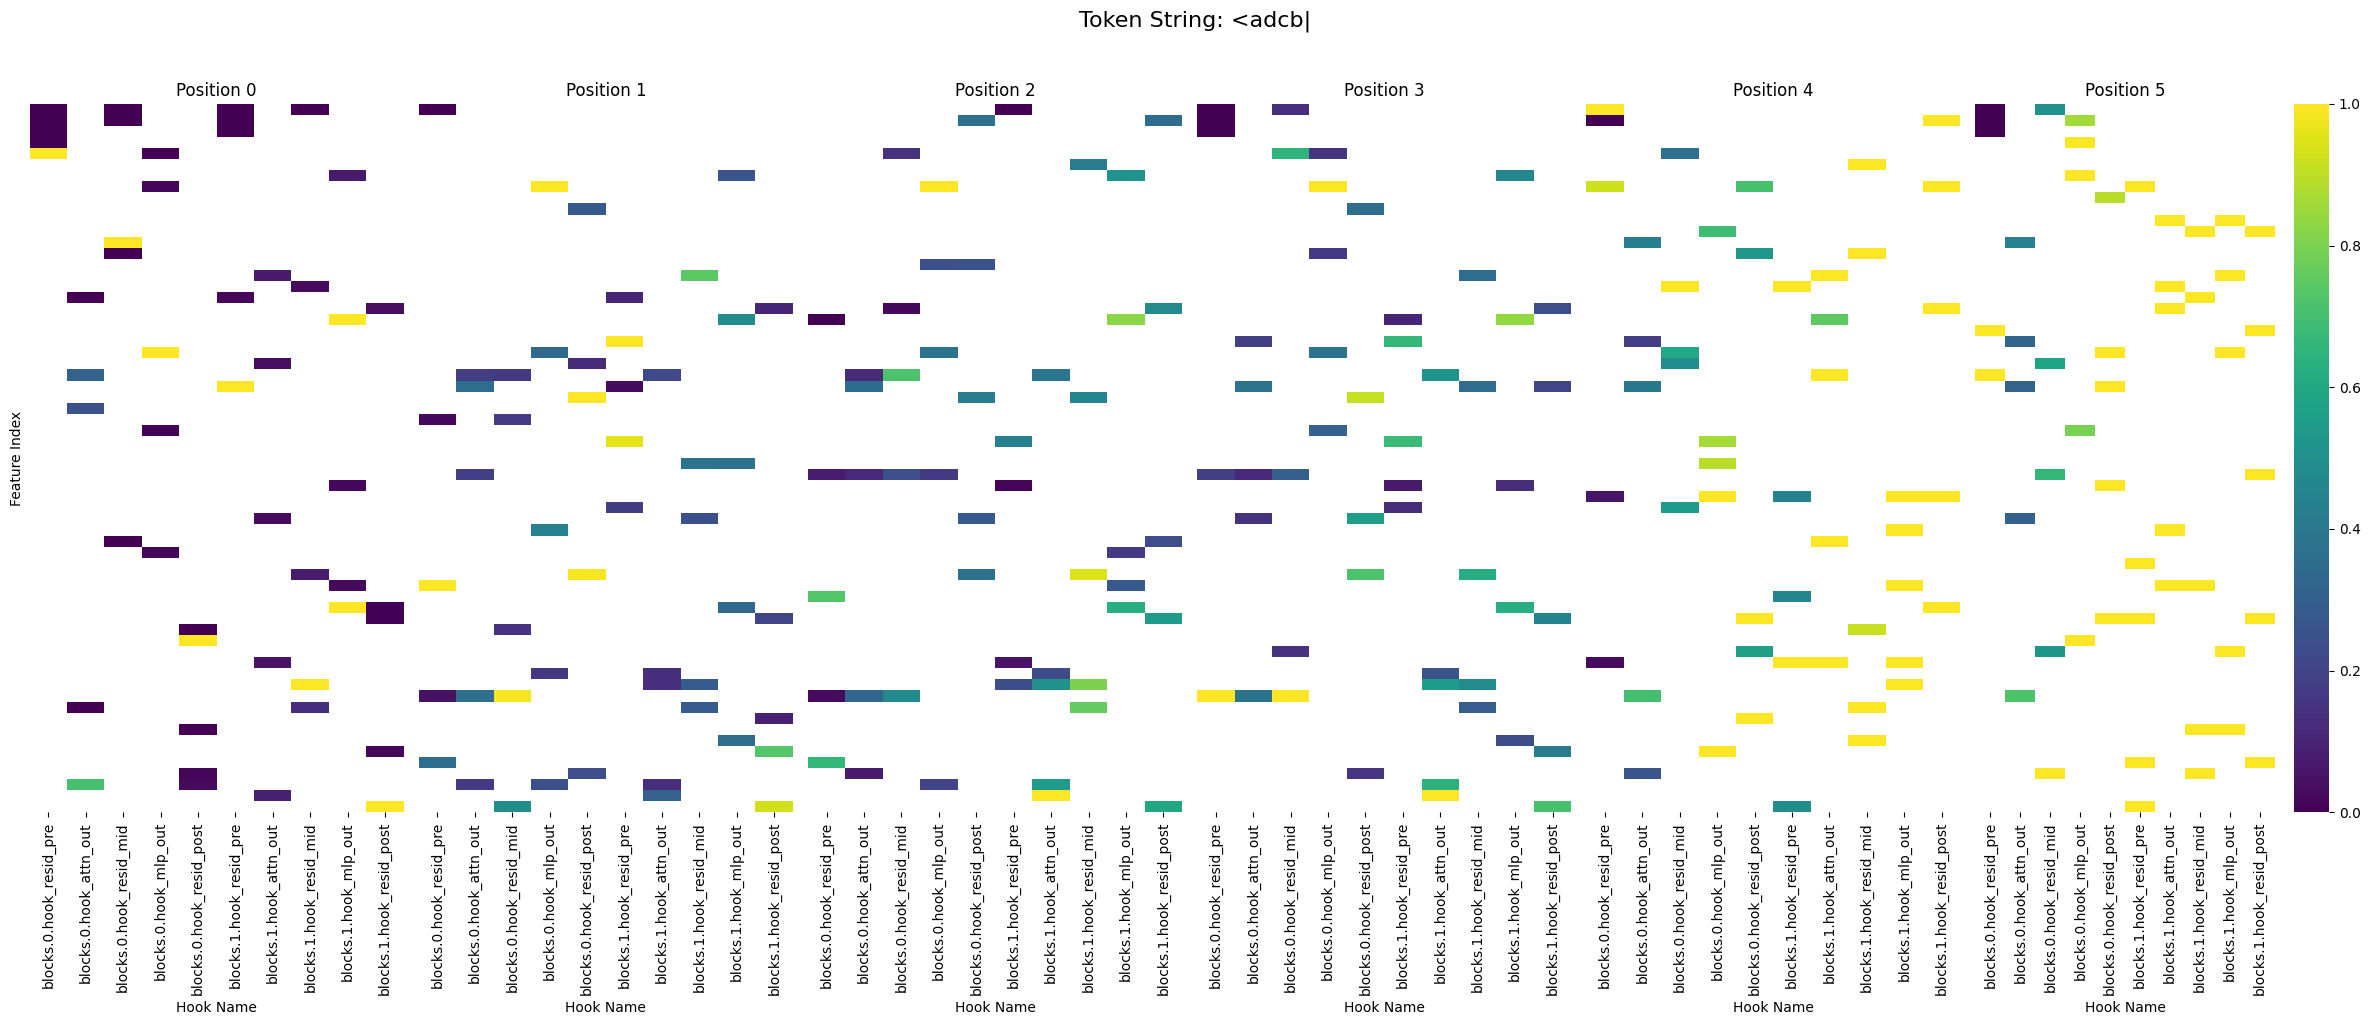

/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q

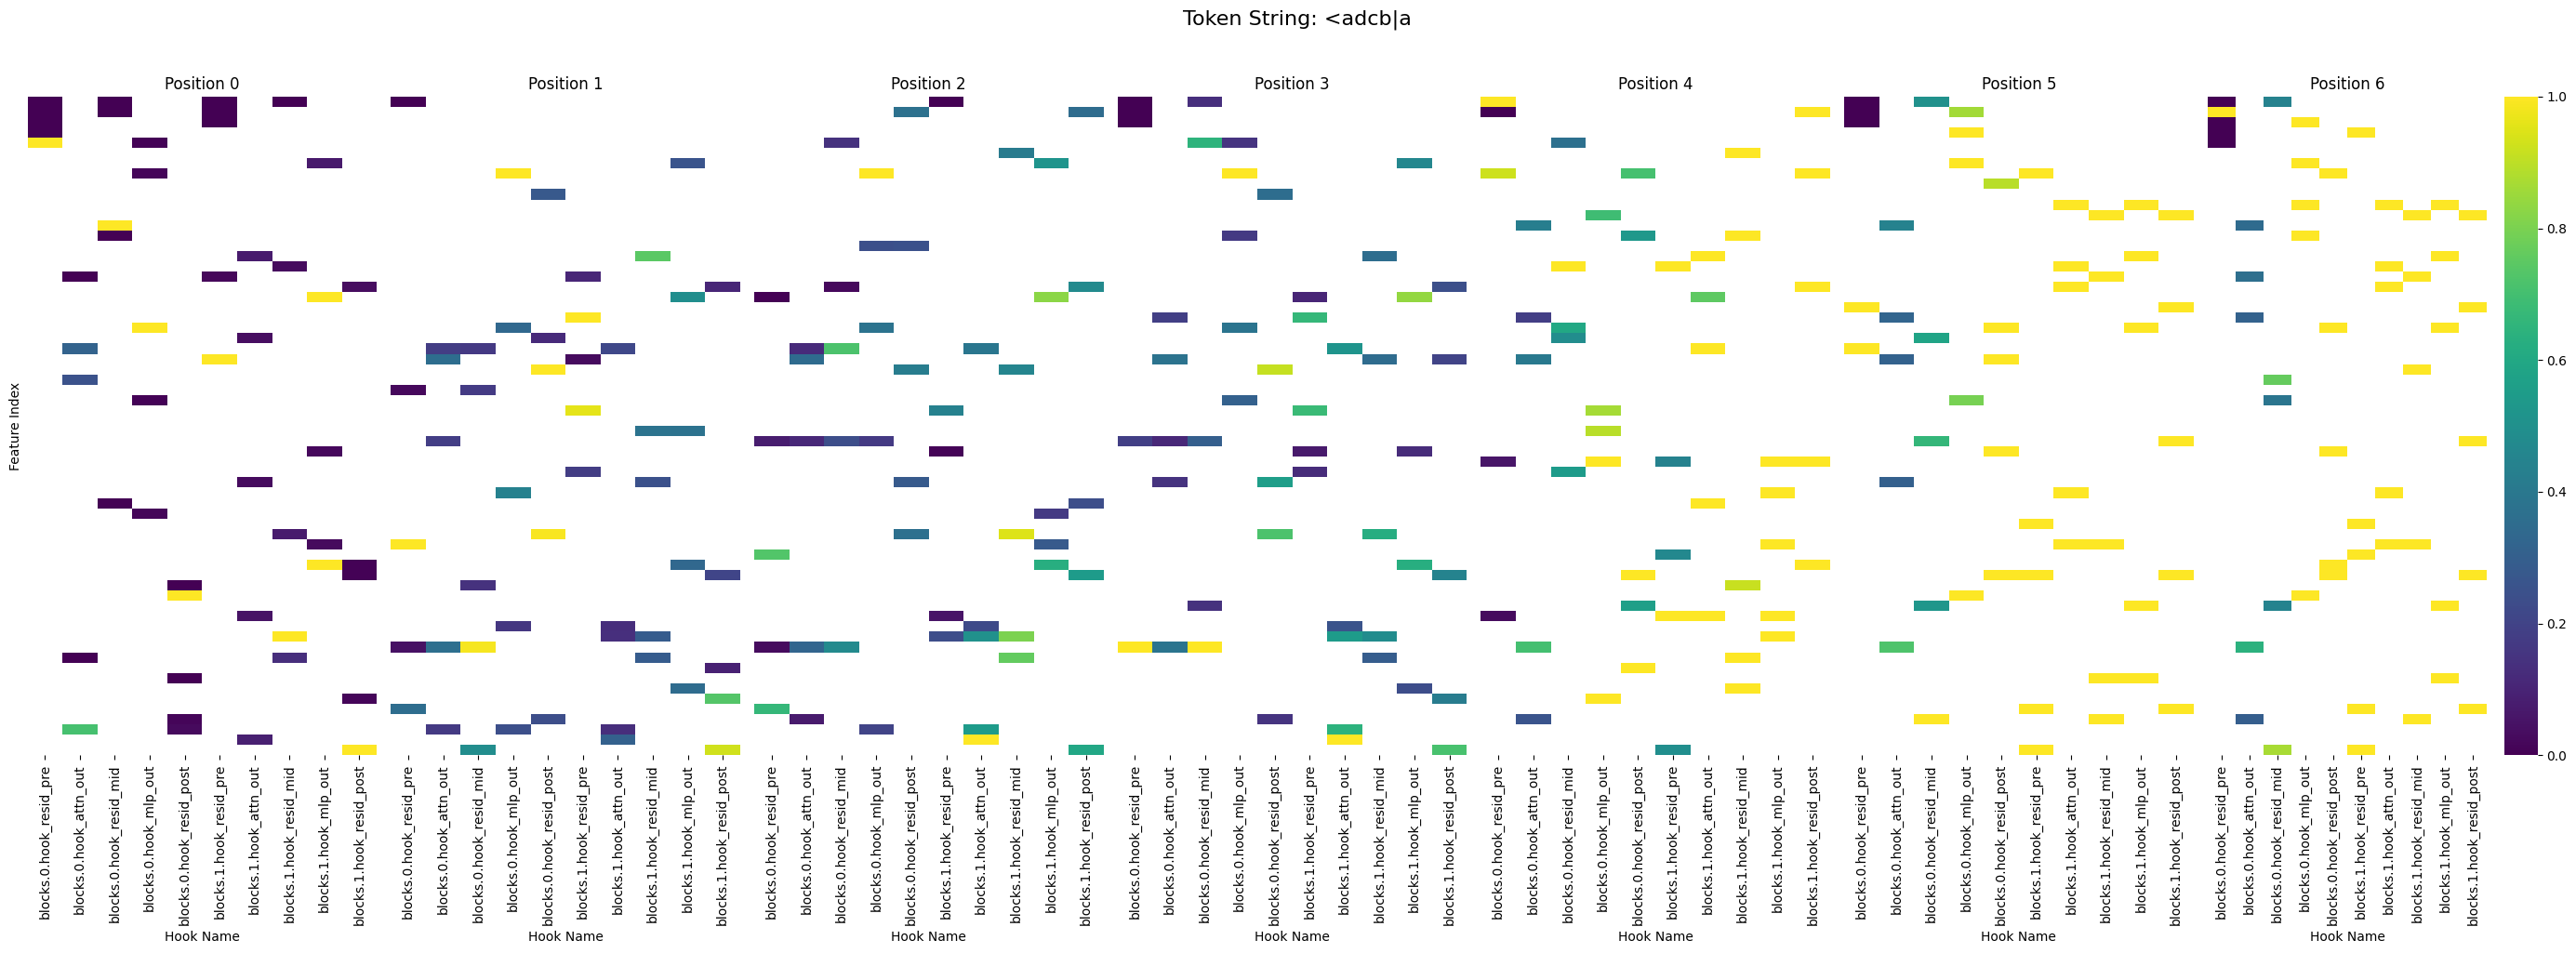

/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q

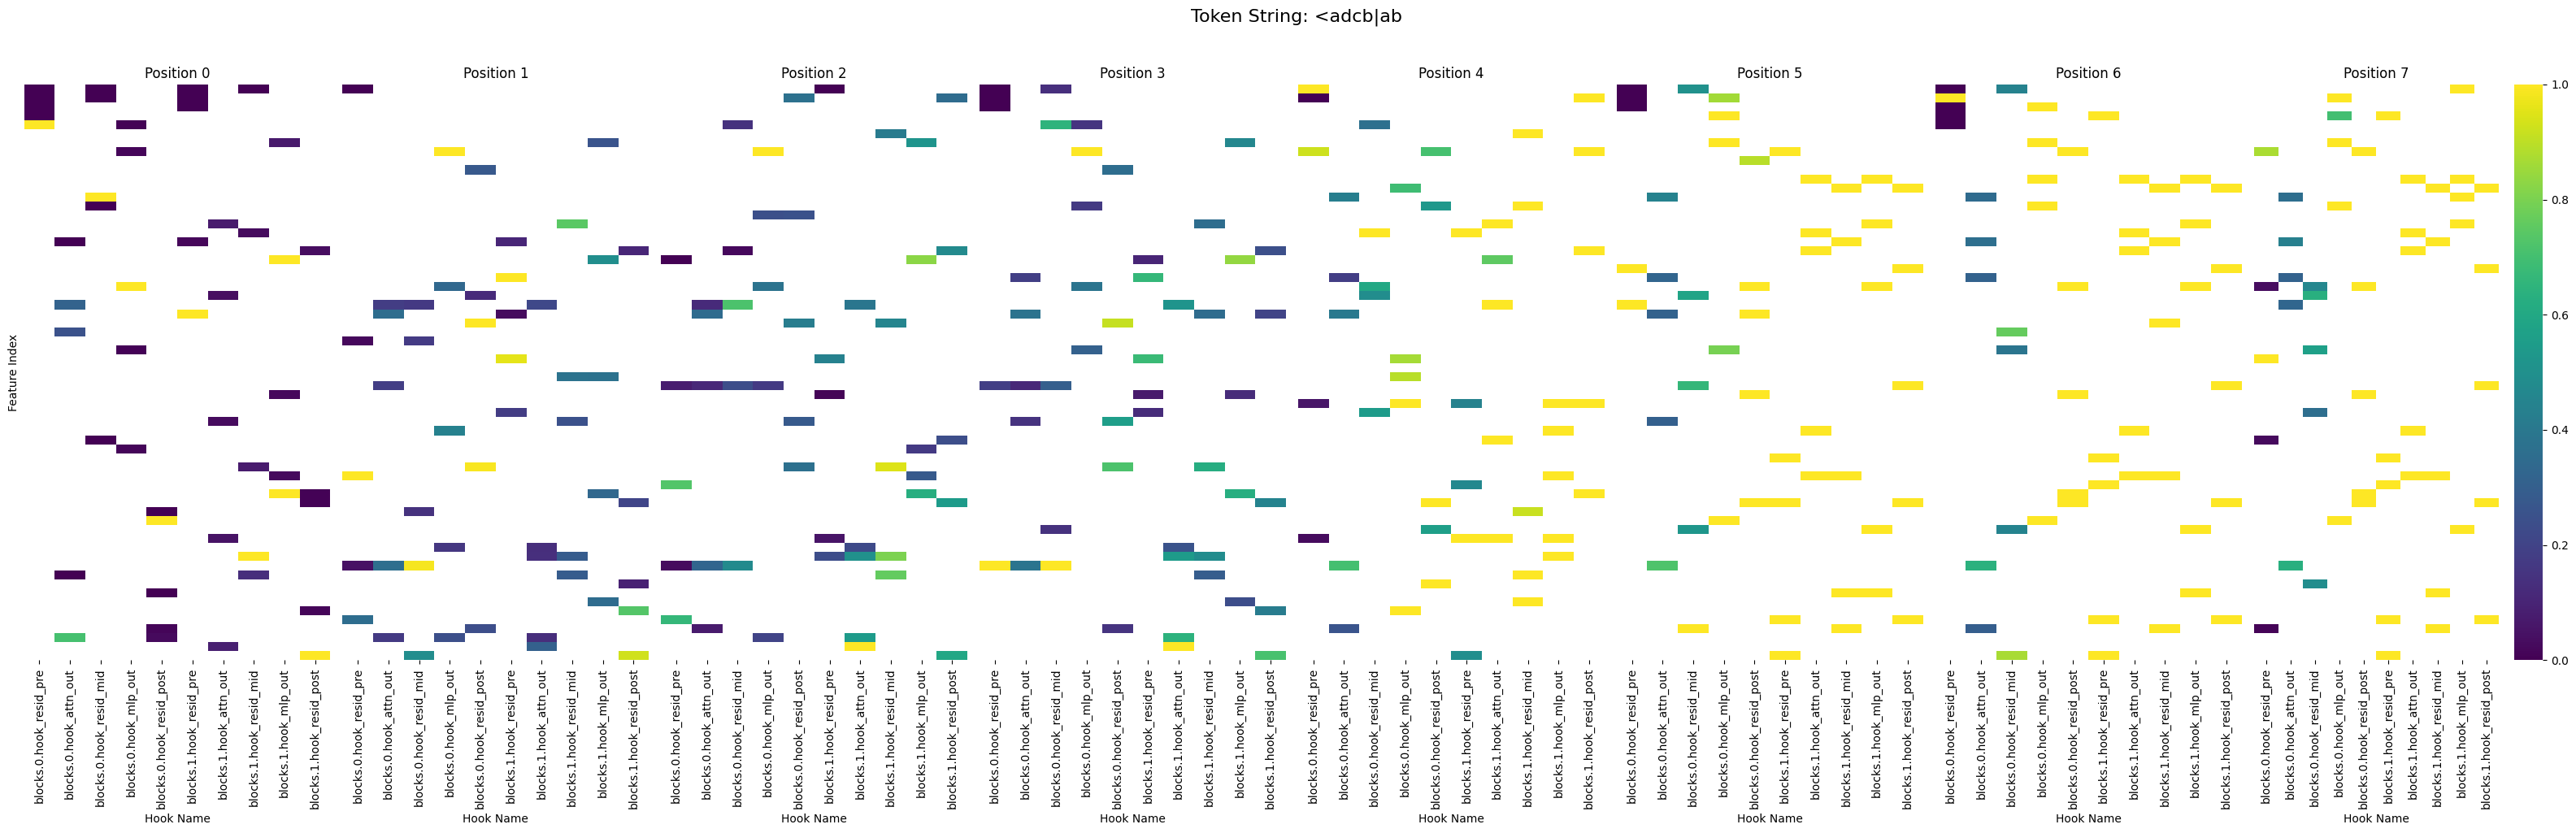

/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q

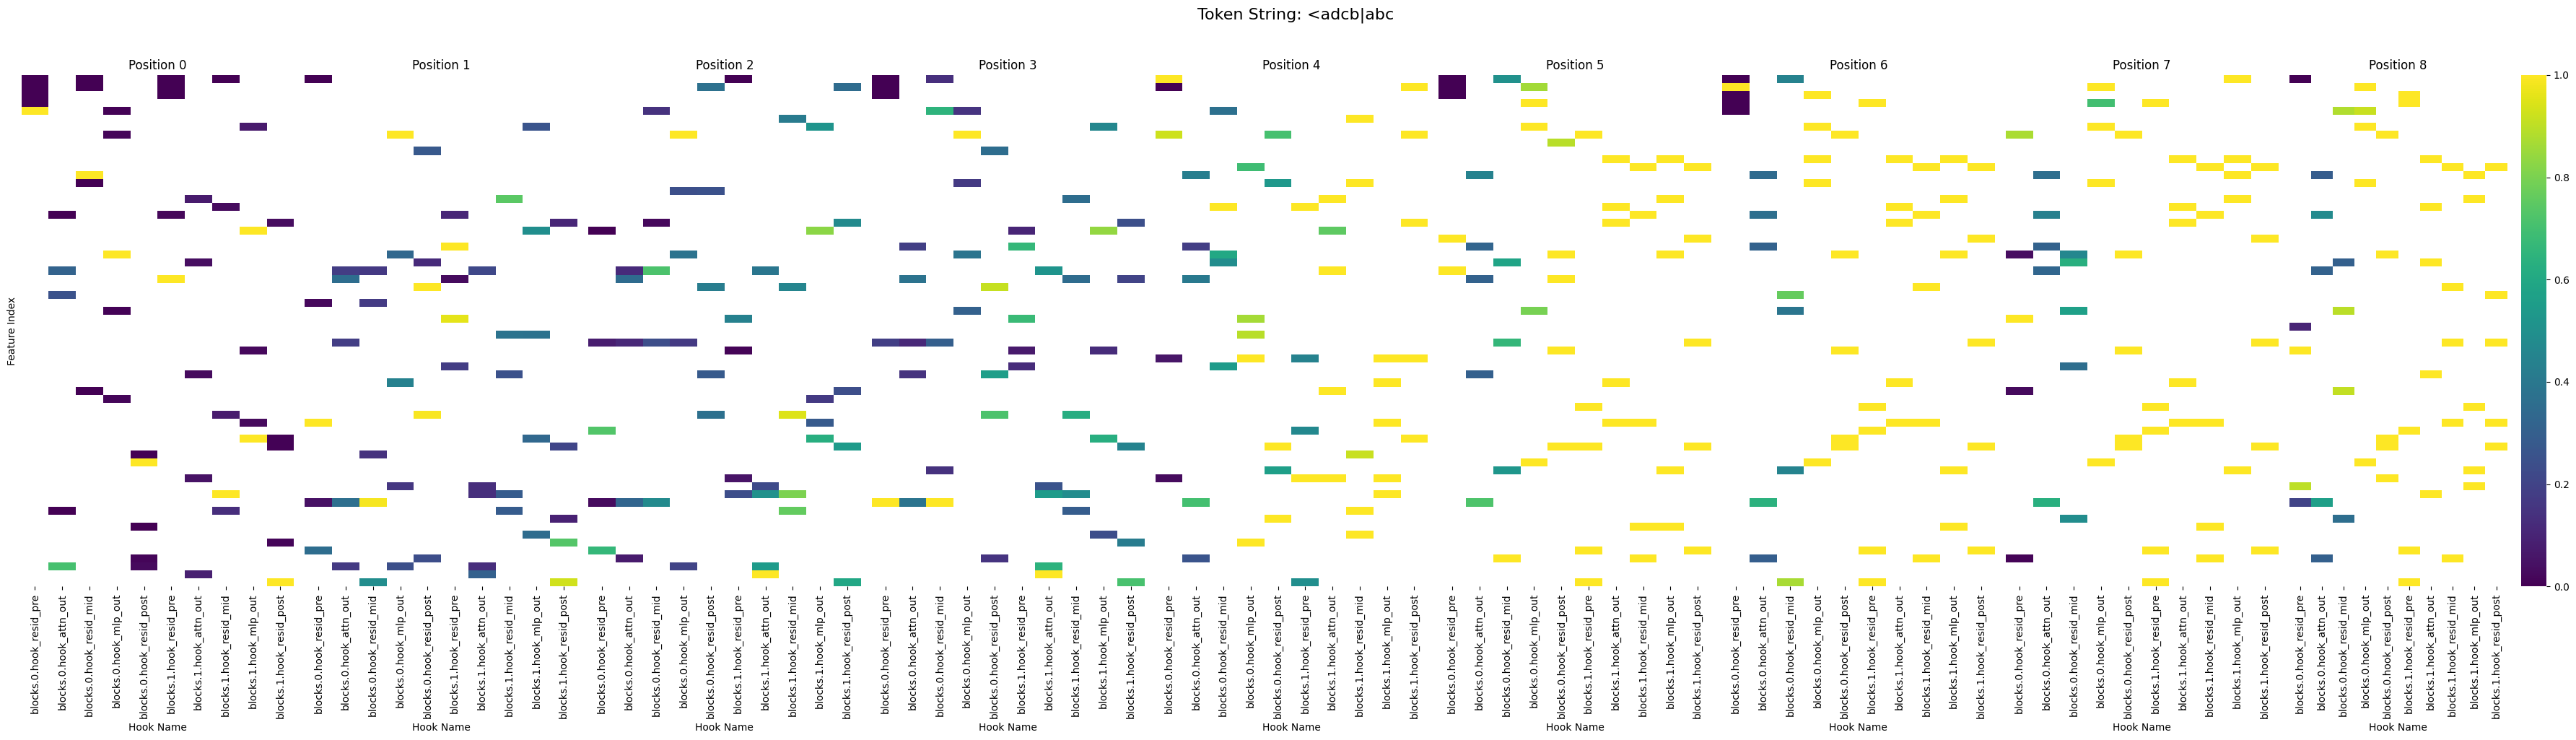

/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/2507058213.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q

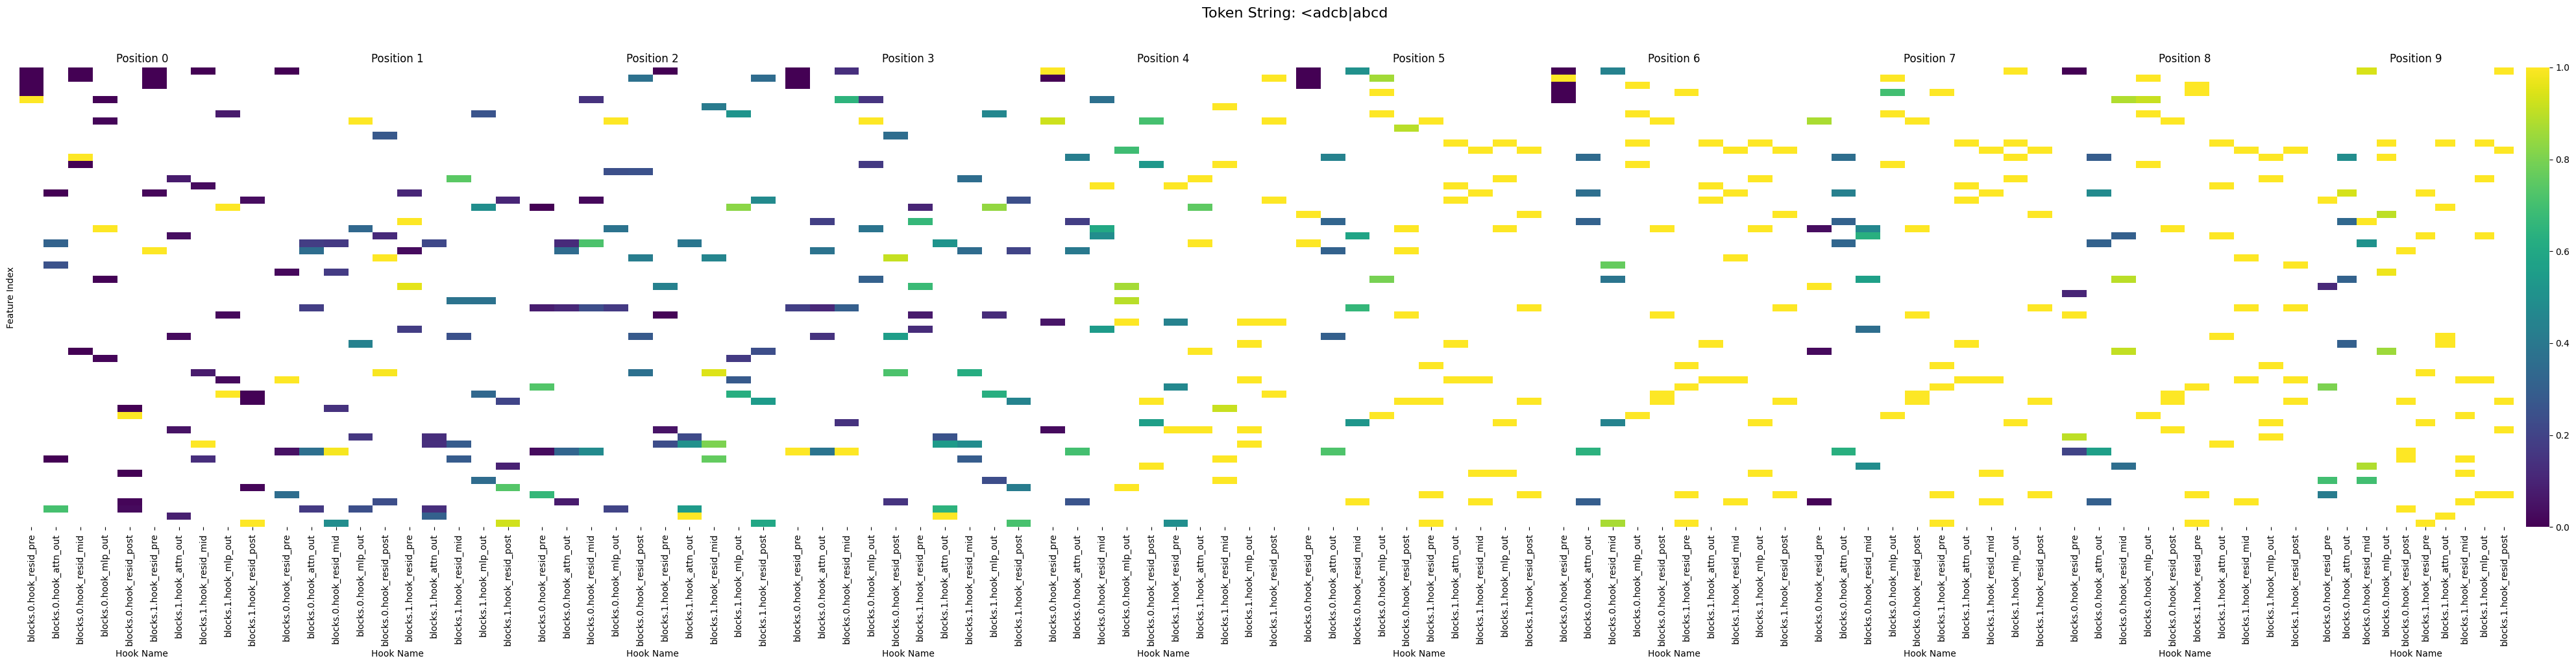

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame containing the activation data.

# Ensure 'hook_name' is ordered in the desired sequence
hook_names = [
    "blocks.0.hook_resid_pre",
    "blocks.0.hook_attn_out",
    "blocks.0.hook_resid_mid",
    "blocks.0.hook_mlp_out",
    "blocks.0.hook_resid_post",
    "blocks.1.hook_resid_pre",
    "blocks.1.hook_attn_out",
    "blocks.1.hook_resid_mid",
    "blocks.1.hook_mlp_out",
    "blocks.1.hook_resid_post",
]
df["hook_name"] = pd.Categorical(df["hook_name"], categories=hook_names, ordered=True)

# Ensure 'position' is integer
df["position"] = df["position"].astype(int)

# Get the list of token strings in the order you have
token_strings = ["<adcb|", "<adcb|a", "<adcb|ab", "<adcb|abc", "<adcb|abcd"]

# Iterate over each token string
for token_string in token_strings:
    df_ts = df[df["token_string"] == token_string]
    positions = sorted(df_ts["position"].unique())
    num_positions = len(positions)

    # Compute overall vmin and vmax for consistent color scaling across positions
    vmin = df_ts["activation_value"].min()
    vmax = df_ts["activation_value"].max()

    # Create a figure with subplots for each position
    fig, axes = plt.subplots(
        nrows=1,
        ncols=num_positions,
        figsize=(num_positions * 4, 10),
        sharey=True,
    )

    # In case there's only one position
    if num_positions == 1:
        axes = [axes]

    for idx, position in enumerate(positions):
        df_pos = df_ts[df_ts["position"] == position]

        # Create pivot table: Features x Hooks
        pivot_table = df_pos.pivot_table(
            index="feature_index", columns="hook_name", values="activation_value", aggfunc="max"
        )

        # Ensure all features and hooks are represented
        feature_indices = range(64)  # Features from 0 to 63
        pivot_table = pivot_table.reindex(index=feature_indices, columns=hook_names)

        ax = axes[idx]
        sns.heatmap(
            pivot_table,
            ax=ax,
            cmap="viridis",
            cbar=(idx == num_positions - 1),  # Show color bar only on the last subplot
            vmin=0,
            vmax=1,
        )
        ax.set_title(f"Position {position}")
        ax.set_xlabel("Hook Name")
        if idx == 0:
            ax.set_ylabel("Feature Index")
            ax.set_yticks(range(0, 64, 8))
            ax.set_yticklabels(range(0, 64, 8))
        else:
            ax.set_ylabel("")
            ax.set_yticks([])
        ax.set_xticklabels(hook_names, rotation=90)

    fig.suptitle(f"Token String: {token_string}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/1268403941.py:85: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/1268403941.py:85: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_18364/1268403941.py:85: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_pos.pivot_table(
/var/folders/g6/72q

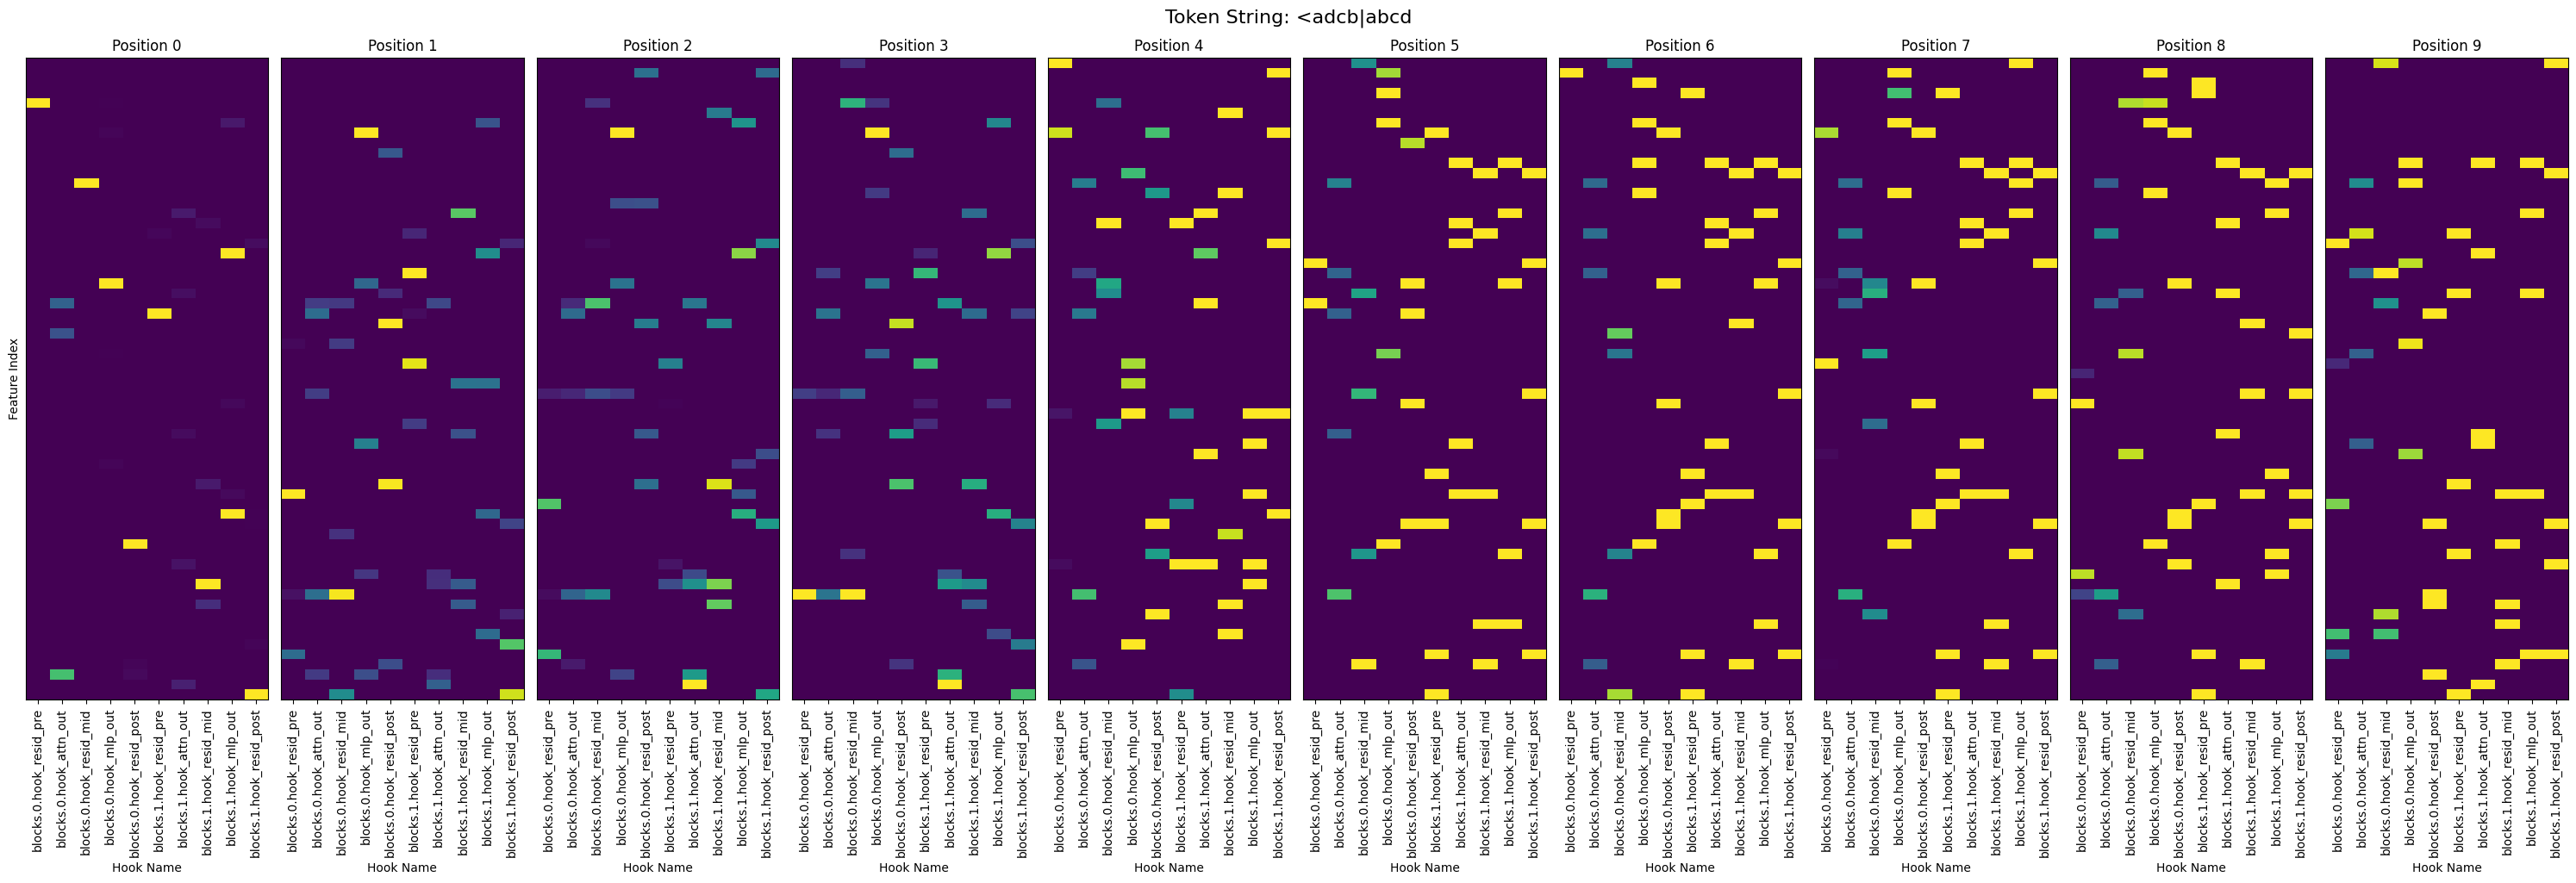

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Assuming 'df' is your DataFrame containing the activation data.

# Data Preparation
# Ensure 'hook_name' is ordered in the desired sequence
hook_names = [
    "blocks.0.hook_resid_pre",
    "blocks.0.hook_attn_out",
    "blocks.0.hook_resid_mid",
    "blocks.0.hook_mlp_out",
    "blocks.0.hook_resid_post",
    "blocks.1.hook_resid_pre",
    "blocks.1.hook_attn_out",
    "blocks.1.hook_resid_mid",
    "blocks.1.hook_mlp_out",
    "blocks.1.hook_resid_post",
]
df["hook_name"] = pd.Categorical(df["hook_name"], categories=hook_names, ordered=True)

# Ensure 'position' is integer
df["position"] = df["position"].astype(int)

# Get the list of token strings in the order you have
token_strings = ["<adcb|", "<adcb|a", "<adcb|ab", "<adcb|abc", "<adcb|abcd"]

# Find the maximum number of positions to standardize the plot size
max_positions = df["position"].max() + 1  # Assuming positions start at 0

# Compute overall vmin and vmax for consistent color scaling across all token strings
vmin = df["activation_value"].min()
vmax = df["activation_value"].max()

# Feature indices
feature_indices = np.arange(64)

# Create the figure and axes outside the animation function
fig, axes = plt.subplots(nrows=1, ncols=max_positions, figsize=(max_positions * 3, 10), sharey=True)
if max_positions == 1:
    axes = [axes]
elif isinstance(axes, plt.Axes):
    axes = [axes]

# Prepare a list to hold the image objects
image_list = []

for idx, ax in enumerate(axes):
    # Initialize with zeros
    data = np.zeros((64, len(hook_names)))
    im = ax.imshow(data, aspect="auto", vmin=0, vmax=1, cmap="viridis")
    image_list.append(im)

    # Axis formatting
    ax.set_xlabel("Hook Name")
    ax.set_xticks(np.arange(len(hook_names)))
    ax.set_xticklabels(hook_names, rotation=90)
    if idx == 0:
        ax.set_ylabel("Feature Index")
        ax.set_yticks(np.arange(0, 64, 8))
        ax.set_yticklabels(np.arange(0, 64, 8))
    else:
        ax.set_yticks([])
    ax.set_title(f"Position {idx}")

plt.tight_layout()


def animate(i):
    token_string = token_strings[i]
    df_ts = df[df["token_string"] == token_string]
    positions = sorted(df_ts["position"].unique())

    fig.suptitle(f"Token String: {token_string}", y=1.02, fontsize=16)

    for idx, ax in enumerate(axes):
        im = image_list[idx]
        if idx in positions:
            # Data for the current position
            df_pos = df_ts[df_ts["position"] == idx]

            # Create pivot table: Features x Hooks
            pivot_table = df_pos.pivot_table(
                index="feature_index",
                columns="hook_name",
                values="activation_value",
                aggfunc="max",
                fill_value=0,
            )

            # Reindex to ensure all features and hooks are represented
            pivot_table = pivot_table.reindex(
                index=feature_indices, columns=hook_names, fill_value=0
            )

            data = pivot_table.values

            # Update the image data
            im.set_data(data)
            im.set_clim(0, 1)  # Update color scale

            # Ensure axes are visible
            ax.set_visible(True)
        else:
            # No data for this position, set the image data to zeros
            im.set_data(np.zeros((64, len(hook_names))))
            # Optionally hide the axis
            # ax.set_visible(False)

    return image_list


# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=len(token_strings), interval=1000, blit=True)

# Save the animation as a GIF (requires Pillow)
from matplotlib.animation import PillowWriter

writer = PillowWriter(fps=1)
anim.save("activations_animation_fixed.gif", writer=writer)

In [48]:
# Sort and group data to get top N activations per feature
num_top_activations_to_keep_per_feature = 100
top_activations_per_feature = (
    all_data.sort_values(["feature_index", "activation_value"], ascending=[True, False])
    .groupby("feature_index")
    .head(num_top_activations_to_keep_per_feature)
)

In [ ]:
all_data["feature_index"].nunique()

60

In [251]:
from termcolor import colored
from IPython.display import display, HTML


# note: with relu we don't have negative activations
def display_top_examples_for_feature(feature_index: int, top_n: int = 10) -> str:
    """
    Returns a string containing the top N examples for the specified feature index.

    Parameters:
    - feature_index (int): The index of the feature to display.
    - top_n (int): The number of top examples to display.

    Returns:
    - str: A formatted string containing the top examples.
    """
    # Filter data for the specified feature
    feature_data = top_activations_per_feature[
        (top_activations_per_feature["feature_index"] == feature_index)
        & (top_activations_per_feature["k"] == 0)
    ]
    feature_data = feature_data.sort_values("activation_value", ascending=False)
    top_examples = feature_data.head(top_n)

    result = [f"Top {top_n} Examples for <feature>{feature_index}</feature>:\n"]

    for idx, row in top_examples.iterrows():
        token_string = row["token_string"]
        position = int(row["position"])

        tokens = list(token_string)

        if 0 <= position < len(tokens):
            token = tokens[position]
            token = f"<token>{token}</token>"
            tokens[position] = token  # colored(token, "red", attrs=["bold"])
        else:
            result.append(
                f"Warning: Position {position} is out of range for token_string '{token_string}'"
            )

        highlighted_token_string = " ".join(tokens)

        result.append(
            f"<activation> {row['activation_value']:.2f} </activation>\t"
            f"<full-string> {highlighted_token_string} </full-string>"
        )

    return "\n".join(result)


# Display top 10 examples for feature index 42
print(display_top_examples_for_feature(58, top_n=10))

Top 10 Examples for <feature>58</feature>:

<activation> 1.29 </activation>	<full-string> < m w <token>f</token> k | f k m </full-string>
<activation> 1.29 </activation>	<full-string> < g q <token>f</token> f | f </full-string>
<activation> 1.29 </activation>	<full-string> < x x <token>f</token> a | a </full-string>
<activation> 1.29 </activation>	<full-string> < l o <token>f</token> z | f </full-string>
<activation> 1.29 </activation>	<full-string> < f w <token>f</token> m | f </full-string>
<activation> 1.29 </activation>	<full-string> < m t <token>f</token> j | f </full-string>
<activation> 1.29 </activation>	<full-string> < y e <token>f</token> s | e </full-string>
<activation> 1.29 </activation>	<full-string> < r q <token>f</token> w | f </full-string>
<activation> 1.29 </activation>	<full-string> < p g <token>f</token> s | f </full-string>
<activation> 1.29 </activation>	<full-string> < k j <token>f</token> v | f </full-string>


In [1]:
def display_top_features_for_token_string(token_string, top_n=5) -> str:
    """
    Generates a string containing the top activating features at each position in the given token_string.

    Parameters:
    - token_string (str): The token string to analyze.
    - top_n (int): The number of top features to display per position.

    Returns:
    - str: A formatted string containing the analysis results.
    """
    from termcolor import colored
    import pandas as pd

    result = []  # List to store all output strings

    # Filter 'all_data' for the given token_string
    data_for_string = all_data[all_data["token_string"] == token_string]

    if data_for_string.empty:
        return f"No activation data available for token_string: '{token_string}'"

    # Ensure 'position' is integer
    data_for_string = data_for_string.copy()
    data_for_string["position"] = data_for_string["position"].astype(int)

    # Get the length of the token_string
    token_length = len(token_string)

    result.append(f"<full-string> {' '.join(token_string)} </full-string>")

    # For each position in the token_string
    for pos in range(token_length):
        # Get the token at current position
        token = token_string[pos]

        # Filter data for the current position
        data_at_position = data_for_string[data_for_string["position"] == pos]

        if data_at_position.empty:
            result.append(f"Position {pos} (Token '{token}'): No activations.")
            continue

        # Get top N features by activation value (descending order)
        top_features = data_at_position.nlargest(top_n, "activation_value")

        # Generate the results
        result.append(f"\n<top-{top_n}-activating-features-at-position>")
        result.append(f"<position>{pos}</position>\n<token>{token}</token>:")
        for idx, row in top_features.iterrows():
            feature_index = int(row["feature_index"])
            activation_value = row["activation_value"]
            k = int(row["k"])
            result.append(
                f"<feature>{feature_index}</feature>\t<activation>{activation_value:.4f}</activation> <k>{k}</k>"
            )
        result.append(f"</top-{top_n}-activating-features-at-position>")

    return "\n".join(result)  # Join all strings with newlines


def display_top_features_for_top_token_string(feature_index: int) -> str:
    """
    Generates a string containing the top activating features at each position for the
    top activating values for a given feature.

    """
    # Filter data for the specified feature
    feature_data = top_activations_per_feature[
        (top_activations_per_feature["feature_index"] == feature_index)
        & (top_activations_per_feature["k"] == 0)
    ]
    feature_data = feature_data.sort_values("activation_value", ascending=False)
    token_string = feature_data["token_string"].values[0]

    return display_top_features_for_token_string(token_string)


# print(display_top_features_for_token_string(32, top_n=10))

print(display_top_features_for_top_token_string(32))

NameError: name 'top_activations_per_feature' is not defined

In [ ]:
from typing import List
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.markdown import Markdown
from rich.text import Text


def display_top_features_over_slices(feature_index: int, top_n: int = 5) -> None:
    """
    Iteratively slices the token string around the delimiter '|', displaying the top activating features
    for each slice in a formatted table.

    Parameters:
    - feature_index (int): The feature index to analyze.
    - top_n (int): The number of top features to display per position.
    """

    console = Console()

    # Step 1: Retrieve the top token string for the given feature_index
    feature_data = top_activations_per_feature[
        (top_activations_per_feature["feature_index"] == feature_index)
        & (top_activations_per_feature["k"] == 0)
    ]

    if feature_data.empty:
        console.print(f"[red]No activation data available for feature_index: {feature_index}[/red]")
        return

    # Assuming the first row is the top activation
    token_string = feature_data["token_string"].values[0]
    tokens = token_string.split()  # Assuming tokens are space-separated

    # Step 2: Identify the position of the delimiter '|'
    try:
        delimiter_pos = tokens.index("|")
    except ValueError:
        console.print("[red]Delimiter '|' not found in the token string.[/red]")
        return

    # Step 3: Generate all slices starting from the full string and removing one token at a time
    slices = []
    for end in range(len(tokens), delimiter_pos, -1):
        sliced_tokens = tokens[:end]
        sliced_string = " ".join(sliced_tokens)
        slices.append(sliced_string)

    # Optionally, include slices that remove tokens before the delimiter if needed
    # Uncomment the following lines if you want to include these slices
    # for end in range(delimiter_pos, 0, -1):
    #     sliced_tokens = tokens[:end]
    #     sliced_string = ' '.join(sliced_tokens)
    #     slices.append(sliced_string)

    if not slices:
        console.print("[yellow]No slices to display.[/yellow]")
        return

    # Step 4: Iterate over each slice and display the top features
    for idx, sliced_string in enumerate(slices, 1):
        # Fetch top activating features for the sliced token string
        data_for_string = all_data[all_data["token_string"] == sliced_string]

        if data_for_string.empty:
            console.print(
                f"[red]No activation data available for token_string: '{sliced_string}'[/red]"
            )
            continue

        # Ensure 'position' is integer
        data_for_string = data_for_string.copy()
        data_for_string["position"] = data_for_string["position"].astype(int)

        token_length = len(sliced_string.split())

        # Create a panel for each slice
        panel_title = f"[bold blue]Slice {idx}[/bold blue]: [green]{sliced_string}[/green]"
        slice_panel = Panel.fit(panel_title, border_style="cyan")

        console.print(slice_panel)

        # Create a table for top features
        table = Table(show_header=True, header_style="bold magenta")
        table.add_column("Position", justify="center", style="dim", width=10)
        table.add_column("Token", style="bold")
        table.add_column(f"Top {top_n} Features", justify="left")

        for pos in range(token_length):
            token = sliced_string.split()[pos]
            data_at_position = data_for_string[data_for_string["position"] == pos]

            if data_at_position.empty:
                feature_info = "No activations."
            else:
                top_features = data_at_position.nlargest(top_n, "activation_value")
                feature_lines = []
                for _, row in top_features.iterrows():
                    feature_idx = int(row["feature_index"])
                    activation = row["activation_value"]
                    k = int(row["k"])
                    feature_lines.append(
                        f"[bold yellow]{feature_idx}[/bold yellow]: {activation:.4f} (k={k})"
                    )
                feature_info = "\n".join(feature_lines)

            table.add_row(str(pos), token, feature_info)

        console.print(table)
        console.print("\n")  # Add space between slices


# Example usage:
# Assuming 'all_data' and 'top_activations_per_feature' DataFrames are already defined
# and populated appropriately in your environment.

display_top_features_over_slices(feature_index=58, top_n=5)

In [ ]:
import plotly.express as px


def visualize_animated_heatmap(feature_index: int, top_n: int = 5):
    """
    Creates an animated heatmap showing activation changes as the token string is sliced.

    Parameters:
    - feature_index (int): The feature index to analyze.
    - top_n (int): Number of top features to include per slice.
    """
    # Retrieve the top token string for the given feature_index
    feature_data = top_activations_per_feature[
        (top_activations_per_feature["feature_index"] == feature_index)
        & (top_activations_per_feature["k"] == 0)
    ]

    if feature_data.empty:
        print(f"No activation data available for feature_index: {feature_index}")
        return

    token_string = feature_data["token_string"].values[0]
    tokens = token_string.split()

    # Identify the delimiter position
    try:
        delimiter_pos = tokens.index("|")
    except ValueError:
        print("Delimiter '|' not found in the token string.")
        return

    # Generate slices
    slices = [" ".join(tokens[:end]) for end in range(len(tokens), delimiter_pos, -1)]

    records = []
    for slice_num, sliced_string in enumerate(slices, 1):
        data_for_slice = all_data[all_data["token_string"] == sliced_string]
        if data_for_slice.empty:
            continue
        for pos in sorted(data_for_slice["position"].unique()):
            token = sliced_string.split()[pos]
            data_at_pos = data_for_slice[data_for_slice["position"] == pos].nlargest(
                top_n, "activation_value"
            )
            for _, row in data_at_pos.iterrows():
                records.append(
                    {
                        "Slice": f"Slice {slice_num}",
                        "Position": pos,
                        "Feature": f"Feature {int(row['feature_index'])}",
                        "Activation": row["activation_value"],
                    }
                )

    df_plot = pd.DataFrame(records)

    fig = px.imshow(
        df_plot.pivot("Feature", "Position", "Activation").fillna(0),
        animation_frame="Slice",
        labels=dict(x="Position", y="Feature", color="Activation"),
        title=f"Animated Activation Heatmap for Feature Index {feature_index}",
        color_continuous_scale="Viridis",
    )

    fig.show()


# Example usage:
visualize_animated_heatmap(feature_index=58, top_n=5)

#### Feature Frequencies

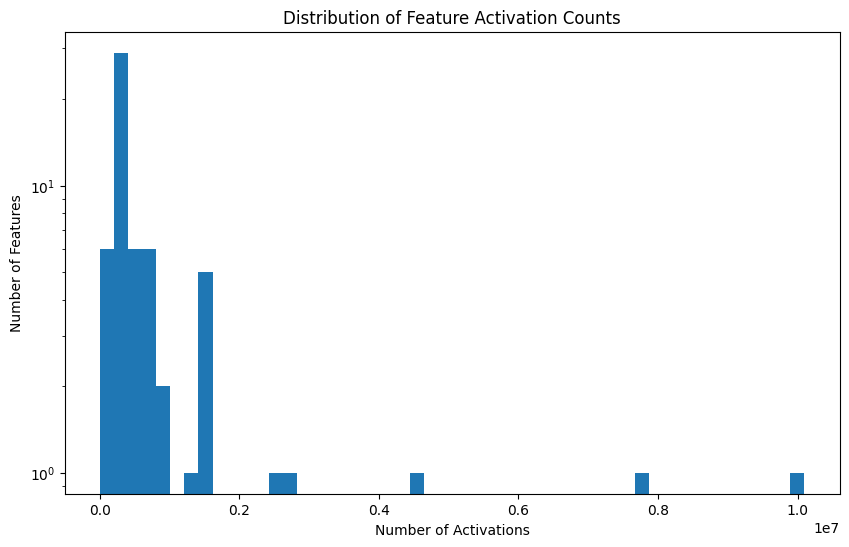

In [238]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'all_data' is your DataFrame containing all activations
# Count the number of times each feature appears
feature_counts = all_data["feature_index"].value_counts().sort_index()

# Convert to a DataFrame
feature_counts_df = feature_counts.reset_index()
feature_counts_df.columns = ["feature_index", "count"]

plt.figure(figsize=(10, 6))
plt.hist(feature_counts_df["count"], bins=50, log=True)
plt.xlabel("Number of Activations")
plt.ylabel("Number of Features")
plt.title("Distribution of Feature Activation Counts")
plt.show()

#### Top Features (by frequency)

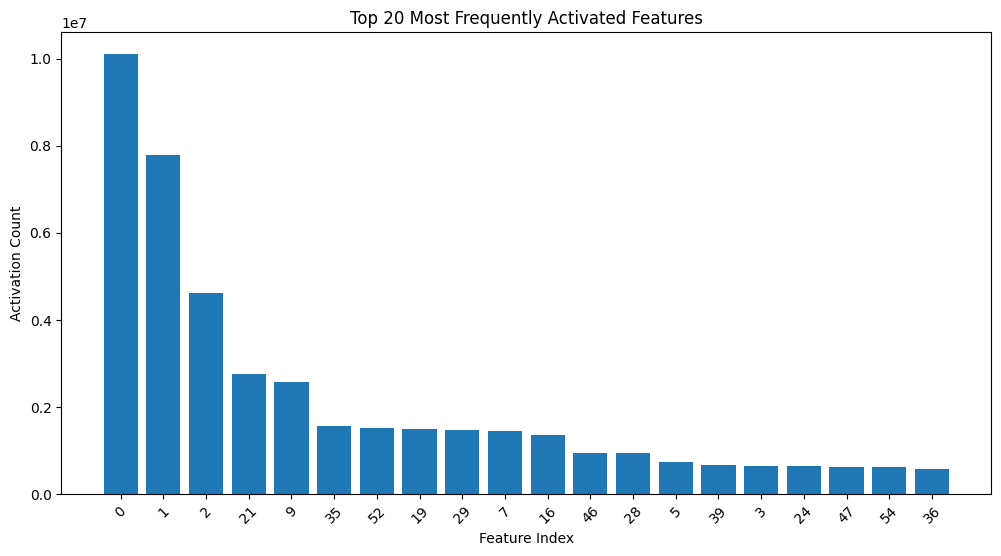

In [239]:
# Get the top N features by frequency
N = 20  # Adjust as needed
top_features = feature_counts_df.nlargest(N, "count")

plt.figure(figsize=(12, 6))

# Note: Converting feature_index to string (astype(str)) ensures proper labeling on the x-axis.
plt.bar(top_features["feature_index"].astype(str), top_features["count"])
plt.xlabel("Feature Index")
plt.ylabel("Activation Count")
plt.title(f"Top {N} Most Frequently Activated Features")
plt.xticks(rotation=45)
plt.show()

#### Feature Activation Values for Specific Feature

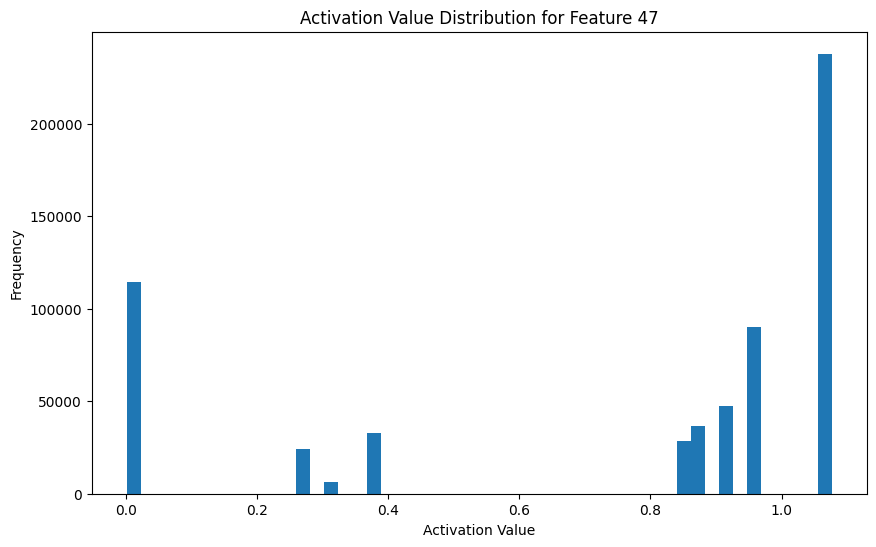

In [241]:
# Example: Plot activation value distribution for a specific feature
feature_index_to_plot = 47  # Replace with the feature index you're interested in
feature_data = all_data[all_data["feature_index"] == feature_index_to_plot]

plt.figure(figsize=(10, 6))
plt.hist(feature_data["activation_value"], bins=50)
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.title(f"Activation Value Distribution for Feature {feature_index_to_plot}")
plt.show()

### Automated Explanations

In [ ]:
# Have the model summarize each example

# TODO(bschoen): Could group different examples together if needed

In [129]:
from neuron_explainer.activations.activation_records import calculate_max_activation
from neuron_explainer.activations.activations import ActivationRecord
from neuron_explainer.explanations.calibrated_simulator import (
    UncalibratedNeuronSimulator,
)
from neuron_explainer.explanations.explainer import (
    HARMONY_V4_MODELS,
    ContextSize,
    TokenActivationPairExplainer,
)
from neuron_explainer.explanations.explanations import ScoredSimulation
from neuron_explainer.explanations.few_shot_examples import FewShotExampleSet
from neuron_explainer.explanations.prompt_builder import PromptFormat
from neuron_explainer.explanations.scoring import (
    _simulate_and_score_sequence,
    aggregate_scored_sequence_simulations,
)
from neuron_explainer.explanations.simulator import (
    LogprobFreeExplanationTokenSimulator,
    NeuronSimulator,
)
from tenacity import retry, stop_after_attempt, wait_random_exponential

In [130]:
ActivationRecord??

Init signature: ActivationRecord(tokens: List[str], activations: List[float]) -> None
Source:        
@register_dataclass
@dataclass
class ActivationRecord(FastDataclass):
    """Collated lists of tokens and their activations for a single neuron."""

    tokens: List[str]
    """Tokens in the text sequence, represented as strings."""
    activations: List[float]
    """Raw activation values for the neuron on each token in the text sequence."""
File:           ~/gpt_from_scratch/venv/lib/python3.12/site-packages/neuron_explainer/activations/activations.py
Type:           type
Subclasses:     

In [242]:
feature_index = 58

top_activations_for_feature = top_activations_per_feature[
    (top_activations_per_feature["feature_index"] == feature_index)
    & (top_activations_per_feature["k"] == 0)
]

activation_min = top_activations_for_feature["activation_value"].min()
activation_max = top_activations_for_feature["activation_value"].max()

# TODO(bschoen): Can give this to model
print(f"Feature {feature_index} activation range: [{activation_min:.2f}, {activation_max:.2f}]")

# sample some so we're not always taking nearly identical strings (this is fine because
# our data is so compact, we likely don't have far spread in activation values
top_activations_for_feature = top_activations_for_feature.sort_values(
    "activation_value", ascending=False
).head(10)

print(len(top_activations_for_feature))

Feature 58 activation range: [1.29, 1.29]
10


In [243]:
top_activations_for_feature

feature_index  activation_value  position  k token_string  \
1635              58          1.286841         3  0    <mwfk|fkm   
48120             58          1.286841         3  0      <gqff|f   
55330             58          1.286841         3  0      <xxfa|a   
54210             58          1.286841         3  0      <lofz|f   
53195             58          1.286841         3  0      <fwfm|f   
52600             58          1.286841         3  0      <mtfj|f   
50640             58          1.286841         3  0      <yefs|e   
50500             58          1.286841         3  0      <rqfw|f   
49835             58          1.286841         3  0      <pgfs|f   
48820             58          1.286841         3  0      <kjfv|f   

                     hook_name  
1635   blocks.0.hook_resid_pre  
48120  blocks.0.hook_resid_pre  
55330  blocks.0.hook_resid_pre  
54210  blocks.0.hook_resid_pre  
53195  blocks.0.hook_resid_pre  
52600  blocks.0.hook_resid_pre  
50640  blocks.0.hook_resid_pre  
50500  blocks.0.hook_resid_pre  
49835  blocks.0.hook_resid_pre  
48820  blocks.0.hook_resid_pre

In [244]:
# TODO(bschoen): Could do this with tool use or structured output, but better to be able to do it with o1
def generate_complete_explanation_request_prompt_for_feature(feature_index: int) -> str:
    prompt = rf"""
<task-description>
Generate a human readable explanation for a feature activation in a transformer model that sorts characters in a sequence. The transformer model is given at least the first half of a sequence and must produce the second half in sorted order. Pay especially close attention to anything that could prove your explanation wrong to avoid outputting incorrect explanations!

Please generate an explanation for <feature>{feature_index}</feature>

</task-description>

<max-activating-examples-for-feature>
{display_top_examples_for_feature(feature_index, top_n=10)}
</max-activating-examples-for-feature>

<example-full-string-all-features>
{display_top_features_for_top_token_string(feature_index)}
</example-full-string-all-features>

Remember, your task is generate a very brief, concise, useful explanation for interpreting <feature>{feature_index}</feature> and a score between 0 and 10 for how confident you are in your explanation. 

Please output in the following format:

<explanation-text>EXPLANATION</explanation-text>
<explanation-confidence-score-0-to-10>SCORE</explanation-confidence-score-0-to-10>

"""

    return prompt


print(generate_complete_explanation_request_prompt_for_feature(58))


<task-description>
Generate a human readable explanation for a feature activation in a transformer model that sorts characters in a sequence. The transformerm odel is given at least the first half of a sequence and must produce the second half in sorted order. Pay especially close attention to anything that could prove your explanation wrong to avoid outputting incorrect explanations!

Please generate an explanation for <feature>58</feature>

</task-description>

<max-activating-examples-for-feature>
Top 10 Examples for <feature>58</feature>:

<activation> 1.29 </activation>	<full-string> < m w <token>f</token> k | f k m </full-string>
<activation> 1.29 </activation>	<full-string> < g q <token>f</token> f | f </full-string>
<activation> 1.29 </activation>	<full-string> < x x <token>f</token> a | a </full-string>
<activation> 1.29 </activation>	<full-string> < l o <token>f</token> z | f </full-string>
<activation> 1.29 </activation>	<full-string> < f w <token>f</token> m | f </full-str

In [266]:
from termcolor import colored
from bs4 import BeautifulSoup


def format_text(text):
    """
    Replaces escaped text in angle brackets with colored text.
    """
    # Mapping of tags to colors
    tag_colors = {
        "feature": "blue",
        "activation": "green",
        "token": "red",
        "full-string": "cyan",
        "position": "yellow",
        "top-5-activating-features-at-position": "magenta",
        "k": "white",
        # Add more tags and colors as needed
    }

    # Wrap the text in a root element to make it valid XML
    wrapped_text = f"<root>{text}</root>"

    # Parse the text with BeautifulSoup
    soup = BeautifulSoup(wrapped_text, "html.parser")

    def traverse(element):
        result = ""
        for content in element.contents:
            if isinstance(content, str):
                # Clean up whitespace
                result += content
            else:
                tag = content.name
                color = tag_colors.get(tag, "white")
                inner_text = traverse(content)
                # Apply color to inner text
                colored_text = colored(inner_text.strip(), color)
                result += colored_text
        return result

    formatted_text = traverse(soup)

    # Further formatting for readability
    lines = formatted_text.split("\n")
    formatted_lines = []
    for line in lines:
        # Remove extra spaces and tabs
        line = line.strip()
        if line == "---":
            # Add separator lines
            formatted_lines.append("-" * 40)
        elif line:
            formatted_lines.append(line)
    return "\n".join(formatted_lines)

In [263]:
import re
from jaxtyping import Float, Int
import openai
import tqdm

import tenacity

FeatureIndex = int


@dataclasses.dataclass
class FeatureExplanation:
    text: str
    confidence_score: float | None


def parse_explanation(response_text: str) -> FeatureExplanation:
    """
    Parse the explanation text and confidence score from the API response.

    Expects the response to contain <explanation-text> and <explanation-confidence-score-0-to-10> tags.
    """
    explanation = None
    confidence_score = None

    # Regex patterns to extract the required fields
    explanation_pattern = re.compile(r"<explanation-text>(.*?)<\/explanation-text>", re.DOTALL)
    confidence_pattern = re.compile(
        r"<explanation-confidence-score-0-to-10>(\d+)<\/explanation-confidence-score-0-to-10>"
    )

    explanation_match = explanation_pattern.search(response_text)
    confidence_match = confidence_pattern.search(response_text)

    if explanation_match:
        explanation = explanation_match.group(1).strip()
    else:
        print(f"Warning: <explanation-text> tag not found: {response_text}")

    if confidence_match:
        confidence_score = float(confidence_match.group(1).strip())
    else:
        print(f"Warning: <explanation-confidence-score-0-to-10> tag not found: {response_text}")

    return FeatureExplanation(explanation, confidence_score)


@tenacity.retry(
    wait=tenacity.wait_random_exponential(min=1, max=60),
    stop=tenacity.stop_after_attempt(3),
)
def get_model_generated_feature_explanation(
    client: openai.OpenAI,
    feature_index: int,
) -> FeatureExplanation:

    prompt = generate_complete_explanation_request_prompt_for_feature(feature_index)

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": f"<feature>{feature_index}</feature>"},
        ],
        max_tokens=256,  # TODO(bschoen): Is this way too high?
    )

    # Parse the response
    return parse_explanation(response.choices[0].message.content)


def get_model_generated_feature_explanations(
    client: openai.OpenAI,
    feature_indices: list[FeatureIndex],
) -> dict[FeatureIndex, FeatureExplanation]:
    """Generate explanations for a list of feature indices using the OpenAI API."""
    feature_index_to_explanation: dict[FeatureIndex, FeatureExplanation] = {}

    for feature_index in tqdm.tqdm(feature_indices):

        feature_explanation = get_model_generated_feature_explanation(client, feature_index)

        feature_index_to_explanation[feature_index] = feature_explanation

    return feature_index_to_explanation


# note: not all numbers 0 to 64 are features
#
# also we only use features that have top examples
#
# TODO(bschoen): Which ones are we missing?
feature_indices = sorted(
    top_activations_per_feature[top_activations_per_feature["k"] == 0]["feature_index"]
    .unique()
    .tolist()
)

print(f"{len(feature_indices)=}")

len(feature_indices)=35


In [264]:
client = openai.OpenAI()

feature_explanations = get_model_generated_feature_explanations(client, feature_indices)

100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


In [268]:
import textwrap

for feature_index, explanation in tqdm.tqdm(feature_explanations.items()):

    print("\n---\n")

    print(f"{feature_index=} - {explanation.confidence_score=}")

    print(f"\n{textwrap.fill(explanation.text, width=100)}\n")

    print(format_text(display_top_examples_for_feature(feature_index, top_n=10)))

    # print("---")

    # print(display_top_features_for_top_token_string(feature_index))

    print("\n---\n")

100%|██████████| 35/35 [00:00<00:00, 820.23it/s]


---

feature_index=0 - explanation.confidence_score=9.0

Feature 0 likely activates when the character 'a' in the second half of the sequence is being
processed. This is evident because all of the top-activating examples for Feature 0 have 'a' as the
first character in the second half of the sequence.

Top 10 Examples for 0:
1.57 < t a d n | a d n
1.57 < h q a d | a d h
1.57 < u u a g | a g u
1.57 < u a j b | a b j
1.57 < y a q t | a q t
1.57 < d u w a | a d u
1.57 < a g e c | a c e
1.57 < a v o j | a j o
1.57 < t v a b | a b t
1.57 < a j r t | a j r

---


---

feature_index=1 - explanation.confidence_score=8.0

Feature 1 is activated when the token 'b' appears in the sequence that needs to be completed or
sorted. This indicates that Feature 1 might be responsible for identifying the occurrence of the
token 'b' as part of the input sequence to assist in completing the sequence in sorted order.

Top 10 Examples for 1:
1.75 < v d b f | b d f
1.75 < n s b r | b n
1.75 < x y i b | b i
1.

#### Show Feature Activation For String As It Gets Completed

In [ ]:
# Can make new functions for these, ex `< t a d n | a d n t >`

In [134]:
all_data["token_string"].nunique()

1462272

## Transcoder - Checking Reconstruction

In [ ]:
assert (
    len(test_example_per_difficulty) == 1
), "Here we're assuming only one difficulty, can be easily adapted for more"


print(f"{transcoder_training_cfg.hook_point=}")
print(f"{transcoder_training_cfg.out_hook_point=}")

mlp_in = correct_cache[transcoder_training_cfg.hook_point]
mlp_out = correct_cache[transcoder_training_cfg.out_hook_point]

transcoder_results = mlp_transcoder(mlp_in)

# Print shapes of tensors
print([c for c in correct_string])
print(f"mlp_in: {mlp_in.shape}")
print(f"mlp_out: {mlp_out.shape}")
print(f"transcoder_out: {transcoder_results.transcoder_out.shape}")
print(f"hidden_activations: {transcoder_results.hidden_activations.shape}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Assuming you have imported or defined `mlp_in`, `mlp_out`, `transcoder_out`, `hidden_activations`, and `input_tokens_str`


# Function to plot heatmap of activations
def plot_activations(
    activations,
    title,
    xlabel="Neuron",
    ylabel="Sequence Position",
    tokens=None,
    cmap: str = "RdBu",
):
    # Remove batch dimension and convert to numpy
    activations = activations.squeeze(0).detach().cpu().numpy()
    plt.figure(figsize=(4, 2))
    sns.heatmap(activations, cmap=cmap)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if tokens is not None:
        plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=0)
    plt.show()


# 1. Visualize MLP Input Activations (mlp_in)
plot_activations(mlp_in, title="MLP Input Activations", tokens=correct_string)

# 2. Visualize MLP Output Activations (mlp_out)
plot_activations(mlp_out, title="MLP Output Activations", tokens=correct_string)

# 3. Visualize Transcoder Output (transcoder_out)
plot_activations(
    transcoder_results.transcoder_out,
    title="Transcoder Output Activations",
    tokens=correct_string,
)

In [ ]:
def visualize_hidden_activations(hidden_activations, tokens):
    # hidden_activations: [seq_len, hidden_size]
    # tokens: list of token strings

    # Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        hidden_activations,
        cmap="YlOrRd",
        cbar=True,
        vmin=0,
        vmax=np.max(hidden_activations),
    )
    plt.ylabel("Token Position")
    plt.xlabel("Neuron Index")
    plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=90)
    plt.title("Hidden Activations Heatmap")
    plt.show()

    # Activation Distribution
    activation_values = hidden_activations.flatten()
    plt.figure(figsize=(8, 6))
    plt.hist(activation_values, bins=100, color="blue", alpha=0.7)
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.title("Distribution of Hidden Activations")
    plt.show()

    # PCA
    """from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    activations_pca = pca.fit_transform(hidden_activations)
    plt.figure(figsize=(8, 6))
    plt.scatter(
        activations_pca[:, 0],
        activations_pca[:, 1],
        c=np.arange(len(tokens)),
        cmap="viridis",
    )
    for i, token in enumerate(tokens):
        plt.text(activations_pca[i, 0], activations_pca[i, 1], token)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA of Hidden Activations")
    plt.colorbar(label="Token Position")
    plt.show()"""


visualize_hidden_activations(
    hidden_activations=transcoder_results.hidden_activations[0].detach().cpu().numpy(),
    tokens=incorrect_string,
)

In [ ]:
# 4. Visualize Hidden Activations of MLP (hidden_activations)
# Due to the high dimensionality (2048), we might need to reduce dimensions
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2 for visualization
activations = transcoder_results.hidden_activations.squeeze(0).detach().cpu().numpy()
pca = PCA(n_components=2)
reduced_activations = pca.fit_transform(activations.reshape(-1, activations.shape[-1]))

# Plot the PCA-reduced activations
plt.figure(figsize=(4, 2))
scatter = plt.scatter(
    reduced_activations[:, 0],
    reduced_activations[:, 1],
    c=np.arange(activations.shape[0]),
    cmap="viridis",
)
plt.colorbar(scatter, label="Sequence Position")
plt.title("PCA of Hidden Activations")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Alternatively, plot a subset of neurons
num_neurons_to_plot = 2048  # Adjust based on preference
selected_neurons = activations[:, :num_neurons_to_plot]

plot_activations(
    torch.tensor(selected_neurons),
    title="Hidden Activations (First {} Neurons)".format(num_neurons_to_plot),
    xlabel="Neuron",
    tokens=input_tokens_str,
    cmap="grey",
)

In [ ]:
# 5. Visualize Distributions of Activations
def plot_activation_distribution(activations, title):
    activations = activations.detach().cpu().numpy().flatten()
    plt.figure(figsize=(4, 3))
    sns.histplot(activations, bins=100, kde=True)
    plt.title(title)
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.show()


plot_activation_distribution(mlp_in, title="Distribution of MLP Input Activations")

plot_activation_distribution(mlp_out, title="Distribution of MLP Output Activations")

plot_activation_distribution(
    transcoder_results.hidden_activations,
    title="Distribution of Hidden Activations",
)

In [ ]:
mlp = model.blocks[1].mlp

In [ ]:
mlp.W_out

In [ ]:
# 6. Visualize MLP Weights
# Assuming you have access to the MLP model
# Replace `model` with your transformer model variable and adjust layer indices accordingly

# Visualize weights of the first linear layer
weight_matrix = model.blocks[0].mlp.W_in.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(weight_matrix, cmap="coolwarm", center=0)
plt.title("Weights of MLP Layer fc1")
plt.xlabel("Input Neuron")
plt.ylabel("Output Neuron")
plt.show()

# Visualize weights of the second linear layer
weight_matrix = model.blocks[1].mlp.W_in.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(weight_matrix, cmap="coolwarm", center=0)
plt.title("Weights of MLP Layer fc2")
plt.xlabel("Input Neuron")
plt.ylabel("Output Neuron")
plt.show()

## Optuna Study

In [ ]:
import optuna


# TODO(bschoen): Do need to use lightning if want to do this generally
# note: generally do want to iterate on this part itself, i.e. once find promising learning rate, searching other hyperparameters
def objective(trial: optuna.Trial) -> float:

    # TODO(bschoen): up to one per position, eh might as well try it

    d_model = trial.suggest_categorical("d_model", [8, 16, 32, 64, 128])
    n_heads = trial.suggest_int("n_heads", 1, 8)

    cfg = ModelAndTrainingConfig(
        num_epochs=1000,
        eval_test_every_n=10000,  # not worth evaluating test loss for study
        n_layers=1,  # trial.suggest_int("n_layers", 1, 2),
        d_model=d_model,
        n_heads=n_heads,
        learning_rate=5e-4,
    )

    # sanity check `d_heads`
    if (cfg.d_model % cfg.n_heads) != 0:
        print(f"Pruning trial for {cfg.d_model=} {cfg.n_heads=}")
        raise optuna.exceptions.TrialPruned()

    result = train_model(cfg)

    return result.train_loss


enable_optuna = False

if enable_optuna:

    study_storage_url = "sqlite:///toy-problem-hooked-transformer.db"

    study = optuna.create_study(
        directions=[optuna.study.StudyDirection.MINIMIZE],
        storage=study_storage_url,
    )

    study.optimize(objective, n_trials=10)

    print("View by launching optuna dashboard from the command line:")
    print(f"optuna-dashboard {study_storage_url}")

    # now let's do a real run
    training_config = ModelAndTrainingConfig(
        num_epochs=10000,
        eval_test_every_n=1000,
        n_layers=1,
        d_model=16,
        n_heads=1,
    )

    result = train_model(cfg=training_config)

    # for compatibility with code later
    model = result.model
    cfg = training_config.get_hooked_transformer_config()

In [ ]:
# Look at some example output
import circuitsvis as cv

import functools


def visualize_pattern_hook(
    pattern: Float32[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: transformer_lens.hook_points.HookPoint,
    tokens_as_strings: list[str],
) -> None:
    print(f"Batch size: {pattern.shape[0]}")
    print("Layer: ", hook.layer())
    display(cv.attention.attention_patterns(tokens=tokens_as_strings, attention=pattern.mean(0)))


test_input_string_to_cache = {}

for difficulty, test_loader in test_loaders.items():

    print(difficulty)

    # grab something from the test batch
    example_batch = next(iter(test_loader))

    x, y = example_batch

    example_sample = x[0]

    # example_sample = torch.tensor(tokenizer.encode("<az|za|az>>>>>>>>>>"))

    # grab the first part of it, ex: `<abc|`
    example_prompt = example_sample  # [:8]

    example_prompt = example_prompt.to(device)

    print(f"Using {example_prompt} from {example_sample} (from test set)")

    # note: already encoded
    input_tokens = example_prompt

    # first let's get these as strings so can easily work with them
    input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

    # wrap to bind input tokens
    visualize_pattern_hook_fn = functools.partial(
        visualize_pattern_hook, tokens_as_strings=input_tokens_as_strings
    )

    model.run_with_hooks(
        input_tokens,
        return_type=None,  # For efficiency, we don't need to calculate the logits
        fwd_hooks=[(lambda name: name.endswith("pattern"), visualize_pattern_hook_fn)],
    )

    logits_batch, cache = model.run_with_cache(input_tokens)

    # store so can plot together later
    test_input_string_to_cache["".join(input_tokens_as_strings)] = cache

    logits = logits_batch[0]

    log_probs = logits.log_softmax(dim=-1)

    cv.logits.token_log_probs(
        token_indices=input_tokens,
        log_probs=log_probs,
        to_string=token_to_string,
    )

In [ ]:
cache.apply_ln_to_stack?

In [ ]:
cache.stack_head_results??

In [ ]:
import transformer_lens.patching

transformer_lens.patching.get_act_patch_resid_pre??

In [ ]:
import einops


def logit_attribution(
    embed: Float32[torch.Tensor, "seq d_model"],
    l1_results: Float32[torch.Tensor, "seq nheads d_model"],
    l2_results: Float32[torch.Tensor, "seq nheads d_model"],
    W_U: Float32[torch.Tensor, "d_model d_vocab"],
    tokens: Int64[torch.Tensor, "seq"],
) -> Float32[torch.Tensor, "seq-1 n_components"]:
    """
    Inputs:
        embed: the embeddings of the tokens (i.e. token + position embeddings)
        l1_results: the outputs of the attention heads at layer 1 (with head as one of the dimensions)
        l2_results: the outputs of the attention heads at layer 2 (with head as one of the dimensions)
        W_U: the unembedding matrix
        tokens: the token ids of the sequence

    Returns:
        Tensor of shape (seq_len-1, n_components)
        represents the concatenation (along dim=-1) of logit attributions from:
            the direct path (seq-1,1)
            layer 0 logits (seq-1, n_heads)
            layer 1 logits (seq-1, n_heads)
        so n_components = 1 + 2*n_heads
    """
    W_U_correct_tokens = W_U[:, tokens[1:]]
    # SOLUTION
    direct_attributions = einops.einsum(W_U_correct_tokens, embed[:-1], "emb seq, seq emb -> seq")
    l1_attributions = einops.einsum(
        W_U_correct_tokens, l1_results[:-1], "emb seq, seq nhead emb -> seq nhead"
    )
    l2_attributions = einops.einsum(
        W_U_correct_tokens, l2_results[:-1], "emb seq, seq nhead emb -> seq nhead"
    )
    return torch.concat(
        [direct_attributions.unsqueeze(-1), l1_attributions, l2_attributions], dim=-1
    )


logits, cache = model.run_with_cache(input_tokens, remove_batch_dim=True)
str_tokens = input_tokens_as_strings
tokens = input_tokens

with t.inference_mode():
    embed = cache["embed"]
    l1_results = cache["result", 0]
    l2_results = cache["result", 1]
    logit_attr = logit_attribution(
        embed,
        l1_results,
        l2_results,
        model.W_U,
        tokens[0],
    )

    # Uses fancy indexing to get a len(tokens[0])-1 length tensor, where the kth entry is the predicted logit for the correct k+1th token
    correct_token_logits = logits[0, torch.arange(len(tokens[0]) - 1), tokens[0, 1:]]

## Looking at it with CircuitsViz

In [ ]:
# before even going to SAE, let's look at circuitsviz here
import circuitsvis as cv

import circuitsvis.activations
import circuitsvis.attention
import circuitsvis.logits
import circuitsvis.tokens
import circuitsvis.topk_samples
import circuitsvis.topk_tokens

In [ ]:
# first let's see what we have
import tabulate

print(f"{len(input_tokens)=}")

# show the first few elements of the `HookedTransformerConfig`, since that has things like `d_model`, num heads, etc
print(tabulate.tabulate([(k, v) for k, v in cfg.__dict__.items()][:10]))

print(tabulate.tabulate([(k, v.shape) for k, v in cache.items()]))

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Viridis256

import numpy as np
import pandas as pd

from bokeh.io import output_notebook

import seaborn as sns

import matplotlib.pyplot as plt

# Enable Bokeh output in the notebook
output_notebook()


def tensor_to_dataframe(tensor: torch.Tensor, labels: list[str], tokens: list[str]) -> pd.DataFrame:
    """
    Convert a 2D PyTorch tensor to a pandas DataFrame.

    Args:
        tensor (torch.Tensor): A 2D tensor to convert.

    Returns:
        pd.DataFrame: A DataFrame representation of the input tensor.

    Raises:
        ValueError: If the input tensor is not 2D.
    """
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.dim()}D")
    if len(labels) != 2:
        raise ValueError(f"Expected labels for both dimensions, got {len(labels)}")

    # Convert tensor to numpy array
    numpy_array = tensor.detach().cpu().numpy()

    # Create DataFrame
    df = pd.DataFrame(numpy_array)

    # Name the index the first label
    df.index.name = labels[0]

    # Name the columns the second label
    df.columns = [f"{labels[1]}_{i}" for i in range(numpy_array.shape[1])]

    return df


def visualize_tensor_heatmap(
    tensor: torch.Tensor,
    title: str = "Tensor Heatmap",
    colormap: list[str] = Viridis256,
    width: int = 800,
    height: int = 400,
) -> None:
    """
    Visualize a 2D tensor as a heatmap.

    Args:
        tensor (torch.Tensor): A 2D tensor to visualize.
        title (str): Title of the heatmap.
        colormap (List[str]): A list of colors to use for the heatmap.
        width (int): Width of the plot in pixels.
        height (int): Height of the plot in pixels.

    """

    # Ensure tensor is 2D
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.shape}")

    # convert tensor to dataframe
    df = tensor_to_dataframe(tensor)

    # Create a 2D grid of coordinates
    y, x = np.mgrid[0 : data.shape[0], 0 : data.shape[1]]

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    z = data.flatten()

    # Create a ColumnDataSource
    source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            z=z,
            color=Viridis256[:: int(256 / len(z))][: len(z)],  # Map values to colors
        )
    )

    # Create the figure
    p = figure(
        title="Tensor Heatmap",
        x_range=(0, data.shape[1]),
        y_range=(0, data.shape[0]),
        toolbar_location="below",
        tools="pan,wheel_zoom,box_zoom,reset",
    )

    # Add rectangular glyphs
    p.rect(
        x="x",
        y="y",
        width=1,
        height=1,
        source=source,
        fill_color="color",
        line_color=None,
    )

    # Add hover tool
    hover = HoverTool(tooltips=[("x", "@x"), ("y", "@y"), ("value", "@z{0.000}")])
    p.add_tools(hover)

    # Invert y-axis to match tensor indexing
    p.y_range.start, p.y_range.end = p.y_range.end, p.y_range.start

    # Show the plot
    show(p)

In [ ]:
print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

In [ ]:
# let's go ahead and just use first batch
def first_batch(tensor: Float32[torch.Tensor, "b t c"]) -> Float32[torch.Tensor, "t c"]:
    return tensor[0]

In [ ]:
model

In [ ]:
import torch.nn as nn

from typing import Iterable, TypeVar

import tabulate

T = TypeVar("T")


# alias for `print(tabulate.tabulate(data))`
def print_table(data: T) -> None:
    print(tabulate.tabulate(data))


# Define a function to print module weights recursively
def print_module_weights(module: nn.Module) -> Iterable[tuple[str, str]]:
    """
    Recursively prints the weights of a PyTorch module and its submodules.

    This function traverses through the module hierarchy, printing information
    about parameters that require gradients and are not hook-related.

    Example:
        >>> print_table(print_module_weights(model))

        ------------------  ----------------------
        embed.W_E           torch.Size([29, 14])
        pos_embed.W_pos     torch.Size([9, 14])
        blocks.0.ln1.w      torch.Size([14])
        blocks.0.ln1.b      torch.Size([14])
        blocks.0.ln2.w      torch.Size([14])
        blocks.0.ln2.b      torch.Size([14])
        blocks.0.attn.W_Q   torch.Size([3, 14, 4])
        blocks.0.attn.W_O   torch.Size([3, 4, 14])
        blocks.0.attn.b_Q   torch.Size([3, 4])
        blocks.0.attn.b_O   torch.Size([14])
        blocks.0.attn.W_K   torch.Size([3, 14, 4])
        blocks.0.attn.W_V   torch.Size([3, 14, 4])
        blocks.0.attn.b_K   torch.Size([3, 4])
        blocks.0.attn.b_V   torch.Size([3, 4])
        blocks.0.mlp.W_in   torch.Size([14, 56])
        blocks.0.mlp.b_in   torch.Size([56])
        blocks.0.mlp.W_out  torch.Size([56, 14])
        blocks.0.mlp.b_out  torch.Size([14])
        ln_final.w          torch.Size([14])
        ln_final.b          torch.Size([14])
        unembed.W_U         torch.Size([14, 29])
        unembed.b_U         torch.Size([29])
        ------------------  ----------------------

    Args:
        module (nn.Module): The PyTorch module to inspect.
        prefix (str, optional): A string prefix for indentation in the output.
                                Defaults to an empty string.

    Returns:
        Iterable[tuple[str, str]]: A list of tuples, where each tuple contains
            the name and shape of the parameter.
    """

    # Iterate through named parameters of the module
    for name, param in module.named_parameters():

        # Check if parameter requires gradient and doesn't start with 'hook_'
        if param.requires_grad and not name.startswith("hook_"):

            # yield parameter name and type
            yield f"{name}", f"{param.shape}"


def print_cache(cache: transformer_lens.ActivationCache) -> None:
    print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

In [ ]:
print("Weights in the model:")
print_table(print_module_weights(model))

In [ ]:
print("Cached activations:")
print_cache(cache)

In [ ]:
def plot_cache_activation(
    cache: transformer_lens.ActivationCache,
    cache_key: str,
    input_tokens_as_strings: list[str],
) -> None:

    activations = first_batch(cache[cache_key])

    figsize = (4, 4)

    # make figure smaller for vectors
    if activations.shape[-1] == 1:
        figsize = (4, 1.5)

    # for larger activations like MLP, allow it to be taller
    elif activations.shape[-1] > 20:
        figsize = (4, 12)

    plt.figure(figsize=figsize)

    sns.heatmap(
        activations.cpu().numpy().T,
        cmap="coolwarm",
        center=0,
        xticklabels=input_tokens_as_strings,
    )

    plt.title(cache_key)

    # TODO(bschoen): Allow specifying this
    #
    plt.ylabel("Embedding Dimension")
    plt.xlabel("Token")

    plt.tight_layout()
    plt.show()


for cache_key in [
    "hook_embed",
    "hook_pos_embed",
    "blocks.0.hook_resid_pre",
    "blocks.0.ln1.hook_scale",
    "blocks.0.ln1.hook_normalized",
    "blocks.0.hook_attn_out",
    "blocks.0.hook_resid_mid",
    "blocks.0.ln2.hook_scale",
    "blocks.0.ln2.hook_normalized",
    "blocks.0.mlp.hook_pre",
    "blocks.0.mlp.hook_post",
    "blocks.0.hook_mlp_out",
    "blocks.0.hook_resid_post",
    "ln_final.hook_scale",
    "ln_final.hook_normalized",
]:

    plot_cache_activation(
        cache=cache,
        cache_key=cache_key,
        input_tokens_as_strings=input_tokens_as_strings,
    )

In [ ]:
# visualize MLP

import matplotlib.pyplot as plt
import seaborn as sns
import torch


def plot_mlp_weights_and_biases(model):
    # Function to plot heatmaps for MLP weights and biases

    def plot_weight_bias_pair(weight, bias, title):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        sns.heatmap(weight.detach().cpu().numpy(), ax=ax1, cmap="coolwarm", center=0)
        ax1.set_title(f"{title} - Weights")
        ax1.set_xlabel("Output dimension")
        ax1.set_ylabel("Input dimension")

        sns.heatmap(
            bias.detach().cpu().numpy().reshape(-1, 1),
            ax=ax2,
            cmap="coolwarm",
            center=0,
        )
        ax2.set_title(f"{title} - Biases")
        ax2.set_xlabel("Bias")
        ax2.set_ylabel("Dimension")

        plt.tight_layout()
        plt.show()

    # MLP weights and biases
    plot_weight_bias_pair(model.blocks[0].mlp.W_in, model.blocks[0].mlp.b_in, "MLP Input")
    plot_weight_bias_pair(model.blocks[0].mlp.W_out, model.blocks[0].mlp.b_out, "MLP Output")

    # Layer Norm final
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(
        model.ln_final.w.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=1,
    )
    plt.title("Layer Norm Final - Weights")
    plt.subplot(1, 2, 2)
    sns.heatmap(
        model.ln_final.b.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=0,
    )
    plt.title("Layer Norm Final - Biases")
    plt.tight_layout()
    plt.show()

    # Unembed
    plot_weight_bias_pair(model.unembed.W_U, model.unembed.b_U, "Unembed")


# Call the function
plot_mlp_weights_and_biases(model)

# Comment: Additional visualizations that could be useful:
# 1. Histograms of weight/bias distributions
# 2. 3D surface plots for weights to show patterns
# 3. Network architecture diagram with weight magnitudes represented by line thickness
# 4. Animated heatmaps showing weight changes during training

In [ ]:
def plot_weight_bias_activation(
    weight,
    bias,
    activation,
    title: str,
) -> None:

    activation = first_batch(activation)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    sns.heatmap(weight.detach().cpu().numpy().T, ax=ax1, cmap="coolwarm", center=0)
    ax1.set_title(f"{title} - Weight")

    sns.barplot(x=list(range(len(bias))), y=bias.detach().cpu().numpy(), ax=ax2)
    ax2.set_title(f"{title} - Bias")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Value")

    sns.heatmap(activation.detach().cpu().numpy().T, ax=ax3, cmap="coolwarm", center=0)
    ax3.set_title(f"{title} - Activation")

    plt.tight_layout()
    plt.show()


plot_weight_bias_activation(
    model.embed.W_E,
    torch.zeros(model.embed.W_E.shape[1]),
    cache["hook_embed"],
    "Embedding",
)
plot_weight_bias_activation(
    model.pos_embed.W_pos,
    torch.zeros(model.pos_embed.W_pos.shape[1]),
    cache["hook_pos_embed"],
    "Positional Embedding",
)

In [ ]:
# TODO(bschoen): Hook residual pre?

In [ ]:
# Plotting LayerNorm components


def plot_layernorm(scale, normalized, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    scale = first_batch(scale)
    normalized = first_batch(normalized)

    sns.barplot(x=list(range(len(scale))), y=scale.squeeze().detach().cpu().numpy(), ax=ax1)
    ax1.set_title(f"{title} - Scale")
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Value")

    sns.heatmap(normalized.detach().cpu().numpy().T, ax=ax2, cmap="coolwarm", center=0)
    ax2.set_title(f"{title} - Normalized")

    plt.tight_layout()
    plt.show()


plot_layernorm(
    cache["blocks.0.ln1.hook_scale"],
    cache["blocks.0.ln1.hook_normalized"],
    "LayerNorm 1",
)

In [ ]:
# Plotting MLP components
plot_weight_bias_activation(
    model.blocks[0].mlp.W_in,
    model.blocks[0].mlp.b_in,
    cache["blocks.0.mlp.hook_pre"],
    "MLP Input",
)
plot_weight_bias_activation(
    model.blocks[0].mlp.W_out,
    model.blocks[0].mlp.b_out,
    cache["blocks.0.mlp.hook_post"],
    "MLP Output",
)

#### circuitsvis.activations

In [ ]:
# tokens := List of tokens if single sample (e.g. `["A", "person"]`) or list of lists of tokens (e.g. `[[["A", "person"], ["is", "walking"]]]`)
# activations := Activations of the shape [tokens x layers x neurons] if single sample or list of [tokens x layers x neurons] if multiple samples

# take first batch for now
activations = cache["blocks.0.hook_mlp_out"][0]
print(f"{activations.shape=}")

# reshape [tokens x neurons] -> [tokens x 1 x neurons]
#  - `-1` means to automatically infer the size of the last dimension
activations_view = activations.view(len(input_tokens), cfg.n_layers, -1)

print(f"{activations_view.shape=}")

# convert to strings (which this function expects)
input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

# TODO(bschoen): Is there a way to essentially stack these? Claude can probably give the React for that

# so here we can visualize activations for a `torch.Size([1, 8, 16])`, which is most
# of them since this is the size of the embedding dimension
circuitsvis.activations.text_neuron_activations(
    tokens=[token_to_string(x.item()) for x in input_tokens],
    activations=activations_view,
)

#### circuitsvis.attention

In [ ]:
# tokens: List of tokens (e.g. `["A", "person"]`). Must be the same length as the list of values.
# attention: Attention head activations of the shape [dest_tokens x src_tokens]
# max_value: Maximum value. Used to determine how dark the token color is when positive (i.e. based on how close it is to the maximum value).
# min_value: Minimum value. Used to determine how dark the token color is when negative (i.e. based on how close it is to the minimum value).
# negative_color: Color for negative values
# positive_color: Color for positive values.
# show_axis_labels: Whether to show axis labels.
# mask_upper_tri: Whether or not to mask the upper triangular portion of the attention patterns. Should be true for causal attention, false for bidirectional attention.


# take first batch
# ex: torch.Size([4, 8, 8]) -> [n_heads, n_ctx, n_ctx]
# note: `blocks.0.attn.hook_attn_scores` is too early (not normalized?)
attention = cache["blocks.0.attn.hook_pattern"][0]

print(f"{attention.shape=}")

circuitsvis.attention.attention_heads(
    tokens=input_tokens_as_strings,
    attention=attention,
    max_value=1,
    min_value=-1,
    negative_color="blue",
    positive_color="red",
    mask_upper_tri=True,
)

#### circuitsvis.logits

In [ ]:
# this is the normal one we usually show, i.e.
# cv.logits.token_log_probs(
#     token_indices=input_tokens,
#     log_probs=log_probs,
#     to_string=token_to_string,
# )

#### circuitsvis.tokens

In [ ]:
# for example, we'll look at each

# take first batch, ex: torch.Size([8, 16])
pos_embed = cache["hook_pos_embed"][0]

# low level function for coloring tokens according to single value
for i in range(cfg.d_model):
    display(
        circuitsvis.tokens.colored_tokens(
            tokens=input_tokens_as_strings,
            values=pos_embed[:, i],
            negative_color="blue",
            positive_color="red",
        )
    )

    # only display a few for example
    # if i >= 2:
    #    break

In [ ]:
# take first batch
# ex: torch.size([8, 16]) = [n_ctx, d_model]
attention_out = cache["blocks.0.hook_attn_out"][0]

circuitsvis.tokens.colored_tokens_multi(
    tokens=input_tokens_as_strings,
    values=attention_out,
    labels=[str(x) for x in range(cfg.d_model)],
)

In [ ]:
circuitsvis.tokens.visualize_model_performance(
    tokens=input_tokens,
    str_tokens=input_tokens_as_strings,
    logits=logits,
)

#### circuitsvis.topk_samples

In [ ]:
circuitsvis.topk_samples.topk_samples??

#### circuitsvis.topk_tokens

In [ ]:
circuitsvis.topk_tokens.topk_tokens??

## SAE (old)

In [ ]:
for layer_index in range(cfg.n_layers):
    imshow(
        transformer_lens.utils.to_numpy(cache["attn", layer_index].mean([0, 1])),
        title=f"Layer {layer_index} Attention Pattern",
        height=400,
        width=400,
    )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dataclasses

Loss = Float32[torch.Tensor, ""]
MSELoss = Float32[torch.Tensor, ""]
WeightedSparsityLoss = Float32[torch.Tensor, ""]

Logits = Float32[torch.Tensor, "n_ctx d_vocab"]
BatchedLogits = Float32[torch.Tensor, "batch n_ctx d_vocab"]

ModelActivations = Float32[torch.Tensor, "n_ctx d_model"]
BatchedModelActivations = Float32[torch.Tensor, "batch n_ctx d_model"]

FlattenedModelActivations = Float32[torch.Tensor, "d_sae_in"]

BatchedFlattenedModelActivations = Float32[torch.Tensor, "batch d_sae_in"]
BatchedSAEActivations = Float32[torch.Tensor, "batch d_sae_model"]


@dataclasses.dataclass
class SAEOutput:
    sae_activations: BatchedSAEActivations
    reconstructed_model_activations: BatchedFlattenedModelActivations


def sparse_loss_kl_divergence(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_target: float,
    sparsity_weight: float,
    epsilon: float = 1e-7,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # same as dense loss (this is constant?)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # KL divergence for sparsity
    avg_activation = torch.mean(sae_output.sae_activations, dim=0)

    # print(f'[pre-clamping] {avg_activation=}')

    # Add epsilon for numerical stability
    avg_activation = torch.clamp(avg_activation, epsilon, 1 - epsilon)

    kl_div = sparsity_target * torch.log(sparsity_target / avg_activation) + (
        1 - sparsity_target
    ) * torch.log((1 - sparsity_target) / (1 - avg_activation))
    kl_div = torch.sum(kl_div)

    # `sparsity_weight` decides how much we weight `KL-Divergence`
    sparsity_penalty = sparsity_weight * kl_div

    # print(f"{mse_loss=}, {avg_activation=}, {kl_div.item()}, {sparsity_penalty=}")

    return mse_loss + sparsity_penalty, mse_loss, sparsity_penalty

In [ ]:
def sparse_loss_l1_norm(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_weight: float,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # Reconstruction loss (Mean Squared Error)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # L1 sparsity penalty
    l1_penalty = torch.mean(torch.abs(sae_output.sae_activations))

    sparsity_penalty = sparsity_weight * l1_penalty

    # Total loss
    total_loss = mse_loss + sparsity_penalty

    return total_loss, mse_loss, sparsity_penalty

In [ ]:
import dataclasses


@dataclasses.dataclass
class SparseAutoencoderConfig:
    d_in: int
    d_model: int


# TODO(bschoen): Start using the config pattern, it stays typesafe and allows
#                easy logging to things like wandb
class SparseAutoencoder(nn.Module):
    def __init__(
        self,
        cfg: SparseAutoencoderConfig,
    ) -> None:

        print(f"Creating SparseAutoencoder with {cfg}")

        super(SparseAutoencoder, self).__init__()

        self.d_in = cfg.d_in
        self.d_model = cfg.d_model

        self.encoder = nn.Linear(cfg.d_in, cfg.d_model)
        self.decoder = nn.Linear(cfg.d_model, cfg.d_in)

    def forward(
        self,
        x: BatchedFlattenedModelActivations,
    ) -> SAEOutput:

        # TODO(bschoen): Which activation function should we use?
        encoded = F.gelu(self.encoder(x))

        decoded = self.decoder(encoded)

        return SAEOutput(
            sae_activations=encoded,
            reconstructed_model_activations=decoded,
        )

In [ ]:
import lightning.pytorch


@dataclasses.dataclass
class LightningSparseAutoencoderConfig:

    model_config: transformer_lens.HookedTransformerConfig
    sae_config: SparseAutoencoderConfig
    learning_rate: float
    sparsity_weight: float


# note: this kind of lightning adapter is a common pattern: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#starter-example
class LightningSparseAutoencoder(lightning.pytorch.LightningModule):
    def __init__(
        self,
        cfg: LightningSparseAutoencoderConfig,
    ) -> None:

        super(LightningSparseAutoencoder, self).__init__()

        self.model = transformer_lens.HookedTransformer(cfg=cfg.model_config)
        self.sae = SparseAutoencoder(cfg=cfg.sae_config)
        self.cfg = cfg

    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx: int) -> Loss:
        inputs, target = batch

        self.model
        output = self(inputs, target)
        loss = torch.nn.functional.cr(output, target.view(-1))
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

In [ ]:
hook_id = "blocks.0.hook_mlp_out"

cache[hook_id].shape

In [ ]:
# Training loop
sae_num_epochs = 100000
sae_expansion_factor = 64

learning_rate = 5e-4

# both arbitrary for now
# - Start small: A common approach is to begin with a relatively small sparsity weight,
#                typically in the range of 1e-5 to 1e-3. This allows the model to
#                learn meaningful representations before enforcing strong sparsity
#                constraints.
sparsity_weight: float = 1e-3  # Weight of the sparsity loss in the total loss
sparsity_target: float = 0.05  # Target average activation of hidden neurons

print(f"Training SAE for {hook_id}...")
sae_d_in = (cfg.n_ctx - 1) * cfg.d_model  # -1 since not predicting first token
sae_d_model = sae_d_in * sae_expansion_factor

sae_cfg = SparseAutoencoderConfig(
    d_in=sae_d_in,
    d_model=sae_d_model,
)

sae_model = SparseAutoencoder(cfg=sae_cfg)
sae_model.to(device)

sae_optimizer = optim.Adam(sae_model.parameters(), lr=learning_rate)

wandb.init(
    project="toy-problem-hooked-transformer-sae",
    config={
        "sae_num_epochs": sae_num_epochs,
        "sae_expansion_factor": sae_expansion_factor,
        "learning_rate": learning_rate,
        "sparsity_weight": sparsity_weight,
        "sparsity_target": sparsity_target,
        "sae_d_in": sae_d_in,
        "sae_d_model": sae_d_model,
        "hook_id": hook_id,
    },
)

# put model itself into eval mode so doesn't change
model.eval()

# go through the training data again, this time training the sae on the activations
for epoch, batch in tqdm.tqdm(
    zip(
        range(sae_num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # run through the model (with cache) to get the activations
    logits, cache = model.run_with_cache(tokens)

    # ex: torch.Size([4, 8, 16])
    activations = cache[hook_id]

    # ex: torch.Size([4, 128])
    flattened_activations = activations.reshape(activations.size(0), -1)

    sae_optimizer.zero_grad()

    # now the SAE model is given the *activations*
    sae_output = sae_model.forward(flattened_activations)

    # compute loss

    total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_kl_divergence(
        flattened_activations,
        sae_output,
        sparsity_target=sparsity_target,
        sparsity_weight=sparsity_weight,
    )

    """total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_l1_norm(
        flattened_model_activations=flattened_activations,
        sae_output=sae_output,
        sparsity_weight=sparsity_weight,
    )"""

    total_loss.backward()

    sae_optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Step {epoch}, "
            f"Total Loss: {total_loss.item():.6f}, "
            f"Reconstruction Loss: {reconstruction_loss.item():.6f}, "
            f"Sparsity Loss: {weighted_sparsity_loss.item():.6f}",
        )

        wandb.log(
            {
                "epoch": epoch,
                "total_loss": total_loss.item(),
                "reconstruction_loss": reconstruction_loss.item(),
                "weighted_sparsity_loss": weighted_sparsity_loss.item(),
            }
        )

wandb.finish()

#### Dictionary Learning Implementation

See [simple_dictionary_learning.ipynb](simple_dictionary_learning.ipynb) for a details

#### Extracting the learned dictionary

In [ ]:
# Creating SparseAutoencoder with d_in=128, d_model=512, sparsity_target=0.05
dictionary: Float32[torch.Tensor, "sae_hidden sae_in"] = sae_model.encoder.weight.detach()

# ex: Dictionary shape: torch.Size([512, 128])
print(f"Dictionary shape: {dictionary.shape}")

In [ ]:
# Reshape dictionary elements to match original activation shape
# (essentially `unflatting`)
reshaped_dictionary = dictionary.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

# Motivation: Extract the learned features (dictionary elements) from the encoder weights
# ex: Dictionary shape: torch.Size([512, 8, 16])
print(f"Dictionary shape: {reshaped_dictionary.shape}")

In [ ]:
# It's always worth checking this sort of thing when you do this by hand
# to check that you haven't got the wrong site, or are missing a
# scaling factor or something like this.
#
# This is like the overfitting thing

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# let's look at an example batch from `test`

# set both to eval mode
model.eval()
sae_model.eval()

# grab something from the test batch
example_batch = next(iter(test_loader))

x, y = example_batch

_, cache = model.run_with_cache(x)

activations = cache[hook_id]

print(f"Activations shape: {activations.shape}")

# flatten it
flattened_activations = activations.reshape(activations.size(0), -1)

print(f"{flattened_activations.shape=}")

sae_outputs = sae_model(flattened_activations)

print(f"{sae_outputs.sae_activations.shape=}")
print(f"{sae_outputs.reconstructed_model_activations.shape=}")

# now we can get the dictionary
dictionary = sae_model.encoder.weight.detach()

print(f"Dictionary shape: {dictionary.shape}")

# now we can get the sparse coefficients
alpha = dictionary @ flattened_activations.T

### Determine Quality Of SAE

In [ ]:
def calculate_sparsity(
    sae_activations: BatchedSAEActivations,
    threshold: float = 1e-5,
) -> float:
    """
    Calculate sparsity of SAE activations across a batch.

    Args:
    sae_activations (torch.Tensor): The activations from the Sparse Autoencoder.
                                    Shape: (batch, d_sae_model)
    threshold (float): The threshold below which an activation is considered "inactive".

    Returns:
    float: The average sparsity value across the batch (fraction of inactive neurons).
    """
    # Count the number of neurons that are below the threshold (inactive)
    inactive_neurons = torch.sum(torch.abs(sae_activations) < threshold, dim=1)

    # Calculate the fraction of inactive neurons for each item in the batch
    sparsity_per_item = inactive_neurons.float() / sae_activations.shape[1]

    # Take the mean across the batch
    average_sparsity = torch.mean(sparsity_per_item)

    return average_sparsity.item()

In [ ]:
def calculate_explained_variance(
    reconstructed_model_activations: BatchedFlattenedModelActivations,
    flattened_activations: BatchedFlattenedModelActivations,
) -> float:
    """
    Calculate the explained variance of the SAE activations.
    """

    numerator = torch.mean(
        (reconstructed_model_activations[:, 1:] - flattened_activations[:, 1:]) ** 2
    )
    denominator = flattened_activations[:, 1:].to(torch.float32).var()

    explained_variance = 1 - (numerator / denominator)

    return explained_variance.item()

In [ ]:
# explained_variance=0.995 -> good, basically all the variance is explained by our SAE
# sparsity=0.0045 -> good, very sparse, and more sparse than our target of 0.05
explained_variance = calculate_explained_variance(
    sae_outputs.reconstructed_model_activations,
    flattened_activations,
)
print(f"{explained_variance=:.4f}")

sparsity = calculate_sparsity(sae_outputs.sae_activations)
print(f"{sparsity=:.4f}")

In [ ]:
# Let's analyze the relationship between SAE activations and input features

# TODO(bschoen): Oh `imshow` is huge here!

# 1. Visualize the dictionary (encoder weights)
plt.figure(figsize=(12, 8))
plt.imshow(dictionary.cpu().T, aspect="auto", cmap="RdBu_r")
plt.colorbar()
plt.title("SAE Dictionary (Encoder Weights)")
plt.xlabel("Dictionary Elements")
plt.ylabel("Input Features")
plt.show()

In [ ]:
# 2. Find the most active neurons for each input
top_k = 5  # Number of top activations to consider

# so this is essentially the top 5 activations over `batch_size` examples
top_activations = torch.topk(sae_outputs.sae_activations, k=top_k, dim=1)

# Visualization of top activations
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.heatmap(top_activations.values.detach().cpu().numpy(), cmap="viridis", annot=True, fmt=".2f")
plt.title("Top 5 Activation Values")
plt.xlabel("Top K")
plt.ylabel("Batch Sample")

plt.subplot(2, 1, 2)
sns.heatmap(top_activations.indices.detach().cpu().numpy(), cmap="YlOrRd", annot=True, fmt="d")
plt.title("Indices of Top 5 Activations")
plt.xlabel("Top K")
plt.ylabel("Batch Sample")

plt.tight_layout()
plt.show()

# Additional analysis: frequency of top neurons
top_neuron_counts = torch.bincount(
    top_activations.indices.flatten().detach().cpu(),
    minlength=sae_outputs.sae_activations.shape[1],
)
top_10_neurons = torch.topk(top_neuron_counts, k=10)

plt.figure(figsize=(10, 6))
plt.bar(range(10), top_10_neurons.values.detach().cpu().numpy())
plt.title("Top 10 Most Frequently Activated Neurons")
plt.xlabel("Neuron Index")
plt.ylabel("Activation Frequency")
plt.xticks(range(10), top_10_neurons.indices.detach().cpu().numpy())
plt.show()

In [ ]:
sae_outputs.sae_activations[:, 1210]

In [ ]:
print(f"{sae_outputs.sae_activations.shape=}")
print(f"{top_activations.values.shape=}")
print(f"{top_activations.indices.shape=}")

In [ ]:
print(top_activations.indices)

In [ ]:
# ex: 51 and 410 show up a lot
sns.heatmap(top_activations.values.cpu().T, cmap="viridis")

In [ ]:
# 3. Analyze feature importance for each neuron
feature_importance = torch.abs(dictionary).sum(dim=1)
top_features = torch.topk(feature_importance, k=10)

print(f"{dictionary.shape=}")
print(f"{feature_importance.shape=}")
print(f"{top_features.values.shape=}")
print(f"{top_features.indices.shape=}")

top_features

In [ ]:
print("\nTop 10 most important neurons:")
for i, (value, index) in enumerate(
    zip(top_features.values.tolist(), top_features.indices.tolist())
):
    print(f"Neuron {index}:\t{value:.4f}")

In [ ]:
top_features.values.tolist()

In [ ]:
top_features.indices.tolist()

In [ ]:
# 4. Visualize activations for a few examples

# first look at a single batch
sae_activations = sae_outputs.sae_activations[0].detach().cpu()

print(f"{sae_activations.shape=}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)

# Look at a single batch
plt.bar(range(sae_activations.shape[0]), sae_activations)

plt.title(f"SAE Activations for Example")
plt.xlabel("Neuron")
plt.ylabel("Activation")
plt.tight_layout()
plt.show()

In [ ]:
# 5. Reconstruct input features from SAE activations
#
# Take a single batch first
reconstructed_model_activations = sae_outputs.reconstructed_model_activations.detach().cpu()

# 6. Compare original and reconstructed features
num_features = 5

plt.figure(figsize=(15, 3 * num_features))
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.ylim(-1, 1)  # Set y-axis range from -1 to 1
    plt.plot(flattened_activations[:, i].cpu(), label="Original", alpha=0.5)
    plt.plot(reconstructed_model_activations[:, i], label="Reconstructed", alpha=0.5)
    plt.title(f"Feature {i}: Original vs Reconstructed")
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 7. Correlation between SAE activations and input features
correlation_matrix = torch.corrcoef(
    torch.cat([sae_outputs.sae_activations, flattened_activations], dim=1).T
)
num_neurons = sae_outputs.sae_activations.shape[1]
neuron_feature_correlation = correlation_matrix[:num_neurons, num_neurons:]

plt.figure(figsize=(12, 8))
plt.imshow(
    neuron_feature_correlation.detach().cpu(),
    aspect="auto",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)
plt.colorbar()
plt.title("Correlation between SAE Neurons and Input Features")
plt.xlabel("Input Features")
plt.ylabel("SAE Neurons")
plt.show()

In [ ]:
sae_outputs.sae_activations

In [ ]:
# collect max activations


with torch.no_grad():

    # go through the training data again, but don't cycle, no reason to go through more than once
    for batch in tqdm.tqdm(train_loader):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # run through the model (with cache) to get the activations
        logits, cache = model.run_with_cache(tokens)

        # ex: torch.Size([4, 8, 16])
        activations = cache[hook_id]

        # ex: torch.Size([4, 128])
        flattened_activations = activations.reshape(activations.size(0), -1)

        # now the SAE model is given the *activations*
        encoded, decoded = sae_model(flattened_activations)

        sae_activations = encoded

        # sae_activations.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

        # max_activations = torch.max(encoded, dim=1)

        break

In [ ]:
alpha = sae_model.encoder.weight @ flattened_activations[0]

print(f"{alpha.shape=}")

In [ ]:
torch.mean(torch.abs(alpha))

In [ ]:
sae_activations[0].shape

In [ ]:
8 * 16